# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/1011rep_25noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/1012rep_25noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/1013rep_25noiseLevel_GMA_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/1011rep_25noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/1012rep_25noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/1013rep_25noiseLevel_GMA_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.291343        0.207863  0.048928  0.302099  0.019950   
       0.25   0.308718        0.193711  0.056356  0.249541  0.068583   
       0.50   0.308233        0.186568  0.061616  0.217983  0.097360   
       0.75   0.311193        0.186641  0.068531  0.197269  0.122639   
       1.00   0.321075        0.178206  0.079619  0.182288  0.133278   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.206924  0.010339  0.040686  0.049853  0.000000  
       0.25  0.207608  0.010071  0.039083  0.049049  0.000604  
       0.50  0.199143  0.009149  0.040052  0.046966  0.001534  
       0.75  0.204462  0.008039  0.038622  0.047867  0.002489  
       1.00  0.202481  0.006871  0.037479  0.048921  0.003725

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.305836        0.196759  0.050731  0.286435  0.020061   
       0.25   0.303703        0.202089  0.052885  0.255465  0.066426   
       0.50   0.311793        0.184340  0.061887  0.222849  0.098346   
       0.75   0.313444        0.187381  0.068866  0.190506  0.121461   
       1.00   0.318975        0.171801  0.076788  0.179830  0.133764   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.211093  0.009628  0.039375  0.047187  0.000000  
       0.25  0.199800  0.010320  0.038834  0.049022  0.000585  
       0.50  0.204837  0.009524  0.039356  0.049259  0.001450  
       0.75  0.206179  0.007658  0.037844  0.049887  0.002516  
       1.00  0.197891  0.006408  0.036259  0.049699  0.003649

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.295093        0.200419  0.050812  0.296802  0.019824   
       0.25   0.301041        0.190968  0.052564  0.248719  0.066876   
       0.50   0.312800        0.182655  0.063394  0.217174  0.100548   
       0.75   0.295345        0.188301  0.068033  0.202694  0.121627   
       1.00   0.303952        0.174693  0.076626  0.184061  0.136636   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.199706  0.010179  0.039041  0.053527  0.000000  
       0.25  0.211524  0.009714  0.039847  0.051595  0.000574  
       0.50  0.198104  0.009118  0.039831  0.049425  0.001507  
       0.75  0.215421  0.008061  0.038921  0.050256  0.002521  
       1.00  0.208213  0.006746  0.038622  0.048893  0.003674

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.297424        0.201680  0.050157  0.295112  0.019945   
         0.25   0.300192        0.194677  0.056548  0.250207  0.068294   
         0.50   0.299105        0.183105  0.069053  0.217981  0.100099   
         0.75   0.286732        0.185485  0.079197  0.195711  0.123435   
         1.00   0.285431        0.172543  0.091509  0.182604  0.136342   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.205907  0.010049  0.039701  0.050189  0.000000  
         0.25  0.206308  0.010039  0.039255  0.050087  0.000387  
         0.50  0.200683  0.009286  0.039745  0.049050  0.000989  
         0.75  0.208653  0.007979  0.038452  0.050208  0.001664  
         1.00  0.202782  0.006795  0.037419  0.050439  0.002452

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.895904e+01  4.006396e+01      37.084890  5.668387e+01   
         0.25  4.619542e+06  2.317008e+06  216095.640266  1.398457e+06   
         0.50  5.512627e+06  3.556799e+06  338556.940696  2.153234e+06   
         0.75  5.929421e+06  4.100638e+06  420146.407102  2.663142e+06   
         1.00  5.939704e+06  4.650100e+06  473950.002116  3.042015e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.526675  5.609052e+01  5.574226e+01      18.547885   
         0.25  473321.903047  2.255882e+06  2.681733e+06  434755.011449   
         0.50  734947.430038  3.745038e+06  3.244573e+06  640441.426523   
         0.75  898718.909951  4.746496e+06  3.532781e+06  777475.366456   
         1.00  975300.065584  5.461227e+06  3.825207e+06  842669.442039   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.455648  
         0.25     180672.234252  
         0.50     287738.019576  
         0.75     364499.225807  
         1.00     398095.750592

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


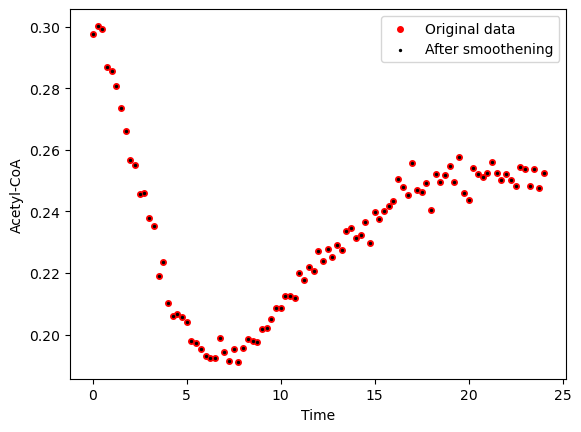

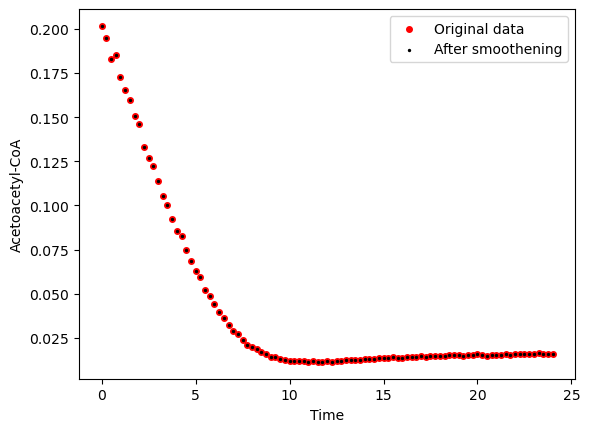

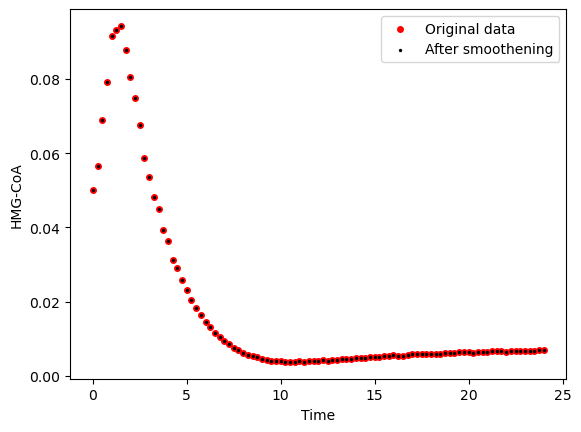

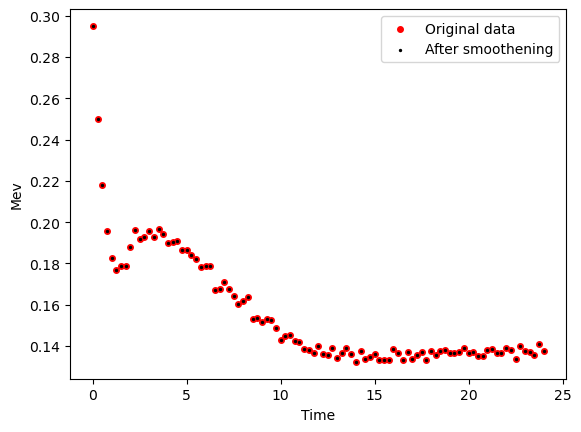

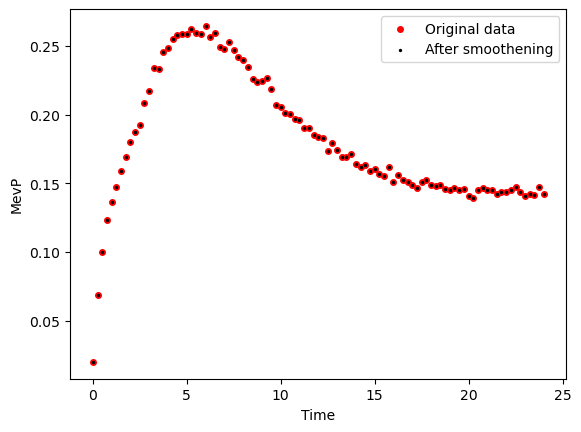

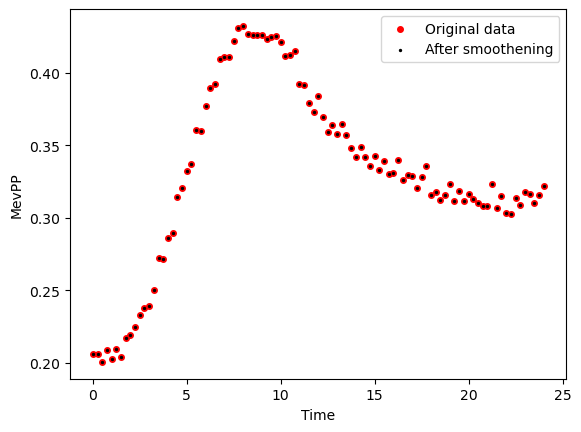

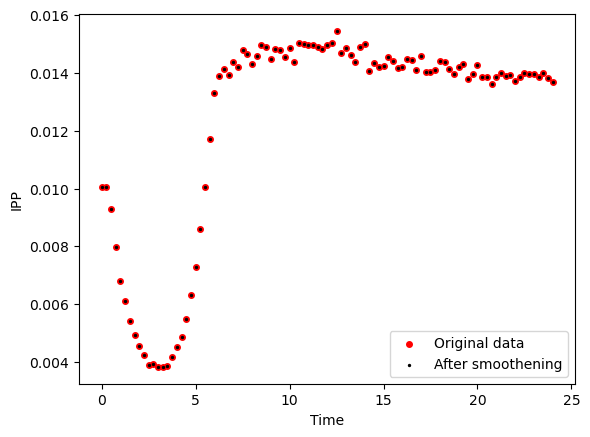

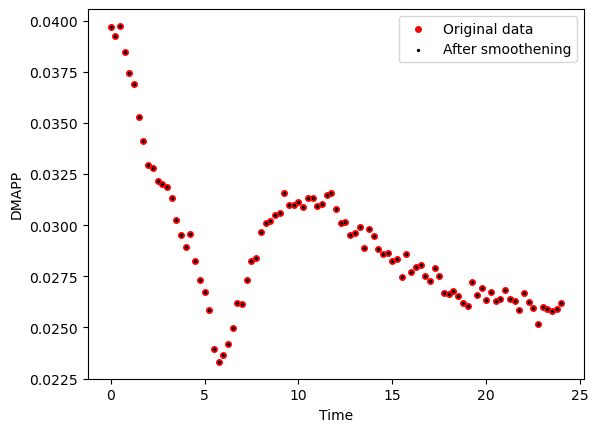

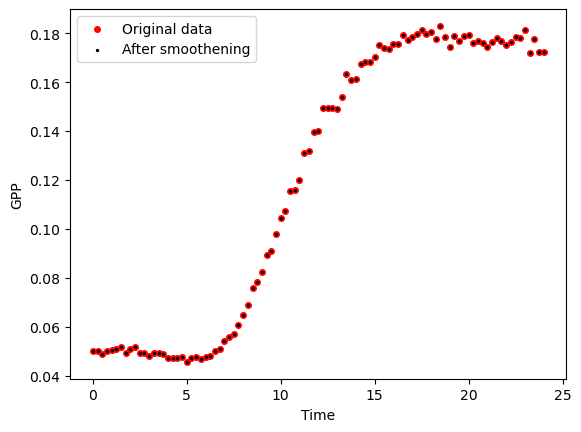

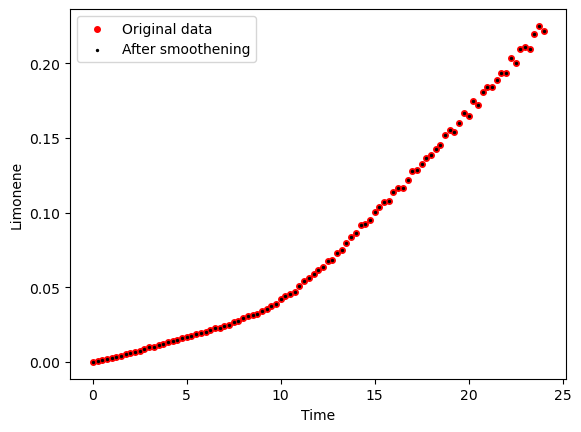

Strain Strain 2


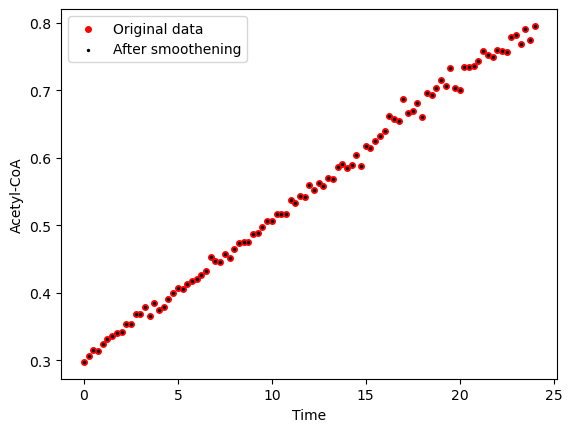

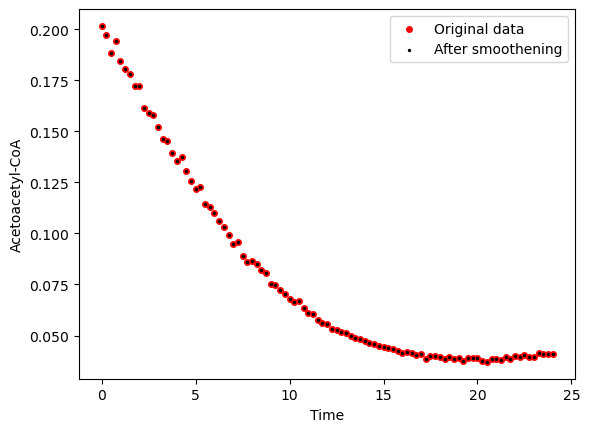

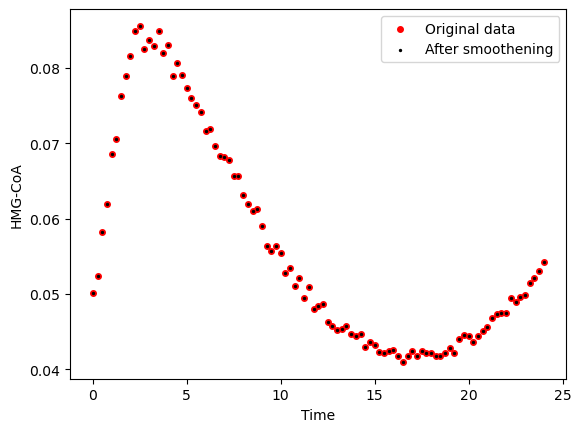

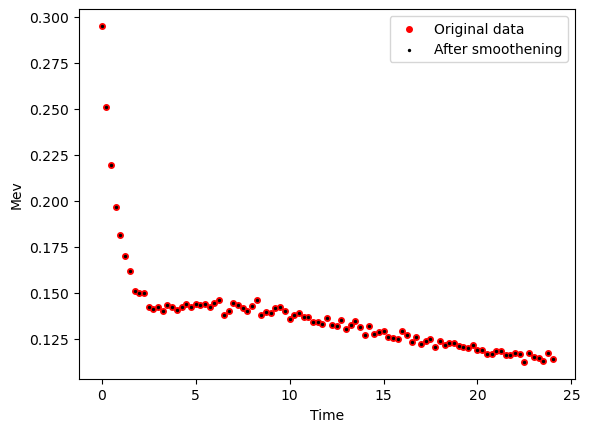

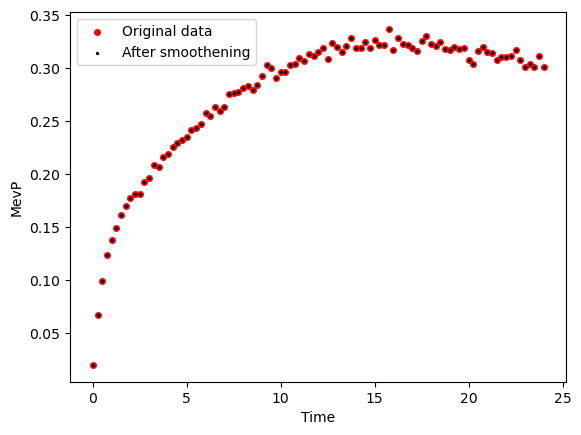

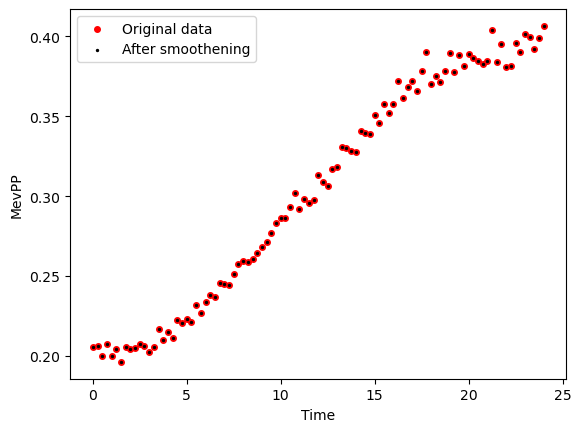

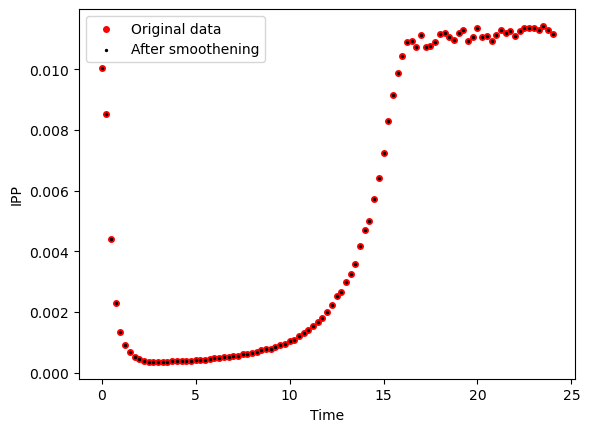

Strain Strain 3


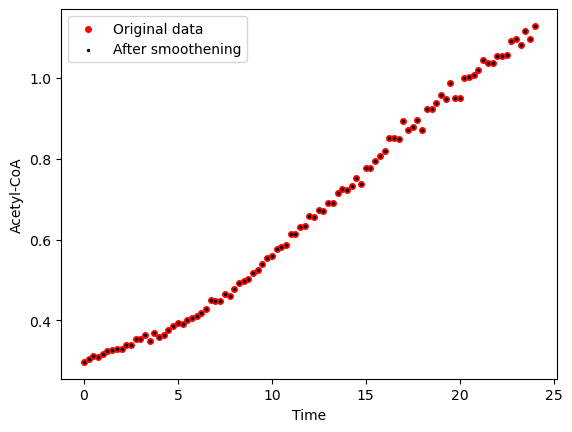

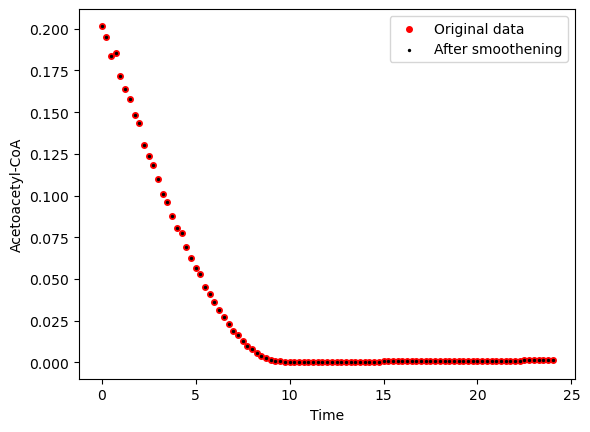

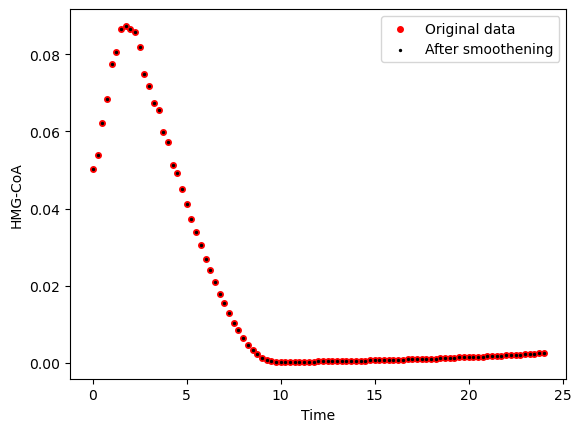

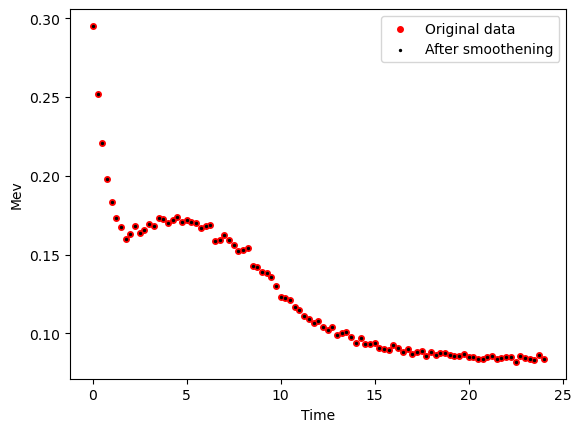

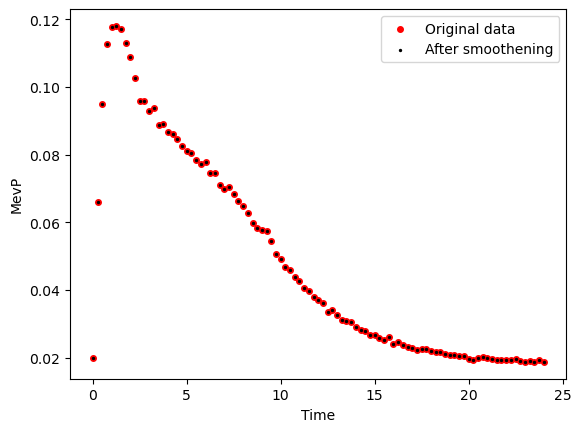

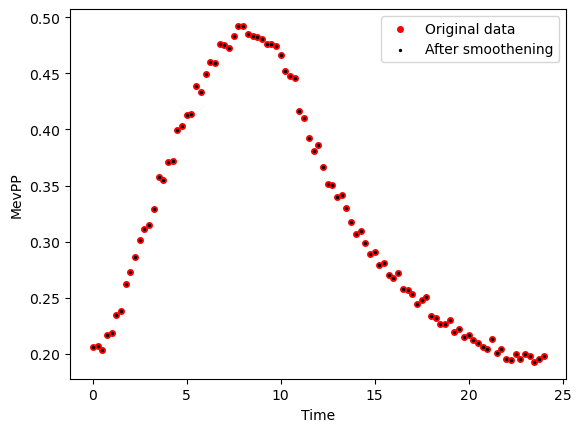

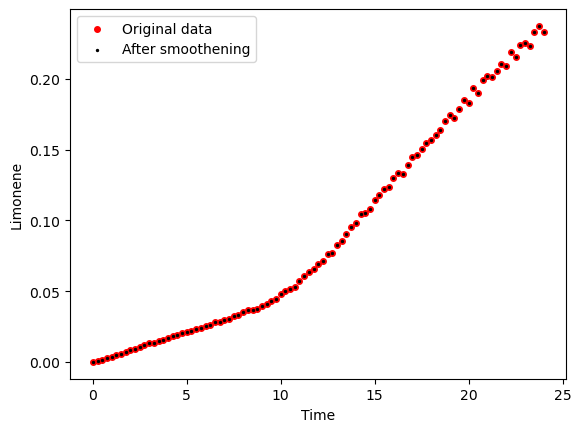

Strain WT


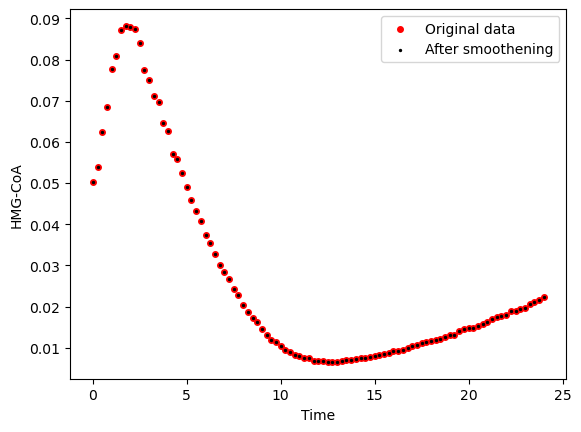

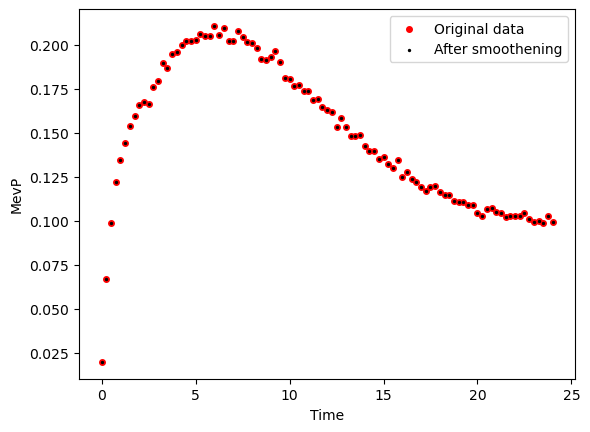

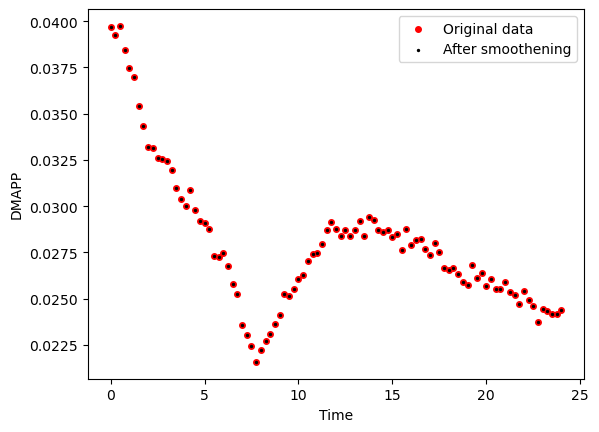

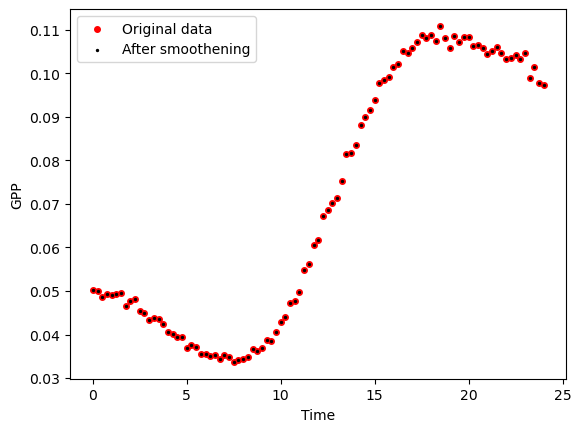

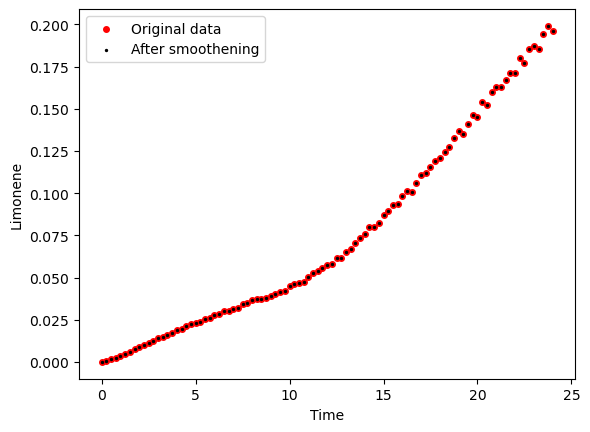

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


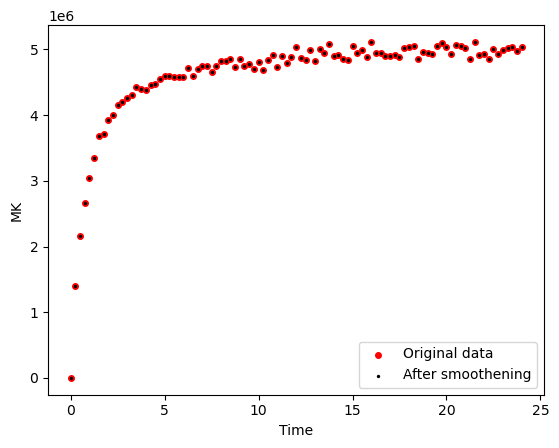

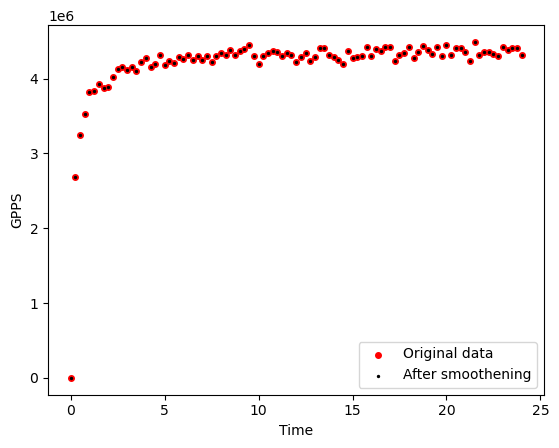

Strain Strain 2


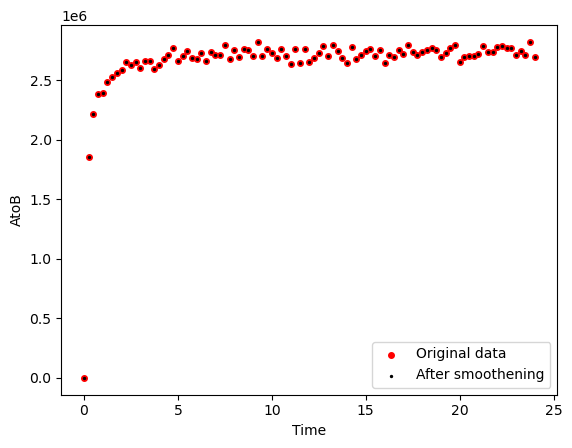

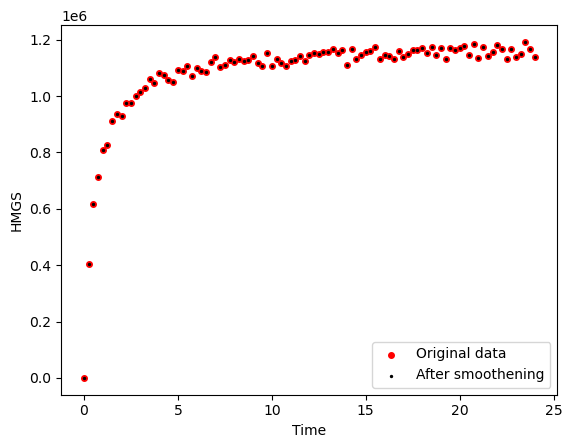

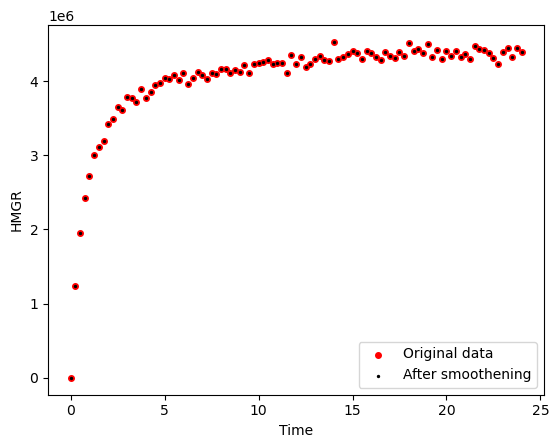

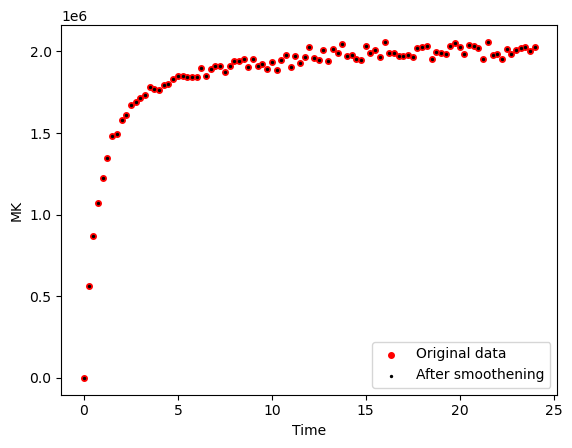

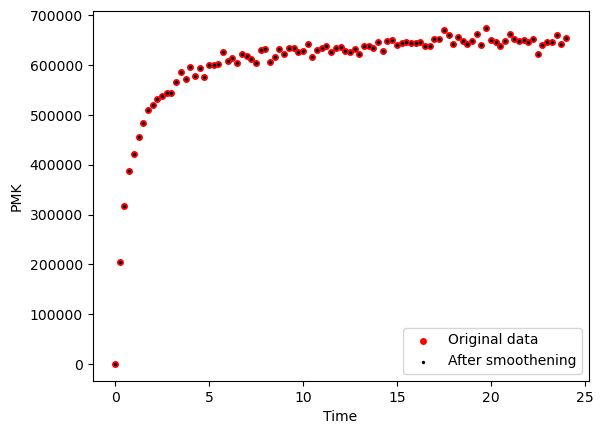

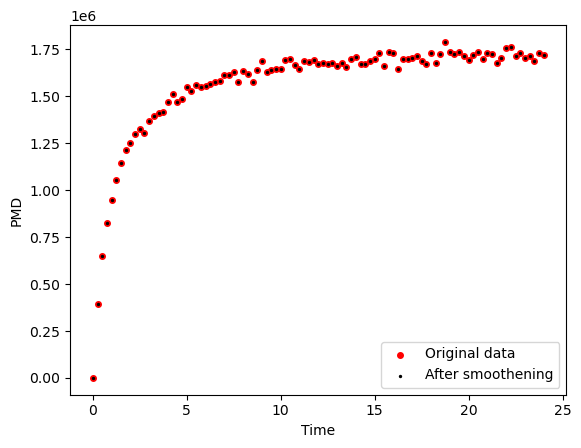

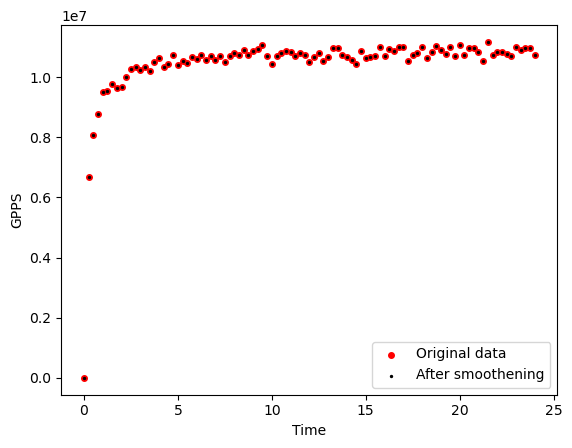

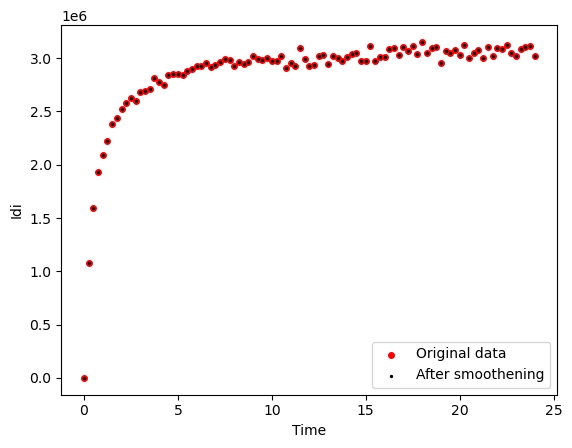

Strain Strain 3


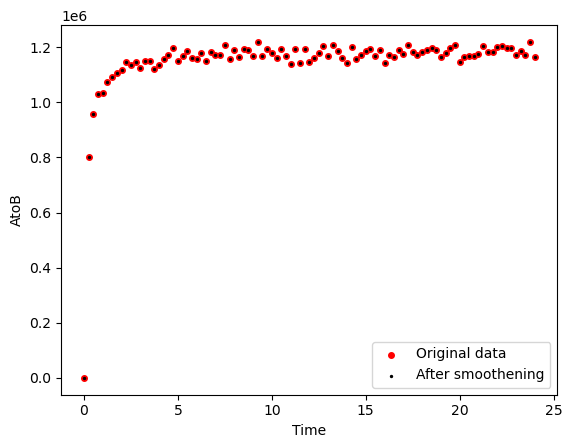

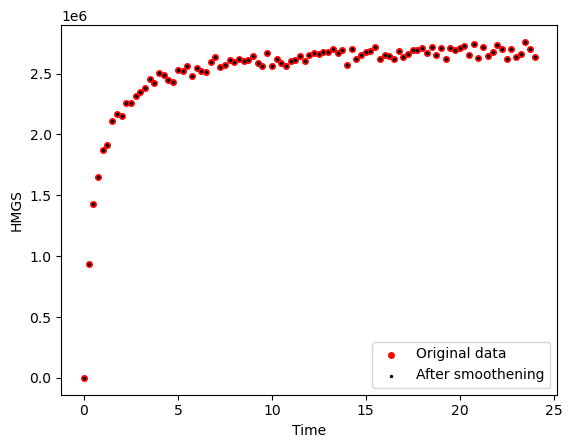

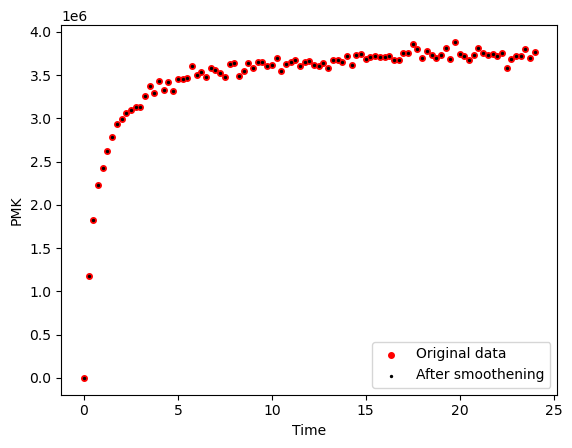

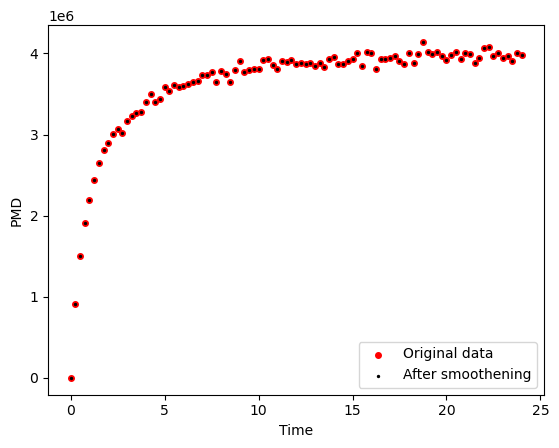

Strain WT


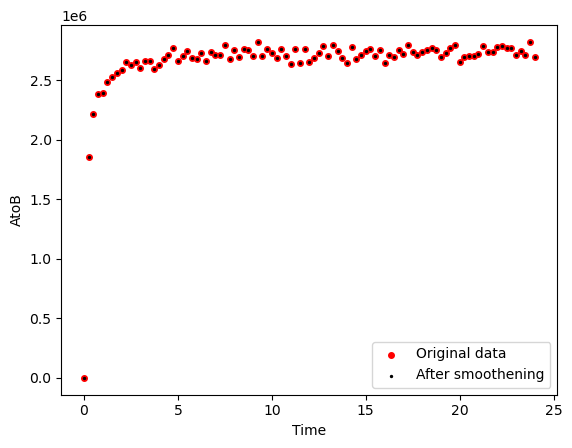

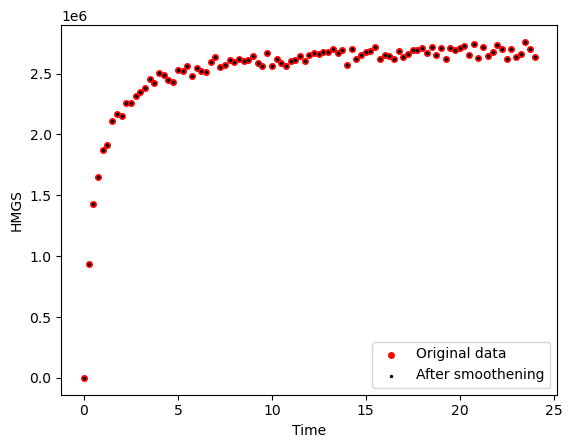

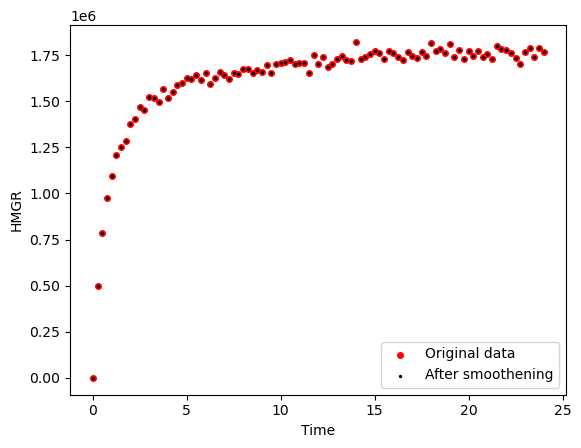

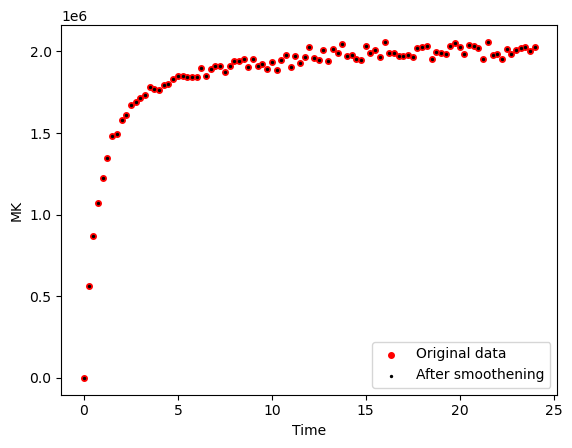

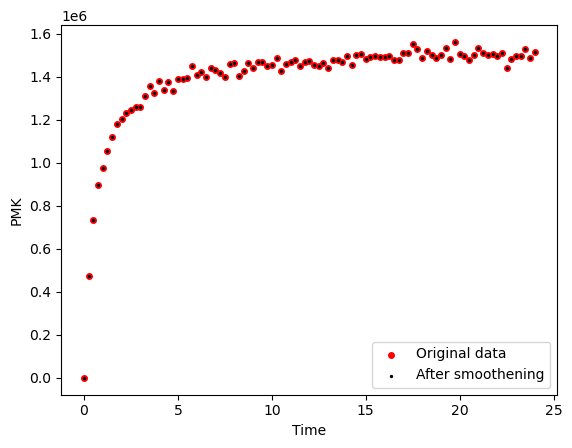

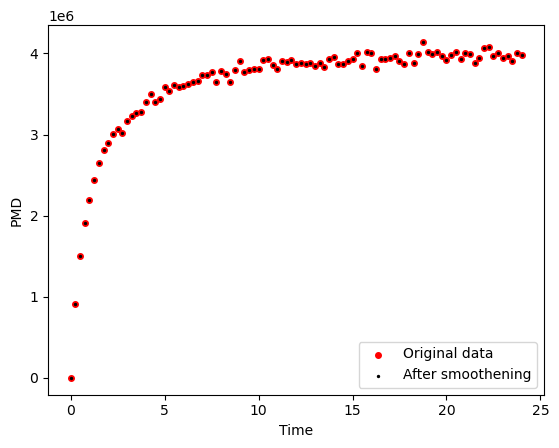

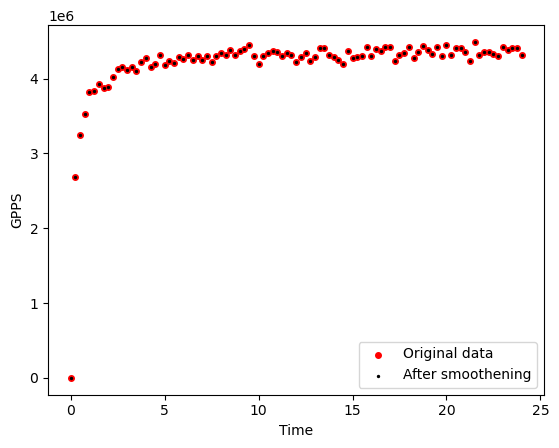

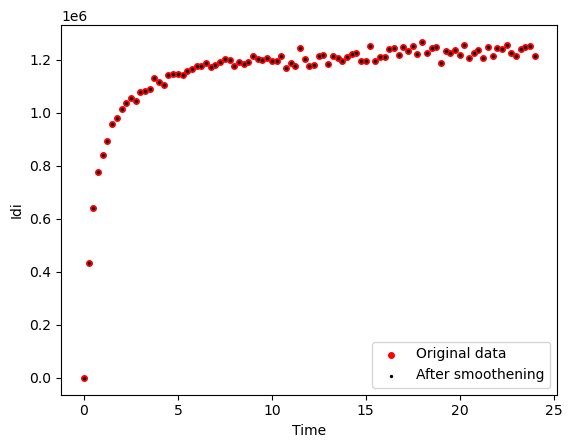

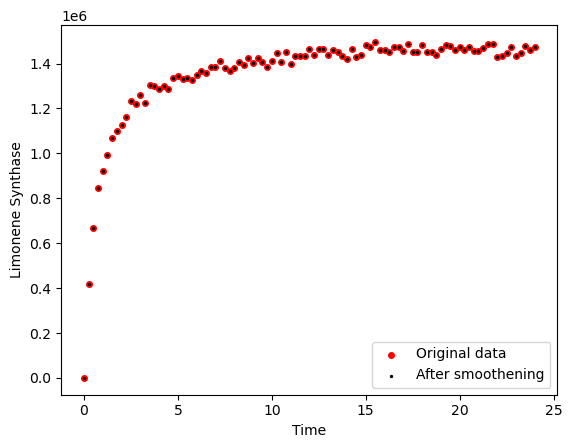

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative52

df_allSmooth=estimate_state_derivative52(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.297424        0.201680  0.050157  0.295112  0.019945   
         0.25    0.300192        0.194677  0.056548  0.250207  0.068294   
         0.50    0.299105        0.183105  0.069053  0.217981  0.100099   
         0.75    0.286732        0.185485  0.079197  0.195711  0.123435   
         1.00    0.285431        0.172543  0.091509  0.182604  0.136342   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.776930        0.013964  0.019737  0.112279  0.099257   
         23.25   0.763973        0.014793  0.020571  0.111720  0.099873   
         23.50   0.785629        0.014680  0.021069  0.110822  0.099085   
         23.75   0.770307        0.014771  0.021598  0.115347  0.102618   
         24.00   0.790581        0.014852  0.022301  0.112320  0.099119   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.205907  0.010049  0.039701  0.050189  0.000000  ...   
         0.25   0.206308  0.010039  0.039255  0.050087  0.000387  ...   
         0.50   0.200683  0.009286  0.039745  0.049050  0.000989  ...   
         0.75   0.208653  0.007979  0.038452  0.050208  0.001664  ...   
         1.00   0.202782  0.006795  0.037419  0.050439  0.002452  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.310161  0.013573  0.024459  0.104682  0.187074  ...   
         23.25  0.307878  0.013429  0.024304  0.098845  0.185658  ...   
         23.50  0.301128  0.013576  0.024158  0.101544  0.194620  ...   
         23.75  0.305593  0.013375  0.024159  0.097823  0.199137  ...   
         24.00  0.310657  0.013222  0.024357  0.097198  0.196018  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.007219       -0.029358  0.031305 -0.195864  0.205861   
         0.25    -0.003880       -0.028173  0.036723 -0.153834  0.160517   
         0.50    -0.014979       -0.026987  0.042141 -0.111805  0.115174   
         0.75    -0.021182       -0.027670  0.038366 -0.072696  0.077477   
         1.00    -0.022935       -0.026846  0.025788 -0.038885  0.056447   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.022720        0.000965  0.002146  0.000695 -0.004907   
         23.25    0.000102        0.001073  0.002277  0.000437  0.000958   
         23.50    0.013455        0.000702  0.002462  0.001484  0.000988   
         23.75    0.030303       -0.000038  0.002331  0.001762 -0.001246   
         24.00    0.047151       -0.000777  0.002199  0.002040 -0.003479   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.002765 -0.000110  0.001233 -0.003019  0.001473  
         0.25  -0.002163 -0.001768 -0.000456 -0.001385  0.001972  
         0.50  -0.001562 -0.003427 -0.002146  0.000249  0.002472  
         0.75   0.003368 -0.004149 -0.002793  0.001312  0.002937  
         1.00   0.002859 -0.003838 -0.004189  0.002544  0.003087  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003786 -0.000115 -0.000130 -0.003994  0.013848  
         23.25 -0.001295 -0.000172  0.000202 -0.005690  0.013932  
         23.50 -0.000517 -0.000303 -0.000140 -0.006397  0.012547  
         23.75  0.014288 -0.000511  0.000349 -0.004109  0.008059  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

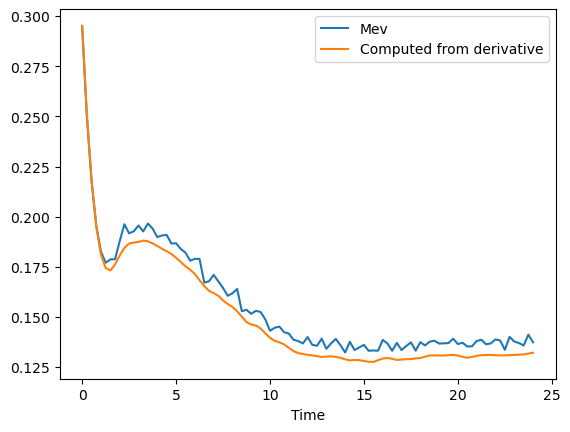

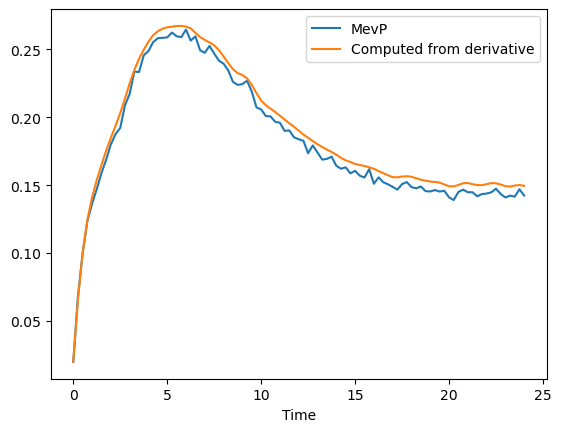

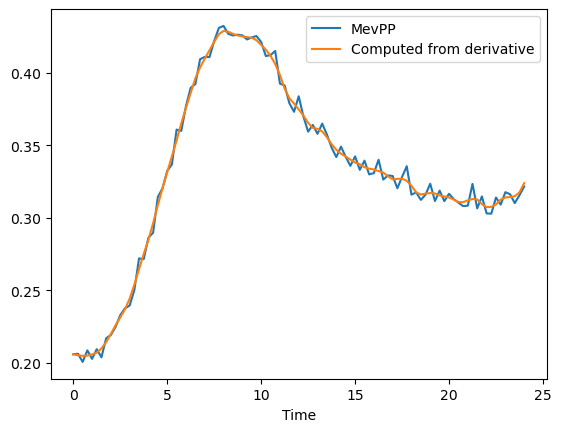

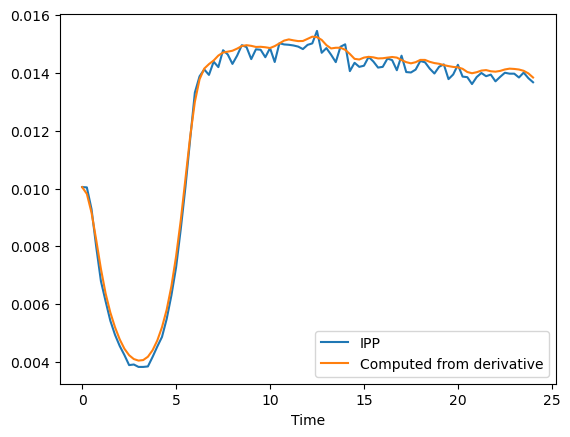

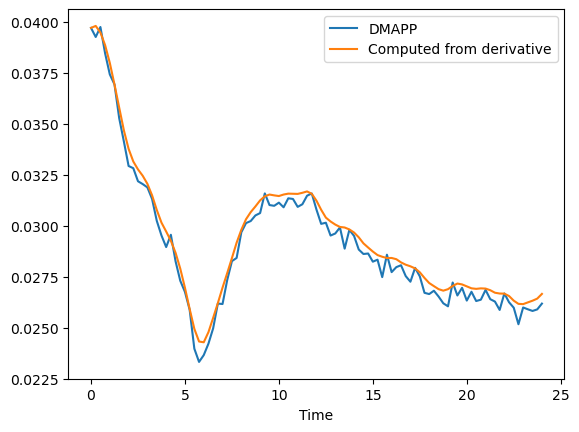

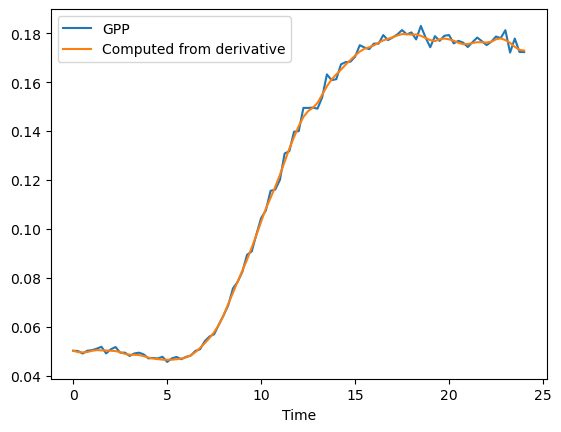

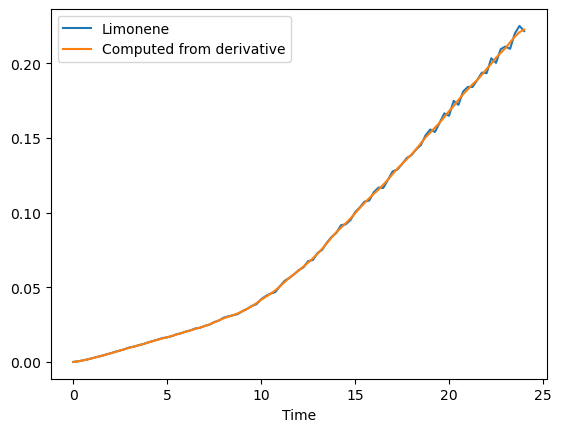

'Time profile from derivative vs. actual profile for Strain 2'

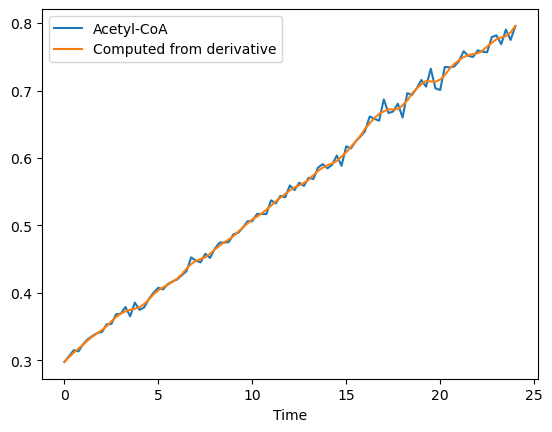

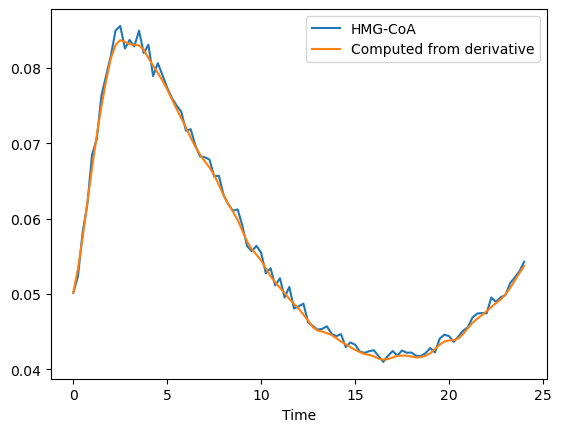

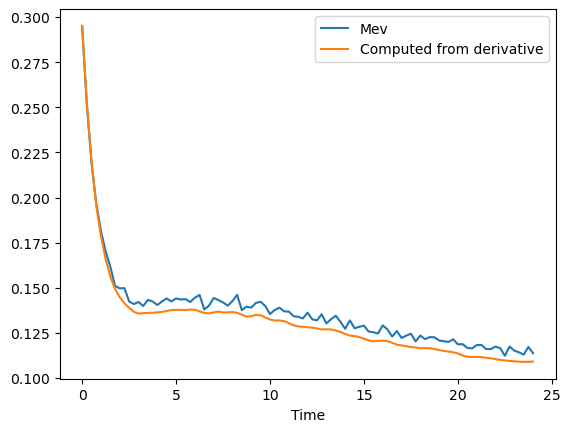

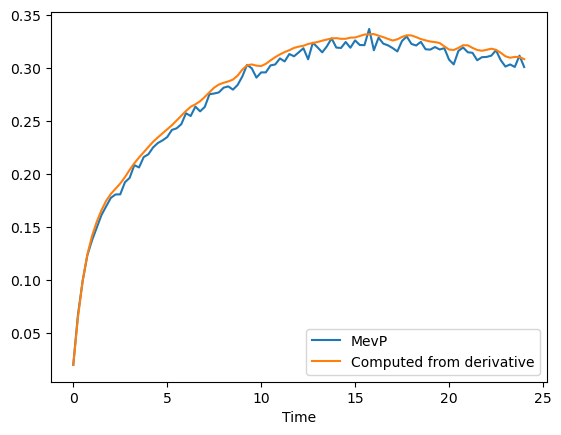

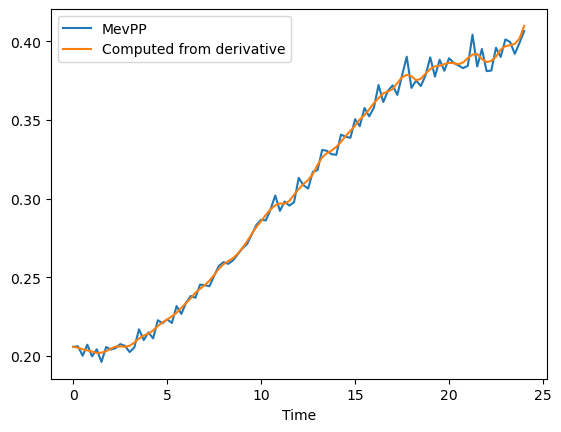

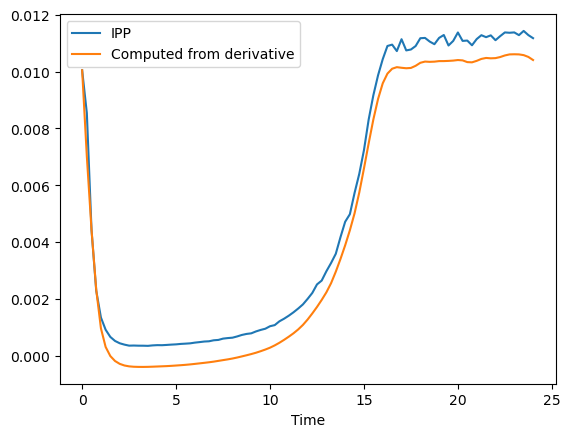

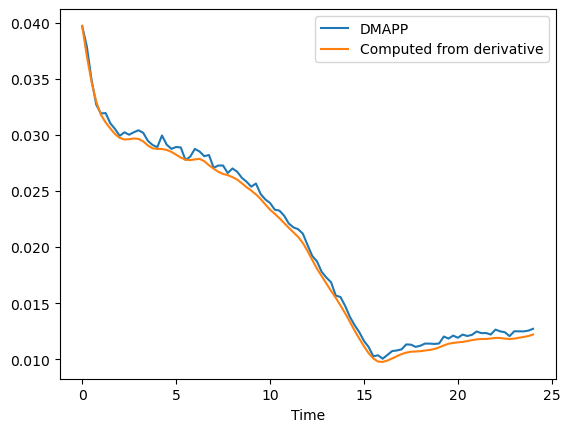

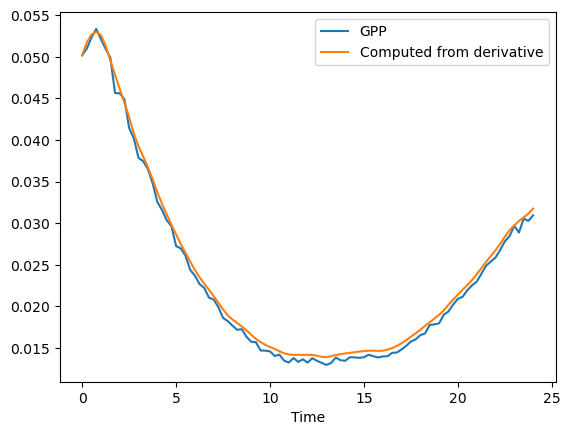

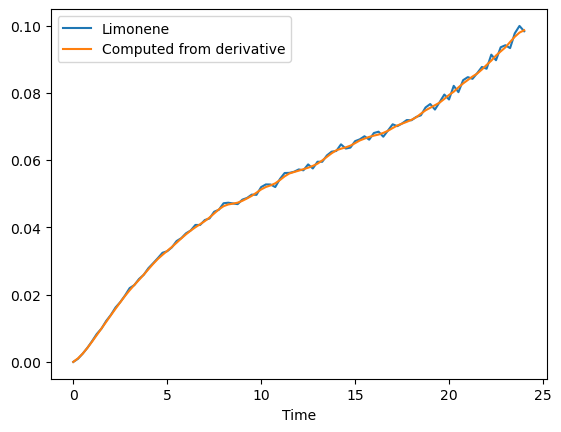

'Time profile from derivative vs. actual profile for Strain 3'

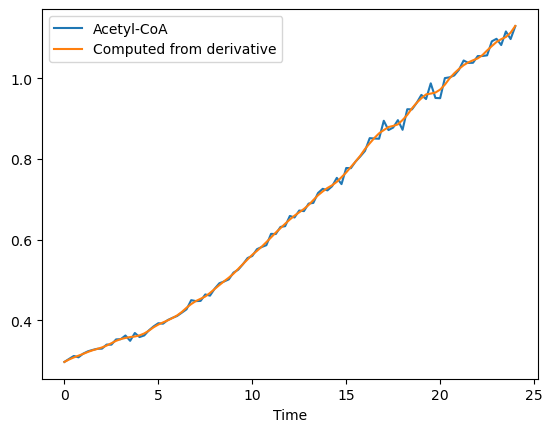

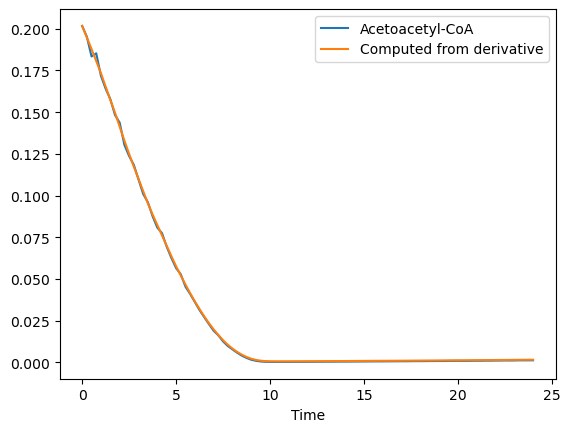

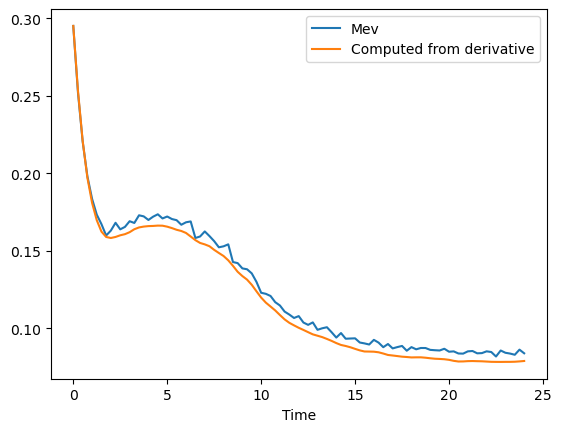

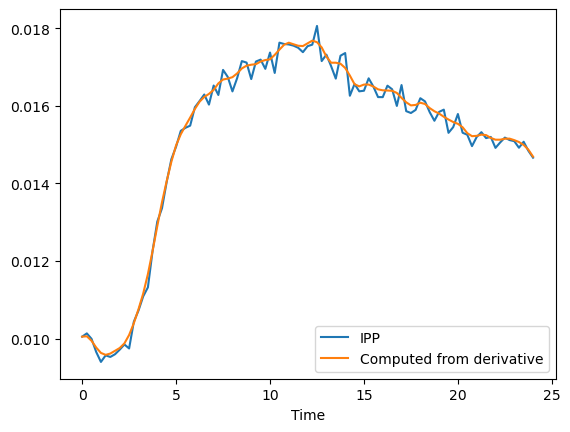

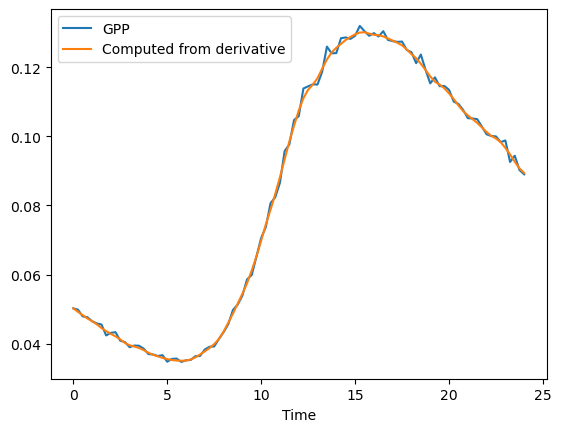

'Time profile from derivative vs. actual profile for WT'

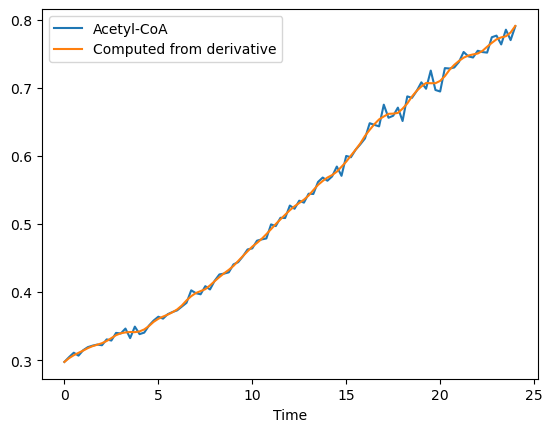

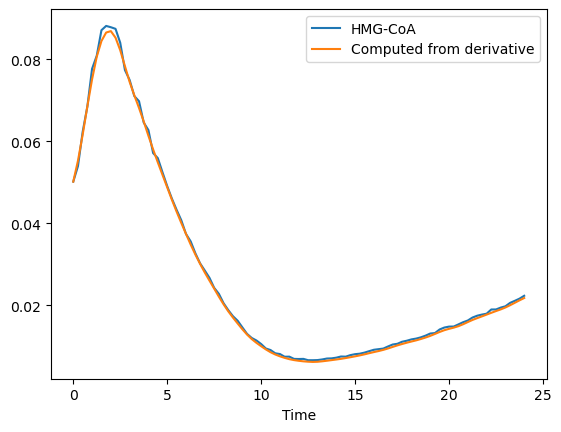

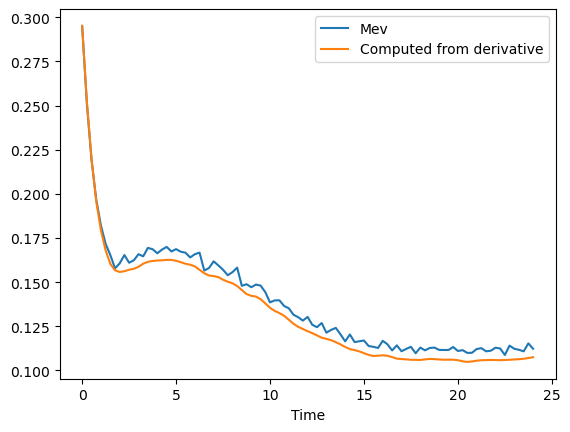

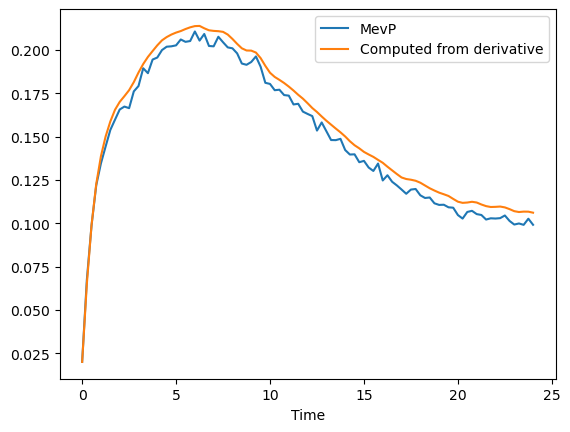

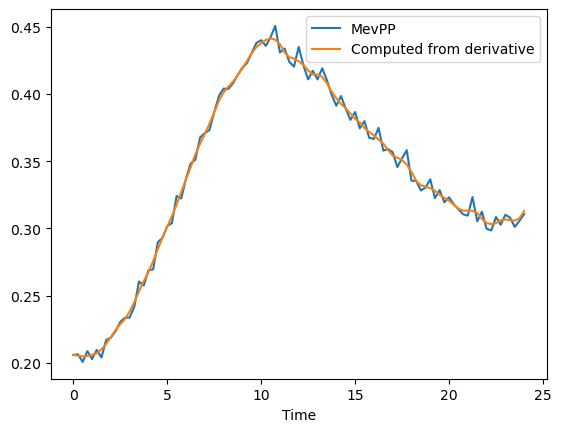

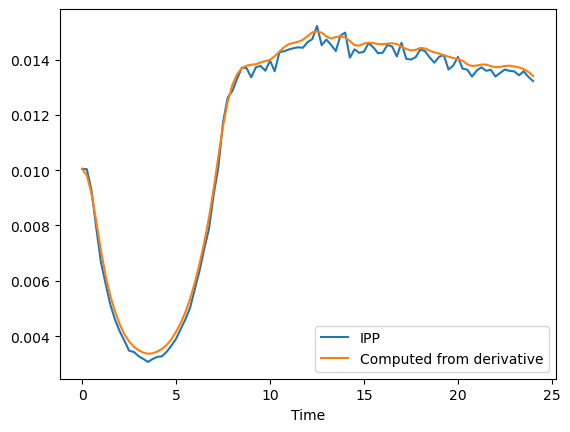

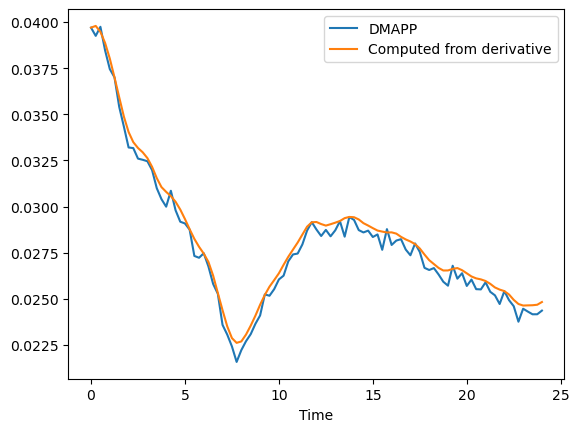

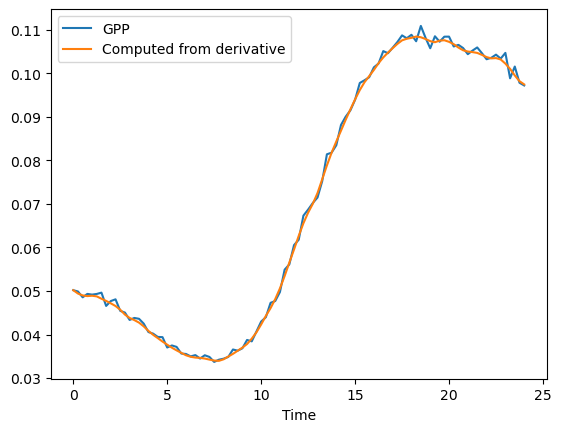

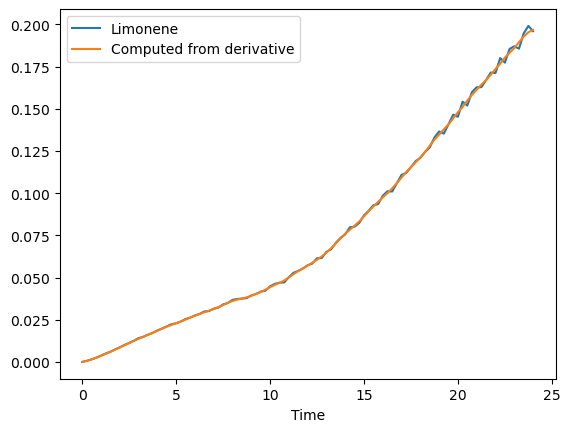

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.895904e+01  4.006396e+01  3.708489e+01  5.668387e+01   
         0.25   4.619542e+06  2.317008e+06  2.160956e+05  1.398457e+06   
         0.50   5.512627e+06  3.556799e+06  3.385569e+05  2.153234e+06   
         0.75   5.929421e+06  4.100638e+06  4.201464e+05  2.663142e+06   
         1.00   5.939704e+06  4.650100e+06  4.739500e+05  3.042015e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.713909e+06  2.632876e+06  1.768712e+06  2.006850e+06   
         23.25  2.748672e+06  2.663635e+06  1.787678e+06  2.019082e+06   
         23.50  2.713428e+06  2.759470e+06  1.739231e+06  2.027699e+06   
         23.75  2.820893e+06  2.699809e+06  1.789693e+06  2.003403e+06   
         24.00  2.690745e+06  2.634564e+06  1.765057e+06  2.028786e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.652667e+01  5.609052e+01  5.574226e+01  1.854788e+01   
         0.25   4.733219e+05  2.255882e+06  2.681733e+06  4.347550e+05   
         0.50   7.349474e+05  3.745038e+06  3.244573e+06  6.404414e+05   
         0.75   8.987189e+05  4.746496e+06  3.532781e+06  7.774754e+05   
         1.00   9.753001e+05  5.461227e+06  3.825207e+06  8.426694e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.494655e+06  3.940687e+06  4.425821e+06  1.213425e+06   
         23.25  1.497491e+06  3.971669e+06  4.379524e+06  1.241157e+06   
         23.50  1.528124e+06  3.910251e+06  4.408977e+06  1.247393e+06   
         23.75  1.486258e+06  4.001348e+06  4.414003e+06  1.251412e+06   
         24.00  1.515767e+06  3.977775e+06  4.322492e+06  1.216404e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.045565e+01   0.297424        0.201680  0.050157   
         0.25       1.806722e+05   0.300192        0.194677  0.056548   
         0.50       2.877380e+05   0.299105        0.183105  0.069053   
         0.75       3.644992e+05   0.286732        0.185485  0.079197   
         1.00       3.980958e+05   0.285431        0.172543  0.091509   
...                          ...        ...             ...       ...   
WT       23.00      1.432944e+06   0.776930        0.013964  0.019737   
         23.25      1.445567e+06   0.763973        0.014793  0.020571   
         23.50      1.477006e+06   0.785629        0.014680  0.021069   
         23.75      1.458479e+06   0.770307        0.014771  0.021598   
         24.00      1.473737e+06   0.790581        0.014852  0.022301   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.295112  0.019945  0.205907  0.010049  0.039701  0.050189   
         0.25   0.250207  0.068294  0.206308  0.010039  0.039255  0.050087   
         0.50   0.217981  0.100099  0.200683  0.009286  0.039745  0.049050   
         0.75   0.195711  0.123435  0.208653  0.007979  0.038452  0.050208   
         1.00   0.182604  0.136342  0.202782  0.006795  0.037419  0.050439   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.112279  0.099257  0.310161  0.013573  0.024459  0.104682   
         23.25  0.111720  0.099873  0.307878  0.013429  0.024304  0.098845   
         23.50  0.110822  0.099085  0.301128  0.013576  0.024158 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.007219       -0.029358  0.031305 -0.195864  0.205861   
         0.25    -0.003880       -0.028173  0.036723 -0.153834  0.160517   
         0.50    -0.014979       -0.026987  0.042141 -0.111805  0.115174   
         0.75    -0.021182       -0.027670  0.038366 -0.072696  0.077477   
         1.00    -0.022935       -0.026846  0.025788 -0.038885  0.056447   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.022720        0.000965  0.002146  0.000695 -0.004907   
         23.25    0.000102        0.001073  0.002277  0.000437  0.000958   
         23.50    0.013455        0.000702  0.002462  0.001484  0.000988   
         23.75    0.030303       -0.000038  0.002331  0.001762 -0.001246   
         24.00    0.047151       -0.000777  0.002199  0.002040 -0.003479   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.002765 -0.000110  0.001233 -0.003019  0.001473  
         0.25  -0.002163 -0.001768 -0.000456 -0.001385  0.001972  
         0.50  -0.001562 -0.003427 -0.002146  0.000249  0.002472  
         0.75   0.003368 -0.004149 -0.002793  0.001312  0.002937  
         1.00   0.002859 -0.003838 -0.004189  0.002544  0.003087  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003786 -0.000115 -0.000130 -0.003994  0.013848  
         23.25 -0.001295 -0.000172  0.000202 -0.005690  0.013932  
         23.50 -0.000517 -0.000303 -0.000140 -0.006397  0.012547  
         23.75  0.014288 -0.000511  0.000349 -0.004109  0.008059  
         24.00  0.029092 -0.000720  0.000837 -0.001821  0.003571  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=101,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 1.109313E+192 | 9.452503E+116
     2 |       74 | 1.746014E+115 |  4.921348E+83
     3 |      138 |  6.911051E+90 |  5.246265E+70
     4 |      202 |  1.488619E+80 |  1.113030E+60
     5 |      266 |  3.713941E+73 |  6.508043E+53
     6 |      330 |  2.688723E+65 |  8.728054E+48
     7 |      394 |  6.007418E+62 |  1.467793E+48
     8 |      458 |  8.673340E+58 |  7.735500E+46
     9 |      522 |  1.135801E+57 |  5.021653E+42
    10 |      586 |  4.539472E+56 |  7.105301E+34
    11 |      650 |  8.132756E+50 |  7.105301E+34
    12 |      714 |  3.364368E+49 |  7.105301E+34
    13 |      778 |  4.302972E+48 |  7.105301E+34
    14 |      842 |  3.114277E+44 |  2.346597E+32
    15 |      906 |  5.275808E+41 |  6.168023E+31
    16 |      970 |  2.549677E+43 |  6.168023E+31
    17 |     1034 |  2.256795E+40 |  1.906886E+28
    18 |     1098 |  3.942069E+37 |  8.454769E+25
    19 |     1162 |  7.129

   162 |    10314 |  2.351796E+01 |  2.011157E+01
   163 |    10378 |  2.379096E+01 |  2.011157E+01
   164 |    10442 |  2.330886E+01 |  2.011157E+01
   165 |    10506 |  2.312542E+01 |  2.011157E+01
   166 |    10570 |  2.329724E+01 |  2.011157E+01
   167 |    10634 |  2.309556E+01 |  2.011157E+01
   168 |    10698 |  2.290523E+01 |  2.011157E+01
   169 |    10762 |  2.233584E+01 |  2.011157E+01
   170 |    10826 |  2.292807E+01 |  2.011157E+01
   171 |    10890 |  2.251378E+01 |  2.009328E+01
   172 |    10954 |  2.348391E+01 |  2.009328E+01
   173 |    11018 |  2.309528E+01 |  2.009328E+01
   174 |    11082 |  2.306342E+01 |  2.009328E+01
   175 |    11146 |  2.278297E+01 |  2.009328E+01
   176 |    11210 |  2.146822E+01 |  2.009328E+01
   177 |    11274 |  2.192601E+01 |  2.009328E+01
   178 |    11338 |  2.234014E+01 |  2.009328E+01
   179 |    11402 |  2.257158E+01 |  2.009328E+01
   180 |    11466 |  2.239884E+01 |  2.009328E+01
   181 |    11530 |  2.260258E+01 |  2.009328E+01


   326 |    20810 |  1.402274E+01 |  1.209667E+01
   327 |    20874 |  1.383458E+01 |  1.209667E+01
   328 |    20938 |  1.389704E+01 |  1.209667E+01
   329 |    21002 |  1.355842E+01 |  1.209667E+01
   330 |    21066 |  1.354512E+01 |  1.209667E+01
   331 |    21130 |  1.358815E+01 |  1.209667E+01
   332 |    21194 |  1.348523E+01 |  1.209667E+01
   333 |    21258 |  1.321322E+01 |  1.209667E+01
   334 |    21322 |  1.326644E+01 |  1.209667E+01
   335 |    21386 |  1.330837E+01 |  1.209667E+01
   336 |    21450 |  1.341026E+01 |  1.209667E+01
   337 |    21514 |  1.348969E+01 |  1.209667E+01
   338 |    21578 |  1.345181E+01 |  1.209667E+01
   339 |    21642 |  1.354259E+01 |  1.209667E+01
   340 |    21706 |  1.360707E+01 |  1.209667E+01
   341 |    21770 |  1.346294E+01 |  1.209667E+01
   342 |    21834 |  1.337841E+01 |  1.209667E+01
   343 |    21898 |  1.337922E+01 |  1.209667E+01
   344 |    21962 |  1.335315E+01 |  1.209667E+01
   345 |    22026 |  1.332622E+01 |  1.209667E+01


   490 |    31306 |  9.6873347899 |  9.5845550166
   491 |    31370 |  9.6859446627 |  9.5652458982
   492 |    31434 |  9.6840519891 |  9.5391747146
   493 |    31498 |  9.7082641441 |  9.5391747146
   494 |    31562 |  9.7216272850 |  9.5391747146
   495 |    31626 |  9.6635656884 |  9.5391747146
   496 |    31690 |  9.6336798750 |  9.5391747146
   497 |    31754 |  9.6664873344 |  9.5185321199
   498 |    31818 |  9.6315062370 |  9.5185321199
   499 |    31882 |  9.6019803107 |  9.5185321199
   500 |    31946 |  9.6094223956 |  9.5185321199
   501 |    32010 |  9.5939828578 |  9.5133009325
   502 |    32074 |  9.5657285977 |  9.4908058234
   503 |    32138 |  9.5821253135 |  9.4908058234
   504 |    32202 |  9.5774777893 |  9.4908058234
   505 |    32266 |  9.5932358207 |  9.4908058234
   506 |    32330 |  9.6035330554 |  9.4908058234
   507 |    32394 |  9.5891743926 |  9.4908058234
   508 |    32458 |  9.5259040051 |  9.4457100066
   509 |    32522 |  9.4909366994 |  9.4340602907


   654 |    41802 |  8.8802825973 |  8.8553197784
   655 |    41866 |  8.8796338991 |  8.8553197784
   656 |    41930 |  8.8680344888 |  8.8529030817
   657 |    41994 |  8.8649821937 |  8.8529030817
   658 |    42058 |  8.8643002388 |  8.8529030817
   659 |    42122 |  8.8706657685 |  8.8529030817
   660 |    42186 |  8.8647730465 |  8.8499465285
   661 |    42250 |  8.8564103480 |  8.8420000450
   662 |    42314 |  8.8517671414 |  8.8420000450
   663 |    42378 |  8.8501761578 |  8.8417588770
   664 |    42442 |  8.8414826218 |  8.8282263494
   665 |    42506 |  8.8313351161 |  8.8182408063
   666 |    42570 |  8.8233783288 |  8.8140014343
   667 |    42634 |  8.8200541001 |  8.8124558124
   668 |    42698 |  8.8163456982 |  8.8109535526
   669 |    42762 |  8.8160768439 |  8.8032161560
   670 |    42826 |  8.8155062919 |  8.8032161560
   671 |    42890 |  8.8114947893 |  8.8032161560
   672 |    42954 |  8.8120771796 |  8.8032161560
   673 |    43018 |  8.8091615007 |  8.8032161560


   818 |    52298 |  8.5484045236 |  8.5448111165
   819 |    52362 |  8.5463940019 |  8.5420947555
   820 |    52426 |  8.5438441035 |  8.5390302817
   821 |    52490 |  8.5397265297 |  8.5351882626
   822 |    52554 |  8.5348380969 |  8.5300097050
   823 |    52618 |  8.5331539979 |  8.5298595628
   824 |    52682 |  8.5306332079 |  8.5201494745
   825 |    52746 |  8.5230573768 |  8.5116241318
   826 |    52810 |  8.5119507230 |  8.5057645498
   827 |    52874 |  8.5085331349 |  8.4953962314
   828 |    52938 |  8.5028666313 |  8.4953962314
   829 |    53002 |  8.4979808485 |  8.4953962314
   830 |    53066 |  8.4960253500 |  8.4916814890
   831 |    53130 |  8.4891595018 |  8.4762662640
   832 |    53194 |  8.4806216246 |  8.4717926094
   833 |    53258 |  8.4718963180 |  8.4650119008
   834 |    53322 |  8.4645991189 |  8.4534324745
   835 |    53386 |  8.4557495307 |  8.4514110795
   836 |    53450 |  8.4486145224 |  8.4385724603
   837 |    53514 |  8.4352983412 |  8.4236246273


   982 |    62794 |  6.5823015975 |  6.3198923347
   983 |    62858 |  6.5712412275 |  6.3198923347
   984 |    62922 |  6.5470663697 |  6.3102425544
   985 |    62986 |  6.4579029656 |  6.3094184412
   986 |    63050 |  6.4824477659 |  6.3094184412
   987 |    63114 |  6.5527780109 |  6.3094184412
   988 |    63178 |  6.5580041847 |  6.3094184412
   989 |    63242 |  6.5392079434 |  6.3094184412
   990 |    63306 |  6.5656158015 |  6.3094184412
   991 |    63370 |  6.5474759842 |  6.3094184412
   992 |    63434 |  6.4376828731 |  6.2949899095
   993 |    63498 |  6.3941639385 |  6.2906136339
   994 |    63562 |  6.3797664754 |  6.0995196081
   995 |    63626 |  6.2737137793 |  6.0970058302
   996 |    63690 |  6.3014876808 |  6.0970058302
   997 |    63754 |  6.2817384479 |  6.0265020617
   998 |    63818 |  6.1817259180 |  5.9515141206
   999 |    63882 |  6.1890514072 |  5.8955327604
  1000 |    63946 |  6.1444143294 |  5.8955327604
  1001 |    64010 |  6.2291508014 |  5.8955327604


  1146 |    73290 |  5.3489465091 |  5.3449839010
  1147 |    73354 |  5.3492769145 |  5.3449839010
  1148 |    73418 |  5.3469019460 |  5.3412546589
  1149 |    73482 |  5.3448067027 |  5.3412546589
  1150 |    73546 |  5.3447945839 |  5.3390172453
  1151 |    73610 |  5.3432096797 |  5.3390172453
  1152 |    73674 |  5.3418529588 |  5.3390172453
  1153 |    73738 |  5.3387918265 |  5.3352999091
  1154 |    73802 |  5.3370288828 |  5.3352999091
  1155 |    73866 |  5.3354952454 |  5.3323062041
  1156 |    73930 |  5.3358022303 |  5.3323062041
  1157 |    73994 |  5.3340966308 |  5.3316634523
  1158 |    74058 |  5.3334437685 |  5.3306008082
  1159 |    74122 |  5.3310549582 |  5.3290982784
  1160 |    74186 |  5.3303270303 |  5.3266111342
  1161 |    74250 |  5.3284426311 |  5.3264513390
  1162 |    74314 |  5.3290032651 |  5.3258720521
  1163 |    74378 |  5.3285215543 |  5.3258720521
  1164 |    74442 |  5.3281503511 |  5.3258720521
  1165 |    74506 |  5.3264210459 |  5.3236011131


  1310 |    83786 |  5.1352322086 |  5.1313899364
  1311 |    83850 |  5.1317881095 |  5.1304761862
  1312 |    83914 |  5.1302356015 |  5.1291109687
  1313 |    83978 |  5.1284745774 |  5.1273253712
  1314 |    84042 |  5.1275097218 |  5.1260411472
  1315 |    84106 |  5.1257723183 |  5.1238533822
  1316 |    84170 |  5.1242874682 |  5.1214648969
  1317 |    84234 |  5.1234696417 |  5.1212300713
  1318 |    84298 |  5.1240138639 |  5.1212300713
  1319 |    84362 |  5.1213898970 |  5.1157123456
  1320 |    84426 |  5.1188381266 |  5.1153811571
  1321 |    84490 |  5.1169146360 |  5.1135104224
  1322 |    84554 |  5.1149684787 |  5.1101700496
  1323 |    84618 |  5.1137979611 |  5.1101700496
  1324 |    84682 |  5.1131504024 |  5.1101700496
  1325 |    84746 |  5.1127468494 |  5.1101700496
  1326 |    84810 |  5.1113110417 |  5.1099947007
  1327 |    84874 |  5.1104957526 |  5.1092602267
  1328 |    84938 |  5.1101886540 |  5.1089947172
  1329 |    85002 |  5.1087507645 |  5.1070929252


  1474 |    94282 |  4.8817834352 |  4.8791154167
  1475 |    94346 |  4.8815038638 |  4.8778160465
  1476 |    94410 |  4.8794822633 |  4.8778160465
  1477 |    94474 |  4.8791625104 |  4.8767571535
  1478 |    94538 |  4.8780632770 |  4.8758274424
  1479 |    94602 |  4.8768683118 |  4.8758274424
  1480 |    94666 |  4.8766135771 |  4.8752670182
  1481 |    94730 |  4.8757867740 |  4.8736576021
  1482 |    94794 |  4.8750023296 |  4.8726094762
  1483 |    94858 |  4.8741428878 |  4.8726094762
  1484 |    94922 |  4.8738869840 |  4.8708310832
  1485 |    94986 |  4.8736110096 |  4.8708310832
  1486 |    95050 |  4.8722960981 |  4.8703713712
  1487 |    95114 |  4.8718056160 |  4.8703713712
  1488 |    95178 |  4.8716775227 |  4.8694928600
  1489 |    95242 |  4.8714142013 |  4.8680968553
  1490 |    95306 |  4.8707982947 |  4.8680968553
  1491 |    95370 |  4.8712881936 |  4.8678965591
  1492 |    95434 |  4.8706179824 |  4.8678965591
  1493 |    95498 |  4.8703068515 |  4.8678965591


  1638 |   104778 |  4.8012098477 |  4.7999003797
  1639 |   104842 |  4.8007779351 |  4.7994432408
  1640 |   104906 |  4.7997883749 |  4.7986856435
  1641 |   104970 |  4.7989461790 |  4.7982417119
  1642 |   105034 |  4.7982607015 |  4.7971716699
  1643 |   105098 |  4.7980490940 |  4.7971716699
  1644 |   105162 |  4.7977045256 |  4.7961679136
  1645 |   105226 |  4.7972199634 |  4.7961679136
  1646 |   105290 |  4.7964780286 |  4.7954936430
  1647 |   105354 |  4.7952564929 |  4.7946454464
  1648 |   105418 |  4.7953205283 |  4.7946454464
  1649 |   105482 |  4.7946003411 |  4.7938718483
  1650 |   105546 |  4.7941486579 |  4.7930813276
  1651 |   105610 |  4.7933863325 |  4.7922364990
  1652 |   105674 |  4.7931556219 |  4.7922364990
  1653 |   105738 |  4.7923670755 |  4.7913234551
  1654 |   105802 |  4.7918772075 |  4.7904756036
  1655 |   105866 |  4.7916015410 |  4.7904756036
  1656 |   105930 |  4.7912106861 |  4.7904280523
  1657 |   105994 |  4.7909005708 |  4.7902323570


  1802 |   115274 |  4.7287239664 |  4.7277330429
  1803 |   115338 |  4.7278955281 |  4.7272068447
  1804 |   115402 |  4.7278752171 |  4.7272068447
  1805 |   115466 |  4.7273579752 |  4.7269061666
  1806 |   115530 |  4.7272605917 |  4.7266304677
  1807 |   115594 |  4.7271518969 |  4.7265272552
  1808 |   115658 |  4.7268315138 |  4.7263668088
  1809 |   115722 |  4.7266276353 |  4.7257139333
  1810 |   115786 |  4.7262496491 |  4.7257139333
  1811 |   115850 |  4.7261919871 |  4.7257139333
  1812 |   115914 |  4.7258171636 |  4.7255732275
  1813 |   115978 |  4.7257947047 |  4.7255375740
  1814 |   116042 |  4.7256646903 |  4.7253905411
  1815 |   116106 |  4.7253261069 |  4.7247711430
  1816 |   116170 |  4.7250502725 |  4.7246482172
  1817 |   116234 |  4.7249776581 |  4.7246482172
  1818 |   116298 |  4.7247950136 |  4.7245147336
  1819 |   116362 |  4.7245199370 |  4.7241132516
  1820 |   116426 |  4.7242539561 |  4.7239118495
  1821 |   116490 |  4.7240684698 |  4.7238869676


  1966 |   125770 |  4.2706137275 |  4.2640472188
  1967 |   125834 |  4.2686455634 |  4.2640472188
  1968 |   125898 |  4.2655089335 |  4.2560431163
  1969 |   125962 |  4.2647482988 |  4.2560431163
  1970 |   126026 |  4.2615238018 |  4.2551591485
  1971 |   126090 |  4.2594842713 |  4.2551591485
  1972 |   126154 |  4.2551551538 |  4.2528265697
  1973 |   126218 |  4.2548129398 |  4.2503833098
  1974 |   126282 |  4.2523694442 |  4.2439807736
  1975 |   126346 |  4.2493794731 |  4.2439807736
  1976 |   126410 |  4.2471491674 |  4.2419467092
  1977 |   126474 |  4.2436185059 |  4.2411066919
  1978 |   126538 |  4.2423325553 |  4.2360356163
  1979 |   126602 |  4.2405079928 |  4.2307977623
  1980 |   126666 |  4.2366444661 |  4.2209660527
  1981 |   126730 |  4.2324621155 |  4.2209660527
  1982 |   126794 |  4.2291303289 |  4.2209660527
  1983 |   126858 |  4.2259160791 |  4.2209660527
  1984 |   126922 |  4.2240324978 |  4.2169417219
  1985 |   126986 |  4.2199155611 |  4.2149225592


  2130 |   136266 |  4.1085038686 |  4.1060535289
  2131 |   136330 |  4.1072654536 |  4.1048192646
  2132 |   136394 |  4.1067983211 |  4.1048192646
  2133 |   136458 |  4.1062860086 |  4.1047465278
  2134 |   136522 |  4.1053349445 |  4.1018471354
  2135 |   136586 |  4.1034758528 |  4.1010343123
  2136 |   136650 |  4.1027062187 |  4.1010343123
  2137 |   136714 |  4.1026278278 |  4.1006626381
  2138 |   136778 |  4.1024117522 |  4.1004643992
  2139 |   136842 |  4.1032222891 |  4.1004643992
  2140 |   136906 |  4.1035195678 |  4.1004643992
  2141 |   136970 |  4.1034423419 |  4.1004643992
  2142 |   137034 |  4.1028193579 |  4.1004643992
  2143 |   137098 |  4.1028526420 |  4.1004643992
  2144 |   137162 |  4.1022501528 |  4.1004643992
  2145 |   137226 |  4.1020173613 |  4.1003095535
  2146 |   137290 |  4.1012278439 |  4.1003095535
  2147 |   137354 |  4.1008905776 |  4.0997831688
  2148 |   137418 |  4.1004680624 |  4.0989155665
  2149 |   137482 |  4.1006694951 |  4.0989155665


  2294 |   146762 |  4.0675781475 |  4.0668698095
  2295 |   146826 |  4.0672612579 |  4.0668698095
  2296 |   146890 |  4.0673863357 |  4.0668698095
  2297 |   146954 |  4.0670032360 |  4.0667523157
  2298 |   147018 |  4.0669030723 |  4.0663218810
  2299 |   147082 |  4.0668784295 |  4.0663218810
  2300 |   147146 |  4.0666640923 |  4.0661849351
  2301 |   147210 |  4.0665067230 |  4.0661083966
  2302 |   147274 |  4.0663003842 |  4.0659352093
  2303 |   147338 |  4.0663489333 |  4.0659326792
  2304 |   147402 |  4.0660893187 |  4.0656067942
  2305 |   147466 |  4.0659554021 |  4.0656067942
  2306 |   147530 |  4.0658541825 |  4.0655315768
  2307 |   147594 |  4.0657955674 |  4.0653675155
  2308 |   147658 |  4.0657013456 |  4.0651940330
  2309 |   147722 |  4.0655309068 |  4.0650538569
  2310 |   147786 |  4.0653029402 |  4.0647356245
  2311 |   147850 |  4.0649594241 |  4.0644721833
  2312 |   147914 |  4.0647806307 |  4.0643643500
  2313 |   147978 |  4.0648059289 |  4.0643643500


  2458 |   157258 |  4.0304656562 |  4.0301200584
  2459 |   157322 |  4.0302520048 |  4.0298108141
  2460 |   157386 |  4.0300728616 |  4.0297646848
  2461 |   157450 |  4.0297835066 |  4.0290007258
  2462 |   157514 |  4.0293510439 |  4.0289083931
  2463 |   157578 |  4.0291287624 |  4.0289083931
  2464 |   157642 |  4.0289073647 |  4.0286524409
  2465 |   157706 |  4.0289390402 |  4.0286049532
  2466 |   157770 |  4.0288752481 |  4.0285469546
  2467 |   157834 |  4.0284521737 |  4.0280288107
  2468 |   157898 |  4.0282793844 |  4.0280282203
  2469 |   157962 |  4.0282427539 |  4.0276975595
  2470 |   158026 |  4.0281192217 |  4.0276975595
  2471 |   158090 |  4.0280954708 |  4.0275528353
  2472 |   158154 |  4.0279158226 |  4.0272975324
  2473 |   158218 |  4.0274316606 |  4.0270643144
  2474 |   158282 |  4.0272129788 |  4.0269040051
  2475 |   158346 |  4.0269138314 |  4.0265364561
  2476 |   158410 |  4.0266295826 |  4.0262402534
  2477 |   158474 |  4.0258833528 |  4.0250528559


  2622 |   167754 |  3.9908032713 |  3.9905383079
  2623 |   167818 |  3.9907751816 |  3.9905383079
  2624 |   167882 |  3.9907053604 |  3.9901675796
  2625 |   167946 |  3.9903165957 |  3.9900370366
  2626 |   168010 |  3.9903333274 |  3.9899627415
  2627 |   168074 |  3.9901970009 |  3.9899627415
  2628 |   168138 |  3.9900902976 |  3.9894938620
  2629 |   168202 |  3.9898072656 |  3.9894673812
  2630 |   168266 |  3.9898250366 |  3.9894471639
  2631 |   168330 |  3.9894781813 |  3.9892323007
  2632 |   168394 |  3.9893976934 |  3.9890670290
  2633 |   168458 |  3.9892688635 |  3.9890471216
  2634 |   168522 |  3.9890332764 |  3.9887087596
  2635 |   168586 |  3.9886174802 |  3.9883625172
  2636 |   168650 |  3.9884863977 |  3.9881235569
  2637 |   168714 |  3.9882719857 |  3.9878907813
  2638 |   168778 |  3.9880728350 |  3.9878630961
  2639 |   168842 |  3.9879918609 |  3.9875700827
  2640 |   168906 |  3.9876114485 |  3.9873446697
  2641 |   168970 |  3.9874916193 |  3.9872254118


  2786 |   178250 |  3.9613396490 |  3.9611770669
  2787 |   178314 |  3.9612495942 |  3.9610378082
  2788 |   178378 |  3.9610559425 |  3.9608055222
  2789 |   178442 |  3.9608574079 |  3.9605832922
  2790 |   178506 |  3.9606661568 |  3.9604186705
  2791 |   178570 |  3.9604483167 |  3.9602431984
  2792 |   178634 |  3.9603759486 |  3.9601569850
  2793 |   178698 |  3.9602034123 |  3.9599755884
  2794 |   178762 |  3.9601590144 |  3.9598974553
  2795 |   178826 |  3.9600109670 |  3.9597086564
  2796 |   178890 |  3.9599354971 |  3.9597086564
  2797 |   178954 |  3.9599021506 |  3.9597086564
  2798 |   179018 |  3.9598362048 |  3.9597061344
  2799 |   179082 |  3.9597377181 |  3.9595927784
  2800 |   179146 |  3.9597579922 |  3.9595927784
  2801 |   179210 |  3.9596313946 |  3.9595303979
  2802 |   179274 |  3.9594929897 |  3.9592296498
  2803 |   179338 |  3.9593735956 |  3.9592296498
  2804 |   179402 |  3.9593117680 |  3.9589316211
  2805 |   179466 |  3.9590795798 |  3.9587961853


  2950 |   188746 |  3.9450955415 |  3.9446768928
  2951 |   188810 |  3.9448541444 |  3.9443503087
  2952 |   188874 |  3.9445812760 |  3.9441142683
  2953 |   188938 |  3.9443812771 |  3.9441142683
  2954 |   189002 |  3.9442370249 |  3.9439651192
  2955 |   189066 |  3.9441075714 |  3.9439316533
  2956 |   189130 |  3.9440213132 |  3.9438589064
  2957 |   189194 |  3.9439091782 |  3.9437136068
  2958 |   189258 |  3.9436715514 |  3.9434970100
  2959 |   189322 |  3.9435132151 |  3.9432705099
  2960 |   189386 |  3.9433387514 |  3.9429152245
  2961 |   189450 |  3.9430747276 |  3.9427345980
  2962 |   189514 |  3.9428810960 |  3.9423737022
  2963 |   189578 |  3.9426903311 |  3.9423737022
  2964 |   189642 |  3.9424761829 |  3.9422875702
  2965 |   189706 |  3.9423114658 |  3.9421239094
  2966 |   189770 |  3.9421203903 |  3.9418788950
  2967 |   189834 |  3.9418689468 |  3.9418069491
  2968 |   189898 |  3.9417271151 |  3.9414975151
  2969 |   189962 |  3.9413551436 |  3.9411425106


  3114 |   199242 |  3.9152849483 |  3.9147257331
  3115 |   199306 |  3.9152113987 |  3.9144071590
  3116 |   199370 |  3.9147098228 |  3.9140279643
  3117 |   199434 |  3.9144028365 |  3.9140279643
  3118 |   199498 |  3.9143545187 |  3.9139643552
  3119 |   199562 |  3.9142624618 |  3.9139643552
  3120 |   199626 |  3.9140435939 |  3.9137639239
  3121 |   199690 |  3.9138004192 |  3.9136050004
  3122 |   199754 |  3.9136420731 |  3.9130812961
  3123 |   199818 |  3.9134550099 |  3.9130812961
  3124 |   199882 |  3.9134680973 |  3.9130812961
  3125 |   199946 |  3.9132499686 |  3.9126064989
  3126 |   200010 |  3.9128182197 |  3.9125342160
  3127 |   200074 |  3.9126631715 |  3.9124180151
  3128 |   200138 |  3.9126103008 |  3.9122716796
  3129 |   200202 |  3.9125789983 |  3.9121117520
  3130 |   200266 |  3.9123326317 |  3.9120165378
  3131 |   200330 |  3.9122531048 |  3.9118385191
  3132 |   200394 |  3.9120631344 |  3.9118167773
  3133 |   200458 |  3.9120914606 |  3.9118167773


  3278 |   209738 |  3.8665976132 |  3.8660691997
  3279 |   209802 |  3.8667458606 |  3.8653553081
  3280 |   209866 |  3.8662270919 |  3.8653553081
  3281 |   209930 |  3.8660854806 |  3.8653553081
  3282 |   209994 |  3.8660174055 |  3.8653553081
  3283 |   210058 |  3.8656871373 |  3.8653553081
  3284 |   210122 |  3.8652648219 |  3.8646218894
  3285 |   210186 |  3.8648875451 |  3.8641603031
  3286 |   210250 |  3.8647298673 |  3.8641603031
  3287 |   210314 |  3.8646437325 |  3.8641603031
  3288 |   210378 |  3.8645997896 |  3.8641393928
  3289 |   210442 |  3.8645923027 |  3.8641393928
  3290 |   210506 |  3.8644183407 |  3.8640035104
  3291 |   210570 |  3.8639742178 |  3.8634666418
  3292 |   210634 |  3.8638995025 |  3.8633353423
  3293 |   210698 |  3.8636874871 |  3.8632674656
  3294 |   210762 |  3.8635729915 |  3.8629237600
  3295 |   210826 |  3.8635841455 |  3.8629237600
  3296 |   210890 |  3.8630526854 |  3.8626901753
  3297 |   210954 |  3.8629489140 |  3.8625127963


  3442 |   220234 |  3.8307635174 |  3.8303106337
  3443 |   220298 |  3.8303285774 |  3.8298210918
  3444 |   220362 |  3.8300878002 |  3.8298079418
  3445 |   220426 |  3.8298749424 |  3.8296173967
  3446 |   220490 |  3.8294845023 |  3.8287995727
  3447 |   220554 |  3.8291048450 |  3.8287498061
  3448 |   220618 |  3.8285239178 |  3.8268295474
  3449 |   220682 |  3.8276991891 |  3.8265981607
  3450 |   220746 |  3.8268078954 |  3.8257110804
  3451 |   220810 |  3.8261707497 |  3.8251614055
  3452 |   220874 |  3.8254817326 |  3.8249230397
  3453 |   220938 |  3.8252105499 |  3.8247158573
  3454 |   221002 |  3.8249637583 |  3.8245094513
  3455 |   221066 |  3.8249136924 |  3.8244852197
  3456 |   221130 |  3.8248967972 |  3.8244852197
  3457 |   221194 |  3.8244907626 |  3.8240680624
  3458 |   221258 |  3.8243428419 |  3.8237002993
  3459 |   221322 |  3.8239877916 |  3.8235387266
  3460 |   221386 |  3.8238500164 |  3.8233719796
  3461 |   221450 |  3.8235589665 |  3.8229906068


  3606 |   230730 |  3.7583856997 |  3.7580636022
  3607 |   230794 |  3.7580198352 |  3.7575649252
  3608 |   230858 |  3.7577697326 |  3.7572628413
  3609 |   230922 |  3.7574687465 |  3.7572477101
  3610 |   230986 |  3.7570778488 |  3.7567427140
  3611 |   231050 |  3.7566978446 |  3.7562757024
  3612 |   231114 |  3.7562274939 |  3.7558883516
  3613 |   231178 |  3.7558789222 |  3.7553006608
  3614 |   231242 |  3.7554167701 |  3.7547826458
  3615 |   231306 |  3.7549436539 |  3.7546502859
  3616 |   231370 |  3.7544318148 |  3.7538060275
  3617 |   231434 |  3.7538276704 |  3.7531027945
  3618 |   231498 |  3.7532682938 |  3.7527589242
  3619 |   231562 |  3.7525849533 |  3.7519672736
  3620 |   231626 |  3.7522343600 |  3.7516857707
  3621 |   231690 |  3.7516930674 |  3.7507851857
  3622 |   231754 |  3.7509987393 |  3.7504653914
  3623 |   231818 |  3.7502048753 |  3.7482880988
  3624 |   231882 |  3.7485334047 |  3.7472903376
  3625 |   231946 |  3.7474563687 |  3.7466944816


  3770 |   241226 |  3.1829123082 |  3.1776096441
  3771 |   241290 |  3.1781492422 |  3.1713377902
  3772 |   241354 |  3.1815596765 |  3.1713377902
  3773 |   241418 |  3.1768190321 |  3.1688201725
  3774 |   241482 |  3.1706795233 |  3.1664600838
  3775 |   241546 |  3.1673311378 |  3.1578754071
  3776 |   241610 |  3.1635513100 |  3.1496072376
  3777 |   241674 |  3.1599882675 |  3.1496072376
  3778 |   241738 |  3.1573352318 |  3.1476346529
  3779 |   241802 |  3.1549851387 |  3.1476346529
  3780 |   241866 |  3.1545077846 |  3.1455397788
  3781 |   241930 |  3.1512786516 |  3.1450465446
  3782 |   241994 |  3.1474275235 |  3.1414517451
  3783 |   242058 |  3.1454966418 |  3.1380652788
  3784 |   242122 |  3.1408649709 |  3.1380652788
  3785 |   242186 |  3.1410691902 |  3.1380652788
  3786 |   242250 |  3.1401305293 |  3.1371157297
  3787 |   242314 |  3.1404323332 |  3.1371157297
  3788 |   242378 |  3.1385322186 |  3.1338499195
  3789 |   242442 |  3.1366632520 |  3.1324386143


  3934 |   251722 |  3.0257778112 |  3.0250631679
  3935 |   251786 |  3.0253664029 |  3.0250631679
  3936 |   251850 |  3.0254360204 |  3.0248848163
  3937 |   251914 |  3.0256511092 |  3.0248848163
  3938 |   251978 |  3.0256745738 |  3.0248848163
  3939 |   252042 |  3.0257742067 |  3.0248848163
  3940 |   252106 |  3.0254344417 |  3.0246793620
  3941 |   252170 |  3.0254261481 |  3.0246793620
  3942 |   252234 |  3.0254956889 |  3.0246793620
  3943 |   252298 |  3.0251785238 |  3.0246793620
  3944 |   252362 |  3.0249384628 |  3.0243070186
  3945 |   252426 |  3.0248741428 |  3.0243070186
  3946 |   252490 |  3.0246727990 |  3.0241472295
  3947 |   252554 |  3.0243237768 |  3.0238874035
  3948 |   252618 |  3.0244092905 |  3.0238874035
  3949 |   252682 |  3.0243283889 |  3.0238874035
  3950 |   252746 |  3.0240363434 |  3.0236547652
  3951 |   252810 |  3.0240145007 |  3.0234408455
  3952 |   252874 |  3.0237937398 |  3.0234129771
  3953 |   252938 |  3.0235758228 |  3.0232285331


  4098 |   262218 |  3.0048130963 |  3.0045402400
  4099 |   262282 |  3.0047200623 |  3.0043055617
  4100 |   262346 |  3.0045790382 |  3.0043055617
  4101 |   262410 |  3.0044901291 |  3.0043055617
  4102 |   262474 |  3.0043914530 |  3.0040635803
  4103 |   262538 |  3.0042609226 |  3.0040046928
  4104 |   262602 |  3.0042053509 |  3.0040046928
  4105 |   262666 |  3.0042295252 |  3.0040046928
  4106 |   262730 |  3.0040330494 |  3.0036928995
  4107 |   262794 |  3.0039048085 |  3.0035156897
  4108 |   262858 |  3.0036034994 |  3.0032654733
  4109 |   262922 |  3.0034649590 |  3.0032429960
  4110 |   262986 |  3.0034245451 |  3.0032429960
  4111 |   263050 |  3.0033203733 |  3.0030469218
  4112 |   263114 |  3.0032698371 |  3.0030410038
  4113 |   263178 |  3.0032782396 |  3.0030410038
  4114 |   263242 |  3.0033024742 |  3.0030410038
  4115 |   263306 |  3.0032467564 |  3.0029757369
  4116 |   263370 |  3.0032272663 |  3.0029557026
  4117 |   263434 |  3.0029805972 |  3.0026829111


  4262 |   272714 |  2.9957663520 |  2.9957188496
  4263 |   272778 |  2.9957387831 |  2.9957005715
  4264 |   272842 |  2.9957166802 |  2.9956993180
  4265 |   272906 |  2.9957157838 |  2.9956830656
  4266 |   272970 |  2.9956930619 |  2.9956381930
  4267 |   273034 |  2.9956772940 |  2.9956251940
  4268 |   273098 |  2.9956414658 |  2.9955201119
  4269 |   273162 |  2.9955963523 |  2.9955201119
  4270 |   273226 |  2.9955622832 |  2.9954999399
  4271 |   273290 |  2.9955115681 |  2.9954723747
  4272 |   273354 |  2.9955070991 |  2.9954310222
  4273 |   273418 |  2.9954705260 |  2.9954186180
  4274 |   273482 |  2.9954423979 |  2.9953519947
  4275 |   273546 |  2.9954092815 |  2.9953435753
  4276 |   273610 |  2.9953685655 |  2.9953431037
  4277 |   273674 |  2.9953499732 |  2.9952989444
  4278 |   273738 |  2.9953105517 |  2.9952571292
  4279 |   273802 |  2.9952853876 |  2.9952473630
  4280 |   273866 |  2.9952391285 |  2.9952031213
  4281 |   273930 |  2.9951992127 |  2.9951160903


  4426 |   283210 |  2.9853979956 |  2.9852098747
  4427 |   283274 |  2.9853599783 |  2.9851836957
  4428 |   283338 |  2.9852535229 |  2.9850767368
  4429 |   283402 |  2.9852344094 |  2.9850345659
  4430 |   283466 |  2.9851053179 |  2.9848866308
  4431 |   283530 |  2.9850007024 |  2.9848754238
  4432 |   283594 |  2.9849684029 |  2.9845754037
  4433 |   283658 |  2.9847356253 |  2.9845754037
  4434 |   283722 |  2.9846851327 |  2.9844959863
  4435 |   283786 |  2.9845805543 |  2.9843948917
  4436 |   283850 |  2.9844805031 |  2.9841204838
  4437 |   283914 |  2.9842975699 |  2.9840327592
  4438 |   283978 |  2.9841372328 |  2.9839105770
  4439 |   284042 |  2.9840254782 |  2.9838884948
  4440 |   284106 |  2.9839224884 |  2.9837486046
  4441 |   284170 |  2.9838167804 |  2.9836980222
  4442 |   284234 |  2.9837649133 |  2.9836853663
  4443 |   284298 |  2.9838033861 |  2.9836853663
  4444 |   284362 |  2.9837023861 |  2.9836307797
  4445 |   284426 |  2.9836641043 |  2.9835717589


  4590 |   293706 |  2.9734768078 |  2.9733456910
  4591 |   293770 |  2.9733776536 |  2.9730467830
  4592 |   293834 |  2.9732192443 |  2.9729801883
  4593 |   293898 |  2.9731419108 |  2.9729237358
  4594 |   293962 |  2.9731406128 |  2.9729237358
  4595 |   294026 |  2.9730551256 |  2.9727983769
  4596 |   294090 |  2.9730150641 |  2.9727983769
  4597 |   294154 |  2.9729692251 |  2.9727622046
  4598 |   294218 |  2.9728801569 |  2.9726302365
  4599 |   294282 |  2.9728276030 |  2.9726302365
  4600 |   294346 |  2.9728056752 |  2.9726302365
  4601 |   294410 |  2.9727807310 |  2.9726302365
  4602 |   294474 |  2.9727885569 |  2.9726302365
  4603 |   294538 |  2.9727061844 |  2.9726034562
  4604 |   294602 |  2.9726642715 |  2.9725086916
  4605 |   294666 |  2.9726624805 |  2.9723040205
  4606 |   294730 |  2.9725493665 |  2.9723040205
  4607 |   294794 |  2.9725819303 |  2.9723040205
  4608 |   294858 |  2.9724059633 |  2.9721489765
  4609 |   294922 |  2.9723704363 |  2.9721346818


  4754 |   304202 |  2.9651245166 |  2.9650099420
  4755 |   304266 |  2.9650772832 |  2.9649743153
  4756 |   304330 |  2.9650671166 |  2.9649496529
  4757 |   304394 |  2.9650330003 |  2.9649471824
  4758 |   304458 |  2.9649425569 |  2.9647627716
  4759 |   304522 |  2.9649039571 |  2.9647627716
  4760 |   304586 |  2.9648964694 |  2.9647627716
  4761 |   304650 |  2.9648391068 |  2.9647627716
  4762 |   304714 |  2.9648314360 |  2.9646115958
  4763 |   304778 |  2.9647741570 |  2.9646115958
  4764 |   304842 |  2.9647053058 |  2.9646115958
  4765 |   304906 |  2.9646743526 |  2.9645385135
  4766 |   304970 |  2.9645940072 |  2.9644271311
  4767 |   305034 |  2.9645628801 |  2.9644271311
  4768 |   305098 |  2.9645021757 |  2.9643836689
  4769 |   305162 |  2.9644797270 |  2.9643836689
  4770 |   305226 |  2.9644043606 |  2.9642874058
  4771 |   305290 |  2.9643675893 |  2.9642461233
  4772 |   305354 |  2.9643078915 |  2.9641818165
  4773 |   305418 |  2.9642792569 |  2.9641541375


  4918 |   314698 |  2.9577177081 |  2.9575549011
  4919 |   314762 |  2.9576609507 |  2.9575549011
  4920 |   314826 |  2.9576000435 |  2.9575441249
  4921 |   314890 |  2.9575556259 |  2.9574825623
  4922 |   314954 |  2.9575016495 |  2.9574303584
  4923 |   315018 |  2.9574564087 |  2.9574046001
  4924 |   315082 |  2.9574110082 |  2.9573468894
  4925 |   315146 |  2.9573523955 |  2.9573034694
  4926 |   315210 |  2.9572930972 |  2.9572062695
  4927 |   315274 |  2.9572401040 |  2.9571873004
  4928 |   315338 |  2.9572478804 |  2.9571674619
  4929 |   315402 |  2.9572418443 |  2.9571674619
  4930 |   315466 |  2.9571555385 |  2.9569806152
  4931 |   315530 |  2.9570903355 |  2.9569806152
  4932 |   315594 |  2.9570270492 |  2.9569344264
  4933 |   315658 |  2.9570053982 |  2.9569075490
  4934 |   315722 |  2.9569307653 |  2.9568661508
  4935 |   315786 |  2.9568799557 |  2.9567849038
  4936 |   315850 |  2.9568062856 |  2.9567378319
  4937 |   315914 |  2.9567557814 |  2.9566617314


  5082 |   325194 |  2.9511666119 |  2.9511250780
  5083 |   325258 |  2.9511440267 |  2.9511058062
  5084 |   325322 |  2.9511263610 |  2.9510619567
  5085 |   325386 |  2.9510966172 |  2.9510600532
  5086 |   325450 |  2.9510557363 |  2.9509936161
  5087 |   325514 |  2.9510144741 |  2.9509667830
  5088 |   325578 |  2.9509855605 |  2.9509569257
  5089 |   325642 |  2.9509764219 |  2.9509457381
  5090 |   325706 |  2.9509423055 |  2.9508838178
  5091 |   325770 |  2.9508954238 |  2.9508289019
  5092 |   325834 |  2.9508629629 |  2.9508289019
  5093 |   325898 |  2.9508536788 |  2.9508278045
  5094 |   325962 |  2.9508236653 |  2.9507730325
  5095 |   326026 |  2.9508026687 |  2.9507548776
  5096 |   326090 |  2.9507823550 |  2.9507548776
  5097 |   326154 |  2.9507631983 |  2.9507288015
  5098 |   326218 |  2.9507373970 |  2.9506830684
  5099 |   326282 |  2.9507095652 |  2.9506634212
  5100 |   326346 |  2.9506870413 |  2.9506427835
  5101 |   326410 |  2.9506587059 |  2.9506151405


  5246 |   335690 |  2.9458371956 |  2.9457557269
  5247 |   335754 |  2.9458270384 |  2.9456625906
  5248 |   335818 |  2.9457578599 |  2.9456181518
  5249 |   335882 |  2.9457325800 |  2.9455930556
  5250 |   335946 |  2.9457033427 |  2.9455930556
  5251 |   336010 |  2.9456550216 |  2.9455416083
  5252 |   336074 |  2.9456431729 |  2.9455416083
  5253 |   336138 |  2.9455958934 |  2.9455352191
  5254 |   336202 |  2.9455614200 |  2.9454871415
  5255 |   336266 |  2.9455428264 |  2.9454715970
  5256 |   336330 |  2.9455100383 |  2.9454291536
  5257 |   336394 |  2.9454687208 |  2.9454163027
  5258 |   336458 |  2.9454701443 |  2.9454120961
  5259 |   336522 |  2.9454257540 |  2.9453287104
  5260 |   336586 |  2.9453097671 |  2.9450829905
  5261 |   336650 |  2.9451627828 |  2.9449811859
  5262 |   336714 |  2.9451130420 |  2.9449811859
  5263 |   336778 |  2.9450618478 |  2.9449667545
  5264 |   336842 |  2.9450040197 |  2.9449171473
  5265 |   336906 |  2.9449668840 |  2.9448844295


  5410 |   346186 |  2.9418760615 |  2.9418158896
  5411 |   346250 |  2.9418489945 |  2.9417929460
  5412 |   346314 |  2.9418255894 |  2.9417929460
  5413 |   346378 |  2.9418108806 |  2.9417565257
  5414 |   346442 |  2.9417937343 |  2.9417401445
  5415 |   346506 |  2.9417995209 |  2.9417401445
  5416 |   346570 |  2.9417943537 |  2.9417401445
  5417 |   346634 |  2.9417530730 |  2.9417148370
  5418 |   346698 |  2.9417024089 |  2.9416636851
  5419 |   346762 |  2.9416814083 |  2.9416276424
  5420 |   346826 |  2.9416680252 |  2.9416276424
  5421 |   346890 |  2.9416332916 |  2.9415755679
  5422 |   346954 |  2.9415853040 |  2.9415534592
  5423 |   347018 |  2.9415589352 |  2.9415314797
  5424 |   347082 |  2.9415595514 |  2.9415314797
  5425 |   347146 |  2.9415500849 |  2.9415212449
  5426 |   347210 |  2.9415200499 |  2.9414901571
  5427 |   347274 |  2.9415016602 |  2.9414498428
  5428 |   347338 |  2.9415017515 |  2.9414498428
  5429 |   347402 |  2.9414915321 |  2.9414498428


  5574 |   356682 |  2.9368033461 |  2.9367484842
  5575 |   356746 |  2.9367643941 |  2.9366809164
  5576 |   356810 |  2.9366934887 |  2.9366172459
  5577 |   356874 |  2.9366328750 |  2.9365592881
  5578 |   356938 |  2.9365669225 |  2.9364912287
  5579 |   357002 |  2.9365166022 |  2.9364230729
  5580 |   357066 |  2.9364784410 |  2.9364103224
  5581 |   357130 |  2.9364123938 |  2.9362943871
  5582 |   357194 |  2.9363372548 |  2.9362622364
  5583 |   357258 |  2.9363138588 |  2.9362621796
  5584 |   357322 |  2.9362722237 |  2.9361712949
  5585 |   357386 |  2.9362670744 |  2.9361712949
  5586 |   357450 |  2.9362608352 |  2.9361644206
  5587 |   357514 |  2.9362157861 |  2.9361644206
  5588 |   357578 |  2.9362134234 |  2.9361644206
  5589 |   357642 |  2.9362136235 |  2.9360927106
  5590 |   357706 |  2.9361928039 |  2.9360799114
  5591 |   357770 |  2.9361845097 |  2.9360799114
  5592 |   357834 |  2.9361125878 |  2.9360767047
  5593 |   357898 |  2.9360755820 |  2.9359979546


  5738 |   367178 |  2.9313641379 |  2.9312693512
  5739 |   367242 |  2.9313306986 |  2.9312512340
  5740 |   367306 |  2.9312780348 |  2.9310951729
  5741 |   367370 |  2.9312022995 |  2.9310596003
  5742 |   367434 |  2.9311037458 |  2.9310023262
  5743 |   367498 |  2.9310793296 |  2.9309180253
  5744 |   367562 |  2.9310226332 |  2.9308306426
  5745 |   367626 |  2.9309596966 |  2.9307979069
  5746 |   367690 |  2.9308986230 |  2.9307979069
  5747 |   367754 |  2.9308730023 |  2.9307055806
  5748 |   367818 |  2.9308130059 |  2.9306637939
  5749 |   367882 |  2.9307397933 |  2.9306637939
  5750 |   367946 |  2.9306803208 |  2.9305908422
  5751 |   368010 |  2.9306489096 |  2.9305908422
  5752 |   368074 |  2.9305975408 |  2.9305234255
  5753 |   368138 |  2.9305662891 |  2.9305137524
  5754 |   368202 |  2.9305714298 |  2.9305013697
  5755 |   368266 |  2.9305589347 |  2.9304800305
  5756 |   368330 |  2.9305310695 |  2.9304694082
  5757 |   368394 |  2.9305117504 |  2.9304190999


  5902 |   377674 |  2.9273291700 |  2.9272964866
  5903 |   377738 |  2.9273072546 |  2.9272617009
  5904 |   377802 |  2.9272766039 |  2.9271966635
  5905 |   377866 |  2.9272321869 |  2.9271966635
  5906 |   377930 |  2.9271996670 |  2.9271465839
  5907 |   377994 |  2.9271663227 |  2.9271280743
  5908 |   378058 |  2.9271354182 |  2.9270707878
  5909 |   378122 |  2.9270905539 |  2.9270201550
  5910 |   378186 |  2.9270175166 |  2.9269225115
  5911 |   378250 |  2.9269568445 |  2.9269225115
  5912 |   378314 |  2.9269420347 |  2.9269156663
  5913 |   378378 |  2.9269003726 |  2.9268297022
  5914 |   378442 |  2.9268566707 |  2.9267976772
  5915 |   378506 |  2.9268252436 |  2.9267881076
  5916 |   378570 |  2.9267943795 |  2.9267686360
  5917 |   378634 |  2.9267599369 |  2.9267257258
  5918 |   378698 |  2.9267157747 |  2.9266278205
  5919 |   378762 |  2.9266671470 |  2.9265945206
  5920 |   378826 |  2.9266439132 |  2.9265899942
  5921 |   378890 |  2.9266191067 |  2.9265743165


  6066 |   388170 |  2.9217750873 |  2.9216815967
  6067 |   388234 |  2.9217044854 |  2.9215486492
  6068 |   388298 |  2.9215951350 |  2.9214708039
  6069 |   388362 |  2.9214979744 |  2.9213677616
  6070 |   388426 |  2.9214211486 |  2.9213677616
  6071 |   388490 |  2.9213875953 |  2.9213022925
  6072 |   388554 |  2.9213495030 |  2.9213022925
  6073 |   388618 |  2.9213162788 |  2.9212536338
  6074 |   388682 |  2.9212660041 |  2.9211937047
  6075 |   388746 |  2.9211968926 |  2.9211107646
  6076 |   388810 |  2.9211569623 |  2.9210845707
  6077 |   388874 |  2.9211128001 |  2.9210845707
  6078 |   388938 |  2.9210691820 |  2.9210142779
  6079 |   389002 |  2.9210581138 |  2.9209791141
  6080 |   389066 |  2.9210258292 |  2.9209594395
  6081 |   389130 |  2.9209746534 |  2.9209001916
  6082 |   389194 |  2.9209147052 |  2.9208423003
  6083 |   389258 |  2.9209315241 |  2.9208317607
  6084 |   389322 |  2.9209146860 |  2.9207827096
  6085 |   389386 |  2.9208438772 |  2.9207824523


  6230 |   398666 |  2.9169498572 |  2.9169283037
  6231 |   398730 |  2.9169431811 |  2.9168913555
  6232 |   398794 |  2.9169332008 |  2.9168911972
  6233 |   398858 |  2.9169088903 |  2.9168547982
  6234 |   398922 |  2.9168919410 |  2.9168547982
  6235 |   398986 |  2.9168770282 |  2.9168255219
  6236 |   399050 |  2.9168556255 |  2.9168141129
  6237 |   399114 |  2.9168370847 |  2.9167535340
  6238 |   399178 |  2.9167737306 |  2.9167354322
  6239 |   399242 |  2.9167452174 |  2.9166768861
  6240 |   399306 |  2.9167050518 |  2.9166546711
  6241 |   399370 |  2.9166988436 |  2.9166334510
  6242 |   399434 |  2.9166721390 |  2.9166334510
  6243 |   399498 |  2.9166788493 |  2.9166334510
  6244 |   399562 |  2.9166750003 |  2.9166334510
  6245 |   399626 |  2.9166365260 |  2.9165660115
  6246 |   399690 |  2.9166035219 |  2.9165660115
  6247 |   399754 |  2.9165644653 |  2.9165471290
  6248 |   399818 |  2.9165387378 |  2.9165128600
  6249 |   399882 |  2.9165272371 |  2.9164544957


  6394 |   409162 |  2.9124876445 |  2.9124420691
  6395 |   409226 |  2.9124319783 |  2.9123849784
  6396 |   409290 |  2.9123968490 |  2.9123184559
  6397 |   409354 |  2.9123388964 |  2.9122759576
  6398 |   409418 |  2.9122697449 |  2.9122017010
  6399 |   409482 |  2.9122174703 |  2.9121453088
  6400 |   409546 |  2.9121796571 |  2.9121453088
  6401 |   409610 |  2.9121704355 |  2.9121133057
  6402 |   409674 |  2.9121154256 |  2.9120774687
  6403 |   409738 |  2.9120979521 |  2.9119843568
  6404 |   409802 |  2.9120304752 |  2.9119190540
  6405 |   409866 |  2.9119586286 |  2.9119035485
  6406 |   409930 |  2.9119367223 |  2.9118697229
  6407 |   409994 |  2.9119256811 |  2.9118148233
  6408 |   410058 |  2.9119164697 |  2.9118148233
  6409 |   410122 |  2.9119043190 |  2.9118076086
  6410 |   410186 |  2.9118743181 |  2.9118076086
  6411 |   410250 |  2.9118308409 |  2.9117698084
  6412 |   410314 |  2.9118220149 |  2.9117593296
  6413 |   410378 |  2.9118294127 |  2.9117593296


  6558 |   419658 |  2.9070998529 |  2.9070266799
  6559 |   419722 |  2.9070583341 |  2.9069561082
  6560 |   419786 |  2.9070305172 |  2.9069268517
  6561 |   419850 |  2.9070041857 |  2.9069268517
  6562 |   419914 |  2.9069914169 |  2.9069268517
  6563 |   419978 |  2.9070013787 |  2.9068807054
  6564 |   420042 |  2.9069463651 |  2.9068470980
  6565 |   420106 |  2.9069265332 |  2.9068470980
  6566 |   420170 |  2.9068896236 |  2.9068470980
  6567 |   420234 |  2.9068804824 |  2.9068341419
  6568 |   420298 |  2.9068755520 |  2.9068341419
  6569 |   420362 |  2.9068598951 |  2.9068082924
  6570 |   420426 |  2.9068296917 |  2.9067713516
  6571 |   420490 |  2.9068104413 |  2.9067691451
  6572 |   420554 |  2.9068009742 |  2.9067691451
  6573 |   420618 |  2.9067899383 |  2.9067589435
  6574 |   420682 |  2.9067715762 |  2.9067425904
  6575 |   420746 |  2.9067412282 |  2.9066798074
  6576 |   420810 |  2.9067303921 |  2.9066798074
  6577 |   420874 |  2.9066968206 |  2.9066335112


  6722 |   430154 |  2.9039934059 |  2.9039463355
  6723 |   430218 |  2.9039799130 |  2.9039463355
  6724 |   430282 |  2.9039591369 |  2.9039153302
  6725 |   430346 |  2.9039644866 |  2.9039153302
  6726 |   430410 |  2.9039436866 |  2.9038471103
  6727 |   430474 |  2.9039001643 |  2.9038471103
  6728 |   430538 |  2.9038770213 |  2.9038278745
  6729 |   430602 |  2.9038443971 |  2.9038086820
  6730 |   430666 |  2.9038247540 |  2.9037788465
  6731 |   430730 |  2.9038074863 |  2.9037754275
  6732 |   430794 |  2.9037925687 |  2.9037560546
  6733 |   430858 |  2.9037699322 |  2.9037545947
  6734 |   430922 |  2.9037684038 |  2.9037482210
  6735 |   430986 |  2.9037546991 |  2.9037249151
  6736 |   431050 |  2.9037420544 |  2.9037005072
  6737 |   431114 |  2.9037224916 |  2.9036996128
  6738 |   431178 |  2.9037103222 |  2.9036988546
  6739 |   431242 |  2.9036937902 |  2.9036818600
  6740 |   431306 |  2.9036886250 |  2.9036712569
  6741 |   431370 |  2.9036776612 |  2.9036628586


  6886 |   440650 |  2.9002919660 |  2.9002312352
  6887 |   440714 |  2.9002821228 |  2.9002312352
  6888 |   440778 |  2.9002742630 |  2.9002312352
  6889 |   440842 |  2.9002590856 |  2.9002176209
  6890 |   440906 |  2.9002536493 |  2.9002176209
  6891 |   440970 |  2.9002467141 |  2.9002176209
  6892 |   441034 |  2.9002181050 |  2.9001522072
  6893 |   441098 |  2.9001636107 |  2.9001187749
  6894 |   441162 |  2.9001401929 |  2.9000956278
  6895 |   441226 |  2.9001189614 |  2.9000888848
  6896 |   441290 |  2.9001085805 |  2.9000710117
  6897 |   441354 |  2.9000735966 |  2.9000330501
  6898 |   441418 |  2.9000559808 |  2.9000017079
  6899 |   441482 |  2.9000514296 |  2.9000017079
  6900 |   441546 |  2.9000510800 |  2.9000017079
  6901 |   441610 |  2.9000327737 |  2.8999831319
  6902 |   441674 |  2.8999909836 |  2.8999601132
  6903 |   441738 |  2.8999931319 |  2.8999601132
  6904 |   441802 |  2.8999722919 |  2.8999530316
  6905 |   441866 |  2.8999607685 |  2.8999460433


  7050 |   451146 |  2.8970878353 |  2.8970502097
  7051 |   451210 |  2.8970763897 |  2.8970502097
  7052 |   451274 |  2.8970634868 |  2.8970440003
  7053 |   451338 |  2.8970359639 |  2.8970157145
  7054 |   451402 |  2.8970227505 |  2.8969761051
  7055 |   451466 |  2.8970063922 |  2.8969301174
  7056 |   451530 |  2.8969620131 |  2.8969056484
  7057 |   451594 |  2.8969224099 |  2.8968746200
  7058 |   451658 |  2.8969122272 |  2.8968746200
  7059 |   451722 |  2.8968792573 |  2.8968385352
  7060 |   451786 |  2.8968664006 |  2.8968359472
  7061 |   451850 |  2.8968573001 |  2.8968292788
  7062 |   451914 |  2.8968464733 |  2.8968173274
  7063 |   451978 |  2.8968201501 |  2.8967824464
  7064 |   452042 |  2.8967962737 |  2.8967416299
  7065 |   452106 |  2.8967741833 |  2.8967416299
  7066 |   452170 |  2.8967562111 |  2.8967057222
  7067 |   452234 |  2.8967174245 |  2.8966720965
  7068 |   452298 |  2.8966840461 |  2.8966654273
  7069 |   452362 |  2.8966893444 |  2.8966252200


  7214 |   461642 |  2.8931713756 |  2.8931010785
  7215 |   461706 |  2.8931355812 |  2.8930980641
  7216 |   461770 |  2.8931229277 |  2.8930867873
  7217 |   461834 |  2.8930968876 |  2.8929762055
  7218 |   461898 |  2.8930402930 |  2.8929762055
  7219 |   461962 |  2.8929947245 |  2.8929408829
  7220 |   462026 |  2.8929453690 |  2.8929227886
  7221 |   462090 |  2.8929286812 |  2.8928851947
  7222 |   462154 |  2.8928936182 |  2.8928443114
  7223 |   462218 |  2.8928577225 |  2.8928189324
  7224 |   462282 |  2.8928430220 |  2.8927927868
  7225 |   462346 |  2.8928214772 |  2.8927927868
  7226 |   462410 |  2.8927976246 |  2.8927680752
  7227 |   462474 |  2.8927776302 |  2.8927415443
  7228 |   462538 |  2.8927750336 |  2.8927415443
  7229 |   462602 |  2.8927574704 |  2.8927263424
  7230 |   462666 |  2.8927342094 |  2.8926936920
  7231 |   462730 |  2.8927116355 |  2.8926931648
  7232 |   462794 |  2.8927056508 |  2.8926661205
  7233 |   462858 |  2.8926858495 |  2.8926447323


  7378 |   472138 |  2.8891761824 |  2.8891460428
  7379 |   472202 |  2.8891574388 |  2.8891302943
  7380 |   472266 |  2.8891273044 |  2.8890636623
  7381 |   472330 |  2.8891017620 |  2.8890391035
  7382 |   472394 |  2.8890804317 |  2.8890391035
  7383 |   472458 |  2.8890798759 |  2.8889907468
  7384 |   472522 |  2.8890639818 |  2.8889907468
  7385 |   472586 |  2.8890550715 |  2.8889646768
  7386 |   472650 |  2.8889924890 |  2.8888484338
  7387 |   472714 |  2.8889384530 |  2.8888484338
  7388 |   472778 |  2.8889184208 |  2.8888243475
  7389 |   472842 |  2.8888913189 |  2.8887718317
  7390 |   472906 |  2.8888173431 |  2.8887527755
  7391 |   472970 |  2.8887920033 |  2.8887527755
  7392 |   473034 |  2.8887590353 |  2.8887309785
  7393 |   473098 |  2.8887410521 |  2.8887129984
  7394 |   473162 |  2.8886886474 |  2.8886378586
  7395 |   473226 |  2.8886520650 |  2.8886216566
  7396 |   473290 |  2.8886420704 |  2.8885908797
  7397 |   473354 |  2.8886065603 |  2.8885636805


  7542 |   482634 |  2.8856495666 |  2.8856176396
  7543 |   482698 |  2.8856306357 |  2.8855938308
  7544 |   482762 |  2.8856191161 |  2.8855938308
  7545 |   482826 |  2.8856083463 |  2.8855513922
  7546 |   482890 |  2.8855876758 |  2.8855511493
  7547 |   482954 |  2.8855820712 |  2.8855456124
  7548 |   483018 |  2.8855725816 |  2.8855456124
  7549 |   483082 |  2.8855552206 |  2.8854991112
  7550 |   483146 |  2.8855330200 |  2.8854906307
  7551 |   483210 |  2.8855146729 |  2.8854906307
  7552 |   483274 |  2.8855061901 |  2.8854414238
  7553 |   483338 |  2.8854816202 |  2.8854271505
  7554 |   483402 |  2.8854621512 |  2.8854271505
  7555 |   483466 |  2.8854422292 |  2.8853928248
  7556 |   483530 |  2.8854326151 |  2.8853444731
  7557 |   483594 |  2.8853735831 |  2.8853028911
  7558 |   483658 |  2.8853388025 |  2.8853028911
  7559 |   483722 |  2.8853458033 |  2.8853028911
  7560 |   483786 |  2.8853197680 |  2.8852869974
  7561 |   483850 |  2.8853201897 |  2.8852869974


  7706 |   493130 |  2.8805798589 |  2.8805551393
  7707 |   493194 |  2.8805642138 |  2.8805268010
  7708 |   493258 |  2.8805332115 |  2.8805005764
  7709 |   493322 |  2.8805083947 |  2.8804654127
  7710 |   493386 |  2.8804680755 |  2.8804345608
  7711 |   493450 |  2.8804511966 |  2.8804300330
  7712 |   493514 |  2.8804331797 |  2.8804127728
  7713 |   493578 |  2.8804061886 |  2.8803818880
  7714 |   493642 |  2.8804044161 |  2.8803814594
  7715 |   493706 |  2.8803995961 |  2.8803814594
  7716 |   493770 |  2.8803974874 |  2.8803661574
  7717 |   493834 |  2.8803596196 |  2.8803351113
  7718 |   493898 |  2.8803438906 |  2.8802902149
  7719 |   493962 |  2.8803263874 |  2.8802902149
  7720 |   494026 |  2.8803235584 |  2.8802884736
  7721 |   494090 |  2.8803133459 |  2.8802884736
  7722 |   494154 |  2.8802951581 |  2.8802675967
  7723 |   494218 |  2.8802834106 |  2.8802376157
  7724 |   494282 |  2.8802686623 |  2.8802260216
  7725 |   494346 |  2.8802620696 |  2.8802260216


  7870 |   503626 |  2.8775012596 |  2.8774555670
  7871 |   503690 |  2.8774644007 |  2.8774330652
  7872 |   503754 |  2.8774432711 |  2.8774207259
  7873 |   503818 |  2.8774225078 |  2.8774084430
  7874 |   503882 |  2.8773858238 |  2.8773354207
  7875 |   503946 |  2.8773391120 |  2.8773015119
  7876 |   504010 |  2.8773041843 |  2.8772880120
  7877 |   504074 |  2.8772876759 |  2.8772682862
  7878 |   504138 |  2.8772526752 |  2.8772385041
  7879 |   504202 |  2.8772373046 |  2.8772018525
  7880 |   504266 |  2.8772051515 |  2.8771730104
  7881 |   504330 |  2.8771635855 |  2.8771394674
  7882 |   504394 |  2.8771525764 |  2.8771216811
  7883 |   504458 |  2.8771298565 |  2.8771070791
  7884 |   504522 |  2.8771157208 |  2.8770915183
  7885 |   504586 |  2.8771076473 |  2.8770912971
  7886 |   504650 |  2.8770907007 |  2.8770532561
  7887 |   504714 |  2.8770598237 |  2.8770135444
  7888 |   504778 |  2.8770420432 |  2.8770135444
  7889 |   504842 |  2.8770095612 |  2.8769432766


  8034 |   514122 |  2.8731634426 |  2.8730792551
  8035 |   514186 |  2.8731376494 |  2.8730792551
  8036 |   514250 |  2.8731187162 |  2.8730485112
  8037 |   514314 |  2.8730829464 |  2.8730439028
  8038 |   514378 |  2.8730892963 |  2.8730439028
  8039 |   514442 |  2.8730744342 |  2.8730015193
  8040 |   514506 |  2.8730424360 |  2.8730015193
  8041 |   514570 |  2.8730350734 |  2.8729739933
  8042 |   514634 |  2.8730200194 |  2.8729739933
  8043 |   514698 |  2.8730107925 |  2.8729603362
  8044 |   514762 |  2.8729879025 |  2.8729208739
  8045 |   514826 |  2.8729624959 |  2.8729208739
  8046 |   514890 |  2.8729652799 |  2.8729208739
  8047 |   514954 |  2.8729245936 |  2.8728740057
  8048 |   515018 |  2.8729230643 |  2.8728691884
  8049 |   515082 |  2.8729145025 |  2.8728691884
  8050 |   515146 |  2.8728921678 |  2.8728597191
  8051 |   515210 |  2.8728752073 |  2.8728574151
  8052 |   515274 |  2.8728522700 |  2.8728097299
  8053 |   515338 |  2.8728448011 |  2.8728097299


  8198 |   524618 |  2.8693715546 |  2.8693169954
  8199 |   524682 |  2.8693507012 |  2.8693001591
  8200 |   524746 |  2.8693245224 |  2.8692646377
  8201 |   524810 |  2.8693178073 |  2.8692646377
  8202 |   524874 |  2.8693211691 |  2.8692646377
  8203 |   524938 |  2.8692968344 |  2.8692349404
  8204 |   525002 |  2.8692701930 |  2.8692059813
  8205 |   525066 |  2.8692568159 |  2.8691998198
  8206 |   525130 |  2.8692203080 |  2.8691653805
  8207 |   525194 |  2.8692030075 |  2.8691293905
  8208 |   525258 |  2.8691573569 |  2.8690835120
  8209 |   525322 |  2.8691328399 |  2.8690809942
  8210 |   525386 |  2.8691129974 |  2.8690769843
  8211 |   525450 |  2.8690952662 |  2.8690298784
  8212 |   525514 |  2.8690809862 |  2.8690252430
  8213 |   525578 |  2.8690682346 |  2.8690252430
  8214 |   525642 |  2.8690376674 |  2.8690140514
  8215 |   525706 |  2.8690335992 |  2.8690094524
  8216 |   525770 |  2.8690406368 |  2.8689697397
  8217 |   525834 |  2.8690212602 |  2.8689676493


  8362 |   535114 |  2.8668072758 |  2.8667917142
  8363 |   535178 |  2.8667948370 |  2.8667856848
  8364 |   535242 |  2.8667895165 |  2.8667807895
  8365 |   535306 |  2.8667783911 |  2.8667641784
  8366 |   535370 |  2.8667723001 |  2.8667556189
  8367 |   535434 |  2.8667620488 |  2.8667372779
  8368 |   535498 |  2.8667347476 |  2.8667172685
  8369 |   535562 |  2.8667167431 |  2.8666965547
  8370 |   535626 |  2.8667038961 |  2.8666780225
  8371 |   535690 |  2.8667006270 |  2.8666780225
  8372 |   535754 |  2.8666891853 |  2.8666668201
  8373 |   535818 |  2.8666632246 |  2.8666361397
  8374 |   535882 |  2.8666391420 |  2.8666065708
  8375 |   535946 |  2.8666332077 |  2.8666065708
  8376 |   536010 |  2.8666116016 |  2.8665892485
  8377 |   536074 |  2.8665936298 |  2.8665576193
  8378 |   536138 |  2.8665740210 |  2.8665527317
  8379 |   536202 |  2.8665668918 |  2.8665230218
  8380 |   536266 |  2.8665469585 |  2.8664902179
  8381 |   536330 |  2.8665187810 |  2.8664902179


  8526 |   545610 |  2.8640399457 |  2.8640089502
  8527 |   545674 |  2.8640348329 |  2.8640089502
  8528 |   545738 |  2.8640200548 |  2.8639896321
  8529 |   545802 |  2.8639955817 |  2.8639802468
  8530 |   545866 |  2.8639773046 |  2.8639611138
  8531 |   545930 |  2.8639612031 |  2.8639378109
  8532 |   545994 |  2.8639425107 |  2.8639213849
  8533 |   546058 |  2.8639346210 |  2.8639139968
  8534 |   546122 |  2.8639157508 |  2.8639015533
  8535 |   546186 |  2.8639068246 |  2.8638919380
  8536 |   546250 |  2.8638962240 |  2.8638766623
  8537 |   546314 |  2.8638795389 |  2.8638557212
  8538 |   546378 |  2.8638711988 |  2.8638550015
  8539 |   546442 |  2.8638630840 |  2.8638464592
  8540 |   546506 |  2.8638601761 |  2.8638406931
  8541 |   546570 |  2.8638534568 |  2.8638406931
  8542 |   546634 |  2.8638474360 |  2.8638333522
  8543 |   546698 |  2.8638350439 |  2.8638227726
  8544 |   546762 |  2.8638321855 |  2.8638169859
  8545 |   546826 |  2.8638310286 |  2.8638068761


  8690 |   556106 |  2.8625027024 |  2.8624807107
  8691 |   556170 |  2.8624964449 |  2.8624789906
  8692 |   556234 |  2.8624958337 |  2.8624781659
  8693 |   556298 |  2.8624886256 |  2.8624588748
  8694 |   556362 |  2.8624669125 |  2.8624390812
  8695 |   556426 |  2.8624545267 |  2.8624353417
  8696 |   556490 |  2.8624362179 |  2.8624230019
  8697 |   556554 |  2.8624233580 |  2.8624040655
  8698 |   556618 |  2.8624185962 |  2.8623894314
  8699 |   556682 |  2.8624017588 |  2.8623767278
  8700 |   556746 |  2.8623961475 |  2.8623654945
  8701 |   556810 |  2.8623814243 |  2.8623654945
  8702 |   556874 |  2.8623723176 |  2.8623430754
  8703 |   556938 |  2.8623734676 |  2.8623430754
  8704 |   557002 |  2.8623613355 |  2.8623277915
  8705 |   557066 |  2.8623472133 |  2.8623138954
  8706 |   557130 |  2.8623326043 |  2.8622900051
  8707 |   557194 |  2.8623333868 |  2.8622900051
  8708 |   557258 |  2.8623190434 |  2.8622533331
  8709 |   557322 |  2.8622890071 |  2.8622344213


  8854 |   566602 |  2.8604964121 |  2.8604544727
  8855 |   566666 |  2.8604776875 |  2.8604540359
  8856 |   566730 |  2.8604720853 |  2.8604503657
  8857 |   566794 |  2.8604477774 |  2.8604250478
  8858 |   566858 |  2.8604384717 |  2.8604205902
  8859 |   566922 |  2.8604141915 |  2.8603855099
  8860 |   566986 |  2.8603974318 |  2.8603855099
  8861 |   567050 |  2.8603866785 |  2.8603653932
  8862 |   567114 |  2.8603738466 |  2.8603353820
  8863 |   567178 |  2.8603586017 |  2.8603353820
  8864 |   567242 |  2.8603409735 |  2.8603148491
  8865 |   567306 |  2.8603292573 |  2.8603148491
  8866 |   567370 |  2.8603156645 |  2.8602723707
  8867 |   567434 |  2.8603030424 |  2.8602723707
  8868 |   567498 |  2.8602974270 |  2.8602673270
  8869 |   567562 |  2.8602853196 |  2.8602673270
  8870 |   567626 |  2.8602669455 |  2.8602332996
  8871 |   567690 |  2.8602608343 |  2.8602332996
  8872 |   567754 |  2.8602467013 |  2.8602253898
  8873 |   567818 |  2.8602371012 |  2.8602108549


  9018 |   577098 |  2.8575375163 |  2.8575249953
  9019 |   577162 |  2.8575296838 |  2.8575112601
  9020 |   577226 |  2.8575224394 |  2.8575085204
  9021 |   577290 |  2.8575071250 |  2.8574917413
  9022 |   577354 |  2.8575024703 |  2.8574769485
  9023 |   577418 |  2.8574792067 |  2.8574311224
  9024 |   577482 |  2.8574527966 |  2.8574311224
  9025 |   577546 |  2.8574302436 |  2.8573755803
  9026 |   577610 |  2.8574010764 |  2.8573655396
  9027 |   577674 |  2.8573726462 |  2.8573473128
  9028 |   577738 |  2.8573446931 |  2.8573222118
  9029 |   577802 |  2.8573252650 |  2.8572988099
  9030 |   577866 |  2.8573034351 |  2.8572849640
  9031 |   577930 |  2.8572906674 |  2.8572652225
  9032 |   577994 |  2.8572594476 |  2.8572417034
  9033 |   578058 |  2.8572602451 |  2.8572417034
  9034 |   578122 |  2.8572484943 |  2.8572238979
  9035 |   578186 |  2.8572203906 |  2.8571937404
  9036 |   578250 |  2.8571873775 |  2.8571605439
  9037 |   578314 |  2.8571758320 |  2.8571580691


  9182 |   587594 |  2.8542528015 |  2.8542303480
  9183 |   587658 |  2.8542453385 |  2.8542280866
  9184 |   587722 |  2.8542351652 |  2.8542097804
  9185 |   587786 |  2.8542170843 |  2.8541909414
  9186 |   587850 |  2.8542054045 |  2.8541824177
  9187 |   587914 |  2.8541942057 |  2.8541656503
  9188 |   587978 |  2.8541870508 |  2.8541628377
  9189 |   588042 |  2.8541710174 |  2.8541575444
  9190 |   588106 |  2.8541635052 |  2.8541383522
  9191 |   588170 |  2.8541554634 |  2.8541338112
  9192 |   588234 |  2.8541609460 |  2.8541338112
  9193 |   588298 |  2.8541483613 |  2.8541286296
  9194 |   588362 |  2.8541257193 |  2.8540784650
  9195 |   588426 |  2.8541112087 |  2.8540784650
  9196 |   588490 |  2.8540990551 |  2.8540758879
  9197 |   588554 |  2.8540904177 |  2.8540664137
  9198 |   588618 |  2.8540835608 |  2.8540664137
  9199 |   588682 |  2.8540664379 |  2.8540257036
  9200 |   588746 |  2.8540466361 |  2.8540191439
  9201 |   588810 |  2.8540304349 |  2.8540058921


  9346 |   598090 |  2.8506028273 |  2.8505251717
  9347 |   598154 |  2.8505365671 |  2.8505008128
  9348 |   598218 |  2.8504739511 |  2.8504165326
  9349 |   598282 |  2.8504277051 |  2.8503964291
  9350 |   598346 |  2.8504094956 |  2.8503256401
  9351 |   598410 |  2.8503560059 |  2.8502485444
  9352 |   598474 |  2.8503214960 |  2.8502485444
  9353 |   598538 |  2.8502892766 |  2.8502485444
  9354 |   598602 |  2.8502592248 |  2.8502241227
  9355 |   598666 |  2.8502426812 |  2.8502007851
  9356 |   598730 |  2.8502236719 |  2.8501944770
  9357 |   598794 |  2.8502105831 |  2.8501924068
  9358 |   598858 |  2.8502058787 |  2.8501722424
  9359 |   598922 |  2.8501892992 |  2.8501678806
  9360 |   598986 |  2.8501708523 |  2.8501290925
  9361 |   599050 |  2.8501400966 |  2.8501087108
  9362 |   599114 |  2.8501113043 |  2.8500912909
  9363 |   599178 |  2.8501005701 |  2.8500912909
  9364 |   599242 |  2.8500847266 |  2.8500759364
  9365 |   599306 |  2.8500652370 |  2.8500334613


  9510 |   608586 |  2.8479429090 |  2.8478836342
  9511 |   608650 |  2.8479358229 |  2.8478411160
  9512 |   608714 |  2.8478997615 |  2.8478384383
  9513 |   608778 |  2.8478844775 |  2.8478384383
  9514 |   608842 |  2.8478553330 |  2.8478168038
  9515 |   608906 |  2.8478509633 |  2.8478002754
  9516 |   608970 |  2.8478437038 |  2.8477995961
  9517 |   609034 |  2.8478415121 |  2.8477932331
  9518 |   609098 |  2.8478258373 |  2.8477919950
  9519 |   609162 |  2.8478191495 |  2.8477856185
  9520 |   609226 |  2.8478054899 |  2.8477770126
  9521 |   609290 |  2.8477922169 |  2.8477336993
  9522 |   609354 |  2.8477853021 |  2.8477336993
  9523 |   609418 |  2.8477521276 |  2.8477217353
  9524 |   609482 |  2.8477402151 |  2.8476908824
  9525 |   609546 |  2.8477159383 |  2.8476862675
  9526 |   609610 |  2.8477179003 |  2.8476862675
  9527 |   609674 |  2.8477201022 |  2.8476644029
  9528 |   609738 |  2.8476916017 |  2.8476418271
  9529 |   609802 |  2.8476695683 |  2.8476020585


  9674 |   619082 |  2.8456179274 |  2.8455788160
  9675 |   619146 |  2.8456034422 |  2.8455788160
  9676 |   619210 |  2.8455946091 |  2.8455705799
  9677 |   619274 |  2.8455841153 |  2.8455595964
  9678 |   619338 |  2.8455826357 |  2.8455565314
  9679 |   619402 |  2.8455828602 |  2.8455323504
  9680 |   619466 |  2.8455589795 |  2.8455323504
  9681 |   619530 |  2.8455414949 |  2.8455161693
  9682 |   619594 |  2.8455353636 |  2.8455127826
  9683 |   619658 |  2.8455300447 |  2.8454811109
  9684 |   619722 |  2.8455091737 |  2.8454774773
  9685 |   619786 |  2.8454913305 |  2.8454774773
  9686 |   619850 |  2.8454815105 |  2.8454604934
  9687 |   619914 |  2.8454721927 |  2.8454502602
  9688 |   619978 |  2.8454465709 |  2.8454174593
  9689 |   620042 |  2.8454330942 |  2.8454075016
  9690 |   620106 |  2.8454276540 |  2.8454075016
  9691 |   620170 |  2.8454115656 |  2.8453785643
  9692 |   620234 |  2.8453920689 |  2.8453620860
  9693 |   620298 |  2.8453777498 |  2.8453617410


  9838 |   629578 |  2.8430316022 |  2.8430125796
  9839 |   629642 |  2.8430195668 |  2.8429972572
  9840 |   629706 |  2.8430046812 |  2.8429779744
  9841 |   629770 |  2.8429973979 |  2.8429766478
  9842 |   629834 |  2.8429890576 |  2.8429711185
  9843 |   629898 |  2.8429856971 |  2.8429656176
  9844 |   629962 |  2.8429685779 |  2.8429446822
  9845 |   630026 |  2.8429554751 |  2.8428952174
  9846 |   630090 |  2.8429319745 |  2.8428952174
  9847 |   630154 |  2.8429157437 |  2.8428775946
  9848 |   630218 |  2.8429003540 |  2.8428718176
  9849 |   630282 |  2.8429080228 |  2.8428718176
  9850 |   630346 |  2.8428972973 |  2.8428696858
  9851 |   630410 |  2.8428865777 |  2.8428414622
  9852 |   630474 |  2.8428587268 |  2.8428401287
  9853 |   630538 |  2.8428518185 |  2.8428073955
  9854 |   630602 |  2.8428352566 |  2.8428073955
  9855 |   630666 |  2.8428146994 |  2.8427968156
  9856 |   630730 |  2.8427964731 |  2.8427793197
  9857 |   630794 |  2.8427846797 |  2.8427614081


 10002 |   640074 |  2.8406748191 |  2.8406507798
 10003 |   640138 |  2.8406581294 |  2.8406398681
 10004 |   640202 |  2.8406470125 |  2.8406303798
 10005 |   640266 |  2.8406414508 |  2.8406303798
 10006 |   640330 |  2.8406330607 |  2.8406255139
 10007 |   640394 |  2.8406254767 |  2.8406158436
 10008 |   640458 |  2.8406182021 |  2.8406055629
 10009 |   640522 |  2.8406101849 |  2.8405932035
 10010 |   640586 |  2.8406024210 |  2.8405836378
 10011 |   640650 |  2.8405883282 |  2.8405751466
 10012 |   640714 |  2.8405771560 |  2.8405625701
 10013 |   640778 |  2.8405693610 |  2.8405541369
 10014 |   640842 |  2.8405552790 |  2.8405391008
 10015 |   640906 |  2.8405415834 |  2.8405212669
 10016 |   640970 |  2.8405254610 |  2.8405182320
 10017 |   641034 |  2.8405166567 |  2.8404984234
 10018 |   641098 |  2.8405071145 |  2.8404946917
 10019 |   641162 |  2.8405011933 |  2.8404728502
 10020 |   641226 |  2.8404856983 |  2.8404705530
 10021 |   641290 |  2.8404645469 |  2.8404367030


 10166 |   650570 |  2.8386021429 |  2.8385714650
 10167 |   650634 |  2.8385833389 |  2.8385446245
 10168 |   650698 |  2.8385585680 |  2.8385168416
 10169 |   650762 |  2.8385401619 |  2.8385168416
 10170 |   650826 |  2.8385338790 |  2.8385104291
 10171 |   650890 |  2.8385295481 |  2.8385104291
 10172 |   650954 |  2.8385453718 |  2.8385104291
 10173 |   651018 |  2.8385481669 |  2.8385075728
 10174 |   651082 |  2.8385355064 |  2.8385075728
 10175 |   651146 |  2.8385013384 |  2.8384690358
 10176 |   651210 |  2.8384902986 |  2.8384471954
 10177 |   651274 |  2.8384699890 |  2.8384425961
 10178 |   651338 |  2.8384462256 |  2.8384096905
 10179 |   651402 |  2.8384140745 |  2.8383863508
 10180 |   651466 |  2.8384028955 |  2.8383721595
 10181 |   651530 |  2.8383933733 |  2.8383619380
 10182 |   651594 |  2.8383970363 |  2.8383619380
 10183 |   651658 |  2.8383845400 |  2.8383619380
 10184 |   651722 |  2.8383795351 |  2.8383145099
 10185 |   651786 |  2.8383529451 |  2.8383145099


 10330 |   661066 |  2.8368267929 |  2.8368158503
 10331 |   661130 |  2.8368199484 |  2.8367973279
 10332 |   661194 |  2.8368133892 |  2.8367973279
 10333 |   661258 |  2.8368021498 |  2.8367798362
 10334 |   661322 |  2.8367918684 |  2.8367706977
 10335 |   661386 |  2.8367771322 |  2.8367604707
 10336 |   661450 |  2.8367722092 |  2.8367527972
 10337 |   661514 |  2.8367658956 |  2.8367527972
 10338 |   661578 |  2.8367621923 |  2.8367386415
 10339 |   661642 |  2.8367534126 |  2.8367386415
 10340 |   661706 |  2.8367491094 |  2.8367289256
 10341 |   661770 |  2.8367503974 |  2.8367107332
 10342 |   661834 |  2.8367296921 |  2.8367058013
 10343 |   661898 |  2.8367184223 |  2.8367003843
 10344 |   661962 |  2.8367120731 |  2.8366971650
 10345 |   662026 |  2.8366925349 |  2.8366604037
 10346 |   662090 |  2.8366645400 |  2.8366278057
 10347 |   662154 |  2.8366450220 |  2.8366202778
 10348 |   662218 |  2.8366331237 |  2.8366155378
 10349 |   662282 |  2.8366111945 |  2.8365742524


 10494 |   671562 |  2.8351813253 |  2.8351344984
 10495 |   671626 |  2.8351567164 |  2.8350643250
 10496 |   671690 |  2.8351114246 |  2.8350643250
 10497 |   671754 |  2.8350919568 |  2.8350643250
 10498 |   671818 |  2.8350654869 |  2.8350350148
 10499 |   671882 |  2.8350492617 |  2.8350139286
 10500 |   671946 |  2.8350269476 |  2.8350044062
 10501 |   672010 |  2.8350139275 |  2.8349876886
 10502 |   672074 |  2.8350074666 |  2.8349876886
 10503 |   672138 |  2.8350064175 |  2.8349802943
 10504 |   672202 |  2.8350063188 |  2.8349764930
 10505 |   672266 |  2.8349983268 |  2.8349764930
 10506 |   672330 |  2.8349773595 |  2.8349577722
 10507 |   672394 |  2.8349626444 |  2.8349439761
 10508 |   672458 |  2.8349440873 |  2.8349309677
 10509 |   672522 |  2.8349362162 |  2.8349150908
 10510 |   672586 |  2.8349351380 |  2.8349136544
 10511 |   672650 |  2.8349265849 |  2.8349130957
 10512 |   672714 |  2.8349119119 |  2.8348818158
 10513 |   672778 |  2.8348892674 |  2.8348685425


 10658 |   682058 |  2.8318132863 |  2.8317784123
 10659 |   682122 |  2.8317829792 |  2.8317600491
 10660 |   682186 |  2.8317749544 |  2.8317532181
 10661 |   682250 |  2.8317700654 |  2.8317414739
 10662 |   682314 |  2.8317485166 |  2.8317255417
 10663 |   682378 |  2.8317432989 |  2.8317220345
 10664 |   682442 |  2.8317454314 |  2.8317108935
 10665 |   682506 |  2.8317199159 |  2.8316803263
 10666 |   682570 |  2.8317031983 |  2.8316778265
 10667 |   682634 |  2.8316884957 |  2.8316736468
 10668 |   682698 |  2.8316792164 |  2.8316525944
 10669 |   682762 |  2.8316653756 |  2.8316174840
 10670 |   682826 |  2.8316496503 |  2.8316151330
 10671 |   682890 |  2.8316162887 |  2.8315786374
 10672 |   682954 |  2.8316031020 |  2.8315723136
 10673 |   683018 |  2.8315918033 |  2.8315365791
 10674 |   683082 |  2.8315574397 |  2.8315174636
 10675 |   683146 |  2.8315384969 |  2.8315127842
 10676 |   683210 |  2.8315177556 |  2.8314765118
 10677 |   683274 |  2.8314860852 |  2.8314622814


 10822 |   692554 |  2.8288702865 |  2.8288045211
 10823 |   692618 |  2.8288299830 |  2.8287938350
 10824 |   692682 |  2.8287941993 |  2.8287612297
 10825 |   692746 |  2.8287817347 |  2.8286504399
 10826 |   692810 |  2.8287699426 |  2.8286504399
 10827 |   692874 |  2.8287435202 |  2.8286278808
 10828 |   692938 |  2.8286686380 |  2.8285572691
 10829 |   693002 |  2.8286396848 |  2.8285572691
 10830 |   693066 |  2.8286047973 |  2.8285147473
 10831 |   693130 |  2.8285536398 |  2.8284503694
 10832 |   693194 |  2.8285425604 |  2.8284503694
 10833 |   693258 |  2.8285244861 |  2.8284449744
 10834 |   693322 |  2.8284917540 |  2.8284319045
 10835 |   693386 |  2.8284709685 |  2.8284319045
 10836 |   693450 |  2.8284647670 |  2.8284092808
 10837 |   693514 |  2.8284365743 |  2.8283413404
 10838 |   693578 |  2.8283895896 |  2.8283198944
 10839 |   693642 |  2.8283599597 |  2.8282627701
 10840 |   693706 |  2.8283253106 |  2.8282071755
 10841 |   693770 |  2.8282704763 |  2.8282071755


 10986 |   703050 |  2.8262801588 |  2.8262434626
 10987 |   703114 |  2.8262577848 |  2.8262054210
 10988 |   703178 |  2.8262307685 |  2.8262051329
 10989 |   703242 |  2.8262226345 |  2.8261944794
 10990 |   703306 |  2.8262176511 |  2.8261944794
 10991 |   703370 |  2.8262138055 |  2.8261881695
 10992 |   703434 |  2.8262092271 |  2.8261806987
 10993 |   703498 |  2.8262036532 |  2.8261563756
 10994 |   703562 |  2.8261789428 |  2.8261563756
 10995 |   703626 |  2.8261676144 |  2.8261479937
 10996 |   703690 |  2.8261532220 |  2.8261247861
 10997 |   703754 |  2.8261352542 |  2.8261177873
 10998 |   703818 |  2.8261294041 |  2.8261123958
 10999 |   703882 |  2.8261206025 |  2.8260985018
 11000 |   703946 |  2.8261061074 |  2.8260925661
 11001 |   704010 |  2.8260904561 |  2.8260775490
 11002 |   704074 |  2.8260843120 |  2.8260725785
 11003 |   704138 |  2.8260847115 |  2.8260710927
 11004 |   704202 |  2.8260742331 |  2.8260554559
 11005 |   704266 |  2.8260637294 |  2.8260530730


 11150 |   713546 |  2.8249954830 |  2.8249832062
 11151 |   713610 |  2.8249854045 |  2.8249705563
 11152 |   713674 |  2.8249809906 |  2.8249705563
 11153 |   713738 |  2.8249723530 |  2.8249622309
 11154 |   713802 |  2.8249642310 |  2.8249455738
 11155 |   713866 |  2.8249558362 |  2.8249389281
 11156 |   713930 |  2.8249458497 |  2.8249358746
 11157 |   713994 |  2.8249425475 |  2.8249326841
 11158 |   714058 |  2.8249383723 |  2.8249256351
 11159 |   714122 |  2.8249281234 |  2.8249146277
 11160 |   714186 |  2.8249167327 |  2.8249064816
 11161 |   714250 |  2.8249091580 |  2.8249038353
 11162 |   714314 |  2.8249015535 |  2.8248862554
 11163 |   714378 |  2.8248907488 |  2.8248852033
 11164 |   714442 |  2.8248809465 |  2.8248698386
 11165 |   714506 |  2.8248682680 |  2.8248555066
 11166 |   714570 |  2.8248579818 |  2.8248364456
 11167 |   714634 |  2.8248410960 |  2.8248149161
 11168 |   714698 |  2.8248264628 |  2.8247901046
 11169 |   714762 |  2.8248044975 |  2.8247901046


 11314 |   724042 |  2.8219154298 |  2.8218983642
 11315 |   724106 |  2.8219060938 |  2.8218678850
 11316 |   724170 |  2.8218826523 |  2.8218524786
 11317 |   724234 |  2.8218744417 |  2.8218397871
 11318 |   724298 |  2.8218580765 |  2.8218216367
 11319 |   724362 |  2.8218402083 |  2.8217964813
 11320 |   724426 |  2.8218210625 |  2.8217350281
 11321 |   724490 |  2.8217852936 |  2.8217350281
 11322 |   724554 |  2.8217823937 |  2.8217345623
 11323 |   724618 |  2.8217827612 |  2.8217345623
 11324 |   724682 |  2.8217764305 |  2.8217326611
 11325 |   724746 |  2.8217340397 |  2.8216887659
 11326 |   724810 |  2.8216926015 |  2.8216689182
 11327 |   724874 |  2.8216890337 |  2.8216380929
 11328 |   724938 |  2.8216634956 |  2.8216380929
 11329 |   725002 |  2.8216486527 |  2.8216022201
 11330 |   725066 |  2.8216396008 |  2.8215958922
 11331 |   725130 |  2.8216305594 |  2.8215910314
 11332 |   725194 |  2.8215831874 |  2.8215501255
 11333 |   725258 |  2.8215658060 |  2.8215501255


 11478 |   734538 |  2.8200106836 |  2.8199961895
 11479 |   734602 |  2.8200031664 |  2.8199961895
 11480 |   734666 |  2.8199996832 |  2.8199874384
 11481 |   734730 |  2.8199930484 |  2.8199848208
 11482 |   734794 |  2.8199905300 |  2.8199832488
 11483 |   734858 |  2.8199818281 |  2.8199647606
 11484 |   734922 |  2.8199762068 |  2.8199647606
 11485 |   734986 |  2.8199694880 |  2.8199600521
 11486 |   735050 |  2.8199651447 |  2.8199525130
 11487 |   735114 |  2.8199503172 |  2.8199363476
 11488 |   735178 |  2.8199402011 |  2.8199275961
 11489 |   735242 |  2.8199347344 |  2.8199228039
 11490 |   735306 |  2.8199325528 |  2.8199164245
 11491 |   735370 |  2.8199269024 |  2.8199164245
 11492 |   735434 |  2.8199236806 |  2.8199134676
 11493 |   735498 |  2.8199193076 |  2.8199085615
 11494 |   735562 |  2.8199152910 |  2.8199072518
 11495 |   735626 |  2.8199110738 |  2.8198915705
 11496 |   735690 |  2.8198972032 |  2.8198825999
 11497 |   735754 |  2.8198912043 |  2.8198714248


 11642 |   745034 |  2.8187929215 |  2.8187852506
 11643 |   745098 |  2.8187887357 |  2.8187651334
 11644 |   745162 |  2.8187843725 |  2.8187651334
 11645 |   745226 |  2.8187837666 |  2.8187609550
 11646 |   745290 |  2.8187728874 |  2.8187549003
 11647 |   745354 |  2.8187595397 |  2.8187311830
 11648 |   745418 |  2.8187565568 |  2.8187311830
 11649 |   745482 |  2.8187582398 |  2.8187311830
 11650 |   745546 |  2.8187529782 |  2.8187311830
 11651 |   745610 |  2.8187486081 |  2.8187172621
 11652 |   745674 |  2.8187329531 |  2.8186874716
 11653 |   745738 |  2.8187133613 |  2.8186667624
 11654 |   745802 |  2.8187008284 |  2.8186667624
 11655 |   745866 |  2.8186860966 |  2.8186667624
 11656 |   745930 |  2.8186857181 |  2.8186536234
 11657 |   745994 |  2.8186735357 |  2.8186536234
 11658 |   746058 |  2.8186710275 |  2.8186400419
 11659 |   746122 |  2.8186656699 |  2.8186400419
 11660 |   746186 |  2.8186708312 |  2.8186373616
 11661 |   746250 |  2.8186485671 |  2.8186232894


 11806 |   755530 |  2.8175297108 |  2.8175149436
 11807 |   755594 |  2.8175203544 |  2.8174988269
 11808 |   755658 |  2.8175061980 |  2.8174974690
 11809 |   755722 |  2.8174967001 |  2.8174859163
 11810 |   755786 |  2.8174889685 |  2.8174774478
 11811 |   755850 |  2.8174794075 |  2.8174633429
 11812 |   755914 |  2.8174712487 |  2.8174604374
 11813 |   755978 |  2.8174631191 |  2.8174457145
 11814 |   756042 |  2.8174573862 |  2.8174457145
 11815 |   756106 |  2.8174540358 |  2.8174457145
 11816 |   756170 |  2.8174479091 |  2.8174403717
 11817 |   756234 |  2.8174473152 |  2.8174335640
 11818 |   756298 |  2.8174455998 |  2.8174335640
 11819 |   756362 |  2.8174359684 |  2.8174242265
 11820 |   756426 |  2.8174341523 |  2.8174199795
 11821 |   756490 |  2.8174305569 |  2.8174146629
 11822 |   756554 |  2.8174243554 |  2.8174146629
 11823 |   756618 |  2.8174178656 |  2.8174074545
 11824 |   756682 |  2.8174087457 |  2.8173998532
 11825 |   756746 |  2.8174018725 |  2.8173919941


 11970 |   766026 |  2.8162701425 |  2.8162543104
 11971 |   766090 |  2.8162554289 |  2.8162456498
 11972 |   766154 |  2.8162481320 |  2.8162382968
 11973 |   766218 |  2.8162412742 |  2.8162343115
 11974 |   766282 |  2.8162289330 |  2.8162102524
 11975 |   766346 |  2.8162163639 |  2.8162003306
 11976 |   766410 |  2.8162075487 |  2.8161971107
 11977 |   766474 |  2.8161976448 |  2.8161737325
 11978 |   766538 |  2.8161934415 |  2.8161673097
 11979 |   766602 |  2.8161795935 |  2.8161537452
 11980 |   766666 |  2.8161628984 |  2.8161365393
 11981 |   766730 |  2.8161478126 |  2.8161247861
 11982 |   766794 |  2.8161389396 |  2.8161197759
 11983 |   766858 |  2.8161297605 |  2.8161187534
 11984 |   766922 |  2.8161166499 |  2.8160989152
 11985 |   766986 |  2.8161009382 |  2.8160891250
 11986 |   767050 |  2.8160916491 |  2.8160828130
 11987 |   767114 |  2.8160838279 |  2.8160659236
 11988 |   767178 |  2.8160774300 |  2.8160659236
 11989 |   767242 |  2.8160746454 |  2.8160614071


 12134 |   776522 |  2.8142813470 |  2.8142363984
 12135 |   776586 |  2.8142581181 |  2.8142314755
 12136 |   776650 |  2.8142346240 |  2.8141976432
 12137 |   776714 |  2.8142125544 |  2.8141685780
 12138 |   776778 |  2.8141921097 |  2.8141454340
 12139 |   776842 |  2.8141688751 |  2.8141236841
 12140 |   776906 |  2.8141527075 |  2.8141236841
 12141 |   776970 |  2.8141195496 |  2.8140887012
 12142 |   777034 |  2.8141045201 |  2.8140387005
 12143 |   777098 |  2.8140678394 |  2.8140246166
 12144 |   777162 |  2.8140483967 |  2.8140168506
 12145 |   777226 |  2.8140195545 |  2.8139837336
 12146 |   777290 |  2.8140103818 |  2.8139837336
 12147 |   777354 |  2.8139984140 |  2.8139659319
 12148 |   777418 |  2.8139798903 |  2.8139408519
 12149 |   777482 |  2.8139496155 |  2.8139222833
 12150 |   777546 |  2.8139222953 |  2.8138969602
 12151 |   777610 |  2.8139020690 |  2.8138548502
 12152 |   777674 |  2.8138826585 |  2.8138498879
 12153 |   777738 |  2.8138562095 |  2.8138291041


 12298 |   787018 |  2.8114327358 |  2.8113636083
 12299 |   787082 |  2.8114341326 |  2.8113382556
 12300 |   787146 |  2.8113707707 |  2.8112944421
 12301 |   787210 |  2.8113431964 |  2.8112606868
 12302 |   787274 |  2.8113382268 |  2.8112339900
 12303 |   787338 |  2.8113187760 |  2.8112293226
 12304 |   787402 |  2.8112691948 |  2.8112258607
 12305 |   787466 |  2.8112646533 |  2.8112198779
 12306 |   787530 |  2.8112542452 |  2.8112092347
 12307 |   787594 |  2.8112269270 |  2.8111532438
 12308 |   787658 |  2.8111931973 |  2.8110898969
 12309 |   787722 |  2.8111567919 |  2.8110898969
 12310 |   787786 |  2.8111411964 |  2.8110898969
 12311 |   787850 |  2.8111331539 |  2.8110898969
 12312 |   787914 |  2.8111160024 |  2.8110557699
 12313 |   787978 |  2.8110916547 |  2.8110349539
 12314 |   788042 |  2.8110902902 |  2.8110349539
 12315 |   788106 |  2.8110682698 |  2.8110156175
 12316 |   788170 |  2.8110382902 |  2.8110012387
 12317 |   788234 |  2.8110445253 |  2.8110012387


 12462 |   797514 |  2.8092368046 |  2.8091927583
 12463 |   797578 |  2.8092287686 |  2.8091927583
 12464 |   797642 |  2.8092163977 |  2.8091927583
 12465 |   797706 |  2.8092149300 |  2.8091870533
 12466 |   797770 |  2.8091906560 |  2.8091513591
 12467 |   797834 |  2.8091610952 |  2.8091015470
 12468 |   797898 |  2.8091335509 |  2.8090795952
 12469 |   797962 |  2.8091205633 |  2.8090721103
 12470 |   798026 |  2.8090898270 |  2.8090341972
 12471 |   798090 |  2.8090711919 |  2.8090341972
 12472 |   798154 |  2.8090502995 |  2.8090149828
 12473 |   798218 |  2.8090446165 |  2.8089962726
 12474 |   798282 |  2.8090067812 |  2.8089896248
 12475 |   798346 |  2.8089994371 |  2.8089567666
 12476 |   798410 |  2.8089999585 |  2.8089567666
 12477 |   798474 |  2.8089893027 |  2.8089557952
 12478 |   798538 |  2.8089846225 |  2.8089505119
 12479 |   798602 |  2.8089523926 |  2.8089289268
 12480 |   798666 |  2.8089405883 |  2.8089168924
 12481 |   798730 |  2.8089264943 |  2.8088895179


 12626 |   808010 |  2.8062126801 |  2.8061766469
 12627 |   808074 |  2.8062013169 |  2.8061713869
 12628 |   808138 |  2.8061756660 |  2.8061570207
 12629 |   808202 |  2.8061626348 |  2.8061172889
 12630 |   808266 |  2.8061657561 |  2.8061172889
 12631 |   808330 |  2.8061615921 |  2.8061172889
 12632 |   808394 |  2.8061510490 |  2.8061172889
 12633 |   808458 |  2.8061392350 |  2.8061172889
 12634 |   808522 |  2.8061076063 |  2.8060598422
 12635 |   808586 |  2.8060867521 |  2.8060492399
 12636 |   808650 |  2.8060689693 |  2.8060205816
 12637 |   808714 |  2.8060531787 |  2.8060126424
 12638 |   808778 |  2.8060303737 |  2.8060105970
 12639 |   808842 |  2.8060236565 |  2.8059764408
 12640 |   808906 |  2.8060071284 |  2.8059613829
 12641 |   808970 |  2.8059871233 |  2.8059288463
 12642 |   809034 |  2.8059461031 |  2.8059186329
 12643 |   809098 |  2.8059228988 |  2.8058641546
 12644 |   809162 |  2.8059088644 |  2.8058641546
 12645 |   809226 |  2.8059019668 |  2.8058541951


 12790 |   818506 |  2.8042395666 |  2.8042247093
 12791 |   818570 |  2.8042318893 |  2.8042188502
 12792 |   818634 |  2.8042200851 |  2.8041798348
 12793 |   818698 |  2.8042013542 |  2.8041798348
 12794 |   818762 |  2.8041889873 |  2.8041584834
 12795 |   818826 |  2.8041778099 |  2.8041511704
 12796 |   818890 |  2.8041629150 |  2.8041371583
 12797 |   818954 |  2.8041560158 |  2.8041157927
 12798 |   819018 |  2.8041478369 |  2.8041125599
 12799 |   819082 |  2.8041326409 |  2.8041125599
 12800 |   819146 |  2.8041357805 |  2.8040994970
 12801 |   819210 |  2.8041249594 |  2.8040805740
 12802 |   819274 |  2.8041001730 |  2.8040767651
 12803 |   819338 |  2.8040955306 |  2.8040753890
 12804 |   819402 |  2.8040876060 |  2.8040751900
 12805 |   819466 |  2.8040803775 |  2.8040590262
 12806 |   819530 |  2.8040735776 |  2.8040590262
 12807 |   819594 |  2.8040655276 |  2.8040590262
 12808 |   819658 |  2.8040613370 |  2.8040494370
 12809 |   819722 |  2.8040557546 |  2.8040373842


 12954 |   829002 |  2.8029627441 |  2.8029535252
 12955 |   829066 |  2.8029551039 |  2.8029434380
 12956 |   829130 |  2.8029458780 |  2.8029344778
 12957 |   829194 |  2.8029393384 |  2.8029294358
 12958 |   829258 |  2.8029331801 |  2.8029164182
 12959 |   829322 |  2.8029242498 |  2.8029163406
 12960 |   829386 |  2.8029152231 |  2.8029056640
 12961 |   829450 |  2.8029122944 |  2.8028947757
 12962 |   829514 |  2.8029091735 |  2.8028947757
 12963 |   829578 |  2.8029070002 |  2.8028947757
 12964 |   829642 |  2.8029044943 |  2.8028947757
 12965 |   829706 |  2.8028967381 |  2.8028833944
 12966 |   829770 |  2.8028887175 |  2.8028761701
 12967 |   829834 |  2.8028832917 |  2.8028760678
 12968 |   829898 |  2.8028803806 |  2.8028681529
 12969 |   829962 |  2.8028728078 |  2.8028586342
 12970 |   830026 |  2.8028671345 |  2.8028586342
 12971 |   830090 |  2.8028630776 |  2.8028520332
 12972 |   830154 |  2.8028610113 |  2.8028507696
 12973 |   830218 |  2.8028568209 |  2.8028507696


 13118 |   839498 |  2.8017367599 |  2.8017267534
 13119 |   839562 |  2.8017313362 |  2.8017168586
 13120 |   839626 |  2.8017234826 |  2.8017159725
 13121 |   839690 |  2.8017168349 |  2.8016989569
 13122 |   839754 |  2.8017108836 |  2.8016923891
 13123 |   839818 |  2.8017040472 |  2.8016923891
 13124 |   839882 |  2.8016968825 |  2.8016842385
 13125 |   839946 |  2.8016929654 |  2.8016842385
 13126 |   840010 |  2.8016850451 |  2.8016730157
 13127 |   840074 |  2.8016757025 |  2.8016645898
 13128 |   840138 |  2.8016656255 |  2.8016536935
 13129 |   840202 |  2.8016600098 |  2.8016312196
 13130 |   840266 |  2.8016443414 |  2.8016170104
 13131 |   840330 |  2.8016248897 |  2.8016082656
 13132 |   840394 |  2.8016232055 |  2.8016082656
 13133 |   840458 |  2.8016186391 |  2.8016082656
 13134 |   840522 |  2.8016150668 |  2.8016075658
 13135 |   840586 |  2.8016071090 |  2.8016003555
 13136 |   840650 |  2.8016120863 |  2.8016003555
 13137 |   840714 |  2.8016064845 |  2.8015939964


 13282 |   849994 |  2.8002949170 |  2.8002456703
 13283 |   850058 |  2.8002676427 |  2.8002286520
 13284 |   850122 |  2.8002727835 |  2.8002286520
 13285 |   850186 |  2.8002772034 |  2.8002286520
 13286 |   850250 |  2.8002373440 |  2.8001678132
 13287 |   850314 |  2.8002001738 |  2.8001602960
 13288 |   850378 |  2.8001814485 |  2.8001602960
 13289 |   850442 |  2.8001718197 |  2.8001287732
 13290 |   850506 |  2.8001620500 |  2.8001287732
 13291 |   850570 |  2.8001611685 |  2.8001287732
 13292 |   850634 |  2.8001353063 |  2.8001114498
 13293 |   850698 |  2.8001230350 |  2.8000995699
 13294 |   850762 |  2.8001242489 |  2.8000933946
 13295 |   850826 |  2.8000998805 |  2.8000771308
 13296 |   850890 |  2.8000737800 |  2.8000477414
 13297 |   850954 |  2.8000742462 |  2.8000477414
 13298 |   851018 |  2.8000590881 |  2.8000331632
 13299 |   851082 |  2.8000441796 |  2.8000118153
 13300 |   851146 |  2.8000131957 |  2.7999932841
 13301 |   851210 |  2.7999992675 |  2.7999895425


 13446 |   860490 |  2.7976809369 |  2.7976558566
 13447 |   860554 |  2.7976732238 |  2.7976558566
 13448 |   860618 |  2.7976629301 |  2.7976382684
 13449 |   860682 |  2.7976515397 |  2.7976303028
 13450 |   860746 |  2.7976441896 |  2.7976303028
 13451 |   860810 |  2.7976415738 |  2.7976167381
 13452 |   860874 |  2.7976319053 |  2.7976167381
 13453 |   860938 |  2.7976199535 |  2.7976018545
 13454 |   861002 |  2.7976100961 |  2.7975860456
 13455 |   861066 |  2.7975982774 |  2.7975772272
 13456 |   861130 |  2.7975944918 |  2.7975772272
 13457 |   861194 |  2.7975936300 |  2.7975772272
 13458 |   861258 |  2.7975880851 |  2.7975739316
 13459 |   861322 |  2.7975756651 |  2.7975662033
 13460 |   861386 |  2.7975697275 |  2.7975566761
 13461 |   861450 |  2.7975631015 |  2.7975409970
 13462 |   861514 |  2.7975539905 |  2.7975409970
 13463 |   861578 |  2.7975493979 |  2.7975331883
 13464 |   861642 |  2.7975444932 |  2.7975326861
 13465 |   861706 |  2.7975375347 |  2.7975196502


 13610 |   870986 |  2.7962140893 |  2.7962016089
 13611 |   871050 |  2.7962127201 |  2.7962016089
 13612 |   871114 |  2.7962047486 |  2.7961892598
 13613 |   871178 |  2.7962052092 |  2.7961874549
 13614 |   871242 |  2.7962045254 |  2.7961874549
 13615 |   871306 |  2.7962058532 |  2.7961874549
 13616 |   871370 |  2.7962006747 |  2.7961788745
 13617 |   871434 |  2.7961902771 |  2.7961788745
 13618 |   871498 |  2.7961929118 |  2.7961714840
 13619 |   871562 |  2.7961812804 |  2.7961654100
 13620 |   871626 |  2.7961763236 |  2.7961624878
 13621 |   871690 |  2.7961663192 |  2.7961558041
 13622 |   871754 |  2.7961602226 |  2.7961418570
 13623 |   871818 |  2.7961467284 |  2.7961374579
 13624 |   871882 |  2.7961413693 |  2.7961331945
 13625 |   871946 |  2.7961380200 |  2.7961192917
 13626 |   872010 |  2.7961355566 |  2.7961192917
 13627 |   872074 |  2.7961272014 |  2.7961014050
 13628 |   872138 |  2.7961246125 |  2.7961014050
 13629 |   872202 |  2.7961192365 |  2.7961014050


 13774 |   881482 |  2.7939160533 |  2.7939065164
 13775 |   881546 |  2.7939089125 |  2.7938969359
 13776 |   881610 |  2.7939028975 |  2.7938966200
 13777 |   881674 |  2.7938954186 |  2.7938878053
 13778 |   881738 |  2.7938888182 |  2.7938827783
 13779 |   881802 |  2.7938859527 |  2.7938756076
 13780 |   881866 |  2.7938817639 |  2.7938692172
 13781 |   881930 |  2.7938695288 |  2.7938455777
 13782 |   881994 |  2.7938515084 |  2.7938177975
 13783 |   882058 |  2.7938362190 |  2.7938176413
 13784 |   882122 |  2.7938334612 |  2.7937899241
 13785 |   882186 |  2.7938189996 |  2.7937899241
 13786 |   882250 |  2.7937962619 |  2.7937811945
 13787 |   882314 |  2.7937862063 |  2.7937668365
 13788 |   882378 |  2.7937821376 |  2.7937658179
 13789 |   882442 |  2.7937761572 |  2.7937552810
 13790 |   882506 |  2.7937648168 |  2.7937447892
 13791 |   882570 |  2.7937615403 |  2.7937420753
 13792 |   882634 |  2.7937548373 |  2.7937345069
 13793 |   882698 |  2.7937430274 |  2.7937322064


 13938 |   891978 |  2.7923749857 |  2.7923613244
 13939 |   892042 |  2.7923693708 |  2.7923538749
 13940 |   892106 |  2.7923647028 |  2.7923475667
 13941 |   892170 |  2.7923544854 |  2.7923468291
 13942 |   892234 |  2.7923512174 |  2.7923399854
 13943 |   892298 |  2.7923491118 |  2.7923265368
 13944 |   892362 |  2.7923390444 |  2.7923189236
 13945 |   892426 |  2.7923275759 |  2.7923086669
 13946 |   892490 |  2.7923160928 |  2.7922968121
 13947 |   892554 |  2.7923061983 |  2.7922869922
 13948 |   892618 |  2.7922995344 |  2.7922654447
 13949 |   892682 |  2.7922827434 |  2.7922605664
 13950 |   892746 |  2.7922649400 |  2.7922463497
 13951 |   892810 |  2.7922548775 |  2.7922393164
 13952 |   892874 |  2.7922494284 |  2.7922393164
 13953 |   892938 |  2.7922430315 |  2.7922301674
 13954 |   893002 |  2.7922359993 |  2.7922192218
 13955 |   893066 |  2.7922217965 |  2.7922054889
 13956 |   893130 |  2.7922080575 |  2.7921915502
 13957 |   893194 |  2.7921980259 |  2.7921896580


 14102 |   902474 |  2.7909181121 |  2.7908957147
 14103 |   902538 |  2.7908918771 |  2.7908618989
 14104 |   902602 |  2.7908784438 |  2.7908595789
 14105 |   902666 |  2.7908662984 |  2.7908275674
 14106 |   902730 |  2.7908515792 |  2.7908275674
 14107 |   902794 |  2.7908193623 |  2.7907919074
 14108 |   902858 |  2.7908057993 |  2.7907749879
 14109 |   902922 |  2.7907880269 |  2.7907529377
 14110 |   902986 |  2.7907784586 |  2.7907409732
 14111 |   903050 |  2.7907710436 |  2.7907332687
 14112 |   903114 |  2.7907555343 |  2.7907332687
 14113 |   903178 |  2.7907443183 |  2.7907205078
 14114 |   903242 |  2.7907279001 |  2.7907036194
 14115 |   903306 |  2.7907203501 |  2.7906883430
 14116 |   903370 |  2.7907035149 |  2.7906883430
 14117 |   903434 |  2.7907086620 |  2.7906756592
 14118 |   903498 |  2.7906931927 |  2.7906523847
 14119 |   903562 |  2.7906696214 |  2.7906317076
 14120 |   903626 |  2.7906519548 |  2.7906102290
 14121 |   903690 |  2.7906360429 |  2.7906035935


 14266 |   912970 |  2.7886278285 |  2.7885994216
 14267 |   913034 |  2.7886089298 |  2.7885876602
 14268 |   913098 |  2.7885889352 |  2.7885720211
 14269 |   913162 |  2.7885787751 |  2.7885459184
 14270 |   913226 |  2.7885637795 |  2.7885322870
 14271 |   913290 |  2.7885542905 |  2.7885322870
 14272 |   913354 |  2.7885496405 |  2.7885237991
 14273 |   913418 |  2.7885510057 |  2.7885134034
 14274 |   913482 |  2.7885451590 |  2.7885134034
 14275 |   913546 |  2.7885444233 |  2.7885109060
 14276 |   913610 |  2.7885134000 |  2.7884692924
 14277 |   913674 |  2.7884936415 |  2.7884659208
 14278 |   913738 |  2.7884878511 |  2.7884659208
 14279 |   913802 |  2.7884907739 |  2.7884659208
 14280 |   913866 |  2.7884831752 |  2.7884647450
 14281 |   913930 |  2.7884772584 |  2.7884618271
 14282 |   913994 |  2.7884732401 |  2.7884550971
 14283 |   914058 |  2.7884720912 |  2.7884550971
 14284 |   914122 |  2.7884604117 |  2.7884284351
 14285 |   914186 |  2.7884439341 |  2.7884274103


 14430 |   923466 |  2.7873318895 |  2.7873140340
 14431 |   923530 |  2.7873172596 |  2.7873094566
 14432 |   923594 |  2.7873093967 |  2.7873021781
 14433 |   923658 |  2.7873022954 |  2.7872950150
 14434 |   923722 |  2.7872958734 |  2.7872874675
 14435 |   923786 |  2.7872856965 |  2.7872794337
 14436 |   923850 |  2.7872809838 |  2.7872739099
 14437 |   923914 |  2.7872683972 |  2.7872471442
 14438 |   923978 |  2.7872528643 |  2.7872458381
 14439 |   924042 |  2.7872475211 |  2.7872389208
 14440 |   924106 |  2.7872415631 |  2.7872364399
 14441 |   924170 |  2.7872380971 |  2.7872308135
 14442 |   924234 |  2.7872346587 |  2.7872268177
 14443 |   924298 |  2.7872276679 |  2.7872194671
 14444 |   924362 |  2.7872215967 |  2.7872111947
 14445 |   924426 |  2.7872181610 |  2.7872111947
 14446 |   924490 |  2.7872145603 |  2.7872090494
 14447 |   924554 |  2.7872113468 |  2.7871997827
 14448 |   924618 |  2.7872038264 |  2.7871849780
 14449 |   924682 |  2.7871937749 |  2.7871792624


 14594 |   933962 |  2.7861884605 |  2.7861792541
 14595 |   934026 |  2.7861860802 |  2.7861742928
 14596 |   934090 |  2.7861776062 |  2.7861727377
 14597 |   934154 |  2.7861700465 |  2.7861519630
 14598 |   934218 |  2.7861665163 |  2.7861519630
 14599 |   934282 |  2.7861616652 |  2.7861519630
 14600 |   934346 |  2.7861567995 |  2.7861509991
 14601 |   934410 |  2.7861428923 |  2.7861318526
 14602 |   934474 |  2.7861340019 |  2.7861242357
 14603 |   934538 |  2.7861312318 |  2.7861143680
 14604 |   934602 |  2.7861222032 |  2.7861044504
 14605 |   934666 |  2.7861116062 |  2.7860910810
 14606 |   934730 |  2.7861049046 |  2.7860847569
 14607 |   934794 |  2.7860933848 |  2.7860847569
 14608 |   934858 |  2.7860830128 |  2.7860608584
 14609 |   934922 |  2.7860745709 |  2.7860608584
 14610 |   934986 |  2.7860705099 |  2.7860608584
 14611 |   935050 |  2.7860682347 |  2.7860587791
 14612 |   935114 |  2.7860581396 |  2.7860420024
 14613 |   935178 |  2.7860490532 |  2.7860296471


 14758 |   944458 |  2.7850028501 |  2.7849732569
 14759 |   944522 |  2.7849788222 |  2.7849652369
 14760 |   944586 |  2.7849698361 |  2.7849490560
 14761 |   944650 |  2.7849537530 |  2.7849242861
 14762 |   944714 |  2.7849454056 |  2.7849242861
 14763 |   944778 |  2.7849391282 |  2.7849242861
 14764 |   944842 |  2.7849279859 |  2.7849167930
 14765 |   944906 |  2.7849226573 |  2.7849043664
 14766 |   944970 |  2.7849170628 |  2.7848962019
 14767 |   945034 |  2.7849044366 |  2.7848933229
 14768 |   945098 |  2.7848969480 |  2.7848875554
 14769 |   945162 |  2.7848892570 |  2.7848760065
 14770 |   945226 |  2.7848842641 |  2.7848760065
 14771 |   945290 |  2.7848787127 |  2.7848653516
 14772 |   945354 |  2.7848718962 |  2.7848617204
 14773 |   945418 |  2.7848684534 |  2.7848608878
 14774 |   945482 |  2.7848617627 |  2.7848510477
 14775 |   945546 |  2.7848530641 |  2.7848407287
 14776 |   945610 |  2.7848455636 |  2.7848379653
 14777 |   945674 |  2.7848417697 |  2.7848346200


 14922 |   954954 |  2.7836336822 |  2.7836156469
 14923 |   955018 |  2.7836205503 |  2.7835997739
 14924 |   955082 |  2.7836069693 |  2.7835719671
 14925 |   955146 |  2.7835800908 |  2.7835585628
 14926 |   955210 |  2.7835769792 |  2.7835552275
 14927 |   955274 |  2.7835712252 |  2.7835552275
 14928 |   955338 |  2.7835613079 |  2.7835509036
 14929 |   955402 |  2.7835539347 |  2.7835208314
 14930 |   955466 |  2.7835470684 |  2.7835204868
 14931 |   955530 |  2.7835283066 |  2.7834972674
 14932 |   955594 |  2.7835260305 |  2.7834882701
 14933 |   955658 |  2.7835153196 |  2.7834882701
 14934 |   955722 |  2.7835138439 |  2.7834858328
 14935 |   955786 |  2.7835007882 |  2.7834729317
 14936 |   955850 |  2.7834917820 |  2.7834613592
 14937 |   955914 |  2.7834718330 |  2.7834438250
 14938 |   955978 |  2.7834693294 |  2.7834438250
 14939 |   956042 |  2.7834589107 |  2.7834326308
 14940 |   956106 |  2.7834478325 |  2.7834218538
 14941 |   956170 |  2.7834334164 |  2.7834190580


 15086 |   965450 |  2.7814084303 |  2.7813862231
 15087 |   965514 |  2.7813932671 |  2.7813714199
 15088 |   965578 |  2.7813832029 |  2.7813714199
 15089 |   965642 |  2.7813806437 |  2.7813714199
 15090 |   965706 |  2.7813811145 |  2.7813637410
 15091 |   965770 |  2.7813782375 |  2.7813626783
 15092 |   965834 |  2.7813735910 |  2.7813524159
 15093 |   965898 |  2.7813694042 |  2.7813524159
 15094 |   965962 |  2.7813683127 |  2.7813524159
 15095 |   966026 |  2.7813602614 |  2.7813473626
 15096 |   966090 |  2.7813586995 |  2.7813449276
 15097 |   966154 |  2.7813672801 |  2.7813449276
 15098 |   966218 |  2.7813622297 |  2.7813449276
 15099 |   966282 |  2.7813574658 |  2.7813390459
 15100 |   966346 |  2.7813606289 |  2.7813390459
 15101 |   966410 |  2.7813528407 |  2.7813390459
 15102 |   966474 |  2.7813460207 |  2.7813211021
 15103 |   966538 |  2.7813502152 |  2.7813211021
 15104 |   966602 |  2.7813517174 |  2.7813211021
 15105 |   966666 |  2.7813423537 |  2.7813080995


 15250 |   975946 |  2.7782487850 |  2.7782128285
 15251 |   976010 |  2.7782403963 |  2.7782128285
 15252 |   976074 |  2.7782185531 |  2.7781802670
 15253 |   976138 |  2.7782135096 |  2.7781582447
 15254 |   976202 |  2.7781667428 |  2.7781346741
 15255 |   976266 |  2.7781419362 |  2.7781278489
 15256 |   976330 |  2.7781285234 |  2.7780885344
 15257 |   976394 |  2.7781192390 |  2.7780885344
 15258 |   976458 |  2.7781152328 |  2.7780883278
 15259 |   976522 |  2.7781023979 |  2.7780729972
 15260 |   976586 |  2.7780847193 |  2.7780605625
 15261 |   976650 |  2.7780779450 |  2.7780605196
 15262 |   976714 |  2.7780832541 |  2.7780468621
 15263 |   976778 |  2.7780709183 |  2.7780374569
 15264 |   976842 |  2.7780539437 |  2.7780126151
 15265 |   976906 |  2.7780421087 |  2.7780060544
 15266 |   976970 |  2.7780303670 |  2.7780018780
 15267 |   977034 |  2.7780257038 |  2.7779938702
 15268 |   977098 |  2.7780083460 |  2.7779855046
 15269 |   977162 |  2.7779966630 |  2.7779748155


 15414 |   986442 |  2.7767697279 |  2.7767584178
 15415 |   986506 |  2.7767694606 |  2.7767584178
 15416 |   986570 |  2.7767647031 |  2.7767469351
 15417 |   986634 |  2.7767546501 |  2.7767387717
 15418 |   986698 |  2.7767442039 |  2.7767347732
 15419 |   986762 |  2.7767396658 |  2.7767299680
 15420 |   986826 |  2.7767312708 |  2.7767191130
 15421 |   986890 |  2.7767234274 |  2.7767031172
 15422 |   986954 |  2.7767127972 |  2.7767031172
 15423 |   987018 |  2.7767073980 |  2.7767020426
 15424 |   987082 |  2.7767027224 |  2.7766976950
 15425 |   987146 |  2.7766992763 |  2.7766920717
 15426 |   987210 |  2.7766982605 |  2.7766907665
 15427 |   987274 |  2.7766939648 |  2.7766838498
 15428 |   987338 |  2.7766875268 |  2.7766787950
 15429 |   987402 |  2.7766861789 |  2.7766771910
 15430 |   987466 |  2.7766795288 |  2.7766681483
 15431 |   987530 |  2.7766737557 |  2.7766681483
 15432 |   987594 |  2.7766659072 |  2.7766615543
 15433 |   987658 |  2.7766609318 |  2.7766544269


 15578 |   996938 |  2.7758017890 |  2.7757916980
 15579 |   997002 |  2.7757929291 |  2.7757793670
 15580 |   997066 |  2.7757883922 |  2.7757793670
 15581 |   997130 |  2.7757776960 |  2.7757640526
 15582 |   997194 |  2.7757709357 |  2.7757552650
 15583 |   997258 |  2.7757661412 |  2.7757552650
 15584 |   997322 |  2.7757566343 |  2.7757442256
 15585 |   997386 |  2.7757468710 |  2.7757288268
 15586 |   997450 |  2.7757372570 |  2.7757282159
 15587 |   997514 |  2.7757286401 |  2.7757200423
 15588 |   997578 |  2.7757227866 |  2.7757137739
 15589 |   997642 |  2.7757125074 |  2.7757088394
 15590 |   997706 |  2.7757050772 |  2.7757017369
 15591 |   997770 |  2.7757011152 |  2.7756957559
 15592 |   997834 |  2.7756927981 |  2.7756835982
 15593 |   997898 |  2.7756882795 |  2.7756771022
 15594 |   997962 |  2.7756802355 |  2.7756738229
 15595 |   998026 |  2.7756780771 |  2.7756719731
 15596 |   998090 |  2.7756704085 |  2.7756628823
 15597 |   998154 |  2.7756603008 |  2.7756483237


 15742 |  1007434 |  2.7738222949 |  2.7737789903
 15743 |  1007498 |  2.7737978852 |  2.7737312859
 15744 |  1007562 |  2.7737402171 |  2.7737086462
 15745 |  1007626 |  2.7737093800 |  2.7736791497
 15746 |  1007690 |  2.7736693234 |  2.7736159575
 15747 |  1007754 |  2.7736384070 |  2.7736050072
 15748 |  1007818 |  2.7736182266 |  2.7735790947
 15749 |  1007882 |  2.7735922526 |  2.7735298252
 15750 |  1007946 |  2.7735879967 |  2.7735298252
 15751 |  1008010 |  2.7735675362 |  2.7735298252
 15752 |  1008074 |  2.7735411800 |  2.7734869516
 15753 |  1008138 |  2.7735358360 |  2.7734725680
 15754 |  1008202 |  2.7735061980 |  2.7734352519
 15755 |  1008266 |  2.7734607818 |  2.7733660833
 15756 |  1008330 |  2.7734304012 |  2.7733660833
 15757 |  1008394 |  2.7734018003 |  2.7733590825
 15758 |  1008458 |  2.7733870165 |  2.7733496995
 15759 |  1008522 |  2.7733651919 |  2.7733332911
 15760 |  1008586 |  2.7733672208 |  2.7733332911
 15761 |  1008650 |  2.7733344756 |  2.7732783561


 15906 |  1017930 |  2.7717505288 |  2.7717435204
 15907 |  1017994 |  2.7717455994 |  2.7717384329
 15908 |  1018058 |  2.7717383892 |  2.7717310652
 15909 |  1018122 |  2.7717350949 |  2.7717302542
 15910 |  1018186 |  2.7717331033 |  2.7717289596
 15911 |  1018250 |  2.7717301846 |  2.7717239672
 15912 |  1018314 |  2.7717264631 |  2.7717213286
 15913 |  1018378 |  2.7717223322 |  2.7717196689
 15914 |  1018442 |  2.7717188594 |  2.7717172496
 15915 |  1018506 |  2.7717171134 |  2.7717133813
 15916 |  1018570 |  2.7717141522 |  2.7717108836
 15917 |  1018634 |  2.7717113196 |  2.7717082853
 15918 |  1018698 |  2.7717085341 |  2.7717066419
 15919 |  1018762 |  2.7717055715 |  2.7717006399
 15920 |  1018826 |  2.7717028718 |  2.7716999839
 15921 |  1018890 |  2.7717000336 |  2.7716950182
 15922 |  1018954 |  2.7716978613 |  2.7716944551
 15923 |  1019018 |  2.7716944443 |  2.7716919390
 15924 |  1019082 |  2.7716927144 |  2.7716906925
 15925 |  1019146 |  2.7716912840 |  2.7716898784


 16070 |  1028426 |  2.7704683734 |  2.7704578489
 16071 |  1028490 |  2.7704732649 |  2.7704578489
 16072 |  1028554 |  2.7704617810 |  2.7704502192
 16073 |  1028618 |  2.7704592820 |  2.7704495461
 16074 |  1028682 |  2.7704544262 |  2.7704481530
 16075 |  1028746 |  2.7704532487 |  2.7704423659
 16076 |  1028810 |  2.7704440827 |  2.7704276464
 16077 |  1028874 |  2.7704271876 |  2.7704093265
 16078 |  1028938 |  2.7704188309 |  2.7704044013
 16079 |  1029002 |  2.7704174262 |  2.7703961485
 16080 |  1029066 |  2.7704083447 |  2.7703911569
 16081 |  1029130 |  2.7704024895 |  2.7703911569
 16082 |  1029194 |  2.7703960419 |  2.7703817960
 16083 |  1029258 |  2.7703887122 |  2.7703720669
 16084 |  1029322 |  2.7703881126 |  2.7703720669
 16085 |  1029386 |  2.7703816224 |  2.7703720669
 16086 |  1029450 |  2.7703798860 |  2.7703720669
 16087 |  1029514 |  2.7703752553 |  2.7703659733
 16088 |  1029578 |  2.7703626070 |  2.7703533525
 16089 |  1029642 |  2.7703654172 |  2.7703500952


 16234 |  1038922 |  2.7694789425 |  2.7694630877
 16235 |  1038986 |  2.7694751448 |  2.7694630877
 16236 |  1039050 |  2.7694771323 |  2.7694630877
 16237 |  1039114 |  2.7694687653 |  2.7694516635
 16238 |  1039178 |  2.7694640599 |  2.7694516635
 16239 |  1039242 |  2.7694619760 |  2.7694420088
 16240 |  1039306 |  2.7694589719 |  2.7694413018
 16241 |  1039370 |  2.7694631182 |  2.7694413018
 16242 |  1039434 |  2.7694624128 |  2.7694413018
 16243 |  1039498 |  2.7694587954 |  2.7694350843
 16244 |  1039562 |  2.7694409249 |  2.7694197888
 16245 |  1039626 |  2.7694355379 |  2.7694190563
 16246 |  1039690 |  2.7694395468 |  2.7694139140
 16247 |  1039754 |  2.7694391780 |  2.7694139140
 16248 |  1039818 |  2.7694218537 |  2.7694040789
 16249 |  1039882 |  2.7694179283 |  2.7693994315
 16250 |  1039946 |  2.7694090635 |  2.7693933700
 16251 |  1040010 |  2.7694072111 |  2.7693933700
 16252 |  1040074 |  2.7694043220 |  2.7693933700
 16253 |  1040138 |  2.7693960282 |  2.7693795811


 16398 |  1049418 |  2.7687948594 |  2.7687863430
 16399 |  1049482 |  2.7687925526 |  2.7687843496
 16400 |  1049546 |  2.7687885911 |  2.7687811700
 16401 |  1049610 |  2.7687813117 |  2.7687758154
 16402 |  1049674 |  2.7687806405 |  2.7687719858
 16403 |  1049738 |  2.7687795457 |  2.7687719858
 16404 |  1049802 |  2.7687762351 |  2.7687658103
 16405 |  1049866 |  2.7687728416 |  2.7687658103
 16406 |  1049930 |  2.7687671698 |  2.7687495993
 16407 |  1049994 |  2.7687575016 |  2.7687482997
 16408 |  1050058 |  2.7687489926 |  2.7687402734
 16409 |  1050122 |  2.7687444588 |  2.7687402734
 16410 |  1050186 |  2.7687420009 |  2.7687320162
 16411 |  1050250 |  2.7687368939 |  2.7687307339
 16412 |  1050314 |  2.7687334482 |  2.7687298961
 16413 |  1050378 |  2.7687313970 |  2.7687241758
 16414 |  1050442 |  2.7687259208 |  2.7687191381
 16415 |  1050506 |  2.7687228114 |  2.7687191381
 16416 |  1050570 |  2.7687209273 |  2.7687164536
 16417 |  1050634 |  2.7687161350 |  2.7687141430


 16562 |  1059914 |  2.7682944770 |  2.7682886155
 16563 |  1059978 |  2.7682919299 |  2.7682873516
 16564 |  1060042 |  2.7682895852 |  2.7682856110
 16565 |  1060106 |  2.7682871208 |  2.7682838000
 16566 |  1060170 |  2.7682826363 |  2.7682800139
 16567 |  1060234 |  2.7682806980 |  2.7682777305
 16568 |  1060298 |  2.7682798280 |  2.7682759253
 16569 |  1060362 |  2.7682740479 |  2.7682719564
 16570 |  1060426 |  2.7682689143 |  2.7682639011
 16571 |  1060490 |  2.7682670312 |  2.7682622689
 16572 |  1060554 |  2.7682645135 |  2.7682552681
 16573 |  1060618 |  2.7682612623 |  2.7682552681
 16574 |  1060682 |  2.7682591712 |  2.7682525699
 16575 |  1060746 |  2.7682543060 |  2.7682508315
 16576 |  1060810 |  2.7682505524 |  2.7682394428
 16577 |  1060874 |  2.7682468660 |  2.7682387851
 16578 |  1060938 |  2.7682410911 |  2.7682374885
 16579 |  1061002 |  2.7682393021 |  2.7682356777
 16580 |  1061066 |  2.7682388241 |  2.7682341576
 16581 |  1061130 |  2.7682380034 |  2.7682341576


 16726 |  1070410 |  2.7676442089 |  2.7676201959
 16727 |  1070474 |  2.7676347191 |  2.7676197871
 16728 |  1070538 |  2.7676216604 |  2.7676025838
 16729 |  1070602 |  2.7676146301 |  2.7675846384
 16730 |  1070666 |  2.7676011829 |  2.7675846384
 16731 |  1070730 |  2.7675888319 |  2.7675746579
 16732 |  1070794 |  2.7675820426 |  2.7675746579
 16733 |  1070858 |  2.7675785821 |  2.7675730770
 16734 |  1070922 |  2.7675766681 |  2.7675693703
 16735 |  1070986 |  2.7675742172 |  2.7675610394
 16736 |  1071050 |  2.7675669191 |  2.7675602078
 16737 |  1071114 |  2.7675598658 |  2.7675566223
 16738 |  1071178 |  2.7675572271 |  2.7675534809
 16739 |  1071242 |  2.7675554004 |  2.7675473713
 16740 |  1071306 |  2.7675541251 |  2.7675396977
 16741 |  1071370 |  2.7675491488 |  2.7675396977
 16742 |  1071434 |  2.7675506553 |  2.7675396977
 16743 |  1071498 |  2.7675465629 |  2.7675387919
 16744 |  1071562 |  2.7675470736 |  2.7675387919
 16745 |  1071626 |  2.7675458742 |  2.7675370303


 16890 |  1080906 |  2.7667770102 |  2.7667544330
 16891 |  1080970 |  2.7667689022 |  2.7667544330
 16892 |  1081034 |  2.7667568571 |  2.7667466837
 16893 |  1081098 |  2.7667504457 |  2.7667259676
 16894 |  1081162 |  2.7667394501 |  2.7667073919
 16895 |  1081226 |  2.7667229545 |  2.7667073919
 16896 |  1081290 |  2.7667142769 |  2.7666857469
 16897 |  1081354 |  2.7667020827 |  2.7666744430
 16898 |  1081418 |  2.7666831786 |  2.7666647389
 16899 |  1081482 |  2.7666716281 |  2.7666530736
 16900 |  1081546 |  2.7666631700 |  2.7666360926
 16901 |  1081610 |  2.7666574783 |  2.7666360926
 16902 |  1081674 |  2.7666454951 |  2.7666216487
 16903 |  1081738 |  2.7666368072 |  2.7666171438
 16904 |  1081802 |  2.7666407533 |  2.7666171438
 16905 |  1081866 |  2.7666450070 |  2.7666171438
 16906 |  1081930 |  2.7666379666 |  2.7666044526
 16907 |  1081994 |  2.7666239145 |  2.7665935059
 16908 |  1082058 |  2.7666085015 |  2.7665881601
 16909 |  1082122 |  2.7666142876 |  2.7665881601


 17054 |  1091402 |  2.7652170098 |  2.7652056693
 17055 |  1091466 |  2.7652153615 |  2.7652056693
 17056 |  1091530 |  2.7652133342 |  2.7651999476
 17057 |  1091594 |  2.7652090708 |  2.7651999476
 17058 |  1091658 |  2.7652022990 |  2.7651882473
 17059 |  1091722 |  2.7651972482 |  2.7651882473
 17060 |  1091786 |  2.7651928186 |  2.7651797888
 17061 |  1091850 |  2.7651967586 |  2.7651797888
 17062 |  1091914 |  2.7651960359 |  2.7651797888
 17063 |  1091978 |  2.7651978157 |  2.7651797888
 17064 |  1092042 |  2.7652008058 |  2.7651784021
 17065 |  1092106 |  2.7651993520 |  2.7651784021
 17066 |  1092170 |  2.7651949276 |  2.7651762238
 17067 |  1092234 |  2.7651848006 |  2.7651698680
 17068 |  1092298 |  2.7651842264 |  2.7651698680
 17069 |  1092362 |  2.7651839837 |  2.7651698680
 17070 |  1092426 |  2.7651729025 |  2.7651652743
 17071 |  1092490 |  2.7651684786 |  2.7651493034
 17072 |  1092554 |  2.7651660478 |  2.7651483651
 17073 |  1092618 |  2.7651540792 |  2.7651372904


 17218 |  1101898 |  2.7642339442 |  2.7642055701
 17219 |  1101962 |  2.7642111673 |  2.7641905021
 17220 |  1102026 |  2.7642018364 |  2.7641840097
 17221 |  1102090 |  2.7641944393 |  2.7641803536
 17222 |  1102154 |  2.7641952335 |  2.7641803536
 17223 |  1102218 |  2.7641915536 |  2.7641512632
 17224 |  1102282 |  2.7641826397 |  2.7641512632
 17225 |  1102346 |  2.7641723805 |  2.7641441036
 17226 |  1102410 |  2.7641612260 |  2.7641441036
 17227 |  1102474 |  2.7641444456 |  2.7641353456
 17228 |  1102538 |  2.7641407071 |  2.7641149726
 17229 |  1102602 |  2.7641213395 |  2.7640891184
 17230 |  1102666 |  2.7641046550 |  2.7640891184
 17231 |  1102730 |  2.7641041493 |  2.7640891184
 17232 |  1102794 |  2.7640992303 |  2.7640866566
 17233 |  1102858 |  2.7640897089 |  2.7640698184
 17234 |  1102922 |  2.7640869858 |  2.7640698184
 17235 |  1102986 |  2.7640882465 |  2.7640684761
 17236 |  1103050 |  2.7640783213 |  2.7640593909
 17237 |  1103114 |  2.7640692376 |  2.7640593909


 17382 |  1112394 |  2.7634082207 |  2.7634017693
 17383 |  1112458 |  2.7634042391 |  2.7633976705
 17384 |  1112522 |  2.7634030445 |  2.7633968172
 17385 |  1112586 |  2.7633996221 |  2.7633939007
 17386 |  1112650 |  2.7633942006 |  2.7633877230
 17387 |  1112714 |  2.7633975191 |  2.7633853223
 17388 |  1112778 |  2.7633917074 |  2.7633799226
 17389 |  1112842 |  2.7633851948 |  2.7633799226
 17390 |  1112906 |  2.7633831592 |  2.7633635263
 17391 |  1112970 |  2.7633697175 |  2.7633611389
 17392 |  1113034 |  2.7633688258 |  2.7633611389
 17393 |  1113098 |  2.7633615835 |  2.7633361642
 17394 |  1113162 |  2.7633482992 |  2.7633348173
 17395 |  1113226 |  2.7633420462 |  2.7633318660
 17396 |  1113290 |  2.7633349063 |  2.7633224126
 17397 |  1113354 |  2.7633271985 |  2.7633129083
 17398 |  1113418 |  2.7633202613 |  2.7633102094
 17399 |  1113482 |  2.7633117813 |  2.7632964899
 17400 |  1113546 |  2.7633043036 |  2.7632860688
 17401 |  1113610 |  2.7632999936 |  2.7632860688


 17546 |  1122890 |  2.7621083404 |  2.7620880569
 17547 |  1122954 |  2.7620856026 |  2.7620734655
 17548 |  1123018 |  2.7620784728 |  2.7620453344
 17549 |  1123082 |  2.7620617773 |  2.7620453344
 17550 |  1123146 |  2.7620528502 |  2.7620295498
 17551 |  1123210 |  2.7620384978 |  2.7620295498
 17552 |  1123274 |  2.7620278750 |  2.7620119143
 17553 |  1123338 |  2.7620207303 |  2.7620119143
 17554 |  1123402 |  2.7620079776 |  2.7619978962
 17555 |  1123466 |  2.7620104143 |  2.7619885487
 17556 |  1123530 |  2.7619991443 |  2.7619807856
 17557 |  1123594 |  2.7619943742 |  2.7619658468
 17558 |  1123658 |  2.7619811194 |  2.7619658468
 17559 |  1123722 |  2.7619714898 |  2.7619429604
 17560 |  1123786 |  2.7619505909 |  2.7619366145
 17561 |  1123850 |  2.7619324890 |  2.7619138308
 17562 |  1123914 |  2.7619309115 |  2.7619138308
 17563 |  1123978 |  2.7619278318 |  2.7619082600
 17564 |  1124042 |  2.7619061967 |  2.7618875339
 17565 |  1124106 |  2.7618936837 |  2.7618652517


 17710 |  1133386 |  2.7604716544 |  2.7604584928
 17711 |  1133450 |  2.7604630967 |  2.7604412768
 17712 |  1133514 |  2.7604520507 |  2.7604412768
 17713 |  1133578 |  2.7604481391 |  2.7604394143
 17714 |  1133642 |  2.7604467454 |  2.7604385742
 17715 |  1133706 |  2.7604449364 |  2.7604299224
 17716 |  1133770 |  2.7604367958 |  2.7604190139
 17717 |  1133834 |  2.7604320254 |  2.7604136836
 17718 |  1133898 |  2.7604261174 |  2.7603946233
 17719 |  1133962 |  2.7604215544 |  2.7603946233
 17720 |  1134026 |  2.7604052401 |  2.7603903709
 17721 |  1134090 |  2.7603980206 |  2.7603837278
 17722 |  1134154 |  2.7603922541 |  2.7603776405
 17723 |  1134218 |  2.7603811554 |  2.7603650738
 17724 |  1134282 |  2.7603781829 |  2.7603650738
 17725 |  1134346 |  2.7603760351 |  2.7603650738
 17726 |  1134410 |  2.7603712471 |  2.7603610135
 17727 |  1134474 |  2.7603648007 |  2.7603463008
 17728 |  1134538 |  2.7603538428 |  2.7603424587
 17729 |  1134602 |  2.7603443544 |  2.7603282064


 17874 |  1143882 |  2.7596165307 |  2.7595971067
 17875 |  1143946 |  2.7596106987 |  2.7595892574
 17876 |  1144010 |  2.7596099864 |  2.7595892574
 17877 |  1144074 |  2.7596009812 |  2.7595892574
 17878 |  1144138 |  2.7596144908 |  2.7595892574
 17879 |  1144202 |  2.7596132734 |  2.7595892574
 17880 |  1144266 |  2.7596018896 |  2.7595885070
 17881 |  1144330 |  2.7595982347 |  2.7595764166
 17882 |  1144394 |  2.7595966258 |  2.7595764166
 17883 |  1144458 |  2.7595961847 |  2.7595764166
 17884 |  1144522 |  2.7595888682 |  2.7595660655
 17885 |  1144586 |  2.7595862005 |  2.7595660655
 17886 |  1144650 |  2.7595829936 |  2.7595660655
 17887 |  1144714 |  2.7595860691 |  2.7595660655
 17888 |  1144778 |  2.7595856785 |  2.7595539854
 17889 |  1144842 |  2.7595842582 |  2.7595539854
 17890 |  1144906 |  2.7595747801 |  2.7595539854
 17891 |  1144970 |  2.7595688130 |  2.7595436117
 17892 |  1145034 |  2.7595700440 |  2.7595436117
 17893 |  1145098 |  2.7595654297 |  2.7595436117


 18038 |  1154378 |  2.7586769433 |  2.7586695157
 18039 |  1154442 |  2.7586721011 |  2.7586559072
 18040 |  1154506 |  2.7586675068 |  2.7586559072
 18041 |  1154570 |  2.7586660352 |  2.7586559072
 18042 |  1154634 |  2.7586601488 |  2.7586470700
 18043 |  1154698 |  2.7586550796 |  2.7586448938
 18044 |  1154762 |  2.7586538415 |  2.7586374191
 18045 |  1154826 |  2.7586525991 |  2.7586374191
 18046 |  1154890 |  2.7586491441 |  2.7586374191
 18047 |  1154954 |  2.7586422429 |  2.7586329625
 18048 |  1155018 |  2.7586317476 |  2.7586234359
 18049 |  1155082 |  2.7586300481 |  2.7586225851
 18050 |  1155146 |  2.7586254421 |  2.7586165169
 18051 |  1155210 |  2.7586249207 |  2.7586165169
 18052 |  1155274 |  2.7586201301 |  2.7585963583
 18053 |  1155338 |  2.7586183693 |  2.7585914275
 18054 |  1155402 |  2.7586131079 |  2.7585914275
 18055 |  1155466 |  2.7586087219 |  2.7585914275
 18056 |  1155530 |  2.7586000985 |  2.7585889215
 18057 |  1155594 |  2.7585979912 |  2.7585693245


 18202 |  1164874 |  2.7580395789 |  2.7580345292
 18203 |  1164938 |  2.7580422102 |  2.7580345292
 18204 |  1165002 |  2.7580396623 |  2.7580312977
 18205 |  1165066 |  2.7580348922 |  2.7580203924
 18206 |  1165130 |  2.7580270423 |  2.7580108966
 18207 |  1165194 |  2.7580232807 |  2.7580077375
 18208 |  1165258 |  2.7580143211 |  2.7580051821
 18209 |  1165322 |  2.7580104049 |  2.7579989176
 18210 |  1165386 |  2.7580038131 |  2.7579983386
 18211 |  1165450 |  2.7580039189 |  2.7579979103
 18212 |  1165514 |  2.7579966913 |  2.7579706671
 18213 |  1165578 |  2.7579780247 |  2.7579654130
 18214 |  1165642 |  2.7579708454 |  2.7579624246
 18215 |  1165706 |  2.7579704299 |  2.7579624246
 18216 |  1165770 |  2.7579600156 |  2.7579456380
 18217 |  1165834 |  2.7579477350 |  2.7579329045
 18218 |  1165898 |  2.7579353865 |  2.7579196144
 18219 |  1165962 |  2.7579204590 |  2.7579014982
 18220 |  1166026 |  2.7579009767 |  2.7578888374
 18221 |  1166090 |  2.7578955222 |  2.7578847892


 18366 |  1175370 |  2.7568037962 |  2.7567945399
 18367 |  1175434 |  2.7567998481 |  2.7567910535
 18368 |  1175498 |  2.7567981059 |  2.7567910148
 18369 |  1175562 |  2.7567979750 |  2.7567910148
 18370 |  1175626 |  2.7567972736 |  2.7567902976
 18371 |  1175690 |  2.7567972257 |  2.7567800257
 18372 |  1175754 |  2.7567873060 |  2.7567618723
 18373 |  1175818 |  2.7567750021 |  2.7567592281
 18374 |  1175882 |  2.7567678036 |  2.7567592281
 18375 |  1175946 |  2.7567637493 |  2.7567552898
 18376 |  1176010 |  2.7567615454 |  2.7567543139
 18377 |  1176074 |  2.7567587256 |  2.7567502810
 18378 |  1176138 |  2.7567553200 |  2.7567502810
 18379 |  1176202 |  2.7567539301 |  2.7567494150
 18380 |  1176266 |  2.7567518102 |  2.7567478645
 18381 |  1176330 |  2.7567486160 |  2.7567401708
 18382 |  1176394 |  2.7567469370 |  2.7567401708
 18383 |  1176458 |  2.7567451338 |  2.7567399780
 18384 |  1176522 |  2.7567404812 |  2.7567354727
 18385 |  1176586 |  2.7567368437 |  2.7567326836


 18530 |  1185866 |  2.7563759374 |  2.7563681752
 18531 |  1185930 |  2.7563693102 |  2.7563602070
 18532 |  1185994 |  2.7563632194 |  2.7563573750
 18533 |  1186058 |  2.7563587208 |  2.7563535299
 18534 |  1186122 |  2.7563550713 |  2.7563510892
 18535 |  1186186 |  2.7563527670 |  2.7563477259
 18536 |  1186250 |  2.7563485742 |  2.7563397607
 18537 |  1186314 |  2.7563410707 |  2.7563327924
 18538 |  1186378 |  2.7563353790 |  2.7563279217
 18539 |  1186442 |  2.7563345034 |  2.7563253236
 18540 |  1186506 |  2.7563291341 |  2.7563214866
 18541 |  1186570 |  2.7563229882 |  2.7563178501
 18542 |  1186634 |  2.7563185501 |  2.7563149671
 18543 |  1186698 |  2.7563168394 |  2.7563126562
 18544 |  1186762 |  2.7563147443 |  2.7563118466
 18545 |  1186826 |  2.7563124669 |  2.7563038770
 18546 |  1186890 |  2.7563070960 |  2.7562993269
 18547 |  1186954 |  2.7563034916 |  2.7562981503
 18548 |  1187018 |  2.7563013905 |  2.7562961992
 18549 |  1187082 |  2.7562987168 |  2.7562945413


 18694 |  1196362 |  2.7556497354 |  2.7556386317
 18695 |  1196426 |  2.7556478607 |  2.7556373336
 18696 |  1196490 |  2.7556411185 |  2.7556246802
 18697 |  1196554 |  2.7556288610 |  2.7556134536
 18698 |  1196618 |  2.7556201916 |  2.7556120803
 18699 |  1196682 |  2.7556163667 |  2.7556081712
 18700 |  1196746 |  2.7556092292 |  2.7555990251
 18701 |  1196810 |  2.7556034332 |  2.7555970509
 18702 |  1196874 |  2.7556053496 |  2.7555936878
 18703 |  1196938 |  2.7555982083 |  2.7555894464
 18704 |  1197002 |  2.7555955196 |  2.7555894464
 18705 |  1197066 |  2.7555952198 |  2.7555847613
 18706 |  1197130 |  2.7555851181 |  2.7555756733
 18707 |  1197194 |  2.7555817010 |  2.7555745431
 18708 |  1197258 |  2.7555770989 |  2.7555729018
 18709 |  1197322 |  2.7555738429 |  2.7555659069
 18710 |  1197386 |  2.7555695401 |  2.7555655669
 18711 |  1197450 |  2.7555673992 |  2.7555626847
 18712 |  1197514 |  2.7555593828 |  2.7555525297
 18713 |  1197578 |  2.7555570432 |  2.7555481673


 18858 |  1206858 |  2.7548004564 |  2.7547901035
 18859 |  1206922 |  2.7547951541 |  2.7547775755
 18860 |  1206986 |  2.7547896861 |  2.7547775755
 18861 |  1207050 |  2.7547802721 |  2.7547621085
 18862 |  1207114 |  2.7547680518 |  2.7547560117
 18863 |  1207178 |  2.7547557850 |  2.7547435114
 18864 |  1207242 |  2.7547466619 |  2.7547324186
 18865 |  1207306 |  2.7547390980 |  2.7547287548
 18866 |  1207370 |  2.7547302355 |  2.7547136979
 18867 |  1207434 |  2.7547251545 |  2.7547028666
 18868 |  1207498 |  2.7547174028 |  2.7546995888
 18869 |  1207562 |  2.7547047767 |  2.7546859903
 18870 |  1207626 |  2.7546944906 |  2.7546640868
 18871 |  1207690 |  2.7546853878 |  2.7546640868
 18872 |  1207754 |  2.7546836693 |  2.7546640868
 18873 |  1207818 |  2.7546783221 |  2.7546640868
 18874 |  1207882 |  2.7546659410 |  2.7546330248
 18875 |  1207946 |  2.7546480425 |  2.7546330248
 18876 |  1208010 |  2.7546413614 |  2.7546274645
 18877 |  1208074 |  2.7546342411 |  2.7546262327


 19022 |  1217354 |  2.7536662431 |  2.7536570033
 19023 |  1217418 |  2.7536579352 |  2.7536520669
 19024 |  1217482 |  2.7536509657 |  2.7536408070
 19025 |  1217546 |  2.7536441782 |  2.7536331370
 19026 |  1217610 |  2.7536376501 |  2.7536295371
 19027 |  1217674 |  2.7536373026 |  2.7536295371
 19028 |  1217738 |  2.7536340896 |  2.7536273528
 19029 |  1217802 |  2.7536302337 |  2.7536150239
 19030 |  1217866 |  2.7536165868 |  2.7536047738
 19031 |  1217930 |  2.7536140932 |  2.7536047738
 19032 |  1217994 |  2.7536080537 |  2.7536027707
 19033 |  1218058 |  2.7536046295 |  2.7535970992
 19034 |  1218122 |  2.7536011987 |  2.7535917706
 19035 |  1218186 |  2.7535908688 |  2.7535765251
 19036 |  1218250 |  2.7535865736 |  2.7535669581
 19037 |  1218314 |  2.7535839966 |  2.7535669581
 19038 |  1218378 |  2.7535785550 |  2.7535661246
 19039 |  1218442 |  2.7535685746 |  2.7535555497
 19040 |  1218506 |  2.7535707973 |  2.7535555497
 19041 |  1218570 |  2.7535660738 |  2.7535555497


 19186 |  1227850 |  2.7522104018 |  2.7521875918
 19187 |  1227914 |  2.7522060654 |  2.7521875918
 19188 |  1227978 |  2.7521987204 |  2.7521875918
 19189 |  1228042 |  2.7521944623 |  2.7521825810
 19190 |  1228106 |  2.7521789376 |  2.7521633498
 19191 |  1228170 |  2.7521714665 |  2.7521604512
 19192 |  1228234 |  2.7521619399 |  2.7521551433
 19193 |  1228298 |  2.7521543596 |  2.7521315958
 19194 |  1228362 |  2.7521436351 |  2.7521279742
 19195 |  1228426 |  2.7521333106 |  2.7521223621
 19196 |  1228490 |  2.7521175542 |  2.7520979035
 19197 |  1228554 |  2.7521064731 |  2.7520838475
 19198 |  1228618 |  2.7520976361 |  2.7520838475
 19199 |  1228682 |  2.7520937105 |  2.7520746982
 19200 |  1228746 |  2.7520850326 |  2.7520701254
 19201 |  1228810 |  2.7520771858 |  2.7520600859
 19202 |  1228874 |  2.7520676001 |  2.7520477566
 19203 |  1228938 |  2.7520658043 |  2.7520435299
 19204 |  1229002 |  2.7520593365 |  2.7520435299
 19205 |  1229066 |  2.7520540887 |  2.7520435299


 19350 |  1238346 |  2.7507335415 |  2.7507223786
 19351 |  1238410 |  2.7507316703 |  2.7507223786
 19352 |  1238474 |  2.7507245395 |  2.7507160840
 19353 |  1238538 |  2.7507193396 |  2.7507107595
 19354 |  1238602 |  2.7507151240 |  2.7507051925
 19355 |  1238666 |  2.7507095666 |  2.7506925767
 19356 |  1238730 |  2.7507069417 |  2.7506909030
 19357 |  1238794 |  2.7506990939 |  2.7506907348
 19358 |  1238858 |  2.7506938649 |  2.7506845794
 19359 |  1238922 |  2.7506857003 |  2.7506735737
 19360 |  1238986 |  2.7506858597 |  2.7506735737
 19361 |  1239050 |  2.7506775553 |  2.7506660409
 19362 |  1239114 |  2.7506693242 |  2.7506585089
 19363 |  1239178 |  2.7506664915 |  2.7506549762
 19364 |  1239242 |  2.7506584333 |  2.7506410839
 19365 |  1239306 |  2.7506504332 |  2.7506398334
 19366 |  1239370 |  2.7506485816 |  2.7506361947
 19367 |  1239434 |  2.7506418370 |  2.7506361947
 19368 |  1239498 |  2.7506383734 |  2.7506306029
 19369 |  1239562 |  2.7506362260 |  2.7506306029


 19514 |  1248842 |  2.7495979030 |  2.7495802237
 19515 |  1248906 |  2.7495890634 |  2.7495652335
 19516 |  1248970 |  2.7495781790 |  2.7495652335
 19517 |  1249034 |  2.7495725508 |  2.7495546683
 19518 |  1249098 |  2.7495719672 |  2.7495546683
 19519 |  1249162 |  2.7495631784 |  2.7495425513
 19520 |  1249226 |  2.7495538887 |  2.7495425513
 19521 |  1249290 |  2.7495457077 |  2.7495364527
 19522 |  1249354 |  2.7495411743 |  2.7495324044
 19523 |  1249418 |  2.7495366029 |  2.7495281167
 19524 |  1249482 |  2.7495299565 |  2.7495214186
 19525 |  1249546 |  2.7495279485 |  2.7495205004
 19526 |  1249610 |  2.7495292475 |  2.7495196955
 19527 |  1249674 |  2.7495273534 |  2.7495153520
 19528 |  1249738 |  2.7495267214 |  2.7495097001
 19529 |  1249802 |  2.7495175419 |  2.7495097001
 19530 |  1249866 |  2.7495125780 |  2.7495055414
 19531 |  1249930 |  2.7495100589 |  2.7495044024
 19532 |  1249994 |  2.7495080553 |  2.7494983181
 19533 |  1250058 |  2.7495093445 |  2.7494983181


 19678 |  1259338 |  2.7488882859 |  2.7488851065
 19679 |  1259402 |  2.7488833279 |  2.7488781552
 19680 |  1259466 |  2.7488746441 |  2.7488614247
 19681 |  1259530 |  2.7488660554 |  2.7488504927
 19682 |  1259594 |  2.7488550066 |  2.7488491991
 19683 |  1259658 |  2.7488476455 |  2.7488261972
 19684 |  1259722 |  2.7488379278 |  2.7488261972
 19685 |  1259786 |  2.7488283471 |  2.7488129198
 19686 |  1259850 |  2.7488128968 |  2.7488095036
 19687 |  1259914 |  2.7488073850 |  2.7487973560
 19688 |  1259978 |  2.7488013288 |  2.7487923266
 19689 |  1260042 |  2.7487984265 |  2.7487881281
 19690 |  1260106 |  2.7487900968 |  2.7487825461
 19691 |  1260170 |  2.7487807290 |  2.7487690535
 19692 |  1260234 |  2.7487757274 |  2.7487628190
 19693 |  1260298 |  2.7487697393 |  2.7487618562
 19694 |  1260362 |  2.7487636525 |  2.7487513086
 19695 |  1260426 |  2.7487535019 |  2.7487397870
 19696 |  1260490 |  2.7487431863 |  2.7487349624
 19697 |  1260554 |  2.7487355704 |  2.7487246673


 19842 |  1269834 |  2.7474600343 |  2.7474484129
 19843 |  1269898 |  2.7474517228 |  2.7474361733
 19844 |  1269962 |  2.7474460972 |  2.7474360816
 19845 |  1270026 |  2.7474390396 |  2.7474265953
 19846 |  1270090 |  2.7474289555 |  2.7474143337
 19847 |  1270154 |  2.7474282978 |  2.7474143337
 19848 |  1270218 |  2.7474188694 |  2.7473935339
 19849 |  1270282 |  2.7474042932 |  2.7473935339
 19850 |  1270346 |  2.7473955197 |  2.7473874432
 19851 |  1270410 |  2.7473948940 |  2.7473839839
 19852 |  1270474 |  2.7473901075 |  2.7473839839
 19853 |  1270538 |  2.7473857128 |  2.7473788654
 19854 |  1270602 |  2.7473797443 |  2.7473711625
 19855 |  1270666 |  2.7473693942 |  2.7473627836
 19856 |  1270730 |  2.7473670103 |  2.7473595426
 19857 |  1270794 |  2.7473632453 |  2.7473567953
 19858 |  1270858 |  2.7473577865 |  2.7473481226
 19859 |  1270922 |  2.7473522311 |  2.7473397726
 19860 |  1270986 |  2.7473453308 |  2.7473264202
 19861 |  1271050 |  2.7473398649 |  2.7473264202


 20006 |  1280330 |  2.7469091617 |  2.7469067675
 20007 |  1280394 |  2.7469070046 |  2.7469001480
 20008 |  1280458 |  2.7469040405 |  2.7469001480
 20009 |  1280522 |  2.7469014191 |  2.7468991106
 20010 |  1280586 |  2.7469001923 |  2.7468974275
 20011 |  1280650 |  2.7468968060 |  2.7468912420
 20012 |  1280714 |  2.7468931246 |  2.7468890171
 20013 |  1280778 |  2.7468914001 |  2.7468890171
 20014 |  1280842 |  2.7468894183 |  2.7468869658
 20015 |  1280906 |  2.7468881725 |  2.7468858566
 20016 |  1280970 |  2.7468858954 |  2.7468837757
 20017 |  1281034 |  2.7468827424 |  2.7468777977
 20018 |  1281098 |  2.7468813461 |  2.7468777977
 20019 |  1281162 |  2.7468806686 |  2.7468777977
 20020 |  1281226 |  2.7468791620 |  2.7468758606
 20021 |  1281290 |  2.7468770996 |  2.7468750398
 20022 |  1281354 |  2.7468754864 |  2.7468728012
 20023 |  1281418 |  2.7468745322 |  2.7468697085
 20024 |  1281482 |  2.7468747142 |  2.7468697085
 20025 |  1281546 |  2.7468706269 |  2.7468685232


 20170 |  1290826 |  2.7465406459 |  2.7465362454
 20171 |  1290890 |  2.7465342817 |  2.7465289416
 20172 |  1290954 |  2.7465273552 |  2.7465236746
 20173 |  1291018 |  2.7465220495 |  2.7465159049
 20174 |  1291082 |  2.7465154640 |  2.7465114203
 20175 |  1291146 |  2.7465107296 |  2.7465079925
 20176 |  1291210 |  2.7465080808 |  2.7465039391
 20177 |  1291274 |  2.7465021311 |  2.7464923619
 20178 |  1291338 |  2.7464967645 |  2.7464876601
 20179 |  1291402 |  2.7464897181 |  2.7464844968
 20180 |  1291466 |  2.7464842796 |  2.7464806995
 20181 |  1291530 |  2.7464819329 |  2.7464754775
 20182 |  1291594 |  2.7464758313 |  2.7464698712
 20183 |  1291658 |  2.7464714215 |  2.7464602708
 20184 |  1291722 |  2.7464595628 |  2.7464446726
 20185 |  1291786 |  2.7464508283 |  2.7464412581
 20186 |  1291850 |  2.7464408489 |  2.7464289447
 20187 |  1291914 |  2.7464299876 |  2.7464181868
 20188 |  1291978 |  2.7464212831 |  2.7464099402
 20189 |  1292042 |  2.7464139432 |  2.7464085067


 20334 |  1301322 |  2.7457373109 |  2.7457234423
 20335 |  1301386 |  2.7457426096 |  2.7457234423
 20336 |  1301450 |  2.7457410857 |  2.7457234423
 20337 |  1301514 |  2.7457339305 |  2.7457234423
 20338 |  1301578 |  2.7457337124 |  2.7457234423
 20339 |  1301642 |  2.7457294045 |  2.7457225317
 20340 |  1301706 |  2.7457268291 |  2.7457191896
 20341 |  1301770 |  2.7457226060 |  2.7457119382
 20342 |  1301834 |  2.7457189270 |  2.7457067460
 20343 |  1301898 |  2.7457138214 |  2.7457067460
 20344 |  1301962 |  2.7457087356 |  2.7457042993
 20345 |  1302026 |  2.7457049014 |  2.7456990875
 20346 |  1302090 |  2.7457043823 |  2.7456965058
 20347 |  1302154 |  2.7457018384 |  2.7456965058
 20348 |  1302218 |  2.7456958847 |  2.7456919482
 20349 |  1302282 |  2.7456914410 |  2.7456819174
 20350 |  1302346 |  2.7456893004 |  2.7456800634
 20351 |  1302410 |  2.7456864518 |  2.7456786536
 20352 |  1302474 |  2.7456795968 |  2.7456756158
 20353 |  1302538 |  2.7456781796 |  2.7456736081


 20498 |  1311818 |  2.7454310595 |  2.7454296408
 20499 |  1311882 |  2.7454300134 |  2.7454282164
 20500 |  1311946 |  2.7454291733 |  2.7454234681
 20501 |  1312010 |  2.7454262385 |  2.7454234681
 20502 |  1312074 |  2.7454234109 |  2.7454184312
 20503 |  1312138 |  2.7454203612 |  2.7454178519
 20504 |  1312202 |  2.7454199453 |  2.7454177574
 20505 |  1312266 |  2.7454182961 |  2.7454164231
 20506 |  1312330 |  2.7454176528 |  2.7454154162
 20507 |  1312394 |  2.7454158032 |  2.7454124863
 20508 |  1312458 |  2.7454144265 |  2.7454116938
 20509 |  1312522 |  2.7454133982 |  2.7454104745
 20510 |  1312586 |  2.7454128634 |  2.7454096577
 20511 |  1312650 |  2.7454119551 |  2.7454088896
 20512 |  1312714 |  2.7454104713 |  2.7454082354
 20513 |  1312778 |  2.7454100027 |  2.7454075598
 20514 |  1312842 |  2.7454074822 |  2.7454033871
 20515 |  1312906 |  2.7454066953 |  2.7454016448
 20516 |  1312970 |  2.7454038861 |  2.7453988704
 20517 |  1313034 |  2.7454031650 |  2.7453988704


 20662 |  1322314 |  2.7447743026 |  2.7447598769
 20663 |  1322378 |  2.7447619780 |  2.7447513418
 20664 |  1322442 |  2.7447578233 |  2.7447429233
 20665 |  1322506 |  2.7447506148 |  2.7447429233
 20666 |  1322570 |  2.7447479576 |  2.7447414815
 20667 |  1322634 |  2.7447411816 |  2.7447295862
 20668 |  1322698 |  2.7447357783 |  2.7447295862
 20669 |  1322762 |  2.7447309772 |  2.7447208600
 20670 |  1322826 |  2.7447231518 |  2.7447136123
 20671 |  1322890 |  2.7447213284 |  2.7447130559
 20672 |  1322954 |  2.7447133805 |  2.7447043878
 20673 |  1323018 |  2.7447066245 |  2.7447015167
 20674 |  1323082 |  2.7447067834 |  2.7446989708
 20675 |  1323146 |  2.7447037971 |  2.7446984764
 20676 |  1323210 |  2.7446997213 |  2.7446904797
 20677 |  1323274 |  2.7446927064 |  2.7446795786
 20678 |  1323338 |  2.7446882235 |  2.7446795786
 20679 |  1323402 |  2.7446825392 |  2.7446701024
 20680 |  1323466 |  2.7446747110 |  2.7446622546
 20681 |  1323530 |  2.7446625022 |  2.7446486005


 20826 |  1332810 |  2.7433893783 |  2.7433735914
 20827 |  1332874 |  2.7433854004 |  2.7433735914
 20828 |  1332938 |  2.7433815621 |  2.7433735914
 20829 |  1333002 |  2.7433813400 |  2.7433735914
 20830 |  1333066 |  2.7433776966 |  2.7433735914
 20831 |  1333130 |  2.7433787953 |  2.7433719072
 20832 |  1333194 |  2.7433773398 |  2.7433719072
 20833 |  1333258 |  2.7433736504 |  2.7433664847
 20834 |  1333322 |  2.7433714275 |  2.7433638489
 20835 |  1333386 |  2.7433653849 |  2.7433573258
 20836 |  1333450 |  2.7433618373 |  2.7433573258
 20837 |  1333514 |  2.7433556511 |  2.7433504127
 20838 |  1333578 |  2.7433496037 |  2.7433441641
 20839 |  1333642 |  2.7433432068 |  2.7433367569
 20840 |  1333706 |  2.7433429796 |  2.7433367569
 20841 |  1333770 |  2.7433407831 |  2.7433362215
 20842 |  1333834 |  2.7433440030 |  2.7433362215
 20843 |  1333898 |  2.7433394254 |  2.7433329908
 20844 |  1333962 |  2.7433365510 |  2.7433262160
 20845 |  1334026 |  2.7433304655 |  2.7433222605


 20990 |  1343306 |  2.7427098884 |  2.7427008931
 20991 |  1343370 |  2.7427048231 |  2.7426940672
 20992 |  1343434 |  2.7427028305 |  2.7426940672
 20993 |  1343498 |  2.7426993238 |  2.7426939660
 20994 |  1343562 |  2.7427001027 |  2.7426880625
 20995 |  1343626 |  2.7426961090 |  2.7426868089
 20996 |  1343690 |  2.7426891966 |  2.7426844938
 20997 |  1343754 |  2.7426884045 |  2.7426844938
 20998 |  1343818 |  2.7426865943 |  2.7426818076
 20999 |  1343882 |  2.7426843247 |  2.7426802052
 21000 |  1343946 |  2.7426819876 |  2.7426796774
 21001 |  1344010 |  2.7426805278 |  2.7426751026
 21002 |  1344074 |  2.7426758860 |  2.7426720795
 21003 |  1344138 |  2.7426722033 |  2.7426662233
 21004 |  1344202 |  2.7426686269 |  2.7426645454
 21005 |  1344266 |  2.7426660435 |  2.7426638356
 21006 |  1344330 |  2.7426648287 |  2.7426618014
 21007 |  1344394 |  2.7426630064 |  2.7426601074
 21008 |  1344458 |  2.7426607867 |  2.7426592643
 21009 |  1344522 |  2.7426595458 |  2.7426566811


 21154 |  1353802 |  2.7420983528 |  2.7420920914
 21155 |  1353866 |  2.7420960345 |  2.7420913410
 21156 |  1353930 |  2.7420937028 |  2.7420884077
 21157 |  1353994 |  2.7420945311 |  2.7420884077
 21158 |  1354058 |  2.7420918442 |  2.7420884077
 21159 |  1354122 |  2.7420882052 |  2.7420805043
 21160 |  1354186 |  2.7420819591 |  2.7420701381
 21161 |  1354250 |  2.7420755929 |  2.7420700063
 21162 |  1354314 |  2.7420702315 |  2.7420609233
 21163 |  1354378 |  2.7420665922 |  2.7420551459
 21164 |  1354442 |  2.7420614140 |  2.7420551459
 21165 |  1354506 |  2.7420589457 |  2.7420537590
 21166 |  1354570 |  2.7420545089 |  2.7420444513
 21167 |  1354634 |  2.7420508820 |  2.7420407382
 21168 |  1354698 |  2.7420476061 |  2.7420393725
 21169 |  1354762 |  2.7420433427 |  2.7420393725
 21170 |  1354826 |  2.7420414441 |  2.7420297493
 21171 |  1354890 |  2.7420362419 |  2.7420297493
 21172 |  1354954 |  2.7420352793 |  2.7420252686
 21173 |  1355018 |  2.7420319074 |  2.7420252686


 21318 |  1364298 |  2.7408982289 |  2.7408935498
 21319 |  1364362 |  2.7408979368 |  2.7408935498
 21320 |  1364426 |  2.7408952976 |  2.7408924250
 21321 |  1364490 |  2.7408952621 |  2.7408923597
 21322 |  1364554 |  2.7408952197 |  2.7408923597
 21323 |  1364618 |  2.7408948389 |  2.7408917792
 21324 |  1364682 |  2.7408929488 |  2.7408904548
 21325 |  1364746 |  2.7408917154 |  2.7408889492
 21326 |  1364810 |  2.7408901466 |  2.7408833374
 21327 |  1364874 |  2.7408878018 |  2.7408833374
 21328 |  1364938 |  2.7408860454 |  2.7408831254
 21329 |  1365002 |  2.7408836845 |  2.7408791828
 21330 |  1365066 |  2.7408826725 |  2.7408783770
 21331 |  1365130 |  2.7408818015 |  2.7408768750
 21332 |  1365194 |  2.7408811151 |  2.7408768750
 21333 |  1365258 |  2.7408807540 |  2.7408768750
 21334 |  1365322 |  2.7408795955 |  2.7408768750
 21335 |  1365386 |  2.7408777201 |  2.7408739157
 21336 |  1365450 |  2.7408768053 |  2.7408739157
 21337 |  1365514 |  2.7408768372 |  2.7408739157


 21482 |  1374794 |  2.7401784527 |  2.7401676962
 21483 |  1374858 |  2.7401706884 |  2.7401567844
 21484 |  1374922 |  2.7401655645 |  2.7401430397
 21485 |  1374986 |  2.7401642224 |  2.7401430397
 21486 |  1375050 |  2.7401489294 |  2.7401239999
 21487 |  1375114 |  2.7401311196 |  2.7401117505
 21488 |  1375178 |  2.7401172927 |  2.7400996287
 21489 |  1375242 |  2.7400984928 |  2.7400707858
 21490 |  1375306 |  2.7400862342 |  2.7400650605
 21491 |  1375370 |  2.7400790155 |  2.7400650605
 21492 |  1375434 |  2.7400769831 |  2.7400650605
 21493 |  1375498 |  2.7400826033 |  2.7400650605
 21494 |  1375562 |  2.7400690316 |  2.7400542983
 21495 |  1375626 |  2.7400635684 |  2.7400515952
 21496 |  1375690 |  2.7400542097 |  2.7400451317
 21497 |  1375754 |  2.7400525167 |  2.7400380417
 21498 |  1375818 |  2.7400455062 |  2.7400260391
 21499 |  1375882 |  2.7400366931 |  2.7400258191
 21500 |  1375946 |  2.7400267200 |  2.7400173131
 21501 |  1376010 |  2.7400204675 |  2.7400116383


 21646 |  1385290 |  2.7392540578 |  2.7392436148
 21647 |  1385354 |  2.7392477482 |  2.7392410296
 21648 |  1385418 |  2.7392435438 |  2.7392391605
 21649 |  1385482 |  2.7392409783 |  2.7392391605
 21650 |  1385546 |  2.7392401064 |  2.7392360601
 21651 |  1385610 |  2.7392352046 |  2.7392319374
 21652 |  1385674 |  2.7392308965 |  2.7392252533
 21653 |  1385738 |  2.7392264249 |  2.7392195689
 21654 |  1385802 |  2.7392232002 |  2.7392069166
 21655 |  1385866 |  2.7392143354 |  2.7392069166
 21656 |  1385930 |  2.7392091897 |  2.7392003870
 21657 |  1385994 |  2.7392027969 |  2.7391941158
 21658 |  1386058 |  2.7392009321 |  2.7391925468
 21659 |  1386122 |  2.7391983574 |  2.7391892015
 21660 |  1386186 |  2.7391909779 |  2.7391846198
 21661 |  1386250 |  2.7391867719 |  2.7391770404
 21662 |  1386314 |  2.7391804204 |  2.7391765781
 21663 |  1386378 |  2.7391789441 |  2.7391721222
 21664 |  1386442 |  2.7391749075 |  2.7391644038
 21665 |  1386506 |  2.7391727586 |  2.7391611066


 21810 |  1395786 |  2.7374737560 |  2.7374156035
 21811 |  1395850 |  2.7374512787 |  2.7374135841
 21812 |  1395914 |  2.7374273266 |  2.7373782851
 21813 |  1395978 |  2.7374096704 |  2.7373779502
 21814 |  1396042 |  2.7374036625 |  2.7373745848
 21815 |  1396106 |  2.7373814095 |  2.7373460849
 21816 |  1396170 |  2.7373677115 |  2.7373460849
 21817 |  1396234 |  2.7373537112 |  2.7373383366
 21818 |  1396298 |  2.7373303390 |  2.7373137543
 21819 |  1396362 |  2.7373251586 |  2.7373103147
 21820 |  1396426 |  2.7373132227 |  2.7372868349
 21821 |  1396490 |  2.7373022741 |  2.7372868349
 21822 |  1396554 |  2.7372971938 |  2.7372839906
 21823 |  1396618 |  2.7372985485 |  2.7372832502
 21824 |  1396682 |  2.7372872145 |  2.7372745616
 21825 |  1396746 |  2.7372804010 |  2.7372662591
 21826 |  1396810 |  2.7372802807 |  2.7372509306
 21827 |  1396874 |  2.7372610573 |  2.7372318276
 21828 |  1396938 |  2.7372539584 |  2.7372103970
 21829 |  1397002 |  2.7372297712 |  2.7372045066


 21974 |  1406282 |  2.7364005263 |  2.7363613296
 21975 |  1406346 |  2.7363850590 |  2.7363613296
 21976 |  1406410 |  2.7363820375 |  2.7363613296
 21977 |  1406474 |  2.7363739345 |  2.7363597520
 21978 |  1406538 |  2.7363763097 |  2.7363597520
 21979 |  1406602 |  2.7363659609 |  2.7363543383
 21980 |  1406666 |  2.7363585608 |  2.7363336835
 21981 |  1406730 |  2.7363499588 |  2.7363301394
 21982 |  1406794 |  2.7363412856 |  2.7363205289
 21983 |  1406858 |  2.7363299345 |  2.7363100722
 21984 |  1406922 |  2.7363267639 |  2.7363100722
 21985 |  1406986 |  2.7363169663 |  2.7362991679
 21986 |  1407050 |  2.7363078033 |  2.7362936286
 21987 |  1407114 |  2.7362861047 |  2.7362698244
 21988 |  1407178 |  2.7362834283 |  2.7362698244
 21989 |  1407242 |  2.7362796639 |  2.7362676137
 21990 |  1407306 |  2.7362705331 |  2.7362606460
 21991 |  1407370 |  2.7362666841 |  2.7362577023
 21992 |  1407434 |  2.7362659704 |  2.7362558639
 21993 |  1407498 |  2.7362639548 |  2.7362558639


 22138 |  1416778 |  2.7356464936 |  2.7356367606
 22139 |  1416842 |  2.7356385820 |  2.7356323620
 22140 |  1416906 |  2.7356360067 |  2.7356314673
 22141 |  1416970 |  2.7356329955 |  2.7356253840
 22142 |  1417034 |  2.7356280321 |  2.7356215707
 22143 |  1417098 |  2.7356243375 |  2.7356206326
 22144 |  1417162 |  2.7356198631 |  2.7356120518
 22145 |  1417226 |  2.7356128551 |  2.7356086097
 22146 |  1417290 |  2.7356103293 |  2.7356061916
 22147 |  1417354 |  2.7356072198 |  2.7356044592
 22148 |  1417418 |  2.7356057786 |  2.7356011291
 22149 |  1417482 |  2.7356033055 |  2.7355985229
 22150 |  1417546 |  2.7355994522 |  2.7355945592
 22151 |  1417610 |  2.7355962444 |  2.7355900273
 22152 |  1417674 |  2.7355933415 |  2.7355900273
 22153 |  1417738 |  2.7355929093 |  2.7355880543
 22154 |  1417802 |  2.7355908098 |  2.7355880543
 22155 |  1417866 |  2.7355888145 |  2.7355819988
 22156 |  1417930 |  2.7355876434 |  2.7355819988
 22157 |  1417994 |  2.7355824674 |  2.7355761722


 22302 |  1427274 |  2.7350927525 |  2.7350899209
 22303 |  1427338 |  2.7350929350 |  2.7350879448
 22304 |  1427402 |  2.7350896392 |  2.7350845633
 22305 |  1427466 |  2.7350851246 |  2.7350784872
 22306 |  1427530 |  2.7350836976 |  2.7350755326
 22307 |  1427594 |  2.7350782697 |  2.7350688208
 22308 |  1427658 |  2.7350726642 |  2.7350634903
 22309 |  1427722 |  2.7350694261 |  2.7350530691
 22310 |  1427786 |  2.7350589259 |  2.7350530691
 22311 |  1427850 |  2.7350547659 |  2.7350470891
 22312 |  1427914 |  2.7350507578 |  2.7350442198
 22313 |  1427978 |  2.7350464205 |  2.7350422988
 22314 |  1428042 |  2.7350437911 |  2.7350383539
 22315 |  1428106 |  2.7350391171 |  2.7350282439
 22316 |  1428170 |  2.7350350814 |  2.7350277344
 22317 |  1428234 |  2.7350329260 |  2.7350254398
 22318 |  1428298 |  2.7350266360 |  2.7350158790
 22319 |  1428362 |  2.7350230543 |  2.7350153648
 22320 |  1428426 |  2.7350159634 |  2.7350004858
 22321 |  1428490 |  2.7350141113 |  2.7350004858


 22466 |  1437770 |  2.7345294503 |  2.7345262440
 22467 |  1437834 |  2.7345275133 |  2.7345228804
 22468 |  1437898 |  2.7345232130 |  2.7345162585
 22469 |  1437962 |  2.7345175293 |  2.7345110525
 22470 |  1438026 |  2.7345143923 |  2.7345090152
 22471 |  1438090 |  2.7345082813 |  2.7344954509
 22472 |  1438154 |  2.7345029699 |  2.7344953337
 22473 |  1438218 |  2.7344998635 |  2.7344928940
 22474 |  1438282 |  2.7344974021 |  2.7344928865
 22475 |  1438346 |  2.7344930335 |  2.7344850673
 22476 |  1438410 |  2.7344862266 |  2.7344792269
 22477 |  1438474 |  2.7344815560 |  2.7344769454
 22478 |  1438538 |  2.7344782774 |  2.7344697611
 22479 |  1438602 |  2.7344751117 |  2.7344692321
 22480 |  1438666 |  2.7344691778 |  2.7344646416
 22481 |  1438730 |  2.7344674077 |  2.7344626349
 22482 |  1438794 |  2.7344608076 |  2.7344536497
 22483 |  1438858 |  2.7344560298 |  2.7344496819
 22484 |  1438922 |  2.7344526728 |  2.7344492654
 22485 |  1438986 |  2.7344477126 |  2.7344357507


 22630 |  1448266 |  2.7338352958 |  2.7338248898
 22631 |  1448330 |  2.7338317271 |  2.7338242508
 22632 |  1448394 |  2.7338282841 |  2.7338212899
 22633 |  1448458 |  2.7338255290 |  2.7338125828
 22634 |  1448522 |  2.7338245513 |  2.7338125828
 22635 |  1448586 |  2.7338221701 |  2.7338125828
 22636 |  1448650 |  2.7338210602 |  2.7338086265
 22637 |  1448714 |  2.7338210273 |  2.7338078643
 22638 |  1448778 |  2.7338169484 |  2.7338078643
 22639 |  1448842 |  2.7338149832 |  2.7338037029
 22640 |  1448906 |  2.7338107100 |  2.7337996744
 22641 |  1448970 |  2.7338113783 |  2.7337996744
 22642 |  1449034 |  2.7338034026 |  2.7337900323
 22643 |  1449098 |  2.7338024028 |  2.7337900323
 22644 |  1449162 |  2.7338017631 |  2.7337900323
 22645 |  1449226 |  2.7337983388 |  2.7337900323
 22646 |  1449290 |  2.7338045941 |  2.7337900323
 22647 |  1449354 |  2.7337992244 |  2.7337871203
 22648 |  1449418 |  2.7337995799 |  2.7337871203
 22649 |  1449482 |  2.7337987826 |  2.7337870905


 22794 |  1458762 |  2.7333480131 |  2.7333287433
 22795 |  1458826 |  2.7333406446 |  2.7333199186
 22796 |  1458890 |  2.7333277243 |  2.7333129957
 22797 |  1458954 |  2.7333262023 |  2.7333089320
 22798 |  1459018 |  2.7333216157 |  2.7333028232
 22799 |  1459082 |  2.7333194304 |  2.7332936575
 22800 |  1459146 |  2.7333127094 |  2.7332801602
 22801 |  1459210 |  2.7333013828 |  2.7332801602
 22802 |  1459274 |  2.7332968684 |  2.7332766442
 22803 |  1459338 |  2.7332898679 |  2.7332649679
 22804 |  1459402 |  2.7332928826 |  2.7332649679
 22805 |  1459466 |  2.7332694933 |  2.7332531935
 22806 |  1459530 |  2.7332477003 |  2.7332348100
 22807 |  1459594 |  2.7332410752 |  2.7331965080
 22808 |  1459658 |  2.7332144917 |  2.7331628051
 22809 |  1459722 |  2.7331887702 |  2.7331551386
 22810 |  1459786 |  2.7331923083 |  2.7331551386
 22811 |  1459850 |  2.7331753939 |  2.7331485995
 22812 |  1459914 |  2.7331558365 |  2.7331281640
 22813 |  1459978 |  2.7331467065 |  2.7331192897


 22958 |  1469258 |  2.7317943325 |  2.7317832835
 22959 |  1469322 |  2.7317834585 |  2.7317704304
 22960 |  1469386 |  2.7317826768 |  2.7317704304
 22961 |  1469450 |  2.7317786708 |  2.7317680576
 22962 |  1469514 |  2.7317728332 |  2.7317593358
 22963 |  1469578 |  2.7317692201 |  2.7317588460
 22964 |  1469642 |  2.7317679248 |  2.7317588460
 22965 |  1469706 |  2.7317652154 |  2.7317549438
 22966 |  1469770 |  2.7317608114 |  2.7317484391
 22967 |  1469834 |  2.7317556479 |  2.7317442914
 22968 |  1469898 |  2.7317510961 |  2.7317415104
 22969 |  1469962 |  2.7317522873 |  2.7317415104
 22970 |  1470026 |  2.7317495350 |  2.7317415104
 22971 |  1470090 |  2.7317451211 |  2.7317364343
 22972 |  1470154 |  2.7317402171 |  2.7317356206
 22973 |  1470218 |  2.7317379708 |  2.7317318063
 22974 |  1470282 |  2.7317358175 |  2.7317288040
 22975 |  1470346 |  2.7317335464 |  2.7317260651
 22976 |  1470410 |  2.7317272282 |  2.7317101969
 22977 |  1470474 |  2.7317163394 |  2.7316990743


 23122 |  1479754 |  2.7310396145 |  2.7310294505
 23123 |  1479818 |  2.7310376982 |  2.7310244970
 23124 |  1479882 |  2.7310299528 |  2.7310216973
 23125 |  1479946 |  2.7310237354 |  2.7310206367
 23126 |  1480010 |  2.7310214475 |  2.7310188953
 23127 |  1480074 |  2.7310200204 |  2.7310183256
 23128 |  1480138 |  2.7310161677 |  2.7310094037
 23129 |  1480202 |  2.7310106261 |  2.7310024157
 23130 |  1480266 |  2.7310082060 |  2.7309999227
 23131 |  1480330 |  2.7310005945 |  2.7309944812
 23132 |  1480394 |  2.7309956528 |  2.7309885654
 23133 |  1480458 |  2.7309936001 |  2.7309885654
 23134 |  1480522 |  2.7309914887 |  2.7309872625
 23135 |  1480586 |  2.7309890567 |  2.7309841421
 23136 |  1480650 |  2.7309855447 |  2.7309811267
 23137 |  1480714 |  2.7309835508 |  2.7309797258
 23138 |  1480778 |  2.7309840984 |  2.7309797258
 23139 |  1480842 |  2.7309840995 |  2.7309797258
 23140 |  1480906 |  2.7309824336 |  2.7309774351
 23141 |  1480970 |  2.7309809417 |  2.7309774351


 23286 |  1490250 |  2.7305263360 |  2.7305205719
 23287 |  1490314 |  2.7305234744 |  2.7305125226
 23288 |  1490378 |  2.7305190318 |  2.7305125226
 23289 |  1490442 |  2.7305163646 |  2.7305090241
 23290 |  1490506 |  2.7305064833 |  2.7304988966
 23291 |  1490570 |  2.7305018751 |  2.7304925940
 23292 |  1490634 |  2.7304987654 |  2.7304824103
 23293 |  1490698 |  2.7304862644 |  2.7304767344
 23294 |  1490762 |  2.7304778586 |  2.7304725485
 23295 |  1490826 |  2.7304727762 |  2.7304655824
 23296 |  1490890 |  2.7304706941 |  2.7304613029
 23297 |  1490954 |  2.7304663561 |  2.7304535193
 23298 |  1491018 |  2.7304601359 |  2.7304535193
 23299 |  1491082 |  2.7304567967 |  2.7304514262
 23300 |  1491146 |  2.7304529394 |  2.7304458871
 23301 |  1491210 |  2.7304481727 |  2.7304432453
 23302 |  1491274 |  2.7304404650 |  2.7304361357
 23303 |  1491338 |  2.7304386703 |  2.7304329459
 23304 |  1491402 |  2.7304307416 |  2.7304188223
 23305 |  1491466 |  2.7304237227 |  2.7304180158


 23450 |  1500746 |  2.7289530145 |  2.7289191091
 23451 |  1500810 |  2.7289366020 |  2.7288969744
 23452 |  1500874 |  2.7289238333 |  2.7288846290
 23453 |  1500938 |  2.7289180376 |  2.7288846290
 23454 |  1501002 |  2.7289173592 |  2.7288846290
 23455 |  1501066 |  2.7289071308 |  2.7288846290
 23456 |  1501130 |  2.7289009048 |  2.7288846290
 23457 |  1501194 |  2.7289039654 |  2.7288846290
 23458 |  1501258 |  2.7288989384 |  2.7288725639
 23459 |  1501322 |  2.7288921241 |  2.7288691168
 23460 |  1501386 |  2.7288862603 |  2.7288691168
 23461 |  1501450 |  2.7288824261 |  2.7288665730
 23462 |  1501514 |  2.7288729390 |  2.7288523120
 23463 |  1501578 |  2.7288610642 |  2.7288430793
 23464 |  1501642 |  2.7288501408 |  2.7288314315
 23465 |  1501706 |  2.7288392111 |  2.7288277367
 23466 |  1501770 |  2.7288342825 |  2.7288277367
 23467 |  1501834 |  2.7288341905 |  2.7288239067
 23468 |  1501898 |  2.7288328570 |  2.7288178192
 23469 |  1501962 |  2.7288282959 |  2.7288178192


 23614 |  1511242 |  2.7281269362 |  2.7281133260
 23615 |  1511306 |  2.7281166270 |  2.7281064265
 23616 |  1511370 |  2.7281111018 |  2.7281036367
 23617 |  1511434 |  2.7281060270 |  2.7280957260
 23618 |  1511498 |  2.7281061859 |  2.7280910864
 23619 |  1511562 |  2.7280967881 |  2.7280898895
 23620 |  1511626 |  2.7280868509 |  2.7280674450
 23621 |  1511690 |  2.7280848272 |  2.7280674450
 23622 |  1511754 |  2.7280743189 |  2.7280672549
 23623 |  1511818 |  2.7280658214 |  2.7280595167
 23624 |  1511882 |  2.7280619608 |  2.7280530276
 23625 |  1511946 |  2.7280517321 |  2.7280388170
 23626 |  1512010 |  2.7280446201 |  2.7280388170
 23627 |  1512074 |  2.7280436124 |  2.7280388170
 23628 |  1512138 |  2.7280441797 |  2.7280360014
 23629 |  1512202 |  2.7280411122 |  2.7280347548
 23630 |  1512266 |  2.7280320776 |  2.7280274613
 23631 |  1512330 |  2.7280313101 |  2.7280273281
 23632 |  1512394 |  2.7280298553 |  2.7280192642
 23633 |  1512458 |  2.7280259309 |  2.7280192642


 23778 |  1521738 |  2.7276245220 |  2.7276176206
 23779 |  1521802 |  2.7276197653 |  2.7276093527
 23780 |  1521866 |  2.7276114828 |  2.7276070657
 23781 |  1521930 |  2.7276071664 |  2.7276027368
 23782 |  1521994 |  2.7276014583 |  2.7275949402
 23783 |  1522058 |  2.7275971161 |  2.7275921452
 23784 |  1522122 |  2.7275927861 |  2.7275872953
 23785 |  1522186 |  2.7275886322 |  2.7275832582
 23786 |  1522250 |  2.7275830241 |  2.7275776192
 23787 |  1522314 |  2.7275767795 |  2.7275716780
 23788 |  1522378 |  2.7275740078 |  2.7275696548
 23789 |  1522442 |  2.7275715737 |  2.7275662506
 23790 |  1522506 |  2.7275679234 |  2.7275621508
 23791 |  1522570 |  2.7275633479 |  2.7275551093
 23792 |  1522634 |  2.7275578364 |  2.7275511274
 23793 |  1522698 |  2.7275537388 |  2.7275511274
 23794 |  1522762 |  2.7275528715 |  2.7275470404
 23795 |  1522826 |  2.7275489225 |  2.7275448605
 23796 |  1522890 |  2.7275469356 |  2.7275401453
 23797 |  1522954 |  2.7275423601 |  2.7275237369


 23942 |  1532234 |  2.7266950581 |  2.7266867053
 23943 |  1532298 |  2.7266949925 |  2.7266867053
 23944 |  1532362 |  2.7266922286 |  2.7266850029
 23945 |  1532426 |  2.7266905142 |  2.7266800445
 23946 |  1532490 |  2.7266880811 |  2.7266800445
 23947 |  1532554 |  2.7266831113 |  2.7266728165
 23948 |  1532618 |  2.7266786162 |  2.7266663062
 23949 |  1532682 |  2.7266710955 |  2.7266656304
 23950 |  1532746 |  2.7266692749 |  2.7266656304
 23951 |  1532810 |  2.7266681845 |  2.7266585350
 23952 |  1532874 |  2.7266653644 |  2.7266585350
 23953 |  1532938 |  2.7266655968 |  2.7266585350
 23954 |  1533002 |  2.7266661076 |  2.7266585350
 23955 |  1533066 |  2.7266686227 |  2.7266585350
 23956 |  1533130 |  2.7266636247 |  2.7266567886
 23957 |  1533194 |  2.7266579873 |  2.7266489013
 23958 |  1533258 |  2.7266515911 |  2.7266422371
 23959 |  1533322 |  2.7266471075 |  2.7266307065
 23960 |  1533386 |  2.7266457222 |  2.7266307065
 23961 |  1533450 |  2.7266485180 |  2.7266307065


 24106 |  1542730 |  2.7260423560 |  2.7260288558
 24107 |  1542794 |  2.7260400708 |  2.7260288558
 24108 |  1542858 |  2.7260353074 |  2.7260181460
 24109 |  1542922 |  2.7260345558 |  2.7260181460
 24110 |  1542986 |  2.7260259463 |  2.7260093918
 24111 |  1543050 |  2.7260180233 |  2.7260082784
 24112 |  1543114 |  2.7260143603 |  2.7259978962
 24113 |  1543178 |  2.7260048982 |  2.7259951177
 24114 |  1543242 |  2.7260028504 |  2.7259859524
 24115 |  1543306 |  2.7259964641 |  2.7259859524
 24116 |  1543370 |  2.7259915923 |  2.7259848283
 24117 |  1543434 |  2.7259894420 |  2.7259766009
 24118 |  1543498 |  2.7259814403 |  2.7259704552
 24119 |  1543562 |  2.7259757146 |  2.7259674815
 24120 |  1543626 |  2.7259698849 |  2.7259635719
 24121 |  1543690 |  2.7259691322 |  2.7259555924
 24122 |  1543754 |  2.7259673269 |  2.7259518157
 24123 |  1543818 |  2.7259626192 |  2.7259518157
 24124 |  1543882 |  2.7259565197 |  2.7259465457
 24125 |  1543946 |  2.7259497406 |  2.7259377223


 24270 |  1553226 |  2.7253533515 |  2.7253296012
 24271 |  1553290 |  2.7253344238 |  2.7253103085
 24272 |  1553354 |  2.7253230736 |  2.7252979557
 24273 |  1553418 |  2.7253039277 |  2.7252746434
 24274 |  1553482 |  2.7252868870 |  2.7252624775
 24275 |  1553546 |  2.7252662453 |  2.7252385678
 24276 |  1553610 |  2.7252514591 |  2.7252255917
 24277 |  1553674 |  2.7252318521 |  2.7252120781
 24278 |  1553738 |  2.7252155204 |  2.7252028257
 24279 |  1553802 |  2.7252088340 |  2.7251985321
 24280 |  1553866 |  2.7251966195 |  2.7251556216
 24281 |  1553930 |  2.7251770905 |  2.7251556216
 24282 |  1553994 |  2.7251611712 |  2.7251549158
 24283 |  1554058 |  2.7251591548 |  2.7251385547
 24284 |  1554122 |  2.7251513457 |  2.7251192862
 24285 |  1554186 |  2.7251414994 |  2.7251107850
 24286 |  1554250 |  2.7251290841 |  2.7251018585
 24287 |  1554314 |  2.7251254362 |  2.7250848929
 24288 |  1554378 |  2.7251153005 |  2.7250848929
 24289 |  1554442 |  2.7251054661 |  2.7250847873


 24434 |  1563722 |  2.7240497932 |  2.7240447042
 24435 |  1563786 |  2.7240474993 |  2.7240419450
 24436 |  1563850 |  2.7240465055 |  2.7240418500
 24437 |  1563914 |  2.7240413773 |  2.7240355065
 24438 |  1563978 |  2.7240413503 |  2.7240355065
 24439 |  1564042 |  2.7240369292 |  2.7240231194
 24440 |  1564106 |  2.7240336025 |  2.7240231194
 24441 |  1564170 |  2.7240294106 |  2.7240206292
 24442 |  1564234 |  2.7240268080 |  2.7240200795
 24443 |  1564298 |  2.7240230022 |  2.7240175544
 24444 |  1564362 |  2.7240214808 |  2.7240109111
 24445 |  1564426 |  2.7240192520 |  2.7240109111
 24446 |  1564490 |  2.7240200310 |  2.7240109111
 24447 |  1564554 |  2.7240160948 |  2.7240093223
 24448 |  1564618 |  2.7240113456 |  2.7239983074
 24449 |  1564682 |  2.7240074292 |  2.7239930325
 24450 |  1564746 |  2.7239974168 |  2.7239906319
 24451 |  1564810 |  2.7239976680 |  2.7239906319
 24452 |  1564874 |  2.7239931030 |  2.7239794329
 24453 |  1564938 |  2.7239853864 |  2.7239788707


 24598 |  1574218 |  2.7235481391 |  2.7235329155
 24599 |  1574282 |  2.7235397933 |  2.7235284122
 24600 |  1574346 |  2.7235407124 |  2.7235264383
 24601 |  1574410 |  2.7235327893 |  2.7235165033
 24602 |  1574474 |  2.7235305084 |  2.7235165033
 24603 |  1574538 |  2.7235244080 |  2.7235111586
 24604 |  1574602 |  2.7235226756 |  2.7235111586
 24605 |  1574666 |  2.7235197716 |  2.7235111586
 24606 |  1574730 |  2.7235152824 |  2.7235034685
 24607 |  1574794 |  2.7235091007 |  2.7235034685
 24608 |  1574858 |  2.7235035543 |  2.7234959157
 24609 |  1574922 |  2.7234993843 |  2.7234792989
 24610 |  1574986 |  2.7234958888 |  2.7234792989
 24611 |  1575050 |  2.7234927079 |  2.7234792989
 24612 |  1575114 |  2.7234866828 |  2.7234710262
 24613 |  1575178 |  2.7234800760 |  2.7234710262
 24614 |  1575242 |  2.7234781232 |  2.7234699448
 24615 |  1575306 |  2.7234728253 |  2.7234659587
 24616 |  1575370 |  2.7234747178 |  2.7234628051
 24617 |  1575434 |  2.7234718589 |  2.7234588440


 24762 |  1584714 |  2.7226126293 |  2.7226050687
 24763 |  1584778 |  2.7226099984 |  2.7226002346
 24764 |  1584842 |  2.7225999536 |  2.7225966928
 24765 |  1584906 |  2.7225959392 |  2.7225896815
 24766 |  1584970 |  2.7225929290 |  2.7225871178
 24767 |  1585034 |  2.7225905029 |  2.7225827562
 24768 |  1585098 |  2.7225823534 |  2.7225749596
 24769 |  1585162 |  2.7225796801 |  2.7225687284
 24770 |  1585226 |  2.7225721101 |  2.7225676812
 24771 |  1585290 |  2.7225673599 |  2.7225615091
 24772 |  1585354 |  2.7225622529 |  2.7225567927
 24773 |  1585418 |  2.7225601018 |  2.7225547799
 24774 |  1585482 |  2.7225550182 |  2.7225504753
 24775 |  1585546 |  2.7225499942 |  2.7225401951
 24776 |  1585610 |  2.7225455080 |  2.7225396208
 24777 |  1585674 |  2.7225421463 |  2.7225341143
 24778 |  1585738 |  2.7225368857 |  2.7225303853
 24779 |  1585802 |  2.7225352934 |  2.7225303853
 24780 |  1585866 |  2.7225312829 |  2.7225268484
 24781 |  1585930 |  2.7225295274 |  2.7225241324


 24926 |  1595210 |  2.7213685756 |  2.7213488634
 24927 |  1595274 |  2.7213606236 |  2.7213450898
 24928 |  1595338 |  2.7213610678 |  2.7213385088
 24929 |  1595402 |  2.7213558963 |  2.7213385088
 24930 |  1595466 |  2.7213515887 |  2.7213364678
 24931 |  1595530 |  2.7213445131 |  2.7213345008
 24932 |  1595594 |  2.7213458961 |  2.7213345008
 24933 |  1595658 |  2.7213396630 |  2.7213249681
 24934 |  1595722 |  2.7213356942 |  2.7213241500
 24935 |  1595786 |  2.7213305552 |  2.7213165975
 24936 |  1595850 |  2.7213210392 |  2.7213111264
 24937 |  1595914 |  2.7213149087 |  2.7213059885
 24938 |  1595978 |  2.7213148050 |  2.7213044087
 24939 |  1596042 |  2.7213076171 |  2.7212987002
 24940 |  1596106 |  2.7213039672 |  2.7212921646
 24941 |  1596170 |  2.7212970809 |  2.7212914116
 24942 |  1596234 |  2.7212970341 |  2.7212786966
 24943 |  1596298 |  2.7212872143 |  2.7212731876
 24944 |  1596362 |  2.7212823558 |  2.7212731876
 24945 |  1596426 |  2.7212760150 |  2.7212705900


 25090 |  1605706 |  2.7203681463 |  2.7203458119
 25091 |  1605770 |  2.7203549545 |  2.7203305564
 25092 |  1605834 |  2.7203431483 |  2.7203305564
 25093 |  1605898 |  2.7203359468 |  2.7203259674
 25094 |  1605962 |  2.7203341134 |  2.7203209320
 25095 |  1606026 |  2.7203316077 |  2.7203209320
 25096 |  1606090 |  2.7203262495 |  2.7203194608
 25097 |  1606154 |  2.7203244374 |  2.7203166951
 25098 |  1606218 |  2.7203258455 |  2.7203148661
 25099 |  1606282 |  2.7203193283 |  2.7203115756
 25100 |  1606346 |  2.7203180723 |  2.7203047123
 25101 |  1606410 |  2.7203172749 |  2.7203047123
 25102 |  1606474 |  2.7203121429 |  2.7202929251
 25103 |  1606538 |  2.7203066753 |  2.7202926357
 25104 |  1606602 |  2.7203040128 |  2.7202926357
 25105 |  1606666 |  2.7203007819 |  2.7202908153
 25106 |  1606730 |  2.7202962424 |  2.7202831326
 25107 |  1606794 |  2.7202915452 |  2.7202779947
 25108 |  1606858 |  2.7202841535 |  2.7202778031
 25109 |  1606922 |  2.7202780121 |  2.7202695563


 25254 |  1616202 |  2.7197908136 |  2.7197848738
 25255 |  1616266 |  2.7197831641 |  2.7197733713
 25256 |  1616330 |  2.7197803000 |  2.7197682276
 25257 |  1616394 |  2.7197773296 |  2.7197660513
 25258 |  1616458 |  2.7197739929 |  2.7197615741
 25259 |  1616522 |  2.7197659435 |  2.7197539716
 25260 |  1616586 |  2.7197655721 |  2.7197539716
 25261 |  1616650 |  2.7197615834 |  2.7197539716
 25262 |  1616714 |  2.7197569960 |  2.7197421759
 25263 |  1616778 |  2.7197524100 |  2.7197374083
 25264 |  1616842 |  2.7197460695 |  2.7197374083
 25265 |  1616906 |  2.7197456754 |  2.7197309432
 25266 |  1616970 |  2.7197386898 |  2.7197269425
 25267 |  1617034 |  2.7197398012 |  2.7197269425
 25268 |  1617098 |  2.7197357276 |  2.7197230846
 25269 |  1617162 |  2.7197317711 |  2.7197212320
 25270 |  1617226 |  2.7197296218 |  2.7197151421
 25271 |  1617290 |  2.7197217856 |  2.7197083963
 25272 |  1617354 |  2.7197159690 |  2.7197083963
 25273 |  1617418 |  2.7197162984 |  2.7197063262


 25418 |  1626698 |  2.7191619159 |  2.7191556700
 25419 |  1626762 |  2.7191562841 |  2.7191413075
 25420 |  1626826 |  2.7191514860 |  2.7191398098
 25421 |  1626890 |  2.7191409671 |  2.7191373696
 25422 |  1626954 |  2.7191349187 |  2.7191313441
 25423 |  1627018 |  2.7191272238 |  2.7191202659
 25424 |  1627082 |  2.7191249739 |  2.7191202659
 25425 |  1627146 |  2.7191222574 |  2.7191150306
 25426 |  1627210 |  2.7191157635 |  2.7191091275
 25427 |  1627274 |  2.7191133299 |  2.7191067571
 25428 |  1627338 |  2.7191116846 |  2.7191059909
 25429 |  1627402 |  2.7191076545 |  2.7191020131
 25430 |  1627466 |  2.7191071223 |  2.7190969467
 25431 |  1627530 |  2.7191034974 |  2.7190969467
 25432 |  1627594 |  2.7191044022 |  2.7190897930
 25433 |  1627658 |  2.7190996938 |  2.7190897930
 25434 |  1627722 |  2.7190950170 |  2.7190895515
 25435 |  1627786 |  2.7190904584 |  2.7190851930
 25436 |  1627850 |  2.7190841097 |  2.7190790983
 25437 |  1627914 |  2.7190795959 |  2.7190718832


 25582 |  1637194 |  2.7181222397 |  2.7180962299
 25583 |  1637258 |  2.7181111831 |  2.7180862395
 25584 |  1637322 |  2.7180906115 |  2.7180698568
 25585 |  1637386 |  2.7180735744 |  2.7180647811
 25586 |  1637450 |  2.7180675465 |  2.7180515509
 25587 |  1637514 |  2.7180627820 |  2.7180513585
 25588 |  1637578 |  2.7180612421 |  2.7180513585
 25589 |  1637642 |  2.7180568662 |  2.7180419240
 25590 |  1637706 |  2.7180478314 |  2.7180294434
 25591 |  1637770 |  2.7180415807 |  2.7180291603
 25592 |  1637834 |  2.7180367512 |  2.7180253269
 25593 |  1637898 |  2.7180253474 |  2.7179956430
 25594 |  1637962 |  2.7180199327 |  2.7179956430
 25595 |  1638026 |  2.7180115030 |  2.7179956430
 25596 |  1638090 |  2.7180075662 |  2.7179939477
 25597 |  1638154 |  2.7180044595 |  2.7179856269
 25598 |  1638218 |  2.7179915221 |  2.7179721101
 25599 |  1638282 |  2.7179813141 |  2.7179681467
 25600 |  1638346 |  2.7179779264 |  2.7179658529
 25601 |  1638410 |  2.7179649542 |  2.7179531921


 25746 |  1647690 |  2.7173764292 |  2.7173677275
 25747 |  1647754 |  2.7173718513 |  2.7173668620
 25748 |  1647818 |  2.7173693361 |  2.7173655655
 25749 |  1647882 |  2.7173664296 |  2.7173616427
 25750 |  1647946 |  2.7173654197 |  2.7173610982
 25751 |  1648010 |  2.7173646202 |  2.7173610982
 25752 |  1648074 |  2.7173637531 |  2.7173593678
 25753 |  1648138 |  2.7173628110 |  2.7173593678
 25754 |  1648202 |  2.7173617318 |  2.7173593678
 25755 |  1648266 |  2.7173627708 |  2.7173518133
 25756 |  1648330 |  2.7173600815 |  2.7173518133
 25757 |  1648394 |  2.7173564467 |  2.7173424166
 25758 |  1648458 |  2.7173540170 |  2.7173415679
 25759 |  1648522 |  2.7173489637 |  2.7173415679
 25760 |  1648586 |  2.7173480268 |  2.7173380551
 25761 |  1648650 |  2.7173485959 |  2.7173380551
 25762 |  1648714 |  2.7173454470 |  2.7173367191
 25763 |  1648778 |  2.7173427944 |  2.7173367191
 25764 |  1648842 |  2.7173422308 |  2.7173367191
 25765 |  1648906 |  2.7173403268 |  2.7173367191


 25910 |  1658186 |  2.7167298827 |  2.7167130097
 25911 |  1658250 |  2.7167245073 |  2.7166992554
 25912 |  1658314 |  2.7167125608 |  2.7166992554
 25913 |  1658378 |  2.7166957229 |  2.7166734096
 25914 |  1658442 |  2.7166894849 |  2.7166543788
 25915 |  1658506 |  2.7166700722 |  2.7166375741
 25916 |  1658570 |  2.7166603132 |  2.7166375741
 25917 |  1658634 |  2.7166501172 |  2.7166203372
 25918 |  1658698 |  2.7166324907 |  2.7166129267
 25919 |  1658762 |  2.7166258686 |  2.7166054497
 25920 |  1658826 |  2.7166340694 |  2.7166054497
 25921 |  1658890 |  2.7166262607 |  2.7166030554
 25922 |  1658954 |  2.7166142232 |  2.7165963387
 25923 |  1659018 |  2.7166182604 |  2.7165963387
 25924 |  1659082 |  2.7166152445 |  2.7165836724
 25925 |  1659146 |  2.7166061293 |  2.7165760148
 25926 |  1659210 |  2.7165859570 |  2.7165599707
 25927 |  1659274 |  2.7165728877 |  2.7165286983
 25928 |  1659338 |  2.7165653100 |  2.7165286983
 25929 |  1659402 |  2.7165508529 |  2.7165124863


 26074 |  1668682 |  2.7157208459 |  2.7157049492
 26075 |  1668746 |  2.7157145204 |  2.7157019801
 26076 |  1668810 |  2.7157154672 |  2.7157019801
 26077 |  1668874 |  2.7157075025 |  2.7156992381
 26078 |  1668938 |  2.7157050365 |  2.7156964057
 26079 |  1669002 |  2.7156973741 |  2.7156884425
 26080 |  1669066 |  2.7156958417 |  2.7156860973
 26081 |  1669130 |  2.7156934502 |  2.7156832928
 26082 |  1669194 |  2.7156923661 |  2.7156832928
 26083 |  1669258 |  2.7156882463 |  2.7156812030
 26084 |  1669322 |  2.7156867911 |  2.7156743861
 26085 |  1669386 |  2.7156793103 |  2.7156623735
 26086 |  1669450 |  2.7156748964 |  2.7156623735
 26087 |  1669514 |  2.7156699572 |  2.7156623735
 26088 |  1669578 |  2.7156691358 |  2.7156599127
 26089 |  1669642 |  2.7156619179 |  2.7156545774
 26090 |  1669706 |  2.7156630277 |  2.7156545774
 26091 |  1669770 |  2.7156560550 |  2.7156477330
 26092 |  1669834 |  2.7156477497 |  2.7156359640
 26093 |  1669898 |  2.7156399557 |  2.7156288953


 26238 |  1679178 |  2.7150535220 |  2.7150469595
 26239 |  1679242 |  2.7150514344 |  2.7150427275
 26240 |  1679306 |  2.7150468897 |  2.7150397657
 26241 |  1679370 |  2.7150432116 |  2.7150353502
 26242 |  1679434 |  2.7150405051 |  2.7150336078
 26243 |  1679498 |  2.7150421301 |  2.7150331247
 26244 |  1679562 |  2.7150365362 |  2.7150325053
 26245 |  1679626 |  2.7150351924 |  2.7150292294
 26246 |  1679690 |  2.7150324985 |  2.7150219863
 26247 |  1679754 |  2.7150257911 |  2.7150157348
 26248 |  1679818 |  2.7150226253 |  2.7150111759
 26249 |  1679882 |  2.7150134692 |  2.7150003168
 26250 |  1679946 |  2.7150057123 |  2.7150003168
 26251 |  1680010 |  2.7150045347 |  2.7149971040
 26252 |  1680074 |  2.7150048624 |  2.7149907854
 26253 |  1680138 |  2.7149991106 |  2.7149848014
 26254 |  1680202 |  2.7149958821 |  2.7149848014
 26255 |  1680266 |  2.7149901025 |  2.7149784474
 26256 |  1680330 |  2.7149831262 |  2.7149666997
 26257 |  1680394 |  2.7149723448 |  2.7149627112


 26402 |  1689674 |  2.7145923020 |  2.7145898189
 26403 |  1689738 |  2.7145913343 |  2.7145888893
 26404 |  1689802 |  2.7145907429 |  2.7145882353
 26405 |  1689866 |  2.7145899269 |  2.7145857374
 26406 |  1689930 |  2.7145863824 |  2.7145787491
 26407 |  1689994 |  2.7145830116 |  2.7145787491
 26408 |  1690058 |  2.7145809105 |  2.7145764684
 26409 |  1690122 |  2.7145782303 |  2.7145725425
 26410 |  1690186 |  2.7145764433 |  2.7145685648
 26411 |  1690250 |  2.7145722380 |  2.7145663000
 26412 |  1690314 |  2.7145695155 |  2.7145649773
 26413 |  1690378 |  2.7145648509 |  2.7145605045
 26414 |  1690442 |  2.7145625812 |  2.7145565418
 26415 |  1690506 |  2.7145606808 |  2.7145565411
 26416 |  1690570 |  2.7145558425 |  2.7145533644
 26417 |  1690634 |  2.7145546103 |  2.7145489705
 26418 |  1690698 |  2.7145525949 |  2.7145473732
 26419 |  1690762 |  2.7145480825 |  2.7145409571
 26420 |  1690826 |  2.7145439114 |  2.7145393334
 26421 |  1690890 |  2.7145431087 |  2.7145368300


 26566 |  1700170 |  2.7140495323 |  2.7140404115
 26567 |  1700234 |  2.7140424852 |  2.7140345529
 26568 |  1700298 |  2.7140393036 |  2.7140345529
 26569 |  1700362 |  2.7140327292 |  2.7140265530
 26570 |  1700426 |  2.7140295401 |  2.7140210939
 26571 |  1700490 |  2.7140256748 |  2.7140194419
 26572 |  1700554 |  2.7140233373 |  2.7140166229
 26573 |  1700618 |  2.7140212363 |  2.7140104007
 26574 |  1700682 |  2.7140185196 |  2.7140089306
 26575 |  1700746 |  2.7140126928 |  2.7140078096
 26576 |  1700810 |  2.7140085325 |  2.7140056469
 26577 |  1700874 |  2.7140062802 |  2.7140001610
 26578 |  1700938 |  2.7140024751 |  2.7139954133
 26579 |  1701002 |  2.7140002917 |  2.7139954133
 26580 |  1701066 |  2.7139939976 |  2.7139863585
 26581 |  1701130 |  2.7139926723 |  2.7139863585
 26582 |  1701194 |  2.7139922286 |  2.7139824721
 26583 |  1701258 |  2.7139910691 |  2.7139824721
 26584 |  1701322 |  2.7139891926 |  2.7139824721
 26585 |  1701386 |  2.7139868383 |  2.7139764652


 26730 |  1710666 |  2.7136282140 |  2.7136265829
 26731 |  1710730 |  2.7136275819 |  2.7136248272
 26732 |  1710794 |  2.7136270000 |  2.7136248272
 26733 |  1710858 |  2.7136257853 |  2.7136238792
 26734 |  1710922 |  2.7136248855 |  2.7136215032
 26735 |  1710986 |  2.7136224332 |  2.7136206021
 26736 |  1711050 |  2.7136201516 |  2.7136184918
 26737 |  1711114 |  2.7136184057 |  2.7136151731
 26738 |  1711178 |  2.7136165574 |  2.7136151028
 26739 |  1711242 |  2.7136156142 |  2.7136132668
 26740 |  1711306 |  2.7136138277 |  2.7136102981
 26741 |  1711370 |  2.7136135918 |  2.7136074338
 26742 |  1711434 |  2.7136129786 |  2.7136074338
 26743 |  1711498 |  2.7136116549 |  2.7136074338
 26744 |  1711562 |  2.7136099543 |  2.7136072432
 26745 |  1711626 |  2.7136089306 |  2.7136069258
 26746 |  1711690 |  2.7136071735 |  2.7136030699
 26747 |  1711754 |  2.7136056518 |  2.7135980939
 26748 |  1711818 |  2.7136037522 |  2.7135980939
 26749 |  1711882 |  2.7135986412 |  2.7135953903


 26894 |  1721162 |  2.7133076158 |  2.7133018129
 26895 |  1721226 |  2.7133061106 |  2.7133018129
 26896 |  1721290 |  2.7133047514 |  2.7133018129
 26897 |  1721354 |  2.7133023541 |  2.7132975083
 26898 |  1721418 |  2.7133021873 |  2.7132975083
 26899 |  1721482 |  2.7132985392 |  2.7132935247
 26900 |  1721546 |  2.7132948487 |  2.7132926501
 26901 |  1721610 |  2.7132925995 |  2.7132904052
 26902 |  1721674 |  2.7132889507 |  2.7132846673
 26903 |  1721738 |  2.7132858757 |  2.7132823692
 26904 |  1721802 |  2.7132834965 |  2.7132700716
 26905 |  1721866 |  2.7132735356 |  2.7132680838
 26906 |  1721930 |  2.7132658945 |  2.7132621573
 26907 |  1721994 |  2.7132599779 |  2.7132526851
 26908 |  1722058 |  2.7132542473 |  2.7132502901
 26909 |  1722122 |  2.7132528008 |  2.7132494818
 26910 |  1722186 |  2.7132504925 |  2.7132443507
 26911 |  1722250 |  2.7132477859 |  2.7132425995
 26912 |  1722314 |  2.7132489008 |  2.7132421972
 26913 |  1722378 |  2.7132388561 |  2.7132306830


 27058 |  1731658 |  2.7128870922 |  2.7128812873
 27059 |  1731722 |  2.7128829246 |  2.7128778514
 27060 |  1731786 |  2.7128807232 |  2.7128748714
 27061 |  1731850 |  2.7128771424 |  2.7128686654
 27062 |  1731914 |  2.7128737556 |  2.7128669531
 27063 |  1731978 |  2.7128694647 |  2.7128657214
 27064 |  1732042 |  2.7128672512 |  2.7128629921
 27065 |  1732106 |  2.7128637299 |  2.7128568731
 27066 |  1732170 |  2.7128603342 |  2.7128563085
 27067 |  1732234 |  2.7128564348 |  2.7128531611
 27068 |  1732298 |  2.7128544807 |  2.7128494130
 27069 |  1732362 |  2.7128516631 |  2.7128478124
 27070 |  1732426 |  2.7128474143 |  2.7128393573
 27071 |  1732490 |  2.7128454701 |  2.7128393573
 27072 |  1732554 |  2.7128429837 |  2.7128393573
 27073 |  1732618 |  2.7128401383 |  2.7128350811
 27074 |  1732682 |  2.7128381773 |  2.7128350811
 27075 |  1732746 |  2.7128379031 |  2.7128335853
 27076 |  1732810 |  2.7128347195 |  2.7128303255
 27077 |  1732874 |  2.7128335011 |  2.7128297833


 27222 |  1742154 |  2.7125260863 |  2.7125232853
 27223 |  1742218 |  2.7125237768 |  2.7125224527
 27224 |  1742282 |  2.7125231966 |  2.7125224527
 27225 |  1742346 |  2.7125229399 |  2.7125202300
 27226 |  1742410 |  2.7125194249 |  2.7125140090
 27227 |  1742474 |  2.7125170655 |  2.7125132153
 27228 |  1742538 |  2.7125155970 |  2.7125096348
 27229 |  1742602 |  2.7125103934 |  2.7125017216
 27230 |  1742666 |  2.7125055332 |  2.7125017216
 27231 |  1742730 |  2.7125022746 |  2.7124990429
 27232 |  1742794 |  2.7125012445 |  2.7124951286
 27233 |  1742858 |  2.7124974322 |  2.7124931090
 27234 |  1742922 |  2.7124938128 |  2.7124840535
 27235 |  1742986 |  2.7124890824 |  2.7124809277
 27236 |  1743050 |  2.7124834784 |  2.7124798314
 27237 |  1743114 |  2.7124799997 |  2.7124717575
 27238 |  1743178 |  2.7124755561 |  2.7124703272
 27239 |  1743242 |  2.7124726475 |  2.7124690411
 27240 |  1743306 |  2.7124707829 |  2.7124619240
 27241 |  1743370 |  2.7124643373 |  2.7124562389


 27386 |  1752650 |  2.7116723654 |  2.7116666609
 27387 |  1752714 |  2.7116681534 |  2.7116553191
 27388 |  1752778 |  2.7116671634 |  2.7116553191
 27389 |  1752842 |  2.7116652389 |  2.7116553191
 27390 |  1752906 |  2.7116627445 |  2.7116528097
 27391 |  1752970 |  2.7116574278 |  2.7116528097
 27392 |  1753034 |  2.7116570817 |  2.7116483623
 27393 |  1753098 |  2.7116519039 |  2.7116480541
 27394 |  1753162 |  2.7116516898 |  2.7116442113
 27395 |  1753226 |  2.7116465735 |  2.7116347127
 27396 |  1753290 |  2.7116381549 |  2.7116203270
 27397 |  1753354 |  2.7116297041 |  2.7116203270
 27398 |  1753418 |  2.7116226428 |  2.7116117504
 27399 |  1753482 |  2.7116173917 |  2.7116085181
 27400 |  1753546 |  2.7116134101 |  2.7116085181
 27401 |  1753610 |  2.7116098698 |  2.7115975751
 27402 |  1753674 |  2.7116019359 |  2.7115867370
 27403 |  1753738 |  2.7115930658 |  2.7115866354
 27404 |  1753802 |  2.7115911808 |  2.7115855625
 27405 |  1753866 |  2.7115858835 |  2.7115749471


 27550 |  1763146 |  2.7109150524 |  2.7108954333
 27551 |  1763210 |  2.7108969592 |  2.7108846169
 27552 |  1763274 |  2.7108960348 |  2.7108846169
 27553 |  1763338 |  2.7108965425 |  2.7108696388
 27554 |  1763402 |  2.7108763390 |  2.7108527236
 27555 |  1763466 |  2.7108733169 |  2.7108505586
 27556 |  1763530 |  2.7108592168 |  2.7108218870
 27557 |  1763594 |  2.7108407336 |  2.7108148879
 27558 |  1763658 |  2.7108272897 |  2.7108115593
 27559 |  1763722 |  2.7108162548 |  2.7107941125
 27560 |  1763786 |  2.7108153876 |  2.7107941125
 27561 |  1763850 |  2.7108090980 |  2.7107941125
 27562 |  1763914 |  2.7108088064 |  2.7107941125
 27563 |  1763978 |  2.7108030810 |  2.7107871653
 27564 |  1764042 |  2.7107999134 |  2.7107871653
 27565 |  1764106 |  2.7107934238 |  2.7107841468
 27566 |  1764170 |  2.7108019938 |  2.7107790716
 27567 |  1764234 |  2.7107972897 |  2.7107776203
 27568 |  1764298 |  2.7107970414 |  2.7107776203
 27569 |  1764362 |  2.7107955469 |  2.7107776203


 27714 |  1773642 |  2.7101499793 |  2.7101445157
 27715 |  1773706 |  2.7101485096 |  2.7101445157
 27716 |  1773770 |  2.7101459604 |  2.7101418041
 27717 |  1773834 |  2.7101431995 |  2.7101382988
 27718 |  1773898 |  2.7101410246 |  2.7101379732
 27719 |  1773962 |  2.7101384856 |  2.7101363973
 27720 |  1774026 |  2.7101370303 |  2.7101353168
 27721 |  1774090 |  2.7101338822 |  2.7101238936
 27722 |  1774154 |  2.7101297853 |  2.7101234472
 27723 |  1774218 |  2.7101258391 |  2.7101205025
 27724 |  1774282 |  2.7101228471 |  2.7101191593
 27725 |  1774346 |  2.7101198581 |  2.7101125215
 27726 |  1774410 |  2.7101134551 |  2.7101099164
 27727 |  1774474 |  2.7101108646 |  2.7101079603
 27728 |  1774538 |  2.7101076030 |  2.7101039060
 27729 |  1774602 |  2.7101051043 |  2.7101007773
 27730 |  1774666 |  2.7101024480 |  2.7100996675
 27731 |  1774730 |  2.7101004941 |  2.7100975669
 27732 |  1774794 |  2.7100986842 |  2.7100960568
 27733 |  1774858 |  2.7100953254 |  2.7100883133


 27878 |  1784138 |  2.7097979368 |  2.7097948397
 27879 |  1784202 |  2.7097980111 |  2.7097934987
 27880 |  1784266 |  2.7097954997 |  2.7097906614
 27881 |  1784330 |  2.7097937236 |  2.7097906209
 27882 |  1784394 |  2.7097904025 |  2.7097866007
 27883 |  1784458 |  2.7097872065 |  2.7097844773
 27884 |  1784522 |  2.7097823389 |  2.7097771329
 27885 |  1784586 |  2.7097806944 |  2.7097742137
 27886 |  1784650 |  2.7097768391 |  2.7097715697
 27887 |  1784714 |  2.7097711223 |  2.7097613555
 27888 |  1784778 |  2.7097621106 |  2.7097554166
 27889 |  1784842 |  2.7097585814 |  2.7097548359
 27890 |  1784906 |  2.7097581977 |  2.7097546439
 27891 |  1784970 |  2.7097562339 |  2.7097507313
 27892 |  1785034 |  2.7097517209 |  2.7097465453
 27893 |  1785098 |  2.7097496778 |  2.7097459274
 27894 |  1785162 |  2.7097501429 |  2.7097459274
 27895 |  1785226 |  2.7097427458 |  2.7097352876
 27896 |  1785290 |  2.7097417125 |  2.7097352876
 27897 |  1785354 |  2.7097409249 |  2.7097338842


 28042 |  1794634 |  2.7093322776 |  2.7093256509
 28043 |  1794698 |  2.7093305763 |  2.7093233003
 28044 |  1794762 |  2.7093299275 |  2.7093233003
 28045 |  1794826 |  2.7093273895 |  2.7093215239
 28046 |  1794890 |  2.7093233766 |  2.7093163309
 28047 |  1794954 |  2.7093215917 |  2.7093163309
 28048 |  1795018 |  2.7093210501 |  2.7093123328
 28049 |  1795082 |  2.7093178196 |  2.7093090110
 28050 |  1795146 |  2.7093137244 |  2.7093090110
 28051 |  1795210 |  2.7093162074 |  2.7093085153
 28052 |  1795274 |  2.7093126425 |  2.7093085153
 28053 |  1795338 |  2.7093095287 |  2.7093041969
 28054 |  1795402 |  2.7093087970 |  2.7093023708
 28055 |  1795466 |  2.7093066945 |  2.7093023708
 28056 |  1795530 |  2.7093023614 |  2.7092945832
 28057 |  1795594 |  2.7092998731 |  2.7092939592
 28058 |  1795658 |  2.7092976613 |  2.7092939592
 28059 |  1795722 |  2.7092987973 |  2.7092939592
 28060 |  1795786 |  2.7092949634 |  2.7092905201
 28061 |  1795850 |  2.7092942262 |  2.7092905201


 28206 |  1805130 |  2.7088725925 |  2.7088709728
 28207 |  1805194 |  2.7088714730 |  2.7088667839
 28208 |  1805258 |  2.7088688962 |  2.7088643760
 28209 |  1805322 |  2.7088666343 |  2.7088643760
 28210 |  1805386 |  2.7088648090 |  2.7088620702
 28211 |  1805450 |  2.7088624070 |  2.7088603600
 28212 |  1805514 |  2.7088600781 |  2.7088580619
 28213 |  1805578 |  2.7088584125 |  2.7088559731
 28214 |  1805642 |  2.7088570370 |  2.7088559731
 28215 |  1805706 |  2.7088554176 |  2.7088537065
 28216 |  1805770 |  2.7088547003 |  2.7088529415
 28217 |  1805834 |  2.7088528987 |  2.7088499433
 28218 |  1805898 |  2.7088499148 |  2.7088483841
 28219 |  1805962 |  2.7088483345 |  2.7088464779
 28220 |  1806026 |  2.7088475470 |  2.7088454549
 28221 |  1806090 |  2.7088461607 |  2.7088427141
 28222 |  1806154 |  2.7088443635 |  2.7088417334
 28223 |  1806218 |  2.7088425828 |  2.7088396347
 28224 |  1806282 |  2.7088400676 |  2.7088379618
 28225 |  1806346 |  2.7088399276 |  2.7088377680


 28370 |  1815626 |  2.7082505933 |  2.7082469587
 28371 |  1815690 |  2.7082494085 |  2.7082430278
 28372 |  1815754 |  2.7082475030 |  2.7082384939
 28373 |  1815818 |  2.7082468536 |  2.7082384939
 28374 |  1815882 |  2.7082439967 |  2.7082356275
 28375 |  1815946 |  2.7082408469 |  2.7082322774
 28376 |  1816010 |  2.7082321523 |  2.7082216088
 28377 |  1816074 |  2.7082257726 |  2.7082137626
 28378 |  1816138 |  2.7082209174 |  2.7082137626
 28379 |  1816202 |  2.7082189567 |  2.7082132247
 28380 |  1816266 |  2.7082155156 |  2.7082071835
 28381 |  1816330 |  2.7082144290 |  2.7082071835
 28382 |  1816394 |  2.7082092758 |  2.7082054041
 28383 |  1816458 |  2.7082054549 |  2.7082016242
 28384 |  1816522 |  2.7082031605 |  2.7081970510
 28385 |  1816586 |  2.7082000827 |  2.7081967191
 28386 |  1816650 |  2.7081993613 |  2.7081912673
 28387 |  1816714 |  2.7081946886 |  2.7081912673
 28388 |  1816778 |  2.7081938793 |  2.7081855283
 28389 |  1816842 |  2.7081883349 |  2.7081855283


 28534 |  1826122 |  2.7076759920 |  2.7076707964
 28535 |  1826186 |  2.7076746678 |  2.7076697424
 28536 |  1826250 |  2.7076736567 |  2.7076669880
 28537 |  1826314 |  2.7076712370 |  2.7076614976
 28538 |  1826378 |  2.7076655168 |  2.7076583978
 28539 |  1826442 |  2.7076640686 |  2.7076572297
 28540 |  1826506 |  2.7076636393 |  2.7076572297
 28541 |  1826570 |  2.7076616097 |  2.7076572297
 28542 |  1826634 |  2.7076601073 |  2.7076512864
 28543 |  1826698 |  2.7076573889 |  2.7076512864
 28544 |  1826762 |  2.7076571888 |  2.7076512864
 28545 |  1826826 |  2.7076569663 |  2.7076512864
 28546 |  1826890 |  2.7076530773 |  2.7076474779
 28547 |  1826954 |  2.7076522645 |  2.7076474520
 28548 |  1827018 |  2.7076529139 |  2.7076474520
 28549 |  1827082 |  2.7076503456 |  2.7076416169
 28550 |  1827146 |  2.7076465980 |  2.7076414860
 28551 |  1827210 |  2.7076462302 |  2.7076374300
 28552 |  1827274 |  2.7076429141 |  2.7076320473
 28553 |  1827338 |  2.7076406167 |  2.7076316191


 28698 |  1836618 |  2.7073989193 |  2.7073973257
 28699 |  1836682 |  2.7073968352 |  2.7073932353
 28700 |  1836746 |  2.7073949608 |  2.7073905347
 28701 |  1836810 |  2.7073924403 |  2.7073898183
 28702 |  1836874 |  2.7073907442 |  2.7073879873
 28703 |  1836938 |  2.7073902727 |  2.7073879873
 28704 |  1837002 |  2.7073876269 |  2.7073851685
 28705 |  1837066 |  2.7073849265 |  2.7073834101
 28706 |  1837130 |  2.7073840580 |  2.7073815784
 28707 |  1837194 |  2.7073826640 |  2.7073811717
 28708 |  1837258 |  2.7073815253 |  2.7073801198
 28709 |  1837322 |  2.7073785334 |  2.7073756472
 28710 |  1837386 |  2.7073771615 |  2.7073739718
 28711 |  1837450 |  2.7073736666 |  2.7073705931
 28712 |  1837514 |  2.7073726642 |  2.7073702630
 28713 |  1837578 |  2.7073710038 |  2.7073694455
 28714 |  1837642 |  2.7073694882 |  2.7073672419
 28715 |  1837706 |  2.7073674822 |  2.7073642697
 28716 |  1837770 |  2.7073636655 |  2.7073593243
 28717 |  1837834 |  2.7073613491 |  2.7073593243


 28862 |  1847114 |  2.7067193619 |  2.7067128094
 28863 |  1847178 |  2.7067176633 |  2.7067111367
 28864 |  1847242 |  2.7067126350 |  2.7067040884
 28865 |  1847306 |  2.7067105027 |  2.7066986998
 28866 |  1847370 |  2.7067047264 |  2.7066962406
 28867 |  1847434 |  2.7066991519 |  2.7066927315
 28868 |  1847498 |  2.7066952685 |  2.7066860428
 28869 |  1847562 |  2.7066865645 |  2.7066819877
 28870 |  1847626 |  2.7066835492 |  2.7066743540
 28871 |  1847690 |  2.7066798274 |  2.7066619567
 28872 |  1847754 |  2.7066703038 |  2.7066575545
 28873 |  1847818 |  2.7066664228 |  2.7066568166
 28874 |  1847882 |  2.7066606033 |  2.7066427109
 28875 |  1847946 |  2.7066535493 |  2.7066417121
 28876 |  1848010 |  2.7066526547 |  2.7066417121
 28877 |  1848074 |  2.7066474134 |  2.7066414820
 28878 |  1848138 |  2.7066445298 |  2.7066331565
 28879 |  1848202 |  2.7066346035 |  2.7066182662
 28880 |  1848266 |  2.7066309027 |  2.7066182662
 28881 |  1848330 |  2.7066252273 |  2.7066083138


 29026 |  1857610 |  2.7059612030 |  2.7059571138
 29027 |  1857674 |  2.7059610664 |  2.7059529009
 29028 |  1857738 |  2.7059585228 |  2.7059529009
 29029 |  1857802 |  2.7059556194 |  2.7059461413
 29030 |  1857866 |  2.7059495642 |  2.7059432967
 29031 |  1857930 |  2.7059446875 |  2.7059341457
 29032 |  1857994 |  2.7059386433 |  2.7059280826
 29033 |  1858058 |  2.7059337936 |  2.7059269473
 29034 |  1858122 |  2.7059281534 |  2.7059202541
 29035 |  1858186 |  2.7059230934 |  2.7059202541
 29036 |  1858250 |  2.7059191616 |  2.7059136681
 29037 |  1858314 |  2.7059168098 |  2.7059125294
 29038 |  1858378 |  2.7059142123 |  2.7059066756
 29039 |  1858442 |  2.7059087368 |  2.7059017019
 29040 |  1858506 |  2.7059064513 |  2.7059017019
 29041 |  1858570 |  2.7059038000 |  2.7059001728
 29042 |  1858634 |  2.7059016489 |  2.7059000871
 29043 |  1858698 |  2.7059016052 |  2.7058978085
 29044 |  1858762 |  2.7058974236 |  2.7058917542
 29045 |  1858826 |  2.7058933942 |  2.7058881097


 29190 |  1868106 |  2.7054704533 |  2.7054641462
 29191 |  1868170 |  2.7054669329 |  2.7054616336
 29192 |  1868234 |  2.7054649071 |  2.7054616336
 29193 |  1868298 |  2.7054627603 |  2.7054616336
 29194 |  1868362 |  2.7054607034 |  2.7054591536
 29195 |  1868426 |  2.7054584658 |  2.7054541755
 29196 |  1868490 |  2.7054565564 |  2.7054530788
 29197 |  1868554 |  2.7054538009 |  2.7054485493
 29198 |  1868618 |  2.7054520747 |  2.7054485493
 29199 |  1868682 |  2.7054503476 |  2.7054478560
 29200 |  1868746 |  2.7054485548 |  2.7054457353
 29201 |  1868810 |  2.7054473260 |  2.7054427644
 29202 |  1868874 |  2.7054439828 |  2.7054354379
 29203 |  1868938 |  2.7054391896 |  2.7054354379
 29204 |  1869002 |  2.7054377951 |  2.7054342683
 29205 |  1869066 |  2.7054349045 |  2.7054286794
 29206 |  1869130 |  2.7054309876 |  2.7054275285
 29207 |  1869194 |  2.7054295050 |  2.7054242577
 29208 |  1869258 |  2.7054262997 |  2.7054206749
 29209 |  1869322 |  2.7054208929 |  2.7054170959


 29354 |  1878602 |  2.7048768061 |  2.7048718616
 29355 |  1878666 |  2.7048719702 |  2.7048664967
 29356 |  1878730 |  2.7048685385 |  2.7048647203
 29357 |  1878794 |  2.7048649085 |  2.7048607049
 29358 |  1878858 |  2.7048611892 |  2.7048589466
 29359 |  1878922 |  2.7048599271 |  2.7048565613
 29360 |  1878986 |  2.7048575101 |  2.7048550466
 29361 |  1879050 |  2.7048546516 |  2.7048510100
 29362 |  1879114 |  2.7048514264 |  2.7048496486
 29363 |  1879178 |  2.7048498786 |  2.7048459105
 29364 |  1879242 |  2.7048462916 |  2.7048424779
 29365 |  1879306 |  2.7048430554 |  2.7048405945
 29366 |  1879370 |  2.7048407503 |  2.7048370710
 29367 |  1879434 |  2.7048366031 |  2.7048347854
 29368 |  1879498 |  2.7048337306 |  2.7048270069
 29369 |  1879562 |  2.7048299016 |  2.7048269342
 29370 |  1879626 |  2.7048255843 |  2.7048216987
 29371 |  1879690 |  2.7048226931 |  2.7048186611
 29372 |  1879754 |  2.7048189868 |  2.7048128492
 29373 |  1879818 |  2.7048144670 |  2.7048080354


 29518 |  1889098 |  2.7043618822 |  2.7043529436
 29519 |  1889162 |  2.7043571849 |  2.7043507657
 29520 |  1889226 |  2.7043485924 |  2.7043358240
 29521 |  1889290 |  2.7043431196 |  2.7043285793
 29522 |  1889354 |  2.7043371866 |  2.7043269309
 29523 |  1889418 |  2.7043293441 |  2.7043183084
 29524 |  1889482 |  2.7043267602 |  2.7043162475
 29525 |  1889546 |  2.7043193541 |  2.7043096692
 29526 |  1889610 |  2.7043172797 |  2.7043029342
 29527 |  1889674 |  2.7043121633 |  2.7043024054
 29528 |  1889738 |  2.7043093362 |  2.7043004594
 29529 |  1889802 |  2.7043082117 |  2.7042907579
 29530 |  1889866 |  2.7043049935 |  2.7042907579
 29531 |  1889930 |  2.7043019605 |  2.7042907579
 29532 |  1889994 |  2.7042984612 |  2.7042883280
 29533 |  1890058 |  2.7042917864 |  2.7042747631
 29534 |  1890122 |  2.7042856146 |  2.7042747631
 29535 |  1890186 |  2.7042835644 |  2.7042644291
 29536 |  1890250 |  2.7042820336 |  2.7042644220
 29537 |  1890314 |  2.7042704474 |  2.7042583728


 29682 |  1899594 |  2.7037800474 |  2.7037770678
 29683 |  1899658 |  2.7037783908 |  2.7037728010
 29684 |  1899722 |  2.7037745085 |  2.7037701771
 29685 |  1899786 |  2.7037718423 |  2.7037628396
 29686 |  1899850 |  2.7037679387 |  2.7037619663
 29687 |  1899914 |  2.7037641831 |  2.7037588879
 29688 |  1899978 |  2.7037615464 |  2.7037570606
 29689 |  1900042 |  2.7037595046 |  2.7037559504
 29690 |  1900106 |  2.7037554193 |  2.7037518469
 29691 |  1900170 |  2.7037524123 |  2.7037494835
 29692 |  1900234 |  2.7037501214 |  2.7037448626
 29693 |  1900298 |  2.7037464610 |  2.7037434723
 29694 |  1900362 |  2.7037438532 |  2.7037405189
 29695 |  1900426 |  2.7037422362 |  2.7037382956
 29696 |  1900490 |  2.7037403596 |  2.7037361508
 29697 |  1900554 |  2.7037386226 |  2.7037358968
 29698 |  1900618 |  2.7037370561 |  2.7037349971
 29699 |  1900682 |  2.7037347046 |  2.7037329902
 29700 |  1900746 |  2.7037321708 |  2.7037272633
 29701 |  1900810 |  2.7037296990 |  2.7037258946


 29846 |  1910090 |  2.7033838609 |  2.7033759388
 29847 |  1910154 |  2.7033789436 |  2.7033741456
 29848 |  1910218 |  2.7033772998 |  2.7033741456
 29849 |  1910282 |  2.7033744083 |  2.7033705480
 29850 |  1910346 |  2.7033718960 |  2.7033705480
 29851 |  1910410 |  2.7033712203 |  2.7033682930
 29852 |  1910474 |  2.7033693012 |  2.7033653450
 29853 |  1910538 |  2.7033664047 |  2.7033603058
 29854 |  1910602 |  2.7033625690 |  2.7033539903
 29855 |  1910666 |  2.7033588899 |  2.7033527069
 29856 |  1910730 |  2.7033556794 |  2.7033448539
 29857 |  1910794 |  2.7033480835 |  2.7033422773
 29858 |  1910858 |  2.7033436806 |  2.7033369303
 29859 |  1910922 |  2.7033361631 |  2.7033307897
 29860 |  1910986 |  2.7033331895 |  2.7033287657
 29861 |  1911050 |  2.7033332284 |  2.7033285988
 29862 |  1911114 |  2.7033301372 |  2.7033271741
 29863 |  1911178 |  2.7033280619 |  2.7033212074
 29864 |  1911242 |  2.7033236672 |  2.7033195640
 29865 |  1911306 |  2.7033221963 |  2.7033153509


 30010 |  1920586 |  2.7025627277 |  2.7025516202
 30011 |  1920650 |  2.7025553398 |  2.7025412639
 30012 |  1920714 |  2.7025474998 |  2.7025396143
 30013 |  1920778 |  2.7025357940 |  2.7025211683
 30014 |  1920842 |  2.7025243870 |  2.7025186048
 30015 |  1920906 |  2.7025169877 |  2.7025134746
 30016 |  1920970 |  2.7025130030 |  2.7025071442
 30017 |  1921034 |  2.7025078288 |  2.7024970032
 30018 |  1921098 |  2.7025021436 |  2.7024900122
 30019 |  1921162 |  2.7024955833 |  2.7024900122
 30020 |  1921226 |  2.7024953812 |  2.7024851561
 30021 |  1921290 |  2.7024918142 |  2.7024825711
 30022 |  1921354 |  2.7024880760 |  2.7024825711
 30023 |  1921418 |  2.7024878345 |  2.7024825711
 30024 |  1921482 |  2.7024848828 |  2.7024716575
 30025 |  1921546 |  2.7024798932 |  2.7024662790
 30026 |  1921610 |  2.7024747998 |  2.7024638584
 30027 |  1921674 |  2.7024707656 |  2.7024607032
 30028 |  1921738 |  2.7024689473 |  2.7024607032
 30029 |  1921802 |  2.7024643722 |  2.7024595017


 30174 |  1931082 |  2.7019278330 |  2.7019237673
 30175 |  1931146 |  2.7019268459 |  2.7019217440
 30176 |  1931210 |  2.7019255258 |  2.7019217440
 30177 |  1931274 |  2.7019239631 |  2.7019185834
 30178 |  1931338 |  2.7019241778 |  2.7019185834
 30179 |  1931402 |  2.7019234614 |  2.7019170598
 30180 |  1931466 |  2.7019223378 |  2.7019170598
 30181 |  1931530 |  2.7019208242 |  2.7019158578
 30182 |  1931594 |  2.7019174555 |  2.7019121412
 30183 |  1931658 |  2.7019176783 |  2.7019121412
 30184 |  1931722 |  2.7019168968 |  2.7019121412
 30185 |  1931786 |  2.7019151755 |  2.7019116301
 30186 |  1931850 |  2.7019150852 |  2.7019116301
 30187 |  1931914 |  2.7019145603 |  2.7019116301
 30188 |  1931978 |  2.7019131710 |  2.7019088125
 30189 |  1932042 |  2.7019118106 |  2.7019064445
 30190 |  1932106 |  2.7019103446 |  2.7019037246
 30191 |  1932170 |  2.7019064507 |  2.7019020292
 30192 |  1932234 |  2.7019045107 |  2.7019020292
 30193 |  1932298 |  2.7019040277 |  2.7018995365


 30338 |  1941578 |  2.7017669896 |  2.7017655677
 30339 |  1941642 |  2.7017656930 |  2.7017637031
 30340 |  1941706 |  2.7017650594 |  2.7017630100
 30341 |  1941770 |  2.7017639393 |  2.7017629579
 30342 |  1941834 |  2.7017630013 |  2.7017603047
 30343 |  1941898 |  2.7017622150 |  2.7017603047
 30344 |  1941962 |  2.7017609475 |  2.7017595715
 30345 |  1942026 |  2.7017599495 |  2.7017591484
 30346 |  1942090 |  2.7017598242 |  2.7017589221
 30347 |  1942154 |  2.7017595249 |  2.7017584333
 30348 |  1942218 |  2.7017586872 |  2.7017569998
 30349 |  1942282 |  2.7017580572 |  2.7017569998
 30350 |  1942346 |  2.7017574173 |  2.7017556894
 30351 |  1942410 |  2.7017564766 |  2.7017556894
 30352 |  1942474 |  2.7017553699 |  2.7017535001
 30353 |  1942538 |  2.7017547463 |  2.7017527347
 30354 |  1942602 |  2.7017537393 |  2.7017527347
 30355 |  1942666 |  2.7017529426 |  2.7017521036
 30356 |  1942730 |  2.7017523252 |  2.7017512748
 30357 |  1942794 |  2.7017507871 |  2.7017493682


 30502 |  1952074 |  2.7015562021 |  2.7015543845
 30503 |  1952138 |  2.7015548798 |  2.7015531868
 30504 |  1952202 |  2.7015533174 |  2.7015510308
 30505 |  1952266 |  2.7015511867 |  2.7015488564
 30506 |  1952330 |  2.7015506407 |  2.7015488564
 30507 |  1952394 |  2.7015498728 |  2.7015484605
 30508 |  1952458 |  2.7015497199 |  2.7015484605
 30509 |  1952522 |  2.7015485482 |  2.7015465200
 30510 |  1952586 |  2.7015488538 |  2.7015465200
 30511 |  1952650 |  2.7015463155 |  2.7015439190
 30512 |  1952714 |  2.7015447524 |  2.7015433286
 30513 |  1952778 |  2.7015427183 |  2.7015386214
 30514 |  1952842 |  2.7015408618 |  2.7015375589
 30515 |  1952906 |  2.7015392286 |  2.7015365628
 30516 |  1952970 |  2.7015372261 |  2.7015346830
 30517 |  1953034 |  2.7015363046 |  2.7015345528
 30518 |  1953098 |  2.7015360930 |  2.7015345528
 30519 |  1953162 |  2.7015338019 |  2.7015316607
 30520 |  1953226 |  2.7015329073 |  2.7015297547
 30521 |  1953290 |  2.7015303665 |  2.7015273149


 30666 |  1962570 |  2.7011883625 |  2.7011837392
 30667 |  1962634 |  2.7011846040 |  2.7011805883
 30668 |  1962698 |  2.7011795290 |  2.7011722907
 30669 |  1962762 |  2.7011765674 |  2.7011722907
 30670 |  1962826 |  2.7011757622 |  2.7011672976
 30671 |  1962890 |  2.7011750206 |  2.7011672976
 30672 |  1962954 |  2.7011740457 |  2.7011672976
 30673 |  1963018 |  2.7011684850 |  2.7011527930
 30674 |  1963082 |  2.7011632488 |  2.7011526946
 30675 |  1963146 |  2.7011597639 |  2.7011526946
 30676 |  1963210 |  2.7011591548 |  2.7011526946
 30677 |  1963274 |  2.7011576148 |  2.7011526555
 30678 |  1963338 |  2.7011563572 |  2.7011489876
 30679 |  1963402 |  2.7011547966 |  2.7011443853
 30680 |  1963466 |  2.7011523599 |  2.7011443853
 30681 |  1963530 |  2.7011522046 |  2.7011443853
 30682 |  1963594 |  2.7011473821 |  2.7011366077
 30683 |  1963658 |  2.7011428739 |  2.7011346972
 30684 |  1963722 |  2.7011377205 |  2.7011273817
 30685 |  1963786 |  2.7011361626 |  2.7011273817


 30830 |  1973066 |  2.7008582229 |  2.7008560369
 30831 |  1973130 |  2.7008573987 |  2.7008515731
 30832 |  1973194 |  2.7008559734 |  2.7008501629
 30833 |  1973258 |  2.7008551586 |  2.7008473368
 30834 |  1973322 |  2.7008532677 |  2.7008473368
 30835 |  1973386 |  2.7008530313 |  2.7008473368
 30836 |  1973450 |  2.7008500308 |  2.7008454707
 30837 |  1973514 |  2.7008468172 |  2.7008434715
 30838 |  1973578 |  2.7008445911 |  2.7008399118
 30839 |  1973642 |  2.7008391135 |  2.7008302475
 30840 |  1973706 |  2.7008334930 |  2.7008254128
 30841 |  1973770 |  2.7008305028 |  2.7008225798
 30842 |  1973834 |  2.7008241166 |  2.7008155645
 30843 |  1973898 |  2.7008234578 |  2.7008155645
 30844 |  1973962 |  2.7008230000 |  2.7008155645
 30845 |  1974026 |  2.7008204790 |  2.7008155645
 30846 |  1974090 |  2.7008078979 |  2.7008002405
 30847 |  1974154 |  2.7008043776 |  2.7007992248
 30848 |  1974218 |  2.7008058983 |  2.7007992248
 30849 |  1974282 |  2.7008044491 |  2.7007955975


 30994 |  1983562 |  2.7003796551 |  2.7003761745
 30995 |  1983626 |  2.7003770882 |  2.7003735938
 30996 |  1983690 |  2.7003699857 |  2.7003645615
 30997 |  1983754 |  2.7003661573 |  2.7003584696
 30998 |  1983818 |  2.7003596558 |  2.7003574073
 30999 |  1983882 |  2.7003567730 |  2.7003523429
 31000 |  1983946 |  2.7003528228 |  2.7003463400
 31001 |  1984010 |  2.7003466644 |  2.7003382959
 31002 |  1984074 |  2.7003397212 |  2.7003341128
 31003 |  1984138 |  2.7003364937 |  2.7003317830
 31004 |  1984202 |  2.7003327439 |  2.7003217344
 31005 |  1984266 |  2.7003269471 |  2.7003207845
 31006 |  1984330 |  2.7003219186 |  2.7003187238
 31007 |  1984394 |  2.7003168958 |  2.7003101453
 31008 |  1984458 |  2.7003099143 |  2.7003000644
 31009 |  1984522 |  2.7003050753 |  2.7002977464
 31010 |  1984586 |  2.7002998584 |  2.7002941854
 31011 |  1984650 |  2.7002956647 |  2.7002918398
 31012 |  1984714 |  2.7002896621 |  2.7002843131
 31013 |  1984778 |  2.7002843591 |  2.7002778034


 31158 |  1994058 |  2.6995392923 |  2.6995340990
 31159 |  1994122 |  2.6995364425 |  2.6995283756
 31160 |  1994186 |  2.6995315524 |  2.6995239987
 31161 |  1994250 |  2.6995290380 |  2.6995229225
 31162 |  1994314 |  2.6995299389 |  2.6995229225
 31163 |  1994378 |  2.6995294673 |  2.6995229225
 31164 |  1994442 |  2.6995258910 |  2.6995188491
 31165 |  1994506 |  2.6995239094 |  2.6995188491
 31166 |  1994570 |  2.6995225114 |  2.6995170316
 31167 |  1994634 |  2.6995181853 |  2.6995081937
 31168 |  1994698 |  2.6995139224 |  2.6995033545
 31169 |  1994762 |  2.6995048912 |  2.6994969613
 31170 |  1994826 |  2.6995027293 |  2.6994942358
 31171 |  1994890 |  2.6995029199 |  2.6994942358
 31172 |  1994954 |  2.6994949491 |  2.6994916724
 31173 |  1995018 |  2.6994917603 |  2.6994868454
 31174 |  1995082 |  2.6994875069 |  2.6994840243
 31175 |  1995146 |  2.6994810598 |  2.6994757395
 31176 |  1995210 |  2.6994763456 |  2.6994738434
 31177 |  1995274 |  2.6994741762 |  2.6994680614


 31322 |  2004554 |  2.6990475361 |  2.6990287349
 31323 |  2004618 |  2.6990404289 |  2.6990265582
 31324 |  2004682 |  2.6990371829 |  2.6990265582
 31325 |  2004746 |  2.6990360414 |  2.6990262242
 31326 |  2004810 |  2.6990365903 |  2.6990251983
 31327 |  2004874 |  2.6990364650 |  2.6990251983
 31328 |  2004938 |  2.6990393653 |  2.6990251983
 31329 |  2005002 |  2.6990362399 |  2.6990175471
 31330 |  2005066 |  2.6990317111 |  2.6990175471
 31331 |  2005130 |  2.6990264261 |  2.6990175471
 31332 |  2005194 |  2.6990223366 |  2.6990065681
 31333 |  2005258 |  2.6990193112 |  2.6990065681
 31334 |  2005322 |  2.6990211565 |  2.6990040457
 31335 |  2005386 |  2.6990148357 |  2.6990021635
 31336 |  2005450 |  2.6990128030 |  2.6989970184
 31337 |  2005514 |  2.6990022503 |  2.6989941273
 31338 |  2005578 |  2.6989944323 |  2.6989734831
 31339 |  2005642 |  2.6989922694 |  2.6989702031
 31340 |  2005706 |  2.6989843960 |  2.6989672874
 31341 |  2005770 |  2.6989837510 |  2.6989672874


 31486 |  2015050 |  2.6984997742 |  2.6984969870
 31487 |  2015114 |  2.6984991747 |  2.6984946946
 31488 |  2015178 |  2.6984967267 |  2.6984934884
 31489 |  2015242 |  2.6984956146 |  2.6984913786
 31490 |  2015306 |  2.6984925975 |  2.6984857402
 31491 |  2015370 |  2.6984877134 |  2.6984803839
 31492 |  2015434 |  2.6984788889 |  2.6984731093
 31493 |  2015498 |  2.6984774905 |  2.6984709410
 31494 |  2015562 |  2.6984726521 |  2.6984590819
 31495 |  2015626 |  2.6984645269 |  2.6984545398
 31496 |  2015690 |  2.6984592712 |  2.6984531780
 31497 |  2015754 |  2.6984545114 |  2.6984478338
 31498 |  2015818 |  2.6984521084 |  2.6984457260
 31499 |  2015882 |  2.6984461735 |  2.6984404119
 31500 |  2015946 |  2.6984438201 |  2.6984372064
 31501 |  2016010 |  2.6984390137 |  2.6984347169
 31502 |  2016074 |  2.6984372913 |  2.6984347169
 31503 |  2016138 |  2.6984346355 |  2.6984296237
 31504 |  2016202 |  2.6984289387 |  2.6984235357
 31505 |  2016266 |  2.6984266964 |  2.6984210510


 31650 |  2025546 |  2.6979404194 |  2.6979331230
 31651 |  2025610 |  2.6979383619 |  2.6979304605
 31652 |  2025674 |  2.6979352568 |  2.6979253680
 31653 |  2025738 |  2.6979319814 |  2.6979231161
 31654 |  2025802 |  2.6979277135 |  2.6979207365
 31655 |  2025866 |  2.6979217012 |  2.6979153596
 31656 |  2025930 |  2.6979178774 |  2.6979052287
 31657 |  2025994 |  2.6979145140 |  2.6979052287
 31658 |  2026058 |  2.6979120795 |  2.6979052287
 31659 |  2026122 |  2.6979078071 |  2.6979026804
 31660 |  2026186 |  2.6979057461 |  2.6979014027
 31661 |  2026250 |  2.6979005016 |  2.6978978809
 31662 |  2026314 |  2.6978987860 |  2.6978876419
 31663 |  2026378 |  2.6978958547 |  2.6978842019
 31664 |  2026442 |  2.6978858700 |  2.6978802147
 31665 |  2026506 |  2.6978832217 |  2.6978770759
 31666 |  2026570 |  2.6978833558 |  2.6978765302
 31667 |  2026634 |  2.6978808381 |  2.6978710108
 31668 |  2026698 |  2.6978736927 |  2.6978665979
 31669 |  2026762 |  2.6978686862 |  2.6978589941


 31814 |  2036042 |  2.6972552839 |  2.6972523449
 31815 |  2036106 |  2.6972532920 |  2.6972504303
 31816 |  2036170 |  2.6972520025 |  2.6972469204
 31817 |  2036234 |  2.6972509948 |  2.6972469204
 31818 |  2036298 |  2.6972486057 |  2.6972392842
 31819 |  2036362 |  2.6972477056 |  2.6972392842
 31820 |  2036426 |  2.6972428277 |  2.6972354397
 31821 |  2036490 |  2.6972402231 |  2.6972322207
 31822 |  2036554 |  2.6972346820 |  2.6972294470
 31823 |  2036618 |  2.6972326880 |  2.6972294470
 31824 |  2036682 |  2.6972314020 |  2.6972278318
 31825 |  2036746 |  2.6972289807 |  2.6972240902
 31826 |  2036810 |  2.6972245885 |  2.6972197910
 31827 |  2036874 |  2.6972218606 |  2.6972167192
 31828 |  2036938 |  2.6972191707 |  2.6972160118
 31829 |  2037002 |  2.6972163347 |  2.6972130812
 31830 |  2037066 |  2.6972144993 |  2.6972114426
 31831 |  2037130 |  2.6972127334 |  2.6972108042
 31832 |  2037194 |  2.6972106455 |  2.6972061782
 31833 |  2037258 |  2.6972080674 |  2.6972047112


 31978 |  2046538 |  2.6965525384 |  2.6965457098
 31979 |  2046602 |  2.6965482376 |  2.6965402203
 31980 |  2046666 |  2.6965438341 |  2.6965361079
 31981 |  2046730 |  2.6965417394 |  2.6965314985
 31982 |  2046794 |  2.6965362594 |  2.6965287648
 31983 |  2046858 |  2.6965350720 |  2.6965255170
 31984 |  2046922 |  2.6965329833 |  2.6965255170
 31985 |  2046986 |  2.6965296367 |  2.6965244824
 31986 |  2047050 |  2.6965251365 |  2.6965175224
 31987 |  2047114 |  2.6965220355 |  2.6965142093
 31988 |  2047178 |  2.6965192409 |  2.6965123837
 31989 |  2047242 |  2.6965157716 |  2.6965062702
 31990 |  2047306 |  2.6965122793 |  2.6965062702
 31991 |  2047370 |  2.6965068245 |  2.6965033606
 31992 |  2047434 |  2.6965075140 |  2.6965028956
 31993 |  2047498 |  2.6965067091 |  2.6965028956
 31994 |  2047562 |  2.6965039073 |  2.6965022808
 31995 |  2047626 |  2.6965028649 |  2.6964995960
 31996 |  2047690 |  2.6964995175 |  2.6964952544
 31997 |  2047754 |  2.6964953019 |  2.6964916730


 32142 |  2057034 |  2.6961276574 |  2.6961223865
 32143 |  2057098 |  2.6961261320 |  2.6961223865
 32144 |  2057162 |  2.6961251897 |  2.6961203613
 32145 |  2057226 |  2.6961240642 |  2.6961179238
 32146 |  2057290 |  2.6961221673 |  2.6961179238
 32147 |  2057354 |  2.6961222708 |  2.6961171443
 32148 |  2057418 |  2.6961219663 |  2.6961143379
 32149 |  2057482 |  2.6961207578 |  2.6961105648
 32150 |  2057546 |  2.6961174540 |  2.6961105648
 32151 |  2057610 |  2.6961159069 |  2.6961091430
 32152 |  2057674 |  2.6961168258 |  2.6961091430
 32153 |  2057738 |  2.6961143548 |  2.6961056054
 32154 |  2057802 |  2.6961136909 |  2.6961056054
 32155 |  2057866 |  2.6961119487 |  2.6961056054
 32156 |  2057930 |  2.6961134267 |  2.6961056054
 32157 |  2057994 |  2.6961083958 |  2.6961010937
 32158 |  2058058 |  2.6961062180 |  2.6961004416
 32159 |  2058122 |  2.6961079917 |  2.6960962834
 32160 |  2058186 |  2.6961063591 |  2.6960962834
 32161 |  2058250 |  2.6961045204 |  2.6960948515


 32306 |  2067530 |  2.6958636723 |  2.6958601209
 32307 |  2067594 |  2.6958621079 |  2.6958576023
 32308 |  2067658 |  2.6958596958 |  2.6958563282
 32309 |  2067722 |  2.6958579935 |  2.6958532686
 32310 |  2067786 |  2.6958561119 |  2.6958513913
 32311 |  2067850 |  2.6958553281 |  2.6958513913
 32312 |  2067914 |  2.6958524146 |  2.6958474961
 32313 |  2067978 |  2.6958485404 |  2.6958471240
 32314 |  2068042 |  2.6958470742 |  2.6958451131
 32315 |  2068106 |  2.6958465721 |  2.6958448799
 32316 |  2068170 |  2.6958455189 |  2.6958430699
 32317 |  2068234 |  2.6958445676 |  2.6958415915
 32318 |  2068298 |  2.6958435937 |  2.6958405607
 32319 |  2068362 |  2.6958408452 |  2.6958359394
 32320 |  2068426 |  2.6958387060 |  2.6958348766
 32321 |  2068490 |  2.6958378234 |  2.6958322617
 32322 |  2068554 |  2.6958342776 |  2.6958293616
 32323 |  2068618 |  2.6958320473 |  2.6958293616
 32324 |  2068682 |  2.6958313649 |  2.6958267591
 32325 |  2068746 |  2.6958297007 |  2.6958254537


 32470 |  2078026 |  2.6954305081 |  2.6954269798
 32471 |  2078090 |  2.6954295237 |  2.6954269798
 32472 |  2078154 |  2.6954303934 |  2.6954269798
 32473 |  2078218 |  2.6954271985 |  2.6954234052
 32474 |  2078282 |  2.6954236784 |  2.6954144611
 32475 |  2078346 |  2.6954179419 |  2.6954119785
 32476 |  2078410 |  2.6954141286 |  2.6954050155
 32477 |  2078474 |  2.6954076516 |  2.6953982991
 32478 |  2078538 |  2.6954026815 |  2.6953980914
 32479 |  2078602 |  2.6954007711 |  2.6953975869
 32480 |  2078666 |  2.6953996036 |  2.6953966706
 32481 |  2078730 |  2.6953941874 |  2.6953825712
 32482 |  2078794 |  2.6953884093 |  2.6953825712
 32483 |  2078858 |  2.6953855838 |  2.6953792484
 32484 |  2078922 |  2.6953810988 |  2.6953763794
 32485 |  2078986 |  2.6953782179 |  2.6953743678
 32486 |  2079050 |  2.6953757965 |  2.6953661067
 32487 |  2079114 |  2.6953730937 |  2.6953655367
 32488 |  2079178 |  2.6953681103 |  2.6953648672
 32489 |  2079242 |  2.6953665590 |  2.6953637831


 32634 |  2088522 |  2.6951790884 |  2.6951777318
 32635 |  2088586 |  2.6951784788 |  2.6951764963
 32636 |  2088650 |  2.6951773794 |  2.6951755897
 32637 |  2088714 |  2.6951765994 |  2.6951755727
 32638 |  2088778 |  2.6951762077 |  2.6951753180
 32639 |  2088842 |  2.6951754344 |  2.6951740597
 32640 |  2088906 |  2.6951745576 |  2.6951699444
 32641 |  2088970 |  2.6951724935 |  2.6951699444
 32642 |  2089034 |  2.6951716862 |  2.6951693428
 32643 |  2089098 |  2.6951691075 |  2.6951678391
 32644 |  2089162 |  2.6951684140 |  2.6951657384
 32645 |  2089226 |  2.6951660348 |  2.6951636600
 32646 |  2089290 |  2.6951650152 |  2.6951627011
 32647 |  2089354 |  2.6951632038 |  2.6951607112
 32648 |  2089418 |  2.6951629537 |  2.6951607112
 32649 |  2089482 |  2.6951604866 |  2.6951576079
 32650 |  2089546 |  2.6951576234 |  2.6951551000
 32651 |  2089610 |  2.6951554760 |  2.6951534148
 32652 |  2089674 |  2.6951553693 |  2.6951534148
 32653 |  2089738 |  2.6951538691 |  2.6951493952


 32798 |  2099018 |  2.6948861605 |  2.6948811563
 32799 |  2099082 |  2.6948839880 |  2.6948771821
 32800 |  2099146 |  2.6948803517 |  2.6948726957
 32801 |  2099210 |  2.6948797985 |  2.6948726957
 32802 |  2099274 |  2.6948802483 |  2.6948726957
 32803 |  2099338 |  2.6948786962 |  2.6948719890
 32804 |  2099402 |  2.6948768197 |  2.6948702793
 32805 |  2099466 |  2.6948745546 |  2.6948685057
 32806 |  2099530 |  2.6948742585 |  2.6948685057
 32807 |  2099594 |  2.6948724860 |  2.6948685057
 32808 |  2099658 |  2.6948709065 |  2.6948645669
 32809 |  2099722 |  2.6948703660 |  2.6948645669
 32810 |  2099786 |  2.6948706261 |  2.6948645669
 32811 |  2099850 |  2.6948687446 |  2.6948643467
 32812 |  2099914 |  2.6948679351 |  2.6948643467
 32813 |  2099978 |  2.6948654500 |  2.6948628488
 32814 |  2100042 |  2.6948647888 |  2.6948618192
 32815 |  2100106 |  2.6948635034 |  2.6948608820
 32816 |  2100170 |  2.6948627682 |  2.6948592077
 32817 |  2100234 |  2.6948626566 |  2.6948592077


 32962 |  2109514 |  2.6946493495 |  2.6946473019
 32963 |  2109578 |  2.6946480081 |  2.6946449502
 32964 |  2109642 |  2.6946471265 |  2.6946448961
 32965 |  2109706 |  2.6946458680 |  2.6946438698
 32966 |  2109770 |  2.6946433641 |  2.6946394302
 32967 |  2109834 |  2.6946409531 |  2.6946392638
 32968 |  2109898 |  2.6946403086 |  2.6946385588
 32969 |  2109962 |  2.6946389129 |  2.6946368200
 32970 |  2110026 |  2.6946373980 |  2.6946340878
 32971 |  2110090 |  2.6946359826 |  2.6946326866
 32972 |  2110154 |  2.6946349127 |  2.6946321798
 32973 |  2110218 |  2.6946337970 |  2.6946321798
 32974 |  2110282 |  2.6946334253 |  2.6946321798
 32975 |  2110346 |  2.6946340250 |  2.6946312958
 32976 |  2110410 |  2.6946336423 |  2.6946309635
 32977 |  2110474 |  2.6946333242 |  2.6946309635
 32978 |  2110538 |  2.6946314979 |  2.6946284551
 32979 |  2110602 |  2.6946313033 |  2.6946284551
 32980 |  2110666 |  2.6946287518 |  2.6946263728
 32981 |  2110730 |  2.6946260755 |  2.6946242289


 33126 |  2120010 |  2.6943731581 |  2.6943678010
 33127 |  2120074 |  2.6943705441 |  2.6943675278
 33128 |  2120138 |  2.6943679660 |  2.6943649940
 33129 |  2120202 |  2.6943641285 |  2.6943607316
 33130 |  2120266 |  2.6943627200 |  2.6943599897
 33131 |  2120330 |  2.6943621616 |  2.6943599897
 33132 |  2120394 |  2.6943595947 |  2.6943564469
 33133 |  2120458 |  2.6943577532 |  2.6943535702
 33134 |  2120522 |  2.6943547631 |  2.6943503246
 33135 |  2120586 |  2.6943527031 |  2.6943473866
 33136 |  2120650 |  2.6943521302 |  2.6943473866
 33137 |  2120714 |  2.6943504921 |  2.6943466473
 33138 |  2120778 |  2.6943486336 |  2.6943451157
 33139 |  2120842 |  2.6943473731 |  2.6943419932
 33140 |  2120906 |  2.6943465058 |  2.6943382146
 33141 |  2120970 |  2.6943406267 |  2.6943368724
 33142 |  2121034 |  2.6943383203 |  2.6943327845
 33143 |  2121098 |  2.6943330175 |  2.6943287810
 33144 |  2121162 |  2.6943287156 |  2.6943209717
 33145 |  2121226 |  2.6943260325 |  2.6943209717


 33290 |  2130506 |  2.6940948532 |  2.6940925775
 33291 |  2130570 |  2.6940926971 |  2.6940893212
 33292 |  2130634 |  2.6940905351 |  2.6940885383
 33293 |  2130698 |  2.6940891836 |  2.6940863998
 33294 |  2130762 |  2.6940882733 |  2.6940855464
 33295 |  2130826 |  2.6940872685 |  2.6940853858
 33296 |  2130890 |  2.6940873369 |  2.6940815855
 33297 |  2130954 |  2.6940851109 |  2.6940815855
 33298 |  2131018 |  2.6940838625 |  2.6940790398
 33299 |  2131082 |  2.6940817856 |  2.6940788511
 33300 |  2131146 |  2.6940804843 |  2.6940788511
 33301 |  2131210 |  2.6940803665 |  2.6940788511
 33302 |  2131274 |  2.6940797707 |  2.6940773115
 33303 |  2131338 |  2.6940781658 |  2.6940754628
 33304 |  2131402 |  2.6940765885 |  2.6940742285
 33305 |  2131466 |  2.6940738050 |  2.6940704947
 33306 |  2131530 |  2.6940725569 |  2.6940687307
 33307 |  2131594 |  2.6940700747 |  2.6940674653
 33308 |  2131658 |  2.6940693556 |  2.6940674653
 33309 |  2131722 |  2.6940681212 |  2.6940652784


 33454 |  2141002 |  2.6938124431 |  2.6938100856
 33455 |  2141066 |  2.6938115454 |  2.6938090995
 33456 |  2141130 |  2.6938103447 |  2.6938090995
 33457 |  2141194 |  2.6938091489 |  2.6938063590
 33458 |  2141258 |  2.6938077590 |  2.6938048513
 33459 |  2141322 |  2.6938068464 |  2.6938048513
 33460 |  2141386 |  2.6938067804 |  2.6938045474
 33461 |  2141450 |  2.6938051477 |  2.6938022003
 33462 |  2141514 |  2.6938045898 |  2.6938022003
 33463 |  2141578 |  2.6938030343 |  2.6938011657
 33464 |  2141642 |  2.6938029539 |  2.6938011657
 33465 |  2141706 |  2.6938013356 |  2.6937985703
 33466 |  2141770 |  2.6938004767 |  2.6937985703
 33467 |  2141834 |  2.6938013318 |  2.6937971102
 33468 |  2141898 |  2.6937996187 |  2.6937964964
 33469 |  2141962 |  2.6937983360 |  2.6937964452
 33470 |  2142026 |  2.6937975112 |  2.6937931679
 33471 |  2142090 |  2.6937967247 |  2.6937931679
 33472 |  2142154 |  2.6937934760 |  2.6937914967
 33473 |  2142218 |  2.6937916740 |  2.6937880454


 33618 |  2151498 |  2.6935265888 |  2.6935177201
 33619 |  2151562 |  2.6935254006 |  2.6935177201
 33620 |  2151626 |  2.6935269236 |  2.6935177201
 33621 |  2151690 |  2.6935250230 |  2.6935177201
 33622 |  2151754 |  2.6935242180 |  2.6935177201
 33623 |  2151818 |  2.6935236557 |  2.6935177201
 33624 |  2151882 |  2.6935230004 |  2.6935177201
 33625 |  2151946 |  2.6935212260 |  2.6935154453
 33626 |  2152010 |  2.6935201096 |  2.6935154453
 33627 |  2152074 |  2.6935168826 |  2.6935128310
 33628 |  2152138 |  2.6935137923 |  2.6935079521
 33629 |  2152202 |  2.6935137202 |  2.6935079521
 33630 |  2152266 |  2.6935126768 |  2.6935079521
 33631 |  2152330 |  2.6935114297 |  2.6935065748
 33632 |  2152394 |  2.6935155340 |  2.6935065748
 33633 |  2152458 |  2.6935152362 |  2.6935065748
 33634 |  2152522 |  2.6935104142 |  2.6935026491
 33635 |  2152586 |  2.6935073379 |  2.6935026491
 33636 |  2152650 |  2.6935054713 |  2.6935005322
 33637 |  2152714 |  2.6935058478 |  2.6935002215


 33782 |  2161994 |  2.6933244059 |  2.6933219290
 33783 |  2162058 |  2.6933231441 |  2.6933211434
 33784 |  2162122 |  2.6933207714 |  2.6933192198
 33785 |  2162186 |  2.6933201981 |  2.6933177402
 33786 |  2162250 |  2.6933200339 |  2.6933177402
 33787 |  2162314 |  2.6933192765 |  2.6933177402
 33788 |  2162378 |  2.6933188820 |  2.6933159679
 33789 |  2162442 |  2.6933172110 |  2.6933158744
 33790 |  2162506 |  2.6933161096 |  2.6933149637
 33791 |  2162570 |  2.6933153240 |  2.6933139968
 33792 |  2162634 |  2.6933143577 |  2.6933118580
 33793 |  2162698 |  2.6933138965 |  2.6933118580
 33794 |  2162762 |  2.6933127723 |  2.6933092246
 33795 |  2162826 |  2.6933115995 |  2.6933092246
 33796 |  2162890 |  2.6933117948 |  2.6933092246
 33797 |  2162954 |  2.6933107329 |  2.6933090972
 33798 |  2163018 |  2.6933107618 |  2.6933085968
 33799 |  2163082 |  2.6933098801 |  2.6933076939
 33800 |  2163146 |  2.6933082515 |  2.6933059926
 33801 |  2163210 |  2.6933074847 |  2.6933059926


 33946 |  2172490 |  2.6931113031 |  2.6931080847
 33947 |  2172554 |  2.6931108027 |  2.6931080847
 33948 |  2172618 |  2.6931090333 |  2.6931060702
 33949 |  2172682 |  2.6931092603 |  2.6931048591
 33950 |  2172746 |  2.6931086787 |  2.6931048591
 33951 |  2172810 |  2.6931070685 |  2.6931048591
 33952 |  2172874 |  2.6931062074 |  2.6931023010
 33953 |  2172938 |  2.6931053598 |  2.6931020508
 33954 |  2173002 |  2.6931042166 |  2.6931016015
 33955 |  2173066 |  2.6931019970 |  2.6930987831
 33956 |  2173130 |  2.6931025971 |  2.6930987831
 33957 |  2173194 |  2.6931021408 |  2.6930980835
 33958 |  2173258 |  2.6930994002 |  2.6930953234
 33959 |  2173322 |  2.6930970930 |  2.6930933198
 33960 |  2173386 |  2.6930961215 |  2.6930910599
 33961 |  2173450 |  2.6930952803 |  2.6930803313
 33962 |  2173514 |  2.6930883957 |  2.6930803313
 33963 |  2173578 |  2.6930855732 |  2.6930803313
 33964 |  2173642 |  2.6930856617 |  2.6930801780
 33965 |  2173706 |  2.6930843411 |  2.6930740165


 34110 |  2182986 |  2.6928569813 |  2.6928507468
 34111 |  2183050 |  2.6928548720 |  2.6928489671
 34112 |  2183114 |  2.6928516582 |  2.6928453618
 34113 |  2183178 |  2.6928469199 |  2.6928423325
 34114 |  2183242 |  2.6928454588 |  2.6928411772
 34115 |  2183306 |  2.6928456055 |  2.6928411772
 34116 |  2183370 |  2.6928444735 |  2.6928391167
 34117 |  2183434 |  2.6928420075 |  2.6928360923
 34118 |  2183498 |  2.6928409694 |  2.6928360923
 34119 |  2183562 |  2.6928379921 |  2.6928305063
 34120 |  2183626 |  2.6928337554 |  2.6928293148
 34121 |  2183690 |  2.6928301352 |  2.6928268104
 34122 |  2183754 |  2.6928287648 |  2.6928255109
 34123 |  2183818 |  2.6928288288 |  2.6928254364
 34124 |  2183882 |  2.6928282911 |  2.6928236468
 34125 |  2183946 |  2.6928255452 |  2.6928212610
 34126 |  2184010 |  2.6928232361 |  2.6928179024
 34127 |  2184074 |  2.6928223019 |  2.6928149998
 34128 |  2184138 |  2.6928209098 |  2.6928149998
 34129 |  2184202 |  2.6928194925 |  2.6928132103


 34274 |  2193482 |  2.6924753030 |  2.6924697701
 34275 |  2193546 |  2.6924743623 |  2.6924668177
 34276 |  2193610 |  2.6924736415 |  2.6924668177
 34277 |  2193674 |  2.6924726108 |  2.6924668177
 34278 |  2193738 |  2.6924722508 |  2.6924668177
 34279 |  2193802 |  2.6924685277 |  2.6924648019
 34280 |  2193866 |  2.6924673080 |  2.6924567532
 34281 |  2193930 |  2.6924623453 |  2.6924562178
 34282 |  2193994 |  2.6924578605 |  2.6924477559
 34283 |  2194058 |  2.6924541498 |  2.6924477559
 34284 |  2194122 |  2.6924488381 |  2.6924398166
 34285 |  2194186 |  2.6924456103 |  2.6924394563
 34286 |  2194250 |  2.6924403617 |  2.6924367946
 34287 |  2194314 |  2.6924366311 |  2.6924305082
 34288 |  2194378 |  2.6924346035 |  2.6924288183
 34289 |  2194442 |  2.6924297133 |  2.6924228550
 34290 |  2194506 |  2.6924276732 |  2.6924228550
 34291 |  2194570 |  2.6924249610 |  2.6924206425
 34292 |  2194634 |  2.6924235308 |  2.6924206425
 34293 |  2194698 |  2.6924229236 |  2.6924197696


 34438 |  2203978 |  2.6920477716 |  2.6920393724
 34439 |  2204042 |  2.6920464829 |  2.6920393724
 34440 |  2204106 |  2.6920453304 |  2.6920393724
 34441 |  2204170 |  2.6920450592 |  2.6920391883
 34442 |  2204234 |  2.6920403069 |  2.6920333732
 34443 |  2204298 |  2.6920380192 |  2.6920281817
 34444 |  2204362 |  2.6920336116 |  2.6920281251
 34445 |  2204426 |  2.6920327413 |  2.6920269561
 34446 |  2204490 |  2.6920333109 |  2.6920269561
 34447 |  2204554 |  2.6920322798 |  2.6920269561
 34448 |  2204618 |  2.6920286414 |  2.6920256504
 34449 |  2204682 |  2.6920283519 |  2.6920251841
 34450 |  2204746 |  2.6920256481 |  2.6920164309
 34451 |  2204810 |  2.6920246515 |  2.6920164309
 34452 |  2204874 |  2.6920225811 |  2.6920164309
 34453 |  2204938 |  2.6920212057 |  2.6920164309
 34454 |  2205002 |  2.6920184051 |  2.6920133920
 34455 |  2205066 |  2.6920151640 |  2.6920119619
 34456 |  2205130 |  2.6920148690 |  2.6920097495
 34457 |  2205194 |  2.6920127456 |  2.6920085811


 34602 |  2214474 |  2.6917503655 |  2.6917468195
 34603 |  2214538 |  2.6917496048 |  2.6917468195
 34604 |  2214602 |  2.6917488194 |  2.6917442026
 34605 |  2214666 |  2.6917465999 |  2.6917438876
 34606 |  2214730 |  2.6917459746 |  2.6917410462
 34607 |  2214794 |  2.6917446092 |  2.6917410462
 34608 |  2214858 |  2.6917435887 |  2.6917400769
 34609 |  2214922 |  2.6917426408 |  2.6917400769
 34610 |  2214986 |  2.6917426804 |  2.6917400769
 34611 |  2215050 |  2.6917423500 |  2.6917400769
 34612 |  2215114 |  2.6917402066 |  2.6917360513
 34613 |  2215178 |  2.6917390766 |  2.6917349589
 34614 |  2215242 |  2.6917377411 |  2.6917349589
 34615 |  2215306 |  2.6917373178 |  2.6917348240
 34616 |  2215370 |  2.6917359601 |  2.6917320497
 34617 |  2215434 |  2.6917353734 |  2.6917320497
 34618 |  2215498 |  2.6917336061 |  2.6917312413
 34619 |  2215562 |  2.6917319235 |  2.6917282873
 34620 |  2215626 |  2.6917302499 |  2.6917266902
 34621 |  2215690 |  2.6917293851 |  2.6917266902


 34766 |  2224970 |  2.6914121319 |  2.6914068077
 34767 |  2225034 |  2.6914070896 |  2.6914016489
 34768 |  2225098 |  2.6914043771 |  2.6913991181
 34769 |  2225162 |  2.6914001284 |  2.6913956349
 34770 |  2225226 |  2.6913942599 |  2.6913875183
 34771 |  2225290 |  2.6913893372 |  2.6913870502
 34772 |  2225354 |  2.6913879672 |  2.6913841330
 34773 |  2225418 |  2.6913857017 |  2.6913785301
 34774 |  2225482 |  2.6913832259 |  2.6913785301
 34775 |  2225546 |  2.6913822253 |  2.6913785301
 34776 |  2225610 |  2.6913811847 |  2.6913775996
 34777 |  2225674 |  2.6913785001 |  2.6913755350
 34778 |  2225738 |  2.6913776734 |  2.6913677135
 34779 |  2225802 |  2.6913754329 |  2.6913677135
 34780 |  2225866 |  2.6913722540 |  2.6913671189
 34781 |  2225930 |  2.6913740780 |  2.6913638995
 34782 |  2225994 |  2.6913690485 |  2.6913633851
 34783 |  2226058 |  2.6913609940 |  2.6913543726
 34784 |  2226122 |  2.6913567807 |  2.6913485278
 34785 |  2226186 |  2.6913539676 |  2.6913466668


 34930 |  2235466 |  2.6910322981 |  2.6910275144
 34931 |  2235530 |  2.6910297867 |  2.6910270015
 34932 |  2235594 |  2.6910277427 |  2.6910248823
 34933 |  2235658 |  2.6910259448 |  2.6910226969
 34934 |  2235722 |  2.6910253725 |  2.6910224032
 34935 |  2235786 |  2.6910249351 |  2.6910224032
 34936 |  2235850 |  2.6910236394 |  2.6910224032
 34937 |  2235914 |  2.6910215014 |  2.6910187650
 34938 |  2235978 |  2.6910193183 |  2.6910162643
 34939 |  2236042 |  2.6910164999 |  2.6910127711
 34940 |  2236106 |  2.6910139136 |  2.6910117673
 34941 |  2236170 |  2.6910102036 |  2.6910070944
 34942 |  2236234 |  2.6910074793 |  2.6910029300
 34943 |  2236298 |  2.6910040036 |  2.6910001384
 34944 |  2236362 |  2.6910009490 |  2.6909952987
 34945 |  2236426 |  2.6909967724 |  2.6909936325
 34946 |  2236490 |  2.6909936299 |  2.6909898342
 34947 |  2236554 |  2.6909915676 |  2.6909852946
 34948 |  2236618 |  2.6909898280 |  2.6909839263
 34949 |  2236682 |  2.6909868214 |  2.6909825236


 35094 |  2245962 |  2.6905936525 |  2.6905877467
 35095 |  2246026 |  2.6905904093 |  2.6905855379
 35096 |  2246090 |  2.6905873934 |  2.6905822954
 35097 |  2246154 |  2.6905875220 |  2.6905822954
 35098 |  2246218 |  2.6905854658 |  2.6905813943
 35099 |  2246282 |  2.6905828767 |  2.6905786769
 35100 |  2246346 |  2.6905808880 |  2.6905752029
 35101 |  2246410 |  2.6905769310 |  2.6905684663
 35102 |  2246474 |  2.6905732267 |  2.6905684663
 35103 |  2246538 |  2.6905728934 |  2.6905684663
 35104 |  2246602 |  2.6905679200 |  2.6905634594
 35105 |  2246666 |  2.6905620367 |  2.6905560803
 35106 |  2246730 |  2.6905591423 |  2.6905530097
 35107 |  2246794 |  2.6905577406 |  2.6905530097
 35108 |  2246858 |  2.6905542508 |  2.6905486509
 35109 |  2246922 |  2.6905509918 |  2.6905447732
 35110 |  2246986 |  2.6905477928 |  2.6905408155
 35111 |  2247050 |  2.6905404834 |  2.6905328913
 35112 |  2247114 |  2.6905345674 |  2.6905230064
 35113 |  2247178 |  2.6905246232 |  2.6905104222


 35258 |  2256458 |  2.6900497790 |  2.6900443013
 35259 |  2256522 |  2.6900448383 |  2.6900407087
 35260 |  2256586 |  2.6900460459 |  2.6900395675
 35261 |  2256650 |  2.6900404086 |  2.6900309450
 35262 |  2256714 |  2.6900386215 |  2.6900309450
 35263 |  2256778 |  2.6900335570 |  2.6900292735
 35264 |  2256842 |  2.6900322637 |  2.6900246530
 35265 |  2256906 |  2.6900284434 |  2.6900221032
 35266 |  2256970 |  2.6900254824 |  2.6900193953
 35267 |  2257034 |  2.6900221221 |  2.6900174412
 35268 |  2257098 |  2.6900191432 |  2.6900134084
 35269 |  2257162 |  2.6900187938 |  2.6900134084
 35270 |  2257226 |  2.6900197204 |  2.6900134084
 35271 |  2257290 |  2.6900211418 |  2.6900104592
 35272 |  2257354 |  2.6900203844 |  2.6900103930
 35273 |  2257418 |  2.6900145841 |  2.6900070791
 35274 |  2257482 |  2.6900093368 |  2.6899968917
 35275 |  2257546 |  2.6900030658 |  2.6899902618
 35276 |  2257610 |  2.6899987861 |  2.6899902618
 35277 |  2257674 |  2.6899976284 |  2.6899902618


 35422 |  2266954 |  2.6896062271 |  2.6896040914
 35423 |  2267018 |  2.6896035906 |  2.6895997724
 35424 |  2267082 |  2.6896013594 |  2.6895987898
 35425 |  2267146 |  2.6895995395 |  2.6895963576
 35426 |  2267210 |  2.6895966027 |  2.6895925092
 35427 |  2267274 |  2.6895937324 |  2.6895893230
 35428 |  2267338 |  2.6895905512 |  2.6895849426
 35429 |  2267402 |  2.6895875518 |  2.6895846161
 35430 |  2267466 |  2.6895851566 |  2.6895817214
 35431 |  2267530 |  2.6895835133 |  2.6895798808
 35432 |  2267594 |  2.6895800825 |  2.6895772214
 35433 |  2267658 |  2.6895776449 |  2.6895758133
 35434 |  2267722 |  2.6895758679 |  2.6895706240
 35435 |  2267786 |  2.6895719614 |  2.6895673252
 35436 |  2267850 |  2.6895688208 |  2.6895660186
 35437 |  2267914 |  2.6895689343 |  2.6895660186
 35438 |  2267978 |  2.6895666566 |  2.6895606975
 35439 |  2268042 |  2.6895645157 |  2.6895560353
 35440 |  2268106 |  2.6895597242 |  2.6895560353
 35441 |  2268170 |  2.6895582950 |  2.6895543378


 35586 |  2277450 |  2.6887786838 |  2.6887698035
 35587 |  2277514 |  2.6887730303 |  2.6887675181
 35588 |  2277578 |  2.6887717003 |  2.6887623154
 35589 |  2277642 |  2.6887696633 |  2.6887603034
 35590 |  2277706 |  2.6887693813 |  2.6887603034
 35591 |  2277770 |  2.6887663252 |  2.6887586948
 35592 |  2277834 |  2.6887626810 |  2.6887578489
 35593 |  2277898 |  2.6887589942 |  2.6887506738
 35594 |  2277962 |  2.6887553838 |  2.6887491567
 35595 |  2278026 |  2.6887512748 |  2.6887421907
 35596 |  2278090 |  2.6887445226 |  2.6887311311
 35597 |  2278154 |  2.6887400194 |  2.6887311311
 35598 |  2278218 |  2.6887396815 |  2.6887226737
 35599 |  2278282 |  2.6887342210 |  2.6887226737
 35600 |  2278346 |  2.6887302110 |  2.6887226737
 35601 |  2278410 |  2.6887290506 |  2.6887169120
 35602 |  2278474 |  2.6887247925 |  2.6887169120
 35603 |  2278538 |  2.6887210973 |  2.6887068951
 35604 |  2278602 |  2.6887178739 |  2.6887068951
 35605 |  2278666 |  2.6887145721 |  2.6887068951


 35750 |  2287946 |  2.6884197418 |  2.6884133961
 35751 |  2288010 |  2.6884192089 |  2.6884132966
 35752 |  2288074 |  2.6884187724 |  2.6884098709
 35753 |  2288138 |  2.6884156401 |  2.6884077837
 35754 |  2288202 |  2.6884138848 |  2.6884077837
 35755 |  2288266 |  2.6884116484 |  2.6884065713
 35756 |  2288330 |  2.6884088211 |  2.6884018277
 35757 |  2288394 |  2.6884064474 |  2.6883985146
 35758 |  2288458 |  2.6884046755 |  2.6883985146
 35759 |  2288522 |  2.6884010786 |  2.6883965695
 35760 |  2288586 |  2.6883975481 |  2.6883904347
 35761 |  2288650 |  2.6883929447 |  2.6883879834
 35762 |  2288714 |  2.6883880611 |  2.6883791866
 35763 |  2288778 |  2.6883845517 |  2.6883757109
 35764 |  2288842 |  2.6883814973 |  2.6883749177
 35765 |  2288906 |  2.6883762898 |  2.6883733356
 35766 |  2288970 |  2.6883730578 |  2.6883717283
 35767 |  2289034 |  2.6883712316 |  2.6883662375
 35768 |  2289098 |  2.6883694860 |  2.6883639274
 35769 |  2289162 |  2.6883675216 |  2.6883639274


 35914 |  2298442 |  2.6879280464 |  2.6879245610
 35915 |  2298506 |  2.6879258989 |  2.6879233808
 35916 |  2298570 |  2.6879231755 |  2.6879195434
 35917 |  2298634 |  2.6879214680 |  2.6879157538
 35918 |  2298698 |  2.6879181050 |  2.6879157538
 35919 |  2298762 |  2.6879173699 |  2.6879149507
 35920 |  2298826 |  2.6879181580 |  2.6879146794
 35921 |  2298890 |  2.6879145500 |  2.6879113401
 35922 |  2298954 |  2.6879114858 |  2.6879089117
 35923 |  2299018 |  2.6879089369 |  2.6879057386
 35924 |  2299082 |  2.6879065681 |  2.6879037928
 35925 |  2299146 |  2.6879073608 |  2.6879037928
 35926 |  2299210 |  2.6879054746 |  2.6879008787
 35927 |  2299274 |  2.6879026746 |  2.6879002385
 35928 |  2299338 |  2.6879014956 |  2.6878967798
 35929 |  2299402 |  2.6879004473 |  2.6878959251
 35930 |  2299466 |  2.6878994412 |  2.6878950863
 35931 |  2299530 |  2.6878988278 |  2.6878950863
 35932 |  2299594 |  2.6878958113 |  2.6878903989
 35933 |  2299658 |  2.6878940284 |  2.6878903989


 36078 |  2308938 |  2.6876921906 |  2.6876880541
 36079 |  2309002 |  2.6876908718 |  2.6876880541
 36080 |  2309066 |  2.6876884603 |  2.6876847305
 36081 |  2309130 |  2.6876851209 |  2.6876833187
 36082 |  2309194 |  2.6876841317 |  2.6876777861
 36083 |  2309258 |  2.6876807817 |  2.6876777861
 36084 |  2309322 |  2.6876772755 |  2.6876730424
 36085 |  2309386 |  2.6876725677 |  2.6876695557
 36086 |  2309450 |  2.6876700858 |  2.6876677327
 36087 |  2309514 |  2.6876678226 |  2.6876628823
 36088 |  2309578 |  2.6876628782 |  2.6876599031
 36089 |  2309642 |  2.6876605601 |  2.6876575722
 36090 |  2309706 |  2.6876591116 |  2.6876538567
 36091 |  2309770 |  2.6876570833 |  2.6876538567
 36092 |  2309834 |  2.6876537133 |  2.6876498014
 36093 |  2309898 |  2.6876509311 |  2.6876472212
 36094 |  2309962 |  2.6876458126 |  2.6876414023
 36095 |  2310026 |  2.6876444115 |  2.6876414023
 36096 |  2310090 |  2.6876433133 |  2.6876406886
 36097 |  2310154 |  2.6876402431 |  2.6876364874


 36242 |  2319434 |  2.6872063918 |  2.6871925750
 36243 |  2319498 |  2.6872031468 |  2.6871925750
 36244 |  2319562 |  2.6871995345 |  2.6871925750
 36245 |  2319626 |  2.6871963964 |  2.6871925750
 36246 |  2319690 |  2.6871955666 |  2.6871907667
 36247 |  2319754 |  2.6871938278 |  2.6871859042
 36248 |  2319818 |  2.6871886172 |  2.6871841300
 36249 |  2319882 |  2.6871867076 |  2.6871791089
 36250 |  2319946 |  2.6871797217 |  2.6871744263
 36251 |  2320010 |  2.6871748323 |  2.6871674921
 36252 |  2320074 |  2.6871746812 |  2.6871674921
 36253 |  2320138 |  2.6871732809 |  2.6871674921
 36254 |  2320202 |  2.6871718863 |  2.6871659734
 36255 |  2320266 |  2.6871709273 |  2.6871659734
 36256 |  2320330 |  2.6871700737 |  2.6871650336
 36257 |  2320394 |  2.6871690435 |  2.6871625234
 36258 |  2320458 |  2.6871695614 |  2.6871625234
 36259 |  2320522 |  2.6871681553 |  2.6871625234
 36260 |  2320586 |  2.6871678345 |  2.6871585596
 36261 |  2320650 |  2.6871650704 |  2.6871585596


 36406 |  2329930 |  2.6866623449 |  2.6866517784
 36407 |  2329994 |  2.6866598754 |  2.6866495528
 36408 |  2330058 |  2.6866554052 |  2.6866444841
 36409 |  2330122 |  2.6866548232 |  2.6866380047
 36410 |  2330186 |  2.6866518615 |  2.6866368327
 36411 |  2330250 |  2.6866487751 |  2.6866368327
 36412 |  2330314 |  2.6866487590 |  2.6866367428
 36413 |  2330378 |  2.6866440575 |  2.6866316063
 36414 |  2330442 |  2.6866401904 |  2.6866314031
 36415 |  2330506 |  2.6866398765 |  2.6866314031
 36416 |  2330570 |  2.6866396376 |  2.6866314031
 36417 |  2330634 |  2.6866388807 |  2.6866314031
 36418 |  2330698 |  2.6866358494 |  2.6866314031
 36419 |  2330762 |  2.6866339490 |  2.6866293404
 36420 |  2330826 |  2.6866311975 |  2.6866259843
 36421 |  2330890 |  2.6866295065 |  2.6866245565
 36422 |  2330954 |  2.6866328041 |  2.6866245565
 36423 |  2331018 |  2.6866285468 |  2.6866237159
 36424 |  2331082 |  2.6866280611 |  2.6866237159
 36425 |  2331146 |  2.6866275314 |  2.6866208219


 36570 |  2340426 |  2.6861751216 |  2.6861668744
 36571 |  2340490 |  2.6861705131 |  2.6861612361
 36572 |  2340554 |  2.6861658118 |  2.6861546312
 36573 |  2340618 |  2.6861644593 |  2.6861496374
 36574 |  2340682 |  2.6861591017 |  2.6861496374
 36575 |  2340746 |  2.6861511638 |  2.6861457872
 36576 |  2340810 |  2.6861514569 |  2.6861406479
 36577 |  2340874 |  2.6861483524 |  2.6861336306
 36578 |  2340938 |  2.6861442913 |  2.6861336306
 36579 |  2341002 |  2.6861445225 |  2.6861297448
 36580 |  2341066 |  2.6861415019 |  2.6861297448
 36581 |  2341130 |  2.6861357311 |  2.6861278422
 36582 |  2341194 |  2.6861300329 |  2.6861233743
 36583 |  2341258 |  2.6861292081 |  2.6861212157
 36584 |  2341322 |  2.6861265786 |  2.6861197474
 36585 |  2341386 |  2.6861240821 |  2.6861197474
 36586 |  2341450 |  2.6861238695 |  2.6861178867
 36587 |  2341514 |  2.6861191106 |  2.6861129820
 36588 |  2341578 |  2.6861140616 |  2.6861095726
 36589 |  2341642 |  2.6861109933 |  2.6861083143


 36734 |  2350922 |  2.6858281217 |  2.6858179952
 36735 |  2350986 |  2.6858272409 |  2.6858179952
 36736 |  2351050 |  2.6858232873 |  2.6858179952
 36737 |  2351114 |  2.6858232860 |  2.6858179952
 36738 |  2351178 |  2.6858199373 |  2.6858170083
 36739 |  2351242 |  2.6858190929 |  2.6858145684
 36740 |  2351306 |  2.6858168556 |  2.6858126723
 36741 |  2351370 |  2.6858177361 |  2.6858093857
 36742 |  2351434 |  2.6858163415 |  2.6858084957
 36743 |  2351498 |  2.6858137573 |  2.6858082329
 36744 |  2351562 |  2.6858127042 |  2.6858082329
 36745 |  2351626 |  2.6858058856 |  2.6857902338
 36746 |  2351690 |  2.6857961740 |  2.6857847937
 36747 |  2351754 |  2.6857916130 |  2.6857847937
 36748 |  2351818 |  2.6857904756 |  2.6857847294
 36749 |  2351882 |  2.6857897249 |  2.6857847294
 36750 |  2351946 |  2.6857866774 |  2.6857802571
 36751 |  2352010 |  2.6857858279 |  2.6857802571
 36752 |  2352074 |  2.6857830692 |  2.6857741766
 36753 |  2352138 |  2.6857797698 |  2.6857741766


 36898 |  2361418 |  2.6855197602 |  2.6855159759
 36899 |  2361482 |  2.6855206890 |  2.6855123153
 36900 |  2361546 |  2.6855185604 |  2.6855123153
 36901 |  2361610 |  2.6855134903 |  2.6855070531
 36902 |  2361674 |  2.6855097094 |  2.6855064261
 36903 |  2361738 |  2.6855087743 |  2.6855045615
 36904 |  2361802 |  2.6855069759 |  2.6855028864
 36905 |  2361866 |  2.6855041829 |  2.6854993942
 36906 |  2361930 |  2.6855014525 |  2.6854984023
 36907 |  2361994 |  2.6854990509 |  2.6854951415
 36908 |  2362058 |  2.6854979662 |  2.6854927212
 36909 |  2362122 |  2.6854977797 |  2.6854927212
 36910 |  2362186 |  2.6854960783 |  2.6854913922
 36911 |  2362250 |  2.6854933305 |  2.6854876557
 36912 |  2362314 |  2.6854892116 |  2.6854866667
 36913 |  2362378 |  2.6854875307 |  2.6854841512
 36914 |  2362442 |  2.6854868912 |  2.6854834770
 36915 |  2362506 |  2.6854852913 |  2.6854834770
 36916 |  2362570 |  2.6854849701 |  2.6854813822
 36917 |  2362634 |  2.6854829307 |  2.6854813822


 37062 |  2371914 |  2.6852366641 |  2.6852344982
 37063 |  2371978 |  2.6852351761 |  2.6852334807
 37064 |  2372042 |  2.6852329285 |  2.6852300064
 37065 |  2372106 |  2.6852312988 |  2.6852272699
 37066 |  2372170 |  2.6852287274 |  2.6852251822
 37067 |  2372234 |  2.6852261364 |  2.6852244180
 37068 |  2372298 |  2.6852247094 |  2.6852212572
 37069 |  2372362 |  2.6852231699 |  2.6852212572
 37070 |  2372426 |  2.6852213868 |  2.6852186248
 37071 |  2372490 |  2.6852202135 |  2.6852177078
 37072 |  2372554 |  2.6852190546 |  2.6852173594
 37073 |  2372618 |  2.6852173738 |  2.6852148666
 37074 |  2372682 |  2.6852160228 |  2.6852121780
 37075 |  2372746 |  2.6852143315 |  2.6852104414
 37076 |  2372810 |  2.6852139894 |  2.6852104414
 37077 |  2372874 |  2.6852120709 |  2.6852094814
 37078 |  2372938 |  2.6852109453 |  2.6852043770
 37079 |  2373002 |  2.6852077965 |  2.6852013420
 37080 |  2373066 |  2.6852054086 |  2.6852013420
 37081 |  2373130 |  2.6852045678 |  2.6852013420


 37226 |  2382410 |  2.6849450311 |  2.6849377490
 37227 |  2382474 |  2.6849421273 |  2.6849352894
 37228 |  2382538 |  2.6849390431 |  2.6849352894
 37229 |  2382602 |  2.6849362724 |  2.6849298246
 37230 |  2382666 |  2.6849351914 |  2.6849298246
 37231 |  2382730 |  2.6849351239 |  2.6849298246
 37232 |  2382794 |  2.6849332002 |  2.6849256876
 37233 |  2382858 |  2.6849303818 |  2.6849256876
 37234 |  2382922 |  2.6849308615 |  2.6849256876
 37235 |  2382986 |  2.6849288052 |  2.6849242942
 37236 |  2383050 |  2.6849274473 |  2.6849237893
 37237 |  2383114 |  2.6849260494 |  2.6849222580
 37238 |  2383178 |  2.6849254887 |  2.6849222580
 37239 |  2383242 |  2.6849234288 |  2.6849192804
 37240 |  2383306 |  2.6849219821 |  2.6849160396
 37241 |  2383370 |  2.6849201802 |  2.6849154716
 37242 |  2383434 |  2.6849169564 |  2.6849136358
 37243 |  2383498 |  2.6849179333 |  2.6849136358
 37244 |  2383562 |  2.6849140496 |  2.6849114581
 37245 |  2383626 |  2.6849138849 |  2.6849092809


 37390 |  2392906 |  2.6847518860 |  2.6847496101
 37391 |  2392970 |  2.6847505904 |  2.6847496101
 37392 |  2393034 |  2.6847500194 |  2.6847492478
 37393 |  2393098 |  2.6847494095 |  2.6847479638
 37394 |  2393162 |  2.6847485115 |  2.6847471218
 37395 |  2393226 |  2.6847487769 |  2.6847471218
 37396 |  2393290 |  2.6847478012 |  2.6847458772
 37397 |  2393354 |  2.6847471557 |  2.6847458772
 37398 |  2393418 |  2.6847465685 |  2.6847456029
 37399 |  2393482 |  2.6847463036 |  2.6847446591
 37400 |  2393546 |  2.6847451004 |  2.6847427547
 37401 |  2393610 |  2.6847436216 |  2.6847421410
 37402 |  2393674 |  2.6847427037 |  2.6847415543
 37403 |  2393738 |  2.6847416076 |  2.6847399747
 37404 |  2393802 |  2.6847398947 |  2.6847390153
 37405 |  2393866 |  2.6847389562 |  2.6847371557
 37406 |  2393930 |  2.6847378513 |  2.6847364521
 37407 |  2393994 |  2.6847368155 |  2.6847360772
 37408 |  2394058 |  2.6847357635 |  2.6847350170
 37409 |  2394122 |  2.6847347364 |  2.6847342359


 37554 |  2403402 |  2.6839423287 |  2.6839319283
 37555 |  2403466 |  2.6839373341 |  2.6839299715
 37556 |  2403530 |  2.6839344519 |  2.6839277154
 37557 |  2403594 |  2.6839327620 |  2.6839265529
 37558 |  2403658 |  2.6839285191 |  2.6839212465
 37559 |  2403722 |  2.6839184363 |  2.6839117751
 37560 |  2403786 |  2.6839118151 |  2.6838926384
 37561 |  2403850 |  2.6839062311 |  2.6838926384
 37562 |  2403914 |  2.6839004427 |  2.6838906542
 37563 |  2403978 |  2.6839001497 |  2.6838906542
 37564 |  2404042 |  2.6838938106 |  2.6838843873
 37565 |  2404106 |  2.6838898474 |  2.6838834717
 37566 |  2404170 |  2.6838876899 |  2.6838796063
 37567 |  2404234 |  2.6838835585 |  2.6838776703
 37568 |  2404298 |  2.6838786103 |  2.6838703146
 37569 |  2404362 |  2.6838769353 |  2.6838688302
 37570 |  2404426 |  2.6838726392 |  2.6838659466
 37571 |  2404490 |  2.6838686372 |  2.6838595311
 37572 |  2404554 |  2.6838665012 |  2.6838595311
 37573 |  2404618 |  2.6838594804 |  2.6838513635


 37718 |  2413898 |  2.6834974215 |  2.6834909972
 37719 |  2413962 |  2.6834951519 |  2.6834909972
 37720 |  2414026 |  2.6834932956 |  2.6834900009
 37721 |  2414090 |  2.6834921265 |  2.6834896489
 37722 |  2414154 |  2.6834912916 |  2.6834887944
 37723 |  2414218 |  2.6834893728 |  2.6834851292
 37724 |  2414282 |  2.6834887125 |  2.6834851292
 37725 |  2414346 |  2.6834875170 |  2.6834851292
 37726 |  2414410 |  2.6834858733 |  2.6834822783
 37727 |  2414474 |  2.6834835542 |  2.6834791168
 37728 |  2414538 |  2.6834833671 |  2.6834791168
 37729 |  2414602 |  2.6834809471 |  2.6834761677
 37730 |  2414666 |  2.6834798528 |  2.6834761677
 37731 |  2414730 |  2.6834786055 |  2.6834752509
 37732 |  2414794 |  2.6834761957 |  2.6834691370
 37733 |  2414858 |  2.6834725781 |  2.6834656796
 37734 |  2414922 |  2.6834695128 |  2.6834631863
 37735 |  2414986 |  2.6834671271 |  2.6834631863
 37736 |  2415050 |  2.6834638701 |  2.6834569031
 37737 |  2415114 |  2.6834614659 |  2.6834569031


 37882 |  2424394 |  2.6829600999 |  2.6829418495
 37883 |  2424458 |  2.6829535572 |  2.6829326586
 37884 |  2424522 |  2.6829465802 |  2.6829326586
 37885 |  2424586 |  2.6829445041 |  2.6829320816
 37886 |  2424650 |  2.6829390374 |  2.6829215696
 37887 |  2424714 |  2.6829265099 |  2.6829188622
 37888 |  2424778 |  2.6829213802 |  2.6829028079
 37889 |  2424842 |  2.6829145740 |  2.6828931637
 37890 |  2424906 |  2.6829040676 |  2.6828931637
 37891 |  2424970 |  2.6829047407 |  2.6828931637
 37892 |  2425034 |  2.6829028293 |  2.6828931637
 37893 |  2425098 |  2.6828995802 |  2.6828848800
 37894 |  2425162 |  2.6828926598 |  2.6828848800
 37895 |  2425226 |  2.6828879084 |  2.6828837781
 37896 |  2425290 |  2.6828871253 |  2.6828774418
 37897 |  2425354 |  2.6828817905 |  2.6828739968
 37898 |  2425418 |  2.6828774206 |  2.6828729865
 37899 |  2425482 |  2.6828769672 |  2.6828698157
 37900 |  2425546 |  2.6828743389 |  2.6828658011
 37901 |  2425610 |  2.6828697384 |  2.6828640524


 38046 |  2434890 |  2.6825632770 |  2.6825596672
 38047 |  2434954 |  2.6825633782 |  2.6825596672
 38048 |  2435018 |  2.6825630875 |  2.6825592176
 38049 |  2435082 |  2.6825620452 |  2.6825592176
 38050 |  2435146 |  2.6825610732 |  2.6825579537
 38051 |  2435210 |  2.6825604930 |  2.6825558526
 38052 |  2435274 |  2.6825585039 |  2.6825558526
 38053 |  2435338 |  2.6825576216 |  2.6825549478
 38054 |  2435402 |  2.6825573851 |  2.6825549440
 38055 |  2435466 |  2.6825566600 |  2.6825522196
 38056 |  2435530 |  2.6825549973 |  2.6825517066
 38057 |  2435594 |  2.6825537598 |  2.6825504088
 38058 |  2435658 |  2.6825516023 |  2.6825490964
 38059 |  2435722 |  2.6825490565 |  2.6825474605
 38060 |  2435786 |  2.6825474859 |  2.6825454694
 38061 |  2435850 |  2.6825460348 |  2.6825442666
 38062 |  2435914 |  2.6825449833 |  2.6825433935
 38063 |  2435978 |  2.6825447563 |  2.6825429943
 38064 |  2436042 |  2.6825433885 |  2.6825406548
 38065 |  2436106 |  2.6825409301 |  2.6825389038


 38210 |  2445386 |  2.6823744393 |  2.6823688188
 38211 |  2445450 |  2.6823713467 |  2.6823666194
 38212 |  2445514 |  2.6823679370 |  2.6823661063
 38213 |  2445578 |  2.6823652925 |  2.6823613237
 38214 |  2445642 |  2.6823643350 |  2.6823613237
 38215 |  2445706 |  2.6823595518 |  2.6823559421
 38216 |  2445770 |  2.6823568304 |  2.6823540504
 38217 |  2445834 |  2.6823556322 |  2.6823509551
 38218 |  2445898 |  2.6823533183 |  2.6823480631
 38219 |  2445962 |  2.6823505408 |  2.6823459422
 38220 |  2446026 |  2.6823463451 |  2.6823396385
 38221 |  2446090 |  2.6823425632 |  2.6823353399
 38222 |  2446154 |  2.6823375927 |  2.6823343765
 38223 |  2446218 |  2.6823354044 |  2.6823300240
 38224 |  2446282 |  2.6823297621 |  2.6823229242
 38225 |  2446346 |  2.6823248327 |  2.6823197531
 38226 |  2446410 |  2.6823214654 |  2.6823185434
 38227 |  2446474 |  2.6823195402 |  2.6823137222
 38228 |  2446538 |  2.6823171541 |  2.6823111572
 38229 |  2446602 |  2.6823141274 |  2.6823071394


 38374 |  2455882 |  2.6817651088 |  2.6817621666
 38375 |  2455946 |  2.6817635647 |  2.6817615033
 38376 |  2456010 |  2.6817623312 |  2.6817594362
 38377 |  2456074 |  2.6817602812 |  2.6817581241
 38378 |  2456138 |  2.6817585408 |  2.6817562299
 38379 |  2456202 |  2.6817574030 |  2.6817547345
 38380 |  2456266 |  2.6817559697 |  2.6817534670
 38381 |  2456330 |  2.6817549719 |  2.6817534670
 38382 |  2456394 |  2.6817543586 |  2.6817519417
 38383 |  2456458 |  2.6817519985 |  2.6817479640
 38384 |  2456522 |  2.6817501892 |  2.6817470198
 38385 |  2456586 |  2.6817480048 |  2.6817435932
 38386 |  2456650 |  2.6817474017 |  2.6817435932
 38387 |  2456714 |  2.6817468696 |  2.6817432898
 38388 |  2456778 |  2.6817448399 |  2.6817390771
 38389 |  2456842 |  2.6817421585 |  2.6817352682
 38390 |  2456906 |  2.6817389150 |  2.6817348911
 38391 |  2456970 |  2.6817363565 |  2.6817341582
 38392 |  2457034 |  2.6817337987 |  2.6817275974
 38393 |  2457098 |  2.6817307141 |  2.6817247040


 38538 |  2466378 |  2.6815478979 |  2.6815465699
 38539 |  2466442 |  2.6815473359 |  2.6815465648
 38540 |  2466506 |  2.6815470789 |  2.6815465648
 38541 |  2466570 |  2.6815465652 |  2.6815457202
 38542 |  2466634 |  2.6815457133 |  2.6815444967
 38543 |  2466698 |  2.6815442600 |  2.6815438400
 38544 |  2466762 |  2.6815433777 |  2.6815414829
 38545 |  2466826 |  2.6815418873 |  2.6815409650
 38546 |  2466890 |  2.6815412822 |  2.6815406377
 38547 |  2466954 |  2.6815405535 |  2.6815394912
 38548 |  2467018 |  2.6815400452 |  2.6815393816
 38549 |  2467082 |  2.6815394277 |  2.6815388873
 38550 |  2467146 |  2.6815388472 |  2.6815376363
 38551 |  2467210 |  2.6815377331 |  2.6815371135
 38552 |  2467274 |  2.6815368870 |  2.6815352662
 38553 |  2467338 |  2.6815359063 |  2.6815349031
 38554 |  2467402 |  2.6815351457 |  2.6815340590
 38555 |  2467466 |  2.6815345416 |  2.6815337643
 38556 |  2467530 |  2.6815342745 |  2.6815337643
 38557 |  2467594 |  2.6815338190 |  2.6815321695


 38702 |  2476874 |  2.6813673259 |  2.6813643876
 38703 |  2476938 |  2.6813663327 |  2.6813643876
 38704 |  2477002 |  2.6813662744 |  2.6813643876
 38705 |  2477066 |  2.6813655111 |  2.6813641933
 38706 |  2477130 |  2.6813643836 |  2.6813627617
 38707 |  2477194 |  2.6813632592 |  2.6813610021
 38708 |  2477258 |  2.6813635864 |  2.6813610021
 38709 |  2477322 |  2.6813621203 |  2.6813599920
 38710 |  2477386 |  2.6813610194 |  2.6813599920
 38711 |  2477450 |  2.6813610898 |  2.6813596135
 38712 |  2477514 |  2.6813609074 |  2.6813596135
 38713 |  2477578 |  2.6813603521 |  2.6813580457
 38714 |  2477642 |  2.6813596721 |  2.6813580457
 38715 |  2477706 |  2.6813590526 |  2.6813578173
 38716 |  2477770 |  2.6813579164 |  2.6813553128
 38717 |  2477834 |  2.6813570683 |  2.6813546543
 38718 |  2477898 |  2.6813568860 |  2.6813546543
 38719 |  2477962 |  2.6813547477 |  2.6813521518
 38720 |  2478026 |  2.6813539317 |  2.6813506142
 38721 |  2478090 |  2.6813527680 |  2.6813496333


 38866 |  2487370 |  2.6811332514 |  2.6811301446
 38867 |  2487434 |  2.6811313532 |  2.6811301446
 38868 |  2487498 |  2.6811314212 |  2.6811266354
 38869 |  2487562 |  2.6811283132 |  2.6811243078
 38870 |  2487626 |  2.6811261932 |  2.6811243078
 38871 |  2487690 |  2.6811260152 |  2.6811243078
 38872 |  2487754 |  2.6811247188 |  2.6811216415
 38873 |  2487818 |  2.6811236446 |  2.6811190691
 38874 |  2487882 |  2.6811205803 |  2.6811171463
 38875 |  2487946 |  2.6811202814 |  2.6811171463
 38876 |  2488010 |  2.6811197384 |  2.6811171463
 38877 |  2488074 |  2.6811183258 |  2.6811166080
 38878 |  2488138 |  2.6811186102 |  2.6811166080
 38879 |  2488202 |  2.6811175186 |  2.6811150485
 38880 |  2488266 |  2.6811170918 |  2.6811128847
 38881 |  2488330 |  2.6811126985 |  2.6811082461
 38882 |  2488394 |  2.6811098504 |  2.6811066453
 38883 |  2488458 |  2.6811084876 |  2.6811066453
 38884 |  2488522 |  2.6811077604 |  2.6811066453
 38885 |  2488586 |  2.6811074052 |  2.6811044468


 39030 |  2497866 |  2.6808503350 |  2.6808481126
 39031 |  2497930 |  2.6808490598 |  2.6808442192
 39032 |  2497994 |  2.6808470348 |  2.6808442192
 39033 |  2498058 |  2.6808444571 |  2.6808396518
 39034 |  2498122 |  2.6808412433 |  2.6808382249
 39035 |  2498186 |  2.6808399468 |  2.6808368953
 39036 |  2498250 |  2.6808399723 |  2.6808368953
 39037 |  2498314 |  2.6808392417 |  2.6808346557
 39038 |  2498378 |  2.6808358124 |  2.6808331538
 39039 |  2498442 |  2.6808333090 |  2.6808277353
 39040 |  2498506 |  2.6808301724 |  2.6808237641
 39041 |  2498570 |  2.6808240911 |  2.6808158490
 39042 |  2498634 |  2.6808177230 |  2.6808142210
 39043 |  2498698 |  2.6808151752 |  2.6808124823
 39044 |  2498762 |  2.6808140502 |  2.6808124213
 39045 |  2498826 |  2.6808125289 |  2.6808088602
 39046 |  2498890 |  2.6808111254 |  2.6808081194
 39047 |  2498954 |  2.6808111673 |  2.6808081194
 39048 |  2499018 |  2.6808101881 |  2.6808067904
 39049 |  2499082 |  2.6808086454 |  2.6808051355


 39194 |  2508362 |  2.6805788432 |  2.6805737370
 39195 |  2508426 |  2.6805740431 |  2.6805676393
 39196 |  2508490 |  2.6805685182 |  2.6805620765
 39197 |  2508554 |  2.6805633716 |  2.6805553464
 39198 |  2508618 |  2.6805596933 |  2.6805521454
 39199 |  2508682 |  2.6805545750 |  2.6805491259
 39200 |  2508746 |  2.6805489054 |  2.6805422890
 39201 |  2508810 |  2.6805451741 |  2.6805403847
 39202 |  2508874 |  2.6805418575 |  2.6805396542
 39203 |  2508938 |  2.6805406680 |  2.6805359351
 39204 |  2509002 |  2.6805383632 |  2.6805324645
 39205 |  2509066 |  2.6805347129 |  2.6805287294
 39206 |  2509130 |  2.6805327610 |  2.6805287294
 39207 |  2509194 |  2.6805283031 |  2.6805206854
 39208 |  2509258 |  2.6805238336 |  2.6805178732
 39209 |  2509322 |  2.6805217498 |  2.6805173859
 39210 |  2509386 |  2.6805209114 |  2.6805163918
 39211 |  2509450 |  2.6805140076 |  2.6805069543
 39212 |  2509514 |  2.6805132862 |  2.6805069543
 39213 |  2509578 |  2.6805092605 |  2.6805038675


 39358 |  2518858 |  2.6801114475 |  2.6801042119
 39359 |  2518922 |  2.6801091880 |  2.6801036292
 39360 |  2518986 |  2.6801070434 |  2.6800976998
 39361 |  2519050 |  2.6801065506 |  2.6800976998
 39362 |  2519114 |  2.6801024483 |  2.6800946672
 39363 |  2519178 |  2.6800978226 |  2.6800921738
 39364 |  2519242 |  2.6800939578 |  2.6800908037
 39365 |  2519306 |  2.6800924779 |  2.6800860679
 39366 |  2519370 |  2.6800882453 |  2.6800767150
 39367 |  2519434 |  2.6800841589 |  2.6800767150
 39368 |  2519498 |  2.6800814801 |  2.6800755307
 39369 |  2519562 |  2.6800805724 |  2.6800750643
 39370 |  2519626 |  2.6800747668 |  2.6800701318
 39371 |  2519690 |  2.6800744398 |  2.6800659469
 39372 |  2519754 |  2.6800683220 |  2.6800538872
 39373 |  2519818 |  2.6800643093 |  2.6800498417
 39374 |  2519882 |  2.6800597218 |  2.6800449622
 39375 |  2519946 |  2.6800509273 |  2.6800403670
 39376 |  2520010 |  2.6800484299 |  2.6800403670
 39377 |  2520074 |  2.6800444987 |  2.6800374935


 39522 |  2529354 |  2.6797286048 |  2.6797236783
 39523 |  2529418 |  2.6797269456 |  2.6797236783
 39524 |  2529482 |  2.6797244391 |  2.6797213700
 39525 |  2529546 |  2.6797223828 |  2.6797186312
 39526 |  2529610 |  2.6797198873 |  2.6797161905
 39527 |  2529674 |  2.6797186891 |  2.6797146046
 39528 |  2529738 |  2.6797183598 |  2.6797146046
 39529 |  2529802 |  2.6797173022 |  2.6797127459
 39530 |  2529866 |  2.6797137997 |  2.6797070144
 39531 |  2529930 |  2.6797086904 |  2.6797052181
 39532 |  2529994 |  2.6797048612 |  2.6796966437
 39533 |  2530058 |  2.6796985600 |  2.6796946138
 39534 |  2530122 |  2.6796941291 |  2.6796850157
 39535 |  2530186 |  2.6796886568 |  2.6796830756
 39536 |  2530250 |  2.6796838224 |  2.6796789831
 39537 |  2530314 |  2.6796815499 |  2.6796775916
 39538 |  2530378 |  2.6796790451 |  2.6796760553
 39539 |  2530442 |  2.6796762060 |  2.6796726168
 39540 |  2530506 |  2.6796740348 |  2.6796657167
 39541 |  2530570 |  2.6796699574 |  2.6796627333


 39686 |  2539850 |  2.6794739961 |  2.6794702583
 39687 |  2539914 |  2.6794719168 |  2.6794699334
 39688 |  2539978 |  2.6794705207 |  2.6794691645
 39689 |  2540042 |  2.6794698186 |  2.6794686409
 39690 |  2540106 |  2.6794681257 |  2.6794638500
 39691 |  2540170 |  2.6794655427 |  2.6794626508
 39692 |  2540234 |  2.6794636927 |  2.6794623096
 39693 |  2540298 |  2.6794633667 |  2.6794607938
 39694 |  2540362 |  2.6794626219 |  2.6794607938
 39695 |  2540426 |  2.6794617255 |  2.6794581332
 39696 |  2540490 |  2.6794601602 |  2.6794573317
 39697 |  2540554 |  2.6794583078 |  2.6794572975
 39698 |  2540618 |  2.6794571547 |  2.6794548101
 39699 |  2540682 |  2.6794565361 |  2.6794535862
 39700 |  2540746 |  2.6794554230 |  2.6794533739
 39701 |  2540810 |  2.6794536841 |  2.6794502411
 39702 |  2540874 |  2.6794530248 |  2.6794502411
 39703 |  2540938 |  2.6794519432 |  2.6794502411
 39704 |  2541002 |  2.6794519730 |  2.6794497670
 39705 |  2541066 |  2.6794514040 |  2.6794488800


 39850 |  2550346 |  2.6792192076 |  2.6792170440
 39851 |  2550410 |  2.6792184544 |  2.6792170440
 39852 |  2550474 |  2.6792163778 |  2.6792146134
 39853 |  2550538 |  2.6792145523 |  2.6792100731
 39854 |  2550602 |  2.6792100902 |  2.6792052072
 39855 |  2550666 |  2.6792051056 |  2.6792031976
 39856 |  2550730 |  2.6792032815 |  2.6792012261
 39857 |  2550794 |  2.6792005935 |  2.6791977406
 39858 |  2550858 |  2.6791979436 |  2.6791945519
 39859 |  2550922 |  2.6791959179 |  2.6791943093
 39860 |  2550986 |  2.6791931583 |  2.6791905442
 39861 |  2551050 |  2.6791902071 |  2.6791882661
 39862 |  2551114 |  2.6791871264 |  2.6791819943
 39863 |  2551178 |  2.6791824187 |  2.6791788954
 39864 |  2551242 |  2.6791790082 |  2.6791750764
 39865 |  2551306 |  2.6791758438 |  2.6791742010
 39866 |  2551370 |  2.6791738832 |  2.6791707126
 39867 |  2551434 |  2.6791709662 |  2.6791701626
 39868 |  2551498 |  2.6791696662 |  2.6791677981
 39869 |  2551562 |  2.6791674995 |  2.6791654588


 40014 |  2560842 |  2.6789222491 |  2.6789189067
 40015 |  2560906 |  2.6789209720 |  2.6789177382
 40016 |  2560970 |  2.6789192914 |  2.6789167155
 40017 |  2561034 |  2.6789173536 |  2.6789121546
 40018 |  2561098 |  2.6789172946 |  2.6789116338
 40019 |  2561162 |  2.6789159011 |  2.6789116338
 40020 |  2561226 |  2.6789153085 |  2.6789116338
 40021 |  2561290 |  2.6789110412 |  2.6789072284
 40022 |  2561354 |  2.6789090522 |  2.6789028911
 40023 |  2561418 |  2.6789074215 |  2.6789016031
 40024 |  2561482 |  2.6789059431 |  2.6789016031
 40025 |  2561546 |  2.6789045818 |  2.6789012650
 40026 |  2561610 |  2.6789009673 |  2.6788965572
 40027 |  2561674 |  2.6788989734 |  2.6788959572
 40028 |  2561738 |  2.6788985575 |  2.6788954564
 40029 |  2561802 |  2.6788974400 |  2.6788954564
 40030 |  2561866 |  2.6788964899 |  2.6788929032
 40031 |  2561930 |  2.6788933776 |  2.6788906323
 40032 |  2561994 |  2.6788907856 |  2.6788876182
 40033 |  2562058 |  2.6788882210 |  2.6788862829


 40178 |  2571338 |  2.6784894345 |  2.6784817918
 40179 |  2571402 |  2.6784883139 |  2.6784813962
 40180 |  2571466 |  2.6784893559 |  2.6784813962
 40181 |  2571530 |  2.6784862099 |  2.6784813962
 40182 |  2571594 |  2.6784854005 |  2.6784784917
 40183 |  2571658 |  2.6784854298 |  2.6784784917
 40184 |  2571722 |  2.6784838156 |  2.6784784917
 40185 |  2571786 |  2.6784832112 |  2.6784765689
 40186 |  2571850 |  2.6784815327 |  2.6784688492
 40187 |  2571914 |  2.6784780839 |  2.6784688492
 40188 |  2571978 |  2.6784724592 |  2.6784653209
 40189 |  2572042 |  2.6784637226 |  2.6784584967
 40190 |  2572106 |  2.6784624909 |  2.6784538723
 40191 |  2572170 |  2.6784598616 |  2.6784531691
 40192 |  2572234 |  2.6784566095 |  2.6784493601
 40193 |  2572298 |  2.6784538888 |  2.6784438792
 40194 |  2572362 |  2.6784515370 |  2.6784438792
 40195 |  2572426 |  2.6784479275 |  2.6784435836
 40196 |  2572490 |  2.6784453769 |  2.6784399795
 40197 |  2572554 |  2.6784422202 |  2.6784393892


 40342 |  2581834 |  2.6782316128 |  2.6782286698
 40343 |  2581898 |  2.6782311767 |  2.6782286698
 40344 |  2581962 |  2.6782314202 |  2.6782286698
 40345 |  2582026 |  2.6782317622 |  2.6782284918
 40346 |  2582090 |  2.6782295946 |  2.6782276494
 40347 |  2582154 |  2.6782279341 |  2.6782228120
 40348 |  2582218 |  2.6782270072 |  2.6782228120
 40349 |  2582282 |  2.6782251171 |  2.6782228120
 40350 |  2582346 |  2.6782226582 |  2.6782210210
 40351 |  2582410 |  2.6782211144 |  2.6782185656
 40352 |  2582474 |  2.6782204135 |  2.6782177677
 40353 |  2582538 |  2.6782188936 |  2.6782164179
 40354 |  2582602 |  2.6782166702 |  2.6782141686
 40355 |  2582666 |  2.6782159205 |  2.6782137251
 40356 |  2582730 |  2.6782146630 |  2.6782111609
 40357 |  2582794 |  2.6782134791 |  2.6782111609
 40358 |  2582858 |  2.6782124572 |  2.6782099808
 40359 |  2582922 |  2.6782117186 |  2.6782099808
 40360 |  2582986 |  2.6782121232 |  2.6782099808
 40361 |  2583050 |  2.6782104806 |  2.6782085977


 40506 |  2592330 |  2.6780829053 |  2.6780814856
 40507 |  2592394 |  2.6780814322 |  2.6780797828
 40508 |  2592458 |  2.6780805536 |  2.6780792254
 40509 |  2592522 |  2.6780797519 |  2.6780786109
 40510 |  2592586 |  2.6780789895 |  2.6780769524
 40511 |  2592650 |  2.6780780494 |  2.6780750343
 40512 |  2592714 |  2.6780761384 |  2.6780735880
 40513 |  2592778 |  2.6780744592 |  2.6780721132
 40514 |  2592842 |  2.6780731829 |  2.6780706812
 40515 |  2592906 |  2.6780725551 |  2.6780702447
 40516 |  2592970 |  2.6780714978 |  2.6780695302
 40517 |  2593034 |  2.6780713911 |  2.6780695302
 40518 |  2593098 |  2.6780702744 |  2.6780671353
 40519 |  2593162 |  2.6780683012 |  2.6780669071
 40520 |  2593226 |  2.6780672322 |  2.6780665219
 40521 |  2593290 |  2.6780668074 |  2.6780654047
 40522 |  2593354 |  2.6780661393 |  2.6780640539
 40523 |  2593418 |  2.6780651491 |  2.6780639269
 40524 |  2593482 |  2.6780644784 |  2.6780637182
 40525 |  2593546 |  2.6780649559 |  2.6780637182


 40670 |  2602826 |  2.6779683156 |  2.6779640903
 40671 |  2602890 |  2.6779682547 |  2.6779611188
 40672 |  2602954 |  2.6779662940 |  2.6779610312
 40673 |  2603018 |  2.6779631327 |  2.6779610312
 40674 |  2603082 |  2.6779647449 |  2.6779610312
 40675 |  2603146 |  2.6779656367 |  2.6779610312
 40676 |  2603210 |  2.6779600828 |  2.6779553945
 40677 |  2603274 |  2.6779584516 |  2.6779553945
 40678 |  2603338 |  2.6779569141 |  2.6779547810
 40679 |  2603402 |  2.6779555616 |  2.6779539005
 40680 |  2603466 |  2.6779545512 |  2.6779530812
 40681 |  2603530 |  2.6779537813 |  2.6779512065
 40682 |  2603594 |  2.6779529586 |  2.6779504363
 40683 |  2603658 |  2.6779523122 |  2.6779504363
 40684 |  2603722 |  2.6779515739 |  2.6779495438
 40685 |  2603786 |  2.6779501581 |  2.6779457256
 40686 |  2603850 |  2.6779477887 |  2.6779446355
 40687 |  2603914 |  2.6779461732 |  2.6779444064
 40688 |  2603978 |  2.6779455067 |  2.6779427480
 40689 |  2604042 |  2.6779445957 |  2.6779423623


 40834 |  2613322 |  2.6778302230 |  2.6778273422
 40835 |  2613386 |  2.6778298841 |  2.6778266371
 40836 |  2613450 |  2.6778298210 |  2.6778266371
 40837 |  2613514 |  2.6778295008 |  2.6778266371
 40838 |  2613578 |  2.6778281567 |  2.6778266371
 40839 |  2613642 |  2.6778274126 |  2.6778255705
 40840 |  2613706 |  2.6778266887 |  2.6778254632
 40841 |  2613770 |  2.6778260101 |  2.6778232626
 40842 |  2613834 |  2.6778245572 |  2.6778217031
 40843 |  2613898 |  2.6778231795 |  2.6778199783
 40844 |  2613962 |  2.6778218125 |  2.6778182398
 40845 |  2614026 |  2.6778209137 |  2.6778169318
 40846 |  2614090 |  2.6778182719 |  2.6778162547
 40847 |  2614154 |  2.6778171621 |  2.6778142083
 40848 |  2614218 |  2.6778161259 |  2.6778134171
 40849 |  2614282 |  2.6778141762 |  2.6778117416
 40850 |  2614346 |  2.6778139422 |  2.6778097122
 40851 |  2614410 |  2.6778122108 |  2.6778083324
 40852 |  2614474 |  2.6778101664 |  2.6778076809
 40853 |  2614538 |  2.6778094375 |  2.6778070634


 40998 |  2623818 |  2.6776714808 |  2.6776693857
 40999 |  2623882 |  2.6776708306 |  2.6776684511
 41000 |  2623946 |  2.6776701973 |  2.6776666668
 41001 |  2624010 |  2.6776698037 |  2.6776666668
 41002 |  2624074 |  2.6776677005 |  2.6776662878
 41003 |  2624138 |  2.6776664039 |  2.6776652360
 41004 |  2624202 |  2.6776659330 |  2.6776649184
 41005 |  2624266 |  2.6776650427 |  2.6776618507
 41006 |  2624330 |  2.6776635201 |  2.6776618507
 41007 |  2624394 |  2.6776630539 |  2.6776618507
 41008 |  2624458 |  2.6776624762 |  2.6776614321
 41009 |  2624522 |  2.6776614472 |  2.6776599852
 41010 |  2624586 |  2.6776607581 |  2.6776596474
 41011 |  2624650 |  2.6776594736 |  2.6776554778
 41012 |  2624714 |  2.6776560567 |  2.6776546452
 41013 |  2624778 |  2.6776546253 |  2.6776527596
 41014 |  2624842 |  2.6776530725 |  2.6776500566
 41015 |  2624906 |  2.6776525393 |  2.6776500566
 41016 |  2624970 |  2.6776516847 |  2.6776492943
 41017 |  2625034 |  2.6776509637 |  2.6776491059


 41162 |  2634314 |  2.6774590250 |  2.6774566410
 41163 |  2634378 |  2.6774585273 |  2.6774540694
 41164 |  2634442 |  2.6774555267 |  2.6774523356
 41165 |  2634506 |  2.6774525994 |  2.6774508226
 41166 |  2634570 |  2.6774517671 |  2.6774490141
 41167 |  2634634 |  2.6774499931 |  2.6774484653
 41168 |  2634698 |  2.6774494910 |  2.6774465265
 41169 |  2634762 |  2.6774484774 |  2.6774438453
 41170 |  2634826 |  2.6774455500 |  2.6774427677
 41171 |  2634890 |  2.6774446056 |  2.6774409662
 41172 |  2634954 |  2.6774422217 |  2.6774408142
 41173 |  2635018 |  2.6774416951 |  2.6774406748
 41174 |  2635082 |  2.6774412031 |  2.6774402616
 41175 |  2635146 |  2.6774398878 |  2.6774386525
 41176 |  2635210 |  2.6774390394 |  2.6774362324
 41177 |  2635274 |  2.6774379505 |  2.6774362324
 41178 |  2635338 |  2.6774379885 |  2.6774362324
 41179 |  2635402 |  2.6774368913 |  2.6774358915
 41180 |  2635466 |  2.6774361556 |  2.6774346619
 41181 |  2635530 |  2.6774345802 |  2.6774316997


 41326 |  2644810 |  2.6772681526 |  2.6772650023
 41327 |  2644874 |  2.6772679690 |  2.6772650023
 41328 |  2644938 |  2.6772662911 |  2.6772620968
 41329 |  2645002 |  2.6772631147 |  2.6772601192
 41330 |  2645066 |  2.6772608711 |  2.6772574519
 41331 |  2645130 |  2.6772602793 |  2.6772569505
 41332 |  2645194 |  2.6772588608 |  2.6772533715
 41333 |  2645258 |  2.6772556604 |  2.6772513524
 41334 |  2645322 |  2.6772532435 |  2.6772497672
 41335 |  2645386 |  2.6772520213 |  2.6772497672
 41336 |  2645450 |  2.6772512362 |  2.6772488539
 41337 |  2645514 |  2.6772506280 |  2.6772488535
 41338 |  2645578 |  2.6772500548 |  2.6772483933
 41339 |  2645642 |  2.6772496151 |  2.6772475897
 41340 |  2645706 |  2.6772486618 |  2.6772460354
 41341 |  2645770 |  2.6772473661 |  2.6772460354
 41342 |  2645834 |  2.6772464598 |  2.6772448877
 41343 |  2645898 |  2.6772455084 |  2.6772416637
 41344 |  2645962 |  2.6772441247 |  2.6772416637
 41345 |  2646026 |  2.6772424598 |  2.6772399283


 41490 |  2655306 |  2.6770739191 |  2.6770717718
 41491 |  2655370 |  2.6770723373 |  2.6770698895
 41492 |  2655434 |  2.6770712264 |  2.6770695957
 41493 |  2655498 |  2.6770706965 |  2.6770631514
 41494 |  2655562 |  2.6770686888 |  2.6770631514
 41495 |  2655626 |  2.6770654385 |  2.6770614831
 41496 |  2655690 |  2.6770638398 |  2.6770614831
 41497 |  2655754 |  2.6770620373 |  2.6770595230
 41498 |  2655818 |  2.6770619989 |  2.6770592525
 41499 |  2655882 |  2.6770613635 |  2.6770587776
 41500 |  2655946 |  2.6770602491 |  2.6770568983
 41501 |  2656010 |  2.6770591869 |  2.6770568983
 41502 |  2656074 |  2.6770579164 |  2.6770536514
 41503 |  2656138 |  2.6770546406 |  2.6770534212
 41504 |  2656202 |  2.6770524562 |  2.6770504764
 41505 |  2656266 |  2.6770515999 |  2.6770504373
 41506 |  2656330 |  2.6770501312 |  2.6770482999
 41507 |  2656394 |  2.6770493944 |  2.6770473404
 41508 |  2656458 |  2.6770471554 |  2.6770441857
 41509 |  2656522 |  2.6770447138 |  2.6770408797


 41654 |  2665802 |  2.6767970447 |  2.6767905600
 41655 |  2665866 |  2.6767941481 |  2.6767888923
 41656 |  2665930 |  2.6767914578 |  2.6767849666
 41657 |  2665994 |  2.6767905853 |  2.6767849666
 41658 |  2666058 |  2.6767861176 |  2.6767813366
 41659 |  2666122 |  2.6767857168 |  2.6767793653
 41660 |  2666186 |  2.6767811505 |  2.6767758115
 41661 |  2666250 |  2.6767784687 |  2.6767756925
 41662 |  2666314 |  2.6767742126 |  2.6767670377
 41663 |  2666378 |  2.6767733884 |  2.6767670377
 41664 |  2666442 |  2.6767715290 |  2.6767664746
 41665 |  2666506 |  2.6767690402 |  2.6767610043
 41666 |  2666570 |  2.6767687797 |  2.6767610043
 41667 |  2666634 |  2.6767654934 |  2.6767610043
 41668 |  2666698 |  2.6767643981 |  2.6767610043
 41669 |  2666762 |  2.6767615539 |  2.6767580152
 41670 |  2666826 |  2.6767607203 |  2.6767558471
 41671 |  2666890 |  2.6767590976 |  2.6767558471
 41672 |  2666954 |  2.6767579333 |  2.6767558471
 41673 |  2667018 |  2.6767587333 |  2.6767552528


 41818 |  2676298 |  2.6763362720 |  2.6763326865
 41819 |  2676362 |  2.6763345522 |  2.6763326865
 41820 |  2676426 |  2.6763340963 |  2.6763305712
 41821 |  2676490 |  2.6763323643 |  2.6763305712
 41822 |  2676554 |  2.6763307111 |  2.6763294147
 41823 |  2676618 |  2.6763308533 |  2.6763294147
 41824 |  2676682 |  2.6763297764 |  2.6763278172
 41825 |  2676746 |  2.6763286843 |  2.6763254322
 41826 |  2676810 |  2.6763270328 |  2.6763254322
 41827 |  2676874 |  2.6763262203 |  2.6763224826
 41828 |  2676938 |  2.6763241645 |  2.6763218114
 41829 |  2677002 |  2.6763228013 |  2.6763201288
 41830 |  2677066 |  2.6763217510 |  2.6763201288
 41831 |  2677130 |  2.6763217088 |  2.6763192423
 41832 |  2677194 |  2.6763212529 |  2.6763189091
 41833 |  2677258 |  2.6763210254 |  2.6763188003
 41834 |  2677322 |  2.6763193567 |  2.6763179605
 41835 |  2677386 |  2.6763178114 |  2.6763165123
 41836 |  2677450 |  2.6763172680 |  2.6763160023
 41837 |  2677514 |  2.6763173443 |  2.6763150244


 41982 |  2686794 |  2.6760920524 |  2.6760887306
 41983 |  2686858 |  2.6760907071 |  2.6760886048
 41984 |  2686922 |  2.6760894530 |  2.6760870341
 41985 |  2686986 |  2.6760867731 |  2.6760818249
 41986 |  2687050 |  2.6760835101 |  2.6760818002
 41987 |  2687114 |  2.6760839330 |  2.6760788611
 41988 |  2687178 |  2.6760831979 |  2.6760788611
 41989 |  2687242 |  2.6760815195 |  2.6760786893
 41990 |  2687306 |  2.6760815942 |  2.6760786893
 41991 |  2687370 |  2.6760805035 |  2.6760745929
 41992 |  2687434 |  2.6760778952 |  2.6760745929
 41993 |  2687498 |  2.6760766249 |  2.6760745929
 41994 |  2687562 |  2.6760759027 |  2.6760719417
 41995 |  2687626 |  2.6760726323 |  2.6760698703
 41996 |  2687690 |  2.6760718443 |  2.6760698703
 41997 |  2687754 |  2.6760710190 |  2.6760691969
 41998 |  2687818 |  2.6760700556 |  2.6760676046
 41999 |  2687882 |  2.6760690415 |  2.6760654299
 42000 |  2687946 |  2.6760668889 |  2.6760640177
 42001 |  2688010 |  2.6760663413 |  2.6760638716


 42146 |  2697290 |  2.6759464892 |  2.6759443541
 42147 |  2697354 |  2.6759457148 |  2.6759439737
 42148 |  2697418 |  2.6759456755 |  2.6759439737
 42149 |  2697482 |  2.6759451094 |  2.6759436813
 42150 |  2697546 |  2.6759444774 |  2.6759422337
 42151 |  2697610 |  2.6759440731 |  2.6759422337
 42152 |  2697674 |  2.6759430493 |  2.6759415471
 42153 |  2697738 |  2.6759425429 |  2.6759407212
 42154 |  2697802 |  2.6759416430 |  2.6759388592
 42155 |  2697866 |  2.6759403955 |  2.6759388592
 42156 |  2697930 |  2.6759392054 |  2.6759382232
 42157 |  2697994 |  2.6759387872 |  2.6759376640
 42158 |  2698058 |  2.6759387948 |  2.6759369309
 42159 |  2698122 |  2.6759378237 |  2.6759368410
 42160 |  2698186 |  2.6759376274 |  2.6759368410
 42161 |  2698250 |  2.6759367066 |  2.6759358306
 42162 |  2698314 |  2.6759360820 |  2.6759342036
 42163 |  2698378 |  2.6759344782 |  2.6759340308
 42164 |  2698442 |  2.6759342283 |  2.6759332734
 42165 |  2698506 |  2.6759338500 |  2.6759327819


 42310 |  2707786 |  2.6757328962 |  2.6757301057
 42311 |  2707850 |  2.6757309672 |  2.6757280434
 42312 |  2707914 |  2.6757300750 |  2.6757279791
 42313 |  2707978 |  2.6757277833 |  2.6757237740
 42314 |  2708042 |  2.6757253215 |  2.6757222760
 42315 |  2708106 |  2.6757224922 |  2.6757205665
 42316 |  2708170 |  2.6757191665 |  2.6757168981
 42317 |  2708234 |  2.6757162310 |  2.6757145511
 42318 |  2708298 |  2.6757159079 |  2.6757135009
 42319 |  2708362 |  2.6757148785 |  2.6757115119
 42320 |  2708426 |  2.6757129361 |  2.6757099646
 42321 |  2708490 |  2.6757120261 |  2.6757081681
 42322 |  2708554 |  2.6757099289 |  2.6757077807
 42323 |  2708618 |  2.6757074488 |  2.6757032147
 42324 |  2708682 |  2.6757055500 |  2.6757020478
 42325 |  2708746 |  2.6757018776 |  2.6756993510
 42326 |  2708810 |  2.6757006352 |  2.6756993510
 42327 |  2708874 |  2.6757010978 |  2.6756988733
 42328 |  2708938 |  2.6756996121 |  2.6756972699
 42329 |  2709002 |  2.6756979845 |  2.6756951055


 42474 |  2718282 |  2.6752653320 |  2.6752532058
 42475 |  2718346 |  2.6752599834 |  2.6752393901
 42476 |  2718410 |  2.6752511979 |  2.6752393901
 42477 |  2718474 |  2.6752454063 |  2.6752378129
 42478 |  2718538 |  2.6752388808 |  2.6752298122
 42479 |  2718602 |  2.6752347435 |  2.6752282166
 42480 |  2718666 |  2.6752317796 |  2.6752252470
 42481 |  2718730 |  2.6752297214 |  2.6752252470
 42482 |  2718794 |  2.6752260936 |  2.6752213406
 42483 |  2718858 |  2.6752249968 |  2.6752212486
 42484 |  2718922 |  2.6752241912 |  2.6752156310
 42485 |  2718986 |  2.6752208576 |  2.6752116471
 42486 |  2719050 |  2.6752185675 |  2.6752069777
 42487 |  2719114 |  2.6752139936 |  2.6752062008
 42488 |  2719178 |  2.6752131013 |  2.6752062008
 42489 |  2719242 |  2.6752105714 |  2.6752059513
 42490 |  2719306 |  2.6752076104 |  2.6752002926
 42491 |  2719370 |  2.6752062293 |  2.6751994870
 42492 |  2719434 |  2.6752016629 |  2.6751956021
 42493 |  2719498 |  2.6751968267 |  2.6751938134


 42638 |  2728778 |  2.6749179807 |  2.6749110172
 42639 |  2728842 |  2.6749130537 |  2.6749080577
 42640 |  2728906 |  2.6749113095 |  2.6749080577
 42641 |  2728970 |  2.6749118107 |  2.6749080577
 42642 |  2729034 |  2.6749112815 |  2.6749057382
 42643 |  2729098 |  2.6749078836 |  2.6749007276
 42644 |  2729162 |  2.6749075419 |  2.6749007276
 42645 |  2729226 |  2.6749050390 |  2.6748973516
 42646 |  2729290 |  2.6748999964 |  2.6748923290
 42647 |  2729354 |  2.6748982426 |  2.6748923290
 42648 |  2729418 |  2.6748959423 |  2.6748923290
 42649 |  2729482 |  2.6748934566 |  2.6748913953
 42650 |  2729546 |  2.6748941963 |  2.6748913953
 42651 |  2729610 |  2.6748912869 |  2.6748863623
 42652 |  2729674 |  2.6748879095 |  2.6748841595
 42653 |  2729738 |  2.6748866123 |  2.6748841595
 42654 |  2729802 |  2.6748853167 |  2.6748821447
 42655 |  2729866 |  2.6748851606 |  2.6748821447
 42656 |  2729930 |  2.6748830931 |  2.6748780188
 42657 |  2729994 |  2.6748825876 |  2.6748780188


 42802 |  2739274 |  2.6746337650 |  2.6746316503
 42803 |  2739338 |  2.6746319532 |  2.6746271224
 42804 |  2739402 |  2.6746290224 |  2.6746234036
 42805 |  2739466 |  2.6746275996 |  2.6746234036
 42806 |  2739530 |  2.6746273381 |  2.6746234036
 42807 |  2739594 |  2.6746253924 |  2.6746204818
 42808 |  2739658 |  2.6746224318 |  2.6746159004
 42809 |  2739722 |  2.6746206860 |  2.6746147917
 42810 |  2739786 |  2.6746175165 |  2.6746141348
 42811 |  2739850 |  2.6746189069 |  2.6746141348
 42812 |  2739914 |  2.6746194517 |  2.6746141348
 42813 |  2739978 |  2.6746173290 |  2.6746138973
 42814 |  2740042 |  2.6746149888 |  2.6746112551
 42815 |  2740106 |  2.6746137229 |  2.6746112551
 42816 |  2740170 |  2.6746118136 |  2.6746062906
 42817 |  2740234 |  2.6746100686 |  2.6746062906
 42818 |  2740298 |  2.6746099232 |  2.6746059615
 42819 |  2740362 |  2.6746077340 |  2.6746015623
 42820 |  2740426 |  2.6746070518 |  2.6746015623
 42821 |  2740490 |  2.6746081526 |  2.6746015623


 42966 |  2749770 |  2.6744237679 |  2.6744219115
 42967 |  2749834 |  2.6744236433 |  2.6744204038
 42968 |  2749898 |  2.6744245729 |  2.6744198972
 42969 |  2749962 |  2.6744230396 |  2.6744194143
 42970 |  2750026 |  2.6744225134 |  2.6744194143
 42971 |  2750090 |  2.6744216424 |  2.6744182552
 42972 |  2750154 |  2.6744199652 |  2.6744155491
 42973 |  2750218 |  2.6744189309 |  2.6744155491
 42974 |  2750282 |  2.6744176117 |  2.6744149685
 42975 |  2750346 |  2.6744168480 |  2.6744132179
 42976 |  2750410 |  2.6744151952 |  2.6744131478
 42977 |  2750474 |  2.6744154267 |  2.6744131478
 42978 |  2750538 |  2.6744146283 |  2.6744116350
 42979 |  2750602 |  2.6744136652 |  2.6744115500
 42980 |  2750666 |  2.6744130560 |  2.6744102774
 42981 |  2750730 |  2.6744121407 |  2.6744102774
 42982 |  2750794 |  2.6744119650 |  2.6744102774
 42983 |  2750858 |  2.6744108121 |  2.6744085989
 42984 |  2750922 |  2.6744099807 |  2.6744085474
 42985 |  2750986 |  2.6744103914 |  2.6744085474


 43130 |  2760266 |  2.6742591777 |  2.6742569606
 43131 |  2760330 |  2.6742573266 |  2.6742505807
 43132 |  2760394 |  2.6742532557 |  2.6742505807
 43133 |  2760458 |  2.6742514439 |  2.6742499953
 43134 |  2760522 |  2.6742488045 |  2.6742453297
 43135 |  2760586 |  2.6742465882 |  2.6742438166
 43136 |  2760650 |  2.6742440444 |  2.6742414688
 43137 |  2760714 |  2.6742419155 |  2.6742391360
 43138 |  2760778 |  2.6742393958 |  2.6742376361
 43139 |  2760842 |  2.6742378441 |  2.6742355818
 43140 |  2760906 |  2.6742363211 |  2.6742336101
 43141 |  2760970 |  2.6742340340 |  2.6742321332
 43142 |  2761034 |  2.6742343562 |  2.6742311213
 43143 |  2761098 |  2.6742330153 |  2.6742311213
 43144 |  2761162 |  2.6742308298 |  2.6742286839
 43145 |  2761226 |  2.6742273971 |  2.6742251967
 43146 |  2761290 |  2.6742255358 |  2.6742213052
 43147 |  2761354 |  2.6742237490 |  2.6742209564
 43148 |  2761418 |  2.6742210382 |  2.6742194325
 43149 |  2761482 |  2.6742201412 |  2.6742183051


 43294 |  2770762 |  2.6740427896 |  2.6740399762
 43295 |  2770826 |  2.6740402021 |  2.6740362028
 43296 |  2770890 |  2.6740374199 |  2.6740353981
 43297 |  2770954 |  2.6740366797 |  2.6740353038
 43298 |  2771018 |  2.6740355294 |  2.6740326891
 43299 |  2771082 |  2.6740343494 |  2.6740290339
 43300 |  2771146 |  2.6740324338 |  2.6740273039
 43301 |  2771210 |  2.6740292280 |  2.6740259224
 43302 |  2771274 |  2.6740280217 |  2.6740237052
 43303 |  2771338 |  2.6740270996 |  2.6740225797
 43304 |  2771402 |  2.6740247628 |  2.6740215095
 43305 |  2771466 |  2.6740232894 |  2.6740198030
 43306 |  2771530 |  2.6740215503 |  2.6740188075
 43307 |  2771594 |  2.6740201617 |  2.6740154820
 43308 |  2771658 |  2.6740184668 |  2.6740140298
 43309 |  2771722 |  2.6740167890 |  2.6740120315
 43310 |  2771786 |  2.6740151923 |  2.6740116323
 43311 |  2771850 |  2.6740121923 |  2.6740070274
 43312 |  2771914 |  2.6740099522 |  2.6740052102
 43313 |  2771978 |  2.6740063158 |  2.6740012869


 43458 |  2781258 |  2.6737434161 |  2.6737381572
 43459 |  2781322 |  2.6737381701 |  2.6737346861
 43460 |  2781386 |  2.6737326369 |  2.6737247934
 43461 |  2781450 |  2.6737276563 |  2.6737190187
 43462 |  2781514 |  2.6737230102 |  2.6737164631
 43463 |  2781578 |  2.6737231153 |  2.6737141952
 43464 |  2781642 |  2.6737196422 |  2.6737141952
 43465 |  2781706 |  2.6737175168 |  2.6737132737
 43466 |  2781770 |  2.6737164558 |  2.6737112248
 43467 |  2781834 |  2.6737150116 |  2.6737112248
 43468 |  2781898 |  2.6737139842 |  2.6737073668
 43469 |  2781962 |  2.6737125763 |  2.6737058456
 43470 |  2782026 |  2.6737086941 |  2.6736968029
 43471 |  2782090 |  2.6737043169 |  2.6736959409
 43472 |  2782154 |  2.6737036763 |  2.6736959409
 43473 |  2782218 |  2.6737014068 |  2.6736959409
 43474 |  2782282 |  2.6737001725 |  2.6736918446
 43475 |  2782346 |  2.6736954562 |  2.6736907776
 43476 |  2782410 |  2.6736966119 |  2.6736907776
 43477 |  2782474 |  2.6736935500 |  2.6736907776


 43622 |  2791754 |  2.6733993306 |  2.6733944169
 43623 |  2791818 |  2.6733947422 |  2.6733898310
 43624 |  2791882 |  2.6733919500 |  2.6733897658
 43625 |  2791946 |  2.6733904697 |  2.6733860664
 43626 |  2792010 |  2.6733897283 |  2.6733860664
 43627 |  2792074 |  2.6733879936 |  2.6733854715
 43628 |  2792138 |  2.6733859480 |  2.6733834374
 43629 |  2792202 |  2.6733857978 |  2.6733834374
 43630 |  2792266 |  2.6733856459 |  2.6733833558
 43631 |  2792330 |  2.6733837717 |  2.6733788788
 43632 |  2792394 |  2.6733827997 |  2.6733788788
 43633 |  2792458 |  2.6733821757 |  2.6733788788
 43634 |  2792522 |  2.6733809005 |  2.6733772219
 43635 |  2792586 |  2.6733782622 |  2.6733724739
 43636 |  2792650 |  2.6733752675 |  2.6733721993
 43637 |  2792714 |  2.6733726968 |  2.6733698345
 43638 |  2792778 |  2.6733725468 |  2.6733691789
 43639 |  2792842 |  2.6733720021 |  2.6733685350
 43640 |  2792906 |  2.6733709270 |  2.6733685350
 43641 |  2792970 |  2.6733709884 |  2.6733685350


 43786 |  2802250 |  2.6729445043 |  2.6729385013
 43787 |  2802314 |  2.6729427307 |  2.6729385013
 43788 |  2802378 |  2.6729375521 |  2.6729328587
 43789 |  2802442 |  2.6729353357 |  2.6729316037
 43790 |  2802506 |  2.6729324698 |  2.6729289508
 43791 |  2802570 |  2.6729279766 |  2.6729246881
 43792 |  2802634 |  2.6729242758 |  2.6729210262
 43793 |  2802698 |  2.6729214642 |  2.6729181859
 43794 |  2802762 |  2.6729174702 |  2.6729148458
 43795 |  2802826 |  2.6729156848 |  2.6729138331
 43796 |  2802890 |  2.6729116071 |  2.6729063379
 43797 |  2802954 |  2.6729087153 |  2.6729048427
 43798 |  2803018 |  2.6729065644 |  2.6729025529
 43799 |  2803082 |  2.6729053972 |  2.6728998875
 43800 |  2803146 |  2.6729038872 |  2.6728975958
 43801 |  2803210 |  2.6729008190 |  2.6728942040
 43802 |  2803274 |  2.6728978967 |  2.6728938137
 43803 |  2803338 |  2.6728955982 |  2.6728914575
 43804 |  2803402 |  2.6728926687 |  2.6728858550
 43805 |  2803466 |  2.6728899177 |  2.6728827725


 43950 |  2812746 |  2.6725671469 |  2.6725617456
 43951 |  2812810 |  2.6725658533 |  2.6725617456
 43952 |  2812874 |  2.6725630489 |  2.6725595678
 43953 |  2812938 |  2.6725617754 |  2.6725569632
 43954 |  2813002 |  2.6725588753 |  2.6725554428
 43955 |  2813066 |  2.6725570557 |  2.6725518876
 43956 |  2813130 |  2.6725562554 |  2.6725496907
 43957 |  2813194 |  2.6725563469 |  2.6725496907
 43958 |  2813258 |  2.6725548154 |  2.6725470741
 43959 |  2813322 |  2.6725507778 |  2.6725442711
 43960 |  2813386 |  2.6725493280 |  2.6725442711
 43961 |  2813450 |  2.6725469075 |  2.6725399682
 43962 |  2813514 |  2.6725427843 |  2.6725365158
 43963 |  2813578 |  2.6725357792 |  2.6725276131
 43964 |  2813642 |  2.6725314223 |  2.6725239526
 43965 |  2813706 |  2.6725271873 |  2.6725224691
 43966 |  2813770 |  2.6725236021 |  2.6725196269
 43967 |  2813834 |  2.6725216565 |  2.6725188540
 43968 |  2813898 |  2.6725212155 |  2.6725188540
 43969 |  2813962 |  2.6725218852 |  2.6725176502


 44114 |  2823242 |  2.6721740162 |  2.6721704242
 44115 |  2823306 |  2.6721700972 |  2.6721673641
 44116 |  2823370 |  2.6721681860 |  2.6721644237
 44117 |  2823434 |  2.6721653237 |  2.6721608136
 44118 |  2823498 |  2.6721631523 |  2.6721567831
 44119 |  2823562 |  2.6721618759 |  2.6721567831
 44120 |  2823626 |  2.6721604203 |  2.6721565718
 44121 |  2823690 |  2.6721609199 |  2.6721534801
 44122 |  2823754 |  2.6721578177 |  2.6721534801
 44123 |  2823818 |  2.6721563465 |  2.6721523012
 44124 |  2823882 |  2.6721546797 |  2.6721503289
 44125 |  2823946 |  2.6721515733 |  2.6721458634
 44126 |  2824010 |  2.6721515626 |  2.6721458634
 44127 |  2824074 |  2.6721494890 |  2.6721458634
 44128 |  2824138 |  2.6721482400 |  2.6721447900
 44129 |  2824202 |  2.6721488884 |  2.6721447900
 44130 |  2824266 |  2.6721467626 |  2.6721433362
 44131 |  2824330 |  2.6721448831 |  2.6721399652
 44132 |  2824394 |  2.6721432341 |  2.6721383244
 44133 |  2824458 |  2.6721398123 |  2.6721375118


 44278 |  2833738 |  2.6719272358 |  2.6719254122
 44279 |  2833802 |  2.6719250507 |  2.6719203469
 44280 |  2833866 |  2.6719217538 |  2.6719177077
 44281 |  2833930 |  2.6719196870 |  2.6719165262
 44282 |  2833994 |  2.6719183324 |  2.6719148161
 44283 |  2834058 |  2.6719129535 |  2.6719068164
 44284 |  2834122 |  2.6719083908 |  2.6719026248
 44285 |  2834186 |  2.6719069632 |  2.6719024999
 44286 |  2834250 |  2.6719029689 |  2.6718997630
 44287 |  2834314 |  2.6719003561 |  2.6718948929
 44288 |  2834378 |  2.6718998266 |  2.6718947976
 44289 |  2834442 |  2.6718991610 |  2.6718947976
 44290 |  2834506 |  2.6718950079 |  2.6718868858
 44291 |  2834570 |  2.6718913038 |  2.6718868858
 44292 |  2834634 |  2.6718873437 |  2.6718837926
 44293 |  2834698 |  2.6718848140 |  2.6718778295
 44294 |  2834762 |  2.6718788091 |  2.6718726437
 44295 |  2834826 |  2.6718772051 |  2.6718726437
 44296 |  2834890 |  2.6718761251 |  2.6718692064
 44297 |  2834954 |  2.6718668775 |  2.6718632172


 44442 |  2844234 |  2.6714040680 |  2.6714019745
 44443 |  2844298 |  2.6714034208 |  2.6714019745
 44444 |  2844362 |  2.6714026492 |  2.6714011884
 44445 |  2844426 |  2.6714019350 |  2.6713997412
 44446 |  2844490 |  2.6714017028 |  2.6713993050
 44447 |  2844554 |  2.6714020406 |  2.6713993050
 44448 |  2844618 |  2.6714011223 |  2.6713973949
 44449 |  2844682 |  2.6713991086 |  2.6713973949
 44450 |  2844746 |  2.6713987909 |  2.6713973949
 44451 |  2844810 |  2.6713984681 |  2.6713973026
 44452 |  2844874 |  2.6713983207 |  2.6713965992
 44453 |  2844938 |  2.6713978666 |  2.6713956571
 44454 |  2845002 |  2.6713968449 |  2.6713947368
 44455 |  2845066 |  2.6713963193 |  2.6713934134
 44456 |  2845130 |  2.6713958195 |  2.6713926351
 44457 |  2845194 |  2.6713939486 |  2.6713917792
 44458 |  2845258 |  2.6713932675 |  2.6713917792
 44459 |  2845322 |  2.6713922725 |  2.6713910145
 44460 |  2845386 |  2.6713931061 |  2.6713910145
 44461 |  2845450 |  2.6713927549 |  2.6713906281


 44606 |  2854730 |  2.6711947911 |  2.6711916191
 44607 |  2854794 |  2.6711930663 |  2.6711904870
 44608 |  2854858 |  2.6711934203 |  2.6711904870
 44609 |  2854922 |  2.6711942136 |  2.6711904870
 44610 |  2854986 |  2.6711925969 |  2.6711879713
 44611 |  2855050 |  2.6711896309 |  2.6711839376
 44612 |  2855114 |  2.6711853838 |  2.6711810117
 44613 |  2855178 |  2.6711838137 |  2.6711804843
 44614 |  2855242 |  2.6711827054 |  2.6711804843
 44615 |  2855306 |  2.6711823550 |  2.6711771986
 44616 |  2855370 |  2.6711812849 |  2.6711743263
 44617 |  2855434 |  2.6711786116 |  2.6711732087
 44618 |  2855498 |  2.6711764685 |  2.6711727751
 44619 |  2855562 |  2.6711757230 |  2.6711727751
 44620 |  2855626 |  2.6711742101 |  2.6711727751
 44621 |  2855690 |  2.6711736262 |  2.6711716446
 44622 |  2855754 |  2.6711720415 |  2.6711701817
 44623 |  2855818 |  2.6711710473 |  2.6711687957
 44624 |  2855882 |  2.6711714864 |  2.6711687957
 44625 |  2855946 |  2.6711713213 |  2.6711687957


 44770 |  2865226 |  2.6709285861 |  2.6709265459
 44771 |  2865290 |  2.6709283060 |  2.6709265459
 44772 |  2865354 |  2.6709278329 |  2.6709265459
 44773 |  2865418 |  2.6709272428 |  2.6709255443
 44774 |  2865482 |  2.6709262559 |  2.6709241839
 44775 |  2865546 |  2.6709244436 |  2.6709231878
 44776 |  2865610 |  2.6709236698 |  2.6709216083
 44777 |  2865674 |  2.6709224536 |  2.6709197981
 44778 |  2865738 |  2.6709211595 |  2.6709197981
 44779 |  2865802 |  2.6709200879 |  2.6709175956
 44780 |  2865866 |  2.6709186693 |  2.6709155415
 44781 |  2865930 |  2.6709168059 |  2.6709140779
 44782 |  2865994 |  2.6709155976 |  2.6709140779
 44783 |  2866058 |  2.6709150189 |  2.6709135131
 44784 |  2866122 |  2.6709147875 |  2.6709135131
 44785 |  2866186 |  2.6709142745 |  2.6709129859
 44786 |  2866250 |  2.6709137956 |  2.6709116377
 44787 |  2866314 |  2.6709122351 |  2.6709111269
 44788 |  2866378 |  2.6709112417 |  2.6709097753
 44789 |  2866442 |  2.6709103951 |  2.6709083794


 44934 |  2875722 |  2.6707780206 |  2.6707733075
 44935 |  2875786 |  2.6707737738 |  2.6707695769
 44936 |  2875850 |  2.6707701120 |  2.6707680819
 44937 |  2875914 |  2.6707679286 |  2.6707609145
 44938 |  2875978 |  2.6707643009 |  2.6707574576
 44939 |  2876042 |  2.6707630968 |  2.6707574576
 44940 |  2876106 |  2.6707638526 |  2.6707574576
 44941 |  2876170 |  2.6707619330 |  2.6707574576
 44942 |  2876234 |  2.6707575357 |  2.6707534346
 44943 |  2876298 |  2.6707540540 |  2.6707470963
 44944 |  2876362 |  2.6707492621 |  2.6707453378
 44945 |  2876426 |  2.6707479407 |  2.6707416593
 44946 |  2876490 |  2.6707443058 |  2.6707365849
 44947 |  2876554 |  2.6707394552 |  2.6707365849
 44948 |  2876618 |  2.6707360433 |  2.6707326718
 44949 |  2876682 |  2.6707344110 |  2.6707269228
 44950 |  2876746 |  2.6707290340 |  2.6707260293
 44951 |  2876810 |  2.6707272501 |  2.6707210291
 44952 |  2876874 |  2.6707252995 |  2.6707208783
 44953 |  2876938 |  2.6707218574 |  2.6707174748


 45098 |  2886218 |  2.6703671306 |  2.6703599210
 45099 |  2886282 |  2.6703626527 |  2.6703569134
 45100 |  2886346 |  2.6703610702 |  2.6703516143
 45101 |  2886410 |  2.6703588927 |  2.6703516143
 45102 |  2886474 |  2.6703592469 |  2.6703516143
 45103 |  2886538 |  2.6703570779 |  2.6703480178
 45104 |  2886602 |  2.6703519727 |  2.6703401181
 45105 |  2886666 |  2.6703399689 |  2.6703319728
 45106 |  2886730 |  2.6703371361 |  2.6703312441
 45107 |  2886794 |  2.6703362506 |  2.6703284916
 45108 |  2886858 |  2.6703319908 |  2.6703215225
 45109 |  2886922 |  2.6703270996 |  2.6703209179
 45110 |  2886986 |  2.6703264514 |  2.6703209179
 45111 |  2887050 |  2.6703252724 |  2.6703175783
 45112 |  2887114 |  2.6703240858 |  2.6703175783
 45113 |  2887178 |  2.6703223518 |  2.6703175783
 45114 |  2887242 |  2.6703220329 |  2.6703175783
 45115 |  2887306 |  2.6703214497 |  2.6703132685
 45116 |  2887370 |  2.6703196220 |  2.6703132685
 45117 |  2887434 |  2.6703214268 |  2.6703132685


 45262 |  2896714 |  2.6700847176 |  2.6700817651
 45263 |  2896778 |  2.6700828242 |  2.6700765873
 45264 |  2896842 |  2.6700813497 |  2.6700765873
 45265 |  2896906 |  2.6700798856 |  2.6700749372
 45266 |  2896970 |  2.6700792083 |  2.6700749372
 45267 |  2897034 |  2.6700773800 |  2.6700700535
 45268 |  2897098 |  2.6700743973 |  2.6700700535
 45269 |  2897162 |  2.6700726299 |  2.6700694070
 45270 |  2897226 |  2.6700704391 |  2.6700652339
 45271 |  2897290 |  2.6700660310 |  2.6700616092
 45272 |  2897354 |  2.6700635304 |  2.6700574147
 45273 |  2897418 |  2.6700611231 |  2.6700574147
 45274 |  2897482 |  2.6700581290 |  2.6700533321
 45275 |  2897546 |  2.6700543701 |  2.6700477655
 45276 |  2897610 |  2.6700514250 |  2.6700457682
 45277 |  2897674 |  2.6700503653 |  2.6700419647
 45278 |  2897738 |  2.6700498969 |  2.6700417690
 45279 |  2897802 |  2.6700459174 |  2.6700398028
 45280 |  2897866 |  2.6700444416 |  2.6700371047
 45281 |  2897930 |  2.6700403441 |  2.6700328366


 45426 |  2907210 |  2.6698565709 |  2.6698549726
 45427 |  2907274 |  2.6698554990 |  2.6698529405
 45428 |  2907338 |  2.6698542957 |  2.6698529405
 45429 |  2907402 |  2.6698537927 |  2.6698529405
 45430 |  2907466 |  2.6698534175 |  2.6698522203
 45431 |  2907530 |  2.6698526440 |  2.6698517666
 45432 |  2907594 |  2.6698525324 |  2.6698507775
 45433 |  2907658 |  2.6698520546 |  2.6698507775
 45434 |  2907722 |  2.6698518243 |  2.6698500262
 45435 |  2907786 |  2.6698511146 |  2.6698498716
 45436 |  2907850 |  2.6698500570 |  2.6698482744
 45437 |  2907914 |  2.6698487840 |  2.6698473190
 45438 |  2907978 |  2.6698476656 |  2.6698450094
 45439 |  2908042 |  2.6698455212 |  2.6698436445
 45440 |  2908106 |  2.6698445201 |  2.6698436293
 45441 |  2908170 |  2.6698440545 |  2.6698425650
 45442 |  2908234 |  2.6698436045 |  2.6698423314
 45443 |  2908298 |  2.6698424647 |  2.6698414898
 45444 |  2908362 |  2.6698416771 |  2.6698402456
 45445 |  2908426 |  2.6698411914 |  2.6698395689


 45590 |  2917706 |  2.6696727838 |  2.6696713285
 45591 |  2917770 |  2.6696719349 |  2.6696698405
 45592 |  2917834 |  2.6696706486 |  2.6696690803
 45593 |  2917898 |  2.6696694909 |  2.6696680029
 45594 |  2917962 |  2.6696689501 |  2.6696680029
 45595 |  2918026 |  2.6696679783 |  2.6696652011
 45596 |  2918090 |  2.6696668122 |  2.6696652011
 45597 |  2918154 |  2.6696655335 |  2.6696634582
 45598 |  2918218 |  2.6696642120 |  2.6696630483
 45599 |  2918282 |  2.6696637025 |  2.6696625418
 45600 |  2918346 |  2.6696623653 |  2.6696596198
 45601 |  2918410 |  2.6696607487 |  2.6696558144
 45602 |  2918474 |  2.6696579168 |  2.6696547680
 45603 |  2918538 |  2.6696568171 |  2.6696533476
 45604 |  2918602 |  2.6696548367 |  2.6696522897
 45605 |  2918666 |  2.6696528322 |  2.6696491772
 45606 |  2918730 |  2.6696517261 |  2.6696491772
 45607 |  2918794 |  2.6696506575 |  2.6696491772
 45608 |  2918858 |  2.6696499660 |  2.6696478574
 45609 |  2918922 |  2.6696485439 |  2.6696465290


 45754 |  2928202 |  2.6693614326 |  2.6693572404
 45755 |  2928266 |  2.6693573434 |  2.6693519653
 45756 |  2928330 |  2.6693546538 |  2.6693506342
 45757 |  2928394 |  2.6693532958 |  2.6693506342
 45758 |  2928458 |  2.6693523863 |  2.6693479346
 45759 |  2928522 |  2.6693492901 |  2.6693445749
 45760 |  2928586 |  2.6693469744 |  2.6693423315
 45761 |  2928650 |  2.6693463623 |  2.6693423315
 45762 |  2928714 |  2.6693440276 |  2.6693388218
 45763 |  2928778 |  2.6693420594 |  2.6693388218
 45764 |  2928842 |  2.6693420774 |  2.6693375720
 45765 |  2928906 |  2.6693405785 |  2.6693357163
 45766 |  2928970 |  2.6693401888 |  2.6693357163
 45767 |  2929034 |  2.6693366944 |  2.6693310086
 45768 |  2929098 |  2.6693347358 |  2.6693300176
 45769 |  2929162 |  2.6693323576 |  2.6693293857
 45770 |  2929226 |  2.6693308616 |  2.6693275048
 45771 |  2929290 |  2.6693296456 |  2.6693269282
 45772 |  2929354 |  2.6693290317 |  2.6693269282
 45773 |  2929418 |  2.6693293776 |  2.6693269282


 45918 |  2938698 |  2.6690259925 |  2.6690226006
 45919 |  2938762 |  2.6690245194 |  2.6690190978
 45920 |  2938826 |  2.6690239638 |  2.6690190978
 45921 |  2938890 |  2.6690237255 |  2.6690190978
 45922 |  2938954 |  2.6690226405 |  2.6690190978
 45923 |  2939018 |  2.6690239223 |  2.6690190978
 45924 |  2939082 |  2.6690224423 |  2.6690188388
 45925 |  2939146 |  2.6690198733 |  2.6690178202
 45926 |  2939210 |  2.6690201329 |  2.6690149279
 45927 |  2939274 |  2.6690203186 |  2.6690149279
 45928 |  2939338 |  2.6690209432 |  2.6690149279
 45929 |  2939402 |  2.6690196261 |  2.6690131558
 45930 |  2939466 |  2.6690186685 |  2.6690131558
 45931 |  2939530 |  2.6690174334 |  2.6690131558
 45932 |  2939594 |  2.6690167236 |  2.6690131558
 45933 |  2939658 |  2.6690149140 |  2.6690103632
 45934 |  2939722 |  2.6690127842 |  2.6690103632
 45935 |  2939786 |  2.6690111757 |  2.6690092042
 45936 |  2939850 |  2.6690102585 |  2.6690067722
 45937 |  2939914 |  2.6690104650 |  2.6690050618


 46082 |  2949194 |  2.6688806589 |  2.6688781047
 46083 |  2949258 |  2.6688785203 |  2.6688767135
 46084 |  2949322 |  2.6688784633 |  2.6688767135
 46085 |  2949386 |  2.6688777857 |  2.6688759005
 46086 |  2949450 |  2.6688773719 |  2.6688759005
 46087 |  2949514 |  2.6688759989 |  2.6688743790
 46088 |  2949578 |  2.6688753563 |  2.6688733001
 46089 |  2949642 |  2.6688735555 |  2.6688710869
 46090 |  2949706 |  2.6688728116 |  2.6688710869
 46091 |  2949770 |  2.6688725128 |  2.6688710869
 46092 |  2949834 |  2.6688721059 |  2.6688710869
 46093 |  2949898 |  2.6688718559 |  2.6688697411
 46094 |  2949962 |  2.6688710783 |  2.6688697411
 46095 |  2950026 |  2.6688689034 |  2.6688670351
 46096 |  2950090 |  2.6688677261 |  2.6688661073
 46097 |  2950154 |  2.6688678649 |  2.6688661073
 46098 |  2950218 |  2.6688666197 |  2.6688641386
 46099 |  2950282 |  2.6688654744 |  2.6688630477
 46100 |  2950346 |  2.6688648084 |  2.6688628422
 46101 |  2950410 |  2.6688634156 |  2.6688616379


 46246 |  2959690 |  2.6685429045 |  2.6685403948
 46247 |  2959754 |  2.6685411044 |  2.6685376238
 46248 |  2959818 |  2.6685399456 |  2.6685374993
 46249 |  2959882 |  2.6685390144 |  2.6685363939
 46250 |  2959946 |  2.6685368346 |  2.6685347533
 46251 |  2960010 |  2.6685347213 |  2.6685313723
 46252 |  2960074 |  2.6685324802 |  2.6685300087
 46253 |  2960138 |  2.6685309960 |  2.6685293125
 46254 |  2960202 |  2.6685290492 |  2.6685252941
 46255 |  2960266 |  2.6685277459 |  2.6685252941
 46256 |  2960330 |  2.6685250110 |  2.6685219970
 46257 |  2960394 |  2.6685243057 |  2.6685219970
 46258 |  2960458 |  2.6685230723 |  2.6685214323
 46259 |  2960522 |  2.6685219436 |  2.6685180314
 46260 |  2960586 |  2.6685208822 |  2.6685173742
 46261 |  2960650 |  2.6685173022 |  2.6685141011
 46262 |  2960714 |  2.6685154339 |  2.6685128156
 46263 |  2960778 |  2.6685136596 |  2.6685098887
 46264 |  2960842 |  2.6685110080 |  2.6685066680
 46265 |  2960906 |  2.6685099506 |  2.6685066680


 46410 |  2970186 |  2.6683068639 |  2.6683041509
 46411 |  2970250 |  2.6683052205 |  2.6683025598
 46412 |  2970314 |  2.6683036709 |  2.6683018079
 46413 |  2970378 |  2.6683026709 |  2.6683006409
 46414 |  2970442 |  2.6683022507 |  2.6682999336
 46415 |  2970506 |  2.6683010916 |  2.6682992772
 46416 |  2970570 |  2.6683005198 |  2.6682989331
 46417 |  2970634 |  2.6683005745 |  2.6682989331
 46418 |  2970698 |  2.6683007233 |  2.6682989331
 46419 |  2970762 |  2.6682998140 |  2.6682984787
 46420 |  2970826 |  2.6682988401 |  2.6682971046
 46421 |  2970890 |  2.6682978506 |  2.6682962235
 46422 |  2970954 |  2.6682972255 |  2.6682960591
 46423 |  2971018 |  2.6682963619 |  2.6682955034
 46424 |  2971082 |  2.6682959249 |  2.6682948632
 46425 |  2971146 |  2.6682956071 |  2.6682945876
 46426 |  2971210 |  2.6682955832 |  2.6682945733
 46427 |  2971274 |  2.6682952200 |  2.6682935299
 46428 |  2971338 |  2.6682945375 |  2.6682935299
 46429 |  2971402 |  2.6682937233 |  2.6682921816


 46574 |  2980682 |  2.6681652824 |  2.6681635545
 46575 |  2980746 |  2.6681638051 |  2.6681625930
 46576 |  2980810 |  2.6681630435 |  2.6681614213
 46577 |  2980874 |  2.6681623279 |  2.6681603121
 46578 |  2980938 |  2.6681610483 |  2.6681584831
 46579 |  2981002 |  2.6681596507 |  2.6681580183
 46580 |  2981066 |  2.6681580376 |  2.6681565392
 46581 |  2981130 |  2.6681561018 |  2.6681540182
 46582 |  2981194 |  2.6681550223 |  2.6681539511
 46583 |  2981258 |  2.6681543971 |  2.6681535701
 46584 |  2981322 |  2.6681540020 |  2.6681522725
 46585 |  2981386 |  2.6681524583 |  2.6681517691
 46586 |  2981450 |  2.6681516605 |  2.6681509318
 46587 |  2981514 |  2.6681512033 |  2.6681499384
 46588 |  2981578 |  2.6681502149 |  2.6681487360
 46589 |  2981642 |  2.6681484268 |  2.6681473456
 46590 |  2981706 |  2.6681481437 |  2.6681458288
 46591 |  2981770 |  2.6681478718 |  2.6681458288
 46592 |  2981834 |  2.6681471163 |  2.6681458042
 46593 |  2981898 |  2.6681464185 |  2.6681451927


 46738 |  2991178 |  2.6679849384 |  2.6679824488
 46739 |  2991242 |  2.6679853425 |  2.6679824488
 46740 |  2991306 |  2.6679848445 |  2.6679809262
 46741 |  2991370 |  2.6679825567 |  2.6679809262
 46742 |  2991434 |  2.6679820237 |  2.6679801084
 46743 |  2991498 |  2.6679810710 |  2.6679789416
 46744 |  2991562 |  2.6679797165 |  2.6679772273
 46745 |  2991626 |  2.6679780496 |  2.6679743274
 46746 |  2991690 |  2.6679780258 |  2.6679731122
 46747 |  2991754 |  2.6679772816 |  2.6679716374
 46748 |  2991818 |  2.6679750797 |  2.6679716374
 46749 |  2991882 |  2.6679783748 |  2.6679716374
 46750 |  2991946 |  2.6679749603 |  2.6679692103
 46751 |  2992010 |  2.6679738522 |  2.6679680640
 46752 |  2992074 |  2.6679701404 |  2.6679661943
 46753 |  2992138 |  2.6679669109 |  2.6679627290
 46754 |  2992202 |  2.6679668523 |  2.6679627290
 46755 |  2992266 |  2.6679643952 |  2.6679618834
 46756 |  2992330 |  2.6679625414 |  2.6679585595
 46757 |  2992394 |  2.6679627919 |  2.6679585595


 46902 |  3001674 |  2.6678271124 |  2.6678263081
 46903 |  3001738 |  2.6678260165 |  2.6678232127
 46904 |  3001802 |  2.6678242584 |  2.6678228093
 46905 |  3001866 |  2.6678235172 |  2.6678225733
 46906 |  3001930 |  2.6678227586 |  2.6678218487
 46907 |  3001994 |  2.6678222415 |  2.6678212737
 46908 |  3002058 |  2.6678216272 |  2.6678201135
 46909 |  3002122 |  2.6678206185 |  2.6678194455
 46910 |  3002186 |  2.6678202832 |  2.6678193950
 46911 |  3002250 |  2.6678194627 |  2.6678183630
 46912 |  3002314 |  2.6678193785 |  2.6678183630
 46913 |  3002378 |  2.6678183770 |  2.6678169867
 46914 |  3002442 |  2.6678177422 |  2.6678153136
 46915 |  3002506 |  2.6678170717 |  2.6678152806
 46916 |  3002570 |  2.6678161147 |  2.6678144066
 46917 |  3002634 |  2.6678150102 |  2.6678126945
 46918 |  3002698 |  2.6678146436 |  2.6678126945
 46919 |  3002762 |  2.6678154212 |  2.6678126945
 46920 |  3002826 |  2.6678147580 |  2.6678114231
 46921 |  3002890 |  2.6678125077 |  2.6678104038


 47066 |  3012170 |  2.6676392864 |  2.6676379767
 47067 |  3012234 |  2.6676374790 |  2.6676349570
 47068 |  3012298 |  2.6676358060 |  2.6676337792
 47069 |  3012362 |  2.6676351579 |  2.6676337475
 47070 |  3012426 |  2.6676342799 |  2.6676333822
 47071 |  3012490 |  2.6676329447 |  2.6676304475
 47072 |  3012554 |  2.6676319176 |  2.6676304475
 47073 |  3012618 |  2.6676302575 |  2.6676286589
 47074 |  3012682 |  2.6676292815 |  2.6676281274
 47075 |  3012746 |  2.6676275241 |  2.6676267915
 47076 |  3012810 |  2.6676266457 |  2.6676240354
 47077 |  3012874 |  2.6676257394 |  2.6676240354
 47078 |  3012938 |  2.6676246584 |  2.6676234919
 47079 |  3013002 |  2.6676231878 |  2.6676217638
 47080 |  3013066 |  2.6676223410 |  2.6676208792
 47081 |  3013130 |  2.6676217066 |  2.6676189437
 47082 |  3013194 |  2.6676211468 |  2.6676170971
 47083 |  3013258 |  2.6676192945 |  2.6676164757
 47084 |  3013322 |  2.6676183120 |  2.6676151962
 47085 |  3013386 |  2.6676166030 |  2.6676136354


 47230 |  3022666 |  2.6673859663 |  2.6673795941
 47231 |  3022730 |  2.6673806263 |  2.6673735374
 47232 |  3022794 |  2.6673805815 |  2.6673735374
 47233 |  3022858 |  2.6673804433 |  2.6673735374
 47234 |  3022922 |  2.6673802725 |  2.6673735374
 47235 |  3022986 |  2.6673793150 |  2.6673722299
 47236 |  3023050 |  2.6673798810 |  2.6673722299
 47237 |  3023114 |  2.6673749890 |  2.6673675216
 47238 |  3023178 |  2.6673734627 |  2.6673675216
 47239 |  3023242 |  2.6673670048 |  2.6673592362
 47240 |  3023306 |  2.6673667600 |  2.6673592362
 47241 |  3023370 |  2.6673661025 |  2.6673563585
 47242 |  3023434 |  2.6673649336 |  2.6673563585
 47243 |  3023498 |  2.6673643433 |  2.6673552573
 47244 |  3023562 |  2.6673611530 |  2.6673552573
 47245 |  3023626 |  2.6673580794 |  2.6673549417
 47246 |  3023690 |  2.6673570318 |  2.6673540328
 47247 |  3023754 |  2.6673570057 |  2.6673540328
 47248 |  3023818 |  2.6673558043 |  2.6673532214
 47249 |  3023882 |  2.6673536588 |  2.6673519630


 47394 |  3033162 |  2.6671527717 |  2.6671507004
 47395 |  3033226 |  2.6671526141 |  2.6671507004
 47396 |  3033290 |  2.6671507935 |  2.6671470487
 47397 |  3033354 |  2.6671474003 |  2.6671449801
 47398 |  3033418 |  2.6671458589 |  2.6671441047
 47399 |  3033482 |  2.6671454974 |  2.6671433998
 47400 |  3033546 |  2.6671433808 |  2.6671421021
 47401 |  3033610 |  2.6671421559 |  2.6671405097
 47402 |  3033674 |  2.6671414386 |  2.6671394967
 47403 |  3033738 |  2.6671408163 |  2.6671384023
 47404 |  3033802 |  2.6671387801 |  2.6671377805
 47405 |  3033866 |  2.6671374501 |  2.6671351526
 47406 |  3033930 |  2.6671369829 |  2.6671343435
 47407 |  3033994 |  2.6671351655 |  2.6671309105
 47408 |  3034058 |  2.6671333227 |  2.6671298724
 47409 |  3034122 |  2.6671319702 |  2.6671298724
 47410 |  3034186 |  2.6671308188 |  2.6671297651
 47411 |  3034250 |  2.6671301414 |  2.6671273832
 47412 |  3034314 |  2.6671302561 |  2.6671273832
 47413 |  3034378 |  2.6671283095 |  2.6671247886


 47558 |  3043658 |  2.6668004825 |  2.6667946510
 47559 |  3043722 |  2.6668019547 |  2.6667946510
 47560 |  3043786 |  2.6667978512 |  2.6667931971
 47561 |  3043850 |  2.6667953782 |  2.6667847676
 47562 |  3043914 |  2.6667915945 |  2.6667847676
 47563 |  3043978 |  2.6667880370 |  2.6667839310
 47564 |  3044042 |  2.6667864329 |  2.6667813429
 47565 |  3044106 |  2.6667822849 |  2.6667763702
 47566 |  3044170 |  2.6667803270 |  2.6667763702
 47567 |  3044234 |  2.6667777235 |  2.6667709582
 47568 |  3044298 |  2.6667751001 |  2.6667681279
 47569 |  3044362 |  2.6667706142 |  2.6667678050
 47570 |  3044426 |  2.6667693207 |  2.6667677726
 47571 |  3044490 |  2.6667662131 |  2.6667602156
 47572 |  3044554 |  2.6667642759 |  2.6667590373
 47573 |  3044618 |  2.6667626916 |  2.6667559529
 47574 |  3044682 |  2.6667575985 |  2.6667484625
 47575 |  3044746 |  2.6667526508 |  2.6667484625
 47576 |  3044810 |  2.6667492501 |  2.6667444815
 47577 |  3044874 |  2.6667465259 |  2.6667438570


 47722 |  3054154 |  2.6665794526 |  2.6665769729
 47723 |  3054218 |  2.6665785932 |  2.6665759070
 47724 |  3054282 |  2.6665770521 |  2.6665752167
 47725 |  3054346 |  2.6665758390 |  2.6665741226
 47726 |  3054410 |  2.6665747589 |  2.6665736210
 47727 |  3054474 |  2.6665748084 |  2.6665728414
 47728 |  3054538 |  2.6665736048 |  2.6665714948
 47729 |  3054602 |  2.6665725419 |  2.6665707116
 47730 |  3054666 |  2.6665711777 |  2.6665699113
 47731 |  3054730 |  2.6665699369 |  2.6665693033
 47732 |  3054794 |  2.6665689086 |  2.6665665339
 47733 |  3054858 |  2.6665674287 |  2.6665660029
 47734 |  3054922 |  2.6665671172 |  2.6665653609
 47735 |  3054986 |  2.6665650033 |  2.6665623964
 47736 |  3055050 |  2.6665638521 |  2.6665602088
 47737 |  3055114 |  2.6665630307 |  2.6665602088
 47738 |  3055178 |  2.6665607951 |  2.6665586029
 47739 |  3055242 |  2.6665581415 |  2.6665550693
 47740 |  3055306 |  2.6665563459 |  2.6665531572
 47741 |  3055370 |  2.6665537756 |  2.6665517965


 47886 |  3064650 |  2.6664251433 |  2.6664211213
 47887 |  3064714 |  2.6664234016 |  2.6664204723
 47888 |  3064778 |  2.6664223490 |  2.6664204723
 47889 |  3064842 |  2.6664223975 |  2.6664204723
 47890 |  3064906 |  2.6664215597 |  2.6664204723
 47891 |  3064970 |  2.6664207777 |  2.6664180662
 47892 |  3065034 |  2.6664189317 |  2.6664175397
 47893 |  3065098 |  2.6664177074 |  2.6664155027
 47894 |  3065162 |  2.6664154089 |  2.6664136491
 47895 |  3065226 |  2.6664145450 |  2.6664116041
 47896 |  3065290 |  2.6664135770 |  2.6664116041
 47897 |  3065354 |  2.6664128975 |  2.6664108374
 47898 |  3065418 |  2.6664120200 |  2.6664093643
 47899 |  3065482 |  2.6664118485 |  2.6664092871
 47900 |  3065546 |  2.6664100238 |  2.6664086052
 47901 |  3065610 |  2.6664083594 |  2.6664033802
 47902 |  3065674 |  2.6664055571 |  2.6664017771
 47903 |  3065738 |  2.6664040207 |  2.6664017771
 47904 |  3065802 |  2.6664023713 |  2.6664010728
 47905 |  3065866 |  2.6664023098 |  2.6663998302


 48050 |  3075146 |  2.6662521169 |  2.6662501791
 48051 |  3075210 |  2.6662511032 |  2.6662485383
 48052 |  3075274 |  2.6662507761 |  2.6662485383
 48053 |  3075338 |  2.6662500529 |  2.6662485383
 48054 |  3075402 |  2.6662494992 |  2.6662477884
 48055 |  3075466 |  2.6662483396 |  2.6662447000
 48056 |  3075530 |  2.6662469408 |  2.6662431409
 48057 |  3075594 |  2.6662454464 |  2.6662431409
 48058 |  3075658 |  2.6662446646 |  2.6662420914
 48059 |  3075722 |  2.6662427654 |  2.6662403318
 48060 |  3075786 |  2.6662416577 |  2.6662386130
 48061 |  3075850 |  2.6662398324 |  2.6662386130
 48062 |  3075914 |  2.6662396094 |  2.6662382623
 48063 |  3075978 |  2.6662387473 |  2.6662374169
 48064 |  3076042 |  2.6662382182 |  2.6662359275
 48065 |  3076106 |  2.6662373700 |  2.6662359275
 48066 |  3076170 |  2.6662373530 |  2.6662352321
 48067 |  3076234 |  2.6662367042 |  2.6662349717
 48068 |  3076298 |  2.6662363932 |  2.6662349717
 48069 |  3076362 |  2.6662358046 |  2.6662324122


 48214 |  3085642 |  2.6659418597 |  2.6659350084
 48215 |  3085706 |  2.6659388192 |  2.6659349614
 48216 |  3085770 |  2.6659369516 |  2.6659303714
 48217 |  3085834 |  2.6659349727 |  2.6659303714
 48218 |  3085898 |  2.6659341987 |  2.6659278264
 48219 |  3085962 |  2.6659315282 |  2.6659278264
 48220 |  3086026 |  2.6659319688 |  2.6659262629
 48221 |  3086090 |  2.6659288830 |  2.6659230272
 48222 |  3086154 |  2.6659264455 |  2.6659216413
 48223 |  3086218 |  2.6659232188 |  2.6659195330
 48224 |  3086282 |  2.6659207597 |  2.6659166388
 48225 |  3086346 |  2.6659182225 |  2.6659155279
 48226 |  3086410 |  2.6659179159 |  2.6659100975
 48227 |  3086474 |  2.6659175680 |  2.6659100975
 48228 |  3086538 |  2.6659162973 |  2.6659100975
 48229 |  3086602 |  2.6659146696 |  2.6659100975
 48230 |  3086666 |  2.6659131357 |  2.6659100975
 48231 |  3086730 |  2.6659116213 |  2.6659077379
 48232 |  3086794 |  2.6659103220 |  2.6659067089
 48233 |  3086858 |  2.6659088669 |  2.6659035607


 48378 |  3096138 |  2.6657460106 |  2.6657437223
 48379 |  3096202 |  2.6657452452 |  2.6657426575
 48380 |  3096266 |  2.6657445285 |  2.6657407048
 48381 |  3096330 |  2.6657419040 |  2.6657407048
 48382 |  3096394 |  2.6657398157 |  2.6657382404
 48383 |  3096458 |  2.6657386092 |  2.6657354806
 48384 |  3096522 |  2.6657367440 |  2.6657340646
 48385 |  3096586 |  2.6657357768 |  2.6657331657
 48386 |  3096650 |  2.6657347596 |  2.6657323143
 48387 |  3096714 |  2.6657329059 |  2.6657318288
 48388 |  3096778 |  2.6657320083 |  2.6657296370
 48389 |  3096842 |  2.6657307240 |  2.6657277532
 48390 |  3096906 |  2.6657292255 |  2.6657277532
 48391 |  3096970 |  2.6657280085 |  2.6657239803
 48392 |  3097034 |  2.6657268429 |  2.6657239403
 48393 |  3097098 |  2.6657258769 |  2.6657239074
 48394 |  3097162 |  2.6657242684 |  2.6657197668
 48395 |  3097226 |  2.6657229847 |  2.6657197668
 48396 |  3097290 |  2.6657204377 |  2.6657171486
 48397 |  3097354 |  2.6657183037 |  2.6657111885


 48542 |  3106634 |  2.6653991185 |  2.6653924102
 48543 |  3106698 |  2.6653950053 |  2.6653857678
 48544 |  3106762 |  2.6653897188 |  2.6653844828
 48545 |  3106826 |  2.6653882484 |  2.6653844828
 48546 |  3106890 |  2.6653845577 |  2.6653783408
 48547 |  3106954 |  2.6653815627 |  2.6653737857
 48548 |  3107018 |  2.6653806222 |  2.6653706994
 48549 |  3107082 |  2.6653757795 |  2.6653626202
 48550 |  3107146 |  2.6653678231 |  2.6653573002
 48551 |  3107210 |  2.6653671957 |  2.6653573002
 48552 |  3107274 |  2.6653604718 |  2.6653526541
 48553 |  3107338 |  2.6653571660 |  2.6653495333
 48554 |  3107402 |  2.6653546087 |  2.6653470075
 48555 |  3107466 |  2.6653544952 |  2.6653470075
 48556 |  3107530 |  2.6653518602 |  2.6653449857
 48557 |  3107594 |  2.6653514384 |  2.6653449857
 48558 |  3107658 |  2.6653486015 |  2.6653385492
 48559 |  3107722 |  2.6653483300 |  2.6653385492
 48560 |  3107786 |  2.6653449988 |  2.6653385492
 48561 |  3107850 |  2.6653421047 |  2.6653373379


 48706 |  3117130 |  2.6649860031 |  2.6649788757
 48707 |  3117194 |  2.6649831858 |  2.6649736887
 48708 |  3117258 |  2.6649783386 |  2.6649706623
 48709 |  3117322 |  2.6649764272 |  2.6649706623
 48710 |  3117386 |  2.6649737996 |  2.6649661164
 48711 |  3117450 |  2.6649735297 |  2.6649643912
 48712 |  3117514 |  2.6649714485 |  2.6649574135
 48713 |  3117578 |  2.6649668905 |  2.6649574135
 48714 |  3117642 |  2.6649659027 |  2.6649574135
 48715 |  3117706 |  2.6649644709 |  2.6649574135
 48716 |  3117770 |  2.6649619042 |  2.6649530727
 48717 |  3117834 |  2.6649604636 |  2.6649530727
 48718 |  3117898 |  2.6649562064 |  2.6649495786
 48719 |  3117962 |  2.6649537423 |  2.6649487629
 48720 |  3118026 |  2.6649547109 |  2.6649487629
 48721 |  3118090 |  2.6649531050 |  2.6649425327
 48722 |  3118154 |  2.6649451031 |  2.6649424786
 48723 |  3118218 |  2.6649435808 |  2.6649379977
 48724 |  3118282 |  2.6649402295 |  2.6649361725
 48725 |  3118346 |  2.6649385611 |  2.6649319748


 48870 |  3127626 |  2.6647634399 |  2.6647586890
 48871 |  3127690 |  2.6647616935 |  2.6647544199
 48872 |  3127754 |  2.6647605572 |  2.6647544199
 48873 |  3127818 |  2.6647600561 |  2.6647544199
 48874 |  3127882 |  2.6647578019 |  2.6647533365
 48875 |  3127946 |  2.6647567466 |  2.6647528598
 48876 |  3128010 |  2.6647569478 |  2.6647528598
 48877 |  3128074 |  2.6647570048 |  2.6647528598
 48878 |  3128138 |  2.6647535898 |  2.6647501137
 48879 |  3128202 |  2.6647534930 |  2.6647498942
 48880 |  3128266 |  2.6647532566 |  2.6647468321
 48881 |  3128330 |  2.6647497313 |  2.6647454446
 48882 |  3128394 |  2.6647512375 |  2.6647454446
 48883 |  3128458 |  2.6647515809 |  2.6647446899
 48884 |  3128522 |  2.6647483137 |  2.6647411479
 48885 |  3128586 |  2.6647515825 |  2.6647411479
 48886 |  3128650 |  2.6647512563 |  2.6647411479
 48887 |  3128714 |  2.6647491711 |  2.6647411479
 48888 |  3128778 |  2.6647507462 |  2.6647411261
 48889 |  3128842 |  2.6647453703 |  2.6647405162


 49034 |  3138122 |  2.6646138774 |  2.6646119533
 49035 |  3138186 |  2.6646131630 |  2.6646118488
 49036 |  3138250 |  2.6646127708 |  2.6646118488
 49037 |  3138314 |  2.6646126439 |  2.6646110954
 49038 |  3138378 |  2.6646118719 |  2.6646098052
 49039 |  3138442 |  2.6646102293 |  2.6646057809
 49040 |  3138506 |  2.6646083209 |  2.6646057809
 49041 |  3138570 |  2.6646070644 |  2.6646045189
 49042 |  3138634 |  2.6646064072 |  2.6646045189
 49043 |  3138698 |  2.6646050853 |  2.6646024780
 49044 |  3138762 |  2.6646042475 |  2.6646024780
 49045 |  3138826 |  2.6646025710 |  2.6645996232
 49046 |  3138890 |  2.6646027631 |  2.6645996232
 49047 |  3138954 |  2.6646023216 |  2.6645996232
 49048 |  3139018 |  2.6646015727 |  2.6645982696
 49049 |  3139082 |  2.6646001423 |  2.6645979237
 49050 |  3139146 |  2.6645984400 |  2.6645962687
 49051 |  3139210 |  2.6645967284 |  2.6645952973
 49052 |  3139274 |  2.6645957226 |  2.6645917326
 49053 |  3139338 |  2.6645955563 |  2.6645917326


 49198 |  3148618 |  2.6644866641 |  2.6644859379
 49199 |  3148682 |  2.6644865513 |  2.6644848995
 49200 |  3148746 |  2.6644856134 |  2.6644848995
 49201 |  3148810 |  2.6644852583 |  2.6644837338
 49202 |  3148874 |  2.6644844145 |  2.6644836258
 49203 |  3148938 |  2.6644840042 |  2.6644836258
 49204 |  3149002 |  2.6644830903 |  2.6644818497
 49205 |  3149066 |  2.6644822675 |  2.6644809156
 49206 |  3149130 |  2.6644815015 |  2.6644802802
 49207 |  3149194 |  2.6644809305 |  2.6644802802
 49208 |  3149258 |  2.6644804774 |  2.6644794793
 49209 |  3149322 |  2.6644795976 |  2.6644785707
 49210 |  3149386 |  2.6644791651 |  2.6644773286
 49211 |  3149450 |  2.6644785990 |  2.6644773286
 49212 |  3149514 |  2.6644779562 |  2.6644770948
 49213 |  3149578 |  2.6644774244 |  2.6644765257
 49214 |  3149642 |  2.6644767942 |  2.6644759903
 49215 |  3149706 |  2.6644768450 |  2.6644759903
 49216 |  3149770 |  2.6644766426 |  2.6644752738
 49217 |  3149834 |  2.6644759364 |  2.6644752738


 49362 |  3159114 |  2.6642825024 |  2.6642798507
 49363 |  3159178 |  2.6642795279 |  2.6642780604
 49364 |  3159242 |  2.6642795559 |  2.6642777918
 49365 |  3159306 |  2.6642783338 |  2.6642751980
 49366 |  3159370 |  2.6642757499 |  2.6642721021
 49367 |  3159434 |  2.6642745113 |  2.6642711496
 49368 |  3159498 |  2.6642745291 |  2.6642697847
 49369 |  3159562 |  2.6642731757 |  2.6642695264
 49370 |  3159626 |  2.6642711555 |  2.6642689701
 49371 |  3159690 |  2.6642713250 |  2.6642669793
 49372 |  3159754 |  2.6642688283 |  2.6642652638
 49373 |  3159818 |  2.6642656975 |  2.6642632686
 49374 |  3159882 |  2.6642640156 |  2.6642602599
 49375 |  3159946 |  2.6642612420 |  2.6642595426
 49376 |  3160010 |  2.6642601278 |  2.6642574671
 49377 |  3160074 |  2.6642583959 |  2.6642568947
 49378 |  3160138 |  2.6642567723 |  2.6642548006
 49379 |  3160202 |  2.6642556069 |  2.6642545521
 49380 |  3160266 |  2.6642554756 |  2.6642522452
 49381 |  3160330 |  2.6642539267 |  2.6642521644


 49526 |  3169610 |  2.6640113302 |  2.6640083651
 49527 |  3169674 |  2.6640091295 |  2.6640059435
 49528 |  3169738 |  2.6640075233 |  2.6640047507
 49529 |  3169802 |  2.6640057608 |  2.6640036658
 49530 |  3169866 |  2.6640049135 |  2.6639994615
 49531 |  3169930 |  2.6640016335 |  2.6639975735
 49532 |  3169994 |  2.6639998382 |  2.6639956498
 49533 |  3170058 |  2.6639973448 |  2.6639881634
 49534 |  3170122 |  2.6639928087 |  2.6639875166
 49535 |  3170186 |  2.6639910101 |  2.6639833696
 49536 |  3170250 |  2.6639889103 |  2.6639833696
 49537 |  3170314 |  2.6639846499 |  2.6639792544
 49538 |  3170378 |  2.6639811638 |  2.6639786133
 49539 |  3170442 |  2.6639791533 |  2.6639782026
 49540 |  3170506 |  2.6639773024 |  2.6639742674
 49541 |  3170570 |  2.6639767757 |  2.6639742674
 49542 |  3170634 |  2.6639759463 |  2.6639732335
 49543 |  3170698 |  2.6639731110 |  2.6639689546
 49544 |  3170762 |  2.6639712225 |  2.6639665071
 49545 |  3170826 |  2.6639696548 |  2.6639664948


 49690 |  3180106 |  2.6638544147 |  2.6638529424
 49691 |  3180170 |  2.6638535813 |  2.6638524997
 49692 |  3180234 |  2.6638532646 |  2.6638518438
 49693 |  3180298 |  2.6638522733 |  2.6638515122
 49694 |  3180362 |  2.6638515980 |  2.6638499212
 49695 |  3180426 |  2.6638508093 |  2.6638499212
 49696 |  3180490 |  2.6638504270 |  2.6638499212
 49697 |  3180554 |  2.6638500877 |  2.6638491746
 49698 |  3180618 |  2.6638498043 |  2.6638480074
 49699 |  3180682 |  2.6638487840 |  2.6638473770
 49700 |  3180746 |  2.6638481520 |  2.6638472370
 49701 |  3180810 |  2.6638478887 |  2.6638472370
 49702 |  3180874 |  2.6638471988 |  2.6638449756
 49703 |  3180938 |  2.6638461232 |  2.6638443919
 49704 |  3181002 |  2.6638454592 |  2.6638443186
 49705 |  3181066 |  2.6638450297 |  2.6638440727
 49706 |  3181130 |  2.6638442213 |  2.6638427986
 49707 |  3181194 |  2.6638432899 |  2.6638425114
 49708 |  3181258 |  2.6638425062 |  2.6638414830
 49709 |  3181322 |  2.6638417417 |  2.6638412383


 49854 |  3190602 |  2.6636969126 |  2.6636943533
 49855 |  3190666 |  2.6636954847 |  2.6636934179
 49856 |  3190730 |  2.6636951725 |  2.6636934179
 49857 |  3190794 |  2.6636937007 |  2.6636925147
 49858 |  3190858 |  2.6636924847 |  2.6636911198
 49859 |  3190922 |  2.6636918413 |  2.6636903655
 49860 |  3190986 |  2.6636909161 |  2.6636901848
 49861 |  3191050 |  2.6636906619 |  2.6636891909
 49862 |  3191114 |  2.6636886329 |  2.6636874518
 49863 |  3191178 |  2.6636886490 |  2.6636874518
 49864 |  3191242 |  2.6636877232 |  2.6636860367
 49865 |  3191306 |  2.6636879385 |  2.6636860367
 49866 |  3191370 |  2.6636874866 |  2.6636860039
 49867 |  3191434 |  2.6636861849 |  2.6636832996
 49868 |  3191498 |  2.6636847806 |  2.6636831229
 49869 |  3191562 |  2.6636834512 |  2.6636818598
 49870 |  3191626 |  2.6636824435 |  2.6636810314
 49871 |  3191690 |  2.6636813880 |  2.6636786400
 49872 |  3191754 |  2.6636808359 |  2.6636769495
 49873 |  3191818 |  2.6636778718 |  2.6636763420


 50018 |  3201098 |  2.6635226406 |  2.6635203461
 50019 |  3201162 |  2.6635206503 |  2.6635195118
 50020 |  3201226 |  2.6635202978 |  2.6635177774
 50021 |  3201290 |  2.6635189232 |  2.6635156261
 50022 |  3201354 |  2.6635182251 |  2.6635156261
 50023 |  3201418 |  2.6635173802 |  2.6635156261
 50024 |  3201482 |  2.6635177098 |  2.6635146334
 50025 |  3201546 |  2.6635144962 |  2.6635124099
 50026 |  3201610 |  2.6635133651 |  2.6635099113
 50027 |  3201674 |  2.6635114268 |  2.6635088519
 50028 |  3201738 |  2.6635097804 |  2.6635080495
 50029 |  3201802 |  2.6635079485 |  2.6635058573
 50030 |  3201866 |  2.6635057443 |  2.6635014928
 50031 |  3201930 |  2.6635042174 |  2.6635014928
 50032 |  3201994 |  2.6635021617 |  2.6634990021
 50033 |  3202058 |  2.6634996366 |  2.6634963263
 50034 |  3202122 |  2.6634986273 |  2.6634932409
 50035 |  3202186 |  2.6634951711 |  2.6634915098
 50036 |  3202250 |  2.6634929343 |  2.6634914773
 50037 |  3202314 |  2.6634911254 |  2.6634883176


 50182 |  3211594 |  2.6633025039 |  2.6632986177
 50183 |  3211658 |  2.6633018066 |  2.6632986177
 50184 |  3211722 |  2.6633015783 |  2.6632986177
 50185 |  3211786 |  2.6633029840 |  2.6632986021
 50186 |  3211850 |  2.6633005697 |  2.6632963088
 50187 |  3211914 |  2.6633000003 |  2.6632933127
 50188 |  3211978 |  2.6632978714 |  2.6632933127
 50189 |  3212042 |  2.6632967385 |  2.6632933127
 50190 |  3212106 |  2.6632953591 |  2.6632932781
 50191 |  3212170 |  2.6632966745 |  2.6632932781
 50192 |  3212234 |  2.6632951035 |  2.6632918411
 50193 |  3212298 |  2.6632933616 |  2.6632899795
 50194 |  3212362 |  2.6632920988 |  2.6632865076
 50195 |  3212426 |  2.6632901479 |  2.6632859744
 50196 |  3212490 |  2.6632885481 |  2.6632833983
 50197 |  3212554 |  2.6632877700 |  2.6632809788
 50198 |  3212618 |  2.6632849722 |  2.6632805732
 50199 |  3212682 |  2.6632831319 |  2.6632767925
 50200 |  3212746 |  2.6632806839 |  2.6632739389
 50201 |  3212810 |  2.6632783901 |  2.6632720249


 50346 |  3222090 |  2.6631038776 |  2.6631028788
 50347 |  3222154 |  2.6631029124 |  2.6631008832
 50348 |  3222218 |  2.6631021802 |  2.6631008832
 50349 |  3222282 |  2.6631010359 |  2.6630998722
 50350 |  3222346 |  2.6631003816 |  2.6630989126
 50351 |  3222410 |  2.6630994107 |  2.6630986752
 50352 |  3222474 |  2.6630990337 |  2.6630972682
 50353 |  3222538 |  2.6630984946 |  2.6630972355
 50354 |  3222602 |  2.6630978399 |  2.6630966434
 50355 |  3222666 |  2.6630973015 |  2.6630965845
 50356 |  3222730 |  2.6630967711 |  2.6630944471
 50357 |  3222794 |  2.6630963147 |  2.6630944471
 50358 |  3222858 |  2.6630959288 |  2.6630944471
 50359 |  3222922 |  2.6630951828 |  2.6630928936
 50360 |  3222986 |  2.6630937646 |  2.6630928936
 50361 |  3223050 |  2.6630931463 |  2.6630927253
 50362 |  3223114 |  2.6630931316 |  2.6630917655
 50363 |  3223178 |  2.6630923758 |  2.6630912347
 50364 |  3223242 |  2.6630918088 |  2.6630912347
 50365 |  3223306 |  2.6630911012 |  2.6630905305


 50510 |  3232586 |  2.6629064053 |  2.6629038590
 50511 |  3232650 |  2.6629047469 |  2.6629021878
 50512 |  3232714 |  2.6629043970 |  2.6629012042
 50513 |  3232778 |  2.6629025812 |  2.6629003096
 50514 |  3232842 |  2.6629021550 |  2.6629003096
 50515 |  3232906 |  2.6629015927 |  2.6628969466
 50516 |  3232970 |  2.6629001552 |  2.6628969466
 50517 |  3233034 |  2.6628981101 |  2.6628961198
 50518 |  3233098 |  2.6628964832 |  2.6628943084
 50519 |  3233162 |  2.6628952406 |  2.6628935114
 50520 |  3233226 |  2.6628929602 |  2.6628892530
 50521 |  3233290 |  2.6628895187 |  2.6628872678
 50522 |  3233354 |  2.6628887739 |  2.6628863351
 50523 |  3233418 |  2.6628895131 |  2.6628860528
 50524 |  3233482 |  2.6628866760 |  2.6628806898
 50525 |  3233546 |  2.6628847656 |  2.6628806898
 50526 |  3233610 |  2.6628828875 |  2.6628801715
 50527 |  3233674 |  2.6628818051 |  2.6628801715
 50528 |  3233738 |  2.6628816029 |  2.6628793083
 50529 |  3233802 |  2.6628812092 |  2.6628793083


 50674 |  3243082 |  2.6627651441 |  2.6627618723
 50675 |  3243146 |  2.6627630624 |  2.6627610813
 50676 |  3243210 |  2.6627608280 |  2.6627580821
 50677 |  3243274 |  2.6627595666 |  2.6627562088
 50678 |  3243338 |  2.6627578113 |  2.6627560767
 50679 |  3243402 |  2.6627561779 |  2.6627546690
 50680 |  3243466 |  2.6627535480 |  2.6627495252
 50681 |  3243530 |  2.6627518412 |  2.6627487633
 50682 |  3243594 |  2.6627490203 |  2.6627455300
 50683 |  3243658 |  2.6627470721 |  2.6627449922
 50684 |  3243722 |  2.6627465781 |  2.6627431487
 50685 |  3243786 |  2.6627442710 |  2.6627404773
 50686 |  3243850 |  2.6627428649 |  2.6627384674
 50687 |  3243914 |  2.6627417462 |  2.6627372257
 50688 |  3243978 |  2.6627389936 |  2.6627364312
 50689 |  3244042 |  2.6627378527 |  2.6627346588
 50690 |  3244106 |  2.6627351924 |  2.6627273557
 50691 |  3244170 |  2.6627312133 |  2.6627273557
 50692 |  3244234 |  2.6627302990 |  2.6627268161
 50693 |  3244298 |  2.6627287086 |  2.6627264901


 50838 |  3253578 |  2.6625483067 |  2.6625468324
 50839 |  3253642 |  2.6625471795 |  2.6625438251
 50840 |  3253706 |  2.6625461174 |  2.6625429172
 50841 |  3253770 |  2.6625458551 |  2.6625429172
 50842 |  3253834 |  2.6625431064 |  2.6625418506
 50843 |  3253898 |  2.6625431642 |  2.6625418506
 50844 |  3253962 |  2.6625421116 |  2.6625404859
 50845 |  3254026 |  2.6625422330 |  2.6625404859
 50846 |  3254090 |  2.6625408785 |  2.6625369253
 50847 |  3254154 |  2.6625390376 |  2.6625369253
 50848 |  3254218 |  2.6625383030 |  2.6625368282
 50849 |  3254282 |  2.6625365614 |  2.6625343021
 50850 |  3254346 |  2.6625356725 |  2.6625313025
 50851 |  3254410 |  2.6625354054 |  2.6625313025
 50852 |  3254474 |  2.6625343610 |  2.6625313025
 50853 |  3254538 |  2.6625342198 |  2.6625313025
 50854 |  3254602 |  2.6625335647 |  2.6625303982
 50855 |  3254666 |  2.6625334171 |  2.6625303982
 50856 |  3254730 |  2.6625331252 |  2.6625303982
 50857 |  3254794 |  2.6625315674 |  2.6625299278


 51002 |  3264074 |  2.6624110310 |  2.6624077007
 51003 |  3264138 |  2.6624090227 |  2.6624036373
 51004 |  3264202 |  2.6624053525 |  2.6624036234
 51005 |  3264266 |  2.6624040397 |  2.6624009035
 51006 |  3264330 |  2.6624016795 |  2.6623971634
 51007 |  3264394 |  2.6623995429 |  2.6623965015
 51008 |  3264458 |  2.6623964174 |  2.6623923985
 51009 |  3264522 |  2.6623945885 |  2.6623877914
 51010 |  3264586 |  2.6623913459 |  2.6623877914
 51011 |  3264650 |  2.6623887791 |  2.6623843948
 51012 |  3264714 |  2.6623869617 |  2.6623838430
 51013 |  3264778 |  2.6623846576 |  2.6623821549
 51014 |  3264842 |  2.6623823637 |  2.6623789517
 51015 |  3264906 |  2.6623803371 |  2.6623754558
 51016 |  3264970 |  2.6623783750 |  2.6623754558
 51017 |  3265034 |  2.6623769757 |  2.6623706821
 51018 |  3265098 |  2.6623748380 |  2.6623702602
 51019 |  3265162 |  2.6623715827 |  2.6623665473
 51020 |  3265226 |  2.6623689121 |  2.6623665473
 51021 |  3265290 |  2.6623660702 |  2.6623616311


 51166 |  3274570 |  2.6621821319 |  2.6621776209
 51167 |  3274634 |  2.6621790138 |  2.6621728978
 51168 |  3274698 |  2.6621743618 |  2.6621683851
 51169 |  3274762 |  2.6621710675 |  2.6621634780
 51170 |  3274826 |  2.6621675787 |  2.6621634780
 51171 |  3274890 |  2.6621635454 |  2.6621483205
 51172 |  3274954 |  2.6621538223 |  2.6621444407
 51173 |  3275018 |  2.6621486207 |  2.6621444407
 51174 |  3275082 |  2.6621450042 |  2.6621394078
 51175 |  3275146 |  2.6621431462 |  2.6621385008
 51176 |  3275210 |  2.6621413842 |  2.6621358323
 51177 |  3275274 |  2.6621381369 |  2.6621336825
 51178 |  3275338 |  2.6621355631 |  2.6621289293
 51179 |  3275402 |  2.6621304715 |  2.6621284620
 51180 |  3275466 |  2.6621288988 |  2.6621248734
 51181 |  3275530 |  2.6621284737 |  2.6621178415
 51182 |  3275594 |  2.6621240025 |  2.6621178415
 51183 |  3275658 |  2.6621208652 |  2.6621156119
 51184 |  3275722 |  2.6621166155 |  2.6621115358
 51185 |  3275786 |  2.6621138995 |  2.6621098206


 51330 |  3285066 |  2.6616631105 |  2.6616576594
 51331 |  3285130 |  2.6616659258 |  2.6616576594
 51332 |  3285194 |  2.6616640677 |  2.6616565627
 51333 |  3285258 |  2.6616594555 |  2.6616512392
 51334 |  3285322 |  2.6616553113 |  2.6616488386
 51335 |  3285386 |  2.6616556646 |  2.6616476080
 51336 |  3285450 |  2.6616535329 |  2.6616415310
 51337 |  3285514 |  2.6616511398 |  2.6616415310
 51338 |  3285578 |  2.6616502301 |  2.6616415310
 51339 |  3285642 |  2.6616478245 |  2.6616415310
 51340 |  3285706 |  2.6616440423 |  2.6616394845
 51341 |  3285770 |  2.6616387164 |  2.6616319121
 51342 |  3285834 |  2.6616356439 |  2.6616318093
 51343 |  3285898 |  2.6616357762 |  2.6616318093
 51344 |  3285962 |  2.6616329749 |  2.6616265381
 51345 |  3286026 |  2.6616272822 |  2.6616228445
 51346 |  3286090 |  2.6616236235 |  2.6616195490
 51347 |  3286154 |  2.6616223228 |  2.6616181170
 51348 |  3286218 |  2.6616207070 |  2.6616136560
 51349 |  3286282 |  2.6616179305 |  2.6616054029


 51494 |  3295562 |  2.6613869443 |  2.6613837326
 51495 |  3295626 |  2.6613866728 |  2.6613829165
 51496 |  3295690 |  2.6613848304 |  2.6613829165
 51497 |  3295754 |  2.6613843362 |  2.6613823408
 51498 |  3295818 |  2.6613836723 |  2.6613817046
 51499 |  3295882 |  2.6613833970 |  2.6613794432
 51500 |  3295946 |  2.6613817094 |  2.6613774167
 51501 |  3296010 |  2.6613792877 |  2.6613774167
 51502 |  3296074 |  2.6613773864 |  2.6613755675
 51503 |  3296138 |  2.6613761411 |  2.6613754233
 51504 |  3296202 |  2.6613748167 |  2.6613730156
 51505 |  3296266 |  2.6613743636 |  2.6613718626
 51506 |  3296330 |  2.6613735445 |  2.6613718626
 51507 |  3296394 |  2.6613736931 |  2.6613718626
 51508 |  3296458 |  2.6613733269 |  2.6613714209
 51509 |  3296522 |  2.6613728610 |  2.6613714209
 51510 |  3296586 |  2.6613718842 |  2.6613699889
 51511 |  3296650 |  2.6613711310 |  2.6613676281
 51512 |  3296714 |  2.6613693506 |  2.6613676281
 51513 |  3296778 |  2.6613686338 |  2.6613659395


 51658 |  3306058 |  2.6612565187 |  2.6612555560
 51659 |  3306122 |  2.6612561364 |  2.6612547433
 51660 |  3306186 |  2.6612557088 |  2.6612544580
 51661 |  3306250 |  2.6612548774 |  2.6612530043
 51662 |  3306314 |  2.6612539183 |  2.6612525541
 51663 |  3306378 |  2.6612530677 |  2.6612517569
 51664 |  3306442 |  2.6612515251 |  2.6612498440
 51665 |  3306506 |  2.6612497801 |  2.6612485712
 51666 |  3306570 |  2.6612483365 |  2.6612458292
 51667 |  3306634 |  2.6612456437 |  2.6612416718
 51668 |  3306698 |  2.6612428105 |  2.6612404423
 51669 |  3306762 |  2.6612408971 |  2.6612388886
 51670 |  3306826 |  2.6612389818 |  2.6612377793
 51671 |  3306890 |  2.6612383028 |  2.6612364676
 51672 |  3306954 |  2.6612369365 |  2.6612358688
 51673 |  3307018 |  2.6612359056 |  2.6612336129
 51674 |  3307082 |  2.6612346927 |  2.6612317333
 51675 |  3307146 |  2.6612328070 |  2.6612312192
 51676 |  3307210 |  2.6612325181 |  2.6612312192
 51677 |  3307274 |  2.6612321981 |  2.6612312192


 51822 |  3316554 |  2.6605882990 |  2.6605784188
 51823 |  3316618 |  2.6605848510 |  2.6605771691
 51824 |  3316682 |  2.6605806059 |  2.6605766870
 51825 |  3316746 |  2.6605729977 |  2.6605651217
 51826 |  3316810 |  2.6605659629 |  2.6605452733
 51827 |  3316874 |  2.6605564339 |  2.6605435819
 51828 |  3316938 |  2.6605455790 |  2.6605305867
 51829 |  3317002 |  2.6605385895 |  2.6605283509
 51830 |  3317066 |  2.6605376200 |  2.6605250952
 51831 |  3317130 |  2.6605300127 |  2.6605198689
 51832 |  3317194 |  2.6605266081 |  2.6605146628
 51833 |  3317258 |  2.6605166634 |  2.6605052474
 51834 |  3317322 |  2.6605125023 |  2.6605035465
 51835 |  3317386 |  2.6605075186 |  2.6604980422
 51836 |  3317450 |  2.6605050073 |  2.6604980422
 51837 |  3317514 |  2.6605012752 |  2.6604885305
 51838 |  3317578 |  2.6604972130 |  2.6604872114
 51839 |  3317642 |  2.6604940042 |  2.6604872114
 51840 |  3317706 |  2.6604923144 |  2.6604859648
 51841 |  3317770 |  2.6604840720 |  2.6604749592


 51986 |  3327050 |  2.6598965719 |  2.6598923836
 51987 |  3327114 |  2.6598949322 |  2.6598915137
 51988 |  3327178 |  2.6598948098 |  2.6598915137
 51989 |  3327242 |  2.6598921595 |  2.6598871059
 51990 |  3327306 |  2.6598897998 |  2.6598817380
 51991 |  3327370 |  2.6598861411 |  2.6598817380
 51992 |  3327434 |  2.6598850094 |  2.6598791689
 51993 |  3327498 |  2.6598790879 |  2.6598731824
 51994 |  3327562 |  2.6598772635 |  2.6598731824
 51995 |  3327626 |  2.6598747443 |  2.6598703935
 51996 |  3327690 |  2.6598735108 |  2.6598672251
 51997 |  3327754 |  2.6598717886 |  2.6598672251
 51998 |  3327818 |  2.6598706780 |  2.6598661092
 51999 |  3327882 |  2.6598666515 |  2.6598586775
 52000 |  3327946 |  2.6598631030 |  2.6598553813
 52001 |  3328010 |  2.6598579205 |  2.6598518410
 52002 |  3328074 |  2.6598540043 |  2.6598475566
 52003 |  3328138 |  2.6598515107 |  2.6598475566
 52004 |  3328202 |  2.6598514289 |  2.6598458073
 52005 |  3328266 |  2.6598501038 |  2.6598449486


 52150 |  3337546 |  2.6596023042 |  2.6596007488
 52151 |  3337610 |  2.6596006366 |  2.6595995035
 52152 |  3337674 |  2.6595999396 |  2.6595991140
 52153 |  3337738 |  2.6595992139 |  2.6595973203
 52154 |  3337802 |  2.6595981382 |  2.6595960494
 52155 |  3337866 |  2.6595971182 |  2.6595952050
 52156 |  3337930 |  2.6595964357 |  2.6595952050
 52157 |  3337994 |  2.6595960143 |  2.6595944073
 52158 |  3338058 |  2.6595952860 |  2.6595943979
 52159 |  3338122 |  2.6595947048 |  2.6595927819
 52160 |  3338186 |  2.6595931170 |  2.6595908655
 52161 |  3338250 |  2.6595918308 |  2.6595905139
 52162 |  3338314 |  2.6595907398 |  2.6595898029
 52163 |  3338378 |  2.6595897299 |  2.6595886993
 52164 |  3338442 |  2.6595880425 |  2.6595862880
 52165 |  3338506 |  2.6595861899 |  2.6595840577
 52166 |  3338570 |  2.6595848755 |  2.6595834147
 52167 |  3338634 |  2.6595842796 |  2.6595828939
 52168 |  3338698 |  2.6595830412 |  2.6595815720
 52169 |  3338762 |  2.6595823888 |  2.6595810296


 52314 |  3348042 |  2.6594481859 |  2.6594457157
 52315 |  3348106 |  2.6594460183 |  2.6594421423
 52316 |  3348170 |  2.6594442706 |  2.6594421423
 52317 |  3348234 |  2.6594430211 |  2.6594415769
 52318 |  3348298 |  2.6594422450 |  2.6594373047
 52319 |  3348362 |  2.6594398289 |  2.6594321808
 52320 |  3348426 |  2.6594358776 |  2.6594302027
 52321 |  3348490 |  2.6594337483 |  2.6594283758
 52322 |  3348554 |  2.6594312957 |  2.6594283758
 52323 |  3348618 |  2.6594272180 |  2.6594233005
 52324 |  3348682 |  2.6594236126 |  2.6594218511
 52325 |  3348746 |  2.6594215132 |  2.6594182518
 52326 |  3348810 |  2.6594187030 |  2.6594159028
 52327 |  3348874 |  2.6594158036 |  2.6594078133
 52328 |  3348938 |  2.6594101835 |  2.6594067967
 52329 |  3349002 |  2.6594069449 |  2.6594050698
 52330 |  3349066 |  2.6594056222 |  2.6593992049
 52331 |  3349130 |  2.6594022075 |  2.6593983802
 52332 |  3349194 |  2.6594001127 |  2.6593956882
 52333 |  3349258 |  2.6593981468 |  2.6593915819


 52478 |  3358538 |  2.6588518814 |  2.6588368000
 52479 |  3358602 |  2.6588503991 |  2.6588368000
 52480 |  3358666 |  2.6588446611 |  2.6588299591
 52481 |  3358730 |  2.6588332360 |  2.6588234537
 52482 |  3358794 |  2.6588306789 |  2.6588122466
 52483 |  3358858 |  2.6588203706 |  2.6588053396
 52484 |  3358922 |  2.6588168964 |  2.6588053396
 52485 |  3358986 |  2.6588151664 |  2.6588052390
 52486 |  3359050 |  2.6588192520 |  2.6587974106
 52487 |  3359114 |  2.6588149456 |  2.6587974106
 52488 |  3359178 |  2.6588056933 |  2.6587944215
 52489 |  3359242 |  2.6588031782 |  2.6587855892
 52490 |  3359306 |  2.6587988004 |  2.6587750681
 52491 |  3359370 |  2.6587851984 |  2.6587652251
 52492 |  3359434 |  2.6587772242 |  2.6587615461
 52493 |  3359498 |  2.6587785934 |  2.6587615461
 52494 |  3359562 |  2.6587721920 |  2.6587494666
 52495 |  3359626 |  2.6587633465 |  2.6587494666
 52496 |  3359690 |  2.6587573086 |  2.6587332919
 52497 |  3359754 |  2.6587533745 |  2.6587332919


 52642 |  3369034 |  2.6584506404 |  2.6584474629
 52643 |  3369098 |  2.6584499400 |  2.6584474629
 52644 |  3369162 |  2.6584493402 |  2.6584466332
 52645 |  3369226 |  2.6584480414 |  2.6584457938
 52646 |  3369290 |  2.6584462096 |  2.6584432748
 52647 |  3369354 |  2.6584444576 |  2.6584403449
 52648 |  3369418 |  2.6584429088 |  2.6584403449
 52649 |  3369482 |  2.6584424651 |  2.6584403449
 52650 |  3369546 |  2.6584414828 |  2.6584386773
 52651 |  3369610 |  2.6584406850 |  2.6584386773
 52652 |  3369674 |  2.6584395490 |  2.6584373750
 52653 |  3369738 |  2.6584386181 |  2.6584354525
 52654 |  3369802 |  2.6584386118 |  2.6584354525
 52655 |  3369866 |  2.6584369445 |  2.6584344583
 52656 |  3369930 |  2.6584345950 |  2.6584300071
 52657 |  3369994 |  2.6584300807 |  2.6584263715
 52658 |  3370058 |  2.6584259804 |  2.6584213028
 52659 |  3370122 |  2.6584235975 |  2.6584186229
 52660 |  3370186 |  2.6584219362 |  2.6584181253
 52661 |  3370250 |  2.6584218744 |  2.6584173770


 52806 |  3379530 |  2.6579702305 |  2.6579671957
 52807 |  3379594 |  2.6579694577 |  2.6579671957
 52808 |  3379658 |  2.6579694699 |  2.6579671957
 52809 |  3379722 |  2.6579695024 |  2.6579625689
 52810 |  3379786 |  2.6579659861 |  2.6579625689
 52811 |  3379850 |  2.6579625988 |  2.6579591728
 52812 |  3379914 |  2.6579637403 |  2.6579591728
 52813 |  3379978 |  2.6579609287 |  2.6579586665
 52814 |  3380042 |  2.6579602725 |  2.6579573532
 52815 |  3380106 |  2.6579594974 |  2.6579564939
 52816 |  3380170 |  2.6579567267 |  2.6579549718
 52817 |  3380234 |  2.6579566145 |  2.6579536169
 52818 |  3380298 |  2.6579560765 |  2.6579521954
 52819 |  3380362 |  2.6579555377 |  2.6579517500
 52820 |  3380426 |  2.6579528034 |  2.6579497739
 52821 |  3380490 |  2.6579506777 |  2.6579470913
 52822 |  3380554 |  2.6579502051 |  2.6579457776
 52823 |  3380618 |  2.6579477096 |  2.6579437618
 52824 |  3380682 |  2.6579472165 |  2.6579429256
 52825 |  3380746 |  2.6579469777 |  2.6579429256


 52970 |  3390026 |  2.6577832564 |  2.6577821714
 52971 |  3390090 |  2.6577821172 |  2.6577781162
 52972 |  3390154 |  2.6577806500 |  2.6577776628
 52973 |  3390218 |  2.6577786454 |  2.6577749695
 52974 |  3390282 |  2.6577778047 |  2.6577733942
 52975 |  3390346 |  2.6577761740 |  2.6577720599
 52976 |  3390410 |  2.6577750322 |  2.6577720599
 52977 |  3390474 |  2.6577743387 |  2.6577718021
 52978 |  3390538 |  2.6577740207 |  2.6577718021
 52979 |  3390602 |  2.6577729332 |  2.6577709816
 52980 |  3390666 |  2.6577728782 |  2.6577709816
 52981 |  3390730 |  2.6577718678 |  2.6577698295
 52982 |  3390794 |  2.6577716295 |  2.6577686542
 52983 |  3390858 |  2.6577714702 |  2.6577686542
 52984 |  3390922 |  2.6577689473 |  2.6577651729
 52985 |  3390986 |  2.6577683522 |  2.6577640325
 52986 |  3391050 |  2.6577670548 |  2.6577640325
 52987 |  3391114 |  2.6577647408 |  2.6577626979
 52988 |  3391178 |  2.6577618248 |  2.6577594249
 52989 |  3391242 |  2.6577601360 |  2.6577584831


 53134 |  3400522 |  2.6574476632 |  2.6574385890
 53135 |  3400586 |  2.6574444912 |  2.6574385890
 53136 |  3400650 |  2.6574437471 |  2.6574340868
 53137 |  3400714 |  2.6574405099 |  2.6574333698
 53138 |  3400778 |  2.6574372451 |  2.6574319107
 53139 |  3400842 |  2.6574349020 |  2.6574301071
 53140 |  3400906 |  2.6574335259 |  2.6574297441
 53141 |  3400970 |  2.6574317175 |  2.6574264467
 53142 |  3401034 |  2.6574310242 |  2.6574264467
 53143 |  3401098 |  2.6574303252 |  2.6574264467
 53144 |  3401162 |  2.6574285910 |  2.6574239071
 53145 |  3401226 |  2.6574267367 |  2.6574177605
 53146 |  3401290 |  2.6574260724 |  2.6574177605
 53147 |  3401354 |  2.6574239794 |  2.6574177605
 53148 |  3401418 |  2.6574215023 |  2.6574177605
 53149 |  3401482 |  2.6574193710 |  2.6574148444
 53150 |  3401546 |  2.6574174224 |  2.6574140234
 53151 |  3401610 |  2.6574166893 |  2.6574136203
 53152 |  3401674 |  2.6574163476 |  2.6574132746
 53153 |  3401738 |  2.6574162171 |  2.6574103449


 53298 |  3411018 |  2.6573005803 |  2.6572993470
 53299 |  3411082 |  2.6572992885 |  2.6572976953
 53300 |  3411146 |  2.6572980647 |  2.6572965942
 53301 |  3411210 |  2.6572967982 |  2.6572955004
 53302 |  3411274 |  2.6572960357 |  2.6572942617
 53303 |  3411338 |  2.6572946145 |  2.6572920391
 53304 |  3411402 |  2.6572929701 |  2.6572906357
 53305 |  3411466 |  2.6572906445 |  2.6572886055
 53306 |  3411530 |  2.6572898154 |  2.6572886055
 53307 |  3411594 |  2.6572886641 |  2.6572866167
 53308 |  3411658 |  2.6572868289 |  2.6572842409
 53309 |  3411722 |  2.6572834061 |  2.6572810542
 53310 |  3411786 |  2.6572826755 |  2.6572810542
 53311 |  3411850 |  2.6572810890 |  2.6572802148
 53312 |  3411914 |  2.6572804895 |  2.6572780763
 53313 |  3411978 |  2.6572787743 |  2.6572753937
 53314 |  3412042 |  2.6572766370 |  2.6572752926
 53315 |  3412106 |  2.6572754469 |  2.6572726301
 53316 |  3412170 |  2.6572735219 |  2.6572700871
 53317 |  3412234 |  2.6572714052 |  2.6572687249


 53462 |  3421514 |  2.6570673751 |  2.6570649977
 53463 |  3421578 |  2.6570673749 |  2.6570649977
 53464 |  3421642 |  2.6570676700 |  2.6570649977
 53465 |  3421706 |  2.6570665979 |  2.6570642328
 53466 |  3421770 |  2.6570666492 |  2.6570642328
 53467 |  3421834 |  2.6570660627 |  2.6570642328
 53468 |  3421898 |  2.6570658756 |  2.6570642328
 53469 |  3421962 |  2.6570647178 |  2.6570627553
 53470 |  3422026 |  2.6570632922 |  2.6570611273
 53471 |  3422090 |  2.6570626433 |  2.6570611273
 53472 |  3422154 |  2.6570621405 |  2.6570604229
 53473 |  3422218 |  2.6570615753 |  2.6570600753
 53474 |  3422282 |  2.6570610971 |  2.6570592369
 53475 |  3422346 |  2.6570605126 |  2.6570587921
 53476 |  3422410 |  2.6570595010 |  2.6570574285
 53477 |  3422474 |  2.6570585064 |  2.6570564696
 53478 |  3422538 |  2.6570577112 |  2.6570560768
 53479 |  3422602 |  2.6570558893 |  2.6570538120
 53480 |  3422666 |  2.6570537869 |  2.6570520903
 53481 |  3422730 |  2.6570526997 |  2.6570512764


 53626 |  3432010 |  2.6567186460 |  2.6567128587
 53627 |  3432074 |  2.6567158787 |  2.6567105031
 53628 |  3432138 |  2.6567143949 |  2.6567105031
 53629 |  3432202 |  2.6567129567 |  2.6567079225
 53630 |  3432266 |  2.6567107168 |  2.6567079225
 53631 |  3432330 |  2.6567087598 |  2.6567022705
 53632 |  3432394 |  2.6567056424 |  2.6567013276
 53633 |  3432458 |  2.6567028089 |  2.6567000571
 53634 |  3432522 |  2.6567012475 |  2.6566986984
 53635 |  3432586 |  2.6566992844 |  2.6566941850
 53636 |  3432650 |  2.6566971624 |  2.6566936577
 53637 |  3432714 |  2.6566959569 |  2.6566925924
 53638 |  3432778 |  2.6566957425 |  2.6566925924
 53639 |  3432842 |  2.6566928713 |  2.6566895739
 53640 |  3432906 |  2.6566902537 |  2.6566856457
 53641 |  3432970 |  2.6566882028 |  2.6566842513
 53642 |  3433034 |  2.6566854293 |  2.6566823917
 53643 |  3433098 |  2.6566844658 |  2.6566823917
 53644 |  3433162 |  2.6566827143 |  2.6566800218
 53645 |  3433226 |  2.6566833594 |  2.6566800218


 53790 |  3442506 |  2.6564325893 |  2.6564260785
 53791 |  3442570 |  2.6564280222 |  2.6564248778
 53792 |  3442634 |  2.6564271701 |  2.6564248778
 53793 |  3442698 |  2.6564271164 |  2.6564232749
 53794 |  3442762 |  2.6564240318 |  2.6564213930
 53795 |  3442826 |  2.6564211478 |  2.6564164702
 53796 |  3442890 |  2.6564203203 |  2.6564164702
 53797 |  3442954 |  2.6564179426 |  2.6564146782
 53798 |  3443018 |  2.6564155977 |  2.6564134820
 53799 |  3443082 |  2.6564157785 |  2.6564124033
 53800 |  3443146 |  2.6564126000 |  2.6564055454
 53801 |  3443210 |  2.6564093090 |  2.6564048360
 53802 |  3443274 |  2.6564060102 |  2.6564033058
 53803 |  3443338 |  2.6564029146 |  2.6563991769
 53804 |  3443402 |  2.6563999305 |  2.6563967261
 53805 |  3443466 |  2.6563966216 |  2.6563921988
 53806 |  3443530 |  2.6563926767 |  2.6563884982
 53807 |  3443594 |  2.6563906775 |  2.6563856851
 53808 |  3443658 |  2.6563894115 |  2.6563856851
 53809 |  3443722 |  2.6563878286 |  2.6563844560


 53954 |  3453002 |  2.6561241490 |  2.6561224521
 53955 |  3453066 |  2.6561229435 |  2.6561208465
 53956 |  3453130 |  2.6561221305 |  2.6561190662
 53957 |  3453194 |  2.6561214977 |  2.6561190662
 53958 |  3453258 |  2.6561213871 |  2.6561190662
 53959 |  3453322 |  2.6561209830 |  2.6561190662
 53960 |  3453386 |  2.6561193659 |  2.6561168155
 53961 |  3453450 |  2.6561188429 |  2.6561168155
 53962 |  3453514 |  2.6561194019 |  2.6561168155
 53963 |  3453578 |  2.6561187647 |  2.6561168155
 53964 |  3453642 |  2.6561187384 |  2.6561168155
 53965 |  3453706 |  2.6561162373 |  2.6561147395
 53966 |  3453770 |  2.6561155629 |  2.6561141098
 53967 |  3453834 |  2.6561148841 |  2.6561134730
 53968 |  3453898 |  2.6561146719 |  2.6561110530
 53969 |  3453962 |  2.6561138812 |  2.6561110530
 53970 |  3454026 |  2.6561127504 |  2.6561105304
 53971 |  3454090 |  2.6561115325 |  2.6561091255
 53972 |  3454154 |  2.6561102010 |  2.6561073661
 53973 |  3454218 |  2.6561088672 |  2.6561067608


 54118 |  3463498 |  2.6555987088 |  2.6555756108
 54119 |  3463562 |  2.6555925242 |  2.6555691710
 54120 |  3463626 |  2.6555841436 |  2.6555607252
 54121 |  3463690 |  2.6555803655 |  2.6555605486
 54122 |  3463754 |  2.6555728640 |  2.6555535565
 54123 |  3463818 |  2.6555777449 |  2.6555535565
 54124 |  3463882 |  2.6555703066 |  2.6555535565
 54125 |  3463946 |  2.6555689651 |  2.6555519723
 54126 |  3464010 |  2.6555570900 |  2.6555348016
 54127 |  3464074 |  2.6555522489 |  2.6555348016
 54128 |  3464138 |  2.6555514161 |  2.6555329069
 54129 |  3464202 |  2.6555407627 |  2.6555125696
 54130 |  3464266 |  2.6555295573 |  2.6555125696
 54131 |  3464330 |  2.6555216524 |  2.6555044310
 54132 |  3464394 |  2.6555133125 |  2.6555028886
 54133 |  3464458 |  2.6555042429 |  2.6554924250
 54134 |  3464522 |  2.6555012803 |  2.6554914143
 54135 |  3464586 |  2.6555008352 |  2.6554901631
 54136 |  3464650 |  2.6554995426 |  2.6554901631
 54137 |  3464714 |  2.6555069818 |  2.6554901631


 54282 |  3473994 |  2.6550223968 |  2.6550203332
 54283 |  3474058 |  2.6550222910 |  2.6550173942
 54284 |  3474122 |  2.6550215462 |  2.6550173942
 54285 |  3474186 |  2.6550200522 |  2.6550171735
 54286 |  3474250 |  2.6550185762 |  2.6550152015
 54287 |  3474314 |  2.6550169594 |  2.6550139477
 54288 |  3474378 |  2.6550171627 |  2.6550138614
 54289 |  3474442 |  2.6550173150 |  2.6550131731
 54290 |  3474506 |  2.6550157482 |  2.6550105278
 54291 |  3474570 |  2.6550143714 |  2.6550104179
 54292 |  3474634 |  2.6550112366 |  2.6550025531
 54293 |  3474698 |  2.6550086816 |  2.6550025531
 54294 |  3474762 |  2.6550072129 |  2.6550025531
 54295 |  3474826 |  2.6550082449 |  2.6550025531
 54296 |  3474890 |  2.6550058002 |  2.6549982526
 54297 |  3474954 |  2.6550063649 |  2.6549982526
 54298 |  3475018 |  2.6550094370 |  2.6549982526
 54299 |  3475082 |  2.6550056479 |  2.6549982526
 54300 |  3475146 |  2.6550058189 |  2.6549982526
 54301 |  3475210 |  2.6550065547 |  2.6549982526


 54446 |  3484490 |  2.6548985758 |  2.6548956792
 54447 |  3484554 |  2.6548963572 |  2.6548935711
 54448 |  3484618 |  2.6548952513 |  2.6548934371
 54449 |  3484682 |  2.6548946154 |  2.6548931060
 54450 |  3484746 |  2.6548943088 |  2.6548925536
 54451 |  3484810 |  2.6548931023 |  2.6548900303
 54452 |  3484874 |  2.6548917911 |  2.6548900303
 54453 |  3484938 |  2.6548915597 |  2.6548897682
 54454 |  3485002 |  2.6548909859 |  2.6548887047
 54455 |  3485066 |  2.6548894472 |  2.6548884432
 54456 |  3485130 |  2.6548895766 |  2.6548884432
 54457 |  3485194 |  2.6548891674 |  2.6548863247
 54458 |  3485258 |  2.6548878448 |  2.6548863247
 54459 |  3485322 |  2.6548872785 |  2.6548860958
 54460 |  3485386 |  2.6548869474 |  2.6548842639
 54461 |  3485450 |  2.6548862605 |  2.6548842474
 54462 |  3485514 |  2.6548849986 |  2.6548827100
 54463 |  3485578 |  2.6548841236 |  2.6548796301
 54464 |  3485642 |  2.6548830051 |  2.6548796301
 54465 |  3485706 |  2.6548827390 |  2.6548796301


 54610 |  3494986 |  2.6547535498 |  2.6547498282
 54611 |  3495050 |  2.6547520921 |  2.6547498282
 54612 |  3495114 |  2.6547519531 |  2.6547498282
 54613 |  3495178 |  2.6547531616 |  2.6547498282
 54614 |  3495242 |  2.6547512457 |  2.6547488938
 54615 |  3495306 |  2.6547500741 |  2.6547476793
 54616 |  3495370 |  2.6547484522 |  2.6547449579
 54617 |  3495434 |  2.6547470769 |  2.6547444832
 54618 |  3495498 |  2.6547480646 |  2.6547444832
 54619 |  3495562 |  2.6547459652 |  2.6547435162
 54620 |  3495626 |  2.6547458498 |  2.6547435162
 54621 |  3495690 |  2.6547451281 |  2.6547426510
 54622 |  3495754 |  2.6547445473 |  2.6547410278
 54623 |  3495818 |  2.6547431084 |  2.6547404546
 54624 |  3495882 |  2.6547419525 |  2.6547393724
 54625 |  3495946 |  2.6547417794 |  2.6547393724
 54626 |  3496010 |  2.6547403184 |  2.6547385022
 54627 |  3496074 |  2.6547392705 |  2.6547377667
 54628 |  3496138 |  2.6547400298 |  2.6547369299
 54629 |  3496202 |  2.6547404304 |  2.6547368177


 54774 |  3505482 |  2.6546051679 |  2.6546015287
 54775 |  3505546 |  2.6546033741 |  2.6545995900
 54776 |  3505610 |  2.6546013729 |  2.6545946263
 54777 |  3505674 |  2.6545979843 |  2.6545942333
 54778 |  3505738 |  2.6545972753 |  2.6545942333
 54779 |  3505802 |  2.6545971071 |  2.6545940490
 54780 |  3505866 |  2.6545963039 |  2.6545940490
 54781 |  3505930 |  2.6545941773 |  2.6545908238
 54782 |  3505994 |  2.6545928729 |  2.6545902024
 54783 |  3506058 |  2.6545914983 |  2.6545889943
 54784 |  3506122 |  2.6545903853 |  2.6545886730
 54785 |  3506186 |  2.6545898228 |  2.6545870675
 54786 |  3506250 |  2.6545871169 |  2.6545848424
 54787 |  3506314 |  2.6545857007 |  2.6545842340
 54788 |  3506378 |  2.6545858319 |  2.6545834987
 54789 |  3506442 |  2.6545840959 |  2.6545809440
 54790 |  3506506 |  2.6545829357 |  2.6545793211
 54791 |  3506570 |  2.6545809615 |  2.6545778033
 54792 |  3506634 |  2.6545810290 |  2.6545778033
 54793 |  3506698 |  2.6545817306 |  2.6545778033


 54938 |  3515978 |  2.6543343977 |  2.6543303200
 54939 |  3516042 |  2.6543315122 |  2.6543280517
 54940 |  3516106 |  2.6543280324 |  2.6543238387
 54941 |  3516170 |  2.6543251908 |  2.6543234218
 54942 |  3516234 |  2.6543249165 |  2.6543212751
 54943 |  3516298 |  2.6543241098 |  2.6543212751
 54944 |  3516362 |  2.6543225707 |  2.6543205660
 54945 |  3516426 |  2.6543221681 |  2.6543197349
 54946 |  3516490 |  2.6543199581 |  2.6543158117
 54947 |  3516554 |  2.6543183605 |  2.6543141312
 54948 |  3516618 |  2.6543175700 |  2.6543141312
 54949 |  3516682 |  2.6543156868 |  2.6543118234
 54950 |  3516746 |  2.6543132380 |  2.6543107059
 54951 |  3516810 |  2.6543123410 |  2.6543056791
 54952 |  3516874 |  2.6543099351 |  2.6543048045
 54953 |  3516938 |  2.6543085130 |  2.6543048045
 54954 |  3517002 |  2.6543053605 |  2.6543004700
 54955 |  3517066 |  2.6543023976 |  2.6542996626
 54956 |  3517130 |  2.6543008877 |  2.6542967352
 54957 |  3517194 |  2.6542990681 |  2.6542966605


 55102 |  3526474 |  2.6541340719 |  2.6541314572
 55103 |  3526538 |  2.6541330162 |  2.6541295499
 55104 |  3526602 |  2.6541313504 |  2.6541290904
 55105 |  3526666 |  2.6541295175 |  2.6541268253
 55106 |  3526730 |  2.6541264069 |  2.6541227159
 55107 |  3526794 |  2.6541239447 |  2.6541204003
 55108 |  3526858 |  2.6541216863 |  2.6541183333
 55109 |  3526922 |  2.6541196390 |  2.6541179539
 55110 |  3526986 |  2.6541179157 |  2.6541157444
 55111 |  3527050 |  2.6541148951 |  2.6541125119
 55112 |  3527114 |  2.6541137908 |  2.6541125119
 55113 |  3527178 |  2.6541125738 |  2.6541105674
 55114 |  3527242 |  2.6541115131 |  2.6541098996
 55115 |  3527306 |  2.6541106523 |  2.6541093185
 55116 |  3527370 |  2.6541097049 |  2.6541084022
 55117 |  3527434 |  2.6541086529 |  2.6541074138
 55118 |  3527498 |  2.6541074987 |  2.6541039008
 55119 |  3527562 |  2.6541054908 |  2.6541028965
 55120 |  3527626 |  2.6541029025 |  2.6541006217
 55121 |  3527690 |  2.6541010136 |  2.6540999503


 55266 |  3536970 |  2.6538437218 |  2.6538405215
 55267 |  3537034 |  2.6538407985 |  2.6538390976
 55268 |  3537098 |  2.6538395634 |  2.6538349513
 55269 |  3537162 |  2.6538379294 |  2.6538340275
 55270 |  3537226 |  2.6538380856 |  2.6538340275
 55271 |  3537290 |  2.6538364152 |  2.6538315678
 55272 |  3537354 |  2.6538347090 |  2.6538315678
 55273 |  3537418 |  2.6538328953 |  2.6538273329
 55274 |  3537482 |  2.6538297401 |  2.6538253017
 55275 |  3537546 |  2.6538286679 |  2.6538250912
 55276 |  3537610 |  2.6538269792 |  2.6538235175
 55277 |  3537674 |  2.6538226447 |  2.6538196080
 55278 |  3537738 |  2.6538196856 |  2.6538156630
 55279 |  3537802 |  2.6538183924 |  2.6538156630
 55280 |  3537866 |  2.6538173709 |  2.6538153267
 55281 |  3537930 |  2.6538156507 |  2.6538128290
 55282 |  3537994 |  2.6538132506 |  2.6538097154
 55283 |  3538058 |  2.6538108163 |  2.6538082953
 55284 |  3538122 |  2.6538075762 |  2.6538041845
 55285 |  3538186 |  2.6538050873 |  2.6538008082


 55430 |  3547466 |  2.6535112745 |  2.6535056528
 55431 |  3547530 |  2.6535087251 |  2.6535056528
 55432 |  3547594 |  2.6535059282 |  2.6535021908
 55433 |  3547658 |  2.6535029680 |  2.6534988396
 55434 |  3547722 |  2.6534979011 |  2.6534928538
 55435 |  3547786 |  2.6534938915 |  2.6534901879
 55436 |  3547850 |  2.6534906241 |  2.6534879348
 55437 |  3547914 |  2.6534886464 |  2.6534861095
 55438 |  3547978 |  2.6534876705 |  2.6534860071
 55439 |  3548042 |  2.6534852933 |  2.6534822808
 55440 |  3548106 |  2.6534837793 |  2.6534812830
 55441 |  3548170 |  2.6534815069 |  2.6534768711
 55442 |  3548234 |  2.6534787617 |  2.6534756296
 55443 |  3548298 |  2.6534767697 |  2.6534740004
 55444 |  3548362 |  2.6534754621 |  2.6534737082
 55445 |  3548426 |  2.6534736025 |  2.6534699406
 55446 |  3548490 |  2.6534732381 |  2.6534699406
 55447 |  3548554 |  2.6534712208 |  2.6534673767
 55448 |  3548618 |  2.6534686847 |  2.6534654090
 55449 |  3548682 |  2.6534675816 |  2.6534639956


 55594 |  3557962 |  2.6532513979 |  2.6532495255
 55595 |  3558026 |  2.6532504724 |  2.6532485288
 55596 |  3558090 |  2.6532496983 |  2.6532480969
 55597 |  3558154 |  2.6532495390 |  2.6532474114
 55598 |  3558218 |  2.6532482385 |  2.6532463741
 55599 |  3558282 |  2.6532479274 |  2.6532463741
 55600 |  3558346 |  2.6532468925 |  2.6532454802
 55601 |  3558410 |  2.6532462345 |  2.6532444741
 55602 |  3558474 |  2.6532458785 |  2.6532438154
 55603 |  3558538 |  2.6532449067 |  2.6532436498
 55604 |  3558602 |  2.6532438630 |  2.6532418258
 55605 |  3558666 |  2.6532433901 |  2.6532413434
 55606 |  3558730 |  2.6532420803 |  2.6532409182
 55607 |  3558794 |  2.6532423305 |  2.6532400414
 55608 |  3558858 |  2.6532419183 |  2.6532400414
 55609 |  3558922 |  2.6532409004 |  2.6532400414
 55610 |  3558986 |  2.6532407523 |  2.6532395199
 55611 |  3559050 |  2.6532403415 |  2.6532391409
 55612 |  3559114 |  2.6532399854 |  2.6532376977
 55613 |  3559178 |  2.6532393025 |  2.6532376977


 55758 |  3568458 |  2.6530437849 |  2.6530368311
 55759 |  3568522 |  2.6530389095 |  2.6530322992
 55760 |  3568586 |  2.6530384240 |  2.6530322992
 55761 |  3568650 |  2.6530371505 |  2.6530307725
 55762 |  3568714 |  2.6530351901 |  2.6530307725
 55763 |  3568778 |  2.6530319429 |  2.6530256257
 55764 |  3568842 |  2.6530292588 |  2.6530236486
 55765 |  3568906 |  2.6530238213 |  2.6530184639
 55766 |  3568970 |  2.6530165900 |  2.6530112199
 55767 |  3569034 |  2.6530127768 |  2.6530073582
 55768 |  3569098 |  2.6530096493 |  2.6530053901
 55769 |  3569162 |  2.6530071029 |  2.6530039797
 55770 |  3569226 |  2.6530056239 |  2.6530022961
 55771 |  3569290 |  2.6530040446 |  2.6529973347
 55772 |  3569354 |  2.6530021739 |  2.6529951063
 55773 |  3569418 |  2.6530031968 |  2.6529951063
 55774 |  3569482 |  2.6530008640 |  2.6529951063
 55775 |  3569546 |  2.6529985622 |  2.6529922720
 55776 |  3569610 |  2.6529970008 |  2.6529894388
 55777 |  3569674 |  2.6529986843 |  2.6529879711


 55922 |  3578954 |  2.6527554362 |  2.6527538402
 55923 |  3579018 |  2.6527539331 |  2.6527523323
 55924 |  3579082 |  2.6527530121 |  2.6527510457
 55925 |  3579146 |  2.6527520464 |  2.6527510457
 55926 |  3579210 |  2.6527507527 |  2.6527484680
 55927 |  3579274 |  2.6527494261 |  2.6527482738
 55928 |  3579338 |  2.6527491545 |  2.6527482738
 55929 |  3579402 |  2.6527489015 |  2.6527482738
 55930 |  3579466 |  2.6527484681 |  2.6527462141
 55931 |  3579530 |  2.6527480330 |  2.6527462141
 55932 |  3579594 |  2.6527479655 |  2.6527458790
 55933 |  3579658 |  2.6527473690 |  2.6527458790
 55934 |  3579722 |  2.6527473035 |  2.6527440940
 55935 |  3579786 |  2.6527460981 |  2.6527440940
 55936 |  3579850 |  2.6527448939 |  2.6527416221
 55937 |  3579914 |  2.6527433812 |  2.6527414286
 55938 |  3579978 |  2.6527421558 |  2.6527400556
 55939 |  3580042 |  2.6527404629 |  2.6527372112
 55940 |  3580106 |  2.6527393183 |  2.6527372112
 55941 |  3580170 |  2.6527389194 |  2.6527372112


 56086 |  3589450 |  2.6526268236 |  2.6526245849
 56087 |  3589514 |  2.6526261538 |  2.6526245849
 56088 |  3589578 |  2.6526254676 |  2.6526243465
 56089 |  3589642 |  2.6526247965 |  2.6526227818
 56090 |  3589706 |  2.6526228904 |  2.6526181178
 56091 |  3589770 |  2.6526223492 |  2.6526181178
 56092 |  3589834 |  2.6526199998 |  2.6526175593
 56093 |  3589898 |  2.6526173758 |  2.6526151693
 56094 |  3589962 |  2.6526154155 |  2.6526129485
 56095 |  3590026 |  2.6526121080 |  2.6526104255
 56096 |  3590090 |  2.6526103524 |  2.6526084579
 56097 |  3590154 |  2.6526087181 |  2.6526062427
 56098 |  3590218 |  2.6526075538 |  2.6526044405
 56099 |  3590282 |  2.6526068902 |  2.6526013095
 56100 |  3590346 |  2.6526045513 |  2.6525987543
 56101 |  3590410 |  2.6526015906 |  2.6525987543
 56102 |  3590474 |  2.6526006541 |  2.6525956180
 56103 |  3590538 |  2.6525978617 |  2.6525956180
 56104 |  3590602 |  2.6525954960 |  2.6525916248
 56105 |  3590666 |  2.6525937264 |  2.6525881122


 56250 |  3599946 |  2.6523591919 |  2.6523530236
 56251 |  3600010 |  2.6523568232 |  2.6523530236
 56252 |  3600074 |  2.6523539696 |  2.6523492941
 56253 |  3600138 |  2.6523507826 |  2.6523460855
 56254 |  3600202 |  2.6523478551 |  2.6523450314
 56255 |  3600266 |  2.6523456324 |  2.6523431435
 56256 |  3600330 |  2.6523449598 |  2.6523419491
 56257 |  3600394 |  2.6523428098 |  2.6523397290
 56258 |  3600458 |  2.6523429068 |  2.6523382139
 56259 |  3600522 |  2.6523396729 |  2.6523352901
 56260 |  3600586 |  2.6523375352 |  2.6523329551
 56261 |  3600650 |  2.6523360358 |  2.6523329551
 56262 |  3600714 |  2.6523343156 |  2.6523320692
 56263 |  3600778 |  2.6523337754 |  2.6523287413
 56264 |  3600842 |  2.6523340931 |  2.6523287413
 56265 |  3600906 |  2.6523322439 |  2.6523287413
 56266 |  3600970 |  2.6523296016 |  2.6523254458
 56267 |  3601034 |  2.6523307057 |  2.6523254458
 56268 |  3601098 |  2.6523296477 |  2.6523254458
 56269 |  3601162 |  2.6523297003 |  2.6523254458


 56414 |  3610442 |  2.6521954817 |  2.6521937750
 56415 |  3610506 |  2.6521947451 |  2.6521928803
 56416 |  3610570 |  2.6521940831 |  2.6521927703
 56417 |  3610634 |  2.6521933200 |  2.6521920740
 56418 |  3610698 |  2.6521934514 |  2.6521920740
 56419 |  3610762 |  2.6521923572 |  2.6521913821
 56420 |  3610826 |  2.6521910892 |  2.6521904296
 56421 |  3610890 |  2.6521906276 |  2.6521903294
 56422 |  3610954 |  2.6521902726 |  2.6521894534
 56423 |  3611018 |  2.6521894859 |  2.6521884184
 56424 |  3611082 |  2.6521889635 |  2.6521873179
 56425 |  3611146 |  2.6521882578 |  2.6521865704
 56426 |  3611210 |  2.6521873168 |  2.6521858247
 56427 |  3611274 |  2.6521861898 |  2.6521850298
 56428 |  3611338 |  2.6521857183 |  2.6521843064
 56429 |  3611402 |  2.6521850463 |  2.6521837802
 56430 |  3611466 |  2.6521842444 |  2.6521823215
 56431 |  3611530 |  2.6521833457 |  2.6521822706
 56432 |  3611594 |  2.6521833710 |  2.6521822706
 56433 |  3611658 |  2.6521824979 |  2.6521807102


 56578 |  3620938 |  2.6519729579 |  2.6519662138
 56579 |  3621002 |  2.6519697538 |  2.6519654957
 56580 |  3621066 |  2.6519667870 |  2.6519628714
 56581 |  3621130 |  2.6519657822 |  2.6519628714
 56582 |  3621194 |  2.6519652383 |  2.6519599437
 56583 |  3621258 |  2.6519621676 |  2.6519562379
 56584 |  3621322 |  2.6519595673 |  2.6519560776
 56585 |  3621386 |  2.6519590739 |  2.6519560776
 56586 |  3621450 |  2.6519567265 |  2.6519491382
 56587 |  3621514 |  2.6519536337 |  2.6519491382
 56588 |  3621578 |  2.6519505291 |  2.6519452546
 56589 |  3621642 |  2.6519485439 |  2.6519452546
 56590 |  3621706 |  2.6519453480 |  2.6519412645
 56591 |  3621770 |  2.6519429840 |  2.6519397971
 56592 |  3621834 |  2.6519419097 |  2.6519386419
 56593 |  3621898 |  2.6519403485 |  2.6519350043
 56594 |  3621962 |  2.6519378767 |  2.6519333052
 56595 |  3622026 |  2.6519346520 |  2.6519315367
 56596 |  3622090 |  2.6519321596 |  2.6519291014
 56597 |  3622154 |  2.6519310800 |  2.6519285781


 56742 |  3631434 |  2.6514837353 |  2.6514812348
 56743 |  3631498 |  2.6514795575 |  2.6514749371
 56744 |  3631562 |  2.6514777276 |  2.6514747653
 56745 |  3631626 |  2.6514764485 |  2.6514726513
 56746 |  3631690 |  2.6514749212 |  2.6514694408
 56747 |  3631754 |  2.6514719185 |  2.6514675423
 56748 |  3631818 |  2.6514690343 |  2.6514652291
 56749 |  3631882 |  2.6514674956 |  2.6514634064
 56750 |  3631946 |  2.6514640509 |  2.6514591577
 56751 |  3632010 |  2.6514598854 |  2.6514576007
 56752 |  3632074 |  2.6514595047 |  2.6514553009
 56753 |  3632138 |  2.6514588478 |  2.6514553009
 56754 |  3632202 |  2.6514595510 |  2.6514553009
 56755 |  3632266 |  2.6514582743 |  2.6514553009
 56756 |  3632330 |  2.6514571343 |  2.6514545959
 56757 |  3632394 |  2.6514554198 |  2.6514540345
 56758 |  3632458 |  2.6514549411 |  2.6514496812
 56759 |  3632522 |  2.6514533524 |  2.6514496812
 56760 |  3632586 |  2.6514515844 |  2.6514478805
 56761 |  3632650 |  2.6514507289 |  2.6514472184


 56906 |  3641930 |  2.6512833758 |  2.6512816661
 56907 |  3641994 |  2.6512828516 |  2.6512810674
 56908 |  3642058 |  2.6512817242 |  2.6512797091
 56909 |  3642122 |  2.6512810640 |  2.6512796462
 56910 |  3642186 |  2.6512808114 |  2.6512779870
 56911 |  3642250 |  2.6512795831 |  2.6512755064
 56912 |  3642314 |  2.6512787795 |  2.6512755064
 56913 |  3642378 |  2.6512773624 |  2.6512755064
 56914 |  3642442 |  2.6512762542 |  2.6512741007
 56915 |  3642506 |  2.6512737474 |  2.6512720690
 56916 |  3642570 |  2.6512729119 |  2.6512714048
 56917 |  3642634 |  2.6512723765 |  2.6512712658
 56918 |  3642698 |  2.6512715581 |  2.6512711253
 56919 |  3642762 |  2.6512708774 |  2.6512697062
 56920 |  3642826 |  2.6512701979 |  2.6512687725
 56921 |  3642890 |  2.6512695439 |  2.6512686901
 56922 |  3642954 |  2.6512688915 |  2.6512672533
 56923 |  3643018 |  2.6512683409 |  2.6512666117
 56924 |  3643082 |  2.6512668723 |  2.6512658225
 56925 |  3643146 |  2.6512662082 |  2.6512640700


 57070 |  3652426 |  2.6511451029 |  2.6511443785
 57071 |  3652490 |  2.6511448085 |  2.6511443785
 57072 |  3652554 |  2.6511442722 |  2.6511436260
 57073 |  3652618 |  2.6511437736 |  2.6511432877
 57074 |  3652682 |  2.6511432709 |  2.6511427119
 57075 |  3652746 |  2.6511426632 |  2.6511420912
 57076 |  3652810 |  2.6511422574 |  2.6511419477
 57077 |  3652874 |  2.6511417297 |  2.6511412582
 57078 |  3652938 |  2.6511413198 |  2.6511409283
 57079 |  3653002 |  2.6511407986 |  2.6511404341
 57080 |  3653066 |  2.6511404205 |  2.6511398104
 57081 |  3653130 |  2.6511398089 |  2.6511387971
 57082 |  3653194 |  2.6511390731 |  2.6511384116
 57083 |  3653258 |  2.6511385236 |  2.6511380171
 57084 |  3653322 |  2.6511379179 |  2.6511373785
 57085 |  3653386 |  2.6511376140 |  2.6511361135
 57086 |  3653450 |  2.6511367859 |  2.6511358474
 57087 |  3653514 |  2.6511363368 |  2.6511355042
 57088 |  3653578 |  2.6511359693 |  2.6511353053
 57089 |  3653642 |  2.6511353177 |  2.6511346363


 57234 |  3662922 |  2.6509111579 |  2.6509090953
 57235 |  3662986 |  2.6509106156 |  2.6509078934
 57236 |  3663050 |  2.6509093905 |  2.6509061742
 57237 |  3663114 |  2.6509095004 |  2.6509061742
 57238 |  3663178 |  2.6509079355 |  2.6509057298
 57239 |  3663242 |  2.6509059437 |  2.6509013538
 57240 |  3663306 |  2.6509032122 |  2.6509013538
 57241 |  3663370 |  2.6509014056 |  2.6508979119
 57242 |  3663434 |  2.6508997246 |  2.6508959348
 57243 |  3663498 |  2.6508990519 |  2.6508959348
 57244 |  3663562 |  2.6508964357 |  2.6508930222
 57245 |  3663626 |  2.6508949627 |  2.6508925983
 57246 |  3663690 |  2.6508940367 |  2.6508924367
 57247 |  3663754 |  2.6508926734 |  2.6508908339
 57248 |  3663818 |  2.6508909749 |  2.6508898136
 57249 |  3663882 |  2.6508908529 |  2.6508871085
 57250 |  3663946 |  2.6508891502 |  2.6508841096
 57251 |  3664010 |  2.6508875251 |  2.6508841096
 57252 |  3664074 |  2.6508849163 |  2.6508814431
 57253 |  3664138 |  2.6508815323 |  2.6508747115


 57398 |  3673418 |  2.6507334087 |  2.6507320507
 57399 |  3673482 |  2.6507325420 |  2.6507306151
 57400 |  3673546 |  2.6507309710 |  2.6507296686
 57401 |  3673610 |  2.6507312441 |  2.6507282598
 57402 |  3673674 |  2.6507312808 |  2.6507282598
 57403 |  3673738 |  2.6507296472 |  2.6507275004
 57404 |  3673802 |  2.6507267209 |  2.6507246441
 57405 |  3673866 |  2.6507246845 |  2.6507210778
 57406 |  3673930 |  2.6507236014 |  2.6507210778
 57407 |  3673994 |  2.6507225290 |  2.6507201397
 57408 |  3674058 |  2.6507227036 |  2.6507201397
 57409 |  3674122 |  2.6507214084 |  2.6507187787
 57410 |  3674186 |  2.6507203182 |  2.6507182684
 57411 |  3674250 |  2.6507198355 |  2.6507182684
 57412 |  3674314 |  2.6507207080 |  2.6507177789
 57413 |  3674378 |  2.6507192560 |  2.6507165772
 57414 |  3674442 |  2.6507174936 |  2.6507165772
 57415 |  3674506 |  2.6507159106 |  2.6507129975
 57416 |  3674570 |  2.6507151342 |  2.6507129975
 57417 |  3674634 |  2.6507147064 |  2.6507122959


 57562 |  3683914 |  2.6506020194 |  2.6506015337
 57563 |  3683978 |  2.6506016143 |  2.6506008462
 57564 |  3684042 |  2.6506008181 |  2.6505993348
 57565 |  3684106 |  2.6505999907 |  2.6505993348
 57566 |  3684170 |  2.6505995780 |  2.6505989035
 57567 |  3684234 |  2.6505990483 |  2.6505985005
 57568 |  3684298 |  2.6505984826 |  2.6505978537
 57569 |  3684362 |  2.6505980421 |  2.6505969902
 57570 |  3684426 |  2.6505975426 |  2.6505964830
 57571 |  3684490 |  2.6505969028 |  2.6505956975
 57572 |  3684554 |  2.6505967316 |  2.6505956975
 57573 |  3684618 |  2.6505965187 |  2.6505956975
 57574 |  3684682 |  2.6505964937 |  2.6505956975
 57575 |  3684746 |  2.6505960868 |  2.6505956609
 57576 |  3684810 |  2.6505958293 |  2.6505945884
 57577 |  3684874 |  2.6505952898 |  2.6505945884
 57578 |  3684938 |  2.6505949015 |  2.6505944460
 57579 |  3685002 |  2.6505948190 |  2.6505942193
 57580 |  3685066 |  2.6505946055 |  2.6505942193
 57581 |  3685130 |  2.6505941488 |  2.6505936873


 57726 |  3694410 |  2.6502846166 |  2.6502819229
 57727 |  3694474 |  2.6502845157 |  2.6502790436
 57728 |  3694538 |  2.6502786816 |  2.6502724292
 57729 |  3694602 |  2.6502756336 |  2.6502687879
 57730 |  3694666 |  2.6502733662 |  2.6502687879
 57731 |  3694730 |  2.6502721140 |  2.6502669585
 57732 |  3694794 |  2.6502706971 |  2.6502669585
 57733 |  3694858 |  2.6502694644 |  2.6502665560
 57734 |  3694922 |  2.6502675902 |  2.6502628015
 57735 |  3694986 |  2.6502659344 |  2.6502611682
 57736 |  3695050 |  2.6502625833 |  2.6502591538
 57737 |  3695114 |  2.6502611340 |  2.6502564092
 57738 |  3695178 |  2.6502607668 |  2.6502564092
 57739 |  3695242 |  2.6502576689 |  2.6502548173
 57740 |  3695306 |  2.6502554423 |  2.6502517324
 57741 |  3695370 |  2.6502540857 |  2.6502517324
 57742 |  3695434 |  2.6502521428 |  2.6502466521
 57743 |  3695498 |  2.6502490004 |  2.6502461987
 57744 |  3695562 |  2.6502472101 |  2.6502440826
 57745 |  3695626 |  2.6502446078 |  2.6502426048


 57890 |  3704906 |  2.6497537947 |  2.6497469985
 57891 |  3704970 |  2.6497503200 |  2.6497442153
 57892 |  3705034 |  2.6497485552 |  2.6497437644
 57893 |  3705098 |  2.6497445425 |  2.6497415561
 57894 |  3705162 |  2.6497435390 |  2.6497347491
 57895 |  3705226 |  2.6497408608 |  2.6497347491
 57896 |  3705290 |  2.6497373416 |  2.6497297699
 57897 |  3705354 |  2.6497355557 |  2.6497297699
 57898 |  3705418 |  2.6497318559 |  2.6497285324
 57899 |  3705482 |  2.6497283341 |  2.6497228251
 57900 |  3705546 |  2.6497257937 |  2.6497228251
 57901 |  3705610 |  2.6497222001 |  2.6497172766
 57902 |  3705674 |  2.6497214095 |  2.6497172766
 57903 |  3705738 |  2.6497206773 |  2.6497172766
 57904 |  3705802 |  2.6497208357 |  2.6497172766
 57905 |  3705866 |  2.6497186765 |  2.6497133802
 57906 |  3705930 |  2.6497162054 |  2.6497107313
 57907 |  3705994 |  2.6497139374 |  2.6497107255
 57908 |  3706058 |  2.6497140630 |  2.6497107255
 57909 |  3706122 |  2.6497113958 |  2.6497083137


 58054 |  3715402 |  2.6494375998 |  2.6494323927
 58055 |  3715466 |  2.6494358045 |  2.6494294287
 58056 |  3715530 |  2.6494317020 |  2.6494205755
 58057 |  3715594 |  2.6494255515 |  2.6494205755
 58058 |  3715658 |  2.6494257194 |  2.6494185401
 58059 |  3715722 |  2.6494252625 |  2.6494181693
 58060 |  3715786 |  2.6494169873 |  2.6494086683
 58061 |  3715850 |  2.6494137443 |  2.6494038097
 58062 |  3715914 |  2.6494098864 |  2.6494038097
 58063 |  3715978 |  2.6494074898 |  2.6494001162
 58064 |  3716042 |  2.6494057573 |  2.6493998787
 58065 |  3716106 |  2.6494029687 |  2.6493959615
 58066 |  3716170 |  2.6493993781 |  2.6493958258
 58067 |  3716234 |  2.6493962584 |  2.6493913372
 58068 |  3716298 |  2.6493940078 |  2.6493900388
 58069 |  3716362 |  2.6493909891 |  2.6493875686
 58070 |  3716426 |  2.6493904538 |  2.6493858470
 58071 |  3716490 |  2.6493893900 |  2.6493851518
 58072 |  3716554 |  2.6493853632 |  2.6493795805
 58073 |  3716618 |  2.6493825675 |  2.6493768254


 58218 |  3725898 |  2.6490808491 |  2.6490789333
 58219 |  3725962 |  2.6490797695 |  2.6490741582
 58220 |  3726026 |  2.6490777892 |  2.6490715187
 58221 |  3726090 |  2.6490750561 |  2.6490712906
 58222 |  3726154 |  2.6490741002 |  2.6490688201
 58223 |  3726218 |  2.6490708869 |  2.6490659667
 58224 |  3726282 |  2.6490671022 |  2.6490625237
 58225 |  3726346 |  2.6490646253 |  2.6490598523
 58226 |  3726410 |  2.6490637515 |  2.6490583889
 58227 |  3726474 |  2.6490609054 |  2.6490570397
 58228 |  3726538 |  2.6490578160 |  2.6490548056
 58229 |  3726602 |  2.6490566338 |  2.6490544198
 58230 |  3726666 |  2.6490561089 |  2.6490535408
 58231 |  3726730 |  2.6490553671 |  2.6490527413
 58232 |  3726794 |  2.6490525943 |  2.6490482957
 58233 |  3726858 |  2.6490505442 |  2.6490476587
 58234 |  3726922 |  2.6490479749 |  2.6490412038
 58235 |  3726986 |  2.6490454450 |  2.6490411177
 58236 |  3727050 |  2.6490399122 |  2.6490378174
 58237 |  3727114 |  2.6490386576 |  2.6490364724


 58382 |  3736394 |  2.6488030140 |  2.6488000706
 58383 |  3736458 |  2.6488023549 |  2.6488000706
 58384 |  3736522 |  2.6488014512 |  2.6487991837
 58385 |  3736586 |  2.6488009538 |  2.6487991837
 58386 |  3736650 |  2.6488005401 |  2.6487979638
 58387 |  3736714 |  2.6488003343 |  2.6487979638
 58388 |  3736778 |  2.6487996565 |  2.6487979638
 58389 |  3736842 |  2.6487983428 |  2.6487960517
 58390 |  3736906 |  2.6487977183 |  2.6487960517
 58391 |  3736970 |  2.6487962180 |  2.6487956538
 58392 |  3737034 |  2.6487960484 |  2.6487944345
 58393 |  3737098 |  2.6487948180 |  2.6487934937
 58394 |  3737162 |  2.6487942028 |  2.6487932089
 58395 |  3737226 |  2.6487940956 |  2.6487932089
 58396 |  3737290 |  2.6487939714 |  2.6487927594
 58397 |  3737354 |  2.6487929100 |  2.6487915386
 58398 |  3737418 |  2.6487920524 |  2.6487908383
 58399 |  3737482 |  2.6487916318 |  2.6487902578
 58400 |  3737546 |  2.6487903254 |  2.6487883842
 58401 |  3737610 |  2.6487888707 |  2.6487869664


 58546 |  3746890 |  2.6486802546 |  2.6486798554
 58547 |  3746954 |  2.6486798500 |  2.6486796167
 58548 |  3747018 |  2.6486791073 |  2.6486780865
 58549 |  3747082 |  2.6486785135 |  2.6486777879
 58550 |  3747146 |  2.6486778448 |  2.6486775484
 58551 |  3747210 |  2.6486772169 |  2.6486765746
 58552 |  3747274 |  2.6486767890 |  2.6486752559
 58553 |  3747338 |  2.6486756918 |  2.6486747962
 58554 |  3747402 |  2.6486750162 |  2.6486744487
 58555 |  3747466 |  2.6486742382 |  2.6486735765
 58556 |  3747530 |  2.6486736091 |  2.6486731340
 58557 |  3747594 |  2.6486732259 |  2.6486723941
 58558 |  3747658 |  2.6486725062 |  2.6486713902
 58559 |  3747722 |  2.6486716143 |  2.6486711652
 58560 |  3747786 |  2.6486710327 |  2.6486707242
 58561 |  3747850 |  2.6486705117 |  2.6486701086
 58562 |  3747914 |  2.6486702049 |  2.6486694828
 58563 |  3747978 |  2.6486697629 |  2.6486686793
 58564 |  3748042 |  2.6486689454 |  2.6486680613
 58565 |  3748106 |  2.6486685240 |  2.6486677880


 58710 |  3757386 |  2.6486027332 |  2.6486024964
 58711 |  3757450 |  2.6486024930 |  2.6486018969
 58712 |  3757514 |  2.6486022721 |  2.6486018969
 58713 |  3757578 |  2.6486019500 |  2.6486015125
 58714 |  3757642 |  2.6486017301 |  2.6486012251
 58715 |  3757706 |  2.6486014834 |  2.6486009035
 58716 |  3757770 |  2.6486012794 |  2.6486006054
 58717 |  3757834 |  2.6486010069 |  2.6486000631
 58718 |  3757898 |  2.6486004355 |  2.6485998279
 58719 |  3757962 |  2.6485998164 |  2.6485990013
 58720 |  3758026 |  2.6485994353 |  2.6485988146
 58721 |  3758090 |  2.6485988811 |  2.6485982230
 58722 |  3758154 |  2.6485982876 |  2.6485974347
 58723 |  3758218 |  2.6485978380 |  2.6485972167
 58724 |  3758282 |  2.6485971968 |  2.6485966383
 58725 |  3758346 |  2.6485970037 |  2.6485964852
 58726 |  3758410 |  2.6485967526 |  2.6485963396
 58727 |  3758474 |  2.6485961137 |  2.6485950114
 58728 |  3758538 |  2.6485955471 |  2.6485947492
 58729 |  3758602 |  2.6485951202 |  2.6485940372


 58874 |  3767882 |  2.6484726090 |  2.6484714759
 58875 |  3767946 |  2.6484714844 |  2.6484704830
 58876 |  3768010 |  2.6484710600 |  2.6484701065
 58877 |  3768074 |  2.6484706126 |  2.6484694952
 58878 |  3768138 |  2.6484701670 |  2.6484694952
 58879 |  3768202 |  2.6484696884 |  2.6484692363
 58880 |  3768266 |  2.6484692965 |  2.6484687509
 58881 |  3768330 |  2.6484689603 |  2.6484680680
 58882 |  3768394 |  2.6484683449 |  2.6484675274
 58883 |  3768458 |  2.6484681383 |  2.6484674701
 58884 |  3768522 |  2.6484679963 |  2.6484674701
 58885 |  3768586 |  2.6484677394 |  2.6484674522
 58886 |  3768650 |  2.6484678084 |  2.6484663397
 58887 |  3768714 |  2.6484669523 |  2.6484662406
 58888 |  3768778 |  2.6484666627 |  2.6484658415
 58889 |  3768842 |  2.6484662307 |  2.6484657209
 58890 |  3768906 |  2.6484660434 |  2.6484655175
 58891 |  3768970 |  2.6484659067 |  2.6484651358
 58892 |  3769034 |  2.6484655438 |  2.6484650234
 58893 |  3769098 |  2.6484657052 |  2.6484650234


 59038 |  3778378 |  2.6484239808 |  2.6484225654
 59039 |  3778442 |  2.6484235396 |  2.6484223943
 59040 |  3778506 |  2.6484228820 |  2.6484223450
 59041 |  3778570 |  2.6484218012 |  2.6484198029
 59042 |  3778634 |  2.6484204726 |  2.6484188680
 59043 |  3778698 |  2.6484197219 |  2.6484188606
 59044 |  3778762 |  2.6484185623 |  2.6484174772
 59045 |  3778826 |  2.6484173655 |  2.6484162673
 59046 |  3778890 |  2.6484165445 |  2.6484147059
 59047 |  3778954 |  2.6484149093 |  2.6484132749
 59048 |  3779018 |  2.6484141427 |  2.6484131585
 59049 |  3779082 |  2.6484133546 |  2.6484127706
 59050 |  3779146 |  2.6484123775 |  2.6484103220
 59051 |  3779210 |  2.6484108162 |  2.6484092396
 59052 |  3779274 |  2.6484089466 |  2.6484066472
 59053 |  3779338 |  2.6484073338 |  2.6484060506
 59054 |  3779402 |  2.6484054382 |  2.6484043008
 59055 |  3779466 |  2.6484051061 |  2.6484043008
 59056 |  3779530 |  2.6484038774 |  2.6484029434
 59057 |  3779594 |  2.6484024165 |  2.6484009871


 59202 |  3788874 |  2.6482179887 |  2.6482157254
 59203 |  3788938 |  2.6482157186 |  2.6482101286
 59204 |  3789002 |  2.6482119331 |  2.6482100743
 59205 |  3789066 |  2.6482110106 |  2.6482088180
 59206 |  3789130 |  2.6482092698 |  2.6482080925
 59207 |  3789194 |  2.6482081156 |  2.6482056810
 59208 |  3789258 |  2.6482069586 |  2.6482056265
 59209 |  3789322 |  2.6482061106 |  2.6482047828
 59210 |  3789386 |  2.6482055234 |  2.6482047828
 59211 |  3789450 |  2.6482049144 |  2.6482031062
 59212 |  3789514 |  2.6482036265 |  2.6482024209
 59213 |  3789578 |  2.6482029922 |  2.6482021563
 59214 |  3789642 |  2.6482028071 |  2.6482017508
 59215 |  3789706 |  2.6482022895 |  2.6482008672
 59216 |  3789770 |  2.6482011517 |  2.6481981408
 59217 |  3789834 |  2.6481992797 |  2.6481979248
 59218 |  3789898 |  2.6481991553 |  2.6481979248
 59219 |  3789962 |  2.6481992768 |  2.6481979248
 59220 |  3790026 |  2.6482002280 |  2.6481979248
 59221 |  3790090 |  2.6482002411 |  2.6481979248


 59366 |  3799370 |  2.6480583413 |  2.6480576419
 59367 |  3799434 |  2.6480577437 |  2.6480570274
 59368 |  3799498 |  2.6480574148 |  2.6480568228
 59369 |  3799562 |  2.6480568313 |  2.6480557321
 59370 |  3799626 |  2.6480563416 |  2.6480553781
 59371 |  3799690 |  2.6480558296 |  2.6480537713
 59372 |  3799754 |  2.6480548609 |  2.6480537713
 59373 |  3799818 |  2.6480544357 |  2.6480530236
 59374 |  3799882 |  2.6480523216 |  2.6480509982
 59375 |  3799946 |  2.6480514655 |  2.6480495232
 59376 |  3800010 |  2.6480505442 |  2.6480484820
 59377 |  3800074 |  2.6480495499 |  2.6480484820
 59378 |  3800138 |  2.6480485644 |  2.6480473023
 59379 |  3800202 |  2.6480476562 |  2.6480462683
 59380 |  3800266 |  2.6480473767 |  2.6480462142
 59381 |  3800330 |  2.6480466858 |  2.6480459578
 59382 |  3800394 |  2.6480459318 |  2.6480454112
 59383 |  3800458 |  2.6480453269 |  2.6480448085
 59384 |  3800522 |  2.6480448705 |  2.6480436400
 59385 |  3800586 |  2.6480441985 |  2.6480430828


 59530 |  3809866 |  2.6478871535 |  2.6478835230
 59531 |  3809930 |  2.6478867209 |  2.6478835230
 59532 |  3809994 |  2.6478850051 |  2.6478815405
 59533 |  3810058 |  2.6478813167 |  2.6478789649
 59534 |  3810122 |  2.6478802361 |  2.6478779976
 59535 |  3810186 |  2.6478790588 |  2.6478769327
 59536 |  3810250 |  2.6478779827 |  2.6478765646
 59537 |  3810314 |  2.6478764241 |  2.6478746095
 59538 |  3810378 |  2.6478770040 |  2.6478744983
 59539 |  3810442 |  2.6478752456 |  2.6478729632
 59540 |  3810506 |  2.6478733365 |  2.6478692272
 59541 |  3810570 |  2.6478726447 |  2.6478692272
 59542 |  3810634 |  2.6478728422 |  2.6478692272
 59543 |  3810698 |  2.6478713042 |  2.6478691568
 59544 |  3810762 |  2.6478716397 |  2.6478691441
 59545 |  3810826 |  2.6478703211 |  2.6478677064
 59546 |  3810890 |  2.6478695670 |  2.6478671077
 59547 |  3810954 |  2.6478683529 |  2.6478668054
 59548 |  3811018 |  2.6478673285 |  2.6478645989
 59549 |  3811082 |  2.6478663739 |  2.6478645989


 59694 |  3820362 |  2.6477243592 |  2.6477214928
 59695 |  3820426 |  2.6477232237 |  2.6477214928
 59696 |  3820490 |  2.6477235997 |  2.6477214928
 59697 |  3820554 |  2.6477221668 |  2.6477185967
 59698 |  3820618 |  2.6477212735 |  2.6477185505
 59699 |  3820682 |  2.6477203155 |  2.6477184202
 59700 |  3820746 |  2.6477189172 |  2.6477169861
 59701 |  3820810 |  2.6477182534 |  2.6477146571
 59702 |  3820874 |  2.6477169004 |  2.6477146571
 59703 |  3820938 |  2.6477158544 |  2.6477138287
 59704 |  3821002 |  2.6477144759 |  2.6477124754
 59705 |  3821066 |  2.6477126031 |  2.6477111092
 59706 |  3821130 |  2.6477122375 |  2.6477111092
 59707 |  3821194 |  2.6477116248 |  2.6477097569
 59708 |  3821258 |  2.6477119175 |  2.6477097569
 59709 |  3821322 |  2.6477104419 |  2.6477068244
 59710 |  3821386 |  2.6477084140 |  2.6477059186
 59711 |  3821450 |  2.6477072299 |  2.6477041770
 59712 |  3821514 |  2.6477053209 |  2.6477037296
 59713 |  3821578 |  2.6477049001 |  2.6477022404


 59858 |  3830858 |  2.6476079634 |  2.6476070568
 59859 |  3830922 |  2.6476066331 |  2.6476054170
 59860 |  3830986 |  2.6476058462 |  2.6476050940
 59861 |  3831050 |  2.6476052015 |  2.6476043230
 59862 |  3831114 |  2.6476048529 |  2.6476040295
 59863 |  3831178 |  2.6476043763 |  2.6476034724
 59864 |  3831242 |  2.6476037432 |  2.6476029268
 59865 |  3831306 |  2.6476029431 |  2.6476019281
 59866 |  3831370 |  2.6476023486 |  2.6476017844
 59867 |  3831434 |  2.6476015487 |  2.6475998527
 59868 |  3831498 |  2.6476002539 |  2.6475982850
 59869 |  3831562 |  2.6475990969 |  2.6475982850
 59870 |  3831626 |  2.6475986533 |  2.6475979755
 59871 |  3831690 |  2.6475982533 |  2.6475971909
 59872 |  3831754 |  2.6475975230 |  2.6475970033
 59873 |  3831818 |  2.6475967816 |  2.6475955914
 59874 |  3831882 |  2.6475964614 |  2.6475950626
 59875 |  3831946 |  2.6475955887 |  2.6475946607
 59876 |  3832010 |  2.6475947151 |  2.6475932388
 59877 |  3832074 |  2.6475936980 |  2.6475922278


 60022 |  3841354 |  2.6473786038 |  2.6473758964
 60023 |  3841418 |  2.6473770045 |  2.6473757525
 60024 |  3841482 |  2.6473754461 |  2.6473730616
 60025 |  3841546 |  2.6473740115 |  2.6473717789
 60026 |  3841610 |  2.6473722147 |  2.6473685668
 60027 |  3841674 |  2.6473705521 |  2.6473677841
 60028 |  3841738 |  2.6473678841 |  2.6473631109
 60029 |  3841802 |  2.6473653373 |  2.6473617611
 60030 |  3841866 |  2.6473621851 |  2.6473590989
 60031 |  3841930 |  2.6473593809 |  2.6473549005
 60032 |  3841994 |  2.6473558911 |  2.6473483232
 60033 |  3842058 |  2.6473509208 |  2.6473474116
 60034 |  3842122 |  2.6473491612 |  2.6473464373
 60035 |  3842186 |  2.6473472505 |  2.6473446886
 60036 |  3842250 |  2.6473468342 |  2.6473399895
 60037 |  3842314 |  2.6473437627 |  2.6473398231
 60038 |  3842378 |  2.6473411599 |  2.6473377105
 60039 |  3842442 |  2.6473403011 |  2.6473375065
 60040 |  3842506 |  2.6473384934 |  2.6473353739
 60041 |  3842570 |  2.6473363546 |  2.6473320092


 60186 |  3851850 |  2.6469048048 |  2.6469007882
 60187 |  3851914 |  2.6469020617 |  2.6468973249
 60188 |  3851978 |  2.6468999655 |  2.6468965048
 60189 |  3852042 |  2.6468990358 |  2.6468950867
 60190 |  3852106 |  2.6468981602 |  2.6468950867
 60191 |  3852170 |  2.6468968647 |  2.6468941627
 60192 |  3852234 |  2.6468964324 |  2.6468924827
 60193 |  3852298 |  2.6468936514 |  2.6468864264
 60194 |  3852362 |  2.6468899869 |  2.6468851639
 60195 |  3852426 |  2.6468874322 |  2.6468807762
 60196 |  3852490 |  2.6468847868 |  2.6468796403
 60197 |  3852554 |  2.6468828267 |  2.6468796403
 60198 |  3852618 |  2.6468814512 |  2.6468776551
 60199 |  3852682 |  2.6468774911 |  2.6468713231
 60200 |  3852746 |  2.6468760187 |  2.6468713231
 60201 |  3852810 |  2.6468762924 |  2.6468713231
 60202 |  3852874 |  2.6468742826 |  2.6468686124
 60203 |  3852938 |  2.6468745698 |  2.6468677238
 60204 |  3853002 |  2.6468727510 |  2.6468676479
 60205 |  3853066 |  2.6468714101 |  2.6468669943


 60350 |  3862346 |  2.6467691238 |  2.6467679263
 60351 |  3862410 |  2.6467684950 |  2.6467678754
 60352 |  3862474 |  2.6467680169 |  2.6467671168
 60353 |  3862538 |  2.6467677177 |  2.6467671168
 60354 |  3862602 |  2.6467675090 |  2.6467670592
 60355 |  3862666 |  2.6467672574 |  2.6467668664
 60356 |  3862730 |  2.6467671243 |  2.6467665397
 60357 |  3862794 |  2.6467667462 |  2.6467659270
 60358 |  3862858 |  2.6467663557 |  2.6467658975
 60359 |  3862922 |  2.6467658843 |  2.6467653865
 60360 |  3862986 |  2.6467656572 |  2.6467652868
 60361 |  3863050 |  2.6467655143 |  2.6467650355
 60362 |  3863114 |  2.6467652689 |  2.6467650355
 60363 |  3863178 |  2.6467652001 |  2.6467647798
 60364 |  3863242 |  2.6467655102 |  2.6467647798
 60365 |  3863306 |  2.6467653730 |  2.6467645333
 60366 |  3863370 |  2.6467651249 |  2.6467641128
 60367 |  3863434 |  2.6467644863 |  2.6467626757
 60368 |  3863498 |  2.6467637611 |  2.6467626757
 60369 |  3863562 |  2.6467636625 |  2.6467622107


 60514 |  3872842 |  2.6466491011 |  2.6466473386
 60515 |  3872906 |  2.6466480604 |  2.6466448493
 60516 |  3872970 |  2.6466459594 |  2.6466398690
 60517 |  3873034 |  2.6466420333 |  2.6466386881
 60518 |  3873098 |  2.6466410791 |  2.6466375121
 60519 |  3873162 |  2.6466390848 |  2.6466364274
 60520 |  3873226 |  2.6466378888 |  2.6466347249
 60521 |  3873290 |  2.6466352594 |  2.6466302143
 60522 |  3873354 |  2.6466333409 |  2.6466296269
 60523 |  3873418 |  2.6466311349 |  2.6466296269
 60524 |  3873482 |  2.6466316839 |  2.6466267871
 60525 |  3873546 |  2.6466291385 |  2.6466259538
 60526 |  3873610 |  2.6466272272 |  2.6466250768
 60527 |  3873674 |  2.6466256634 |  2.6466233249
 60528 |  3873738 |  2.6466245279 |  2.6466217646
 60529 |  3873802 |  2.6466224151 |  2.6466182086
 60530 |  3873866 |  2.6466201170 |  2.6466176974
 60531 |  3873930 |  2.6466186191 |  2.6466148642
 60532 |  3873994 |  2.6466200034 |  2.6466148642
 60533 |  3874058 |  2.6466164813 |  2.6466107500


 60678 |  3883338 |  2.6464225024 |  2.6464214572
 60679 |  3883402 |  2.6464223950 |  2.6464214280
 60680 |  3883466 |  2.6464217725 |  2.6464208700
 60681 |  3883530 |  2.6464215878 |  2.6464195594
 60682 |  3883594 |  2.6464212822 |  2.6464195594
 60683 |  3883658 |  2.6464206533 |  2.6464195594
 60684 |  3883722 |  2.6464199962 |  2.6464190140
 60685 |  3883786 |  2.6464196570 |  2.6464190140
 60686 |  3883850 |  2.6464193047 |  2.6464185767
 60687 |  3883914 |  2.6464187738 |  2.6464179446
 60688 |  3883978 |  2.6464185120 |  2.6464173569
 60689 |  3884042 |  2.6464185553 |  2.6464173569
 60690 |  3884106 |  2.6464179173 |  2.6464173569
 60691 |  3884170 |  2.6464176789 |  2.6464168278
 60692 |  3884234 |  2.6464176177 |  2.6464168278
 60693 |  3884298 |  2.6464171711 |  2.6464164050
 60694 |  3884362 |  2.6464164864 |  2.6464156216
 60695 |  3884426 |  2.6464161636 |  2.6464155923
 60696 |  3884490 |  2.6464160397 |  2.6464152833
 60697 |  3884554 |  2.6464156091 |  2.6464142572


 60842 |  3893834 |  2.6463602542 |  2.6463585325
 60843 |  3893898 |  2.6463596046 |  2.6463575978
 60844 |  3893962 |  2.6463601374 |  2.6463575978
 60845 |  3894026 |  2.6463596061 |  2.6463557416
 60846 |  3894090 |  2.6463590095 |  2.6463557416
 60847 |  3894154 |  2.6463584907 |  2.6463557416
 60848 |  3894218 |  2.6463575368 |  2.6463557416
 60849 |  3894282 |  2.6463576333 |  2.6463545113
 60850 |  3894346 |  2.6463571622 |  2.6463545113
 60851 |  3894410 |  2.6463564245 |  2.6463545113
 60852 |  3894474 |  2.6463562293 |  2.6463545113
 60853 |  3894538 |  2.6463563162 |  2.6463542564
 60854 |  3894602 |  2.6463558656 |  2.6463534850
 60855 |  3894666 |  2.6463550899 |  2.6463527202
 60856 |  3894730 |  2.6463545541 |  2.6463508008
 60857 |  3894794 |  2.6463538287 |  2.6463508008
 60858 |  3894858 |  2.6463534179 |  2.6463508008
 60859 |  3894922 |  2.6463535103 |  2.6463508008
 60860 |  3894986 |  2.6463528227 |  2.6463508008
 60861 |  3895050 |  2.6463522865 |  2.6463508008


 61006 |  3904330 |  2.6461963682 |  2.6461917314
 61007 |  3904394 |  2.6461943746 |  2.6461914474
 61008 |  3904458 |  2.6461915607 |  2.6461891092
 61009 |  3904522 |  2.6461903135 |  2.6461880924
 61010 |  3904586 |  2.6461889777 |  2.6461848297
 61011 |  3904650 |  2.6461866321 |  2.6461815813
 61012 |  3904714 |  2.6461844458 |  2.6461813798
 61013 |  3904778 |  2.6461813991 |  2.6461784970
 61014 |  3904842 |  2.6461801094 |  2.6461757681
 61015 |  3904906 |  2.6461796564 |  2.6461757681
 61016 |  3904970 |  2.6461783166 |  2.6461746069
 61017 |  3905034 |  2.6461777918 |  2.6461721800
 61018 |  3905098 |  2.6461756341 |  2.6461721800
 61019 |  3905162 |  2.6461764101 |  2.6461721800
 61020 |  3905226 |  2.6461737652 |  2.6461713136
 61021 |  3905290 |  2.6461712772 |  2.6461676248
 61022 |  3905354 |  2.6461701283 |  2.6461674128
 61023 |  3905418 |  2.6461684401 |  2.6461639830
 61024 |  3905482 |  2.6461640016 |  2.6461605806
 61025 |  3905546 |  2.6461606511 |  2.6461544881


 61170 |  3914826 |  2.6460686565 |  2.6460674447
 61171 |  3914890 |  2.6460676237 |  2.6460660190
 61172 |  3914954 |  2.6460667730 |  2.6460660190
 61173 |  3915018 |  2.6460661173 |  2.6460650973
 61174 |  3915082 |  2.6460657202 |  2.6460644648
 61175 |  3915146 |  2.6460652331 |  2.6460642292
 61176 |  3915210 |  2.6460647945 |  2.6460639720
 61177 |  3915274 |  2.6460645891 |  2.6460638752
 61178 |  3915338 |  2.6460639341 |  2.6460627447
 61179 |  3915402 |  2.6460632357 |  2.6460622502
 61180 |  3915466 |  2.6460627739 |  2.6460622502
 61181 |  3915530 |  2.6460626601 |  2.6460621425
 61182 |  3915594 |  2.6460620471 |  2.6460617036
 61183 |  3915658 |  2.6460619280 |  2.6460607914
 61184 |  3915722 |  2.6460614212 |  2.6460602847
 61185 |  3915786 |  2.6460612350 |  2.6460599329
 61186 |  3915850 |  2.6460604330 |  2.6460597437
 61187 |  3915914 |  2.6460596194 |  2.6460583853
 61188 |  3915978 |  2.6460590702 |  2.6460581693
 61189 |  3916042 |  2.6460586451 |  2.6460576279


 61334 |  3925322 |  2.6459477164 |  2.6459467741
 61335 |  3925386 |  2.6459475601 |  2.6459467741
 61336 |  3925450 |  2.6459465485 |  2.6459456919
 61337 |  3925514 |  2.6459456769 |  2.6459437126
 61338 |  3925578 |  2.6459445779 |  2.6459430313
 61339 |  3925642 |  2.6459429531 |  2.6459415704
 61340 |  3925706 |  2.6459422854 |  2.6459415704
 61341 |  3925770 |  2.6459421190 |  2.6459415704
 61342 |  3925834 |  2.6459413906 |  2.6459401081
 61343 |  3925898 |  2.6459406065 |  2.6459394846
 61344 |  3925962 |  2.6459398147 |  2.6459390554
 61345 |  3926026 |  2.6459393529 |  2.6459376192
 61346 |  3926090 |  2.6459380115 |  2.6459373718
 61347 |  3926154 |  2.6459378068 |  2.6459369922
 61348 |  3926218 |  2.6459372213 |  2.6459361759
 61349 |  3926282 |  2.6459362708 |  2.6459355667
 61350 |  3926346 |  2.6459361944 |  2.6459355667
 61351 |  3926410 |  2.6459358744 |  2.6459353110
 61352 |  3926474 |  2.6459350441 |  2.6459343223
 61353 |  3926538 |  2.6459345374 |  2.6459341467


 61498 |  3935818 |  2.6458727237 |  2.6458724750
 61499 |  3935882 |  2.6458724052 |  2.6458715768
 61500 |  3935946 |  2.6458720608 |  2.6458711029
 61501 |  3936010 |  2.6458715037 |  2.6458709381
 61502 |  3936074 |  2.6458709246 |  2.6458704771
 61503 |  3936138 |  2.6458702426 |  2.6458697485
 61504 |  3936202 |  2.6458698497 |  2.6458692241
 61505 |  3936266 |  2.6458691819 |  2.6458684226
 61506 |  3936330 |  2.6458685246 |  2.6458676123
 61507 |  3936394 |  2.6458683661 |  2.6458672404
 61508 |  3936458 |  2.6458680114 |  2.6458672404
 61509 |  3936522 |  2.6458674601 |  2.6458664299
 61510 |  3936586 |  2.6458668474 |  2.6458657829
 61511 |  3936650 |  2.6458662286 |  2.6458645501
 61512 |  3936714 |  2.6458658868 |  2.6458645501
 61513 |  3936778 |  2.6458647753 |  2.6458634725
 61514 |  3936842 |  2.6458632205 |  2.6458625012
 61515 |  3936906 |  2.6458627007 |  2.6458616856
 61516 |  3936970 |  2.6458624873 |  2.6458616856
 61517 |  3937034 |  2.6458613882 |  2.6458599742


 61662 |  3946314 |  2.6456875155 |  2.6456864477
 61663 |  3946378 |  2.6456873656 |  2.6456852503
 61664 |  3946442 |  2.6456857910 |  2.6456836914
 61665 |  3946506 |  2.6456844897 |  2.6456826318
 61666 |  3946570 |  2.6456837305 |  2.6456825922
 61667 |  3946634 |  2.6456830870 |  2.6456803010
 61668 |  3946698 |  2.6456820373 |  2.6456803010
 61669 |  3946762 |  2.6456812030 |  2.6456803010
 61670 |  3946826 |  2.6456807571 |  2.6456798422
 61671 |  3946890 |  2.6456797443 |  2.6456786197
 61672 |  3946954 |  2.6456789628 |  2.6456779272
 61673 |  3947018 |  2.6456786223 |  2.6456778960
 61674 |  3947082 |  2.6456776773 |  2.6456768557
 61675 |  3947146 |  2.6456772708 |  2.6456754202
 61676 |  3947210 |  2.6456764896 |  2.6456745746
 61677 |  3947274 |  2.6456755940 |  2.6456745746
 61678 |  3947338 |  2.6456747255 |  2.6456736185
 61679 |  3947402 |  2.6456748546 |  2.6456725620
 61680 |  3947466 |  2.6456753539 |  2.6456725620
 61681 |  3947530 |  2.6456749000 |  2.6456725620


 61826 |  3956810 |  2.6456036847 |  2.6456024320
 61827 |  3956874 |  2.6456033190 |  2.6456023140
 61828 |  3956938 |  2.6456035015 |  2.6456014077
 61829 |  3957002 |  2.6456025651 |  2.6456008132
 61830 |  3957066 |  2.6456016874 |  2.6456006874
 61831 |  3957130 |  2.6456009770 |  2.6455999324
 61832 |  3957194 |  2.6456002311 |  2.6455991393
 61833 |  3957258 |  2.6455997369 |  2.6455990543
 61834 |  3957322 |  2.6455986811 |  2.6455965160
 61835 |  3957386 |  2.6455973686 |  2.6455965160
 61836 |  3957450 |  2.6455970223 |  2.6455959097
 61837 |  3957514 |  2.6455965282 |  2.6455955484
 61838 |  3957578 |  2.6455963314 |  2.6455955484
 61839 |  3957642 |  2.6455959829 |  2.6455948610
 61840 |  3957706 |  2.6455953346 |  2.6455945767
 61841 |  3957770 |  2.6455948428 |  2.6455944011
 61842 |  3957834 |  2.6455947221 |  2.6455943489
 61843 |  3957898 |  2.6455944590 |  2.6455939502
 61844 |  3957962 |  2.6455942263 |  2.6455934946
 61845 |  3958026 |  2.6455938821 |  2.6455933127


 61990 |  3967306 |  2.6455221955 |  2.6455214251
 61991 |  3967370 |  2.6455221220 |  2.6455209008
 61992 |  3967434 |  2.6455214705 |  2.6455208392
 61993 |  3967498 |  2.6455217332 |  2.6455207907
 61994 |  3967562 |  2.6455219800 |  2.6455207907
 61995 |  3967626 |  2.6455215663 |  2.6455207818
 61996 |  3967690 |  2.6455206664 |  2.6455199570
 61997 |  3967754 |  2.6455205756 |  2.6455195458
 61998 |  3967818 |  2.6455203855 |  2.6455193459
 61999 |  3967882 |  2.6455198110 |  2.6455192405
 62000 |  3967946 |  2.6455195950 |  2.6455183825
 62001 |  3968010 |  2.6455187787 |  2.6455174641
 62002 |  3968074 |  2.6455185652 |  2.6455174641
 62003 |  3968138 |  2.6455182775 |  2.6455170839
 62004 |  3968202 |  2.6455179409 |  2.6455170428
 62005 |  3968266 |  2.6455177328 |  2.6455170428
 62006 |  3968330 |  2.6455176548 |  2.6455170428
 62007 |  3968394 |  2.6455169230 |  2.6455149702
 62008 |  3968458 |  2.6455160400 |  2.6455145787
 62009 |  3968522 |  2.6455152639 |  2.6455140404


 62154 |  3977802 |  2.6453440027 |  2.6453424894
 62155 |  3977866 |  2.6453436175 |  2.6453421391
 62156 |  3977930 |  2.6453429037 |  2.6453407956
 62157 |  3977994 |  2.6453418761 |  2.6453403626
 62158 |  3978058 |  2.6453412287 |  2.6453393469
 62159 |  3978122 |  2.6453401676 |  2.6453365003
 62160 |  3978186 |  2.6453377483 |  2.6453343944
 62161 |  3978250 |  2.6453363465 |  2.6453343944
 62162 |  3978314 |  2.6453351524 |  2.6453318801
 62163 |  3978378 |  2.6453346479 |  2.6453310007
 62164 |  3978442 |  2.6453305038 |  2.6453241111
 62165 |  3978506 |  2.6453287981 |  2.6453241111
 62166 |  3978570 |  2.6453267421 |  2.6453226167
 62167 |  3978634 |  2.6453260342 |  2.6453223456
 62168 |  3978698 |  2.6453245077 |  2.6453204493
 62169 |  3978762 |  2.6453237962 |  2.6453203419
 62170 |  3978826 |  2.6453220984 |  2.6453195171
 62171 |  3978890 |  2.6453211114 |  2.6453186772
 62172 |  3978954 |  2.6453193499 |  2.6453175701
 62173 |  3979018 |  2.6453183383 |  2.6453170370


 62318 |  3988298 |  2.6451488419 |  2.6451474923
 62319 |  3988362 |  2.6451482845 |  2.6451461839
 62320 |  3988426 |  2.6451471581 |  2.6451434107
 62321 |  3988490 |  2.6451458623 |  2.6451423868
 62322 |  3988554 |  2.6451444034 |  2.6451415120
 62323 |  3988618 |  2.6451423174 |  2.6451382956
 62324 |  3988682 |  2.6451397405 |  2.6451382956
 62325 |  3988746 |  2.6451381090 |  2.6451358929
 62326 |  3988810 |  2.6451377043 |  2.6451358497
 62327 |  3988874 |  2.6451360897 |  2.6451345634
 62328 |  3988938 |  2.6451349156 |  2.6451330672
 62329 |  3989002 |  2.6451334258 |  2.6451296787
 62330 |  3989066 |  2.6451322041 |  2.6451296787
 62331 |  3989130 |  2.6451296006 |  2.6451269767
 62332 |  3989194 |  2.6451280407 |  2.6451264430
 62333 |  3989258 |  2.6451271271 |  2.6451251838
 62334 |  3989322 |  2.6451266142 |  2.6451251838
 62335 |  3989386 |  2.6451254813 |  2.6451236182
 62336 |  3989450 |  2.6451236462 |  2.6451221334
 62337 |  3989514 |  2.6451222760 |  2.6451209055


 62482 |  3998794 |  2.6449624833 |  2.6449611983
 62483 |  3998858 |  2.6449621737 |  2.6449606154
 62484 |  3998922 |  2.6449612538 |  2.6449595064
 62485 |  3998986 |  2.6449603992 |  2.6449592722
 62486 |  3999050 |  2.6449596902 |  2.6449585763
 62487 |  3999114 |  2.6449592453 |  2.6449584994
 62488 |  3999178 |  2.6449587363 |  2.6449577173
 62489 |  3999242 |  2.6449587420 |  2.6449577173
 62490 |  3999306 |  2.6449583683 |  2.6449576260
 62491 |  3999370 |  2.6449582316 |  2.6449575189
 62492 |  3999434 |  2.6449582104 |  2.6449575189
 62493 |  3999498 |  2.6449581210 |  2.6449565095
 62494 |  3999562 |  2.6449579038 |  2.6449564149
 62495 |  3999626 |  2.6449567077 |  2.6449561118
 62496 |  3999690 |  2.6449565058 |  2.6449557865
 62497 |  3999754 |  2.6449559195 |  2.6449549547
 62498 |  3999818 |  2.6449555324 |  2.6449544858
 62499 |  3999882 |  2.6449549148 |  2.6449544858
 62500 |  3999946 |  2.6449542270 |  2.6449535178
 62501 |  4000010 |  2.6449537948 |  2.6449523471


 62646 |  4009290 |  2.6446682249 |  2.6446639720
 62647 |  4009354 |  2.6446668976 |  2.6446623753
 62648 |  4009418 |  2.6446624618 |  2.6446592487
 62649 |  4009482 |  2.6446607020 |  2.6446556853
 62650 |  4009546 |  2.6446572876 |  2.6446533179
 62651 |  4009610 |  2.6446553898 |  2.6446508600
 62652 |  4009674 |  2.6446508876 |  2.6446436125
 62653 |  4009738 |  2.6446472803 |  2.6446436125
 62654 |  4009802 |  2.6446436605 |  2.6446341334
 62655 |  4009866 |  2.6446395463 |  2.6446341334
 62656 |  4009930 |  2.6446367632 |  2.6446340245
 62657 |  4009994 |  2.6446373156 |  2.6446326808
 62658 |  4010058 |  2.6446371871 |  2.6446326808
 62659 |  4010122 |  2.6446329717 |  2.6446236607
 62660 |  4010186 |  2.6446280916 |  2.6446225392
 62661 |  4010250 |  2.6446224044 |  2.6446182584
 62662 |  4010314 |  2.6446200777 |  2.6446113417
 62663 |  4010378 |  2.6446136242 |  2.6446081713
 62664 |  4010442 |  2.6446107848 |  2.6446078371
 62665 |  4010506 |  2.6446078678 |  2.6446009520


 62810 |  4019786 |  2.6444008208 |  2.6443976042
 62811 |  4019850 |  2.6443990491 |  2.6443962254
 62812 |  4019914 |  2.6443968928 |  2.6443958830
 62813 |  4019978 |  2.6443968778 |  2.6443952320
 62814 |  4020042 |  2.6443951561 |  2.6443933911
 62815 |  4020106 |  2.6443940511 |  2.6443916399
 62816 |  4020170 |  2.6443923911 |  2.6443891322
 62817 |  4020234 |  2.6443904334 |  2.6443876118
 62818 |  4020298 |  2.6443904321 |  2.6443876118
 62819 |  4020362 |  2.6443895758 |  2.6443862577
 62820 |  4020426 |  2.6443886543 |  2.6443862577
 62821 |  4020490 |  2.6443890156 |  2.6443862577
 62822 |  4020554 |  2.6443887770 |  2.6443862577
 62823 |  4020618 |  2.6443871990 |  2.6443855153
 62824 |  4020682 |  2.6443875572 |  2.6443832128
 62825 |  4020746 |  2.6443861508 |  2.6443832128
 62826 |  4020810 |  2.6443844736 |  2.6443821742
 62827 |  4020874 |  2.6443829266 |  2.6443819700
 62828 |  4020938 |  2.6443824168 |  2.6443801745
 62829 |  4021002 |  2.6443803925 |  2.6443785238


 62974 |  4030282 |  2.6442523669 |  2.6442510057
 62975 |  4030346 |  2.6442521401 |  2.6442510057
 62976 |  4030410 |  2.6442511066 |  2.6442492493
 62977 |  4030474 |  2.6442504565 |  2.6442492493
 62978 |  4030538 |  2.6442495563 |  2.6442485866
 62979 |  4030602 |  2.6442478643 |  2.6442458299
 62980 |  4030666 |  2.6442472547 |  2.6442458299
 62981 |  4030730 |  2.6442467104 |  2.6442458299
 62982 |  4030794 |  2.6442461767 |  2.6442447751
 62983 |  4030858 |  2.6442457391 |  2.6442433588
 62984 |  4030922 |  2.6442446554 |  2.6442432141
 62985 |  4030986 |  2.6442435317 |  2.6442430596
 62986 |  4031050 |  2.6442437356 |  2.6442420036
 62987 |  4031114 |  2.6442434240 |  2.6442418886
 62988 |  4031178 |  2.6442417159 |  2.6442399115
 62989 |  4031242 |  2.6442411726 |  2.6442395611
 62990 |  4031306 |  2.6442405075 |  2.6442386905
 62991 |  4031370 |  2.6442386336 |  2.6442374356
 62992 |  4031434 |  2.6442379447 |  2.6442348396
 62993 |  4031498 |  2.6442360078 |  2.6442348338


 63138 |  4040778 |  2.6441284722 |  2.6441250943
 63139 |  4040842 |  2.6441268239 |  2.6441243161
 63140 |  4040906 |  2.6441257809 |  2.6441237074
 63141 |  4040970 |  2.6441242544 |  2.6441222943
 63142 |  4041034 |  2.6441233582 |  2.6441173264
 63143 |  4041098 |  2.6441201832 |  2.6441173264
 63144 |  4041162 |  2.6441177397 |  2.6441129833
 63145 |  4041226 |  2.6441161969 |  2.6441112503
 63146 |  4041290 |  2.6441141638 |  2.6441109757
 63147 |  4041354 |  2.6441130168 |  2.6441108982
 63148 |  4041418 |  2.6441120880 |  2.6441108880
 63149 |  4041482 |  2.6441112777 |  2.6441097038
 63150 |  4041546 |  2.6441094516 |  2.6441033929
 63151 |  4041610 |  2.6441080920 |  2.6441033929
 63152 |  4041674 |  2.6441068551 |  2.6441033929
 63153 |  4041738 |  2.6441058760 |  2.6441033929
 63154 |  4041802 |  2.6441049382 |  2.6441027047
 63155 |  4041866 |  2.6441039544 |  2.6441016288
 63156 |  4041930 |  2.6441019583 |  2.6440952272
 63157 |  4041994 |  2.6440999182 |  2.6440949328


 63302 |  4051274 |  2.6439250067 |  2.6439169838
 63303 |  4051338 |  2.6439217969 |  2.6439149120
 63304 |  4051402 |  2.6439198313 |  2.6439149120
 63305 |  4051466 |  2.6439197334 |  2.6439147784
 63306 |  4051530 |  2.6439171571 |  2.6439143449
 63307 |  4051594 |  2.6439171077 |  2.6439143449
 63308 |  4051658 |  2.6439147697 |  2.6439103804
 63309 |  4051722 |  2.6439127064 |  2.6439098006
 63310 |  4051786 |  2.6439106212 |  2.6439083143
 63311 |  4051850 |  2.6439105854 |  2.6439078298
 63312 |  4051914 |  2.6439095452 |  2.6439064722
 63313 |  4051978 |  2.6439067750 |  2.6439042954
 63314 |  4052042 |  2.6439050703 |  2.6439028435
 63315 |  4052106 |  2.6439039643 |  2.6439018951
 63316 |  4052170 |  2.6439013030 |  2.6438967591
 63317 |  4052234 |  2.6438988223 |  2.6438967311
 63318 |  4052298 |  2.6438963012 |  2.6438947327
 63319 |  4052362 |  2.6438958541 |  2.6438947327
 63320 |  4052426 |  2.6438940790 |  2.6438922292
 63321 |  4052490 |  2.6438928682 |  2.6438920099


 63466 |  4061770 |  2.6436256552 |  2.6436227607
 63467 |  4061834 |  2.6436238444 |  2.6436197290
 63468 |  4061898 |  2.6436215364 |  2.6436177251
 63469 |  4061962 |  2.6436222619 |  2.6436177251
 63470 |  4062026 |  2.6436218941 |  2.6436177251
 63471 |  4062090 |  2.6436211825 |  2.6436175352
 63472 |  4062154 |  2.6436177356 |  2.6436145873
 63473 |  4062218 |  2.6436181949 |  2.6436123152
 63474 |  4062282 |  2.6436160216 |  2.6436113456
 63475 |  4062346 |  2.6436142655 |  2.6436113144
 63476 |  4062410 |  2.6436118172 |  2.6436090985
 63477 |  4062474 |  2.6436104852 |  2.6436074239
 63478 |  4062538 |  2.6436077688 |  2.6436040242
 63479 |  4062602 |  2.6436053339 |  2.6436025432
 63480 |  4062666 |  2.6436039873 |  2.6436017230
 63481 |  4062730 |  2.6436036007 |  2.6436017230
 63482 |  4062794 |  2.6436025131 |  2.6436005413
 63483 |  4062858 |  2.6436012742 |  2.6435947630
 63484 |  4062922 |  2.6435998506 |  2.6435947630
 63485 |  4062986 |  2.6436000362 |  2.6435947630


 63630 |  4072266 |  2.6434371879 |  2.6434357902
 63631 |  4072330 |  2.6434352351 |  2.6434336067
 63632 |  4072394 |  2.6434345913 |  2.6434333826
 63633 |  4072458 |  2.6434340471 |  2.6434325996
 63634 |  4072522 |  2.6434336683 |  2.6434320631
 63635 |  4072586 |  2.6434334545 |  2.6434313203
 63636 |  4072650 |  2.6434324655 |  2.6434313203
 63637 |  4072714 |  2.6434320694 |  2.6434308844
 63638 |  4072778 |  2.6434317979 |  2.6434305931
 63639 |  4072842 |  2.6434314556 |  2.6434302720
 63640 |  4072906 |  2.6434302046 |  2.6434293505
 63641 |  4072970 |  2.6434304134 |  2.6434284539
 63642 |  4073034 |  2.6434288973 |  2.6434276299
 63643 |  4073098 |  2.6434288735 |  2.6434276299
 63644 |  4073162 |  2.6434280847 |  2.6434263907
 63645 |  4073226 |  2.6434266791 |  2.6434245849
 63646 |  4073290 |  2.6434253715 |  2.6434234813
 63647 |  4073354 |  2.6434246815 |  2.6434234813
 63648 |  4073418 |  2.6434235624 |  2.6434207482
 63649 |  4073482 |  2.6434223222 |  2.6434193884


 63794 |  4082762 |  2.6432963498 |  2.6432947209
 63795 |  4082826 |  2.6432964569 |  2.6432947209
 63796 |  4082890 |  2.6432957430 |  2.6432947209
 63797 |  4082954 |  2.6432944093 |  2.6432922349
 63798 |  4083018 |  2.6432941211 |  2.6432922349
 63799 |  4083082 |  2.6432933129 |  2.6432894010
 63800 |  4083146 |  2.6432911357 |  2.6432894010
 63801 |  4083210 |  2.6432902996 |  2.6432891265
 63802 |  4083274 |  2.6432893525 |  2.6432880769
 63803 |  4083338 |  2.6432889805 |  2.6432871032
 63804 |  4083402 |  2.6432880187 |  2.6432867463
 63805 |  4083466 |  2.6432869347 |  2.6432859980
 63806 |  4083530 |  2.6432860893 |  2.6432855176
 63807 |  4083594 |  2.6432851788 |  2.6432837766
 63808 |  4083658 |  2.6432851116 |  2.6432837766
 63809 |  4083722 |  2.6432848720 |  2.6432837766
 63810 |  4083786 |  2.6432845658 |  2.6432832714
 63811 |  4083850 |  2.6432839654 |  2.6432814673
 63812 |  4083914 |  2.6432827448 |  2.6432814673
 63813 |  4083978 |  2.6432825117 |  2.6432812368


 63958 |  4093258 |  2.6431062925 |  2.6431053422
 63959 |  4093322 |  2.6431059327 |  2.6431032979
 63960 |  4093386 |  2.6431048589 |  2.6431031941
 63961 |  4093450 |  2.6431038805 |  2.6431031941
 63962 |  4093514 |  2.6431029343 |  2.6431016506
 63963 |  4093578 |  2.6431022085 |  2.6431010376
 63964 |  4093642 |  2.6431017120 |  2.6431010376
 63965 |  4093706 |  2.6431008991 |  2.6430997711
 63966 |  4093770 |  2.6431007678 |  2.6430997711
 63967 |  4093834 |  2.6430998469 |  2.6430974919
 63968 |  4093898 |  2.6430989537 |  2.6430974919
 63969 |  4093962 |  2.6430986309 |  2.6430974919
 63970 |  4094026 |  2.6430979204 |  2.6430966125
 63971 |  4094090 |  2.6430966638 |  2.6430958941
 63972 |  4094154 |  2.6430963868 |  2.6430955738
 63973 |  4094218 |  2.6430955521 |  2.6430933137
 63974 |  4094282 |  2.6430947213 |  2.6430932552
 63975 |  4094346 |  2.6430937531 |  2.6430926524
 63976 |  4094410 |  2.6430926272 |  2.6430903223
 63977 |  4094474 |  2.6430916010 |  2.6430897247


 64122 |  4103754 |  2.6429422074 |  2.6429407095
 64123 |  4103818 |  2.6429412757 |  2.6429400595
 64124 |  4103882 |  2.6429404753 |  2.6429397142
 64125 |  4103946 |  2.6429388810 |  2.6429365086
 64126 |  4104010 |  2.6429375559 |  2.6429361581
 64127 |  4104074 |  2.6429368831 |  2.6429351758
 64128 |  4104138 |  2.6429361586 |  2.6429351758
 64129 |  4104202 |  2.6429358337 |  2.6429337197
 64130 |  4104266 |  2.6429348580 |  2.6429334673
 64131 |  4104330 |  2.6429346042 |  2.6429332658
 64132 |  4104394 |  2.6429337796 |  2.6429330143
 64133 |  4104458 |  2.6429327581 |  2.6429321213
 64134 |  4104522 |  2.6429319693 |  2.6429313287
 64135 |  4104586 |  2.6429315398 |  2.6429309336
 64136 |  4104650 |  2.6429312835 |  2.6429294112
 64137 |  4104714 |  2.6429305659 |  2.6429294112
 64138 |  4104778 |  2.6429298003 |  2.6429288774
 64139 |  4104842 |  2.6429290923 |  2.6429282046
 64140 |  4104906 |  2.6429288338 |  2.6429278529
 64141 |  4104970 |  2.6429277969 |  2.6429267111


 64286 |  4114250 |  2.6427125254 |  2.6427091389
 64287 |  4114314 |  2.6427119125 |  2.6427081463
 64288 |  4114378 |  2.6427110835 |  2.6427081313
 64289 |  4114442 |  2.6427092916 |  2.6427065162
 64290 |  4114506 |  2.6427077125 |  2.6427017657
 64291 |  4114570 |  2.6427054732 |  2.6427017657
 64292 |  4114634 |  2.6427023073 |  2.6426990789
 64293 |  4114698 |  2.6427014519 |  2.6426976514
 64294 |  4114762 |  2.6427004479 |  2.6426976514
 64295 |  4114826 |  2.6426993256 |  2.6426953595
 64296 |  4114890 |  2.6426961510 |  2.6426919449
 64297 |  4114954 |  2.6426936417 |  2.6426914739
 64298 |  4115018 |  2.6426934187 |  2.6426905297
 64299 |  4115082 |  2.6426915846 |  2.6426893911
 64300 |  4115146 |  2.6426912301 |  2.6426893911
 64301 |  4115210 |  2.6426915846 |  2.6426882614
 64302 |  4115274 |  2.6426909370 |  2.6426882614
 64303 |  4115338 |  2.6426917806 |  2.6426882614
 64304 |  4115402 |  2.6426912300 |  2.6426882614
 64305 |  4115466 |  2.6426896031 |  2.6426878981


 64450 |  4124746 |  2.6424691011 |  2.6424683211
 64451 |  4124810 |  2.6424690486 |  2.6424668526
 64452 |  4124874 |  2.6424686316 |  2.6424668526
 64453 |  4124938 |  2.6424688938 |  2.6424668526
 64454 |  4125002 |  2.6424692544 |  2.6424668526
 64455 |  4125066 |  2.6424686352 |  2.6424668526
 64456 |  4125130 |  2.6424684176 |  2.6424668526
 64457 |  4125194 |  2.6424679930 |  2.6424668526
 64458 |  4125258 |  2.6424671888 |  2.6424656709
 64459 |  4125322 |  2.6424666789 |  2.6424656709
 64460 |  4125386 |  2.6424660968 |  2.6424644209
 64461 |  4125450 |  2.6424652930 |  2.6424644209
 64462 |  4125514 |  2.6424645840 |  2.6424638047
 64463 |  4125578 |  2.6424644260 |  2.6424636067
 64464 |  4125642 |  2.6424637946 |  2.6424627050
 64465 |  4125706 |  2.6424635792 |  2.6424627050
 64466 |  4125770 |  2.6424626634 |  2.6424614003
 64467 |  4125834 |  2.6424621634 |  2.6424614003
 64468 |  4125898 |  2.6424619873 |  2.6424613837
 64469 |  4125962 |  2.6424614915 |  2.6424606157


 64614 |  4135242 |  2.6423717036 |  2.6423700977
 64615 |  4135306 |  2.6423705675 |  2.6423693629
 64616 |  4135370 |  2.6423701204 |  2.6423687680
 64617 |  4135434 |  2.6423694716 |  2.6423684789
 64618 |  4135498 |  2.6423686489 |  2.6423678088
 64619 |  4135562 |  2.6423685833 |  2.6423675253
 64620 |  4135626 |  2.6423679999 |  2.6423671645
 64621 |  4135690 |  2.6423681606 |  2.6423671645
 64622 |  4135754 |  2.6423674696 |  2.6423651820
 64623 |  4135818 |  2.6423666322 |  2.6423651820
 64624 |  4135882 |  2.6423663635 |  2.6423651820
 64625 |  4135946 |  2.6423655439 |  2.6423644499
 64626 |  4136010 |  2.6423650457 |  2.6423641560
 64627 |  4136074 |  2.6423645973 |  2.6423633206
 64628 |  4136138 |  2.6423641692 |  2.6423633206
 64629 |  4136202 |  2.6423639919 |  2.6423629088
 64630 |  4136266 |  2.6423637003 |  2.6423621443
 64631 |  4136330 |  2.6423629344 |  2.6423613513
 64632 |  4136394 |  2.6423625506 |  2.6423605660
 64633 |  4136458 |  2.6423614260 |  2.6423603726


 64778 |  4145738 |  2.6422905128 |  2.6422894827
 64779 |  4145802 |  2.6422900088 |  2.6422886697
 64780 |  4145866 |  2.6422897501 |  2.6422886697
 64781 |  4145930 |  2.6422895540 |  2.6422880105
 64782 |  4145994 |  2.6422890708 |  2.6422877550
 64783 |  4146058 |  2.6422881909 |  2.6422871898
 64784 |  4146122 |  2.6422873473 |  2.6422853247
 64785 |  4146186 |  2.6422852361 |  2.6422832028
 64786 |  4146250 |  2.6422843211 |  2.6422830880
 64787 |  4146314 |  2.6422836374 |  2.6422829856
 64788 |  4146378 |  2.6422837521 |  2.6422823581
 64789 |  4146442 |  2.6422835778 |  2.6422816955
 64790 |  4146506 |  2.6422825525 |  2.6422811603
 64791 |  4146570 |  2.6422820646 |  2.6422808953
 64792 |  4146634 |  2.6422810237 |  2.6422802514
 64793 |  4146698 |  2.6422804411 |  2.6422780242
 64794 |  4146762 |  2.6422790459 |  2.6422769310
 64795 |  4146826 |  2.6422778611 |  2.6422764840
 64796 |  4146890 |  2.6422771937 |  2.6422757208
 64797 |  4146954 |  2.6422769481 |  2.6422757208


 64942 |  4156234 |  2.6421718356 |  2.6421710077
 64943 |  4156298 |  2.6421713979 |  2.6421703445
 64944 |  4156362 |  2.6421707611 |  2.6421694960
 64945 |  4156426 |  2.6421702914 |  2.6421691526
 64946 |  4156490 |  2.6421692649 |  2.6421682292
 64947 |  4156554 |  2.6421685215 |  2.6421680864
 64948 |  4156618 |  2.6421679178 |  2.6421656084
 64949 |  4156682 |  2.6421672837 |  2.6421656084
 64950 |  4156746 |  2.6421664954 |  2.6421652500
 64951 |  4156810 |  2.6421659711 |  2.6421652500
 64952 |  4156874 |  2.6421656028 |  2.6421648829
 64953 |  4156938 |  2.6421651199 |  2.6421645224
 64954 |  4157002 |  2.6421644129 |  2.6421633192
 64955 |  4157066 |  2.6421635067 |  2.6421617121
 64956 |  4157130 |  2.6421619664 |  2.6421604102
 64957 |  4157194 |  2.6421612359 |  2.6421604102
 64958 |  4157258 |  2.6421609335 |  2.6421604102
 64959 |  4157322 |  2.6421602538 |  2.6421589019
 64960 |  4157386 |  2.6421596974 |  2.6421589019
 64961 |  4157450 |  2.6421582078 |  2.6421545597


 65106 |  4166730 |  2.6419079858 |  2.6419067395
 65107 |  4166794 |  2.6419072815 |  2.6419060752
 65108 |  4166858 |  2.6419071876 |  2.6419052676
 65109 |  4166922 |  2.6419057312 |  2.6419052458
 65110 |  4166986 |  2.6419057102 |  2.6419050400
 65111 |  4167050 |  2.6419048099 |  2.6419026776
 65112 |  4167114 |  2.6419039131 |  2.6419023485
 65113 |  4167178 |  2.6419028101 |  2.6419020035
 65114 |  4167242 |  2.6419023818 |  2.6419016704
 65115 |  4167306 |  2.6419016291 |  2.6418996862
 65116 |  4167370 |  2.6418999360 |  2.6418984455
 65117 |  4167434 |  2.6418991616 |  2.6418983277
 65118 |  4167498 |  2.6418981163 |  2.6418969934
 65119 |  4167562 |  2.6418974878 |  2.6418967336
 65120 |  4167626 |  2.6418971557 |  2.6418963306
 65121 |  4167690 |  2.6418962258 |  2.6418946934
 65122 |  4167754 |  2.6418955785 |  2.6418945378
 65123 |  4167818 |  2.6418950471 |  2.6418945378
 65124 |  4167882 |  2.6418939942 |  2.6418933470
 65125 |  4167946 |  2.6418928154 |  2.6418908286


 65270 |  4177226 |  2.6418102947 |  2.6418092604
 65271 |  4177290 |  2.6418102193 |  2.6418090416
 65272 |  4177354 |  2.6418092023 |  2.6418078774
 65273 |  4177418 |  2.6418085007 |  2.6418072341
 65274 |  4177482 |  2.6418076916 |  2.6418061454
 65275 |  4177546 |  2.6418066827 |  2.6418053128
 65276 |  4177610 |  2.6418066124 |  2.6418053047
 65277 |  4177674 |  2.6418056028 |  2.6418046508
 65278 |  4177738 |  2.6418045886 |  2.6418017105
 65279 |  4177802 |  2.6418029993 |  2.6417997117
 65280 |  4177866 |  2.6418011203 |  2.6417985686
 65281 |  4177930 |  2.6417999397 |  2.6417976968
 65282 |  4177994 |  2.6417985497 |  2.6417969802
 65283 |  4178058 |  2.6417969105 |  2.6417949306
 65284 |  4178122 |  2.6417960756 |  2.6417942499
 65285 |  4178186 |  2.6417950449 |  2.6417939911
 65286 |  4178250 |  2.6417942671 |  2.6417927983
 65287 |  4178314 |  2.6417934147 |  2.6417916566
 65288 |  4178378 |  2.6417925335 |  2.6417905707
 65289 |  4178442 |  2.6417914985 |  2.6417895740


 65434 |  4187722 |  2.6416476699 |  2.6416409991
 65435 |  4187786 |  2.6416459910 |  2.6416409991
 65436 |  4187850 |  2.6416432438 |  2.6416389603
 65437 |  4187914 |  2.6416399213 |  2.6416369408
 65438 |  4187978 |  2.6416387496 |  2.6416354934
 65439 |  4188042 |  2.6416385566 |  2.6416354934
 65440 |  4188106 |  2.6416362548 |  2.6416334932
 65441 |  4188170 |  2.6416352585 |  2.6416318906
 65442 |  4188234 |  2.6416347173 |  2.6416307131
 65443 |  4188298 |  2.6416321229 |  2.6416277822
 65444 |  4188362 |  2.6416303095 |  2.6416277822
 65445 |  4188426 |  2.6416307489 |  2.6416277822
 65446 |  4188490 |  2.6416289081 |  2.6416265664
 65447 |  4188554 |  2.6416258494 |  2.6416230487
 65448 |  4188618 |  2.6416246732 |  2.6416222897
 65449 |  4188682 |  2.6416227824 |  2.6416214749
 65450 |  4188746 |  2.6416207665 |  2.6416188680
 65451 |  4188810 |  2.6416190143 |  2.6416174789
 65452 |  4188874 |  2.6416164607 |  2.6416146318
 65453 |  4188938 |  2.6416154017 |  2.6416135029


 65598 |  4198218 |  2.6414487383 |  2.6414453811
 65599 |  4198282 |  2.6414471468 |  2.6414449338
 65600 |  4198346 |  2.6414460198 |  2.6414438984
 65601 |  4198410 |  2.6414449685 |  2.6414422170
 65602 |  4198474 |  2.6414443407 |  2.6414418654
 65603 |  4198538 |  2.6414442659 |  2.6414410318
 65604 |  4198602 |  2.6414430056 |  2.6414396491
 65605 |  4198666 |  2.6414413144 |  2.6414396491
 65606 |  4198730 |  2.6414410000 |  2.6414393046
 65607 |  4198794 |  2.6414399575 |  2.6414376295
 65608 |  4198858 |  2.6414387963 |  2.6414376295
 65609 |  4198922 |  2.6414377235 |  2.6414358396
 65610 |  4198986 |  2.6414363200 |  2.6414329122
 65611 |  4199050 |  2.6414360701 |  2.6414329122
 65612 |  4199114 |  2.6414352886 |  2.6414329122
 65613 |  4199178 |  2.6414349667 |  2.6414328627
 65614 |  4199242 |  2.6414348041 |  2.6414328627
 65615 |  4199306 |  2.6414339107 |  2.6414315126
 65616 |  4199370 |  2.6414330778 |  2.6414315126
 65617 |  4199434 |  2.6414322664 |  2.6414312053


 65762 |  4208714 |  2.6413683578 |  2.6413677303
 65763 |  4208778 |  2.6413676263 |  2.6413667468
 65764 |  4208842 |  2.6413674140 |  2.6413667468
 65765 |  4208906 |  2.6413673225 |  2.6413664640
 65766 |  4208970 |  2.6413669935 |  2.6413661541
 65767 |  4209034 |  2.6413666896 |  2.6413658798
 65768 |  4209098 |  2.6413666038 |  2.6413658798
 65769 |  4209162 |  2.6413661442 |  2.6413658798
 65770 |  4209226 |  2.6413659931 |  2.6413653959
 65771 |  4209290 |  2.6413657365 |  2.6413647109
 65772 |  4209354 |  2.6413653759 |  2.6413647109
 65773 |  4209418 |  2.6413653879 |  2.6413647109
 65774 |  4209482 |  2.6413649575 |  2.6413641551
 65775 |  4209546 |  2.6413646122 |  2.6413641551
 65776 |  4209610 |  2.6413647716 |  2.6413639352
 65777 |  4209674 |  2.6413645530 |  2.6413638411
 65778 |  4209738 |  2.6413640741 |  2.6413627978
 65779 |  4209802 |  2.6413634341 |  2.6413627978
 65780 |  4209866 |  2.6413634177 |  2.6413627978
 65781 |  4209930 |  2.6413630628 |  2.6413619123


 65926 |  4219210 |  2.6412694774 |  2.6412684236
 65927 |  4219274 |  2.6412687327 |  2.6412682805
 65928 |  4219338 |  2.6412687711 |  2.6412679306
 65929 |  4219402 |  2.6412684152 |  2.6412677725
 65930 |  4219466 |  2.6412681098 |  2.6412673117
 65931 |  4219530 |  2.6412677431 |  2.6412671477
 65932 |  4219594 |  2.6412672202 |  2.6412660909
 65933 |  4219658 |  2.6412665635 |  2.6412656269
 65934 |  4219722 |  2.6412658472 |  2.6412651049
 65935 |  4219786 |  2.6412650762 |  2.6412639488
 65936 |  4219850 |  2.6412645189 |  2.6412639488
 65937 |  4219914 |  2.6412635630 |  2.6412622254
 65938 |  4219978 |  2.6412627296 |  2.6412619438
 65939 |  4220042 |  2.6412622660 |  2.6412610598
 65940 |  4220106 |  2.6412616228 |  2.6412609716
 65941 |  4220170 |  2.6412618805 |  2.6412604743
 65942 |  4220234 |  2.6412615815 |  2.6412604420
 65943 |  4220298 |  2.6412606074 |  2.6412595607
 65944 |  4220362 |  2.6412603622 |  2.6412592712
 65945 |  4220426 |  2.6412603732 |  2.6412592712


 66090 |  4229706 |  2.6411253038 |  2.6411238354
 66091 |  4229770 |  2.6411242129 |  2.6411231052
 66092 |  4229834 |  2.6411242641 |  2.6411231052
 66093 |  4229898 |  2.6411229504 |  2.6411205633
 66094 |  4229962 |  2.6411219585 |  2.6411205633
 66095 |  4230026 |  2.6411213290 |  2.6411181777
 66096 |  4230090 |  2.6411203145 |  2.6411181777
 66097 |  4230154 |  2.6411197195 |  2.6411181777
 66098 |  4230218 |  2.6411199270 |  2.6411181777
 66099 |  4230282 |  2.6411191118 |  2.6411169015
 66100 |  4230346 |  2.6411188772 |  2.6411159974
 66101 |  4230410 |  2.6411179028 |  2.6411159974
 66102 |  4230474 |  2.6411176098 |  2.6411159974
 66103 |  4230538 |  2.6411171842 |  2.6411158249
 66104 |  4230602 |  2.6411156297 |  2.6411138798
 66105 |  4230666 |  2.6411160081 |  2.6411138798
 66106 |  4230730 |  2.6411159705 |  2.6411138798
 66107 |  4230794 |  2.6411158697 |  2.6411133961
 66108 |  4230858 |  2.6411141640 |  2.6411099281
 66109 |  4230922 |  2.6411122193 |  2.6411089618


 66254 |  4240202 |  2.6410198860 |  2.6410188091
 66255 |  4240266 |  2.6410194759 |  2.6410188091
 66256 |  4240330 |  2.6410188607 |  2.6410179595
 66257 |  4240394 |  2.6410187661 |  2.6410179595
 66258 |  4240458 |  2.6410180834 |  2.6410169331
 66259 |  4240522 |  2.6410176514 |  2.6410169331
 66260 |  4240586 |  2.6410173304 |  2.6410169331
 66261 |  4240650 |  2.6410171999 |  2.6410167522
 66262 |  4240714 |  2.6410166315 |  2.6410154404
 66263 |  4240778 |  2.6410160970 |  2.6410150899
 66264 |  4240842 |  2.6410156778 |  2.6410150899
 66265 |  4240906 |  2.6410157310 |  2.6410147579
 66266 |  4240970 |  2.6410157998 |  2.6410147579
 66267 |  4241034 |  2.6410158018 |  2.6410147579
 66268 |  4241098 |  2.6410153087 |  2.6410140567
 66269 |  4241162 |  2.6410148616 |  2.6410139648
 66270 |  4241226 |  2.6410148280 |  2.6410139648
 66271 |  4241290 |  2.6410143126 |  2.6410134926
 66272 |  4241354 |  2.6410138847 |  2.6410134029
 66273 |  4241418 |  2.6410134385 |  2.6410125251


 66418 |  4250698 |  2.6408645525 |  2.6408628901
 66419 |  4250762 |  2.6408604862 |  2.6408573008
 66420 |  4250826 |  2.6408589390 |  2.6408567711
 66421 |  4250890 |  2.6408578712 |  2.6408552766
 66422 |  4250954 |  2.6408551226 |  2.6408488470
 66423 |  4251018 |  2.6408513515 |  2.6408459264
 66424 |  4251082 |  2.6408477896 |  2.6408449841
 66425 |  4251146 |  2.6408473432 |  2.6408449841
 66426 |  4251210 |  2.6408466712 |  2.6408433043
 66427 |  4251274 |  2.6408458688 |  2.6408427030
 66428 |  4251338 |  2.6408431845 |  2.6408404247
 66429 |  4251402 |  2.6408419158 |  2.6408385933
 66430 |  4251466 |  2.6408395256 |  2.6408351318
 66431 |  4251530 |  2.6408379127 |  2.6408351318
 66432 |  4251594 |  2.6408365852 |  2.6408330830
 66433 |  4251658 |  2.6408346675 |  2.6408320762
 66434 |  4251722 |  2.6408334199 |  2.6408303603
 66435 |  4251786 |  2.6408326227 |  2.6408296688
 66436 |  4251850 |  2.6408305181 |  2.6408283188
 66437 |  4251914 |  2.6408289816 |  2.6408246093


 66582 |  4261194 |  2.6403961236 |  2.6403914968
 66583 |  4261258 |  2.6403948639 |  2.6403914968
 66584 |  4261322 |  2.6403924494 |  2.6403888200
 66585 |  4261386 |  2.6403893182 |  2.6403860622
 66586 |  4261450 |  2.6403869730 |  2.6403828406
 66587 |  4261514 |  2.6403833482 |  2.6403772244
 66588 |  4261578 |  2.6403799541 |  2.6403742394
 66589 |  4261642 |  2.6403761488 |  2.6403710635
 66590 |  4261706 |  2.6403730457 |  2.6403691411
 66591 |  4261770 |  2.6403741911 |  2.6403691411
 66592 |  4261834 |  2.6403735800 |  2.6403691411
 66593 |  4261898 |  2.6403706250 |  2.6403654121
 66594 |  4261962 |  2.6403673245 |  2.6403638787
 66595 |  4262026 |  2.6403675633 |  2.6403638787
 66596 |  4262090 |  2.6403650618 |  2.6403592442
 66597 |  4262154 |  2.6403620705 |  2.6403568134
 66598 |  4262218 |  2.6403621053 |  2.6403568134
 66599 |  4262282 |  2.6403588486 |  2.6403553955
 66600 |  4262346 |  2.6403563812 |  2.6403517913
 66601 |  4262410 |  2.6403545376 |  2.6403498750


 66746 |  4271690 |  2.6400533320 |  2.6400501992
 66747 |  4271754 |  2.6400501132 |  2.6400443403
 66748 |  4271818 |  2.6400495992 |  2.6400441060
 66749 |  4271882 |  2.6400453348 |  2.6400399552
 66750 |  4271946 |  2.6400421243 |  2.6400399552
 66751 |  4272010 |  2.6400405559 |  2.6400359788
 66752 |  4272074 |  2.6400381587 |  2.6400356212
 66753 |  4272138 |  2.6400383988 |  2.6400356212
 66754 |  4272202 |  2.6400358661 |  2.6400316592
 66755 |  4272266 |  2.6400328411 |  2.6400294699
 66756 |  4272330 |  2.6400285770 |  2.6400251536
 66757 |  4272394 |  2.6400266599 |  2.6400221864
 66758 |  4272458 |  2.6400226808 |  2.6400206593
 66759 |  4272522 |  2.6400196962 |  2.6400137160
 66760 |  4272586 |  2.6400158430 |  2.6400078548
 66761 |  4272650 |  2.6400133772 |  2.6400075355
 66762 |  4272714 |  2.6400091282 |  2.6400036620
 66763 |  4272778 |  2.6400047004 |  2.6399994045
 66764 |  4272842 |  2.6400006340 |  2.6399992572
 66765 |  4272906 |  2.6399982781 |  2.6399931416


 66910 |  4282186 |  2.6395410544 |  2.6395268835
 66911 |  4282250 |  2.6395374018 |  2.6395268835
 66912 |  4282314 |  2.6395276901 |  2.6395129457
 66913 |  4282378 |  2.6395282809 |  2.6395129457
 66914 |  4282442 |  2.6395229683 |  2.6395046493
 66915 |  4282506 |  2.6395219523 |  2.6395046493
 66916 |  4282570 |  2.6395176095 |  2.6395046493
 66917 |  4282634 |  2.6395115015 |  2.6394957939
 66918 |  4282698 |  2.6395034120 |  2.6394915459
 66919 |  4282762 |  2.6395017323 |  2.6394886240
 66920 |  4282826 |  2.6395017706 |  2.6394886240
 66921 |  4282890 |  2.6395014094 |  2.6394886240
 66922 |  4282954 |  2.6395013434 |  2.6394886240
 66923 |  4283018 |  2.6394961023 |  2.6394854635
 66924 |  4283082 |  2.6394936385 |  2.6394826633
 66925 |  4283146 |  2.6394854439 |  2.6394702357
 66926 |  4283210 |  2.6394787442 |  2.6394702357
 66927 |  4283274 |  2.6394752280 |  2.6394681416
 66928 |  4283338 |  2.6394661475 |  2.6394497959
 66929 |  4283402 |  2.6394581030 |  2.6394455266


 67074 |  4292682 |  2.6390436596 |  2.6390401469
 67075 |  4292746 |  2.6390419880 |  2.6390395220
 67076 |  4292810 |  2.6390405637 |  2.6390349101
 67077 |  4292874 |  2.6390376011 |  2.6390349101
 67078 |  4292938 |  2.6390363482 |  2.6390312241
 67079 |  4293002 |  2.6390353160 |  2.6390312241
 67080 |  4293066 |  2.6390335163 |  2.6390312158
 67081 |  4293130 |  2.6390322556 |  2.6390278581
 67082 |  4293194 |  2.6390307178 |  2.6390250620
 67083 |  4293258 |  2.6390273534 |  2.6390231061
 67084 |  4293322 |  2.6390251201 |  2.6390231061
 67085 |  4293386 |  2.6390234969 |  2.6390210610
 67086 |  4293450 |  2.6390234014 |  2.6390210610
 67087 |  4293514 |  2.6390220267 |  2.6390192514
 67088 |  4293578 |  2.6390209445 |  2.6390190052
 67089 |  4293642 |  2.6390208581 |  2.6390186895
 67090 |  4293706 |  2.6390195796 |  2.6390175239
 67091 |  4293770 |  2.6390197305 |  2.6390175239
 67092 |  4293834 |  2.6390192091 |  2.6390168150
 67093 |  4293898 |  2.6390173530 |  2.6390140585


 67238 |  4303178 |  2.6389089652 |  2.6389076464
 67239 |  4303242 |  2.6389085572 |  2.6389076464
 67240 |  4303306 |  2.6389079408 |  2.6389070002
 67241 |  4303370 |  2.6389071668 |  2.6389066865
 67242 |  4303434 |  2.6389067525 |  2.6389063030
 67243 |  4303498 |  2.6389061955 |  2.6389057014
 67244 |  4303562 |  2.6389058052 |  2.6389050178
 67245 |  4303626 |  2.6389053123 |  2.6389048746
 67246 |  4303690 |  2.6389050623 |  2.6389042935
 67247 |  4303754 |  2.6389046619 |  2.6389041122
 67248 |  4303818 |  2.6389043286 |  2.6389035373
 67249 |  4303882 |  2.6389038896 |  2.6389031410
 67250 |  4303946 |  2.6389036750 |  2.6389031410
 67251 |  4304010 |  2.6389036696 |  2.6389031410
 67252 |  4304074 |  2.6389028199 |  2.6389020828
 67253 |  4304138 |  2.6389025862 |  2.6389020367
 67254 |  4304202 |  2.6389023316 |  2.6389014276
 67255 |  4304266 |  2.6389018222 |  2.6389012028
 67256 |  4304330 |  2.6389016516 |  2.6389006375
 67257 |  4304394 |  2.6389011393 |  2.6389006375


 67402 |  4313674 |  2.6387624439 |  2.6387600656
 67403 |  4313738 |  2.6387629964 |  2.6387587335
 67404 |  4313802 |  2.6387619796 |  2.6387580659
 67405 |  4313866 |  2.6387593317 |  2.6387548338
 67406 |  4313930 |  2.6387580789 |  2.6387548338
 67407 |  4313994 |  2.6387575733 |  2.6387544649
 67408 |  4314058 |  2.6387556786 |  2.6387530409
 67409 |  4314122 |  2.6387543088 |  2.6387510400
 67410 |  4314186 |  2.6387533228 |  2.6387510400
 67411 |  4314250 |  2.6387520982 |  2.6387489946
 67412 |  4314314 |  2.6387510656 |  2.6387487892
 67413 |  4314378 |  2.6387497684 |  2.6387459929
 67414 |  4314442 |  2.6387478219 |  2.6387448450
 67415 |  4314506 |  2.6387458849 |  2.6387426051
 67416 |  4314570 |  2.6387445487 |  2.6387426051
 67417 |  4314634 |  2.6387439101 |  2.6387413706
 67418 |  4314698 |  2.6387434881 |  2.6387397990
 67419 |  4314762 |  2.6387403197 |  2.6387334404
 67420 |  4314826 |  2.6387365955 |  2.6387310292
 67421 |  4314890 |  2.6387318573 |  2.6387293105


 67566 |  4324170 |  2.6385100450 |  2.6385084918
 67567 |  4324234 |  2.6385109244 |  2.6385084918
 67568 |  4324298 |  2.6385107369 |  2.6385076099
 67569 |  4324362 |  2.6385090142 |  2.6385076099
 67570 |  4324426 |  2.6385083859 |  2.6385068101
 67571 |  4324490 |  2.6385073157 |  2.6385057045
 67572 |  4324554 |  2.6385068726 |  2.6385046531
 67573 |  4324618 |  2.6385057743 |  2.6385042971
 67574 |  4324682 |  2.6385053040 |  2.6385036651
 67575 |  4324746 |  2.6385040402 |  2.6385019919
 67576 |  4324810 |  2.6385037635 |  2.6385019919
 67577 |  4324874 |  2.6385035893 |  2.6385019919
 67578 |  4324938 |  2.6385030140 |  2.6385005741
 67579 |  4325002 |  2.6385019564 |  2.6384996948
 67580 |  4325066 |  2.6385012951 |  2.6384996948
 67581 |  4325130 |  2.6385006291 |  2.6384983642
 67582 |  4325194 |  2.6384993676 |  2.6384972908
 67583 |  4325258 |  2.6384975604 |  2.6384952599
 67584 |  4325322 |  2.6384970995 |  2.6384952599
 67585 |  4325386 |  2.6384968215 |  2.6384950040


 67730 |  4334666 |  2.6383508998 |  2.6383483890
 67731 |  4334730 |  2.6383509183 |  2.6383483890
 67732 |  4334794 |  2.6383510590 |  2.6383483890
 67733 |  4334858 |  2.6383512233 |  2.6383483890
 67734 |  4334922 |  2.6383504183 |  2.6383479712
 67735 |  4334986 |  2.6383487264 |  2.6383451105
 67736 |  4335050 |  2.6383473769 |  2.6383440187
 67737 |  4335114 |  2.6383464355 |  2.6383440187
 67738 |  4335178 |  2.6383446479 |  2.6383438725
 67739 |  4335242 |  2.6383435822 |  2.6383417443
 67740 |  4335306 |  2.6383422022 |  2.6383400854
 67741 |  4335370 |  2.6383418822 |  2.6383398012
 67742 |  4335434 |  2.6383407284 |  2.6383398012
 67743 |  4335498 |  2.6383408893 |  2.6383398012
 67744 |  4335562 |  2.6383399722 |  2.6383392856
 67745 |  4335626 |  2.6383387133 |  2.6383376462
 67746 |  4335690 |  2.6383379802 |  2.6383374177
 67747 |  4335754 |  2.6383362679 |  2.6383352395
 67748 |  4335818 |  2.6383349098 |  2.6383329930
 67749 |  4335882 |  2.6383329446 |  2.6383309995


 67894 |  4345162 |  2.6382463088 |  2.6382446791
 67895 |  4345226 |  2.6382453515 |  2.6382434716
 67896 |  4345290 |  2.6382449359 |  2.6382434716
 67897 |  4345354 |  2.6382440768 |  2.6382434716
 67898 |  4345418 |  2.6382437417 |  2.6382420283
 67899 |  4345482 |  2.6382435270 |  2.6382418786
 67900 |  4345546 |  2.6382428617 |  2.6382409899
 67901 |  4345610 |  2.6382431374 |  2.6382409899
 67902 |  4345674 |  2.6382430774 |  2.6382409899
 67903 |  4345738 |  2.6382428933 |  2.6382405014
 67904 |  4345802 |  2.6382422865 |  2.6382405014
 67905 |  4345866 |  2.6382417598 |  2.6382393356
 67906 |  4345930 |  2.6382410734 |  2.6382391241
 67907 |  4345994 |  2.6382409222 |  2.6382391241
 67908 |  4346058 |  2.6382402595 |  2.6382380592
 67909 |  4346122 |  2.6382390154 |  2.6382367820
 67910 |  4346186 |  2.6382373922 |  2.6382355922
 67911 |  4346250 |  2.6382369605 |  2.6382347536
 67912 |  4346314 |  2.6382370393 |  2.6382347536
 67913 |  4346378 |  2.6382372865 |  2.6382347536


 68058 |  4355658 |  2.6381124181 |  2.6381100012
 68059 |  4355722 |  2.6381103319 |  2.6381081364
 68060 |  4355786 |  2.6381091589 |  2.6381068439
 68061 |  4355850 |  2.6381070837 |  2.6381048154
 68062 |  4355914 |  2.6381058888 |  2.6380998691
 68063 |  4355978 |  2.6381034002 |  2.6380998691
 68064 |  4356042 |  2.6381009851 |  2.6380978585
 68065 |  4356106 |  2.6380986593 |  2.6380965076
 68066 |  4356170 |  2.6380967988 |  2.6380950637
 68067 |  4356234 |  2.6380951259 |  2.6380903342
 68068 |  4356298 |  2.6380911790 |  2.6380876173
 68069 |  4356362 |  2.6380879605 |  2.6380853074
 68070 |  4356426 |  2.6380860972 |  2.6380792916
 68071 |  4356490 |  2.6380851024 |  2.6380792916
 68072 |  4356554 |  2.6380837192 |  2.6380783855
 68073 |  4356618 |  2.6380787132 |  2.6380645469
 68074 |  4356682 |  2.6380722956 |  2.6380645469
 68075 |  4356746 |  2.6380671493 |  2.6380578493
 68076 |  4356810 |  2.6380625227 |  2.6380560626
 68077 |  4356874 |  2.6380603922 |  2.6380560626


 68222 |  4366154 |  2.6377734411 |  2.6377702461
 68223 |  4366218 |  2.6377704241 |  2.6377682062
 68224 |  4366282 |  2.6377680978 |  2.6377580382
 68225 |  4366346 |  2.6377613245 |  2.6377524429
 68226 |  4366410 |  2.6377555725 |  2.6377476677
 68227 |  4366474 |  2.6377511957 |  2.6377473548
 68228 |  4366538 |  2.6377472413 |  2.6377407998
 68229 |  4366602 |  2.6377444481 |  2.6377403945
 68230 |  4366666 |  2.6377452239 |  2.6377403945
 68231 |  4366730 |  2.6377434209 |  2.6377367694
 68232 |  4366794 |  2.6377391847 |  2.6377347591
 68233 |  4366858 |  2.6377366351 |  2.6377259622
 68234 |  4366922 |  2.6377331582 |  2.6377259622
 68235 |  4366986 |  2.6377310856 |  2.6377251400
 68236 |  4367050 |  2.6377307034 |  2.6377251400
 68237 |  4367114 |  2.6377286230 |  2.6377226709
 68238 |  4367178 |  2.6377265711 |  2.6377223150
 68239 |  4367242 |  2.6377278273 |  2.6377083642
 68240 |  4367306 |  2.6377216550 |  2.6377083642
 68241 |  4367370 |  2.6377180380 |  2.6377056159


 68386 |  4376650 |  2.6374090103 |  2.6374065014
 68387 |  4376714 |  2.6374094475 |  2.6374018153
 68388 |  4376778 |  2.6374063118 |  2.6373986287
 68389 |  4376842 |  2.6374063913 |  2.6373986287
 68390 |  4376906 |  2.6374024137 |  2.6373959258
 68391 |  4376970 |  2.6373986402 |  2.6373939370
 68392 |  4377034 |  2.6373964924 |  2.6373922665
 68393 |  4377098 |  2.6373949710 |  2.6373918365
 68394 |  4377162 |  2.6373951951 |  2.6373918365
 68395 |  4377226 |  2.6373939258 |  2.6373902935
 68396 |  4377290 |  2.6373918971 |  2.6373879284
 68397 |  4377354 |  2.6373906004 |  2.6373828595
 68398 |  4377418 |  2.6373862495 |  2.6373808769
 68399 |  4377482 |  2.6373834382 |  2.6373801897
 68400 |  4377546 |  2.6373800898 |  2.6373743742
 68401 |  4377610 |  2.6373780524 |  2.6373742767
 68402 |  4377674 |  2.6373764537 |  2.6373742767
 68403 |  4377738 |  2.6373765808 |  2.6373717100
 68404 |  4377802 |  2.6373761626 |  2.6373686611
 68405 |  4377866 |  2.6373750443 |  2.6373670590


 68550 |  4387146 |  2.6367156743 |  2.6367090651
 68551 |  4387210 |  2.6367136797 |  2.6367090651
 68552 |  4387274 |  2.6367100805 |  2.6366988747
 68553 |  4387338 |  2.6367038865 |  2.6366988747
 68554 |  4387402 |  2.6367023672 |  2.6366950207
 68555 |  4387466 |  2.6366979568 |  2.6366883720
 68556 |  4387530 |  2.6366979662 |  2.6366883720
 68557 |  4387594 |  2.6366967634 |  2.6366836165
 68558 |  4387658 |  2.6366944701 |  2.6366836165
 68559 |  4387722 |  2.6366922197 |  2.6366836165
 68560 |  4387786 |  2.6366879073 |  2.6366821557
 68561 |  4387850 |  2.6366876741 |  2.6366821557
 68562 |  4387914 |  2.6366857229 |  2.6366786433
 68563 |  4387978 |  2.6366851177 |  2.6366780492
 68564 |  4388042 |  2.6366832363 |  2.6366772866
 68565 |  4388106 |  2.6366826106 |  2.6366761821
 68566 |  4388170 |  2.6366802433 |  2.6366742010
 68567 |  4388234 |  2.6366746252 |  2.6366659573
 68568 |  4388298 |  2.6366734313 |  2.6366659573
 68569 |  4388362 |  2.6366712480 |  2.6366659573


 68714 |  4397642 |  2.6365034587 |  2.6365029926
 68715 |  4397706 |  2.6365031386 |  2.6365024642
 68716 |  4397770 |  2.6365021926 |  2.6365013574
 68717 |  4397834 |  2.6365012320 |  2.6365001866
 68718 |  4397898 |  2.6365001647 |  2.6364992547
 68719 |  4397962 |  2.6364994300 |  2.6364987207
 68720 |  4398026 |  2.6364990006 |  2.6364980043
 68721 |  4398090 |  2.6364984262 |  2.6364980043
 68722 |  4398154 |  2.6364976506 |  2.6364966963
 68723 |  4398218 |  2.6364963792 |  2.6364952310
 68724 |  4398282 |  2.6364953463 |  2.6364946123
 68725 |  4398346 |  2.6364949549 |  2.6364941435
 68726 |  4398410 |  2.6364936079 |  2.6364918790
 68727 |  4398474 |  2.6364930070 |  2.6364918790
 68728 |  4398538 |  2.6364924532 |  2.6364918790
 68729 |  4398602 |  2.6364916624 |  2.6364903514
 68730 |  4398666 |  2.6364903882 |  2.6364895600
 68731 |  4398730 |  2.6364896425 |  2.6364884448
 68732 |  4398794 |  2.6364886574 |  2.6364878030
 68733 |  4398858 |  2.6364879744 |  2.6364872761


 68878 |  4408138 |  2.6363483578 |  2.6363469062
 68879 |  4408202 |  2.6363474926 |  2.6363456094
 68880 |  4408266 |  2.6363469079 |  2.6363444791
 68881 |  4408330 |  2.6363452129 |  2.6363435596
 68882 |  4408394 |  2.6363449026 |  2.6363427682
 68883 |  4408458 |  2.6363444790 |  2.6363427682
 68884 |  4408522 |  2.6363445020 |  2.6363427682
 68885 |  4408586 |  2.6363444325 |  2.6363427682
 68886 |  4408650 |  2.6363437379 |  2.6363427682
 68887 |  4408714 |  2.6363441161 |  2.6363427682
 68888 |  4408778 |  2.6363439045 |  2.6363426777
 68889 |  4408842 |  2.6363433599 |  2.6363423489
 68890 |  4408906 |  2.6363421096 |  2.6363408630
 68891 |  4408970 |  2.6363417605 |  2.6363404725
 68892 |  4409034 |  2.6363400639 |  2.6363372933
 68893 |  4409098 |  2.6363393097 |  2.6363372933
 68894 |  4409162 |  2.6363390094 |  2.6363372933
 68895 |  4409226 |  2.6363389583 |  2.6363372933
 68896 |  4409290 |  2.6363384705 |  2.6363372933
 68897 |  4409354 |  2.6363373334 |  2.6363360178


 69042 |  4418634 |  2.6362369561 |  2.6362355740
 69043 |  4418698 |  2.6362362537 |  2.6362355740
 69044 |  4418762 |  2.6362355094 |  2.6362345254
 69045 |  4418826 |  2.6362347474 |  2.6362342548
 69046 |  4418890 |  2.6362337616 |  2.6362329571
 69047 |  4418954 |  2.6362330276 |  2.6362317945
 69048 |  4419018 |  2.6362320836 |  2.6362313380
 69049 |  4419082 |  2.6362314497 |  2.6362302705
 69050 |  4419146 |  2.6362307552 |  2.6362299177
 69051 |  4419210 |  2.6362300312 |  2.6362291649
 69052 |  4419274 |  2.6362296357 |  2.6362286995
 69053 |  4419338 |  2.6362287564 |  2.6362278724
 69054 |  4419402 |  2.6362281805 |  2.6362269895
 69055 |  4419466 |  2.6362268020 |  2.6362251282
 69056 |  4419530 |  2.6362259233 |  2.6362250876
 69057 |  4419594 |  2.6362262294 |  2.6362250824
 69058 |  4419658 |  2.6362257767 |  2.6362248192
 69059 |  4419722 |  2.6362252771 |  2.6362244026
 69060 |  4419786 |  2.6362246571 |  2.6362240273
 69061 |  4419850 |  2.6362246486 |  2.6362231171


 69206 |  4429130 |  2.6359836800 |  2.6359805801
 69207 |  4429194 |  2.6359831945 |  2.6359778160
 69208 |  4429258 |  2.6359811712 |  2.6359778160
 69209 |  4429322 |  2.6359801910 |  2.6359778160
 69210 |  4429386 |  2.6359778047 |  2.6359748256
 69211 |  4429450 |  2.6359760679 |  2.6359746314
 69212 |  4429514 |  2.6359749782 |  2.6359735677
 69213 |  4429578 |  2.6359733924 |  2.6359725646
 69214 |  4429642 |  2.6359742800 |  2.6359721601
 69215 |  4429706 |  2.6359725136 |  2.6359687715
 69216 |  4429770 |  2.6359712446 |  2.6359687715
 69217 |  4429834 |  2.6359702321 |  2.6359680046
 69218 |  4429898 |  2.6359687827 |  2.6359674186
 69219 |  4429962 |  2.6359683064 |  2.6359661890
 69220 |  4430026 |  2.6359670464 |  2.6359647900
 69221 |  4430090 |  2.6359655085 |  2.6359644614
 69222 |  4430154 |  2.6359649738 |  2.6359632429
 69223 |  4430218 |  2.6359644606 |  2.6359632429
 69224 |  4430282 |  2.6359632082 |  2.6359617598
 69225 |  4430346 |  2.6359627401 |  2.6359610452


 69370 |  4439626 |  2.6358945704 |  2.6358938915
 69371 |  4439690 |  2.6358942834 |  2.6358934462
 69372 |  4439754 |  2.6358932790 |  2.6358923542
 69373 |  4439818 |  2.6358924084 |  2.6358919982
 69374 |  4439882 |  2.6358920324 |  2.6358910595
 69375 |  4439946 |  2.6358913566 |  2.6358908935
 69376 |  4440010 |  2.6358910897 |  2.6358905837
 69377 |  4440074 |  2.6358907344 |  2.6358895852
 69378 |  4440138 |  2.6358903182 |  2.6358895852
 69379 |  4440202 |  2.6358897542 |  2.6358887164
 69380 |  4440266 |  2.6358891755 |  2.6358878138
 69381 |  4440330 |  2.6358887028 |  2.6358878138
 69382 |  4440394 |  2.6358886105 |  2.6358877079
 69383 |  4440458 |  2.6358880009 |  2.6358858889
 69384 |  4440522 |  2.6358868319 |  2.6358854089
 69385 |  4440586 |  2.6358859399 |  2.6358850779
 69386 |  4440650 |  2.6358851211 |  2.6358840224
 69387 |  4440714 |  2.6358847846 |  2.6358838913
 69388 |  4440778 |  2.6358842586 |  2.6358830046
 69389 |  4440842 |  2.6358839075 |  2.6358830046


 69534 |  4450122 |  2.6355201170 |  2.6355162381
 69535 |  4450186 |  2.6355186484 |  2.6355151870
 69536 |  4450250 |  2.6355191854 |  2.6355151870
 69537 |  4450314 |  2.6355182169 |  2.6355148435
 69538 |  4450378 |  2.6355183119 |  2.6355142578
 69539 |  4450442 |  2.6355148345 |  2.6355099415
 69540 |  4450506 |  2.6355149277 |  2.6355099415
 69541 |  4450570 |  2.6355157386 |  2.6355099415
 69542 |  4450634 |  2.6355163921 |  2.6355099415
 69543 |  4450698 |  2.6355139002 |  2.6355099415
 69544 |  4450762 |  2.6355124908 |  2.6355090236
 69545 |  4450826 |  2.6355105942 |  2.6355062480
 69546 |  4450890 |  2.6355061045 |  2.6355026773
 69547 |  4450954 |  2.6355044984 |  2.6354991703
 69548 |  4451018 |  2.6355026000 |  2.6354991536
 69549 |  4451082 |  2.6355010338 |  2.6354984275
 69550 |  4451146 |  2.6354996382 |  2.6354918858
 69551 |  4451210 |  2.6354962823 |  2.6354912910
 69552 |  4451274 |  2.6354944306 |  2.6354888451
 69553 |  4451338 |  2.6354908424 |  2.6354855650


 69698 |  4460618 |  2.6353155980 |  2.6353120312
 69699 |  4460682 |  2.6353152917 |  2.6353120312
 69700 |  4460746 |  2.6353138301 |  2.6353104596
 69701 |  4460810 |  2.6353128488 |  2.6353104596
 69702 |  4460874 |  2.6353111242 |  2.6353083426
 69703 |  4460938 |  2.6353107991 |  2.6353076307
 69704 |  4461002 |  2.6353083262 |  2.6353068324
 69705 |  4461066 |  2.6353076602 |  2.6353049403
 69706 |  4461130 |  2.6353066801 |  2.6353049403
 69707 |  4461194 |  2.6353047690 |  2.6353034861
 69708 |  4461258 |  2.6353043808 |  2.6353028817
 69709 |  4461322 |  2.6353032481 |  2.6353008068
 69710 |  4461386 |  2.6353009297 |  2.6352985001
 69711 |  4461450 |  2.6352990214 |  2.6352970025
 69712 |  4461514 |  2.6352973101 |  2.6352934858
 69713 |  4461578 |  2.6352957419 |  2.6352931564
 69714 |  4461642 |  2.6352932530 |  2.6352903660
 69715 |  4461706 |  2.6352923677 |  2.6352903660
 69716 |  4461770 |  2.6352911099 |  2.6352892669
 69717 |  4461834 |  2.6352904312 |  2.6352864101


 69862 |  4471114 |  2.6347976602 |  2.6347902005
 69863 |  4471178 |  2.6347954096 |  2.6347892810
 69864 |  4471242 |  2.6347908864 |  2.6347876682
 69865 |  4471306 |  2.6347902461 |  2.6347868128
 69866 |  4471370 |  2.6347882311 |  2.6347815089
 69867 |  4471434 |  2.6347846046 |  2.6347773088
 69868 |  4471498 |  2.6347856885 |  2.6347773088
 69869 |  4471562 |  2.6347823837 |  2.6347766525
 69870 |  4471626 |  2.6347802246 |  2.6347722523
 69871 |  4471690 |  2.6347767480 |  2.6347709054
 69872 |  4471754 |  2.6347753211 |  2.6347709054
 69873 |  4471818 |  2.6347743814 |  2.6347671385
 69874 |  4471882 |  2.6347691706 |  2.6347620797
 69875 |  4471946 |  2.6347679034 |  2.6347620797
 69876 |  4472010 |  2.6347676580 |  2.6347614216
 69877 |  4472074 |  2.6347643478 |  2.6347572102
 69878 |  4472138 |  2.6347613626 |  2.6347559930
 69879 |  4472202 |  2.6347583186 |  2.6347473293
 69880 |  4472266 |  2.6347502114 |  2.6347432763
 69881 |  4472330 |  2.6347481002 |  2.6347432763


 70026 |  4481610 |  2.6345164256 |  2.6345140680
 70027 |  4481674 |  2.6345148882 |  2.6345125490
 70028 |  4481738 |  2.6345134520 |  2.6345115344
 70029 |  4481802 |  2.6345117664 |  2.6345109912
 70030 |  4481866 |  2.6345083649 |  2.6345060256
 70031 |  4481930 |  2.6345063968 |  2.6345035282
 70032 |  4481994 |  2.6345053902 |  2.6345033421
 70033 |  4482058 |  2.6345040969 |  2.6345018621
 70034 |  4482122 |  2.6345018442 |  2.6344999014
 70035 |  4482186 |  2.6344997339 |  2.6344964967
 70036 |  4482250 |  2.6344974050 |  2.6344925914
 70037 |  4482314 |  2.6344948287 |  2.6344916438
 70038 |  4482378 |  2.6344917981 |  2.6344894949
 70039 |  4482442 |  2.6344912442 |  2.6344891777
 70040 |  4482506 |  2.6344898523 |  2.6344873663
 70041 |  4482570 |  2.6344862717 |  2.6344839504
 70042 |  4482634 |  2.6344836843 |  2.6344797011
 70043 |  4482698 |  2.6344795219 |  2.6344778092
 70044 |  4482762 |  2.6344786207 |  2.6344753790
 70045 |  4482826 |  2.6344750369 |  2.6344711698


 70190 |  4492106 |  2.6341192291 |  2.6341136859
 70191 |  4492170 |  2.6341159712 |  2.6341043439
 70192 |  4492234 |  2.6341093164 |  2.6341013728
 70193 |  4492298 |  2.6341038076 |  2.6341004436
 70194 |  4492362 |  2.6341023519 |  2.6340988420
 70195 |  4492426 |  2.6340987580 |  2.6340955038
 70196 |  4492490 |  2.6340976845 |  2.6340918984
 70197 |  4492554 |  2.6340947788 |  2.6340856728
 70198 |  4492618 |  2.6340901419 |  2.6340856728
 70199 |  4492682 |  2.6340860774 |  2.6340795450
 70200 |  4492746 |  2.6340802378 |  2.6340674957
 70201 |  4492810 |  2.6340750000 |  2.6340674957
 70202 |  4492874 |  2.6340721317 |  2.6340667855
 70203 |  4492938 |  2.6340688551 |  2.6340620746
 70204 |  4493002 |  2.6340654100 |  2.6340620746
 70205 |  4493066 |  2.6340615348 |  2.6340554863
 70206 |  4493130 |  2.6340573346 |  2.6340538140
 70207 |  4493194 |  2.6340562633 |  2.6340519911
 70208 |  4493258 |  2.6340514172 |  2.6340453878
 70209 |  4493322 |  2.6340499978 |  2.6340433265


 70354 |  4502602 |  2.6337496946 |  2.6337475618
 70355 |  4502666 |  2.6337484253 |  2.6337467281
 70356 |  4502730 |  2.6337466874 |  2.6337430019
 70357 |  4502794 |  2.6337442225 |  2.6337426062
 70358 |  4502858 |  2.6337443131 |  2.6337426062
 70359 |  4502922 |  2.6337427748 |  2.6337414387
 70360 |  4502986 |  2.6337405295 |  2.6337375015
 70361 |  4503050 |  2.6337389122 |  2.6337364090
 70362 |  4503114 |  2.6337371823 |  2.6337341077
 70363 |  4503178 |  2.6337362006 |  2.6337341077
 70364 |  4503242 |  2.6337337905 |  2.6337306866
 70365 |  4503306 |  2.6337317947 |  2.6337283054
 70366 |  4503370 |  2.6337291091 |  2.6337268467
 70367 |  4503434 |  2.6337280819 |  2.6337254612
 70368 |  4503498 |  2.6337279290 |  2.6337254612
 70369 |  4503562 |  2.6337252856 |  2.6337228007
 70370 |  4503626 |  2.6337240298 |  2.6337213701
 70371 |  4503690 |  2.6337223254 |  2.6337207419
 70372 |  4503754 |  2.6337218778 |  2.6337200892
 70373 |  4503818 |  2.6337201012 |  2.6337106140


 70518 |  4513098 |  2.6332484393 |  2.6332427598
 70519 |  4513162 |  2.6332451757 |  2.6332388292
 70520 |  4513226 |  2.6332436304 |  2.6332388292
 70521 |  4513290 |  2.6332389939 |  2.6332340646
 70522 |  4513354 |  2.6332383946 |  2.6332311666
 70523 |  4513418 |  2.6332377177 |  2.6332311666
 70524 |  4513482 |  2.6332356505 |  2.6332264927
 70525 |  4513546 |  2.6332335156 |  2.6332264927
 70526 |  4513610 |  2.6332314440 |  2.6332264927
 70527 |  4513674 |  2.6332290812 |  2.6332255981
 70528 |  4513738 |  2.6332261956 |  2.6332220174
 70529 |  4513802 |  2.6332237115 |  2.6332186376
 70530 |  4513866 |  2.6332220305 |  2.6332186376
 70531 |  4513930 |  2.6332198745 |  2.6332168324
 70532 |  4513994 |  2.6332174586 |  2.6332149889
 70533 |  4514058 |  2.6332164058 |  2.6332133790
 70534 |  4514122 |  2.6332149703 |  2.6332123226
 70535 |  4514186 |  2.6332131064 |  2.6332095852
 70536 |  4514250 |  2.6332113489 |  2.6332070798
 70537 |  4514314 |  2.6332102141 |  2.6332066900


 70682 |  4523594 |  2.6329919186 |  2.6329906696
 70683 |  4523658 |  2.6329906883 |  2.6329892342
 70684 |  4523722 |  2.6329901551 |  2.6329890207
 70685 |  4523786 |  2.6329889719 |  2.6329860433
 70686 |  4523850 |  2.6329875724 |  2.6329860433
 70687 |  4523914 |  2.6329867082 |  2.6329852738
 70688 |  4523978 |  2.6329864887 |  2.6329850723
 70689 |  4524042 |  2.6329856882 |  2.6329845599
 70690 |  4524106 |  2.6329853244 |  2.6329835639
 70691 |  4524170 |  2.6329842835 |  2.6329828388
 70692 |  4524234 |  2.6329824435 |  2.6329805029
 70693 |  4524298 |  2.6329815705 |  2.6329795188
 70694 |  4524362 |  2.6329814025 |  2.6329795188
 70695 |  4524426 |  2.6329801649 |  2.6329792287
 70696 |  4524490 |  2.6329795391 |  2.6329788205
 70697 |  4524554 |  2.6329798448 |  2.6329779849
 70698 |  4524618 |  2.6329780769 |  2.6329738607
 70699 |  4524682 |  2.6329760392 |  2.6329723687
 70700 |  4524746 |  2.6329752771 |  2.6329714903
 70701 |  4524810 |  2.6329726103 |  2.6329706428


 70846 |  4534090 |  2.6325731671 |  2.6325628620
 70847 |  4534154 |  2.6325657480 |  2.6325562530
 70848 |  4534218 |  2.6325616713 |  2.6325472018
 70849 |  4534282 |  2.6325486564 |  2.6325315557
 70850 |  4534346 |  2.6325398090 |  2.6325170049
 70851 |  4534410 |  2.6325332019 |  2.6325170049
 70852 |  4534474 |  2.6325281965 |  2.6325170049
 70853 |  4534538 |  2.6325256889 |  2.6325163112
 70854 |  4534602 |  2.6325255608 |  2.6325163112
 70855 |  4534666 |  2.6325171995 |  2.6325064132
 70856 |  4534730 |  2.6325131489 |  2.6324986090
 70857 |  4534794 |  2.6325042494 |  2.6324905296
 70858 |  4534858 |  2.6324939069 |  2.6324738956
 70859 |  4534922 |  2.6324741204 |  2.6324676276
 70860 |  4534986 |  2.6324705559 |  2.6324579840
 70861 |  4535050 |  2.6324677900 |  2.6324521310
 70862 |  4535114 |  2.6324700696 |  2.6324521310
 70863 |  4535178 |  2.6324631574 |  2.6324409215
 70864 |  4535242 |  2.6324578792 |  2.6324409215
 70865 |  4535306 |  2.6324495051 |  2.6324301903


 71010 |  4544586 |  2.6318208903 |  2.6318100932
 71011 |  4544650 |  2.6318134685 |  2.6318059301
 71012 |  4544714 |  2.6318092152 |  2.6318057271
 71013 |  4544778 |  2.6318077287 |  2.6318025266
 71014 |  4544842 |  2.6318056604 |  2.6317962694
 71015 |  4544906 |  2.6318024180 |  2.6317948051
 71016 |  4544970 |  2.6318015399 |  2.6317888249
 71017 |  4545034 |  2.6317927526 |  2.6317808623
 71018 |  4545098 |  2.6317840541 |  2.6317724088
 71019 |  4545162 |  2.6317809340 |  2.6317712996
 71020 |  4545226 |  2.6317779887 |  2.6317655906
 71021 |  4545290 |  2.6317766888 |  2.6317655906
 71022 |  4545354 |  2.6317709013 |  2.6317655906
 71023 |  4545418 |  2.6317686145 |  2.6317655906
 71024 |  4545482 |  2.6317625255 |  2.6317543311
 71025 |  4545546 |  2.6317570311 |  2.6317498758
 71026 |  4545610 |  2.6317532203 |  2.6317498758
 71027 |  4545674 |  2.6317524340 |  2.6317483040
 71028 |  4545738 |  2.6317493668 |  2.6317462273
 71029 |  4545802 |  2.6317494782 |  2.6317452653


 71174 |  4555082 |  2.6311660381 |  2.6311616154
 71175 |  4555146 |  2.6311649775 |  2.6311616154
 71176 |  4555210 |  2.6311636909 |  2.6311594061
 71177 |  4555274 |  2.6311625501 |  2.6311587064
 71178 |  4555338 |  2.6311608250 |  2.6311581615
 71179 |  4555402 |  2.6311604403 |  2.6311581615
 71180 |  4555466 |  2.6311596837 |  2.6311555550
 71181 |  4555530 |  2.6311567527 |  2.6311519440
 71182 |  4555594 |  2.6311534772 |  2.6311513242
 71183 |  4555658 |  2.6311521890 |  2.6311505296
 71184 |  4555722 |  2.6311520256 |  2.6311470850
 71185 |  4555786 |  2.6311499555 |  2.6311438246
 71186 |  4555850 |  2.6311476539 |  2.6311438246
 71187 |  4555914 |  2.6311457683 |  2.6311422630
 71188 |  4555978 |  2.6311446220 |  2.6311422569
 71189 |  4556042 |  2.6311455160 |  2.6311413771
 71190 |  4556106 |  2.6311443498 |  2.6311413771
 71191 |  4556170 |  2.6311422687 |  2.6311377689
 71192 |  4556234 |  2.6311399471 |  2.6311371413
 71193 |  4556298 |  2.6311422235 |  2.6311369310


 71338 |  4565578 |  2.6310473057 |  2.6310464102
 71339 |  4565642 |  2.6310468807 |  2.6310457176
 71340 |  4565706 |  2.6310459727 |  2.6310449964
 71341 |  4565770 |  2.6310456804 |  2.6310444249
 71342 |  4565834 |  2.6310446591 |  2.6310434295
 71343 |  4565898 |  2.6310440546 |  2.6310434295
 71344 |  4565962 |  2.6310435394 |  2.6310430125
 71345 |  4566026 |  2.6310427346 |  2.6310419765
 71346 |  4566090 |  2.6310421818 |  2.6310414684
 71347 |  4566154 |  2.6310417631 |  2.6310411255
 71348 |  4566218 |  2.6310413509 |  2.6310405690
 71349 |  4566282 |  2.6310408185 |  2.6310404997
 71350 |  4566346 |  2.6310400662 |  2.6310390962
 71351 |  4566410 |  2.6310395186 |  2.6310385072
 71352 |  4566474 |  2.6310387232 |  2.6310378599
 71353 |  4566538 |  2.6310379399 |  2.6310368225
 71354 |  4566602 |  2.6310373191 |  2.6310365461
 71355 |  4566666 |  2.6310370016 |  2.6310352786
 71356 |  4566730 |  2.6310358459 |  2.6310347498
 71357 |  4566794 |  2.6310349344 |  2.6310333021


 71502 |  4576074 |  2.6309270107 |  2.6309243807
 71503 |  4576138 |  2.6309267810 |  2.6309234626
 71504 |  4576202 |  2.6309247058 |  2.6309205963
 71505 |  4576266 |  2.6309223949 |  2.6309193564
 71506 |  4576330 |  2.6309206026 |  2.6309193564
 71507 |  4576394 |  2.6309209325 |  2.6309193336
 71508 |  4576458 |  2.6309215650 |  2.6309188083
 71509 |  4576522 |  2.6309193459 |  2.6309165399
 71510 |  4576586 |  2.6309182023 |  2.6309156083
 71511 |  4576650 |  2.6309168771 |  2.6309137342
 71512 |  4576714 |  2.6309176537 |  2.6309137342
 71513 |  4576778 |  2.6309160198 |  2.6309105678
 71514 |  4576842 |  2.6309149340 |  2.6309105678
 71515 |  4576906 |  2.6309143906 |  2.6309105678
 71516 |  4576970 |  2.6309136824 |  2.6309098302
 71517 |  4577034 |  2.6309118839 |  2.6309092694
 71518 |  4577098 |  2.6309113203 |  2.6309092694
 71519 |  4577162 |  2.6309110383 |  2.6309092694
 71520 |  4577226 |  2.6309102218 |  2.6309088030
 71521 |  4577290 |  2.6309095970 |  2.6309045726


 71666 |  4586570 |  2.6305908068 |  2.6305856563
 71667 |  4586634 |  2.6305884813 |  2.6305853155
 71668 |  4586698 |  2.6305850492 |  2.6305772075
 71669 |  4586762 |  2.6305810014 |  2.6305772075
 71670 |  4586826 |  2.6305810930 |  2.6305772075
 71671 |  4586890 |  2.6305825417 |  2.6305772075
 71672 |  4586954 |  2.6305777067 |  2.6305686099
 71673 |  4587018 |  2.6305722873 |  2.6305684894
 71674 |  4587082 |  2.6305722371 |  2.6305676032
 71675 |  4587146 |  2.6305664220 |  2.6305620066
 71676 |  4587210 |  2.6305647647 |  2.6305544602
 71677 |  4587274 |  2.6305605468 |  2.6305543007
 71678 |  4587338 |  2.6305579246 |  2.6305519637
 71679 |  4587402 |  2.6305507821 |  2.6305386195
 71680 |  4587466 |  2.6305438377 |  2.6305385157
 71681 |  4587530 |  2.6305436459 |  2.6305385157
 71682 |  4587594 |  2.6305449395 |  2.6305385157
 71683 |  4587658 |  2.6305421060 |  2.6305365773
 71684 |  4587722 |  2.6305392307 |  2.6305333372
 71685 |  4587786 |  2.6305335088 |  2.6305253703


 71830 |  4597066 |  2.6301546616 |  2.6301517776
 71831 |  4597130 |  2.6301526093 |  2.6301478702
 71832 |  4597194 |  2.6301494020 |  2.6301454987
 71833 |  4597258 |  2.6301463565 |  2.6301430424
 71834 |  4597322 |  2.6301449860 |  2.6301423032
 71835 |  4597386 |  2.6301430464 |  2.6301391629
 71836 |  4597450 |  2.6301418908 |  2.6301388176
 71837 |  4597514 |  2.6301427505 |  2.6301388176
 71838 |  4597578 |  2.6301418389 |  2.6301388176
 71839 |  4597642 |  2.6301402296 |  2.6301365921
 71840 |  4597706 |  2.6301391181 |  2.6301365921
 71841 |  4597770 |  2.6301375428 |  2.6301326402
 71842 |  4597834 |  2.6301357482 |  2.6301316149
 71843 |  4597898 |  2.6301340776 |  2.6301316149
 71844 |  4597962 |  2.6301324153 |  2.6301291774
 71845 |  4598026 |  2.6301313546 |  2.6301291774
 71846 |  4598090 |  2.6301299957 |  2.6301270109
 71847 |  4598154 |  2.6301266832 |  2.6301255085
 71848 |  4598218 |  2.6301256970 |  2.6301246257
 71849 |  4598282 |  2.6301251992 |  2.6301225037


 71994 |  4607562 |  2.6299053971 |  2.6299042487
 71995 |  4607626 |  2.6299040936 |  2.6299023996
 71996 |  4607690 |  2.6299034188 |  2.6299006658
 71997 |  4607754 |  2.6299023249 |  2.6299003715
 71998 |  4607818 |  2.6299009398 |  2.6298985647
 71999 |  4607882 |  2.6298990373 |  2.6298960236
 72000 |  4607946 |  2.6298972210 |  2.6298957250
 72001 |  4608010 |  2.6298962404 |  2.6298950795
 72002 |  4608074 |  2.6298951494 |  2.6298913807
 72003 |  4608138 |  2.6298933011 |  2.6298905589
 72004 |  4608202 |  2.6298920465 |  2.6298904746
 72005 |  4608266 |  2.6298913181 |  2.6298896148
 72006 |  4608330 |  2.6298905612 |  2.6298896148
 72007 |  4608394 |  2.6298894696 |  2.6298887115
 72008 |  4608458 |  2.6298885772 |  2.6298857338
 72009 |  4608522 |  2.6298869573 |  2.6298856633
 72010 |  4608586 |  2.6298870393 |  2.6298856633
 72011 |  4608650 |  2.6298862436 |  2.6298850062
 72012 |  4608714 |  2.6298849827 |  2.6298837093
 72013 |  4608778 |  2.6298827290 |  2.6298799140


 72158 |  4618058 |  2.6296810243 |  2.6296796938
 72159 |  4618122 |  2.6296798004 |  2.6296789599
 72160 |  4618186 |  2.6296796885 |  2.6296789599
 72161 |  4618250 |  2.6296791652 |  2.6296782413
 72162 |  4618314 |  2.6296779343 |  2.6296764601
 72163 |  4618378 |  2.6296771560 |  2.6296764601
 72164 |  4618442 |  2.6296762017 |  2.6296753674
 72165 |  4618506 |  2.6296758490 |  2.6296745725
 72166 |  4618570 |  2.6296757314 |  2.6296745511
 72167 |  4618634 |  2.6296751729 |  2.6296735757
 72168 |  4618698 |  2.6296747069 |  2.6296730142
 72169 |  4618762 |  2.6296733336 |  2.6296722813
 72170 |  4618826 |  2.6296725683 |  2.6296710653
 72171 |  4618890 |  2.6296714504 |  2.6296704962
 72172 |  4618954 |  2.6296709883 |  2.6296702136
 72173 |  4619018 |  2.6296708147 |  2.6296697166
 72174 |  4619082 |  2.6296701336 |  2.6296683997
 72175 |  4619146 |  2.6296691241 |  2.6296678192
 72176 |  4619210 |  2.6296698154 |  2.6296678192
 72177 |  4619274 |  2.6296692290 |  2.6296676275


 72322 |  4628554 |  2.6294096627 |  2.6294064200
 72323 |  4628618 |  2.6294058314 |  2.6293969851
 72324 |  4628682 |  2.6294029810 |  2.6293969851
 72325 |  4628746 |  2.6294037988 |  2.6293969851
 72326 |  4628810 |  2.6294012426 |  2.6293905043
 72327 |  4628874 |  2.6293977190 |  2.6293905043
 72328 |  4628938 |  2.6293956717 |  2.6293891724
 72329 |  4629002 |  2.6293885288 |  2.6293844198
 72330 |  4629066 |  2.6293842949 |  2.6293777303
 72331 |  4629130 |  2.6293807279 |  2.6293747582
 72332 |  4629194 |  2.6293735508 |  2.6293637999
 72333 |  4629258 |  2.6293696301 |  2.6293532473
 72334 |  4629322 |  2.6293677805 |  2.6293532473
 72335 |  4629386 |  2.6293674322 |  2.6293532473
 72336 |  4629450 |  2.6293654142 |  2.6293532473
 72337 |  4629514 |  2.6293611998 |  2.6293532473
 72338 |  4629578 |  2.6293563291 |  2.6293484595
 72339 |  4629642 |  2.6293502234 |  2.6293456585
 72340 |  4629706 |  2.6293487070 |  2.6293433888
 72341 |  4629770 |  2.6293426562 |  2.6293404734


 72486 |  4639050 |  2.6291851252 |  2.6291834984
 72487 |  4639114 |  2.6291841757 |  2.6291823789
 72488 |  4639178 |  2.6291833005 |  2.6291808325
 72489 |  4639242 |  2.6291814990 |  2.6291799841
 72490 |  4639306 |  2.6291815090 |  2.6291796283
 72491 |  4639370 |  2.6291807228 |  2.6291796283
 72492 |  4639434 |  2.6291805827 |  2.6291793976
 72493 |  4639498 |  2.6291797232 |  2.6291786202
 72494 |  4639562 |  2.6291793806 |  2.6291779639
 72495 |  4639626 |  2.6291780593 |  2.6291749250
 72496 |  4639690 |  2.6291768713 |  2.6291740433
 72497 |  4639754 |  2.6291760525 |  2.6291731046
 72498 |  4639818 |  2.6291755814 |  2.6291731046
 72499 |  4639882 |  2.6291749764 |  2.6291722476
 72500 |  4639946 |  2.6291747021 |  2.6291721416
 72501 |  4640010 |  2.6291710646 |  2.6291673921
 72502 |  4640074 |  2.6291686312 |  2.6291662194
 72503 |  4640138 |  2.6291671263 |  2.6291657156
 72504 |  4640202 |  2.6291658334 |  2.6291642824
 72505 |  4640266 |  2.6291654332 |  2.6291612858


 72650 |  4649546 |  2.6288895335 |  2.6288805544
 72651 |  4649610 |  2.6288843244 |  2.6288763248
 72652 |  4649674 |  2.6288823840 |  2.6288728506
 72653 |  4649738 |  2.6288787301 |  2.6288728506
 72654 |  4649802 |  2.6288781253 |  2.6288717464
 72655 |  4649866 |  2.6288750503 |  2.6288638028
 72656 |  4649930 |  2.6288652313 |  2.6288544716
 72657 |  4649994 |  2.6288584575 |  2.6288471693
 72658 |  4650058 |  2.6288537087 |  2.6288471693
 72659 |  4650122 |  2.6288516565 |  2.6288394112
 72660 |  4650186 |  2.6288482646 |  2.6288348106
 72661 |  4650250 |  2.6288380458 |  2.6288297741
 72662 |  4650314 |  2.6288361258 |  2.6288289322
 72663 |  4650378 |  2.6288277638 |  2.6288227361
 72664 |  4650442 |  2.6288321215 |  2.6288227361
 72665 |  4650506 |  2.6288343135 |  2.6288190443
 72666 |  4650570 |  2.6288292507 |  2.6288190443
 72667 |  4650634 |  2.6288238565 |  2.6288102619
 72668 |  4650698 |  2.6288189423 |  2.6288061321
 72669 |  4650762 |  2.6288167129 |  2.6288061321


 72814 |  4660042 |  2.6285059887 |  2.6285048837
 72815 |  4660106 |  2.6285063061 |  2.6285040215
 72816 |  4660170 |  2.6285056651 |  2.6285025626
 72817 |  4660234 |  2.6285048452 |  2.6285025626
 72818 |  4660298 |  2.6285035812 |  2.6285025626
 72819 |  4660362 |  2.6285038146 |  2.6285025626
 72820 |  4660426 |  2.6285041107 |  2.6285025626
 72821 |  4660490 |  2.6285043521 |  2.6285023590
 72822 |  4660554 |  2.6285031688 |  2.6285017149
 72823 |  4660618 |  2.6285016488 |  2.6284992854
 72824 |  4660682 |  2.6285004487 |  2.6284992854
 72825 |  4660746 |  2.6284988644 |  2.6284976768
 72826 |  4660810 |  2.6284982625 |  2.6284971712
 72827 |  4660874 |  2.6284977675 |  2.6284969634
 72828 |  4660938 |  2.6284967332 |  2.6284959316
 72829 |  4661002 |  2.6284961728 |  2.6284955085
 72830 |  4661066 |  2.6284959021 |  2.6284949428
 72831 |  4661130 |  2.6284946960 |  2.6284931070
 72832 |  4661194 |  2.6284938388 |  2.6284930994
 72833 |  4661258 |  2.6284931952 |  2.6284912318


 72978 |  4670538 |  2.6283815040 |  2.6283809352
 72979 |  4670602 |  2.6283810276 |  2.6283801515
 72980 |  4670666 |  2.6283807270 |  2.6283801250
 72981 |  4670730 |  2.6283805130 |  2.6283792773
 72982 |  4670794 |  2.6283802808 |  2.6283792773
 72983 |  4670858 |  2.6283798554 |  2.6283791404
 72984 |  4670922 |  2.6283797639 |  2.6283789585
 72985 |  4670986 |  2.6283794170 |  2.6283783848
 72986 |  4671050 |  2.6283791807 |  2.6283783848
 72987 |  4671114 |  2.6283788442 |  2.6283781737
 72988 |  4671178 |  2.6283783766 |  2.6283769060
 72989 |  4671242 |  2.6283782695 |  2.6283769060
 72990 |  4671306 |  2.6283777391 |  2.6283765376
 72991 |  4671370 |  2.6283772037 |  2.6283761636
 72992 |  4671434 |  2.6283763374 |  2.6283752844
 72993 |  4671498 |  2.6283763056 |  2.6283752844
 72994 |  4671562 |  2.6283759401 |  2.6283749626
 72995 |  4671626 |  2.6283758599 |  2.6283749626
 72996 |  4671690 |  2.6283755641 |  2.6283747433
 72997 |  4671754 |  2.6283751173 |  2.6283738873


 73142 |  4681034 |  2.6283002309 |  2.6282980962
 73143 |  4681098 |  2.6282993570 |  2.6282980962
 73144 |  4681162 |  2.6282987188 |  2.6282980026
 73145 |  4681226 |  2.6282980815 |  2.6282977499
 73146 |  4681290 |  2.6282977537 |  2.6282973160
 73147 |  4681354 |  2.6282975128 |  2.6282963683
 73148 |  4681418 |  2.6282970663 |  2.6282963683
 73149 |  4681482 |  2.6282960598 |  2.6282951650
 73150 |  4681546 |  2.6282960582 |  2.6282951650
 73151 |  4681610 |  2.6282953781 |  2.6282950904
 73152 |  4681674 |  2.6282947023 |  2.6282935594
 73153 |  4681738 |  2.6282945335 |  2.6282932806
 73154 |  4681802 |  2.6282943129 |  2.6282928524
 73155 |  4681866 |  2.6282938255 |  2.6282917429
 73156 |  4681930 |  2.6282930500 |  2.6282917429
 73157 |  4681994 |  2.6282926646 |  2.6282906568
 73158 |  4682058 |  2.6282917574 |  2.6282906568
 73159 |  4682122 |  2.6282908272 |  2.6282900734
 73160 |  4682186 |  2.6282905462 |  2.6282897489
 73161 |  4682250 |  2.6282892817 |  2.6282869874


 73306 |  4691530 |  2.6281710675 |  2.6281692853
 73307 |  4691594 |  2.6281692653 |  2.6281665176
 73308 |  4691658 |  2.6281677714 |  2.6281651729
 73309 |  4691722 |  2.6281669576 |  2.6281649748
 73310 |  4691786 |  2.6281659417 |  2.6281634954
 73311 |  4691850 |  2.6281648779 |  2.6281628871
 73312 |  4691914 |  2.6281637437 |  2.6281595444
 73313 |  4691978 |  2.6281609357 |  2.6281575673
 73314 |  4692042 |  2.6281586618 |  2.6281562524
 73315 |  4692106 |  2.6281581159 |  2.6281556397
 73316 |  4692170 |  2.6281569027 |  2.6281556397
 73317 |  4692234 |  2.6281558049 |  2.6281546878
 73318 |  4692298 |  2.6281552761 |  2.6281535900
 73319 |  4692362 |  2.6281543751 |  2.6281508223
 73320 |  4692426 |  2.6281526850 |  2.6281508223
 73321 |  4692490 |  2.6281512272 |  2.6281488075
 73322 |  4692554 |  2.6281489589 |  2.6281460139
 73323 |  4692618 |  2.6281472741 |  2.6281430879
 73324 |  4692682 |  2.6281452600 |  2.6281430879
 73325 |  4692746 |  2.6281441180 |  2.6281411912


 73470 |  4702026 |  2.6276867790 |  2.6276790797
 73471 |  4702090 |  2.6276876717 |  2.6276790797
 73472 |  4702154 |  2.6276841995 |  2.6276747641
 73473 |  4702218 |  2.6276799275 |  2.6276733557
 73474 |  4702282 |  2.6276778453 |  2.6276733557
 73475 |  4702346 |  2.6276773135 |  2.6276725554
 73476 |  4702410 |  2.6276755848 |  2.6276721002
 73477 |  4702474 |  2.6276737829 |  2.6276706439
 73478 |  4702538 |  2.6276758507 |  2.6276677254
 73479 |  4702602 |  2.6276734225 |  2.6276643732
 73480 |  4702666 |  2.6276724898 |  2.6276623257
 73481 |  4702730 |  2.6276695349 |  2.6276623257
 73482 |  4702794 |  2.6276680534 |  2.6276623257
 73483 |  4702858 |  2.6276667031 |  2.6276613584
 73484 |  4702922 |  2.6276677065 |  2.6276613584
 73485 |  4702986 |  2.6276672670 |  2.6276613584
 73486 |  4703050 |  2.6276654280 |  2.6276552866
 73487 |  4703114 |  2.6276629595 |  2.6276552866
 73488 |  4703178 |  2.6276605666 |  2.6276551761
 73489 |  4703242 |  2.6276599111 |  2.6276551761


 73634 |  4712522 |  2.6274956038 |  2.6274941135
 73635 |  4712586 |  2.6274935112 |  2.6274902686
 73636 |  4712650 |  2.6274906715 |  2.6274879457
 73637 |  4712714 |  2.6274890342 |  2.6274857166
 73638 |  4712778 |  2.6274874724 |  2.6274840639
 73639 |  4712842 |  2.6274866058 |  2.6274834642
 73640 |  4712906 |  2.6274837025 |  2.6274797910
 73641 |  4712970 |  2.6274822441 |  2.6274774928
 73642 |  4713034 |  2.6274798541 |  2.6274755956
 73643 |  4713098 |  2.6274756654 |  2.6274716289
 73644 |  4713162 |  2.6274723545 |  2.6274693299
 73645 |  4713226 |  2.6274711347 |  2.6274678582
 73646 |  4713290 |  2.6274698558 |  2.6274639151
 73647 |  4713354 |  2.6274678785 |  2.6274629828
 73648 |  4713418 |  2.6274650221 |  2.6274595603
 73649 |  4713482 |  2.6274612436 |  2.6274540334
 73650 |  4713546 |  2.6274571334 |  2.6274540334
 73651 |  4713610 |  2.6274560590 |  2.6274521343
 73652 |  4713674 |  2.6274541769 |  2.6274509829
 73653 |  4713738 |  2.6274497379 |  2.6274472394


 73798 |  4723018 |  2.6271924191 |  2.6271891876
 73799 |  4723082 |  2.6271916866 |  2.6271858490
 73800 |  4723146 |  2.6271899988 |  2.6271834395
 73801 |  4723210 |  2.6271879657 |  2.6271834395
 73802 |  4723274 |  2.6271870403 |  2.6271834395
 73803 |  4723338 |  2.6271847849 |  2.6271810134
 73804 |  4723402 |  2.6271818750 |  2.6271783745
 73805 |  4723466 |  2.6271813495 |  2.6271783745
 73806 |  4723530 |  2.6271790520 |  2.6271776400
 73807 |  4723594 |  2.6271789588 |  2.6271761093
 73808 |  4723658 |  2.6271770479 |  2.6271761093
 73809 |  4723722 |  2.6271770415 |  2.6271742588
 73810 |  4723786 |  2.6271766903 |  2.6271717308
 73811 |  4723850 |  2.6271764586 |  2.6271717308
 73812 |  4723914 |  2.6271761834 |  2.6271717308
 73813 |  4723978 |  2.6271768301 |  2.6271717308
 73814 |  4724042 |  2.6271752065 |  2.6271717308
 73815 |  4724106 |  2.6271730315 |  2.6271691171
 73816 |  4724170 |  2.6271722179 |  2.6271691171
 73817 |  4724234 |  2.6271719963 |  2.6271691171


 73962 |  4733514 |  2.6267258093 |  2.6267055756
 73963 |  4733578 |  2.6267227492 |  2.6266954406
 73964 |  4733642 |  2.6267166083 |  2.6266950676
 73965 |  4733706 |  2.6267000829 |  2.6266789885
 73966 |  4733770 |  2.6266834455 |  2.6266755329
 73967 |  4733834 |  2.6266821284 |  2.6266701689
 73968 |  4733898 |  2.6266768928 |  2.6266653323
 73969 |  4733962 |  2.6266658944 |  2.6266472382
 73970 |  4734026 |  2.6266448144 |  2.6266307721
 73971 |  4734090 |  2.6266294371 |  2.6266140840
 73972 |  4734154 |  2.6266256485 |  2.6266140840
 73973 |  4734218 |  2.6266215039 |  2.6266071126
 73974 |  4734282 |  2.6266170658 |  2.6266058853
 73975 |  4734346 |  2.6266129269 |  2.6265981450
 73976 |  4734410 |  2.6266078520 |  2.6265981450
 73977 |  4734474 |  2.6265969237 |  2.6265836265
 73978 |  4734538 |  2.6265908255 |  2.6265831747
 73979 |  4734602 |  2.6265836288 |  2.6265640049
 73980 |  4734666 |  2.6265754085 |  2.6265640049
 73981 |  4734730 |  2.6265689253 |  2.6265541164


 74126 |  4744010 |  2.6259880425 |  2.6259848287
 74127 |  4744074 |  2.6259863325 |  2.6259839272
 74128 |  4744138 |  2.6259855466 |  2.6259819280
 74129 |  4744202 |  2.6259843620 |  2.6259796554
 74130 |  4744266 |  2.6259801482 |  2.6259758864
 74131 |  4744330 |  2.6259801426 |  2.6259758864
 74132 |  4744394 |  2.6259776711 |  2.6259758864
 74133 |  4744458 |  2.6259775137 |  2.6259695048
 74134 |  4744522 |  2.6259743861 |  2.6259695048
 74135 |  4744586 |  2.6259734534 |  2.6259686981
 74136 |  4744650 |  2.6259707863 |  2.6259686981
 74137 |  4744714 |  2.6259700117 |  2.6259686981
 74138 |  4744778 |  2.6259687540 |  2.6259677704
 74139 |  4744842 |  2.6259675787 |  2.6259645669
 74140 |  4744906 |  2.6259665712 |  2.6259622751
 74141 |  4744970 |  2.6259648712 |  2.6259622751
 74142 |  4745034 |  2.6259639756 |  2.6259622212
 74143 |  4745098 |  2.6259623586 |  2.6259608276
 74144 |  4745162 |  2.6259602362 |  2.6259556841
 74145 |  4745226 |  2.6259593549 |  2.6259556841


 74290 |  4754506 |  2.6257081856 |  2.6256951449
 74291 |  4754570 |  2.6257026440 |  2.6256928796
 74292 |  4754634 |  2.6256979135 |  2.6256925780
 74293 |  4754698 |  2.6256937189 |  2.6256912583
 74294 |  4754762 |  2.6256923534 |  2.6256895255
 74295 |  4754826 |  2.6256916646 |  2.6256878227
 74296 |  4754890 |  2.6256894135 |  2.6256857958
 74297 |  4754954 |  2.6256871206 |  2.6256834893
 74298 |  4755018 |  2.6256868550 |  2.6256834893
 74299 |  4755082 |  2.6256887122 |  2.6256834893
 74300 |  4755146 |  2.6256889178 |  2.6256834893
 74301 |  4755210 |  2.6256884825 |  2.6256832858
 74302 |  4755274 |  2.6256858213 |  2.6256795921
 74303 |  4755338 |  2.6256840383 |  2.6256751991
 74304 |  4755402 |  2.6256801623 |  2.6256751991
 74305 |  4755466 |  2.6256777733 |  2.6256738668
 74306 |  4755530 |  2.6256765626 |  2.6256738668
 74307 |  4755594 |  2.6256748150 |  2.6256715897
 74308 |  4755658 |  2.6256737968 |  2.6256708620
 74309 |  4755722 |  2.6256720204 |  2.6256677886


 74454 |  4765002 |  2.6255332731 |  2.6255325766
 74455 |  4765066 |  2.6255331660 |  2.6255320107
 74456 |  4765130 |  2.6255324180 |  2.6255316208
 74457 |  4765194 |  2.6255317801 |  2.6255307828
 74458 |  4765258 |  2.6255312607 |  2.6255303398
 74459 |  4765322 |  2.6255303357 |  2.6255282496
 74460 |  4765386 |  2.6255292877 |  2.6255280819
 74461 |  4765450 |  2.6255286889 |  2.6255276002
 74462 |  4765514 |  2.6255280570 |  2.6255268316
 74463 |  4765578 |  2.6255270068 |  2.6255258934
 74464 |  4765642 |  2.6255269228 |  2.6255255813
 74465 |  4765706 |  2.6255256682 |  2.6255244988
 74466 |  4765770 |  2.6255252265 |  2.6255244988
 74467 |  4765834 |  2.6255245983 |  2.6255233297
 74468 |  4765898 |  2.6255243331 |  2.6255233297
 74469 |  4765962 |  2.6255235636 |  2.6255228028
 74470 |  4766026 |  2.6255227454 |  2.6255220476
 74471 |  4766090 |  2.6255218565 |  2.6255207609
 74472 |  4766154 |  2.6255208898 |  2.6255201163
 74473 |  4766218 |  2.6255200995 |  2.6255178655


 74618 |  4775498 |  2.6254218825 |  2.6254199280
 74619 |  4775562 |  2.6254213530 |  2.6254199280
 74620 |  4775626 |  2.6254211106 |  2.6254199280
 74621 |  4775690 |  2.6254208352 |  2.6254199280
 74622 |  4775754 |  2.6254202931 |  2.6254182897
 74623 |  4775818 |  2.6254193244 |  2.6254166227
 74624 |  4775882 |  2.6254184684 |  2.6254164520
 74625 |  4775946 |  2.6254174319 |  2.6254156452
 74626 |  4776010 |  2.6254166830 |  2.6254153406
 74627 |  4776074 |  2.6254153099 |  2.6254138698
 74628 |  4776138 |  2.6254139031 |  2.6254127828
 74629 |  4776202 |  2.6254132874 |  2.6254121870
 74630 |  4776266 |  2.6254135323 |  2.6254117351
 74631 |  4776330 |  2.6254134464 |  2.6254117351
 74632 |  4776394 |  2.6254125036 |  2.6254107991
 74633 |  4776458 |  2.6254123173 |  2.6254107991
 74634 |  4776522 |  2.6254127359 |  2.6254107991
 74635 |  4776586 |  2.6254120146 |  2.6254097559
 74636 |  4776650 |  2.6254119979 |  2.6254097559
 74637 |  4776714 |  2.6254111815 |  2.6254090675


 74782 |  4785994 |  2.6253346787 |  2.6253334702
 74783 |  4786058 |  2.6253335771 |  2.6253328593
 74784 |  4786122 |  2.6253332982 |  2.6253316928
 74785 |  4786186 |  2.6253324582 |  2.6253312766
 74786 |  4786250 |  2.6253315585 |  2.6253309562
 74787 |  4786314 |  2.6253308267 |  2.6253300568
 74788 |  4786378 |  2.6253302452 |  2.6253285530
 74789 |  4786442 |  2.6253283894 |  2.6253272408
 74790 |  4786506 |  2.6253277643 |  2.6253272408
 74791 |  4786570 |  2.6253270804 |  2.6253257070
 74792 |  4786634 |  2.6253262422 |  2.6253251926
 74793 |  4786698 |  2.6253252804 |  2.6253242081
 74794 |  4786762 |  2.6253244107 |  2.6253236945
 74795 |  4786826 |  2.6253238989 |  2.6253217588
 74796 |  4786890 |  2.6253232307 |  2.6253214006
 74797 |  4786954 |  2.6253218955 |  2.6253206201
 74798 |  4787018 |  2.6253203744 |  2.6253188279
 74799 |  4787082 |  2.6253196840 |  2.6253183070
 74800 |  4787146 |  2.6253185875 |  2.6253166043
 74801 |  4787210 |  2.6253171599 |  2.6253157085


 74946 |  4796490 |  2.6251923607 |  2.6251911505
 74947 |  4796554 |  2.6251916247 |  2.6251902797
 74948 |  4796618 |  2.6251908091 |  2.6251892778
 74949 |  4796682 |  2.6251901656 |  2.6251889641
 74950 |  4796746 |  2.6251897538 |  2.6251886500
 74951 |  4796810 |  2.6251897060 |  2.6251884380
 74952 |  4796874 |  2.6251889444 |  2.6251875388
 74953 |  4796938 |  2.6251878886 |  2.6251868674
 74954 |  4797002 |  2.6251871800 |  2.6251859122
 74955 |  4797066 |  2.6251867566 |  2.6251859122
 74956 |  4797130 |  2.6251863212 |  2.6251852346
 74957 |  4797194 |  2.6251860678 |  2.6251847614
 74958 |  4797258 |  2.6251851546 |  2.6251837650
 74959 |  4797322 |  2.6251841863 |  2.6251828648
 74960 |  4797386 |  2.6251839072 |  2.6251828648
 74961 |  4797450 |  2.6251833168 |  2.6251818672
 74962 |  4797514 |  2.6251825436 |  2.6251816618
 74963 |  4797578 |  2.6251819437 |  2.6251806381
 74964 |  4797642 |  2.6251814651 |  2.6251806381
 74965 |  4797706 |  2.6251808018 |  2.6251799160


 75110 |  4806986 |  2.6250508652 |  2.6250464193
 75111 |  4807050 |  2.6250491404 |  2.6250464022
 75112 |  4807114 |  2.6250476555 |  2.6250454536
 75113 |  4807178 |  2.6250455190 |  2.6250430633
 75114 |  4807242 |  2.6250428772 |  2.6250390450
 75115 |  4807306 |  2.6250407252 |  2.6250368932
 75116 |  4807370 |  2.6250391337 |  2.6250368932
 75117 |  4807434 |  2.6250379022 |  2.6250344236
 75118 |  4807498 |  2.6250350346 |  2.6250316555
 75119 |  4807562 |  2.6250336684 |  2.6250216985
 75120 |  4807626 |  2.6250281948 |  2.6250216985
 75121 |  4807690 |  2.6250262132 |  2.6250215439
 75122 |  4807754 |  2.6250262858 |  2.6250215439
 75123 |  4807818 |  2.6250236802 |  2.6250203321
 75124 |  4807882 |  2.6250210699 |  2.6250189904
 75125 |  4807946 |  2.6250207081 |  2.6250189904
 75126 |  4808010 |  2.6250191751 |  2.6250177974
 75127 |  4808074 |  2.6250169472 |  2.6250150893
 75128 |  4808138 |  2.6250169832 |  2.6250150893
 75129 |  4808202 |  2.6250154332 |  2.6250130667


 75274 |  4817482 |  2.6247307390 |  2.6247263126
 75275 |  4817546 |  2.6247292880 |  2.6247263126
 75276 |  4817610 |  2.6247274276 |  2.6247246787
 75277 |  4817674 |  2.6247252218 |  2.6247223060
 75278 |  4817738 |  2.6247211142 |  2.6247178980
 75279 |  4817802 |  2.6247190281 |  2.6247167576
 75280 |  4817866 |  2.6247188624 |  2.6247167576
 75281 |  4817930 |  2.6247178084 |  2.6247152385
 75282 |  4817994 |  2.6247167631 |  2.6247152385
 75283 |  4818058 |  2.6247167038 |  2.6247152385
 75284 |  4818122 |  2.6247163661 |  2.6247150870
 75285 |  4818186 |  2.6247150117 |  2.6247136016
 75286 |  4818250 |  2.6247140975 |  2.6247122001
 75287 |  4818314 |  2.6247144817 |  2.6247122001
 75288 |  4818378 |  2.6247126545 |  2.6247102996
 75289 |  4818442 |  2.6247107358 |  2.6247096524
 75290 |  4818506 |  2.6247102921 |  2.6247083108
 75291 |  4818570 |  2.6247084680 |  2.6247074948
 75292 |  4818634 |  2.6247069377 |  2.6247037066
 75293 |  4818698 |  2.6247053291 |  2.6247030211


 75438 |  4827978 |  2.6246258293 |  2.6246248233
 75439 |  4828042 |  2.6246259130 |  2.6246248233
 75440 |  4828106 |  2.6246259498 |  2.6246248233
 75441 |  4828170 |  2.6246262190 |  2.6246248233
 75442 |  4828234 |  2.6246258950 |  2.6246245083
 75443 |  4828298 |  2.6246260555 |  2.6246245083
 75444 |  4828362 |  2.6246251413 |  2.6246234210
 75445 |  4828426 |  2.6246243351 |  2.6246234210
 75446 |  4828490 |  2.6246245635 |  2.6246230695
 75447 |  4828554 |  2.6246237608 |  2.6246229684
 75448 |  4828618 |  2.6246230605 |  2.6246216937
 75449 |  4828682 |  2.6246234527 |  2.6246216937
 75450 |  4828746 |  2.6246232653 |  2.6246216937
 75451 |  4828810 |  2.6246230225 |  2.6246216937
 75452 |  4828874 |  2.6246223590 |  2.6246213235
 75453 |  4828938 |  2.6246215592 |  2.6246193718
 75454 |  4829002 |  2.6246209168 |  2.6246193718
 75455 |  4829066 |  2.6246209080 |  2.6246193718
 75456 |  4829130 |  2.6246203275 |  2.6246193131
 75457 |  4829194 |  2.6246198702 |  2.6246192144


 75602 |  4838474 |  2.6245259267 |  2.6245235239
 75603 |  4838538 |  2.6245262295 |  2.6245235239
 75604 |  4838602 |  2.6245250041 |  2.6245224950
 75605 |  4838666 |  2.6245242292 |  2.6245224950
 75606 |  4838730 |  2.6245236266 |  2.6245223400
 75607 |  4838794 |  2.6245226773 |  2.6245195757
 75608 |  4838858 |  2.6245220957 |  2.6245195757
 75609 |  4838922 |  2.6245217775 |  2.6245195757
 75610 |  4838986 |  2.6245208896 |  2.6245176061
 75611 |  4839050 |  2.6245198480 |  2.6245176061
 75612 |  4839114 |  2.6245187013 |  2.6245159708
 75613 |  4839178 |  2.6245178117 |  2.6245147017
 75614 |  4839242 |  2.6245153516 |  2.6245126842
 75615 |  4839306 |  2.6245151244 |  2.6245126842
 75616 |  4839370 |  2.6245150876 |  2.6245126842
 75617 |  4839434 |  2.6245133812 |  2.6245114750
 75618 |  4839498 |  2.6245119717 |  2.6245088541
 75619 |  4839562 |  2.6245096837 |  2.6245076405
 75620 |  4839626 |  2.6245098406 |  2.6245076405
 75621 |  4839690 |  2.6245101126 |  2.6245076405


 75766 |  4848970 |  2.6243831530 |  2.6243817768
 75767 |  4849034 |  2.6243826415 |  2.6243817506
 75768 |  4849098 |  2.6243817325 |  2.6243799534
 75769 |  4849162 |  2.6243814287 |  2.6243799534
 75770 |  4849226 |  2.6243803811 |  2.6243787032
 75771 |  4849290 |  2.6243792973 |  2.6243773524
 75772 |  4849354 |  2.6243779193 |  2.6243763501
 75773 |  4849418 |  2.6243765147 |  2.6243755370
 75774 |  4849482 |  2.6243753568 |  2.6243723064
 75775 |  4849546 |  2.6243733752 |  2.6243714989
 75776 |  4849610 |  2.6243730528 |  2.6243714989
 75777 |  4849674 |  2.6243712139 |  2.6243696985
 75778 |  4849738 |  2.6243697549 |  2.6243688072
 75779 |  4849802 |  2.6243692144 |  2.6243676481
 75780 |  4849866 |  2.6243676040 |  2.6243649046
 75781 |  4849930 |  2.6243660871 |  2.6243644810
 75782 |  4849994 |  2.6243655497 |  2.6243644810
 75783 |  4850058 |  2.6243642834 |  2.6243623317
 75784 |  4850122 |  2.6243624389 |  2.6243603579
 75785 |  4850186 |  2.6243605029 |  2.6243592089


 75930 |  4859466 |  2.6239561163 |  2.6239461860
 75931 |  4859530 |  2.6239536719 |  2.6239461860
 75932 |  4859594 |  2.6239510408 |  2.6239461860
 75933 |  4859658 |  2.6239483788 |  2.6239419038
 75934 |  4859722 |  2.6239452206 |  2.6239408208
 75935 |  4859786 |  2.6239431453 |  2.6239319376
 75936 |  4859850 |  2.6239373592 |  2.6239301172
 75937 |  4859914 |  2.6239341012 |  2.6239242876
 75938 |  4859978 |  2.6239296630 |  2.6239228794
 75939 |  4860042 |  2.6239269024 |  2.6239143156
 75940 |  4860106 |  2.6239224707 |  2.6239143156
 75941 |  4860170 |  2.6239159862 |  2.6239096591
 75942 |  4860234 |  2.6239105825 |  2.6239042755
 75943 |  4860298 |  2.6239101374 |  2.6239042295
 75944 |  4860362 |  2.6239100642 |  2.6239042295
 75945 |  4860426 |  2.6239095823 |  2.6239042295
 75946 |  4860490 |  2.6239090659 |  2.6239042295
 75947 |  4860554 |  2.6239052121 |  2.6239003654
 75948 |  4860618 |  2.6238995869 |  2.6238895448
 75949 |  4860682 |  2.6239003499 |  2.6238870048


 76094 |  4869962 |  2.6234795494 |  2.6234636876
 76095 |  4870026 |  2.6234753067 |  2.6234514903
 76096 |  4870090 |  2.6234661614 |  2.6234514903
 76097 |  4870154 |  2.6234619611 |  2.6234496132
 76098 |  4870218 |  2.6234495084 |  2.6234255206
 76099 |  4870282 |  2.6234343983 |  2.6234230565
 76100 |  4870346 |  2.6234290043 |  2.6234095173
 76101 |  4870410 |  2.6234176311 |  2.6233880035
 76102 |  4870474 |  2.6234006604 |  2.6233870931
 76103 |  4870538 |  2.6233858981 |  2.6233758972
 76104 |  4870602 |  2.6233825460 |  2.6233574410
 76105 |  4870666 |  2.6233724277 |  2.6233574410
 76106 |  4870730 |  2.6233697173 |  2.6233463085
 76107 |  4870794 |  2.6233560317 |  2.6233359761
 76108 |  4870858 |  2.6233471945 |  2.6233273408
 76109 |  4870922 |  2.6233478747 |  2.6233269610
 76110 |  4870986 |  2.6233390803 |  2.6233269610
 76111 |  4871050 |  2.6233327857 |  2.6233250249
 76112 |  4871114 |  2.6233243961 |  2.6233128964
 76113 |  4871178 |  2.6233253053 |  2.6233128964


 76258 |  4880458 |  2.6230344881 |  2.6230322624
 76259 |  4880522 |  2.6230335028 |  2.6230315294
 76260 |  4880586 |  2.6230331774 |  2.6230312348
 76261 |  4880650 |  2.6230322977 |  2.6230305333
 76262 |  4880714 |  2.6230305321 |  2.6230288856
 76263 |  4880778 |  2.6230287307 |  2.6230259241
 76264 |  4880842 |  2.6230287000 |  2.6230259241
 76265 |  4880906 |  2.6230291778 |  2.6230259241
 76266 |  4880970 |  2.6230285029 |  2.6230254586
 76267 |  4881034 |  2.6230273801 |  2.6230246517
 76268 |  4881098 |  2.6230273176 |  2.6230246517
 76269 |  4881162 |  2.6230254405 |  2.6230226854
 76270 |  4881226 |  2.6230249902 |  2.6230219416
 76271 |  4881290 |  2.6230227379 |  2.6230184291
 76272 |  4881354 |  2.6230210282 |  2.6230184291
 76273 |  4881418 |  2.6230214634 |  2.6230184291
 76274 |  4881482 |  2.6230211279 |  2.6230184291
 76275 |  4881546 |  2.6230204620 |  2.6230183866
 76276 |  4881610 |  2.6230205980 |  2.6230183866
 76277 |  4881674 |  2.6230209713 |  2.6230168927


 76422 |  4890954 |  2.6227745912 |  2.6227693491
 76423 |  4891018 |  2.6227720005 |  2.6227664139
 76424 |  4891082 |  2.6227720952 |  2.6227658441
 76425 |  4891146 |  2.6227657611 |  2.6227595157
 76426 |  4891210 |  2.6227654529 |  2.6227595157
 76427 |  4891274 |  2.6227671479 |  2.6227577246
 76428 |  4891338 |  2.6227621795 |  2.6227543914
 76429 |  4891402 |  2.6227556840 |  2.6227428391
 76430 |  4891466 |  2.6227483450 |  2.6227332144
 76431 |  4891530 |  2.6227410185 |  2.6227332144
 76432 |  4891594 |  2.6227394918 |  2.6227317966
 76433 |  4891658 |  2.6227358815 |  2.6227262893
 76434 |  4891722 |  2.6227328170 |  2.6227262893
 76435 |  4891786 |  2.6227271431 |  2.6227205991
 76436 |  4891850 |  2.6227249219 |  2.6227185371
 76437 |  4891914 |  2.6227156966 |  2.6226989025
 76438 |  4891978 |  2.6227074379 |  2.6226945202
 76439 |  4892042 |  2.6227010265 |  2.6226916083
 76440 |  4892106 |  2.6226901759 |  2.6226812436
 76441 |  4892170 |  2.6226783184 |  2.6226708200


 76586 |  4901450 |  2.6221166970 |  2.6220973591
 76587 |  4901514 |  2.6221197299 |  2.6220973591
 76588 |  4901578 |  2.6221128328 |  2.6220965252
 76589 |  4901642 |  2.6221027477 |  2.6220898581
 76590 |  4901706 |  2.6220970567 |  2.6220898499
 76591 |  4901770 |  2.6220894410 |  2.6220717152
 76592 |  4901834 |  2.6220877095 |  2.6220717152
 76593 |  4901898 |  2.6220758314 |  2.6220526098
 76594 |  4901962 |  2.6220668461 |  2.6220526098
 76595 |  4902026 |  2.6220563370 |  2.6220455877
 76596 |  4902090 |  2.6220499788 |  2.6220348300
 76597 |  4902154 |  2.6220428393 |  2.6220328059
 76598 |  4902218 |  2.6220391115 |  2.6220293022
 76599 |  4902282 |  2.6220367036 |  2.6220249162
 76600 |  4902346 |  2.6220300351 |  2.6220218852
 76601 |  4902410 |  2.6220251659 |  2.6220162260
 76602 |  4902474 |  2.6220195085 |  2.6220055118
 76603 |  4902538 |  2.6220120127 |  2.6219962875
 76604 |  4902602 |  2.6220031092 |  2.6219962875
 76605 |  4902666 |  2.6219985325 |  2.6219910134


 76750 |  4911946 |  2.6216555904 |  2.6216512846
 76751 |  4912010 |  2.6216525714 |  2.6216499254
 76752 |  4912074 |  2.6216501825 |  2.6216462414
 76753 |  4912138 |  2.6216493297 |  2.6216462414
 76754 |  4912202 |  2.6216467214 |  2.6216449792
 76755 |  4912266 |  2.6216437551 |  2.6216411780
 76756 |  4912330 |  2.6216413888 |  2.6216390872
 76757 |  4912394 |  2.6216382578 |  2.6216354691
 76758 |  4912458 |  2.6216361320 |  2.6216329132
 76759 |  4912522 |  2.6216323114 |  2.6216270721
 76760 |  4912586 |  2.6216300676 |  2.6216252997
 76761 |  4912650 |  2.6216274390 |  2.6216236480
 76762 |  4912714 |  2.6216241369 |  2.6216208230
 76763 |  4912778 |  2.6216226084 |  2.6216161202
 76764 |  4912842 |  2.6216181303 |  2.6216121001
 76765 |  4912906 |  2.6216154328 |  2.6216121001
 76766 |  4912970 |  2.6216137576 |  2.6216109331
 76767 |  4913034 |  2.6216131465 |  2.6216102135
 76768 |  4913098 |  2.6216122100 |  2.6216100292
 76769 |  4913162 |  2.6216093097 |  2.6216040326


 76914 |  4922442 |  2.6213518982 |  2.6213487307
 76915 |  4922506 |  2.6213515010 |  2.6213487307
 76916 |  4922570 |  2.6213498075 |  2.6213466111
 76917 |  4922634 |  2.6213482839 |  2.6213446637
 76918 |  4922698 |  2.6213471844 |  2.6213419297
 76919 |  4922762 |  2.6213447166 |  2.6213418107
 76920 |  4922826 |  2.6213397691 |  2.6213362898
 76921 |  4922890 |  2.6213375800 |  2.6213347166
 76922 |  4922954 |  2.6213363138 |  2.6213282078
 76923 |  4923018 |  2.6213319263 |  2.6213267765
 76924 |  4923082 |  2.6213222405 |  2.6213041531
 76925 |  4923146 |  2.6213139202 |  2.6213041531
 76926 |  4923210 |  2.6213082090 |  2.6213017458
 76927 |  4923274 |  2.6213082649 |  2.6212989880
 76928 |  4923338 |  2.6213041869 |  2.6212945984
 76929 |  4923402 |  2.6213021700 |  2.6212918075
 76930 |  4923466 |  2.6212916212 |  2.6212837771
 76931 |  4923530 |  2.6212830336 |  2.6212743855
 76932 |  4923594 |  2.6212786991 |  2.6212653260
 76933 |  4923658 |  2.6212689474 |  2.6212610244


 77078 |  4932938 |  2.6202791117 |  2.6202763481
 77079 |  4933002 |  2.6202738931 |  2.6202676523
 77080 |  4933066 |  2.6202722403 |  2.6202654821
 77081 |  4933130 |  2.6202705763 |  2.6202645173
 77082 |  4933194 |  2.6202679161 |  2.6202586462
 77083 |  4933258 |  2.6202663029 |  2.6202586462
 77084 |  4933322 |  2.6202642874 |  2.6202586462
 77085 |  4933386 |  2.6202623052 |  2.6202586462
 77086 |  4933450 |  2.6202584281 |  2.6202552216
 77087 |  4933514 |  2.6202580278 |  2.6202537346
 77088 |  4933578 |  2.6202562901 |  2.6202514841
 77089 |  4933642 |  2.6202509626 |  2.6202441183
 77090 |  4933706 |  2.6202468116 |  2.6202392267
 77091 |  4933770 |  2.6202432858 |  2.6202392267
 77092 |  4933834 |  2.6202435639 |  2.6202392267
 77093 |  4933898 |  2.6202457653 |  2.6202392267
 77094 |  4933962 |  2.6202450967 |  2.6202391998
 77095 |  4934026 |  2.6202435009 |  2.6202391998
 77096 |  4934090 |  2.6202435401 |  2.6202362364
 77097 |  4934154 |  2.6202406052 |  2.6202312497


 77242 |  4943434 |  2.6200807718 |  2.6200762113
 77243 |  4943498 |  2.6200783357 |  2.6200752485
 77244 |  4943562 |  2.6200763245 |  2.6200733069
 77245 |  4943626 |  2.6200748945 |  2.6200679404
 77246 |  4943690 |  2.6200705141 |  2.6200670763
 77247 |  4943754 |  2.6200678024 |  2.6200619645
 77248 |  4943818 |  2.6200651244 |  2.6200619645
 77249 |  4943882 |  2.6200653376 |  2.6200619645
 77250 |  4943946 |  2.6200621035 |  2.6200572088
 77251 |  4944010 |  2.6200602557 |  2.6200561451
 77252 |  4944074 |  2.6200594315 |  2.6200535045
 77253 |  4944138 |  2.6200570507 |  2.6200535045
 77254 |  4944202 |  2.6200553109 |  2.6200516690
 77255 |  4944266 |  2.6200541812 |  2.6200505673
 77256 |  4944330 |  2.6200524773 |  2.6200469494
 77257 |  4944394 |  2.6200475637 |  2.6200412545
 77258 |  4944458 |  2.6200455454 |  2.6200411506
 77259 |  4944522 |  2.6200440758 |  2.6200390774
 77260 |  4944586 |  2.6200376534 |  2.6200308216
 77261 |  4944650 |  2.6200304441 |  2.6200262131


 77406 |  4953930 |  2.6196009963 |  2.6195908133
 77407 |  4953994 |  2.6195966033 |  2.6195889050
 77408 |  4954058 |  2.6195916345 |  2.6195809222
 77409 |  4954122 |  2.6195888220 |  2.6195809222
 77410 |  4954186 |  2.6195863877 |  2.6195809222
 77411 |  4954250 |  2.6195862252 |  2.6195776543
 77412 |  4954314 |  2.6195852706 |  2.6195776543
 77413 |  4954378 |  2.6195791126 |  2.6195737034
 77414 |  4954442 |  2.6195790102 |  2.6195719345
 77415 |  4954506 |  2.6195735519 |  2.6195678905
 77416 |  4954570 |  2.6195692216 |  2.6195663495
 77417 |  4954634 |  2.6195674327 |  2.6195568150
 77418 |  4954698 |  2.6195621524 |  2.6195494393
 77419 |  4954762 |  2.6195588486 |  2.6195494393
 77420 |  4954826 |  2.6195542821 |  2.6195442965
 77421 |  4954890 |  2.6195497794 |  2.6195438010
 77422 |  4954954 |  2.6195486999 |  2.6195422729
 77423 |  4955018 |  2.6195440313 |  2.6195386283
 77424 |  4955082 |  2.6195446595 |  2.6195375667
 77425 |  4955146 |  2.6195452770 |  2.6195365768


 77570 |  4964426 |  2.6193040715 |  2.6192997988
 77571 |  4964490 |  2.6193029030 |  2.6192979879
 77572 |  4964554 |  2.6193015352 |  2.6192969361
 77573 |  4964618 |  2.6193008202 |  2.6192969361
 77574 |  4964682 |  2.6192978590 |  2.6192889255
 77575 |  4964746 |  2.6192952300 |  2.6192889255
 77576 |  4964810 |  2.6192929995 |  2.6192853810
 77577 |  4964874 |  2.6192925743 |  2.6192830558
 77578 |  4964938 |  2.6192880869 |  2.6192799059
 77579 |  4965002 |  2.6192852803 |  2.6192799059
 77580 |  4965066 |  2.6192830255 |  2.6192779694
 77581 |  4965130 |  2.6192825214 |  2.6192772410
 77582 |  4965194 |  2.6192809619 |  2.6192714781
 77583 |  4965258 |  2.6192788745 |  2.6192714781
 77584 |  4965322 |  2.6192784065 |  2.6192714781
 77585 |  4965386 |  2.6192787048 |  2.6192714781
 77586 |  4965450 |  2.6192772289 |  2.6192705557
 77587 |  4965514 |  2.6192741479 |  2.6192686560
 77588 |  4965578 |  2.6192726407 |  2.6192675975
 77589 |  4965642 |  2.6192712915 |  2.6192633627


 77734 |  4974922 |  2.6191254042 |  2.6191249502
 77735 |  4974986 |  2.6191251165 |  2.6191247178
 77736 |  4975050 |  2.6191247675 |  2.6191243001
 77737 |  4975114 |  2.6191245254 |  2.6191239921
 77738 |  4975178 |  2.6191241198 |  2.6191238287
 77739 |  4975242 |  2.6191237367 |  2.6191221667
 77740 |  4975306 |  2.6191233007 |  2.6191221667
 77741 |  4975370 |  2.6191231165 |  2.6191221667
 77742 |  4975434 |  2.6191228992 |  2.6191221667
 77743 |  4975498 |  2.6191224436 |  2.6191218904
 77744 |  4975562 |  2.6191221979 |  2.6191218573
 77745 |  4975626 |  2.6191214583 |  2.6191195785
 77746 |  4975690 |  2.6191204734 |  2.6191195785
 77747 |  4975754 |  2.6191192220 |  2.6191182547
 77748 |  4975818 |  2.6191184391 |  2.6191176400
 77749 |  4975882 |  2.6191171670 |  2.6191158838
 77750 |  4975946 |  2.6191163687 |  2.6191150513
 77751 |  4976010 |  2.6191158524 |  2.6191148938
 77752 |  4976074 |  2.6191149415 |  2.6191138667
 77753 |  4976138 |  2.6191137419 |  2.6191125696


 77898 |  4985418 |  2.6178679748 |  2.6178555759
 77899 |  4985482 |  2.6178620976 |  2.6178545407
 77900 |  4985546 |  2.6178503742 |  2.6178412241
 77901 |  4985610 |  2.6178425371 |  2.6178368050
 77902 |  4985674 |  2.6178408212 |  2.6178323898
 77903 |  4985738 |  2.6178332060 |  2.6178189030
 77904 |  4985802 |  2.6178286618 |  2.6178189030
 77905 |  4985866 |  2.6178229023 |  2.6178189030
 77906 |  4985930 |  2.6178202984 |  2.6178098704
 77907 |  4985994 |  2.6178142693 |  2.6178085198
 77908 |  4986058 |  2.6178089091 |  2.6178001219
 77909 |  4986122 |  2.6178019592 |  2.6177949217
 77910 |  4986186 |  2.6177948165 |  2.6177845400
 77911 |  4986250 |  2.6177886876 |  2.6177845400
 77912 |  4986314 |  2.6177821308 |  2.6177681532
 77913 |  4986378 |  2.6177739732 |  2.6177614247
 77914 |  4986442 |  2.6177672907 |  2.6177614247
 77915 |  4986506 |  2.6177594841 |  2.6177484003
 77916 |  4986570 |  2.6177492970 |  2.6177330386
 77917 |  4986634 |  2.6177375119 |  2.6177255302


 78062 |  4995914 |  2.6172130706 |  2.6172101660
 78063 |  4995978 |  2.6172119740 |  2.6172099702
 78064 |  4996042 |  2.6172104372 |  2.6172081241
 78065 |  4996106 |  2.6172085998 |  2.6172059644
 78066 |  4996170 |  2.6172061618 |  2.6172032626
 78067 |  4996234 |  2.6172036930 |  2.6172020222
 78068 |  4996298 |  2.6172016269 |  2.6172000095
 78069 |  4996362 |  2.6172012606 |  2.6171978499
 78070 |  4996426 |  2.6171990847 |  2.6171948185
 78071 |  4996490 |  2.6171956859 |  2.6171896795
 78072 |  4996554 |  2.6171936912 |  2.6171896795
 78073 |  4996618 |  2.6171913336 |  2.6171896795
 78074 |  4996682 |  2.6171916663 |  2.6171896795
 78075 |  4996746 |  2.6171914337 |  2.6171853841
 78076 |  4996810 |  2.6171877754 |  2.6171852871
 78077 |  4996874 |  2.6171863027 |  2.6171815360
 78078 |  4996938 |  2.6171844313 |  2.6171815360
 78079 |  4997002 |  2.6171845559 |  2.6171792689
 78080 |  4997066 |  2.6171836051 |  2.6171780217
 78081 |  4997130 |  2.6171806336 |  2.6171756347


 78226 |  5006410 |  2.6168276930 |  2.6168254641
 78227 |  5006474 |  2.6168277404 |  2.6168254641
 78228 |  5006538 |  2.6168265289 |  2.6168239048
 78229 |  5006602 |  2.6168257064 |  2.6168231724
 78230 |  5006666 |  2.6168232306 |  2.6168164423
 78231 |  5006730 |  2.6168207611 |  2.6168164423
 78232 |  5006794 |  2.6168203425 |  2.6168164423
 78233 |  5006858 |  2.6168195949 |  2.6168164423
 78234 |  5006922 |  2.6168206661 |  2.6168164423
 78235 |  5006986 |  2.6168189568 |  2.6168145661
 78236 |  5007050 |  2.6168167861 |  2.6168124769
 78237 |  5007114 |  2.6168151154 |  2.6168101778
 78238 |  5007178 |  2.6168130283 |  2.6168098257
 78239 |  5007242 |  2.6168122081 |  2.6168080645
 78240 |  5007306 |  2.6168106549 |  2.6168078787
 78241 |  5007370 |  2.6168092694 |  2.6168078738
 78242 |  5007434 |  2.6168071814 |  2.6168052367
 78243 |  5007498 |  2.6168061063 |  2.6168008626
 78244 |  5007562 |  2.6168032740 |  2.6167999685
 78245 |  5007626 |  2.6168013505 |  2.6167975465


 78390 |  5016906 |  2.6164621682 |  2.6164599128
 78391 |  5016970 |  2.6164603531 |  2.6164571670
 78392 |  5017034 |  2.6164603555 |  2.6164561990
 78393 |  5017098 |  2.6164598594 |  2.6164561990
 78394 |  5017162 |  2.6164591734 |  2.6164530099
 78395 |  5017226 |  2.6164569020 |  2.6164524543
 78396 |  5017290 |  2.6164554713 |  2.6164514517
 78397 |  5017354 |  2.6164546832 |  2.6164514517
 78398 |  5017418 |  2.6164542258 |  2.6164507807
 78399 |  5017482 |  2.6164538695 |  2.6164507807
 78400 |  5017546 |  2.6164530424 |  2.6164479237
 78401 |  5017610 |  2.6164518590 |  2.6164479237
 78402 |  5017674 |  2.6164503184 |  2.6164468881
 78403 |  5017738 |  2.6164502252 |  2.6164467462
 78404 |  5017802 |  2.6164489898 |  2.6164467462
 78405 |  5017866 |  2.6164470913 |  2.6164456548
 78406 |  5017930 |  2.6164475440 |  2.6164435243
 78407 |  5017994 |  2.6164473355 |  2.6164435243
 78408 |  5018058 |  2.6164470159 |  2.6164435243
 78409 |  5018122 |  2.6164490160 |  2.6164435243


 78554 |  5027402 |  2.6162933992 |  2.6162909260
 78555 |  5027466 |  2.6162931030 |  2.6162901242
 78556 |  5027530 |  2.6162913118 |  2.6162892503
 78557 |  5027594 |  2.6162904074 |  2.6162882114
 78558 |  5027658 |  2.6162896357 |  2.6162873817
 78559 |  5027722 |  2.6162885374 |  2.6162870054
 78560 |  5027786 |  2.6162873045 |  2.6162836230
 78561 |  5027850 |  2.6162860821 |  2.6162836230
 78562 |  5027914 |  2.6162850412 |  2.6162835990
 78563 |  5027978 |  2.6162856556 |  2.6162835990
 78564 |  5028042 |  2.6162840018 |  2.6162817067
 78565 |  5028106 |  2.6162822041 |  2.6162805267
 78566 |  5028170 |  2.6162807746 |  2.6162775066
 78567 |  5028234 |  2.6162795954 |  2.6162775066
 78568 |  5028298 |  2.6162794894 |  2.6162772125
 78569 |  5028362 |  2.6162777197 |  2.6162759031
 78570 |  5028426 |  2.6162764730 |  2.6162752718
 78571 |  5028490 |  2.6162755247 |  2.6162741242
 78572 |  5028554 |  2.6162750790 |  2.6162737175
 78573 |  5028618 |  2.6162740139 |  2.6162724460


 78718 |  5037898 |  2.6160450900 |  2.6160395923
 78719 |  5037962 |  2.6160442170 |  2.6160395923
 78720 |  5038026 |  2.6160428766 |  2.6160381713
 78721 |  5038090 |  2.6160410483 |  2.6160360910
 78722 |  5038154 |  2.6160381781 |  2.6160323907
 78723 |  5038218 |  2.6160354632 |  2.6160292501
 78724 |  5038282 |  2.6160311009 |  2.6160262461
 78725 |  5038346 |  2.6160279266 |  2.6160194349
 78726 |  5038410 |  2.6160273398 |  2.6160194349
 78727 |  5038474 |  2.6160250031 |  2.6160194349
 78728 |  5038538 |  2.6160240017 |  2.6160194349
 78729 |  5038602 |  2.6160226178 |  2.6160156093
 78730 |  5038666 |  2.6160194471 |  2.6160151616
 78731 |  5038730 |  2.6160156142 |  2.6160086740
 78732 |  5038794 |  2.6160100135 |  2.6160053305
 78733 |  5038858 |  2.6160083783 |  2.6160053305
 78734 |  5038922 |  2.6160063268 |  2.6160030099
 78735 |  5038986 |  2.6160062017 |  2.6160030099
 78736 |  5039050 |  2.6160056868 |  2.6160030099
 78737 |  5039114 |  2.6160037207 |  2.6159976569


 78882 |  5048394 |  2.6157490945 |  2.6157432752
 78883 |  5048458 |  2.6157454350 |  2.6157376962
 78884 |  5048522 |  2.6157439229 |  2.6157366973
 78885 |  5048586 |  2.6157416662 |  2.6157349819
 78886 |  5048650 |  2.6157405050 |  2.6157327965
 78887 |  5048714 |  2.6157414654 |  2.6157327965
 78888 |  5048778 |  2.6157384599 |  2.6157284536
 78889 |  5048842 |  2.6157355026 |  2.6157267230
 78890 |  5048906 |  2.6157340494 |  2.6157226753
 78891 |  5048970 |  2.6157286744 |  2.6157194551
 78892 |  5049034 |  2.6157243011 |  2.6157177003
 78893 |  5049098 |  2.6157251355 |  2.6157177003
 78894 |  5049162 |  2.6157241736 |  2.6157155284
 78895 |  5049226 |  2.6157226544 |  2.6157155284
 78896 |  5049290 |  2.6157218249 |  2.6157143025
 78897 |  5049354 |  2.6157165778 |  2.6157035422
 78898 |  5049418 |  2.6157113484 |  2.6157017362
 78899 |  5049482 |  2.6157102504 |  2.6157017362
 78900 |  5049546 |  2.6157088199 |  2.6156977333
 78901 |  5049610 |  2.6157024690 |  2.6156890116


 79046 |  5058890 |  2.6154963810 |  2.6154816076
 79047 |  5058954 |  2.6154973434 |  2.6154816076
 79048 |  5059018 |  2.6154959073 |  2.6154729050
 79049 |  5059082 |  2.6154890282 |  2.6154708632
 79050 |  5059146 |  2.6154869702 |  2.6154708632
 79051 |  5059210 |  2.6154841613 |  2.6154708632
 79052 |  5059274 |  2.6154860167 |  2.6154708632
 79053 |  5059338 |  2.6154808436 |  2.6154652047
 79054 |  5059402 |  2.6154848927 |  2.6154652047
 79055 |  5059466 |  2.6154826501 |  2.6154557287
 79056 |  5059530 |  2.6154740132 |  2.6154511103
 79057 |  5059594 |  2.6154632746 |  2.6154505988
 79058 |  5059658 |  2.6154591776 |  2.6154405855
 79059 |  5059722 |  2.6154565447 |  2.6154242435
 79060 |  5059786 |  2.6154409325 |  2.6154036210
 79061 |  5059850 |  2.6154342976 |  2.6154036210
 79062 |  5059914 |  2.6154153197 |  2.6154006381
 79063 |  5059978 |  2.6154044169 |  2.6153506689
 79064 |  5060042 |  2.6153857871 |  2.6153506689
 79065 |  5060106 |  2.6153798544 |  2.6153338453


 79210 |  5069386 |  2.6148651483 |  2.6148622543
 79211 |  5069450 |  2.6148639808 |  2.6148607214
 79212 |  5069514 |  2.6148637133 |  2.6148607214
 79213 |  5069578 |  2.6148622144 |  2.6148580501
 79214 |  5069642 |  2.6148606121 |  2.6148555886
 79215 |  5069706 |  2.6148621533 |  2.6148555886
 79216 |  5069770 |  2.6148602576 |  2.6148555886
 79217 |  5069834 |  2.6148594731 |  2.6148555886
 79218 |  5069898 |  2.6148576028 |  2.6148526633
 79219 |  5069962 |  2.6148539683 |  2.6148467611
 79220 |  5070026 |  2.6148515756 |  2.6148467611
 79221 |  5070090 |  2.6148516712 |  2.6148467611
 79222 |  5070154 |  2.6148525758 |  2.6148467611
 79223 |  5070218 |  2.6148531145 |  2.6148467611
 79224 |  5070282 |  2.6148537848 |  2.6148467611
 79225 |  5070346 |  2.6148504954 |  2.6148467611
 79226 |  5070410 |  2.6148506051 |  2.6148467611
 79227 |  5070474 |  2.6148517431 |  2.6148467611
 79228 |  5070538 |  2.6148518020 |  2.6148467611
 79229 |  5070602 |  2.6148503173 |  2.6148467611


 79374 |  5079882 |  2.6147003584 |  2.6146997835
 79375 |  5079946 |  2.6146997865 |  2.6146991164
 79376 |  5080010 |  2.6146993472 |  2.6146987975
 79377 |  5080074 |  2.6146986874 |  2.6146980450
 79378 |  5080138 |  2.6146983113 |  2.6146975535
 79379 |  5080202 |  2.6146978641 |  2.6146973039
 79380 |  5080266 |  2.6146971472 |  2.6146956729
 79381 |  5080330 |  2.6146961934 |  2.6146951968
 79382 |  5080394 |  2.6146956307 |  2.6146951968
 79383 |  5080458 |  2.6146952480 |  2.6146947989
 79384 |  5080522 |  2.6146945444 |  2.6146939334
 79385 |  5080586 |  2.6146940409 |  2.6146933293
 79386 |  5080650 |  2.6146934784 |  2.6146922000
 79387 |  5080714 |  2.6146928668 |  2.6146922000
 79388 |  5080778 |  2.6146923712 |  2.6146915781
 79389 |  5080842 |  2.6146914630 |  2.6146906656
 79390 |  5080906 |  2.6146911335 |  2.6146903602
 79391 |  5080970 |  2.6146898720 |  2.6146867187
 79392 |  5081034 |  2.6146863357 |  2.6146852913
 79393 |  5081098 |  2.6146851658 |  2.6146840234


 79538 |  5090378 |  2.6141497498 |  2.6141365912
 79539 |  5090442 |  2.6141428825 |  2.6141365912
 79540 |  5090506 |  2.6141382247 |  2.6141355902
 79541 |  5090570 |  2.6141376452 |  2.6141340792
 79542 |  5090634 |  2.6141367930 |  2.6141340792
 79543 |  5090698 |  2.6141344221 |  2.6141283253
 79544 |  5090762 |  2.6141285178 |  2.6141226660
 79545 |  5090826 |  2.6141261400 |  2.6141146750
 79546 |  5090890 |  2.6141200720 |  2.6141146750
 79547 |  5090954 |  2.6141200691 |  2.6141146750
 79548 |  5091018 |  2.6141180415 |  2.6141092162
 79549 |  5091082 |  2.6141138540 |  2.6141068017
 79550 |  5091146 |  2.6141108094 |  2.6141060378
 79551 |  5091210 |  2.6141071758 |  2.6140973331
 79552 |  5091274 |  2.6141048755 |  2.6140973331
 79553 |  5091338 |  2.6141053810 |  2.6140973331
 79554 |  5091402 |  2.6141049539 |  2.6140890020
 79555 |  5091466 |  2.6140996988 |  2.6140890020
 79556 |  5091530 |  2.6140957254 |  2.6140869349
 79557 |  5091594 |  2.6140919111 |  2.6140827482


 79702 |  5100874 |  2.6136407962 |  2.6136334659
 79703 |  5100938 |  2.6136366103 |  2.6136257647
 79704 |  5101002 |  2.6136308669 |  2.6136230565
 79705 |  5101066 |  2.6136272757 |  2.6136188787
 79706 |  5101130 |  2.6136238416 |  2.6136187996
 79707 |  5101194 |  2.6136208113 |  2.6136169798
 79708 |  5101258 |  2.6136190462 |  2.6136137904
 79709 |  5101322 |  2.6136140140 |  2.6136090290
 79710 |  5101386 |  2.6136142259 |  2.6136090290
 79711 |  5101450 |  2.6136112527 |  2.6136055881
 79712 |  5101514 |  2.6136092885 |  2.6136055881
 79713 |  5101578 |  2.6136078131 |  2.6136026755
 79714 |  5101642 |  2.6136083318 |  2.6135998114
 79715 |  5101706 |  2.6136065864 |  2.6135998114
 79716 |  5101770 |  2.6136023604 |  2.6135971522
 79717 |  5101834 |  2.6136010879 |  2.6135949482
 79718 |  5101898 |  2.6135958857 |  2.6135922580
 79719 |  5101962 |  2.6135951464 |  2.6135906698
 79720 |  5102026 |  2.6135933261 |  2.6135891760
 79721 |  5102090 |  2.6135911834 |  2.6135874589


 79866 |  5111370 |  2.6131480211 |  2.6131394968
 79867 |  5111434 |  2.6131467252 |  2.6131394968
 79868 |  5111498 |  2.6131465390 |  2.6131388171
 79869 |  5111562 |  2.6131401774 |  2.6131334540
 79870 |  5111626 |  2.6131377382 |  2.6131309988
 79871 |  5111690 |  2.6131397487 |  2.6131309988
 79872 |  5111754 |  2.6131325379 |  2.6131239725
 79873 |  5111818 |  2.6131291870 |  2.6131177150
 79874 |  5111882 |  2.6131260006 |  2.6131177150
 79875 |  5111946 |  2.6131198296 |  2.6131101121
 79876 |  5112010 |  2.6131144905 |  2.6131065677
 79877 |  5112074 |  2.6131093066 |  2.6131049111
 79878 |  5112138 |  2.6131067648 |  2.6130975647
 79879 |  5112202 |  2.6131038938 |  2.6130959389
 79880 |  5112266 |  2.6130996231 |  2.6130946000
 79881 |  5112330 |  2.6130994970 |  2.6130946000
 79882 |  5112394 |  2.6130982980 |  2.6130917503
 79883 |  5112458 |  2.6130940235 |  2.6130907638
 79884 |  5112522 |  2.6130890709 |  2.6130845569
 79885 |  5112586 |  2.6130884459 |  2.6130791322


 80030 |  5121866 |  2.6127119553 |  2.6127037486
 80031 |  5121930 |  2.6127099422 |  2.6127037486
 80032 |  5121994 |  2.6127080243 |  2.6127037486
 80033 |  5122058 |  2.6127056383 |  2.6127004328
 80034 |  5122122 |  2.6126999838 |  2.6126923759
 80035 |  5122186 |  2.6126942184 |  2.6126881928
 80036 |  5122250 |  2.6126944336 |  2.6126881928
 80037 |  5122314 |  2.6126905014 |  2.6126864814
 80038 |  5122378 |  2.6126887854 |  2.6126864814
 80039 |  5122442 |  2.6126841047 |  2.6126791710
 80040 |  5122506 |  2.6126830141 |  2.6126788499
 80041 |  5122570 |  2.6126774564 |  2.6126707805
 80042 |  5122634 |  2.6126734286 |  2.6126697168
 80043 |  5122698 |  2.6126728703 |  2.6126686362
 80044 |  5122762 |  2.6126702981 |  2.6126655358
 80045 |  5122826 |  2.6126704110 |  2.6126609213
 80046 |  5122890 |  2.6126642208 |  2.6126561717
 80047 |  5122954 |  2.6126597975 |  2.6126556660
 80048 |  5123018 |  2.6126589836 |  2.6126535167
 80049 |  5123082 |  2.6126559058 |  2.6126503857


 80194 |  5132362 |  2.6123014287 |  2.6122956929
 80195 |  5132426 |  2.6123005839 |  2.6122897659
 80196 |  5132490 |  2.6122968840 |  2.6122897659
 80197 |  5132554 |  2.6122910682 |  2.6122808242
 80198 |  5132618 |  2.6122866549 |  2.6122793849
 80199 |  5132682 |  2.6122824647 |  2.6122793659
 80200 |  5132746 |  2.6122804828 |  2.6122741288
 80201 |  5132810 |  2.6122792264 |  2.6122719207
 80202 |  5132874 |  2.6122789276 |  2.6122719207
 80203 |  5132938 |  2.6122764283 |  2.6122714704
 80204 |  5133002 |  2.6122738232 |  2.6122676537
 80205 |  5133066 |  2.6122725111 |  2.6122676537
 80206 |  5133130 |  2.6122696434 |  2.6122658646
 80207 |  5133194 |  2.6122663638 |  2.6122610111
 80208 |  5133258 |  2.6122676594 |  2.6122610111
 80209 |  5133322 |  2.6122652126 |  2.6122578369
 80210 |  5133386 |  2.6122641564 |  2.6122578369
 80211 |  5133450 |  2.6122614722 |  2.6122574760
 80212 |  5133514 |  2.6122572356 |  2.6122527407
 80213 |  5133578 |  2.6122550898 |  2.6122454864


 80358 |  5142858 |  2.6119684651 |  2.6119627523
 80359 |  5142922 |  2.6119622551 |  2.6119550543
 80360 |  5142986 |  2.6119560521 |  2.6119404580
 80361 |  5143050 |  2.6119495095 |  2.6119404580
 80362 |  5143114 |  2.6119454497 |  2.6119372996
 80363 |  5143178 |  2.6119402884 |  2.6119316963
 80364 |  5143242 |  2.6119367845 |  2.6119180957
 80365 |  5143306 |  2.6119306442 |  2.6119180957
 80366 |  5143370 |  2.6119295159 |  2.6119180957
 80367 |  5143434 |  2.6119265699 |  2.6119180957
 80368 |  5143498 |  2.6119238894 |  2.6119180957
 80369 |  5143562 |  2.6119194715 |  2.6119125677
 80370 |  5143626 |  2.6119147983 |  2.6119013808
 80371 |  5143690 |  2.6119096005 |  2.6119013808
 80372 |  5143754 |  2.6119042430 |  2.6118905416
 80373 |  5143818 |  2.6118933436 |  2.6118879534
 80374 |  5143882 |  2.6118894653 |  2.6118792603
 80375 |  5143946 |  2.6118857101 |  2.6118766220
 80376 |  5144010 |  2.6118772076 |  2.6118646062
 80377 |  5144074 |  2.6118730449 |  2.6118646062


 80522 |  5153354 |  2.6113226550 |  2.6113178375
 80523 |  5153418 |  2.6113241820 |  2.6113178375
 80524 |  5153482 |  2.6113225120 |  2.6113178375
 80525 |  5153546 |  2.6113247403 |  2.6113178375
 80526 |  5153610 |  2.6113249440 |  2.6113178375
 80527 |  5153674 |  2.6113260007 |  2.6113169770
 80528 |  5153738 |  2.6113243121 |  2.6113169770
 80529 |  5153802 |  2.6113221342 |  2.6113169770
 80530 |  5153866 |  2.6113226514 |  2.6113169770
 80531 |  5153930 |  2.6113226452 |  2.6113169770
 80532 |  5153994 |  2.6113225726 |  2.6113169770
 80533 |  5154058 |  2.6113212912 |  2.6113169770
 80534 |  5154122 |  2.6113192306 |  2.6113151977
 80535 |  5154186 |  2.6113190973 |  2.6113151977
 80536 |  5154250 |  2.6113168200 |  2.6113151977
 80537 |  5154314 |  2.6113174705 |  2.6113130791
 80538 |  5154378 |  2.6113152509 |  2.6113093806
 80539 |  5154442 |  2.6113144769 |  2.6113093806
 80540 |  5154506 |  2.6113137206 |  2.6113093806
 80541 |  5154570 |  2.6113141577 |  2.6113093806


 80686 |  5163850 |  2.6111707394 |  2.6111693779
 80687 |  5163914 |  2.6111701757 |  2.6111685170
 80688 |  5163978 |  2.6111694555 |  2.6111685170
 80689 |  5164042 |  2.6111693502 |  2.6111680984
 80690 |  5164106 |  2.6111684065 |  2.6111671262
 80691 |  5164170 |  2.6111676649 |  2.6111665684
 80692 |  5164234 |  2.6111675413 |  2.6111660241
 80693 |  5164298 |  2.6111668998 |  2.6111660241
 80694 |  5164362 |  2.6111666553 |  2.6111657894
 80695 |  5164426 |  2.6111662520 |  2.6111637728
 80696 |  5164490 |  2.6111650298 |  2.6111637728
 80697 |  5164554 |  2.6111645253 |  2.6111637728
 80698 |  5164618 |  2.6111647981 |  2.6111637728
 80699 |  5164682 |  2.6111650846 |  2.6111637728
 80700 |  5164746 |  2.6111649278 |  2.6111636158
 80701 |  5164810 |  2.6111641869 |  2.6111633937
 80702 |  5164874 |  2.6111637724 |  2.6111631745
 80703 |  5164938 |  2.6111636151 |  2.6111631399
 80704 |  5165002 |  2.6111628629 |  2.6111616692
 80705 |  5165066 |  2.6111621437 |  2.6111613167


 80850 |  5174346 |  2.6109906915 |  2.6109879087
 80851 |  5174410 |  2.6109896066 |  2.6109859060
 80852 |  5174474 |  2.6109887735 |  2.6109859060
 80853 |  5174538 |  2.6109875509 |  2.6109858793
 80854 |  5174602 |  2.6109858451 |  2.6109844679
 80855 |  5174666 |  2.6109847425 |  2.6109821396
 80856 |  5174730 |  2.6109845185 |  2.6109819255
 80857 |  5174794 |  2.6109846654 |  2.6109795791
 80858 |  5174858 |  2.6109826914 |  2.6109795791
 80859 |  5174922 |  2.6109810871 |  2.6109794594
 80860 |  5174986 |  2.6109811414 |  2.6109793787
 80861 |  5175050 |  2.6109795113 |  2.6109765356
 80862 |  5175114 |  2.6109764909 |  2.6109723558
 80863 |  5175178 |  2.6109740574 |  2.6109688675
 80864 |  5175242 |  2.6109725039 |  2.6109688675
 80865 |  5175306 |  2.6109699675 |  2.6109645303
 80866 |  5175370 |  2.6109667448 |  2.6109624388
 80867 |  5175434 |  2.6109650107 |  2.6109617187
 80868 |  5175498 |  2.6109622013 |  2.6109601172
 80869 |  5175562 |  2.6109589776 |  2.6109553265


 81014 |  5184842 |  2.6103466196 |  2.6103441311
 81015 |  5184906 |  2.6103470215 |  2.6103425530
 81016 |  5184970 |  2.6103449117 |  2.6103402325
 81017 |  5185034 |  2.6103426556 |  2.6103396094
 81018 |  5185098 |  2.6103407823 |  2.6103377870
 81019 |  5185162 |  2.6103401791 |  2.6103377870
 81020 |  5185226 |  2.6103394145 |  2.6103374685
 81021 |  5185290 |  2.6103376246 |  2.6103338107
 81022 |  5185354 |  2.6103357447 |  2.6103334676
 81023 |  5185418 |  2.6103343212 |  2.6103308005
 81024 |  5185482 |  2.6103324852 |  2.6103306525
 81025 |  5185546 |  2.6103315275 |  2.6103299749
 81026 |  5185610 |  2.6103304827 |  2.6103274808
 81027 |  5185674 |  2.6103294907 |  2.6103274808
 81028 |  5185738 |  2.6103289171 |  2.6103249449
 81029 |  5185802 |  2.6103249783 |  2.6103241304
 81030 |  5185866 |  2.6103252511 |  2.6103217424
 81031 |  5185930 |  2.6103233125 |  2.6103212842
 81032 |  5185994 |  2.6103195091 |  2.6103183839
 81033 |  5186058 |  2.6103159761 |  2.6103139973


 81178 |  5195338 |  2.6097133410 |  2.6097045764
 81179 |  5195402 |  2.6097043653 |  2.6096926334
 81180 |  5195466 |  2.6097003985 |  2.6096926334
 81181 |  5195530 |  2.6096999371 |  2.6096926334
 81182 |  5195594 |  2.6096954440 |  2.6096868990
 81183 |  5195658 |  2.6096912092 |  2.6096782169
 81184 |  5195722 |  2.6096875108 |  2.6096780714
 81185 |  5195786 |  2.6096851747 |  2.6096780714
 81186 |  5195850 |  2.6096833446 |  2.6096712881
 81187 |  5195914 |  2.6096786341 |  2.6096599763
 81188 |  5195978 |  2.6096747964 |  2.6096599763
 81189 |  5196042 |  2.6096626781 |  2.6096536053
 81190 |  5196106 |  2.6096587249 |  2.6096461660
 81191 |  5196170 |  2.6096560536 |  2.6096461660
 81192 |  5196234 |  2.6096536233 |  2.6096449739
 81193 |  5196298 |  2.6096451661 |  2.6096376884
 81194 |  5196362 |  2.6096455832 |  2.6096376884
 81195 |  5196426 |  2.6096400717 |  2.6096282995
 81196 |  5196490 |  2.6096366891 |  2.6096282995
 81197 |  5196554 |  2.6096336401 |  2.6096223717


 81342 |  5205834 |  2.6093311591 |  2.6093253986
 81343 |  5205898 |  2.6093316138 |  2.6093253986
 81344 |  5205962 |  2.6093312721 |  2.6093233763
 81345 |  5206026 |  2.6093294298 |  2.6093226770
 81346 |  5206090 |  2.6093315219 |  2.6093209423
 81347 |  5206154 |  2.6093312527 |  2.6093209423
 81348 |  5206218 |  2.6093304146 |  2.6093191689
 81349 |  5206282 |  2.6093246649 |  2.6093119788
 81350 |  5206346 |  2.6093222786 |  2.6093119788
 81351 |  5206410 |  2.6093166137 |  2.6093101325
 81352 |  5206474 |  2.6093148967 |  2.6093101325
 81353 |  5206538 |  2.6093154058 |  2.6093101325
 81354 |  5206602 |  2.6093135560 |  2.6093075096
 81355 |  5206666 |  2.6093097462 |  2.6092980722
 81356 |  5206730 |  2.6093076911 |  2.6092980722
 81357 |  5206794 |  2.6093072220 |  2.6092980722
 81358 |  5206858 |  2.6093068954 |  2.6092980722
 81359 |  5206922 |  2.6093098287 |  2.6092980722
 81360 |  5206986 |  2.6093126197 |  2.6092980722
 81361 |  5207050 |  2.6093116658 |  2.6092980722


 81506 |  5216330 |  2.6090965216 |  2.6090931846
 81507 |  5216394 |  2.6090950393 |  2.6090859705
 81508 |  5216458 |  2.6090926919 |  2.6090859705
 81509 |  5216522 |  2.6090888286 |  2.6090859705
 81510 |  5216586 |  2.6090861036 |  2.6090833330
 81511 |  5216650 |  2.6090846885 |  2.6090827765
 81512 |  5216714 |  2.6090851095 |  2.6090825117
 81513 |  5216778 |  2.6090832329 |  2.6090794106
 81514 |  5216842 |  2.6090844770 |  2.6090794106
 81515 |  5216906 |  2.6090830334 |  2.6090794106
 81516 |  5216970 |  2.6090836915 |  2.6090794106
 81517 |  5217034 |  2.6090828031 |  2.6090790384
 81518 |  5217098 |  2.6090815274 |  2.6090778855
 81519 |  5217162 |  2.6090802799 |  2.6090778855
 81520 |  5217226 |  2.6090795212 |  2.6090762115
 81521 |  5217290 |  2.6090788498 |  2.6090762115
 81522 |  5217354 |  2.6090777636 |  2.6090754815
 81523 |  5217418 |  2.6090773354 |  2.6090726986
 81524 |  5217482 |  2.6090758793 |  2.6090726986
 81525 |  5217546 |  2.6090740689 |  2.6090722087


 81670 |  5226826 |  2.6089569562 |  2.6089563789
 81671 |  5226890 |  2.6089567657 |  2.6089557697
 81672 |  5226954 |  2.6089565954 |  2.6089557697
 81673 |  5227018 |  2.6089563726 |  2.6089550834
 81674 |  5227082 |  2.6089557148 |  2.6089550834
 81675 |  5227146 |  2.6089554299 |  2.6089542610
 81676 |  5227210 |  2.6089550893 |  2.6089542610
 81677 |  5227274 |  2.6089548311 |  2.6089540881
 81678 |  5227338 |  2.6089542744 |  2.6089531934
 81679 |  5227402 |  2.6089541108 |  2.6089531934
 81680 |  5227466 |  2.6089541085 |  2.6089516971
 81681 |  5227530 |  2.6089531969 |  2.6089514848
 81682 |  5227594 |  2.6089527841 |  2.6089513271
 81683 |  5227658 |  2.6089515552 |  2.6089499843
 81684 |  5227722 |  2.6089503722 |  2.6089490247
 81685 |  5227786 |  2.6089501564 |  2.6089490247
 81686 |  5227850 |  2.6089499882 |  2.6089487815
 81687 |  5227914 |  2.6089494205 |  2.6089482299
 81688 |  5227978 |  2.6089496397 |  2.6089482299
 81689 |  5228042 |  2.6089493427 |  2.6089477444


 81834 |  5237322 |  2.6088914781 |  2.6088899994
 81835 |  5237386 |  2.6088909906 |  2.6088878088
 81836 |  5237450 |  2.6088894995 |  2.6088878088
 81837 |  5237514 |  2.6088884900 |  2.6088869733
 81838 |  5237578 |  2.6088881552 |  2.6088868921
 81839 |  5237642 |  2.6088867765 |  2.6088834265
 81840 |  5237706 |  2.6088853674 |  2.6088824343
 81841 |  5237770 |  2.6088840988 |  2.6088819050
 81842 |  5237834 |  2.6088829877 |  2.6088801527
 81843 |  5237898 |  2.6088828393 |  2.6088801527
 81844 |  5237962 |  2.6088810629 |  2.6088776715
 81845 |  5238026 |  2.6088803555 |  2.6088776715
 81846 |  5238090 |  2.6088790532 |  2.6088770587
 81847 |  5238154 |  2.6088778936 |  2.6088756715
 81848 |  5238218 |  2.6088765462 |  2.6088731830
 81849 |  5238282 |  2.6088750988 |  2.6088710081
 81850 |  5238346 |  2.6088742646 |  2.6088710081
 81851 |  5238410 |  2.6088735389 |  2.6088710081
 81852 |  5238474 |  2.6088724008 |  2.6088697866
 81853 |  5238538 |  2.6088702882 |  2.6088679521


 81998 |  5247818 |  2.6086581826 |  2.6086558385
 81999 |  5247882 |  2.6086561248 |  2.6086522694
 82000 |  5247946 |  2.6086537673 |  2.6086516224
 82001 |  5248010 |  2.6086529858 |  2.6086477108
 82002 |  5248074 |  2.6086507922 |  2.6086477108
 82003 |  5248138 |  2.6086495424 |  2.6086455809
 82004 |  5248202 |  2.6086471137 |  2.6086453462
 82005 |  5248266 |  2.6086462311 |  2.6086426488
 82006 |  5248330 |  2.6086437960 |  2.6086397368
 82007 |  5248394 |  2.6086435827 |  2.6086397368
 82008 |  5248458 |  2.6086424017 |  2.6086395261
 82009 |  5248522 |  2.6086402601 |  2.6086384846
 82010 |  5248586 |  2.6086396424 |  2.6086381631
 82011 |  5248650 |  2.6086385220 |  2.6086373313
 82012 |  5248714 |  2.6086365460 |  2.6086318033
 82013 |  5248778 |  2.6086306759 |  2.6086273546
 82014 |  5248842 |  2.6086296824 |  2.6086266760
 82015 |  5248906 |  2.6086297706 |  2.6086255280
 82016 |  5248970 |  2.6086276141 |  2.6086246525
 82017 |  5249034 |  2.6086262789 |  2.6086231372


 82162 |  5258314 |  2.6081712430 |  2.6081501109
 82163 |  5258378 |  2.6081669695 |  2.6081445567
 82164 |  5258442 |  2.6081553327 |  2.6081233704
 82165 |  5258506 |  2.6081419103 |  2.6081206100
 82166 |  5258570 |  2.6081331159 |  2.6081206100
 82167 |  5258634 |  2.6081255708 |  2.6080960112
 82168 |  5258698 |  2.6081252691 |  2.6080960112
 82169 |  5258762 |  2.6081267071 |  2.6080960112
 82170 |  5258826 |  2.6081234398 |  2.6080960112
 82171 |  5258890 |  2.6081081094 |  2.6080903089
 82172 |  5258954 |  2.6081023792 |  2.6080898153
 82173 |  5259018 |  2.6080971357 |  2.6080895511
 82174 |  5259082 |  2.6080926319 |  2.6080717614
 82175 |  5259146 |  2.6080870492 |  2.6080717614
 82176 |  5259210 |  2.6080812884 |  2.6080717614
 82177 |  5259274 |  2.6080764672 |  2.6080578708
 82178 |  5259338 |  2.6080776572 |  2.6080578708
 82179 |  5259402 |  2.6080817021 |  2.6080578708
 82180 |  5259466 |  2.6080746617 |  2.6080578708
 82181 |  5259530 |  2.6080723087 |  2.6080520554


 82326 |  5268810 |  2.6076293521 |  2.6076203831
 82327 |  5268874 |  2.6076255596 |  2.6076203831
 82328 |  5268938 |  2.6076228171 |  2.6076203831
 82329 |  5269002 |  2.6076214729 |  2.6076145179
 82330 |  5269066 |  2.6076154881 |  2.6076095229
 82331 |  5269130 |  2.6076087153 |  2.6075954038
 82332 |  5269194 |  2.6076049056 |  2.6075954038
 82333 |  5269258 |  2.6076005842 |  2.6075864254
 82334 |  5269322 |  2.6075938829 |  2.6075863444
 82335 |  5269386 |  2.6075902445 |  2.6075857570
 82336 |  5269450 |  2.6075873327 |  2.6075746109
 82337 |  5269514 |  2.6075874721 |  2.6075746109
 82338 |  5269578 |  2.6075782808 |  2.6075668321
 82339 |  5269642 |  2.6075697063 |  2.6075634242
 82340 |  5269706 |  2.6075644869 |  2.6075589827
 82341 |  5269770 |  2.6075575015 |  2.6075526141
 82342 |  5269834 |  2.6075551723 |  2.6075500252
 82343 |  5269898 |  2.6075544508 |  2.6075500252
 82344 |  5269962 |  2.6075525423 |  2.6075478247
 82345 |  5270026 |  2.6075514222 |  2.6075476862


 82490 |  5279306 |  2.6072713866 |  2.6072685573
 82491 |  5279370 |  2.6072702030 |  2.6072685022
 82492 |  5279434 |  2.6072672750 |  2.6072644412
 82493 |  5279498 |  2.6072642616 |  2.6072623617
 82494 |  5279562 |  2.6072632936 |  2.6072616859
 82495 |  5279626 |  2.6072620334 |  2.6072615352
 82496 |  5279690 |  2.6072610106 |  2.6072597711
 82497 |  5279754 |  2.6072602277 |  2.6072589166
 82498 |  5279818 |  2.6072596371 |  2.6072563617
 82499 |  5279882 |  2.6072569535 |  2.6072547108
 82500 |  5279946 |  2.6072544764 |  2.6072506491
 82501 |  5280010 |  2.6072526522 |  2.6072484179
 82502 |  5280074 |  2.6072496592 |  2.6072476210
 82503 |  5280138 |  2.6072485367 |  2.6072471719
 82504 |  5280202 |  2.6072475260 |  2.6072451214
 82505 |  5280266 |  2.6072454059 |  2.6072428213
 82506 |  5280330 |  2.6072434571 |  2.6072419154
 82507 |  5280394 |  2.6072416816 |  2.6072392506
 82508 |  5280458 |  2.6072403134 |  2.6072371498
 82509 |  5280522 |  2.6072378547 |  2.6072360826


 82654 |  5289802 |  2.6069341063 |  2.6069325978
 82655 |  5289866 |  2.6069319517 |  2.6069294376
 82656 |  5289930 |  2.6069294818 |  2.6069274446
 82657 |  5289994 |  2.6069272547 |  2.6069252157
 82658 |  5290058 |  2.6069238516 |  2.6069208277
 82659 |  5290122 |  2.6069236035 |  2.6069208277
 82660 |  5290186 |  2.6069231603 |  2.6069208277
 82661 |  5290250 |  2.6069221315 |  2.6069208277
 82662 |  5290314 |  2.6069211905 |  2.6069201724
 82663 |  5290378 |  2.6069196042 |  2.6069175144
 82664 |  5290442 |  2.6069175743 |  2.6069152976
 82665 |  5290506 |  2.6069161720 |  2.6069140191
 82666 |  5290570 |  2.6069137736 |  2.6069116508
 82667 |  5290634 |  2.6069136400 |  2.6069111688
 82668 |  5290698 |  2.6069122465 |  2.6069104868
 82669 |  5290762 |  2.6069101196 |  2.6069058661
 82670 |  5290826 |  2.6069048032 |  2.6068990636
 82671 |  5290890 |  2.6069019155 |  2.6068972739
 82672 |  5290954 |  2.6068990579 |  2.6068952906
 82673 |  5291018 |  2.6068959194 |  2.6068932510


 82818 |  5300298 |  2.6066570006 |  2.6066534999
 82819 |  5300362 |  2.6066574991 |  2.6066534999
 82820 |  5300426 |  2.6066595419 |  2.6066534999
 82821 |  5300490 |  2.6066579993 |  2.6066527854
 82822 |  5300554 |  2.6066562604 |  2.6066527854
 82823 |  5300618 |  2.6066561227 |  2.6066527854
 82824 |  5300682 |  2.6066550144 |  2.6066512688
 82825 |  5300746 |  2.6066522278 |  2.6066495319
 82826 |  5300810 |  2.6066506966 |  2.6066487951
 82827 |  5300874 |  2.6066509870 |  2.6066487951
 82828 |  5300938 |  2.6066494359 |  2.6066482145
 82829 |  5301002 |  2.6066481629 |  2.6066460558
 82830 |  5301066 |  2.6066467695 |  2.6066436730
 82831 |  5301130 |  2.6066453135 |  2.6066436730
 82832 |  5301194 |  2.6066446206 |  2.6066432490
 82833 |  5301258 |  2.6066444680 |  2.6066432490
 82834 |  5301322 |  2.6066434470 |  2.6066412628
 82835 |  5301386 |  2.6066430268 |  2.6066412628
 82836 |  5301450 |  2.6066422966 |  2.6066391985
 82837 |  5301514 |  2.6066414385 |  2.6066379004


 82982 |  5310794 |  2.6064339138 |  2.6064324846
 82983 |  5310858 |  2.6064327815 |  2.6064293732
 82984 |  5310922 |  2.6064308101 |  2.6064270957
 82985 |  5310986 |  2.6064293064 |  2.6064269039
 82986 |  5311050 |  2.6064280169 |  2.6064259801
 82987 |  5311114 |  2.6064265614 |  2.6064256628
 82988 |  5311178 |  2.6064263339 |  2.6064248310
 82989 |  5311242 |  2.6064259019 |  2.6064237909
 82990 |  5311306 |  2.6064249501 |  2.6064236356
 82991 |  5311370 |  2.6064233986 |  2.6064212119
 82992 |  5311434 |  2.6064224859 |  2.6064204431
 82993 |  5311498 |  2.6064225525 |  2.6064204431
 82994 |  5311562 |  2.6064222423 |  2.6064204431
 82995 |  5311626 |  2.6064216572 |  2.6064198289
 82996 |  5311690 |  2.6064208360 |  2.6064191155
 82997 |  5311754 |  2.6064204015 |  2.6064191155
 82998 |  5311818 |  2.6064192236 |  2.6064178392
 82999 |  5311882 |  2.6064187418 |  2.6064162935
 83000 |  5311946 |  2.6064183509 |  2.6064162935
 83001 |  5312010 |  2.6064181713 |  2.6064162935


 83146 |  5321290 |  2.6062145603 |  2.6062127440
 83147 |  5321354 |  2.6062127010 |  2.6062104151
 83148 |  5321418 |  2.6062100422 |  2.6062076989
 83149 |  5321482 |  2.6062080664 |  2.6062033187
 83150 |  5321546 |  2.6062054986 |  2.6062024318
 83151 |  5321610 |  2.6062045868 |  2.6062024318
 83152 |  5321674 |  2.6062019775 |  2.6062008296
 83153 |  5321738 |  2.6061991338 |  2.6061971295
 83154 |  5321802 |  2.6061971385 |  2.6061949577
 83155 |  5321866 |  2.6061963173 |  2.6061949577
 83156 |  5321930 |  2.6061977702 |  2.6061949577
 83157 |  5321994 |  2.6061972631 |  2.6061949577
 83158 |  5322058 |  2.6061956715 |  2.6061938997
 83159 |  5322122 |  2.6061944823 |  2.6061910387
 83160 |  5322186 |  2.6061916267 |  2.6061875349
 83161 |  5322250 |  2.6061877555 |  2.6061815785
 83162 |  5322314 |  2.6061845681 |  2.6061808299
 83163 |  5322378 |  2.6061823905 |  2.6061785931
 83164 |  5322442 |  2.6061816479 |  2.6061778875
 83165 |  5322506 |  2.6061804050 |  2.6061778754


 83310 |  5331786 |  2.6060716237 |  2.6060709959
 83311 |  5331850 |  2.6060707373 |  2.6060683252
 83312 |  5331914 |  2.6060691108 |  2.6060676987
 83313 |  5331978 |  2.6060683231 |  2.6060655031
 83314 |  5332042 |  2.6060670492 |  2.6060655031
 83315 |  5332106 |  2.6060653078 |  2.6060639152
 83316 |  5332170 |  2.6060639980 |  2.6060610790
 83317 |  5332234 |  2.6060624861 |  2.6060610790
 83318 |  5332298 |  2.6060616452 |  2.6060606248
 83319 |  5332362 |  2.6060601577 |  2.6060584445
 83320 |  5332426 |  2.6060595842 |  2.6060572233
 83321 |  5332490 |  2.6060582736 |  2.6060557211
 83322 |  5332554 |  2.6060559628 |  2.6060546631
 83323 |  5332618 |  2.6060548488 |  2.6060538789
 83324 |  5332682 |  2.6060541649 |  2.6060532040
 83325 |  5332746 |  2.6060530744 |  2.6060511964
 83326 |  5332810 |  2.6060520191 |  2.6060511964
 83327 |  5332874 |  2.6060511790 |  2.6060495572
 83328 |  5332938 |  2.6060501677 |  2.6060495572
 83329 |  5333002 |  2.6060493749 |  2.6060477381


 83474 |  5342282 |  2.6057823050 |  2.6057765705
 83475 |  5342346 |  2.6057797200 |  2.6057703870
 83476 |  5342410 |  2.6057734539 |  2.6057661819
 83477 |  5342474 |  2.6057747436 |  2.6057661819
 83478 |  5342538 |  2.6057673516 |  2.6057606318
 83479 |  5342602 |  2.6057670730 |  2.6057574427
 83480 |  5342666 |  2.6057637005 |  2.6057530394
 83481 |  5342730 |  2.6057604156 |  2.6057449501
 83482 |  5342794 |  2.6057517750 |  2.6057435597
 83483 |  5342858 |  2.6057461458 |  2.6057391422
 83484 |  5342922 |  2.6057429864 |  2.6057384173
 83485 |  5342986 |  2.6057408677 |  2.6057337130
 83486 |  5343050 |  2.6057380061 |  2.6057332980
 83487 |  5343114 |  2.6057335268 |  2.6057282105
 83488 |  5343178 |  2.6057322578 |  2.6057265738
 83489 |  5343242 |  2.6057305905 |  2.6057209054
 83490 |  5343306 |  2.6057233534 |  2.6057104581
 83491 |  5343370 |  2.6057170899 |  2.6057084987
 83492 |  5343434 |  2.6057113679 |  2.6057064259
 83493 |  5343498 |  2.6057082897 |  2.6057042391


 83638 |  5352778 |  2.6051564695 |  2.6051486516
 83639 |  5352842 |  2.6051490355 |  2.6051382444
 83640 |  5352906 |  2.6051559963 |  2.6051382444
 83641 |  5352970 |  2.6051510180 |  2.6051382444
 83642 |  5353034 |  2.6051449491 |  2.6051328338
 83643 |  5353098 |  2.6051436162 |  2.6051273540
 83644 |  5353162 |  2.6051395196 |  2.6051273540
 83645 |  5353226 |  2.6051348318 |  2.6051273540
 83646 |  5353290 |  2.6051373934 |  2.6051273540
 83647 |  5353354 |  2.6051342189 |  2.6051263430
 83648 |  5353418 |  2.6051302987 |  2.6051228911
 83649 |  5353482 |  2.6051313965 |  2.6051228911
 83650 |  5353546 |  2.6051290099 |  2.6051173897
 83651 |  5353610 |  2.6051261837 |  2.6051025223
 83652 |  5353674 |  2.6051128911 |  2.6050912355
 83653 |  5353738 |  2.6051011956 |  2.6050801736
 83654 |  5353802 |  2.6050986810 |  2.6050801736
 83655 |  5353866 |  2.6050972604 |  2.6050801736
 83656 |  5353930 |  2.6050894882 |  2.6050731514
 83657 |  5353994 |  2.6050828892 |  2.6050731514


 83802 |  5363274 |  2.6048407962 |  2.6048258087
 83803 |  5363338 |  2.6048433275 |  2.6048258087
 83804 |  5363402 |  2.6048444021 |  2.6048258087
 83805 |  5363466 |  2.6048412213 |  2.6048258087
 83806 |  5363530 |  2.6048389019 |  2.6048258087
 83807 |  5363594 |  2.6048358671 |  2.6048167313
 83808 |  5363658 |  2.6048281100 |  2.6048142398
 83809 |  5363722 |  2.6048241636 |  2.6048142398
 83810 |  5363786 |  2.6048213411 |  2.6048055160
 83811 |  5363850 |  2.6048177119 |  2.6048055160
 83812 |  5363914 |  2.6048105775 |  2.6048021154
 83813 |  5363978 |  2.6048083147 |  2.6048021154
 83814 |  5364042 |  2.6048094409 |  2.6048018157
 83815 |  5364106 |  2.6048039313 |  2.6047984123
 83816 |  5364170 |  2.6048022083 |  2.6047960363
 83817 |  5364234 |  2.6048009285 |  2.6047960363
 83818 |  5364298 |  2.6048010701 |  2.6047933643
 83819 |  5364362 |  2.6047987565 |  2.6047923843
 83820 |  5364426 |  2.6047962183 |  2.6047869196
 83821 |  5364490 |  2.6047929660 |  2.6047869196


 83966 |  5373770 |  2.6045396421 |  2.6045362178
 83967 |  5373834 |  2.6045385710 |  2.6045362178
 83968 |  5373898 |  2.6045382172 |  2.6045359618
 83969 |  5373962 |  2.6045376065 |  2.6045356572
 83970 |  5374026 |  2.6045364863 |  2.6045341163
 83971 |  5374090 |  2.6045341901 |  2.6045313596
 83972 |  5374154 |  2.6045323236 |  2.6045294519
 83973 |  5374218 |  2.6045309948 |  2.6045289317
 83974 |  5374282 |  2.6045287679 |  2.6045271520
 83975 |  5374346 |  2.6045288243 |  2.6045271520
 83976 |  5374410 |  2.6045284517 |  2.6045266376
 83977 |  5374474 |  2.6045276127 |  2.6045256928
 83978 |  5374538 |  2.6045267888 |  2.6045241142
 83979 |  5374602 |  2.6045258187 |  2.6045241142
 83980 |  5374666 |  2.6045247148 |  2.6045226670
 83981 |  5374730 |  2.6045238695 |  2.6045225803
 83982 |  5374794 |  2.6045231242 |  2.6045216170
 83983 |  5374858 |  2.6045227543 |  2.6045210276
 83984 |  5374922 |  2.6045225464 |  2.6045208370
 83985 |  5374986 |  2.6045222502 |  2.6045204078


 84130 |  5384266 |  2.6044025438 |  2.6044007004
 84131 |  5384330 |  2.6044014309 |  2.6044002492
 84132 |  5384394 |  2.6044006375 |  2.6043993372
 84133 |  5384458 |  2.6043993843 |  2.6043974976
 84134 |  5384522 |  2.6043983177 |  2.6043974976
 84135 |  5384586 |  2.6043972943 |  2.6043964605
 84136 |  5384650 |  2.6043970749 |  2.6043960954
 84137 |  5384714 |  2.6043960191 |  2.6043949915
 84138 |  5384778 |  2.6043949917 |  2.6043938349
 84139 |  5384842 |  2.6043931536 |  2.6043910449
 84140 |  5384906 |  2.6043910672 |  2.6043897549
 84141 |  5384970 |  2.6043895834 |  2.6043876306
 84142 |  5385034 |  2.6043874634 |  2.6043860910
 84143 |  5385098 |  2.6043866842 |  2.6043854631
 84144 |  5385162 |  2.6043862630 |  2.6043837995
 84145 |  5385226 |  2.6043831640 |  2.6043774795
 84146 |  5385290 |  2.6043801467 |  2.6043774403
 84147 |  5385354 |  2.6043760687 |  2.6043732297
 84148 |  5385418 |  2.6043744674 |  2.6043708744
 84149 |  5385482 |  2.6043735001 |  2.6043708744


 84294 |  5394762 |  2.6034258437 |  2.6034045115
 84295 |  5394826 |  2.6034273004 |  2.6034035029
 84296 |  5394890 |  2.6034169056 |  2.6033790867
 84297 |  5394954 |  2.6033962434 |  2.6033761395
 84298 |  5395018 |  2.6033852872 |  2.6033685060
 84299 |  5395082 |  2.6033771185 |  2.6033640100
 84300 |  5395146 |  2.6033712959 |  2.6033463589
 84301 |  5395210 |  2.6033620565 |  2.6033405649
 84302 |  5395274 |  2.6033583691 |  2.6033405649
 84303 |  5395338 |  2.6033489787 |  2.6033405649
 84304 |  5395402 |  2.6033499625 |  2.6033388457
 84305 |  5395466 |  2.6033495169 |  2.6033388457
 84306 |  5395530 |  2.6033424256 |  2.6033367438
 84307 |  5395594 |  2.6033413449 |  2.6033293663
 84308 |  5395658 |  2.6033326073 |  2.6033134969
 84309 |  5395722 |  2.6033273088 |  2.6033134969
 84310 |  5395786 |  2.6033234194 |  2.6033044663
 84311 |  5395850 |  2.6033105975 |  2.6032911435
 84312 |  5395914 |  2.6032991307 |  2.6032856400
 84313 |  5395978 |  2.6032947631 |  2.6032856400


 84458 |  5405258 |  2.6026658689 |  2.6026567825
 84459 |  5405322 |  2.6026640295 |  2.6026472928
 84460 |  5405386 |  2.6026657537 |  2.6026472928
 84461 |  5405450 |  2.6026604544 |  2.6026472928
 84462 |  5405514 |  2.6026609887 |  2.6026470835
 84463 |  5405578 |  2.6026616803 |  2.6026470835
 84464 |  5405642 |  2.6026567226 |  2.6026470835
 84465 |  5405706 |  2.6026524354 |  2.6026441020
 84466 |  5405770 |  2.6026520226 |  2.6026377186
 84467 |  5405834 |  2.6026441354 |  2.6026348839
 84468 |  5405898 |  2.6026409245 |  2.6026332974
 84469 |  5405962 |  2.6026394021 |  2.6026307406
 84470 |  5406026 |  2.6026332089 |  2.6026183126
 84471 |  5406090 |  2.6026255135 |  2.6026160633
 84472 |  5406154 |  2.6026244674 |  2.6026160633
 84473 |  5406218 |  2.6026208592 |  2.6026117037
 84474 |  5406282 |  2.6026201308 |  2.6026098431
 84475 |  5406346 |  2.6026156867 |  2.6026084510
 84476 |  5406410 |  2.6026126471 |  2.6026066262
 84477 |  5406474 |  2.6026094293 |  2.6026050019


 84622 |  5415754 |  2.6024617459 |  2.6024597882
 84623 |  5415818 |  2.6024609896 |  2.6024588487
 84624 |  5415882 |  2.6024602334 |  2.6024585376
 84625 |  5415946 |  2.6024589608 |  2.6024561427
 84626 |  5416010 |  2.6024580876 |  2.6024559722
 84627 |  5416074 |  2.6024574745 |  2.6024555730
 84628 |  5416138 |  2.6024565582 |  2.6024555730
 84629 |  5416202 |  2.6024566600 |  2.6024555570
 84630 |  5416266 |  2.6024566268 |  2.6024555570
 84631 |  5416330 |  2.6024563350 |  2.6024547655
 84632 |  5416394 |  2.6024554189 |  2.6024542239
 84633 |  5416458 |  2.6024550050 |  2.6024531936
 84634 |  5416522 |  2.6024539684 |  2.6024498073
 84635 |  5416586 |  2.6024520731 |  2.6024498073
 84636 |  5416650 |  2.6024520526 |  2.6024489549
 84637 |  5416714 |  2.6024511890 |  2.6024489549
 84638 |  5416778 |  2.6024505666 |  2.6024477795
 84639 |  5416842 |  2.6024500946 |  2.6024477795
 84640 |  5416906 |  2.6024499292 |  2.6024477795
 84641 |  5416970 |  2.6024491845 |  2.6024459322


 84786 |  5426250 |  2.6023210107 |  2.6023199361
 84787 |  5426314 |  2.6023200768 |  2.6023190092
 84788 |  5426378 |  2.6023193575 |  2.6023177471
 84789 |  5426442 |  2.6023187764 |  2.6023177471
 84790 |  5426506 |  2.6023190232 |  2.6023175409
 84791 |  5426570 |  2.6023191460 |  2.6023175409
 84792 |  5426634 |  2.6023191143 |  2.6023175409
 84793 |  5426698 |  2.6023185136 |  2.6023170832
 84794 |  5426762 |  2.6023177131 |  2.6023160496
 84795 |  5426826 |  2.6023170166 |  2.6023158946
 84796 |  5426890 |  2.6023164357 |  2.6023155483
 84797 |  5426954 |  2.6023158392 |  2.6023143150
 84798 |  5427018 |  2.6023153161 |  2.6023142721
 84799 |  5427082 |  2.6023143766 |  2.6023123742
 84800 |  5427146 |  2.6023137032 |  2.6023123742
 84801 |  5427210 |  2.6023129289 |  2.6023116118
 84802 |  5427274 |  2.6023123068 |  2.6023110134
 84803 |  5427338 |  2.6023112590 |  2.6023100397
 84804 |  5427402 |  2.6023106070 |  2.6023100305
 84805 |  5427466 |  2.6023100270 |  2.6023092832


 84950 |  5436746 |  2.6022128595 |  2.6022115913
 84951 |  5436810 |  2.6022122853 |  2.6022100816
 84952 |  5436874 |  2.6022113405 |  2.6022100193
 84953 |  5436938 |  2.6022108815 |  2.6022100193
 84954 |  5437002 |  2.6022108122 |  2.6022100193
 84955 |  5437066 |  2.6022109109 |  2.6022094760
 84956 |  5437130 |  2.6022107808 |  2.6022094760
 84957 |  5437194 |  2.6022108482 |  2.6022087658
 84958 |  5437258 |  2.6022094030 |  2.6022072807
 84959 |  5437322 |  2.6022086072 |  2.6022069098
 84960 |  5437386 |  2.6022076704 |  2.6022068366
 84961 |  5437450 |  2.6022069349 |  2.6022060095
 84962 |  5437514 |  2.6022060721 |  2.6022050969
 84963 |  5437578 |  2.6022059458 |  2.6022042142
 84964 |  5437642 |  2.6022043763 |  2.6022015789
 84965 |  5437706 |  2.6022031610 |  2.6022015789
 84966 |  5437770 |  2.6022025338 |  2.6022003530
 84967 |  5437834 |  2.6022011455 |  2.6022000719
 84968 |  5437898 |  2.6022003244 |  2.6021993317
 84969 |  5437962 |  2.6021995185 |  2.6021978672


 85114 |  5447242 |  2.6021179731 |  2.6021172521
 85115 |  5447306 |  2.6021174898 |  2.6021164695
 85116 |  5447370 |  2.6021167915 |  2.6021156884
 85117 |  5447434 |  2.6021164531 |  2.6021156884
 85118 |  5447498 |  2.6021157225 |  2.6021146372
 85119 |  5447562 |  2.6021150497 |  2.6021143693
 85120 |  5447626 |  2.6021147576 |  2.6021142481
 85121 |  5447690 |  2.6021146010 |  2.6021140874
 85122 |  5447754 |  2.6021142403 |  2.6021130470
 85123 |  5447818 |  2.6021139647 |  2.6021130470
 85124 |  5447882 |  2.6021135537 |  2.6021129317
 85125 |  5447946 |  2.6021131367 |  2.6021126082
 85126 |  5448010 |  2.6021127756 |  2.6021122909
 85127 |  5448074 |  2.6021124158 |  2.6021118131
 85128 |  5448138 |  2.6021120918 |  2.6021113389
 85129 |  5448202 |  2.6021121297 |  2.6021113389
 85130 |  5448266 |  2.6021117870 |  2.6021113389
 85131 |  5448330 |  2.6021117802 |  2.6021113389
 85132 |  5448394 |  2.6021113433 |  2.6021105368
 85133 |  5448458 |  2.6021113541 |  2.6021105368


 85278 |  5457738 |  2.6020574693 |  2.6020568641
 85279 |  5457802 |  2.6020569784 |  2.6020562526
 85280 |  5457866 |  2.6020567511 |  2.6020562526
 85281 |  5457930 |  2.6020564506 |  2.6020559487
 85282 |  5457994 |  2.6020563733 |  2.6020559487
 85283 |  5458058 |  2.6020562300 |  2.6020556736
 85284 |  5458122 |  2.6020561786 |  2.6020556736
 85285 |  5458186 |  2.6020559097 |  2.6020551130
 85286 |  5458250 |  2.6020555383 |  2.6020547753
 85287 |  5458314 |  2.6020551807 |  2.6020542320
 85288 |  5458378 |  2.6020546846 |  2.6020539838
 85289 |  5458442 |  2.6020544605 |  2.6020536385
 85290 |  5458506 |  2.6020542114 |  2.6020536385
 85291 |  5458570 |  2.6020543618 |  2.6020536385
 85292 |  5458634 |  2.6020541271 |  2.6020535631
 85293 |  5458698 |  2.6020539164 |  2.6020535328
 85294 |  5458762 |  2.6020533336 |  2.6020523783
 85295 |  5458826 |  2.6020530266 |  2.6020519437
 85296 |  5458890 |  2.6020525513 |  2.6020516358
 85297 |  5458954 |  2.6020520596 |  2.6020514577


 85442 |  5468234 |  2.6019978359 |  2.6019971941
 85443 |  5468298 |  2.6019975831 |  2.6019964694
 85444 |  5468362 |  2.6019976749 |  2.6019964694
 85445 |  5468426 |  2.6019971674 |  2.6019964291
 85446 |  5468490 |  2.6019963537 |  2.6019956693
 85447 |  5468554 |  2.6019959672 |  2.6019949644
 85448 |  5468618 |  2.6019956021 |  2.6019944627
 85449 |  5468682 |  2.6019949297 |  2.6019943504
 85450 |  5468746 |  2.6019947373 |  2.6019942209
 85451 |  5468810 |  2.6019944540 |  2.6019939941
 85452 |  5468874 |  2.6019947976 |  2.6019939941
 85453 |  5468938 |  2.6019939829 |  2.6019929548
 85454 |  5469002 |  2.6019934142 |  2.6019918230
 85455 |  5469066 |  2.6019927279 |  2.6019915664
 85456 |  5469130 |  2.6019922223 |  2.6019915664
 85457 |  5469194 |  2.6019917709 |  2.6019908140
 85458 |  5469258 |  2.6019911698 |  2.6019905172
 85459 |  5469322 |  2.6019910194 |  2.6019901065
 85460 |  5469386 |  2.6019908998 |  2.6019901065
 85461 |  5469450 |  2.6019905937 |  2.6019888980


 85606 |  5478730 |  2.6019363909 |  2.6019353448
 85607 |  5478794 |  2.6019360998 |  2.6019349613
 85608 |  5478858 |  2.6019362950 |  2.6019349613
 85609 |  5478922 |  2.6019361244 |  2.6019334917
 85610 |  5478986 |  2.6019352395 |  2.6019329653
 85611 |  5479050 |  2.6019342677 |  2.6019328849
 85612 |  5479114 |  2.6019341995 |  2.6019323958
 85613 |  5479178 |  2.6019334680 |  2.6019308436
 85614 |  5479242 |  2.6019325000 |  2.6019308436
 85615 |  5479306 |  2.6019320552 |  2.6019303950
 85616 |  5479370 |  2.6019310259 |  2.6019289220
 85617 |  5479434 |  2.6019300371 |  2.6019278313
 85618 |  5479498 |  2.6019294904 |  2.6019278313
 85619 |  5479562 |  2.6019286951 |  2.6019265950
 85620 |  5479626 |  2.6019283669 |  2.6019265950
 85621 |  5479690 |  2.6019275963 |  2.6019264388
 85622 |  5479754 |  2.6019269163 |  2.6019253231
 85623 |  5479818 |  2.6019255351 |  2.6019244404
 85624 |  5479882 |  2.6019253659 |  2.6019242328
 85625 |  5479946 |  2.6019253067 |  2.6019241804


 85770 |  5489226 |  2.6018764657 |  2.6018757018
 85771 |  5489290 |  2.6018761989 |  2.6018757018
 85772 |  5489354 |  2.6018760141 |  2.6018751455
 85773 |  5489418 |  2.6018755179 |  2.6018744948
 85774 |  5489482 |  2.6018746736 |  2.6018737238
 85775 |  5489546 |  2.6018740638 |  2.6018731697
 85776 |  5489610 |  2.6018739819 |  2.6018731697
 85777 |  5489674 |  2.6018733866 |  2.6018726311
 85778 |  5489738 |  2.6018731102 |  2.6018720044
 85779 |  5489802 |  2.6018719735 |  2.6018710796
 85780 |  5489866 |  2.6018715134 |  2.6018709250
 85781 |  5489930 |  2.6018712957 |  2.6018708902
 85782 |  5489994 |  2.6018710111 |  2.6018704541
 85783 |  5490058 |  2.6018710322 |  2.6018704341
 85784 |  5490122 |  2.6018708767 |  2.6018701929
 85785 |  5490186 |  2.6018706839 |  2.6018701929
 85786 |  5490250 |  2.6018701551 |  2.6018694880
 85787 |  5490314 |  2.6018697860 |  2.6018694880
 85788 |  5490378 |  2.6018696157 |  2.6018692585
 85789 |  5490442 |  2.6018696464 |  2.6018692585


 85934 |  5499722 |  2.6018304365 |  2.6018296557
 85935 |  5499786 |  2.6018301378 |  2.6018296557
 85936 |  5499850 |  2.6018301607 |  2.6018295627
 85937 |  5499914 |  2.6018299630 |  2.6018290991
 85938 |  5499978 |  2.6018295650 |  2.6018288316
 85939 |  5500042 |  2.6018292123 |  2.6018284502
 85940 |  5500106 |  2.6018289032 |  2.6018281339
 85941 |  5500170 |  2.6018287827 |  2.6018278208
 85942 |  5500234 |  2.6018283632 |  2.6018276102
 85943 |  5500298 |  2.6018279069 |  2.6018272898
 85944 |  5500362 |  2.6018276415 |  2.6018270410
 85945 |  5500426 |  2.6018273107 |  2.6018270273
 85946 |  5500490 |  2.6018272603 |  2.6018270044
 85947 |  5500554 |  2.6018270460 |  2.6018266303
 85948 |  5500618 |  2.6018264475 |  2.6018259682
 85949 |  5500682 |  2.6018262190 |  2.6018257686
 85950 |  5500746 |  2.6018261979 |  2.6018257686
 85951 |  5500810 |  2.6018259807 |  2.6018253500
 85952 |  5500874 |  2.6018258997 |  2.6018250177
 85953 |  5500938 |  2.6018256164 |  2.6018250177


 86098 |  5510218 |  2.6014869338 |  2.6014813747
 86099 |  5510282 |  2.6014854383 |  2.6014761568
 86100 |  5510346 |  2.6014813515 |  2.6014761568
 86101 |  5510410 |  2.6014792514 |  2.6014712182
 86102 |  5510474 |  2.6014745663 |  2.6014695085
 86103 |  5510538 |  2.6014717097 |  2.6014680121
 86104 |  5510602 |  2.6014695819 |  2.6014649091
 86105 |  5510666 |  2.6014678846 |  2.6014649091
 86106 |  5510730 |  2.6014672563 |  2.6014634827
 86107 |  5510794 |  2.6014630288 |  2.6014588396
 86108 |  5510858 |  2.6014577336 |  2.6014541923
 86109 |  5510922 |  2.6014557271 |  2.6014509802
 86110 |  5510986 |  2.6014508683 |  2.6014399103
 86111 |  5511050 |  2.6014447838 |  2.6014368539
 86112 |  5511114 |  2.6014383762 |  2.6014362704
 86113 |  5511178 |  2.6014390414 |  2.6014351038
 86114 |  5511242 |  2.6014365540 |  2.6014289651
 86115 |  5511306 |  2.6014350096 |  2.6014289651
 86116 |  5511370 |  2.6014297764 |  2.6014226272
 86117 |  5511434 |  2.6014272481 |  2.6014217633


 86262 |  5520714 |  2.6010845400 |  2.6010818974
 86263 |  5520778 |  2.6010825942 |  2.6010806766
 86264 |  5520842 |  2.6010813991 |  2.6010786927
 86265 |  5520906 |  2.6010806057 |  2.6010765934
 86266 |  5520970 |  2.6010775469 |  2.6010716610
 86267 |  5521034 |  2.6010723281 |  2.6010673891
 86268 |  5521098 |  2.6010693422 |  2.6010646371
 86269 |  5521162 |  2.6010664689 |  2.6010627959
 86270 |  5521226 |  2.6010642908 |  2.6010616874
 86271 |  5521290 |  2.6010644198 |  2.6010616874
 86272 |  5521354 |  2.6010612356 |  2.6010558957
 86273 |  5521418 |  2.6010568935 |  2.6010516318
 86274 |  5521482 |  2.6010546075 |  2.6010513644
 86275 |  5521546 |  2.6010542883 |  2.6010513644
 86276 |  5521610 |  2.6010509377 |  2.6010489722
 86277 |  5521674 |  2.6010493961 |  2.6010446365
 86278 |  5521738 |  2.6010465542 |  2.6010433801
 86279 |  5521802 |  2.6010453965 |  2.6010417717
 86280 |  5521866 |  2.6010444225 |  2.6010417717
 86281 |  5521930 |  2.6010425454 |  2.6010403519


 86426 |  5531210 |  2.6008165153 |  2.6008145635
 86427 |  5531274 |  2.6008147500 |  2.6008137422
 86428 |  5531338 |  2.6008142264 |  2.6008130197
 86429 |  5531402 |  2.6008139552 |  2.6008125871
 86430 |  5531466 |  2.6008127528 |  2.6008119988
 86431 |  5531530 |  2.6008124697 |  2.6008111947
 86432 |  5531594 |  2.6008115852 |  2.6008102274
 86433 |  5531658 |  2.6008103370 |  2.6008090914
 86434 |  5531722 |  2.6008100552 |  2.6008088947
 86435 |  5531786 |  2.6008089519 |  2.6008070020
 86436 |  5531850 |  2.6008084324 |  2.6008063502
 86437 |  5531914 |  2.6008071508 |  2.6008061846
 86438 |  5531978 |  2.6008060415 |  2.6008051308
 86439 |  5532042 |  2.6008048399 |  2.6008038003
 86440 |  5532106 |  2.6008043517 |  2.6008038003
 86441 |  5532170 |  2.6008032310 |  2.6008015689
 86442 |  5532234 |  2.6008020426 |  2.6008006577
 86443 |  5532298 |  2.6008008050 |  2.6007994024
 86444 |  5532362 |  2.6007997469 |  2.6007986678
 86445 |  5532426 |  2.6007995518 |  2.6007986603


 86590 |  5541706 |  2.6005650597 |  2.6005611504
 86591 |  5541770 |  2.6005627448 |  2.6005575658
 86592 |  5541834 |  2.6005601145 |  2.6005575245
 86593 |  5541898 |  2.6005578397 |  2.6005534513
 86594 |  5541962 |  2.6005553781 |  2.6005507249
 86595 |  5542026 |  2.6005523228 |  2.6005507249
 86596 |  5542090 |  2.6005496395 |  2.6005459889
 86597 |  5542154 |  2.6005459475 |  2.6005428261
 86598 |  5542218 |  2.6005450200 |  2.6005428261
 86599 |  5542282 |  2.6005426747 |  2.6005371621
 86600 |  5542346 |  2.6005402360 |  2.6005363347
 86601 |  5542410 |  2.6005379214 |  2.6005315711
 86602 |  5542474 |  2.6005335901 |  2.6005281715
 86603 |  5542538 |  2.6005299375 |  2.6005272123
 86604 |  5542602 |  2.6005246018 |  2.6005195282
 86605 |  5542666 |  2.6005187563 |  2.6005122853
 86606 |  5542730 |  2.6005142095 |  2.6005100285
 86607 |  5542794 |  2.6005061560 |  2.6004978882
 86608 |  5542858 |  2.6005024663 |  2.6004962396
 86609 |  5542922 |  2.6004958786 |  2.6004834817


 86754 |  5552202 |  2.6001092420 |  2.6001047378
 86755 |  5552266 |  2.6001084070 |  2.6001023660
 86756 |  5552330 |  2.6001068315 |  2.6001023660
 86757 |  5552394 |  2.6001050591 |  2.6000976784
 86758 |  5552458 |  2.6001032976 |  2.6000971236
 86759 |  5552522 |  2.6001015871 |  2.6000971236
 86760 |  5552586 |  2.6001016020 |  2.6000941654
 86761 |  5552650 |  2.6001000749 |  2.6000941654
 86762 |  5552714 |  2.6000974954 |  2.6000941654
 86763 |  5552778 |  2.6000955711 |  2.6000934253
 86764 |  5552842 |  2.6000933912 |  2.6000893549
 86765 |  5552906 |  2.6000935779 |  2.6000893549
 86766 |  5552970 |  2.6000941491 |  2.6000893549
 86767 |  5553034 |  2.6000934392 |  2.6000891252
 86768 |  5553098 |  2.6000941722 |  2.6000891252
 86769 |  5553162 |  2.6000938865 |  2.6000887876
 86770 |  5553226 |  2.6000927897 |  2.6000887876
 86771 |  5553290 |  2.6000901484 |  2.6000832632
 86772 |  5553354 |  2.6000873429 |  2.6000832632
 86773 |  5553418 |  2.6000860561 |  2.6000813319


 86918 |  5562698 |  2.5998813097 |  2.5998792269
 86919 |  5562762 |  2.5998797123 |  2.5998759283
 86920 |  5562826 |  2.5998797693 |  2.5998759283
 86921 |  5562890 |  2.5998784585 |  2.5998759283
 86922 |  5562954 |  2.5998767105 |  2.5998718900
 86923 |  5563018 |  2.5998741463 |  2.5998718900
 86924 |  5563082 |  2.5998730785 |  2.5998703798
 86925 |  5563146 |  2.5998723048 |  2.5998698123
 86926 |  5563210 |  2.5998712038 |  2.5998695961
 86927 |  5563274 |  2.5998713185 |  2.5998693766
 86928 |  5563338 |  2.5998702565 |  2.5998692118
 86929 |  5563402 |  2.5998695028 |  2.5998685410
 86930 |  5563466 |  2.5998692283 |  2.5998680095
 86931 |  5563530 |  2.5998684975 |  2.5998676465
 86932 |  5563594 |  2.5998677478 |  2.5998671377
 86933 |  5563658 |  2.5998673923 |  2.5998659263
 86934 |  5563722 |  2.5998663701 |  2.5998655748
 86935 |  5563786 |  2.5998653373 |  2.5998643005
 86936 |  5563850 |  2.5998649180 |  2.5998636546
 86937 |  5563914 |  2.5998640556 |  2.5998626321


 87082 |  5573194 |  2.5996951399 |  2.5996935655
 87083 |  5573258 |  2.5996952036 |  2.5996935655
 87084 |  5573322 |  2.5996922649 |  2.5996884564
 87085 |  5573386 |  2.5996902473 |  2.5996880064
 87086 |  5573450 |  2.5996901470 |  2.5996880064
 87087 |  5573514 |  2.5996900366 |  2.5996880064
 87088 |  5573578 |  2.5996899203 |  2.5996871296
 87089 |  5573642 |  2.5996894470 |  2.5996860645
 87090 |  5573706 |  2.5996898768 |  2.5996860645
 87091 |  5573770 |  2.5996887697 |  2.5996860645
 87092 |  5573834 |  2.5996889632 |  2.5996860645
 87093 |  5573898 |  2.5996867354 |  2.5996836423
 87094 |  5573962 |  2.5996856009 |  2.5996833721
 87095 |  5574026 |  2.5996818258 |  2.5996766352
 87096 |  5574090 |  2.5996808675 |  2.5996766352
 87097 |  5574154 |  2.5996820032 |  2.5996766352
 87098 |  5574218 |  2.5996814410 |  2.5996766352
 87099 |  5574282 |  2.5996796977 |  2.5996754852
 87100 |  5574346 |  2.5996777359 |  2.5996714789
 87101 |  5574410 |  2.5996749068 |  2.5996692967


 87246 |  5583690 |  2.5994051740 |  2.5994014947
 87247 |  5583754 |  2.5994040990 |  2.5993999624
 87248 |  5583818 |  2.5994007692 |  2.5993964669
 87249 |  5583882 |  2.5993995963 |  2.5993964669
 87250 |  5583946 |  2.5993974506 |  2.5993918473
 87251 |  5584010 |  2.5993973324 |  2.5993918473
 87252 |  5584074 |  2.5993967594 |  2.5993918473
 87253 |  5584138 |  2.5993936216 |  2.5993914891
 87254 |  5584202 |  2.5993916629 |  2.5993894776
 87255 |  5584266 |  2.5993895271 |  2.5993878022
 87256 |  5584330 |  2.5993873249 |  2.5993836495
 87257 |  5584394 |  2.5993854884 |  2.5993836495
 87258 |  5584458 |  2.5993855086 |  2.5993835754
 87259 |  5584522 |  2.5993831436 |  2.5993810427
 87260 |  5584586 |  2.5993817177 |  2.5993791445
 87261 |  5584650 |  2.5993791710 |  2.5993770913
 87262 |  5584714 |  2.5993772373 |  2.5993729805
 87263 |  5584778 |  2.5993752596 |  2.5993726626
 87264 |  5584842 |  2.5993702300 |  2.5993640936
 87265 |  5584906 |  2.5993663619 |  2.5993635838


 87410 |  5594186 |  2.5991428436 |  2.5991392145
 87411 |  5594250 |  2.5991408888 |  2.5991368079
 87412 |  5594314 |  2.5991389646 |  2.5991358422
 87413 |  5594378 |  2.5991378650 |  2.5991358422
 87414 |  5594442 |  2.5991369325 |  2.5991343401
 87415 |  5594506 |  2.5991349537 |  2.5991313570
 87416 |  5594570 |  2.5991318436 |  2.5991299212
 87417 |  5594634 |  2.5991315188 |  2.5991283041
 87418 |  5594698 |  2.5991302891 |  2.5991278737
 87419 |  5594762 |  2.5991301852 |  2.5991278737
 87420 |  5594826 |  2.5991286516 |  2.5991229032
 87421 |  5594890 |  2.5991255046 |  2.5991213692
 87422 |  5594954 |  2.5991238263 |  2.5991213692
 87423 |  5595018 |  2.5991229349 |  2.5991200589
 87424 |  5595082 |  2.5991202596 |  2.5991151627
 87425 |  5595146 |  2.5991154729 |  2.5991117613
 87426 |  5595210 |  2.5991149170 |  2.5991116753
 87427 |  5595274 |  2.5991128556 |  2.5991071958
 87428 |  5595338 |  2.5991107620 |  2.5991070701
 87429 |  5595402 |  2.5991088019 |  2.5991061229


 87574 |  5604682 |  2.5987003230 |  2.5986964370
 87575 |  5604746 |  2.5986989536 |  2.5986919466
 87576 |  5604810 |  2.5986956982 |  2.5986913519
 87577 |  5604874 |  2.5986937618 |  2.5986887131
 87578 |  5604938 |  2.5986937371 |  2.5986887131
 87579 |  5605002 |  2.5986929556 |  2.5986887131
 87580 |  5605066 |  2.5986947626 |  2.5986887131
 87581 |  5605130 |  2.5986934905 |  2.5986887131
 87582 |  5605194 |  2.5986928049 |  2.5986887131
 87583 |  5605258 |  2.5986912107 |  2.5986882949
 87584 |  5605322 |  2.5986902165 |  2.5986882529
 87585 |  5605386 |  2.5986891013 |  2.5986864469
 87586 |  5605450 |  2.5986890986 |  2.5986858355
 87587 |  5605514 |  2.5986883484 |  2.5986851991
 87588 |  5605578 |  2.5986866569 |  2.5986822129
 87589 |  5605642 |  2.5986846343 |  2.5986822129
 87590 |  5605706 |  2.5986838566 |  2.5986783368
 87591 |  5605770 |  2.5986819205 |  2.5986777691
 87592 |  5605834 |  2.5986789466 |  2.5986756802
 87593 |  5605898 |  2.5986770773 |  2.5986755696


 87738 |  5615178 |  2.5985706773 |  2.5985671418
 87739 |  5615242 |  2.5985691266 |  2.5985661792
 87740 |  5615306 |  2.5985675041 |  2.5985646693
 87741 |  5615370 |  2.5985666826 |  2.5985646693
 87742 |  5615434 |  2.5985666494 |  2.5985631299
 87743 |  5615498 |  2.5985643997 |  2.5985618353
 87744 |  5615562 |  2.5985628704 |  2.5985608572
 87745 |  5615626 |  2.5985618733 |  2.5985600639
 87746 |  5615690 |  2.5985615132 |  2.5985592494
 87747 |  5615754 |  2.5985599441 |  2.5985586903
 87748 |  5615818 |  2.5985604963 |  2.5985586903
 87749 |  5615882 |  2.5985590037 |  2.5985565753
 87750 |  5615946 |  2.5985578289 |  2.5985558709
 87751 |  5616010 |  2.5985565782 |  2.5985530984
 87752 |  5616074 |  2.5985565395 |  2.5985530984
 87753 |  5616138 |  2.5985556484 |  2.5985519075
 87754 |  5616202 |  2.5985546063 |  2.5985511490
 87755 |  5616266 |  2.5985527768 |  2.5985496094
 87756 |  5616330 |  2.5985491079 |  2.5985465015
 87757 |  5616394 |  2.5985490500 |  2.5985462219


 87902 |  5625674 |  2.5983655767 |  2.5983610249
 87903 |  5625738 |  2.5983634267 |  2.5983610249
 87904 |  5625802 |  2.5983614547 |  2.5983596696
 87905 |  5625866 |  2.5983602037 |  2.5983584273
 87906 |  5625930 |  2.5983599366 |  2.5983567499
 87907 |  5625994 |  2.5983586815 |  2.5983554611
 87908 |  5626058 |  2.5983571443 |  2.5983550750
 87909 |  5626122 |  2.5983560963 |  2.5983537738
 87910 |  5626186 |  2.5983557091 |  2.5983537738
 87911 |  5626250 |  2.5983535601 |  2.5983505412
 87912 |  5626314 |  2.5983530078 |  2.5983505412
 87913 |  5626378 |  2.5983510828 |  2.5983476787
 87914 |  5626442 |  2.5983499737 |  2.5983465360
 87915 |  5626506 |  2.5983489557 |  2.5983456618
 87916 |  5626570 |  2.5983455540 |  2.5983424452
 87917 |  5626634 |  2.5983441984 |  2.5983416182
 87918 |  5626698 |  2.5983429902 |  2.5983405498
 87919 |  5626762 |  2.5983415830 |  2.5983392474
 87920 |  5626826 |  2.5983405212 |  2.5983392474
 87921 |  5626890 |  2.5983402115 |  2.5983376695


 88066 |  5636170 |  2.5981863478 |  2.5981852428
 88067 |  5636234 |  2.5981856834 |  2.5981836568
 88068 |  5636298 |  2.5981853400 |  2.5981834192
 88069 |  5636362 |  2.5981838908 |  2.5981817400
 88070 |  5636426 |  2.5981830597 |  2.5981817400
 88071 |  5636490 |  2.5981833252 |  2.5981817400
 88072 |  5636554 |  2.5981824365 |  2.5981812945
 88073 |  5636618 |  2.5981819081 |  2.5981793362
 88074 |  5636682 |  2.5981804743 |  2.5981793362
 88075 |  5636746 |  2.5981798085 |  2.5981791857
 88076 |  5636810 |  2.5981792130 |  2.5981781579
 88077 |  5636874 |  2.5981791644 |  2.5981780591
 88078 |  5636938 |  2.5981786274 |  2.5981770075
 88079 |  5637002 |  2.5981780217 |  2.5981770075
 88080 |  5637066 |  2.5981773497 |  2.5981765281
 88081 |  5637130 |  2.5981765203 |  2.5981754501
 88082 |  5637194 |  2.5981756157 |  2.5981724332
 88083 |  5637258 |  2.5981734059 |  2.5981724332
 88084 |  5637322 |  2.5981731181 |  2.5981708316
 88085 |  5637386 |  2.5981719592 |  2.5981696095


 88230 |  5646666 |  2.5980536598 |  2.5980530612
 88231 |  5646730 |  2.5980533638 |  2.5980530079
 88232 |  5646794 |  2.5980530117 |  2.5980515548
 88233 |  5646858 |  2.5980522607 |  2.5980499949
 88234 |  5646922 |  2.5980514690 |  2.5980499949
 88235 |  5646986 |  2.5980513327 |  2.5980499949
 88236 |  5647050 |  2.5980504939 |  2.5980494027
 88237 |  5647114 |  2.5980498173 |  2.5980481698
 88238 |  5647178 |  2.5980495056 |  2.5980481463
 88239 |  5647242 |  2.5980489133 |  2.5980477904
 88240 |  5647306 |  2.5980480889 |  2.5980470622
 88241 |  5647370 |  2.5980477866 |  2.5980467373
 88242 |  5647434 |  2.5980472515 |  2.5980458831
 88243 |  5647498 |  2.5980469250 |  2.5980456433
 88244 |  5647562 |  2.5980466909 |  2.5980456433
 88245 |  5647626 |  2.5980463918 |  2.5980456433
 88246 |  5647690 |  2.5980462000 |  2.5980456433
 88247 |  5647754 |  2.5980461957 |  2.5980456433
 88248 |  5647818 |  2.5980460630 |  2.5980444865
 88249 |  5647882 |  2.5980449538 |  2.5980442453


 88394 |  5657162 |  2.5978942541 |  2.5978915574
 88395 |  5657226 |  2.5978921313 |  2.5978896613
 88396 |  5657290 |  2.5978906196 |  2.5978885095
 88397 |  5657354 |  2.5978903087 |  2.5978885095
 88398 |  5657418 |  2.5978894095 |  2.5978864847
 88399 |  5657482 |  2.5978879134 |  2.5978861202
 88400 |  5657546 |  2.5978871444 |  2.5978852173
 88401 |  5657610 |  2.5978872931 |  2.5978847775
 88402 |  5657674 |  2.5978867584 |  2.5978847775
 88403 |  5657738 |  2.5978863834 |  2.5978840651
 88404 |  5657802 |  2.5978861766 |  2.5978837715
 88405 |  5657866 |  2.5978854943 |  2.5978829398
 88406 |  5657930 |  2.5978856339 |  2.5978829398
 88407 |  5657994 |  2.5978848376 |  2.5978829398
 88408 |  5658058 |  2.5978829939 |  2.5978808800
 88409 |  5658122 |  2.5978818681 |  2.5978806003
 88410 |  5658186 |  2.5978811750 |  2.5978802362
 88411 |  5658250 |  2.5978807715 |  2.5978802323
 88412 |  5658314 |  2.5978801500 |  2.5978787195
 88413 |  5658378 |  2.5978798043 |  2.5978787195


 88558 |  5667658 |  2.5977124678 |  2.5977108083
 88559 |  5667722 |  2.5977114083 |  2.5977104307
 88560 |  5667786 |  2.5977114014 |  2.5977101338
 88561 |  5667850 |  2.5977103369 |  2.5977078484
 88562 |  5667914 |  2.5977090219 |  2.5977072529
 88563 |  5667978 |  2.5977083215 |  2.5977068294
 88564 |  5668042 |  2.5977077860 |  2.5977049350
 88565 |  5668106 |  2.5977057071 |  2.5977046217
 88566 |  5668170 |  2.5977045952 |  2.5977028486
 88567 |  5668234 |  2.5977028900 |  2.5977020941
 88568 |  5668298 |  2.5977017821 |  2.5977002588
 88569 |  5668362 |  2.5977017236 |  2.5977002588
 88570 |  5668426 |  2.5977009278 |  2.5976991361
 88571 |  5668490 |  2.5976998810 |  2.5976991361
 88572 |  5668554 |  2.5976997084 |  2.5976990077
 88573 |  5668618 |  2.5976990484 |  2.5976974846
 88574 |  5668682 |  2.5976985053 |  2.5976969287
 88575 |  5668746 |  2.5976980879 |  2.5976969287
 88576 |  5668810 |  2.5976976016 |  2.5976966017
 88577 |  5668874 |  2.5976967785 |  2.5976956183


 88722 |  5678154 |  2.5975468203 |  2.5975433410
 88723 |  5678218 |  2.5975457045 |  2.5975433410
 88724 |  5678282 |  2.5975445948 |  2.5975429916
 88725 |  5678346 |  2.5975442121 |  2.5975426336
 88726 |  5678410 |  2.5975425547 |  2.5975407296
 88727 |  5678474 |  2.5975423778 |  2.5975404460
 88728 |  5678538 |  2.5975412283 |  2.5975388287
 88729 |  5678602 |  2.5975407137 |  2.5975388229
 88730 |  5678666 |  2.5975392801 |  2.5975369989
 88731 |  5678730 |  2.5975388145 |  2.5975368563
 88732 |  5678794 |  2.5975374399 |  2.5975357073
 88733 |  5678858 |  2.5975376124 |  2.5975356731
 88734 |  5678922 |  2.5975370812 |  2.5975356731
 88735 |  5678986 |  2.5975362451 |  2.5975346191
 88736 |  5679050 |  2.5975354626 |  2.5975341137
 88737 |  5679114 |  2.5975345929 |  2.5975327673
 88738 |  5679178 |  2.5975348157 |  2.5975327673
 88739 |  5679242 |  2.5975346028 |  2.5975311860
 88740 |  5679306 |  2.5975327683 |  2.5975310340
 88741 |  5679370 |  2.5975319899 |  2.5975291158


 88886 |  5688650 |  2.5974084672 |  2.5974071217
 88887 |  5688714 |  2.5974062009 |  2.5974028444
 88888 |  5688778 |  2.5974046393 |  2.5974021564
 88889 |  5688842 |  2.5974027817 |  2.5974009771
 88890 |  5688906 |  2.5974002818 |  2.5973958021
 88891 |  5688970 |  2.5973970175 |  2.5973940846
 88892 |  5689034 |  2.5973952607 |  2.5973926598
 88893 |  5689098 |  2.5973912622 |  2.5973870269
 88894 |  5689162 |  2.5973886827 |  2.5973851002
 88895 |  5689226 |  2.5973859115 |  2.5973841523
 88896 |  5689290 |  2.5973854078 |  2.5973809342
 88897 |  5689354 |  2.5973776945 |  2.5973613099
 88898 |  5689418 |  2.5973722931 |  2.5973613099
 88899 |  5689482 |  2.5973657132 |  2.5973545380
 88900 |  5689546 |  2.5973611518 |  2.5973530579
 88901 |  5689610 |  2.5973574994 |  2.5973530579
 88902 |  5689674 |  2.5973543947 |  2.5973457041
 88903 |  5689738 |  2.5973509536 |  2.5973434876
 88904 |  5689802 |  2.5973475123 |  2.5973434876
 88905 |  5689866 |  2.5973430813 |  2.5973352749


 89050 |  5699146 |  2.5970988805 |  2.5970950491
 89051 |  5699210 |  2.5970979653 |  2.5970928580
 89052 |  5699274 |  2.5970956328 |  2.5970920574
 89053 |  5699338 |  2.5970946161 |  2.5970920574
 89054 |  5699402 |  2.5970942172 |  2.5970920574
 89055 |  5699466 |  2.5970964367 |  2.5970920574
 89056 |  5699530 |  2.5970974754 |  2.5970920574
 89057 |  5699594 |  2.5970952674 |  2.5970911198
 89058 |  5699658 |  2.5970949389 |  2.5970911198
 89059 |  5699722 |  2.5970926541 |  2.5970897295
 89060 |  5699786 |  2.5970921486 |  2.5970883055
 89061 |  5699850 |  2.5970914287 |  2.5970880610
 89062 |  5699914 |  2.5970893603 |  2.5970870669
 89063 |  5699978 |  2.5970892805 |  2.5970870669
 89064 |  5700042 |  2.5970881703 |  2.5970865263
 89065 |  5700106 |  2.5970874641 |  2.5970857529
 89066 |  5700170 |  2.5970868905 |  2.5970840306
 89067 |  5700234 |  2.5970860426 |  2.5970834141
 89068 |  5700298 |  2.5970848091 |  2.5970823130
 89069 |  5700362 |  2.5970839283 |  2.5970816809


 89214 |  5709642 |  2.5968893194 |  2.5968841108
 89215 |  5709706 |  2.5968872467 |  2.5968840208
 89216 |  5709770 |  2.5968836701 |  2.5968790487
 89217 |  5709834 |  2.5968821987 |  2.5968790487
 89218 |  5709898 |  2.5968808107 |  2.5968781624
 89219 |  5709962 |  2.5968810200 |  2.5968781624
 89220 |  5710026 |  2.5968805244 |  2.5968744793
 89221 |  5710090 |  2.5968776886 |  2.5968737474
 89222 |  5710154 |  2.5968746684 |  2.5968703312
 89223 |  5710218 |  2.5968739663 |  2.5968691801
 89224 |  5710282 |  2.5968715377 |  2.5968691724
 89225 |  5710346 |  2.5968684712 |  2.5968656620
 89226 |  5710410 |  2.5968679731 |  2.5968650816
 89227 |  5710474 |  2.5968676951 |  2.5968650816
 89228 |  5710538 |  2.5968664430 |  2.5968621520
 89229 |  5710602 |  2.5968652548 |  2.5968607713
 89230 |  5710666 |  2.5968648301 |  2.5968602198
 89231 |  5710730 |  2.5968656301 |  2.5968602198
 89232 |  5710794 |  2.5968655931 |  2.5968602198
 89233 |  5710858 |  2.5968640278 |  2.5968602198


 89378 |  5720138 |  2.5966701837 |  2.5966678646
 89379 |  5720202 |  2.5966701738 |  2.5966678646
 89380 |  5720266 |  2.5966691332 |  2.5966669044
 89381 |  5720330 |  2.5966688020 |  2.5966669044
 89382 |  5720394 |  2.5966687377 |  2.5966669044
 89383 |  5720458 |  2.5966684052 |  2.5966668831
 89384 |  5720522 |  2.5966674469 |  2.5966666511
 89385 |  5720586 |  2.5966668548 |  2.5966655960
 89386 |  5720650 |  2.5966663413 |  2.5966640801
 89387 |  5720714 |  2.5966655870 |  2.5966635060
 89388 |  5720778 |  2.5966653528 |  2.5966635060
 89389 |  5720842 |  2.5966649770 |  2.5966634305
 89390 |  5720906 |  2.5966650648 |  2.5966634305
 89391 |  5720970 |  2.5966641861 |  2.5966634305
 89392 |  5721034 |  2.5966638434 |  2.5966623515
 89393 |  5721098 |  2.5966633697 |  2.5966617740
 89394 |  5721162 |  2.5966627732 |  2.5966617388
 89395 |  5721226 |  2.5966619066 |  2.5966603435
 89396 |  5721290 |  2.5966608534 |  2.5966598717
 89397 |  5721354 |  2.5966600751 |  2.5966589359


 89542 |  5730634 |  2.5964707606 |  2.5964676076
 89543 |  5730698 |  2.5964717301 |  2.5964663382
 89544 |  5730762 |  2.5964702360 |  2.5964663382
 89545 |  5730826 |  2.5964687267 |  2.5964650234
 89546 |  5730890 |  2.5964682009 |  2.5964621362
 89547 |  5730954 |  2.5964674828 |  2.5964621362
 89548 |  5731018 |  2.5964665402 |  2.5964621362
 89549 |  5731082 |  2.5964637070 |  2.5964613030
 89550 |  5731146 |  2.5964613106 |  2.5964596882
 89551 |  5731210 |  2.5964600132 |  2.5964559953
 89552 |  5731274 |  2.5964589241 |  2.5964546848
 89553 |  5731338 |  2.5964564468 |  2.5964523422
 89554 |  5731402 |  2.5964562306 |  2.5964519121
 89555 |  5731466 |  2.5964538439 |  2.5964519121
 89556 |  5731530 |  2.5964522839 |  2.5964478352
 89557 |  5731594 |  2.5964509028 |  2.5964432663
 89558 |  5731658 |  2.5964470592 |  2.5964420703
 89559 |  5731722 |  2.5964435383 |  2.5964412995
 89560 |  5731786 |  2.5964423789 |  2.5964408765
 89561 |  5731850 |  2.5964405352 |  2.5964396283


 89706 |  5741130 |  2.5962047681 |  2.5962019790
 89707 |  5741194 |  2.5962037236 |  2.5962019790
 89708 |  5741258 |  2.5962026833 |  2.5961988837
 89709 |  5741322 |  2.5962009224 |  2.5961976436
 89710 |  5741386 |  2.5961991293 |  2.5961969918
 89711 |  5741450 |  2.5961978817 |  2.5961959435
 89712 |  5741514 |  2.5961972812 |  2.5961949157
 89713 |  5741578 |  2.5961955479 |  2.5961928699
 89714 |  5741642 |  2.5961948086 |  2.5961928191
 89715 |  5741706 |  2.5961940966 |  2.5961924043
 89716 |  5741770 |  2.5961938604 |  2.5961908133
 89717 |  5741834 |  2.5961925245 |  2.5961896390
 89718 |  5741898 |  2.5961905847 |  2.5961870786
 89719 |  5741962 |  2.5961895505 |  2.5961867080
 89720 |  5742026 |  2.5961877165 |  2.5961843910
 89721 |  5742090 |  2.5961855226 |  2.5961806142
 89722 |  5742154 |  2.5961822811 |  2.5961783781
 89723 |  5742218 |  2.5961792197 |  2.5961741951
 89724 |  5742282 |  2.5961763602 |  2.5961702608
 89725 |  5742346 |  2.5961728499 |  2.5961702608


 89870 |  5751626 |  2.5960182301 |  2.5960172451
 89871 |  5751690 |  2.5960176308 |  2.5960167335
 89872 |  5751754 |  2.5960172484 |  2.5960158315
 89873 |  5751818 |  2.5960170046 |  2.5960158315
 89874 |  5751882 |  2.5960164323 |  2.5960152763
 89875 |  5751946 |  2.5960159518 |  2.5960151425
 89876 |  5752010 |  2.5960157360 |  2.5960151425
 89877 |  5752074 |  2.5960153572 |  2.5960150102
 89878 |  5752138 |  2.5960152046 |  2.5960136141
 89879 |  5752202 |  2.5960142430 |  2.5960126430
 89880 |  5752266 |  2.5960137739 |  2.5960126430
 89881 |  5752330 |  2.5960131448 |  2.5960115654
 89882 |  5752394 |  2.5960123299 |  2.5960100035
 89883 |  5752458 |  2.5960107895 |  2.5960083325
 89884 |  5752522 |  2.5960090358 |  2.5960080031
 89885 |  5752586 |  2.5960086171 |  2.5960076937
 89886 |  5752650 |  2.5960081713 |  2.5960075471
 89887 |  5752714 |  2.5960078621 |  2.5960068734
 89888 |  5752778 |  2.5960077259 |  2.5960068734
 89889 |  5752842 |  2.5960072091 |  2.5960059606


 90034 |  5762122 |  2.5958546708 |  2.5958453933
 90035 |  5762186 |  2.5958516167 |  2.5958453933
 90036 |  5762250 |  2.5958438337 |  2.5958325453
 90037 |  5762314 |  2.5958382190 |  2.5958316862
 90038 |  5762378 |  2.5958339960 |  2.5958253529
 90039 |  5762442 |  2.5958292041 |  2.5958230545
 90040 |  5762506 |  2.5958259204 |  2.5958182919
 90041 |  5762570 |  2.5958215990 |  2.5958173887
 90042 |  5762634 |  2.5958232325 |  2.5958173887
 90043 |  5762698 |  2.5958184482 |  2.5958104285
 90044 |  5762762 |  2.5958161974 |  2.5958104285
 90045 |  5762826 |  2.5958160185 |  2.5958104285
 90046 |  5762890 |  2.5958115520 |  2.5958028506
 90047 |  5762954 |  2.5958101364 |  2.5958028506
 90048 |  5763018 |  2.5958076232 |  2.5958020628
 90049 |  5763082 |  2.5958068875 |  2.5958020628
 90050 |  5763146 |  2.5958053845 |  2.5957999511
 90051 |  5763210 |  2.5958049300 |  2.5957999511
 90052 |  5763274 |  2.5958018696 |  2.5957960031
 90053 |  5763338 |  2.5957984132 |  2.5957923530


 90198 |  5772618 |  2.5956541853 |  2.5956529962
 90199 |  5772682 |  2.5956532630 |  2.5956520183
 90200 |  5772746 |  2.5956529457 |  2.5956505514
 90201 |  5772810 |  2.5956526750 |  2.5956505514
 90202 |  5772874 |  2.5956526305 |  2.5956505514
 90203 |  5772938 |  2.5956518067 |  2.5956499102
 90204 |  5773002 |  2.5956510701 |  2.5956495365
 90205 |  5773066 |  2.5956506758 |  2.5956482308
 90206 |  5773130 |  2.5956485258 |  2.5956465803
 90207 |  5773194 |  2.5956470899 |  2.5956461536
 90208 |  5773258 |  2.5956452764 |  2.5956435589
 90209 |  5773322 |  2.5956443841 |  2.5956420387
 90210 |  5773386 |  2.5956419864 |  2.5956389472
 90211 |  5773450 |  2.5956403627 |  2.5956385183
 90212 |  5773514 |  2.5956387395 |  2.5956366328
 90213 |  5773578 |  2.5956377656 |  2.5956358609
 90214 |  5773642 |  2.5956368183 |  2.5956351918
 90215 |  5773706 |  2.5956356378 |  2.5956334039
 90216 |  5773770 |  2.5956350100 |  2.5956324833
 90217 |  5773834 |  2.5956321023 |  2.5956299715


 90362 |  5783114 |  2.5954251614 |  2.5954230212
 90363 |  5783178 |  2.5954242713 |  2.5954221919
 90364 |  5783242 |  2.5954223840 |  2.5954189932
 90365 |  5783306 |  2.5954209154 |  2.5954176436
 90366 |  5783370 |  2.5954190158 |  2.5954170622
 90367 |  5783434 |  2.5954179937 |  2.5954167070
 90368 |  5783498 |  2.5954172958 |  2.5954135515
 90369 |  5783562 |  2.5954150295 |  2.5954135515
 90370 |  5783626 |  2.5954142975 |  2.5954129089
 90371 |  5783690 |  2.5954141078 |  2.5954125640
 90372 |  5783754 |  2.5954124988 |  2.5954100595
 90373 |  5783818 |  2.5954114093 |  2.5954099365
 90374 |  5783882 |  2.5954107303 |  2.5954066576
 90375 |  5783946 |  2.5954090926 |  2.5954063767
 90376 |  5784010 |  2.5954077983 |  2.5954048184
 90377 |  5784074 |  2.5954065901 |  2.5954044862
 90378 |  5784138 |  2.5954062166 |  2.5954039064
 90379 |  5784202 |  2.5954050475 |  2.5954017468
 90380 |  5784266 |  2.5954043507 |  2.5953964751
 90381 |  5784330 |  2.5953996707 |  2.5953932702


 90526 |  5793610 |  2.5952985817 |  2.5952979600
 90527 |  5793674 |  2.5952981137 |  2.5952976284
 90528 |  5793738 |  2.5952977169 |  2.5952971550
 90529 |  5793802 |  2.5952974686 |  2.5952969781
 90530 |  5793866 |  2.5952970439 |  2.5952965857
 90531 |  5793930 |  2.5952968707 |  2.5952965857
 90532 |  5793994 |  2.5952965490 |  2.5952962514
 90533 |  5794058 |  2.5952962315 |  2.5952958126
 90534 |  5794122 |  2.5952959793 |  2.5952956711
 90535 |  5794186 |  2.5952955586 |  2.5952952357
 90536 |  5794250 |  2.5952953178 |  2.5952951391
 90537 |  5794314 |  2.5952951295 |  2.5952948443
 90538 |  5794378 |  2.5952948909 |  2.5952946466
 90539 |  5794442 |  2.5952947157 |  2.5952943637
 90540 |  5794506 |  2.5952945301 |  2.5952941495
 90541 |  5794570 |  2.5952943724 |  2.5952936906
 90542 |  5794634 |  2.5952941689 |  2.5952936906
 90543 |  5794698 |  2.5952939253 |  2.5952935293
 90544 |  5794762 |  2.5952935589 |  2.5952932445
 90545 |  5794826 |  2.5952933684 |  2.5952930938


 90690 |  5804106 |  2.5952399958 |  2.5952393875
 90691 |  5804170 |  2.5952397248 |  2.5952392952
 90692 |  5804234 |  2.5952391582 |  2.5952379704
 90693 |  5804298 |  2.5952385293 |  2.5952373293
 90694 |  5804362 |  2.5952380556 |  2.5952373293
 90695 |  5804426 |  2.5952377568 |  2.5952369819
 90696 |  5804490 |  2.5952370484 |  2.5952360252
 90697 |  5804554 |  2.5952364298 |  2.5952353132
 90698 |  5804618 |  2.5952358702 |  2.5952353132
 90699 |  5804682 |  2.5952356288 |  2.5952346021
 90700 |  5804746 |  2.5952349875 |  2.5952340635
 90701 |  5804810 |  2.5952343386 |  2.5952334556
 90702 |  5804874 |  2.5952336911 |  2.5952324037
 90703 |  5804938 |  2.5952331240 |  2.5952320028
 90704 |  5805002 |  2.5952325281 |  2.5952311646
 90705 |  5805066 |  2.5952324864 |  2.5952311646
 90706 |  5805130 |  2.5952321527 |  2.5952311646
 90707 |  5805194 |  2.5952320379 |  2.5952311646
 90708 |  5805258 |  2.5952319142 |  2.5952310849
 90709 |  5805322 |  2.5952317829 |  2.5952310849


 90854 |  5814602 |  2.5951766753 |  2.5951760142
 90855 |  5814666 |  2.5951761341 |  2.5951758235
 90856 |  5814730 |  2.5951758827 |  2.5951752594
 90857 |  5814794 |  2.5951755805 |  2.5951751109
 90858 |  5814858 |  2.5951750012 |  2.5951744597
 90859 |  5814922 |  2.5951747136 |  2.5951741510
 90860 |  5814986 |  2.5951743715 |  2.5951738785
 90861 |  5815050 |  2.5951740026 |  2.5951733838
 90862 |  5815114 |  2.5951734278 |  2.5951730740
 90863 |  5815178 |  2.5951729043 |  2.5951725068
 90864 |  5815242 |  2.5951723635 |  2.5951715097
 90865 |  5815306 |  2.5951718187 |  2.5951714644
 90866 |  5815370 |  2.5951712034 |  2.5951707661
 90867 |  5815434 |  2.5951708091 |  2.5951703918
 90868 |  5815498 |  2.5951704733 |  2.5951700784
 90869 |  5815562 |  2.5951700409 |  2.5951696083
 90870 |  5815626 |  2.5951696317 |  2.5951693451
 90871 |  5815690 |  2.5951694760 |  2.5951692717
 90872 |  5815754 |  2.5951693677 |  2.5951691513
 90873 |  5815818 |  2.5951690240 |  2.5951687281


 91018 |  5825098 |  2.5951026999 |  2.5951009526
 91019 |  5825162 |  2.5951018332 |  2.5950999133
 91020 |  5825226 |  2.5951007963 |  2.5950995772
 91021 |  5825290 |  2.5950994718 |  2.5950984812
 91022 |  5825354 |  2.5950989700 |  2.5950979969
 91023 |  5825418 |  2.5950988120 |  2.5950979111
 91024 |  5825482 |  2.5950981630 |  2.5950970529
 91025 |  5825546 |  2.5950979963 |  2.5950969378
 91026 |  5825610 |  2.5950970571 |  2.5950962067
 91027 |  5825674 |  2.5950961366 |  2.5950944254
 91028 |  5825738 |  2.5950952075 |  2.5950936864
 91029 |  5825802 |  2.5950944844 |  2.5950927481
 91030 |  5825866 |  2.5950930986 |  2.5950914376
 91031 |  5825930 |  2.5950922836 |  2.5950912019
 91032 |  5825994 |  2.5950917867 |  2.5950904646
 91033 |  5826058 |  2.5950910702 |  2.5950903900
 91034 |  5826122 |  2.5950898016 |  2.5950888829
 91035 |  5826186 |  2.5950892297 |  2.5950883031
 91036 |  5826250 |  2.5950886854 |  2.5950873306
 91037 |  5826314 |  2.5950874908 |  2.5950869075


 91182 |  5835594 |  2.5949723392 |  2.5949686281
 91183 |  5835658 |  2.5949717515 |  2.5949686281
 91184 |  5835722 |  2.5949702653 |  2.5949676014
 91185 |  5835786 |  2.5949692250 |  2.5949671802
 91186 |  5835850 |  2.5949682969 |  2.5949635256
 91187 |  5835914 |  2.5949663957 |  2.5949623255
 91188 |  5835978 |  2.5949647440 |  2.5949623255
 91189 |  5836042 |  2.5949640481 |  2.5949618882
 91190 |  5836106 |  2.5949644733 |  2.5949616894
 91191 |  5836170 |  2.5949629262 |  2.5949614051
 91192 |  5836234 |  2.5949613443 |  2.5949576034
 91193 |  5836298 |  2.5949601223 |  2.5949572920
 91194 |  5836362 |  2.5949587336 |  2.5949569136
 91195 |  5836426 |  2.5949580384 |  2.5949548644
 91196 |  5836490 |  2.5949575244 |  2.5949548644
 91197 |  5836554 |  2.5949572813 |  2.5949529843
 91198 |  5836618 |  2.5949555382 |  2.5949525944
 91199 |  5836682 |  2.5949554207 |  2.5949525944
 91200 |  5836746 |  2.5949547610 |  2.5949525944
 91201 |  5836810 |  2.5949534135 |  2.5949505021


 91346 |  5846090 |  2.5948051178 |  2.5948031189
 91347 |  5846154 |  2.5948038036 |  2.5948023057
 91348 |  5846218 |  2.5948033022 |  2.5948013188
 91349 |  5846282 |  2.5948028236 |  2.5948013188
 91350 |  5846346 |  2.5948013776 |  2.5947994251
 91351 |  5846410 |  2.5948005996 |  2.5947993883
 91352 |  5846474 |  2.5948000129 |  2.5947977257
 91353 |  5846538 |  2.5947985993 |  2.5947977223
 91354 |  5846602 |  2.5947978444 |  2.5947951758
 91355 |  5846666 |  2.5947958447 |  2.5947909684
 91356 |  5846730 |  2.5947939240 |  2.5947909684
 91357 |  5846794 |  2.5947922925 |  2.5947905916
 91358 |  5846858 |  2.5947905907 |  2.5947888042
 91359 |  5846922 |  2.5947898780 |  2.5947881671
 91360 |  5846986 |  2.5947897617 |  2.5947881671
 91361 |  5847050 |  2.5947892024 |  2.5947861734
 91362 |  5847114 |  2.5947872016 |  2.5947845678
 91363 |  5847178 |  2.5947848683 |  2.5947827997
 91364 |  5847242 |  2.5947842658 |  2.5947827997
 91365 |  5847306 |  2.5947842936 |  2.5947827997


 91510 |  5856586 |  2.5947087715 |  2.5947082619
 91511 |  5856650 |  2.5947083692 |  2.5947079681
 91512 |  5856714 |  2.5947078793 |  2.5947070710
 91513 |  5856778 |  2.5947073741 |  2.5947068053
 91514 |  5856842 |  2.5947072047 |  2.5947064654
 91515 |  5856906 |  2.5947065817 |  2.5947060478
 91516 |  5856970 |  2.5947064657 |  2.5947056680
 91517 |  5857034 |  2.5947056716 |  2.5947052303
 91518 |  5857098 |  2.5947053238 |  2.5947037574
 91519 |  5857162 |  2.5947050245 |  2.5947037574
 91520 |  5857226 |  2.5947046393 |  2.5947031747
 91521 |  5857290 |  2.5947040789 |  2.5947031747
 91522 |  5857354 |  2.5947039091 |  2.5947028180
 91523 |  5857418 |  2.5947040213 |  2.5947028180
 91524 |  5857482 |  2.5947037913 |  2.5947028180
 91525 |  5857546 |  2.5947035496 |  2.5947020853
 91526 |  5857610 |  2.5947026579 |  2.5947014676
 91527 |  5857674 |  2.5947015674 |  2.5947002279
 91528 |  5857738 |  2.5947016678 |  2.5947002279
 91529 |  5857802 |  2.5947015453 |  2.5947002279


 91674 |  5867082 |  2.5946251679 |  2.5946244078
 91675 |  5867146 |  2.5946247877 |  2.5946239740
 91676 |  5867210 |  2.5946244858 |  2.5946236593
 91677 |  5867274 |  2.5946240110 |  2.5946228756
 91678 |  5867338 |  2.5946237390 |  2.5946228756
 91679 |  5867402 |  2.5946231265 |  2.5946220214
 91680 |  5867466 |  2.5946225640 |  2.5946213855
 91681 |  5867530 |  2.5946219555 |  2.5946210063
 91682 |  5867594 |  2.5946214535 |  2.5946200412
 91683 |  5867658 |  2.5946211204 |  2.5946200037
 91684 |  5867722 |  2.5946208709 |  2.5946193614
 91685 |  5867786 |  2.5946199977 |  2.5946184615
 91686 |  5867850 |  2.5946195786 |  2.5946181069
 91687 |  5867914 |  2.5946189933 |  2.5946180975
 91688 |  5867978 |  2.5946190281 |  2.5946180975
 91689 |  5868042 |  2.5946184541 |  2.5946169783
 91690 |  5868106 |  2.5946183364 |  2.5946164405
 91691 |  5868170 |  2.5946172250 |  2.5946150976
 91692 |  5868234 |  2.5946163607 |  2.5946145297
 91693 |  5868298 |  2.5946148096 |  2.5946128794


 91838 |  5877578 |  2.5945147776 |  2.5945132280
 91839 |  5877642 |  2.5945128547 |  2.5945119661
 91840 |  5877706 |  2.5945120286 |  2.5945107654
 91841 |  5877770 |  2.5945121657 |  2.5945107654
 91842 |  5877834 |  2.5945112980 |  2.5945096081
 91843 |  5877898 |  2.5945109880 |  2.5945096081
 91844 |  5877962 |  2.5945109165 |  2.5945093665
 91845 |  5878026 |  2.5945101973 |  2.5945091129
 91846 |  5878090 |  2.5945096076 |  2.5945085664
 91847 |  5878154 |  2.5945088224 |  2.5945073061
 91848 |  5878218 |  2.5945084362 |  2.5945072697
 91849 |  5878282 |  2.5945080502 |  2.5945072697
 91850 |  5878346 |  2.5945077321 |  2.5945072697
 91851 |  5878410 |  2.5945074415 |  2.5945065053
 91852 |  5878474 |  2.5945072267 |  2.5945065053
 91853 |  5878538 |  2.5945067200 |  2.5945064122
 91854 |  5878602 |  2.5945062557 |  2.5945054680
 91855 |  5878666 |  2.5945056419 |  2.5945053693
 91856 |  5878730 |  2.5945055377 |  2.5945051229
 91857 |  5878794 |  2.5945051178 |  2.5945044362


 92002 |  5888074 |  2.5944247300 |  2.5944235977
 92003 |  5888138 |  2.5944242742 |  2.5944233185
 92004 |  5888202 |  2.5944239669 |  2.5944233185
 92005 |  5888266 |  2.5944232577 |  2.5944224028
 92006 |  5888330 |  2.5944227030 |  2.5944214962
 92007 |  5888394 |  2.5944223346 |  2.5944211731
 92008 |  5888458 |  2.5944217157 |  2.5944210202
 92009 |  5888522 |  2.5944210645 |  2.5944203137
 92010 |  5888586 |  2.5944207950 |  2.5944199687
 92011 |  5888650 |  2.5944204727 |  2.5944196175
 92012 |  5888714 |  2.5944201595 |  2.5944192026
 92013 |  5888778 |  2.5944194849 |  2.5944183575
 92014 |  5888842 |  2.5944190638 |  2.5944183575
 92015 |  5888906 |  2.5944189207 |  2.5944183575
 92016 |  5888970 |  2.5944184696 |  2.5944181096
 92017 |  5889034 |  2.5944183000 |  2.5944179483
 92018 |  5889098 |  2.5944179669 |  2.5944170888
 92019 |  5889162 |  2.5944173911 |  2.5944169651
 92020 |  5889226 |  2.5944172803 |  2.5944169651
 92021 |  5889290 |  2.5944170914 |  2.5944162313


 92166 |  5898570 |  2.5943045780 |  2.5943034244
 92167 |  5898634 |  2.5943038928 |  2.5943024572
 92168 |  5898698 |  2.5943031734 |  2.5943024572
 92169 |  5898762 |  2.5943029321 |  2.5943016010
 92170 |  5898826 |  2.5943022347 |  2.5943016010
 92171 |  5898890 |  2.5943022573 |  2.5943008432
 92172 |  5898954 |  2.5943015153 |  2.5943007074
 92173 |  5899018 |  2.5943011244 |  2.5943001460
 92174 |  5899082 |  2.5943005087 |  2.5942996769
 92175 |  5899146 |  2.5942997989 |  2.5942991239
 92176 |  5899210 |  2.5942993093 |  2.5942988967
 92177 |  5899274 |  2.5942989516 |  2.5942984169
 92178 |  5899338 |  2.5942982295 |  2.5942974938
 92179 |  5899402 |  2.5942976329 |  2.5942967748
 92180 |  5899466 |  2.5942972505 |  2.5942962642
 92181 |  5899530 |  2.5942969630 |  2.5942962642
 92182 |  5899594 |  2.5942966638 |  2.5942956877
 92183 |  5899658 |  2.5942962595 |  2.5942954235
 92184 |  5899722 |  2.5942963768 |  2.5942953574
 92185 |  5899786 |  2.5942957307 |  2.5942950410


 92330 |  5909066 |  2.5942396596 |  2.5942388119
 92331 |  5909130 |  2.5942390518 |  2.5942381712
 92332 |  5909194 |  2.5942388255 |  2.5942379580
 92333 |  5909258 |  2.5942386122 |  2.5942375149
 92334 |  5909322 |  2.5942383096 |  2.5942375149
 92335 |  5909386 |  2.5942380952 |  2.5942375149
 92336 |  5909450 |  2.5942379384 |  2.5942370273
 92337 |  5909514 |  2.5942374345 |  2.5942367625
 92338 |  5909578 |  2.5942371363 |  2.5942367625
 92339 |  5909642 |  2.5942369450 |  2.5942364308
 92340 |  5909706 |  2.5942366248 |  2.5942359954
 92341 |  5909770 |  2.5942366490 |  2.5942359954
 92342 |  5909834 |  2.5942365772 |  2.5942359954
 92343 |  5909898 |  2.5942364962 |  2.5942359954
 92344 |  5909962 |  2.5942362742 |  2.5942359530
 92345 |  5910026 |  2.5942362001 |  2.5942355651
 92346 |  5910090 |  2.5942359049 |  2.5942355651
 92347 |  5910154 |  2.5942354650 |  2.5942345559
 92348 |  5910218 |  2.5942350797 |  2.5942345559
 92349 |  5910282 |  2.5942348995 |  2.5942345559


 92494 |  5919562 |  2.5941496676 |  2.5941491560
 92495 |  5919626 |  2.5941495319 |  2.5941489352
 92496 |  5919690 |  2.5941490611 |  2.5941488121
 92497 |  5919754 |  2.5941486545 |  2.5941478426
 92498 |  5919818 |  2.5941481051 |  2.5941471682
 92499 |  5919882 |  2.5941478345 |  2.5941471682
 92500 |  5919946 |  2.5941477018 |  2.5941466865
 92501 |  5920010 |  2.5941471783 |  2.5941462506
 92502 |  5920074 |  2.5941460151 |  2.5941452152
 92503 |  5920138 |  2.5941454681 |  2.5941450613
 92504 |  5920202 |  2.5941450986 |  2.5941439130
 92505 |  5920266 |  2.5941435443 |  2.5941415823
 92506 |  5920330 |  2.5941425734 |  2.5941415823
 92507 |  5920394 |  2.5941419210 |  2.5941400669
 92508 |  5920458 |  2.5941410440 |  2.5941398356
 92509 |  5920522 |  2.5941401702 |  2.5941390231
 92510 |  5920586 |  2.5941398827 |  2.5941385401
 92511 |  5920650 |  2.5941395828 |  2.5941385401
 92512 |  5920714 |  2.5941389794 |  2.5941380902
 92513 |  5920778 |  2.5941384374 |  2.5941375268


 92658 |  5930058 |  2.5940773977 |  2.5940769684
 92659 |  5930122 |  2.5940771209 |  2.5940769684
 92660 |  5930186 |  2.5940768383 |  2.5940764911
 92661 |  5930250 |  2.5940767289 |  2.5940764911
 92662 |  5930314 |  2.5940766996 |  2.5940764384
 92663 |  5930378 |  2.5940765169 |  2.5940761484
 92664 |  5930442 |  2.5940764230 |  2.5940761277
 92665 |  5930506 |  2.5940763678 |  2.5940760765
 92666 |  5930570 |  2.5940762155 |  2.5940756760
 92667 |  5930634 |  2.5940758958 |  2.5940754905
 92668 |  5930698 |  2.5940757507 |  2.5940753108
 92669 |  5930762 |  2.5940753114 |  2.5940748927
 92670 |  5930826 |  2.5940751052 |  2.5940747719
 92671 |  5930890 |  2.5940747009 |  2.5940743034
 92672 |  5930954 |  2.5940743188 |  2.5940740925
 92673 |  5931018 |  2.5940741432 |  2.5940740098
 92674 |  5931082 |  2.5940738854 |  2.5940735984
 92675 |  5931146 |  2.5940737205 |  2.5940735984
 92676 |  5931210 |  2.5940734020 |  2.5940730694
 92677 |  5931274 |  2.5940731887 |  2.5940728928


 92822 |  5940554 |  2.5940026224 |  2.5940019881
 92823 |  5940618 |  2.5940028739 |  2.5940019881
 92824 |  5940682 |  2.5940027024 |  2.5940015881
 92825 |  5940746 |  2.5940024183 |  2.5940015505
 92826 |  5940810 |  2.5940020264 |  2.5940008417
 92827 |  5940874 |  2.5940012378 |  2.5939999401
 92828 |  5940938 |  2.5940008116 |  2.5939995519
 92829 |  5941002 |  2.5940002412 |  2.5939995519
 92830 |  5941066 |  2.5939997725 |  2.5939992388
 92831 |  5941130 |  2.5939993670 |  2.5939980583
 92832 |  5941194 |  2.5939985882 |  2.5939977343
 92833 |  5941258 |  2.5939981205 |  2.5939976418
 92834 |  5941322 |  2.5939977599 |  2.5939973922
 92835 |  5941386 |  2.5939972962 |  2.5939965434
 92836 |  5941450 |  2.5939970156 |  2.5939965434
 92837 |  5941514 |  2.5939968825 |  2.5939965434
 92838 |  5941578 |  2.5939967308 |  2.5939963201
 92839 |  5941642 |  2.5939965629 |  2.5939961547
 92840 |  5941706 |  2.5939960109 |  2.5939956340
 92841 |  5941770 |  2.5939960491 |  2.5939956340


 92986 |  5951050 |  2.5939411250 |  2.5939400277
 92987 |  5951114 |  2.5939404931 |  2.5939386775
 92988 |  5951178 |  2.5939392403 |  2.5939380679
 92989 |  5951242 |  2.5939385684 |  2.5939377517
 92990 |  5951306 |  2.5939376355 |  2.5939364456
 92991 |  5951370 |  2.5939371505 |  2.5939357912
 92992 |  5951434 |  2.5939356018 |  2.5939341687
 92993 |  5951498 |  2.5939344444 |  2.5939323915
 92994 |  5951562 |  2.5939329582 |  2.5939318713
 92995 |  5951626 |  2.5939316907 |  2.5939306517
 92996 |  5951690 |  2.5939307435 |  2.5939300538
 92997 |  5951754 |  2.5939300471 |  2.5939292541
 92998 |  5951818 |  2.5939294096 |  2.5939289888
 92999 |  5951882 |  2.5939288711 |  2.5939280270
 93000 |  5951946 |  2.5939282837 |  2.5939275545
 93001 |  5952010 |  2.5939273302 |  2.5939261964
 93002 |  5952074 |  2.5939263426 |  2.5939258409
 93003 |  5952138 |  2.5939257325 |  2.5939242964
 93004 |  5952202 |  2.5939248549 |  2.5939219531
 93005 |  5952266 |  2.5939234788 |  2.5939219531


 93150 |  5961546 |  2.5938551573 |  2.5938543271
 93151 |  5961610 |  2.5938548744 |  2.5938543260
 93152 |  5961674 |  2.5938546598 |  2.5938543260
 93153 |  5961738 |  2.5938544885 |  2.5938539023
 93154 |  5961802 |  2.5938544591 |  2.5938537612
 93155 |  5961866 |  2.5938543226 |  2.5938537612
 93156 |  5961930 |  2.5938543214 |  2.5938537612
 93157 |  5961994 |  2.5938542197 |  2.5938537612
 93158 |  5962058 |  2.5938543707 |  2.5938537612
 93159 |  5962122 |  2.5938541224 |  2.5938533420
 93160 |  5962186 |  2.5938539007 |  2.5938533420
 93161 |  5962250 |  2.5938536646 |  2.5938532855
 93162 |  5962314 |  2.5938535752 |  2.5938529849
 93163 |  5962378 |  2.5938533894 |  2.5938529849
 93164 |  5962442 |  2.5938533725 |  2.5938529849
 93165 |  5962506 |  2.5938533045 |  2.5938526393
 93166 |  5962570 |  2.5938534027 |  2.5938526393
 93167 |  5962634 |  2.5938531969 |  2.5938526393
 93168 |  5962698 |  2.5938528731 |  2.5938524316
 93169 |  5962762 |  2.5938528002 |  2.5938523545


 93314 |  5972042 |  2.5938199681 |  2.5938195137
 93315 |  5972106 |  2.5938197986 |  2.5938195137
 93316 |  5972170 |  2.5938196200 |  2.5938192769
 93317 |  5972234 |  2.5938194352 |  2.5938189704
 93318 |  5972298 |  2.5938192253 |  2.5938185736
 93319 |  5972362 |  2.5938189427 |  2.5938183581
 93320 |  5972426 |  2.5938187608 |  2.5938183403
 93321 |  5972490 |  2.5938182901 |  2.5938172354
 93322 |  5972554 |  2.5938176332 |  2.5938172266
 93323 |  5972618 |  2.5938172347 |  2.5938170270
 93324 |  5972682 |  2.5938172286 |  2.5938168594
 93325 |  5972746 |  2.5938169933 |  2.5938166764
 93326 |  5972810 |  2.5938167825 |  2.5938165623
 93327 |  5972874 |  2.5938165217 |  2.5938162876
 93328 |  5972938 |  2.5938161954 |  2.5938159344
 93329 |  5973002 |  2.5938160115 |  2.5938156379
 93330 |  5973066 |  2.5938157485 |  2.5938153276
 93331 |  5973130 |  2.5938155952 |  2.5938151742
 93332 |  5973194 |  2.5938153614 |  2.5938149487
 93333 |  5973258 |  2.5938149417 |  2.5938146853


 93478 |  5982538 |  2.5937830705 |  2.5937827848
 93479 |  5982602 |  2.5937830352 |  2.5937827109
 93480 |  5982666 |  2.5937828891 |  2.5937826026
 93481 |  5982730 |  2.5937826602 |  2.5937823145
 93482 |  5982794 |  2.5937823972 |  2.5937821631
 93483 |  5982858 |  2.5937821268 |  2.5937818155
 93484 |  5982922 |  2.5937819446 |  2.5937817852
 93485 |  5982986 |  2.5937817842 |  2.5937814899
 93486 |  5983050 |  2.5937815574 |  2.5937810717
 93487 |  5983114 |  2.5937812742 |  2.5937810382
 93488 |  5983178 |  2.5937809714 |  2.5937807968
 93489 |  5983242 |  2.5937807170 |  2.5937802478
 93490 |  5983306 |  2.5937804712 |  2.5937802153
 93491 |  5983370 |  2.5937801177 |  2.5937798430
 93492 |  5983434 |  2.5937798478 |  2.5937796078
 93493 |  5983498 |  2.5937795033 |  2.5937791320
 93494 |  5983562 |  2.5937792351 |  2.5937789055
 93495 |  5983626 |  2.5937788855 |  2.5937786654
 93496 |  5983690 |  2.5937787082 |  2.5937784924
 93497 |  5983754 |  2.5937784610 |  2.5937782286


 93642 |  5993034 |  2.5936884311 |  2.5936868565
 93643 |  5993098 |  2.5936883922 |  2.5936856858
 93644 |  5993162 |  2.5936869703 |  2.5936849804
 93645 |  5993226 |  2.5936864603 |  2.5936842764
 93646 |  5993290 |  2.5936853023 |  2.5936841121
 93647 |  5993354 |  2.5936852979 |  2.5936838658
 93648 |  5993418 |  2.5936836328 |  2.5936797569
 93649 |  5993482 |  2.5936824162 |  2.5936797569
 93650 |  5993546 |  2.5936824898 |  2.5936797569
 93651 |  5993610 |  2.5936813857 |  2.5936792061
 93652 |  5993674 |  2.5936806464 |  2.5936787322
 93653 |  5993738 |  2.5936777525 |  2.5936701008
 93654 |  5993802 |  2.5936733906 |  2.5936678356
 93655 |  5993866 |  2.5936694760 |  2.5936669489
 93656 |  5993930 |  2.5936681754 |  2.5936662066
 93657 |  5993994 |  2.5936671579 |  2.5936646596
 93658 |  5994058 |  2.5936654351 |  2.5936638430
 93659 |  5994122 |  2.5936637873 |  2.5936613333
 93660 |  5994186 |  2.5936629533 |  2.5936611310
 93661 |  5994250 |  2.5936634062 |  2.5936611310


 93806 |  6003530 |  2.5935573002 |  2.5935567823
 93807 |  6003594 |  2.5935570055 |  2.5935555132
 93808 |  6003658 |  2.5935565680 |  2.5935555132
 93809 |  6003722 |  2.5935563847 |  2.5935555132
 93810 |  6003786 |  2.5935557124 |  2.5935550570
 93811 |  6003850 |  2.5935555259 |  2.5935545750
 93812 |  6003914 |  2.5935549890 |  2.5935543515
 93813 |  6003978 |  2.5935544519 |  2.5935539706
 93814 |  6004042 |  2.5935541139 |  2.5935537184
 93815 |  6004106 |  2.5935539738 |  2.5935532272
 93816 |  6004170 |  2.5935533604 |  2.5935519564
 93817 |  6004234 |  2.5935529889 |  2.5935519564
 93818 |  6004298 |  2.5935524664 |  2.5935518385
 93819 |  6004362 |  2.5935520879 |  2.5935515467
 93820 |  6004426 |  2.5935514358 |  2.5935511006
 93821 |  6004490 |  2.5935513915 |  2.5935499171
 93822 |  6004554 |  2.5935504684 |  2.5935495742
 93823 |  6004618 |  2.5935499335 |  2.5935490095
 93824 |  6004682 |  2.5935492977 |  2.5935482250
 93825 |  6004746 |  2.5935488425 |  2.5935482250


 93970 |  6014026 |  2.5934793426 |  2.5934775853
 93971 |  6014090 |  2.5934785371 |  2.5934767473
 93972 |  6014154 |  2.5934778665 |  2.5934760762
 93973 |  6014218 |  2.5934767895 |  2.5934747969
 93974 |  6014282 |  2.5934758616 |  2.5934747969
 93975 |  6014346 |  2.5934752550 |  2.5934736914
 93976 |  6014410 |  2.5934745984 |  2.5934720490
 93977 |  6014474 |  2.5934744798 |  2.5934711170
 93978 |  6014538 |  2.5934738787 |  2.5934711170
 93979 |  6014602 |  2.5934734448 |  2.5934711170
 93980 |  6014666 |  2.5934722445 |  2.5934698697
 93981 |  6014730 |  2.5934704424 |  2.5934681572
 93982 |  6014794 |  2.5934685598 |  2.5934665869
 93983 |  6014858 |  2.5934683579 |  2.5934665869
 93984 |  6014922 |  2.5934681408 |  2.5934661794
 93985 |  6014986 |  2.5934664047 |  2.5934635855
 93986 |  6015050 |  2.5934654188 |  2.5934629585
 93987 |  6015114 |  2.5934637625 |  2.5934606023
 93988 |  6015178 |  2.5934621420 |  2.5934591316
 93989 |  6015242 |  2.5934601366 |  2.5934588042


 94134 |  6024522 |  2.5933445794 |  2.5933439469
 94135 |  6024586 |  2.5933437612 |  2.5933417983
 94136 |  6024650 |  2.5933428933 |  2.5933414725
 94137 |  6024714 |  2.5933421748 |  2.5933414662
 94138 |  6024778 |  2.5933415937 |  2.5933411231
 94139 |  6024842 |  2.5933410488 |  2.5933401850
 94140 |  6024906 |  2.5933405988 |  2.5933398436
 94141 |  6024970 |  2.5933402851 |  2.5933393709
 94142 |  6025034 |  2.5933397341 |  2.5933388834
 94143 |  6025098 |  2.5933396282 |  2.5933383746
 94144 |  6025162 |  2.5933397882 |  2.5933383746
 94145 |  6025226 |  2.5933390732 |  2.5933379882
 94146 |  6025290 |  2.5933384715 |  2.5933368802
 94147 |  6025354 |  2.5933377679 |  2.5933368802
 94148 |  6025418 |  2.5933372035 |  2.5933350204
 94149 |  6025482 |  2.5933369074 |  2.5933350204
 94150 |  6025546 |  2.5933359370 |  2.5933339652
 94151 |  6025610 |  2.5933349913 |  2.5933334130
 94152 |  6025674 |  2.5933338270 |  2.5933330815
 94153 |  6025738 |  2.5933332639 |  2.5933322130


 94298 |  6035018 |  2.5932465077 |  2.5932450303
 94299 |  6035082 |  2.5932459524 |  2.5932450303
 94300 |  6035146 |  2.5932453144 |  2.5932442463
 94301 |  6035210 |  2.5932445335 |  2.5932439621
 94302 |  6035274 |  2.5932443403 |  2.5932435421
 94303 |  6035338 |  2.5932443568 |  2.5932435421
 94304 |  6035402 |  2.5932438151 |  2.5932431596
 94305 |  6035466 |  2.5932434775 |  2.5932424822
 94306 |  6035530 |  2.5932427265 |  2.5932416616
 94307 |  6035594 |  2.5932424108 |  2.5932416616
 94308 |  6035658 |  2.5932417250 |  2.5932407640
 94309 |  6035722 |  2.5932417243 |  2.5932407640
 94310 |  6035786 |  2.5932409345 |  2.5932393304
 94311 |  6035850 |  2.5932398656 |  2.5932377328
 94312 |  6035914 |  2.5932391720 |  2.5932377328
 94313 |  6035978 |  2.5932390025 |  2.5932377328
 94314 |  6036042 |  2.5932389263 |  2.5932377328
 94315 |  6036106 |  2.5932386424 |  2.5932377328
 94316 |  6036170 |  2.5932381220 |  2.5932370293
 94317 |  6036234 |  2.5932380629 |  2.5932370293


 94462 |  6045514 |  2.5931790890 |  2.5931767748
 94463 |  6045578 |  2.5931786985 |  2.5931767748
 94464 |  6045642 |  2.5931773986 |  2.5931761252
 94465 |  6045706 |  2.5931765011 |  2.5931742104
 94466 |  6045770 |  2.5931753964 |  2.5931730453
 94467 |  6045834 |  2.5931752296 |  2.5931730453
 94468 |  6045898 |  2.5931747888 |  2.5931730453
 94469 |  6045962 |  2.5931739222 |  2.5931712957
 94470 |  6046026 |  2.5931732345 |  2.5931708990
 94471 |  6046090 |  2.5931718291 |  2.5931708990
 94472 |  6046154 |  2.5931705043 |  2.5931688193
 94473 |  6046218 |  2.5931693208 |  2.5931658798
 94474 |  6046282 |  2.5931677820 |  2.5931655487
 94475 |  6046346 |  2.5931661493 |  2.5931650002
 94476 |  6046410 |  2.5931658343 |  2.5931643194
 94477 |  6046474 |  2.5931646408 |  2.5931629835
 94478 |  6046538 |  2.5931635873 |  2.5931626512
 94479 |  6046602 |  2.5931627150 |  2.5931611515
 94480 |  6046666 |  2.5931620973 |  2.5931610256
 94481 |  6046730 |  2.5931614383 |  2.5931602629


 94626 |  6056010 |  2.5931106447 |  2.5931103577
 94627 |  6056074 |  2.5931103693 |  2.5931101305
 94628 |  6056138 |  2.5931103584 |  2.5931099679
 94629 |  6056202 |  2.5931101729 |  2.5931099679
 94630 |  6056266 |  2.5931100660 |  2.5931095006
 94631 |  6056330 |  2.5931097048 |  2.5931090391
 94632 |  6056394 |  2.5931094838 |  2.5931090391
 94633 |  6056458 |  2.5931091606 |  2.5931084322
 94634 |  6056522 |  2.5931086503 |  2.5931077189
 94635 |  6056586 |  2.5931084806 |  2.5931077181
 94636 |  6056650 |  2.5931078874 |  2.5931070390
 94637 |  6056714 |  2.5931073636 |  2.5931064932
 94638 |  6056778 |  2.5931068374 |  2.5931061076
 94639 |  6056842 |  2.5931065761 |  2.5931060750
 94640 |  6056906 |  2.5931063605 |  2.5931059545
 94641 |  6056970 |  2.5931061633 |  2.5931058193
 94642 |  6057034 |  2.5931058876 |  2.5931053673
 94643 |  6057098 |  2.5931053942 |  2.5931043444
 94644 |  6057162 |  2.5931049231 |  2.5931043444
 94645 |  6057226 |  2.5931046371 |  2.5931041701


 94790 |  6066506 |  2.5930078011 |  2.5930052024
 94791 |  6066570 |  2.5930072046 |  2.5930050853
 94792 |  6066634 |  2.5930074900 |  2.5930050853
 94793 |  6066698 |  2.5930077169 |  2.5930050853
 94794 |  6066762 |  2.5930070907 |  2.5930035206
 94795 |  6066826 |  2.5930051315 |  2.5930034729
 94796 |  6066890 |  2.5930037038 |  2.5930002465
 94797 |  6066954 |  2.5930020525 |  2.5929997653
 94798 |  6067018 |  2.5930011013 |  2.5929978162
 94799 |  6067082 |  2.5929987930 |  2.5929937949
 94800 |  6067146 |  2.5929957688 |  2.5929907903
 94801 |  6067210 |  2.5929926637 |  2.5929906935
 94802 |  6067274 |  2.5929919274 |  2.5929900886
 94803 |  6067338 |  2.5929916767 |  2.5929896654
 94804 |  6067402 |  2.5929897990 |  2.5929880027
 94805 |  6067466 |  2.5929892604 |  2.5929876914
 94806 |  6067530 |  2.5929882359 |  2.5929860843
 94807 |  6067594 |  2.5929878949 |  2.5929857668
 94808 |  6067658 |  2.5929866717 |  2.5929832530
 94809 |  6067722 |  2.5929848834 |  2.5929829835


 94954 |  6077002 |  2.5928652403 |  2.5928637436
 94955 |  6077066 |  2.5928647114 |  2.5928637436
 94956 |  6077130 |  2.5928640971 |  2.5928631420
 94957 |  6077194 |  2.5928635450 |  2.5928629518
 94958 |  6077258 |  2.5928629800 |  2.5928621360
 94959 |  6077322 |  2.5928625785 |  2.5928613986
 94960 |  6077386 |  2.5928619523 |  2.5928611944
 94961 |  6077450 |  2.5928618896 |  2.5928609620
 94962 |  6077514 |  2.5928614014 |  2.5928608038
 94963 |  6077578 |  2.5928609283 |  2.5928591546
 94964 |  6077642 |  2.5928604855 |  2.5928580150
 94965 |  6077706 |  2.5928600262 |  2.5928580150
 94966 |  6077770 |  2.5928593156 |  2.5928572407
 94967 |  6077834 |  2.5928589097 |  2.5928572407
 94968 |  6077898 |  2.5928591774 |  2.5928572407
 94969 |  6077962 |  2.5928589662 |  2.5928572407
 94970 |  6078026 |  2.5928590328 |  2.5928572407
 94971 |  6078090 |  2.5928580883 |  2.5928572239
 94972 |  6078154 |  2.5928572385 |  2.5928561965
 94973 |  6078218 |  2.5928572796 |  2.5928561965


 95118 |  6087498 |  2.5928155485 |  2.5928151415
 95119 |  6087562 |  2.5928152381 |  2.5928150402
 95120 |  6087626 |  2.5928150989 |  2.5928146803
 95121 |  6087690 |  2.5928144632 |  2.5928138944
 95122 |  6087754 |  2.5928141320 |  2.5928134706
 95123 |  6087818 |  2.5928135877 |  2.5928130885
 95124 |  6087882 |  2.5928134069 |  2.5928129159
 95125 |  6087946 |  2.5928132526 |  2.5928127768
 95126 |  6088010 |  2.5928130978 |  2.5928126864
 95127 |  6088074 |  2.5928127130 |  2.5928122689
 95128 |  6088138 |  2.5928123736 |  2.5928113784
 95129 |  6088202 |  2.5928121891 |  2.5928113784
 95130 |  6088266 |  2.5928120874 |  2.5928113784
 95131 |  6088330 |  2.5928118624 |  2.5928113718
 95132 |  6088394 |  2.5928110410 |  2.5928099240
 95133 |  6088458 |  2.5928103916 |  2.5928095439
 95134 |  6088522 |  2.5928100540 |  2.5928095439
 95135 |  6088586 |  2.5928097552 |  2.5928092467
 95136 |  6088650 |  2.5928097024 |  2.5928091663
 95137 |  6088714 |  2.5928093589 |  2.5928088987


 95282 |  6097994 |  2.5927481387 |  2.5927471159
 95283 |  6098058 |  2.5927479673 |  2.5927471159
 95284 |  6098122 |  2.5927476914 |  2.5927469524
 95285 |  6098186 |  2.5927474487 |  2.5927467473
 95286 |  6098250 |  2.5927471478 |  2.5927464963
 95287 |  6098314 |  2.5927467759 |  2.5927459588
 95288 |  6098378 |  2.5927466297 |  2.5927459588
 95289 |  6098442 |  2.5927464329 |  2.5927458904
 95290 |  6098506 |  2.5927462683 |  2.5927457324
 95291 |  6098570 |  2.5927462645 |  2.5927454994
 95292 |  6098634 |  2.5927455323 |  2.5927450505
 95293 |  6098698 |  2.5927455062 |  2.5927448572
 95294 |  6098762 |  2.5927455438 |  2.5927447446
 95295 |  6098826 |  2.5927452986 |  2.5927446257
 95296 |  6098890 |  2.5927452556 |  2.5927446203
 95297 |  6098954 |  2.5927449991 |  2.5927440057
 95298 |  6099018 |  2.5927450263 |  2.5927438888
 95299 |  6099082 |  2.5927446021 |  2.5927437538
 95300 |  6099146 |  2.5927443474 |  2.5927437538
 95301 |  6099210 |  2.5927443151 |  2.5927437282


 95446 |  6108490 |  2.5926900396 |  2.5926895892
 95447 |  6108554 |  2.5926898202 |  2.5926895892
 95448 |  6108618 |  2.5926895929 |  2.5926892059
 95449 |  6108682 |  2.5926893918 |  2.5926892059
 95450 |  6108746 |  2.5926893577 |  2.5926892019
 95451 |  6108810 |  2.5926893046 |  2.5926889810
 95452 |  6108874 |  2.5926889737 |  2.5926884458
 95453 |  6108938 |  2.5926887947 |  2.5926881262
 95454 |  6109002 |  2.5926884096 |  2.5926879839
 95455 |  6109066 |  2.5926881523 |  2.5926875950
 95456 |  6109130 |  2.5926879701 |  2.5926875950
 95457 |  6109194 |  2.5926874591 |  2.5926870737
 95458 |  6109258 |  2.5926870906 |  2.5926865126
 95459 |  6109322 |  2.5926866910 |  2.5926864396
 95460 |  6109386 |  2.5926865310 |  2.5926860753
 95461 |  6109450 |  2.5926863875 |  2.5926859212
 95462 |  6109514 |  2.5926864845 |  2.5926859212
 95463 |  6109578 |  2.5926862947 |  2.5926858254
 95464 |  6109642 |  2.5926860470 |  2.5926856305
 95465 |  6109706 |  2.5926858398 |  2.5926852293


 95610 |  6118986 |  2.5926482314 |  2.5926478807
 95611 |  6119050 |  2.5926479394 |  2.5926475625
 95612 |  6119114 |  2.5926478227 |  2.5926471677
 95613 |  6119178 |  2.5926471859 |  2.5926469376
 95614 |  6119242 |  2.5926470444 |  2.5926467676
 95615 |  6119306 |  2.5926468134 |  2.5926461240
 95616 |  6119370 |  2.5926462335 |  2.5926457128
 95617 |  6119434 |  2.5926459831 |  2.5926457128
 95618 |  6119498 |  2.5926458641 |  2.5926454286
 95619 |  6119562 |  2.5926454855 |  2.5926444229
 95620 |  6119626 |  2.5926450320 |  2.5926444229
 95621 |  6119690 |  2.5926449026 |  2.5926444229
 95622 |  6119754 |  2.5926447335 |  2.5926442737
 95623 |  6119818 |  2.5926443600 |  2.5926438224
 95624 |  6119882 |  2.5926439423 |  2.5926433495
 95625 |  6119946 |  2.5926434602 |  2.5926429332
 95626 |  6120010 |  2.5926432447 |  2.5926427223
 95627 |  6120074 |  2.5926428771 |  2.5926424575
 95628 |  6120138 |  2.5926427762 |  2.5926424443
 95629 |  6120202 |  2.5926425727 |  2.5926420926


 95774 |  6129482 |  2.5925791680 |  2.5925782720
 95775 |  6129546 |  2.5925789232 |  2.5925771174
 95776 |  6129610 |  2.5925783428 |  2.5925771174
 95777 |  6129674 |  2.5925773048 |  2.5925756990
 95778 |  6129738 |  2.5925755356 |  2.5925739617
 95779 |  6129802 |  2.5925752810 |  2.5925739617
 95780 |  6129866 |  2.5925735498 |  2.5925710739
 95781 |  6129930 |  2.5925712739 |  2.5925671266
 95782 |  6129994 |  2.5925680709 |  2.5925646053
 95783 |  6130058 |  2.5925663094 |  2.5925627540
 95784 |  6130122 |  2.5925644033 |  2.5925623220
 95785 |  6130186 |  2.5925629654 |  2.5925609037
 95786 |  6130250 |  2.5925625251 |  2.5925609037
 95787 |  6130314 |  2.5925622837 |  2.5925595902
 95788 |  6130378 |  2.5925621118 |  2.5925595902
 95789 |  6130442 |  2.5925601447 |  2.5925584714
 95790 |  6130506 |  2.5925590660 |  2.5925579713
 95791 |  6130570 |  2.5925579369 |  2.5925561647
 95792 |  6130634 |  2.5925571265 |  2.5925538258
 95793 |  6130698 |  2.5925558512 |  2.5925534491


 95938 |  6139978 |  2.5924239669 |  2.5924235926
 95939 |  6140042 |  2.5924238297 |  2.5924235926
 95940 |  6140106 |  2.5924237058 |  2.5924233648
 95941 |  6140170 |  2.5924236738 |  2.5924233648
 95942 |  6140234 |  2.5924235751 |  2.5924233648
 95943 |  6140298 |  2.5924234980 |  2.5924233315
 95944 |  6140362 |  2.5924233734 |  2.5924232214
 95945 |  6140426 |  2.5924233889 |  2.5924231837
 95946 |  6140490 |  2.5924233711 |  2.5924231623
 95947 |  6140554 |  2.5924232327 |  2.5924229762
 95948 |  6140618 |  2.5924231364 |  2.5924229535
 95949 |  6140682 |  2.5924228875 |  2.5924225274
 95950 |  6140746 |  2.5924227315 |  2.5924224551
 95951 |  6140810 |  2.5924226398 |  2.5924224551
 95952 |  6140874 |  2.5924224228 |  2.5924221039
 95953 |  6140938 |  2.5924222734 |  2.5924219125
 95954 |  6141002 |  2.5924221312 |  2.5924218392
 95955 |  6141066 |  2.5924219220 |  2.5924216621
 95956 |  6141130 |  2.5924217233 |  2.5924213247
 95957 |  6141194 |  2.5924215293 |  2.5924211188


 96102 |  6150474 |  2.5923715905 |  2.5923711355
 96103 |  6150538 |  2.5923713144 |  2.5923708679
 96104 |  6150602 |  2.5923709737 |  2.5923706658
 96105 |  6150666 |  2.5923706903 |  2.5923703071
 96106 |  6150730 |  2.5923702181 |  2.5923698353
 96107 |  6150794 |  2.5923699437 |  2.5923693947
 96108 |  6150858 |  2.5923696662 |  2.5923692801
 96109 |  6150922 |  2.5923695471 |  2.5923687265
 96110 |  6150986 |  2.5923690602 |  2.5923687265
 96111 |  6151050 |  2.5923689982 |  2.5923685785
 96112 |  6151114 |  2.5923689380 |  2.5923684938
 96113 |  6151178 |  2.5923686825 |  2.5923684938
 96114 |  6151242 |  2.5923686119 |  2.5923682720
 96115 |  6151306 |  2.5923683142 |  2.5923679872
 96116 |  6151370 |  2.5923680456 |  2.5923675664
 96117 |  6151434 |  2.5923677144 |  2.5923674547
 96118 |  6151498 |  2.5923675803 |  2.5923664469
 96119 |  6151562 |  2.5923672783 |  2.5923664469
 96120 |  6151626 |  2.5923669464 |  2.5923664270
 96121 |  6151690 |  2.5923666935 |  2.5923664244


 96266 |  6160970 |  2.5923199666 |  2.5923188383
 96267 |  6161034 |  2.5923185013 |  2.5923170015
 96268 |  6161098 |  2.5923181765 |  2.5923170015
 96269 |  6161162 |  2.5923173696 |  2.5923150712
 96270 |  6161226 |  2.5923163271 |  2.5923149726
 96271 |  6161290 |  2.5923146122 |  2.5923123484
 96272 |  6161354 |  2.5923138462 |  2.5923123484
 96273 |  6161418 |  2.5923136902 |  2.5923122947
 96274 |  6161482 |  2.5923139777 |  2.5923122947
 96275 |  6161546 |  2.5923124764 |  2.5923113854
 96276 |  6161610 |  2.5923120065 |  2.5923100275
 96277 |  6161674 |  2.5923107127 |  2.5923088751
 96278 |  6161738 |  2.5923098776 |  2.5923088751
 96279 |  6161802 |  2.5923090016 |  2.5923079244
 96280 |  6161866 |  2.5923078138 |  2.5923055057
 96281 |  6161930 |  2.5923067299 |  2.5923055057
 96282 |  6161994 |  2.5923059676 |  2.5923038256
 96283 |  6162058 |  2.5923045933 |  2.5923035541
 96284 |  6162122 |  2.5923039084 |  2.5923027320
 96285 |  6162186 |  2.5923030798 |  2.5923022058


 96430 |  6171466 |  2.5921674646 |  2.5921658574
 96431 |  6171530 |  2.5921669924 |  2.5921655605
 96432 |  6171594 |  2.5921671015 |  2.5921655605
 96433 |  6171658 |  2.5921660813 |  2.5921636587
 96434 |  6171722 |  2.5921653801 |  2.5921636587
 96435 |  6171786 |  2.5921648183 |  2.5921628223
 96436 |  6171850 |  2.5921643741 |  2.5921615280
 96437 |  6171914 |  2.5921643644 |  2.5921615280
 96438 |  6171978 |  2.5921644933 |  2.5921615280
 96439 |  6172042 |  2.5921635618 |  2.5921613124
 96440 |  6172106 |  2.5921631398 |  2.5921613124
 96441 |  6172170 |  2.5921628559 |  2.5921613124
 96442 |  6172234 |  2.5921627651 |  2.5921612968
 96443 |  6172298 |  2.5921627557 |  2.5921606950
 96444 |  6172362 |  2.5921623499 |  2.5921606950
 96445 |  6172426 |  2.5921622203 |  2.5921606950
 96446 |  6172490 |  2.5921615250 |  2.5921606950
 96447 |  6172554 |  2.5921611127 |  2.5921605459
 96448 |  6172618 |  2.5921610003 |  2.5921590402
 96449 |  6172682 |  2.5921596246 |  2.5921583688


 96594 |  6181962 |  2.5920964106 |  2.5920962307
 96595 |  6182026 |  2.5920961960 |  2.5920959328
 96596 |  6182090 |  2.5920958410 |  2.5920955701
 96597 |  6182154 |  2.5920955298 |  2.5920951048
 96598 |  6182218 |  2.5920954699 |  2.5920950720
 96599 |  6182282 |  2.5920951380 |  2.5920947325
 96600 |  6182346 |  2.5920948636 |  2.5920944261
 96601 |  6182410 |  2.5920945689 |  2.5920940077
 96602 |  6182474 |  2.5920943154 |  2.5920937711
 96603 |  6182538 |  2.5920940285 |  2.5920935050
 96604 |  6182602 |  2.5920938505 |  2.5920935050
 96605 |  6182666 |  2.5920935460 |  2.5920931728
 96606 |  6182730 |  2.5920932488 |  2.5920929982
 96607 |  6182794 |  2.5920931389 |  2.5920929420
 96608 |  6182858 |  2.5920928206 |  2.5920925044
 96609 |  6182922 |  2.5920925849 |  2.5920919597
 96610 |  6182986 |  2.5920921426 |  2.5920918543
 96611 |  6183050 |  2.5920918935 |  2.5920914742
 96612 |  6183114 |  2.5920914120 |  2.5920908190
 96613 |  6183178 |  2.5920909784 |  2.5920904867


 96758 |  6192458 |  2.5920228506 |  2.5920213005
 96759 |  6192522 |  2.5920226173 |  2.5920209945
 96760 |  6192586 |  2.5920220060 |  2.5920197412
 96761 |  6192650 |  2.5920200020 |  2.5920164258
 96762 |  6192714 |  2.5920189522 |  2.5920154438
 96763 |  6192778 |  2.5920169154 |  2.5920154438
 96764 |  6192842 |  2.5920168827 |  2.5920141477
 96765 |  6192906 |  2.5920168673 |  2.5920141477
 96766 |  6192970 |  2.5920163010 |  2.5920141477
 96767 |  6193034 |  2.5920159659 |  2.5920128504
 96768 |  6193098 |  2.5920152787 |  2.5920116226
 96769 |  6193162 |  2.5920144132 |  2.5920113379
 96770 |  6193226 |  2.5920112799 |  2.5920085847
 96771 |  6193290 |  2.5920105802 |  2.5920059133
 96772 |  6193354 |  2.5920079557 |  2.5920038163
 96773 |  6193418 |  2.5920062476 |  2.5920033266
 96774 |  6193482 |  2.5920055194 |  2.5920033266
 96775 |  6193546 |  2.5920041951 |  2.5920029958
 96776 |  6193610 |  2.5920037054 |  2.5920026339
 96777 |  6193674 |  2.5920035719 |  2.5920018316


 96922 |  6202954 |  2.5919577313 |  2.5919575247
 96923 |  6203018 |  2.5919576860 |  2.5919572223
 96924 |  6203082 |  2.5919575155 |  2.5919572223
 96925 |  6203146 |  2.5919572383 |  2.5919568600
 96926 |  6203210 |  2.5919571074 |  2.5919566833
 96927 |  6203274 |  2.5919569753 |  2.5919565409
 96928 |  6203338 |  2.5919568152 |  2.5919563326
 96929 |  6203402 |  2.5919565868 |  2.5919560879
 96930 |  6203466 |  2.5919564032 |  2.5919559712
 96931 |  6203530 |  2.5919560184 |  2.5919553783
 96932 |  6203594 |  2.5919558195 |  2.5919553783
 96933 |  6203658 |  2.5919555456 |  2.5919553783
 96934 |  6203722 |  2.5919555454 |  2.5919552448
 96935 |  6203786 |  2.5919550501 |  2.5919544084
 96936 |  6203850 |  2.5919548507 |  2.5919544084
 96937 |  6203914 |  2.5919545551 |  2.5919542474
 96938 |  6203978 |  2.5919544308 |  2.5919539965
 96939 |  6204042 |  2.5919541164 |  2.5919539161
 96940 |  6204106 |  2.5919541240 |  2.5919537219
 96941 |  6204170 |  2.5919543025 |  2.5919537219


 97086 |  6213450 |  2.5919285369 |  2.5919281363
 97087 |  6213514 |  2.5919281634 |  2.5919278966
 97088 |  6213578 |  2.5919278645 |  2.5919274770
 97089 |  6213642 |  2.5919276487 |  2.5919273108
 97090 |  6213706 |  2.5919273519 |  2.5919270639
 97091 |  6213770 |  2.5919270370 |  2.5919266849
 97092 |  6213834 |  2.5919268053 |  2.5919263092
 97093 |  6213898 |  2.5919263536 |  2.5919256538
 97094 |  6213962 |  2.5919261032 |  2.5919255271
 97095 |  6214026 |  2.5919257865 |  2.5919251759
 97096 |  6214090 |  2.5919253908 |  2.5919250354
 97097 |  6214154 |  2.5919249964 |  2.5919245258
 97098 |  6214218 |  2.5919246547 |  2.5919244107
 97099 |  6214282 |  2.5919243874 |  2.5919240496
 97100 |  6214346 |  2.5919240835 |  2.5919230536
 97101 |  6214410 |  2.5919234045 |  2.5919225911
 97102 |  6214474 |  2.5919228165 |  2.5919223527
 97103 |  6214538 |  2.5919226371 |  2.5919222880
 97104 |  6214602 |  2.5919223255 |  2.5919215116
 97105 |  6214666 |  2.5919219892 |  2.5919214627


 97250 |  6223946 |  2.5918750394 |  2.5918740851
 97251 |  6224010 |  2.5918745983 |  2.5918740618
 97252 |  6224074 |  2.5918744639 |  2.5918736898
 97253 |  6224138 |  2.5918740279 |  2.5918732940
 97254 |  6224202 |  2.5918735915 |  2.5918728679
 97255 |  6224266 |  2.5918733878 |  2.5918728679
 97256 |  6224330 |  2.5918728083 |  2.5918721631
 97257 |  6224394 |  2.5918722475 |  2.5918714407
 97258 |  6224458 |  2.5918719156 |  2.5918711851
 97259 |  6224522 |  2.5918717422 |  2.5918709881
 97260 |  6224586 |  2.5918713985 |  2.5918707300
 97261 |  6224650 |  2.5918712380 |  2.5918707300
 97262 |  6224714 |  2.5918711595 |  2.5918704829
 97263 |  6224778 |  2.5918707037 |  2.5918695263
 97264 |  6224842 |  2.5918701843 |  2.5918688552
 97265 |  6224906 |  2.5918695117 |  2.5918686415
 97266 |  6224970 |  2.5918691342 |  2.5918685950
 97267 |  6225034 |  2.5918687875 |  2.5918680829
 97268 |  6225098 |  2.5918686484 |  2.5918678574
 97269 |  6225162 |  2.5918681393 |  2.5918674192


 97414 |  6234442 |  2.5918090398 |  2.5918084533
 97415 |  6234506 |  2.5918090591 |  2.5918084533
 97416 |  6234570 |  2.5918086888 |  2.5918080206
 97417 |  6234634 |  2.5918084470 |  2.5918078047
 97418 |  6234698 |  2.5918078785 |  2.5918062792
 97419 |  6234762 |  2.5918073262 |  2.5918053134
 97420 |  6234826 |  2.5918063459 |  2.5918053134
 97421 |  6234890 |  2.5918056579 |  2.5918050657
 97422 |  6234954 |  2.5918052845 |  2.5918047354
 97423 |  6235018 |  2.5918054212 |  2.5918047354
 97424 |  6235082 |  2.5918052599 |  2.5918046248
 97425 |  6235146 |  2.5918047378 |  2.5918032025
 97426 |  6235210 |  2.5918037497 |  2.5918027308
 97427 |  6235274 |  2.5918027952 |  2.5918021079
 97428 |  6235338 |  2.5918025339 |  2.5918012902
 97429 |  6235402 |  2.5918016443 |  2.5918002354
 97430 |  6235466 |  2.5918015036 |  2.5918002354
 97431 |  6235530 |  2.5918013178 |  2.5918002354
 97432 |  6235594 |  2.5918010727 |  2.5917997126
 97433 |  6235658 |  2.5918009879 |  2.5917997126


 97578 |  6244938 |  2.5916459149 |  2.5916423172
 97579 |  6245002 |  2.5916443856 |  2.5916399672
 97580 |  6245066 |  2.5916418807 |  2.5916399672
 97581 |  6245130 |  2.5916408075 |  2.5916383885
 97582 |  6245194 |  2.5916386471 |  2.5916351645
 97583 |  6245258 |  2.5916361157 |  2.5916340999
 97584 |  6245322 |  2.5916339119 |  2.5916325217
 97585 |  6245386 |  2.5916329087 |  2.5916310651
 97586 |  6245450 |  2.5916334541 |  2.5916310651
 97587 |  6245514 |  2.5916329035 |  2.5916293526
 97588 |  6245578 |  2.5916308323 |  2.5916286602
 97589 |  6245642 |  2.5916297024 |  2.5916285274
 97590 |  6245706 |  2.5916290128 |  2.5916273054
 97591 |  6245770 |  2.5916280515 |  2.5916266977
 97592 |  6245834 |  2.5916271130 |  2.5916253491
 97593 |  6245898 |  2.5916263796 |  2.5916240987
 97594 |  6245962 |  2.5916251409 |  2.5916238161
 97595 |  6246026 |  2.5916235954 |  2.5916218533
 97596 |  6246090 |  2.5916225413 |  2.5916212042
 97597 |  6246154 |  2.5916221488 |  2.5916210336


 97742 |  6255434 |  2.5914327364 |  2.5914315353
 97743 |  6255498 |  2.5914322371 |  2.5914313080
 97744 |  6255562 |  2.5914315618 |  2.5914297331
 97745 |  6255626 |  2.5914301100 |  2.5914276450
 97746 |  6255690 |  2.5914291020 |  2.5914276450
 97747 |  6255754 |  2.5914283836 |  2.5914273500
 97748 |  6255818 |  2.5914270925 |  2.5914263720
 97749 |  6255882 |  2.5914266174 |  2.5914248497
 97750 |  6255946 |  2.5914264424 |  2.5914248497
 97751 |  6256010 |  2.5914256974 |  2.5914241769
 97752 |  6256074 |  2.5914255124 |  2.5914241769
 97753 |  6256138 |  2.5914251831 |  2.5914222247
 97754 |  6256202 |  2.5914242688 |  2.5914222247
 97755 |  6256266 |  2.5914239831 |  2.5914222247
 97756 |  6256330 |  2.5914237807 |  2.5914219243
 97757 |  6256394 |  2.5914236497 |  2.5914213727
 97758 |  6256458 |  2.5914231807 |  2.5914209336
 97759 |  6256522 |  2.5914224212 |  2.5914208180
 97760 |  6256586 |  2.5914224100 |  2.5914208180
 97761 |  6256650 |  2.5914224275 |  2.5914205230


 97906 |  6265930 |  2.5913774400 |  2.5913765352
 97907 |  6265994 |  2.5913772414 |  2.5913765352
 97908 |  6266058 |  2.5913771069 |  2.5913765352
 97909 |  6266122 |  2.5913768679 |  2.5913763320
 97910 |  6266186 |  2.5913763627 |  2.5913760585
 97911 |  6266250 |  2.5913762336 |  2.5913758897
 97912 |  6266314 |  2.5913759161 |  2.5913755718
 97913 |  6266378 |  2.5913757774 |  2.5913754967
 97914 |  6266442 |  2.5913758318 |  2.5913754324
 97915 |  6266506 |  2.5913755888 |  2.5913751428
 97916 |  6266570 |  2.5913752610 |  2.5913746664
 97917 |  6266634 |  2.5913746430 |  2.5913737425
 97918 |  6266698 |  2.5913741356 |  2.5913736524
 97919 |  6266762 |  2.5913738585 |  2.5913734980
 97920 |  6266826 |  2.5913737633 |  2.5913733856
 97921 |  6266890 |  2.5913735587 |  2.5913730217
 97922 |  6266954 |  2.5913733336 |  2.5913730217
 97923 |  6267018 |  2.5913730276 |  2.5913728203
 97924 |  6267082 |  2.5913728418 |  2.5913724420
 97925 |  6267146 |  2.5913728379 |  2.5913724420


 98070 |  6276426 |  2.5913315547 |  2.5913310651
 98071 |  6276490 |  2.5913313583 |  2.5913305757
 98072 |  6276554 |  2.5913309840 |  2.5913297587
 98073 |  6276618 |  2.5913303502 |  2.5913294413
 98074 |  6276682 |  2.5913301309 |  2.5913293913
 98075 |  6276746 |  2.5913297869 |  2.5913293913
 98076 |  6276810 |  2.5913297961 |  2.5913290584
 98077 |  6276874 |  2.5913293152 |  2.5913272187
 98078 |  6276938 |  2.5913293543 |  2.5913272187
 98079 |  6277002 |  2.5913288270 |  2.5913272187
 98080 |  6277066 |  2.5913284378 |  2.5913272187
 98081 |  6277130 |  2.5913281756 |  2.5913272187
 98082 |  6277194 |  2.5913281055 |  2.5913272187
 98083 |  6277258 |  2.5913280267 |  2.5913270368
 98084 |  6277322 |  2.5913274986 |  2.5913265027
 98085 |  6277386 |  2.5913271455 |  2.5913264259
 98086 |  6277450 |  2.5913266637 |  2.5913262655
 98087 |  6277514 |  2.5913264529 |  2.5913258450
 98088 |  6277578 |  2.5913263745 |  2.5913257646
 98089 |  6277642 |  2.5913261355 |  2.5913255400


 98234 |  6286922 |  2.5912793422 |  2.5912788946
 98235 |  6286986 |  2.5912792701 |  2.5912788553
 98236 |  6287050 |  2.5912791557 |  2.5912788553
 98237 |  6287114 |  2.5912789070 |  2.5912786882
 98238 |  6287178 |  2.5912787837 |  2.5912784466
 98239 |  6287242 |  2.5912786701 |  2.5912784466
 98240 |  6287306 |  2.5912784261 |  2.5912780499
 98241 |  6287370 |  2.5912782313 |  2.5912778994
 98242 |  6287434 |  2.5912779030 |  2.5912773823
 98243 |  6287498 |  2.5912773874 |  2.5912768861
 98244 |  6287562 |  2.5912768689 |  2.5912764539
 98245 |  6287626 |  2.5912765917 |  2.5912762601
 98246 |  6287690 |  2.5912763879 |  2.5912760140
 98247 |  6287754 |  2.5912759771 |  2.5912757766
 98248 |  6287818 |  2.5912757977 |  2.5912754954
 98249 |  6287882 |  2.5912756253 |  2.5912752638
 98250 |  6287946 |  2.5912755987 |  2.5912752638
 98251 |  6288010 |  2.5912755182 |  2.5912752428
 98252 |  6288074 |  2.5912753533 |  2.5912749793
 98253 |  6288138 |  2.5912752101 |  2.5912749782


 98398 |  6297418 |  2.5912230875 |  2.5912222367
 98399 |  6297482 |  2.5912225596 |  2.5912221334
 98400 |  6297546 |  2.5912224988 |  2.5912215642
 98401 |  6297610 |  2.5912218542 |  2.5912207468
 98402 |  6297674 |  2.5912216344 |  2.5912207468
 98403 |  6297738 |  2.5912212865 |  2.5912205301
 98404 |  6297802 |  2.5912207623 |  2.5912194684
 98405 |  6297866 |  2.5912203736 |  2.5912186473
 98406 |  6297930 |  2.5912192076 |  2.5912180277
 98407 |  6297994 |  2.5912179135 |  2.5912155767
 98408 |  6298058 |  2.5912171052 |  2.5912155767
 98409 |  6298122 |  2.5912160135 |  2.5912142198
 98410 |  6298186 |  2.5912154370 |  2.5912142198
 98411 |  6298250 |  2.5912144128 |  2.5912134579
 98412 |  6298314 |  2.5912141589 |  2.5912126498
 98413 |  6298378 |  2.5912138483 |  2.5912123010
 98414 |  6298442 |  2.5912130802 |  2.5912119663
 98415 |  6298506 |  2.5912125681 |  2.5912116262
 98416 |  6298570 |  2.5912120194 |  2.5912108983
 98417 |  6298634 |  2.5912109671 |  2.5912100518


 98562 |  6307914 |  2.5911796849 |  2.5911793906
 98563 |  6307978 |  2.5911796168 |  2.5911793727
 98564 |  6308042 |  2.5911794920 |  2.5911792022
 98565 |  6308106 |  2.5911793252 |  2.5911790646
 98566 |  6308170 |  2.5911792367 |  2.5911790625
 98567 |  6308234 |  2.5911792634 |  2.5911790625
 98568 |  6308298 |  2.5911791626 |  2.5911788251
 98569 |  6308362 |  2.5911789757 |  2.5911787492
 98570 |  6308426 |  2.5911790221 |  2.5911787492
 98571 |  6308490 |  2.5911790100 |  2.5911787492
 98572 |  6308554 |  2.5911788268 |  2.5911785741
 98573 |  6308618 |  2.5911786124 |  2.5911782389
 98574 |  6308682 |  2.5911783719 |  2.5911781223
 98575 |  6308746 |  2.5911782295 |  2.5911778386
 98576 |  6308810 |  2.5911780642 |  2.5911778386
 98577 |  6308874 |  2.5911780278 |  2.5911777423
 98578 |  6308938 |  2.5911778847 |  2.5911776313
 98579 |  6309002 |  2.5911778460 |  2.5911775874
 98580 |  6309066 |  2.5911778319 |  2.5911775874
 98581 |  6309130 |  2.5911777776 |  2.5911775767


 98726 |  6318410 |  2.5911520646 |  2.5911513502
 98727 |  6318474 |  2.5911517081 |  2.5911512265
 98728 |  6318538 |  2.5911516939 |  2.5911512265
 98729 |  6318602 |  2.5911513297 |  2.5911509907
 98730 |  6318666 |  2.5911510510 |  2.5911505308
 98731 |  6318730 |  2.5911507314 |  2.5911498136
 98732 |  6318794 |  2.5911506197 |  2.5911498092
 98733 |  6318858 |  2.5911503297 |  2.5911494796
 98734 |  6318922 |  2.5911499605 |  2.5911494796
 98735 |  6318986 |  2.5911497704 |  2.5911494454
 98736 |  6319050 |  2.5911496021 |  2.5911490762
 98737 |  6319114 |  2.5911493717 |  2.5911490762
 98738 |  6319178 |  2.5911493286 |  2.5911490208
 98739 |  6319242 |  2.5911491280 |  2.5911487286
 98740 |  6319306 |  2.5911489378 |  2.5911486975
 98741 |  6319370 |  2.5911484956 |  2.5911477932
 98742 |  6319434 |  2.5911480566 |  2.5911474675
 98743 |  6319498 |  2.5911477992 |  2.5911474564
 98744 |  6319562 |  2.5911472456 |  2.5911464366
 98745 |  6319626 |  2.5911467023 |  2.5911463716


 98890 |  6328906 |  2.5911028459 |  2.5911013005
 98891 |  6328970 |  2.5911020260 |  2.5911011256
 98892 |  6329034 |  2.5911014942 |  2.5911002340
 98893 |  6329098 |  2.5911011070 |  2.5910997965
 98894 |  6329162 |  2.5911007677 |  2.5910991417
 98895 |  6329226 |  2.5910999666 |  2.5910980268
 98896 |  6329290 |  2.5910993246 |  2.5910979688
 98897 |  6329354 |  2.5910990662 |  2.5910972800
 98898 |  6329418 |  2.5910993799 |  2.5910972800
 98899 |  6329482 |  2.5910989421 |  2.5910972800
 98900 |  6329546 |  2.5910982099 |  2.5910972800
 98901 |  6329610 |  2.5910980916 |  2.5910972800
 98902 |  6329674 |  2.5910981997 |  2.5910969693
 98903 |  6329738 |  2.5910970451 |  2.5910953186
 98904 |  6329802 |  2.5910967423 |  2.5910949323
 98905 |  6329866 |  2.5910965475 |  2.5910945935
 98906 |  6329930 |  2.5910959851 |  2.5910945935
 98907 |  6329994 |  2.5910959362 |  2.5910944344
 98908 |  6330058 |  2.5910954315 |  2.5910933367
 98909 |  6330122 |  2.5910946802 |  2.5910933367


 99054 |  6339402 |  2.5910482340 |  2.5910478005
 99055 |  6339466 |  2.5910481045 |  2.5910476369
 99056 |  6339530 |  2.5910478920 |  2.5910473992
 99057 |  6339594 |  2.5910476757 |  2.5910473242
 99058 |  6339658 |  2.5910474041 |  2.5910469496
 99059 |  6339722 |  2.5910474195 |  2.5910469496
 99060 |  6339786 |  2.5910470840 |  2.5910456352
 99061 |  6339850 |  2.5910465435 |  2.5910454435
 99062 |  6339914 |  2.5910459665 |  2.5910446488
 99063 |  6339978 |  2.5910454722 |  2.5910438800
 99064 |  6340042 |  2.5910448041 |  2.5910434692
 99065 |  6340106 |  2.5910442797 |  2.5910434692
 99066 |  6340170 |  2.5910441863 |  2.5910434692
 99067 |  6340234 |  2.5910436588 |  2.5910433583
 99068 |  6340298 |  2.5910435230 |  2.5910421847
 99069 |  6340362 |  2.5910430618 |  2.5910418319
 99070 |  6340426 |  2.5910428422 |  2.5910416014
 99071 |  6340490 |  2.5910421643 |  2.5910413771
 99072 |  6340554 |  2.5910418513 |  2.5910409798
 99073 |  6340618 |  2.5910416298 |  2.5910409798


 99218 |  6349898 |  2.5909877069 |  2.5909856084
 99219 |  6349962 |  2.5909861679 |  2.5909852230
 99220 |  6350026 |  2.5909858585 |  2.5909847677
 99221 |  6350090 |  2.5909852776 |  2.5909841294
 99222 |  6350154 |  2.5909850008 |  2.5909833387
 99223 |  6350218 |  2.5909845970 |  2.5909833387
 99224 |  6350282 |  2.5909837562 |  2.5909831329
 99225 |  6350346 |  2.5909840500 |  2.5909831329
 99226 |  6350410 |  2.5909839159 |  2.5909826853
 99227 |  6350474 |  2.5909837991 |  2.5909826853
 99228 |  6350538 |  2.5909831783 |  2.5909815028
 99229 |  6350602 |  2.5909822211 |  2.5909806937
 99230 |  6350666 |  2.5909808194 |  2.5909783878
 99231 |  6350730 |  2.5909798014 |  2.5909781551
 99232 |  6350794 |  2.5909785829 |  2.5909774505
 99233 |  6350858 |  2.5909779890 |  2.5909771296
 99234 |  6350922 |  2.5909774476 |  2.5909768163
 99235 |  6350986 |  2.5909767691 |  2.5909753550
 99236 |  6351050 |  2.5909765346 |  2.5909750371
 99237 |  6351114 |  2.5909759473 |  2.5909750371


 99382 |  6360394 |  2.5909356815 |  2.5909355493
 99383 |  6360458 |  2.5909356363 |  2.5909354448
 99384 |  6360522 |  2.5909354240 |  2.5909351274
 99385 |  6360586 |  2.5909351651 |  2.5909349936
 99386 |  6360650 |  2.5909350778 |  2.5909349913
 99387 |  6360714 |  2.5909350435 |  2.5909348725
 99388 |  6360778 |  2.5909348595 |  2.5909345469
 99389 |  6360842 |  2.5909347165 |  2.5909344373
 99390 |  6360906 |  2.5909346834 |  2.5909344132
 99391 |  6360970 |  2.5909344361 |  2.5909340898
 99392 |  6361034 |  2.5909342522 |  2.5909340121
 99393 |  6361098 |  2.5909341579 |  2.5909339648
 99394 |  6361162 |  2.5909340701 |  2.5909335495
 99395 |  6361226 |  2.5909338509 |  2.5909335495
 99396 |  6361290 |  2.5909338761 |  2.5909335495
 99397 |  6361354 |  2.5909337180 |  2.5909333416
 99398 |  6361418 |  2.5909336605 |  2.5909333416
 99399 |  6361482 |  2.5909335533 |  2.5909332296
 99400 |  6361546 |  2.5909334073 |  2.5909332004
 99401 |  6361610 |  2.5909332346 |  2.5909329529


 99546 |  6370890 |  2.5908918250 |  2.5908914681
 99547 |  6370954 |  2.5908914594 |  2.5908909807
 99548 |  6371018 |  2.5908909732 |  2.5908902428
 99549 |  6371082 |  2.5908910023 |  2.5908902428
 99550 |  6371146 |  2.5908907236 |  2.5908895701
 99551 |  6371210 |  2.5908904818 |  2.5908894708
 99552 |  6371274 |  2.5908902225 |  2.5908890815
 99553 |  6371338 |  2.5908899140 |  2.5908890815
 99554 |  6371402 |  2.5908893943 |  2.5908889226
 99555 |  6371466 |  2.5908891914 |  2.5908887813
 99556 |  6371530 |  2.5908888946 |  2.5908881565
 99557 |  6371594 |  2.5908887742 |  2.5908881565
 99558 |  6371658 |  2.5908886227 |  2.5908881407
 99559 |  6371722 |  2.5908884187 |  2.5908879712
 99560 |  6371786 |  2.5908882223 |  2.5908878943
 99561 |  6371850 |  2.5908879829 |  2.5908876501
 99562 |  6371914 |  2.5908877523 |  2.5908871414
 99563 |  6371978 |  2.5908874086 |  2.5908864652
 99564 |  6372042 |  2.5908873609 |  2.5908864652
 99565 |  6372106 |  2.5908872377 |  2.5908864652


 99710 |  6381386 |  2.5908119467 |  2.5908108120
 99711 |  6381450 |  2.5908108322 |  2.5908090335
 99712 |  6381514 |  2.5908086772 |  2.5908065939
 99713 |  6381578 |  2.5908073847 |  2.5908062129
 99714 |  6381642 |  2.5908066343 |  2.5908059628
 99715 |  6381706 |  2.5908058932 |  2.5908004240
 99716 |  6381770 |  2.5908028832 |  2.5907951893
 99717 |  6381834 |  2.5907978364 |  2.5907951893
 99718 |  6381898 |  2.5907958928 |  2.5907937189
 99719 |  6381962 |  2.5907948520 |  2.5907928195
 99720 |  6382026 |  2.5907945686 |  2.5907928195
 99721 |  6382090 |  2.5907938859 |  2.5907915010
 99722 |  6382154 |  2.5907923380 |  2.5907906947
 99723 |  6382218 |  2.5907920999 |  2.5907906947
 99724 |  6382282 |  2.5907909200 |  2.5907863738
 99725 |  6382346 |  2.5907897828 |  2.5907863738
 99726 |  6382410 |  2.5907880142 |  2.5907854396
 99727 |  6382474 |  2.5907871855 |  2.5907853652
 99728 |  6382538 |  2.5907867393 |  2.5907844628
 99729 |  6382602 |  2.5907849291 |  2.5907839241


 99874 |  6391882 |  2.5906995999 |  2.5906974650
 99875 |  6391946 |  2.5906990539 |  2.5906967643
 99876 |  6392010 |  2.5906985046 |  2.5906967643
 99877 |  6392074 |  2.5906976316 |  2.5906966542
 99878 |  6392138 |  2.5906977222 |  2.5906966542
 99879 |  6392202 |  2.5906973093 |  2.5906966542
 99880 |  6392266 |  2.5906972314 |  2.5906963282
 99881 |  6392330 |  2.5906969726 |  2.5906958762
 99882 |  6392394 |  2.5906965443 |  2.5906947510
 99883 |  6392458 |  2.5906964376 |  2.5906946883
 99884 |  6392522 |  2.5906968677 |  2.5906946883
 99885 |  6392586 |  2.5906967008 |  2.5906946883
 99886 |  6392650 |  2.5906964817 |  2.5906946883
 99887 |  6392714 |  2.5906965350 |  2.5906946883
 99888 |  6392778 |  2.5906965254 |  2.5906946883
 99889 |  6392842 |  2.5906966920 |  2.5906946883
 99890 |  6392906 |  2.5906964633 |  2.5906944802
 99891 |  6392970 |  2.5906958655 |  2.5906944802
 99892 |  6393034 |  2.5906957765 |  2.5906940297
 99893 |  6393098 |  2.5906951089 |  2.5906936496


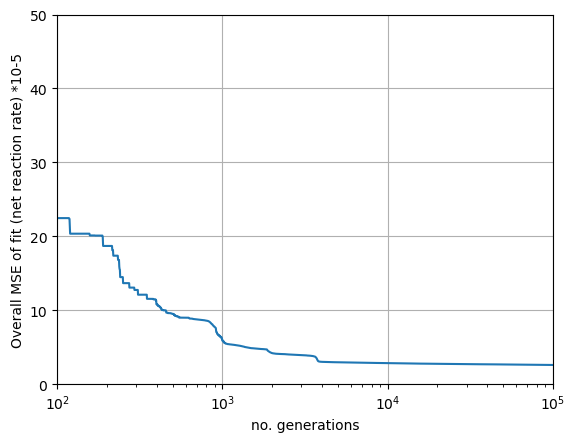

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.668650170993253
1.5466203902160163
0.8593202469762528
-4.1865809340425075
0.4812110001823131
9.929339498295027e-06
0.39668279731515993
-5.700466954518058
0.4499236583515503
5.328003152088774
4.04738450292585
4.151224697646352
0.5669563012536062
0.02801323250057452
2.963895383992176
2.3006647767422744e-06
0.36393290922381044
-11.252636969064426
1.764856687335909
1.4903469031768406
-10.905154609887285
1.1077090504552878
3.6083532061456904
0.05442997474041024
3.8658727979585445
3.839320004378713
1.3100926710442247
7.7732937019782815
-9.429516101825651
2.66828415493883
1.7404034789228764
3.465182173671946
-4.412376789718482
0.5724557274292026
1.0364316667928204
-1.3010298302439494


In [37]:
res.X

array([-1.16686502e+01,  1.54662039e+00,  8.59320247e-01, -4.18658093e+00,
        4.81211000e-01,  9.92933950e-06,  3.96682797e-01, -5.70046695e+00,
        4.49923658e-01,  5.32800315e+00,  4.04738450e+00,  4.15122470e+00,
        5.66956301e-01,  2.80132325e-02,  2.96389538e+00,  2.30066478e-06,
        3.63932909e-01, -1.12526370e+01,  1.76485669e+00,  1.49034690e+00,
       -1.09051546e+01,  1.10770905e+00,  3.60835321e+00,  5.44299747e-02,
        3.86587280e+00,  3.83932000e+00,  1.31009267e+00,  7.77329370e+00,
       -9.42951610e+00,  2.66828415e+00,  1.74040348e+00,  3.46518217e+00,
       -4.41237679e+00,  5.72455727e-01,  1.03643167e+00, -1.30102983e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )


-12.0: -11.668650170993253
1.6: 1.5466203902160163
0.9: 0.8593202469762528
-4.3: -4.1865809340425075
0.5: 0.4812110001823131
0.003: 9.929339498295027e-06
0.4: 0.39668279731515993
-7.9: -5.700466954518058
0.7: 0.4499236583515503
7.2: 5.328003152088774
5.7: 4.04738450292585
5.7: 4.151224697646352
0.8: 0.5669563012536062
0.03: 0.02801323250057452
3.1: 2.963895383992176
6.000000000000001e-09: 2.3006647767422744e-06
0.1: 0.36393290922381044
-12.0: -11.252636969064426
1.9: 1.764856687335909
1.6: 1.4903469031768406
-11.6: -10.905154609887285
1.2: 1.1077090504552878
4.0: 3.6083532061456904
0.01: 0.05442997474041024
4.2: 3.8658727979585445
5.4: 3.839320004378713
2.2: 1.3100926710442247
11.8: 7.7732937019782815
-12.0: -9.429516101825651
3.3: 2.66828415493883
1.8: 1.7404034789228764
4.2: 3.465182173671946
-4.0: -4.412376789718482
0.5: 0.5724557274292026
1.0: 1.0364316667928204
coeff fit: 0.9593571280859302
